In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np



In [2]:
class CIFAR10WithNoise(datasets.CIFAR10):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False, noise_factor=0.5):
        super(CIFAR10WithNoise, self).__init__(root, train=train, transform=transform, target_transform=target_transform, download=download)
        self.noise_factor = noise_factor

    def __getitem__(self, index):
        img, target = super(CIFAR10WithNoise, self).__getitem__(index)

        noisy_img = img + self.noise_factor * torch.randn_like(img)
        noisy_img = torch.clamp(noisy_img, 0., 1.)
        return noisy_img, img


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor()
])


training_dataset = CIFAR10WithNoise(root='./data', train=True, transform=transform, download=True, noise_factor=0.5)
value_dataset = CIFAR10WithNoise(root='./data', train=False, transform=transform, download=True, noise_factor=0.5)

training_loader = DataLoader(training_dataset, batch_size=128, shuffle=True)
value_loader = DataLoader(value_dataset, batch_size=128, shuffle=False)

100%|██████████| 170498071/170498071 [00:12<00:00, 13251694.83it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
class ResNet18Autoencoder(nn.Module):
    def __init__(self):
        super(ResNet18Autoencoder, self).__init__()

        resnet = models.resnet18(pretrained=True)


        self.encoder = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4
        )


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),


            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [11]:
model = ResNet18Autoencoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
def imshow(img, title=None):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()


In [7]:
from tqdm import tqdm
def train_one_epoch(model, criterion, optimizer):

  model.train()
  running_loss = 0.0
  for batch_idx, (noisy_imgs, clean_imgs) in enumerate(tqdm(training_loader)):
    noisy_imgs = noisy_imgs.to(device)
    clean_imgs = clean_imgs.to(device)

    outputs = model(noisy_imgs)

    loss = criterion(outputs, clean_imgs)


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    print(f"Batch{batch_idx} Loss: {loss.item()}")

  epoch_loss = running_loss / len(training_loader)

  return epoch_loss






In [8]:
def validate_one_epoch(model, criterion):

  model.eval()
  running_loss = 0.0
  for batch_idx, (noisy_imgs, clean_imgs) in enumerate(tqdm(value_loader)):
    noisy_imgs = noisy_imgs.to(device)
    clean_imgs = clean_imgs.to(device)

    outputs = model(noisy_imgs)

    loss = criterion(outputs, clean_imgs)



    running_loss += loss.item()

  

  val_epoch_loss = running_loss / len(training_loader)

  return val_epoch_loss

In [9]:
def train_model(model,criterion, optimizer, num_epochs):

    training_loss = []
    val_losses = []

    for epoch in range(num_epochs):

        train_loss = train_one_epoch(model, criterion, optimizer)
        training_loss.append(train_loss)

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}')

        val_loss = validate_one_epoch(model,criterion)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs} - Val Loss: {val_loss:.4f}')

    return training_loss, val_losses

In [12]:
training_loss, val_losses = train_model(model, criterion, optimizer, num_epochs=10)

  1%|          | 2/391 [00:00<00:54,  7.15it/s]

Batch0 Loss: 0.0747128576040268
Batch1 Loss: 0.06904615461826324


  1%|          | 4/391 [00:00<00:42,  9.11it/s]

Batch2 Loss: 0.06248154491186142
Batch3 Loss: 0.06719143688678741
Batch4 Loss: 0.06130310893058777


  2%|▏         | 8/391 [00:00<00:35, 10.92it/s]

Batch5 Loss: 0.060571443289518356
Batch6 Loss: 0.060765378177165985
Batch7 Loss: 0.05866027623414993


  3%|▎         | 10/391 [00:00<00:34, 10.91it/s]

Batch8 Loss: 0.06279157102108002
Batch9 Loss: 0.06198776885867119
Batch10 Loss: 0.061311833560466766


  4%|▎         | 14/391 [00:01<00:33, 11.38it/s]

Batch11 Loss: 0.05767349153757095
Batch12 Loss: 0.055883750319480896
Batch13 Loss: 0.05761092156171799


  4%|▍         | 16/391 [00:01<00:32, 11.51it/s]

Batch14 Loss: 0.049690984189510345
Batch15 Loss: 0.05349166691303253
Batch16 Loss: 0.04910385236144066


  5%|▌         | 20/391 [00:01<00:31, 11.72it/s]

Batch17 Loss: 0.051538899540901184
Batch18 Loss: 0.05025571212172508
Batch19 Loss: 0.04789810627698898


  6%|▌         | 22/391 [00:02<00:32, 11.37it/s]

Batch20 Loss: 0.050712354481220245
Batch21 Loss: 0.04857206344604492
Batch22 Loss: 0.0486694872379303


  7%|▋         | 26/391 [00:02<00:31, 11.66it/s]

Batch23 Loss: 0.04362351819872856
Batch24 Loss: 0.04694989323616028
Batch25 Loss: 0.043237343430519104


  7%|▋         | 28/391 [00:02<00:30, 11.74it/s]

Batch26 Loss: 0.04516550153493881
Batch27 Loss: 0.04117048531770706
Batch28 Loss: 0.040707483887672424


  8%|▊         | 32/391 [00:02<00:30, 11.89it/s]

Batch29 Loss: 0.03956117480993271
Batch30 Loss: 0.0442628487944603
Batch31 Loss: 0.04086735472083092


  9%|▊         | 34/391 [00:03<00:30, 11.64it/s]

Batch32 Loss: 0.040521275252103806
Batch33 Loss: 0.041687916964292526
Batch34 Loss: 0.041241712868213654


 10%|▉         | 38/391 [00:03<00:30, 11.72it/s]

Batch35 Loss: 0.038223013281822205
Batch36 Loss: 0.038577720522880554
Batch37 Loss: 0.03845556825399399


 10%|█         | 40/391 [00:03<00:29, 11.81it/s]

Batch38 Loss: 0.038017332553863525
Batch39 Loss: 0.03761521726846695
Batch40 Loss: 0.040372319519519806


 11%|█▏        | 44/391 [00:03<00:29, 11.73it/s]

Batch41 Loss: 0.035633087158203125
Batch42 Loss: 0.037737779319286346
Batch43 Loss: 0.0408131368458271


 12%|█▏        | 46/391 [00:04<00:29, 11.58it/s]

Batch44 Loss: 0.0407995879650116
Batch45 Loss: 0.03717643767595291
Batch46 Loss: 0.03974812477827072


 13%|█▎        | 50/391 [00:04<00:29, 11.72it/s]

Batch47 Loss: 0.03534715622663498
Batch48 Loss: 0.03507139906287193
Batch49 Loss: 0.03665842115879059


 13%|█▎        | 52/391 [00:04<00:28, 11.74it/s]

Batch50 Loss: 0.037091728299856186
Batch51 Loss: 0.03621895611286163
Batch52 Loss: 0.03477872163057327


 14%|█▍        | 56/391 [00:04<00:28, 11.62it/s]

Batch53 Loss: 0.038488008081912994
Batch54 Loss: 0.03556495159864426
Batch55 Loss: 0.0350838378071785


 15%|█▍        | 58/391 [00:05<00:29, 11.37it/s]

Batch56 Loss: 0.033813148736953735
Batch57 Loss: 0.03458006680011749
Batch58 Loss: 0.03289664536714554


 16%|█▌        | 62/391 [00:05<00:29, 11.28it/s]

Batch59 Loss: 0.03431924432516098
Batch60 Loss: 0.03494651988148689
Batch61 Loss: 0.031391069293022156


 16%|█▋        | 64/391 [00:05<00:29, 11.05it/s]

Batch62 Loss: 0.03407435119152069
Batch63 Loss: 0.03394339233636856
Batch64 Loss: 0.034892261028289795


 17%|█▋        | 66/391 [00:05<00:29, 10.88it/s]

Batch65 Loss: 0.03267177939414978
Batch66 Loss: 0.03180311992764473


 18%|█▊        | 70/391 [00:06<00:30, 10.50it/s]

Batch67 Loss: 0.03154153376817703
Batch68 Loss: 0.03508459031581879
Batch69 Loss: 0.031303197145462036


 18%|█▊        | 72/391 [00:06<00:30, 10.45it/s]

Batch70 Loss: 0.03853172808885574
Batch71 Loss: 0.032536622136831284
Batch72 Loss: 0.03323057293891907


 19%|█▉        | 76/391 [00:06<00:30, 10.31it/s]

Batch73 Loss: 0.035116277635097504
Batch74 Loss: 0.0333976112306118
Batch75 Loss: 0.03375030308961868


 20%|█▉        | 78/391 [00:07<00:31, 10.00it/s]

Batch76 Loss: 0.03415539115667343
Batch77 Loss: 0.032974280416965485


 20%|██        | 80/391 [00:07<00:31,  9.86it/s]

Batch78 Loss: 0.03179047629237175
Batch79 Loss: 0.029839633032679558


 21%|██        | 82/391 [00:07<00:31,  9.70it/s]

Batch80 Loss: 0.033180736005306244
Batch81 Loss: 0.03410334140062332


 22%|██▏       | 85/391 [00:07<00:29, 10.39it/s]

Batch82 Loss: 0.02920069545507431
Batch83 Loss: 0.03237222135066986
Batch84 Loss: 0.03228720277547836


 22%|██▏       | 87/391 [00:07<00:28, 10.63it/s]

Batch85 Loss: 0.029858125373721123
Batch86 Loss: 0.032540302723646164
Batch87 Loss: 0.03223719447851181


 23%|██▎       | 91/391 [00:08<00:26, 11.17it/s]

Batch88 Loss: 0.032214969396591187
Batch89 Loss: 0.032094087451696396
Batch90 Loss: 0.029530376195907593


 24%|██▍       | 93/391 [00:08<00:26, 11.31it/s]

Batch91 Loss: 0.03262415900826454
Batch92 Loss: 0.030534036457538605
Batch93 Loss: 0.034684620797634125


 25%|██▍       | 97/391 [00:08<00:25, 11.61it/s]

Batch94 Loss: 0.03157808631658554
Batch95 Loss: 0.031200600787997246
Batch96 Loss: 0.03099178336560726


 25%|██▌       | 99/391 [00:08<00:25, 11.61it/s]

Batch97 Loss: 0.03135601431131363
Batch98 Loss: 0.03182556852698326
Batch99 Loss: 0.03053278475999832


 26%|██▋       | 103/391 [00:09<00:24, 11.78it/s]

Batch100 Loss: 0.028861723840236664
Batch101 Loss: 0.030702758580446243
Batch102 Loss: 0.032201044261455536


 27%|██▋       | 105/391 [00:09<00:24, 11.69it/s]

Batch103 Loss: 0.031402379274368286
Batch104 Loss: 0.029684636741876602
Batch105 Loss: 0.03162752836942673


 28%|██▊       | 109/391 [00:09<00:24, 11.71it/s]

Batch106 Loss: 0.03326275944709778
Batch107 Loss: 0.03161037713289261
Batch108 Loss: 0.030688678845763206


 28%|██▊       | 111/391 [00:09<00:23, 11.75it/s]

Batch109 Loss: 0.03028061054646969
Batch110 Loss: 0.029631411656737328
Batch111 Loss: 0.0310340728610754


 29%|██▉       | 115/391 [00:10<00:23, 11.76it/s]

Batch112 Loss: 0.033020980656147
Batch113 Loss: 0.031271323561668396
Batch114 Loss: 0.029217880219221115


 30%|██▉       | 117/391 [00:10<00:23, 11.68it/s]

Batch115 Loss: 0.02910440042614937
Batch116 Loss: 0.03038886748254299
Batch117 Loss: 0.032736774533987045


 31%|███       | 121/391 [00:10<00:22, 11.76it/s]

Batch118 Loss: 0.032595060765743256
Batch119 Loss: 0.03232043236494064
Batch120 Loss: 0.030144542455673218


 31%|███▏      | 123/391 [00:10<00:22, 11.69it/s]

Batch121 Loss: 0.032318636775016785
Batch122 Loss: 0.03438253700733185
Batch123 Loss: 0.031819701194763184


 32%|███▏      | 127/391 [00:11<00:22, 11.67it/s]

Batch124 Loss: 0.03316999971866608
Batch125 Loss: 0.03209816664457321
Batch126 Loss: 0.028260767459869385


 33%|███▎      | 129/391 [00:11<00:22, 11.74it/s]

Batch127 Loss: 0.030100446194410324
Batch128 Loss: 0.030392304062843323
Batch129 Loss: 0.03303563594818115


 34%|███▍      | 133/391 [00:11<00:21, 11.84it/s]

Batch130 Loss: 0.030865317210555077
Batch131 Loss: 0.032550644129514694
Batch132 Loss: 0.03136558458209038


 35%|███▍      | 135/391 [00:11<00:22, 11.62it/s]

Batch133 Loss: 0.028574511408805847
Batch134 Loss: 0.030251141637563705
Batch135 Loss: 0.03360465168952942


 36%|███▌      | 139/391 [00:12<00:21, 11.72it/s]

Batch136 Loss: 0.033494748175144196
Batch137 Loss: 0.03382844477891922
Batch138 Loss: 0.03210614621639252


 36%|███▌      | 141/391 [00:12<00:21, 11.70it/s]

Batch139 Loss: 0.03096350096166134
Batch140 Loss: 0.03015865758061409
Batch141 Loss: 0.031838398426771164


 37%|███▋      | 145/391 [00:12<00:20, 11.85it/s]

Batch142 Loss: 0.033154528588056564
Batch143 Loss: 0.03201603144407272
Batch144 Loss: 0.03331117331981659


 38%|███▊      | 147/391 [00:13<00:20, 11.78it/s]

Batch145 Loss: 0.030214305967092514
Batch146 Loss: 0.03366182744503021
Batch147 Loss: 0.03014455735683441


 39%|███▊      | 151/391 [00:13<00:20, 11.56it/s]

Batch148 Loss: 0.02954654023051262
Batch149 Loss: 0.033414628356695175
Batch150 Loss: 0.03163771703839302


 39%|███▉      | 153/391 [00:13<00:20, 11.55it/s]

Batch151 Loss: 0.02925403043627739
Batch152 Loss: 0.03152099624276161
Batch153 Loss: 0.02918195351958275


 40%|████      | 157/391 [00:13<00:19, 11.75it/s]

Batch154 Loss: 0.029172956943511963
Batch155 Loss: 0.03304711729288101
Batch156 Loss: 0.02986096404492855


 41%|████      | 159/391 [00:14<00:19, 11.81it/s]

Batch157 Loss: 0.03248954564332962
Batch158 Loss: 0.03198152780532837
Batch159 Loss: 0.031718071550130844


 42%|████▏     | 163/391 [00:14<00:19, 11.54it/s]

Batch160 Loss: 0.030673881992697716
Batch161 Loss: 0.029553905129432678
Batch162 Loss: 0.03121618926525116


 42%|████▏     | 165/391 [00:14<00:19, 11.49it/s]

Batch163 Loss: 0.03037288784980774
Batch164 Loss: 0.029017575085163116
Batch165 Loss: 0.03077074885368347


 43%|████▎     | 169/391 [00:14<00:19, 11.38it/s]

Batch166 Loss: 0.03231511265039444
Batch167 Loss: 0.031024372205138206
Batch168 Loss: 0.03126589208841324


 44%|████▎     | 171/391 [00:15<00:19, 11.43it/s]

Batch169 Loss: 0.03295700252056122
Batch170 Loss: 0.03079983964562416
Batch171 Loss: 0.030774150043725967


 45%|████▍     | 175/391 [00:15<00:18, 11.49it/s]

Batch172 Loss: 0.02923906221985817
Batch173 Loss: 0.03297760710120201
Batch174 Loss: 0.032231301069259644


 45%|████▌     | 177/391 [00:15<00:18, 11.50it/s]

Batch175 Loss: 0.030839836224913597
Batch176 Loss: 0.030812695622444153
Batch177 Loss: 0.030541375279426575


 46%|████▋     | 181/391 [00:15<00:18, 11.55it/s]

Batch178 Loss: 0.03125882148742676
Batch179 Loss: 0.0298355370759964
Batch180 Loss: 0.03167331963777542


 47%|████▋     | 183/391 [00:16<00:17, 11.56it/s]

Batch181 Loss: 0.029536761343479156
Batch182 Loss: 0.03042665868997574
Batch183 Loss: 0.030569806694984436


 47%|████▋     | 185/391 [00:16<00:21,  9.55it/s]

Batch184 Loss: 0.02827323041856289


 48%|████▊     | 187/391 [00:16<00:25,  8.01it/s]

Batch185 Loss: 0.031107831746339798
Batch186 Loss: 0.030557069927453995


 48%|████▊     | 189/391 [00:17<00:25,  7.98it/s]

Batch187 Loss: 0.027936017140746117
Batch188 Loss: 0.03048361837863922


 49%|████▉     | 191/391 [00:17<00:27,  7.25it/s]

Batch189 Loss: 0.030979610979557037
Batch190 Loss: 0.02991034835577011


 49%|████▉     | 193/391 [00:17<00:29,  6.78it/s]

Batch191 Loss: 0.029599010944366455
Batch192 Loss: 0.03068280778825283


 50%|████▉     | 195/391 [00:18<00:33,  5.89it/s]

Batch193 Loss: 0.03069905936717987
Batch194 Loss: 0.02916697785258293


 50%|█████     | 197/391 [00:18<00:34,  5.68it/s]

Batch195 Loss: 0.02651171013712883
Batch196 Loss: 0.03225943446159363


 51%|█████     | 198/391 [00:18<00:32,  6.03it/s]

Batch197 Loss: 0.03281129524111748
Batch198 Loss: 0.029113372787833214


 51%|█████     | 200/391 [00:18<00:30,  6.32it/s]

Batch199 Loss: 0.030523698776960373


 51%|█████▏    | 201/391 [00:19<00:32,  5.79it/s]

Batch200 Loss: 0.02812550589442253


 52%|█████▏    | 202/391 [00:19<00:35,  5.26it/s]

Batch201 Loss: 0.03143443912267685
Batch202 Loss: 0.02993956208229065


 52%|█████▏    | 205/391 [00:19<00:26,  7.00it/s]

Batch203 Loss: 0.02960449457168579
Batch204 Loss: 0.03047901950776577


 53%|█████▎    | 207/391 [00:19<00:23,  7.95it/s]

Batch205 Loss: 0.028889795765280724
Batch206 Loss: 0.028055300936102867


 53%|█████▎    | 209/391 [00:20<00:21,  8.29it/s]

Batch207 Loss: 0.028132792562246323
Batch208 Loss: 0.026481375098228455
Batch209 Loss: 0.030539557337760925


 54%|█████▍    | 213/391 [00:20<00:17, 10.25it/s]

Batch210 Loss: 0.030386514961719513
Batch211 Loss: 0.02935498207807541
Batch212 Loss: 0.03163648396730423


 55%|█████▍    | 215/391 [00:20<00:16, 10.59it/s]

Batch213 Loss: 0.02847006544470787
Batch214 Loss: 0.02985885553061962
Batch215 Loss: 0.029698163270950317


 56%|█████▌    | 219/391 [00:20<00:15, 11.12it/s]

Batch216 Loss: 0.028583180159330368
Batch217 Loss: 0.029699720442295074
Batch218 Loss: 0.03184866905212402


 57%|█████▋    | 221/391 [00:21<00:15, 11.32it/s]

Batch219 Loss: 0.02912011556327343
Batch220 Loss: 0.03128049895167351
Batch221 Loss: 0.03061639331281185


 58%|█████▊    | 225/391 [00:21<00:14, 11.53it/s]

Batch222 Loss: 0.02956361696124077
Batch223 Loss: 0.028855934739112854
Batch224 Loss: 0.030023371800780296


 58%|█████▊    | 227/391 [00:21<00:14, 11.52it/s]

Batch225 Loss: 0.02874116599559784
Batch226 Loss: 0.030034590512514114
Batch227 Loss: 0.026155810803174973


 59%|█████▉    | 231/391 [00:21<00:13, 11.58it/s]

Batch228 Loss: 0.03136509284377098
Batch229 Loss: 0.029182806611061096
Batch230 Loss: 0.029651513323187828


 60%|█████▉    | 233/391 [00:22<00:13, 11.52it/s]

Batch231 Loss: 0.02874385379254818
Batch232 Loss: 0.02709302119910717
Batch233 Loss: 0.027467362582683563


 61%|██████    | 237/391 [00:22<00:13, 11.55it/s]

Batch234 Loss: 0.029885105788707733
Batch235 Loss: 0.030586060136556625
Batch236 Loss: 0.029255758970975876


 61%|██████    | 239/391 [00:22<00:13, 11.26it/s]

Batch237 Loss: 0.028433173894882202
Batch238 Loss: 0.02851497195661068
Batch239 Loss: 0.032380905002355576


 62%|██████▏   | 243/391 [00:23<00:12, 11.41it/s]

Batch240 Loss: 0.02835628017783165
Batch241 Loss: 0.031117666512727737
Batch242 Loss: 0.031784091144800186


 63%|██████▎   | 245/391 [00:23<00:12, 11.42it/s]

Batch243 Loss: 0.029641825705766678
Batch244 Loss: 0.02961183339357376
Batch245 Loss: 0.03206581994891167


 64%|██████▎   | 249/391 [00:23<00:12, 11.54it/s]

Batch246 Loss: 0.027802258729934692
Batch247 Loss: 0.03141503036022186
Batch248 Loss: 0.029559198766946793


 64%|██████▍   | 251/391 [00:23<00:12, 11.41it/s]

Batch249 Loss: 0.03082267753779888
Batch250 Loss: 0.028971143066883087
Batch251 Loss: 0.03204214200377464


 65%|██████▌   | 255/391 [00:24<00:11, 11.54it/s]

Batch252 Loss: 0.028609532862901688
Batch253 Loss: 0.028785085305571556
Batch254 Loss: 0.029546167701482773


 66%|██████▌   | 257/391 [00:24<00:11, 11.50it/s]

Batch255 Loss: 0.028834138065576553
Batch256 Loss: 0.029054563492536545
Batch257 Loss: 0.030864115804433823


 67%|██████▋   | 261/391 [00:24<00:11, 11.52it/s]

Batch258 Loss: 0.029724471271038055
Batch259 Loss: 0.029820844531059265
Batch260 Loss: 0.03309217840433121


 67%|██████▋   | 263/391 [00:24<00:11, 11.55it/s]

Batch261 Loss: 0.028984375298023224
Batch262 Loss: 0.027877040207386017
Batch263 Loss: 0.028886079788208008


 68%|██████▊   | 267/391 [00:25<00:10, 11.55it/s]

Batch264 Loss: 0.027534112334251404
Batch265 Loss: 0.031485043466091156
Batch266 Loss: 0.028146464377641678


 69%|██████▉   | 269/391 [00:25<00:10, 11.61it/s]

Batch267 Loss: 0.028514070436358452
Batch268 Loss: 0.029150014743208885
Batch269 Loss: 0.026668377220630646


 70%|██████▉   | 273/391 [00:25<00:10, 11.62it/s]

Batch270 Loss: 0.028188388794660568
Batch271 Loss: 0.02960873395204544
Batch272 Loss: 0.0296733807772398


 70%|███████   | 275/391 [00:25<00:10, 11.56it/s]

Batch273 Loss: 0.028117207810282707
Batch274 Loss: 0.02927458845078945
Batch275 Loss: 0.025701016187667847


 71%|███████▏  | 279/391 [00:26<00:09, 11.56it/s]

Batch276 Loss: 0.028122678399086
Batch277 Loss: 0.028321251273155212
Batch278 Loss: 0.02913711965084076


 72%|███████▏  | 281/391 [00:26<00:09, 11.54it/s]

Batch279 Loss: 0.02670798823237419
Batch280 Loss: 0.02849001996219158
Batch281 Loss: 0.02931535616517067


 73%|███████▎  | 285/391 [00:26<00:09, 11.63it/s]

Batch282 Loss: 0.030514588579535484
Batch283 Loss: 0.028381023555994034
Batch284 Loss: 0.027059271931648254


 73%|███████▎  | 287/391 [00:26<00:08, 11.57it/s]

Batch285 Loss: 0.027030397206544876
Batch286 Loss: 0.027661412954330444
Batch287 Loss: 0.02651405893266201


 74%|███████▍  | 291/391 [00:27<00:08, 11.43it/s]

Batch288 Loss: 0.028530754148960114
Batch289 Loss: 0.02682970091700554
Batch290 Loss: 0.027567757293581963


 75%|███████▍  | 293/391 [00:27<00:08, 11.34it/s]

Batch291 Loss: 0.02863346040248871
Batch292 Loss: 0.028676677495241165
Batch293 Loss: 0.029616249725222588


 76%|███████▌  | 297/391 [00:27<00:08, 11.19it/s]

Batch294 Loss: 0.027425959706306458
Batch295 Loss: 0.026514558121562004
Batch296 Loss: 0.027050074189901352


 76%|███████▋  | 299/391 [00:27<00:08, 11.01it/s]

Batch297 Loss: 0.027498368173837662
Batch298 Loss: 0.02826504036784172
Batch299 Loss: 0.028932079672813416


 77%|███████▋  | 303/391 [00:28<00:07, 11.28it/s]

Batch300 Loss: 0.02711467072367668
Batch301 Loss: 0.02867271564900875
Batch302 Loss: 0.028973206877708435


 78%|███████▊  | 305/391 [00:28<00:07, 11.36it/s]

Batch303 Loss: 0.029647894203662872
Batch304 Loss: 0.026910632848739624
Batch305 Loss: 0.02608642540872097


 79%|███████▉  | 309/391 [00:28<00:07, 11.42it/s]

Batch306 Loss: 0.02819337695837021
Batch307 Loss: 0.027483489364385605
Batch308 Loss: 0.028242871165275574


 80%|███████▉  | 311/391 [00:28<00:06, 11.43it/s]

Batch309 Loss: 0.028019066900014877
Batch310 Loss: 0.028052425011992455
Batch311 Loss: 0.025346903130412102


 81%|████████  | 315/391 [00:29<00:06, 11.53it/s]

Batch312 Loss: 0.030628912150859833
Batch313 Loss: 0.030395036563277245
Batch314 Loss: 0.02835698239505291


 81%|████████  | 317/391 [00:29<00:06, 11.49it/s]

Batch315 Loss: 0.029415011405944824
Batch316 Loss: 0.029582297429442406
Batch317 Loss: 0.027566369622945786


 82%|████████▏ | 321/391 [00:29<00:06, 11.51it/s]

Batch318 Loss: 0.026935851201415062
Batch319 Loss: 0.02823197841644287
Batch320 Loss: 0.02626839652657509


 83%|████████▎ | 323/391 [00:29<00:06, 11.33it/s]

Batch321 Loss: 0.0257799681276083
Batch322 Loss: 0.027175895869731903
Batch323 Loss: 0.02825619839131832


 84%|████████▎ | 327/391 [00:30<00:05, 10.73it/s]

Batch324 Loss: 0.026011325418949127
Batch325 Loss: 0.027479182928800583
Batch326 Loss: 0.027319014072418213


 84%|████████▍ | 329/391 [00:30<00:05, 10.42it/s]

Batch327 Loss: 0.027608027681708336
Batch328 Loss: 0.025740889832377434
Batch329 Loss: 0.027295276522636414


 85%|████████▍ | 331/391 [00:30<00:05, 10.20it/s]

Batch330 Loss: 0.02821578085422516
Batch331 Loss: 0.028965270146727562


 86%|████████▌ | 335/391 [00:31<00:05, 10.20it/s]

Batch332 Loss: 0.028258126229047775
Batch333 Loss: 0.027031708508729935
Batch334 Loss: 0.026378195732831955


 86%|████████▌ | 337/391 [00:31<00:05, 10.12it/s]

Batch335 Loss: 0.027439534664154053
Batch336 Loss: 0.026980187743902206


 87%|████████▋ | 339/391 [00:31<00:05, 10.02it/s]

Batch337 Loss: 0.02757791057229042
Batch338 Loss: 0.02623518370091915


 87%|████████▋ | 341/391 [00:31<00:05,  9.74it/s]

Batch339 Loss: 0.029724787920713425
Batch340 Loss: 0.02564055286347866


 88%|████████▊ | 343/391 [00:32<00:04,  9.61it/s]

Batch341 Loss: 0.02643517032265663
Batch342 Loss: 0.026788946241140366


 88%|████████▊ | 345/391 [00:32<00:04,  9.66it/s]

Batch343 Loss: 0.028409114107489586
Batch344 Loss: 0.026053814217448235


 89%|████████▉ | 348/391 [00:32<00:04, 10.23it/s]

Batch345 Loss: 0.02664380893111229
Batch346 Loss: 0.0282246433198452
Batch347 Loss: 0.028691351413726807


 90%|████████▉ | 350/391 [00:32<00:03, 10.71it/s]

Batch348 Loss: 0.02897198311984539
Batch349 Loss: 0.029796630144119263
Batch350 Loss: 0.028670024126768112


 91%|█████████ | 354/391 [00:33<00:03, 11.20it/s]

Batch351 Loss: 0.02702963724732399
Batch352 Loss: 0.028344249352812767
Batch353 Loss: 0.027330223470926285


 91%|█████████ | 356/391 [00:33<00:03, 11.28it/s]

Batch354 Loss: 0.02656545862555504
Batch355 Loss: 0.026520639657974243
Batch356 Loss: 0.0268612802028656


 92%|█████████▏| 360/391 [00:33<00:02, 11.50it/s]

Batch357 Loss: 0.027965715155005455
Batch358 Loss: 0.028862357139587402
Batch359 Loss: 0.03157705441117287


 93%|█████████▎| 362/391 [00:33<00:02, 11.49it/s]

Batch360 Loss: 0.02684774249792099
Batch361 Loss: 0.026836544275283813
Batch362 Loss: 0.026691149920225143


 94%|█████████▎| 366/391 [00:34<00:02, 11.43it/s]

Batch363 Loss: 0.02691892348229885
Batch364 Loss: 0.027716360986232758
Batch365 Loss: 0.027462605386972427


 94%|█████████▍| 368/391 [00:34<00:01, 11.53it/s]

Batch366 Loss: 0.025461018085479736
Batch367 Loss: 0.026221727952361107
Batch368 Loss: 0.02585732750594616


 95%|█████████▌| 372/391 [00:34<00:01, 11.60it/s]

Batch369 Loss: 0.02695990726351738
Batch370 Loss: 0.026374971494078636
Batch371 Loss: 0.0277080200612545


 96%|█████████▌| 374/391 [00:34<00:01, 11.62it/s]

Batch372 Loss: 0.027789002284407616
Batch373 Loss: 0.027139179408550262
Batch374 Loss: 0.028213635087013245


 97%|█████████▋| 378/391 [00:35<00:01, 11.62it/s]

Batch375 Loss: 0.02739398181438446
Batch376 Loss: 0.028790712356567383
Batch377 Loss: 0.024646688252687454


 97%|█████████▋| 380/391 [00:35<00:00, 11.67it/s]

Batch378 Loss: 0.026891371235251427
Batch379 Loss: 0.026560824364423752
Batch380 Loss: 0.028309237211942673


 98%|█████████▊| 384/391 [00:35<00:00, 11.73it/s]

Batch381 Loss: 0.027519550174474716
Batch382 Loss: 0.02903602086007595
Batch383 Loss: 0.027330700308084488


 99%|█████████▊| 386/391 [00:35<00:00, 11.68it/s]

Batch384 Loss: 0.02777036279439926
Batch385 Loss: 0.026882728561758995
Batch386 Loss: 0.030226245522499084


100%|█████████▉| 390/391 [00:36<00:00, 11.61it/s]

Batch387 Loss: 0.026727430522441864
Batch388 Loss: 0.02736472897231579
Batch389 Loss: 0.025600485503673553


100%|██████████| 391/391 [00:36<00:00, 10.80it/s]


Batch390 Loss: 0.024081550538539886
Epoch 1/10 - Train Loss: 0.0322


100%|██████████| 79/79 [00:04<00:00, 19.20it/s]


Epoch 1/10 - Val Loss: 0.0055


  1%|          | 2/391 [00:00<00:33, 11.67it/s]

Batch0 Loss: 0.02911435440182686
Batch1 Loss: 0.02964131161570549
Batch2 Loss: 0.026788100600242615


  1%|          | 4/391 [00:00<00:33, 11.41it/s]

Batch3 Loss: 0.02614532969892025
Batch4 Loss: 0.027571966871619225


  2%|▏         | 6/391 [00:00<00:33, 11.45it/s]

Batch5 Loss: 0.027973491698503494


  2%|▏         | 8/391 [00:00<00:33, 11.32it/s]

Batch6 Loss: 0.029346590861678123
Batch7 Loss: 0.029652483761310577
Batch8 Loss: 0.026721671223640442


  3%|▎         | 10/391 [00:00<00:33, 11.31it/s]

Batch9 Loss: 0.026910431683063507
Batch10 Loss: 0.026394817978143692


  3%|▎         | 12/391 [00:01<00:33, 11.41it/s]

Batch11 Loss: 0.028545474633574486


  4%|▎         | 14/391 [00:01<00:33, 11.38it/s]

Batch12 Loss: 0.026052311062812805
Batch13 Loss: 0.02657092735171318
Batch14 Loss: 0.026570867747068405


  4%|▍         | 16/391 [00:01<00:32, 11.37it/s]

Batch15 Loss: 0.02599905990064144
Batch16 Loss: 0.027136048302054405


  5%|▍         | 18/391 [00:01<00:33, 11.21it/s]

Batch17 Loss: 0.026133552193641663


  5%|▌         | 20/391 [00:01<00:33, 11.19it/s]

Batch18 Loss: 0.02863747626543045
Batch19 Loss: 0.02743241749703884
Batch20 Loss: 0.026092562824487686


  6%|▌         | 22/391 [00:01<00:32, 11.25it/s]

Batch21 Loss: 0.026598846539855003
Batch22 Loss: 0.027934513986110687


  6%|▌         | 24/391 [00:02<00:33, 10.97it/s]

Batch23 Loss: 0.0270250141620636
Batch24 Loss: 0.027785222977399826


  7%|▋         | 26/391 [00:02<00:34, 10.44it/s]

Batch25 Loss: 0.02786099538207054
Batch26 Loss: 0.025401657447218895
Batch27 Loss: 0.028196727856993675

  7%|▋         | 28/391 [00:02<00:35, 10.22it/s]


Batch28 Loss: 0.026647506281733513


  8%|▊         | 30/391 [00:02<00:35, 10.17it/s]

Batch29 Loss: 0.027319058775901794


  8%|▊         | 32/391 [00:02<00:35, 10.18it/s]

Batch30 Loss: 0.02771536074578762
Batch31 Loss: 0.028185244649648666
Batch32 Loss: 0.025996949523687363


  9%|▊         | 34/391 [00:03<00:35, 10.08it/s]

Batch33 Loss: 0.027288442477583885
Batch34 Loss: 0.028404459357261658
Batch35 Loss: 0.029101531952619553

  9%|▉         | 36/391 [00:03<00:35, 10.00it/s]


Batch36 Loss: 0.0270870141685009


 10%|▉         | 39/391 [00:03<00:35,  9.80it/s]

Batch37 Loss: 0.02588873729109764
Batch38 Loss: 0.02582523226737976


 10%|█         | 41/391 [00:03<00:37,  9.46it/s]

Batch39 Loss: 0.02449113130569458
Batch40 Loss: 0.028684038668870926


 11%|█         | 43/391 [00:04<00:36,  9.48it/s]

Batch41 Loss: 0.027004480361938477
Batch42 Loss: 0.025057438760995865


 12%|█▏        | 45/391 [00:04<00:37,  9.30it/s]

Batch43 Loss: 0.027308568358421326
Batch44 Loss: 0.026079639792442322
Batch45 Loss: 0.02796664834022522


 13%|█▎        | 49/391 [00:04<00:32, 10.48it/s]

Batch46 Loss: 0.02644553780555725
Batch47 Loss: 0.028565306216478348
Batch48 Loss: 0.02750169299542904


 13%|█▎        | 51/391 [00:04<00:31, 10.72it/s]

Batch49 Loss: 0.025996625423431396
Batch50 Loss: 0.028027385473251343
Batch51 Loss: 0.025739384815096855


 14%|█▍        | 55/391 [00:05<00:30, 11.14it/s]

Batch52 Loss: 0.02555733732879162
Batch53 Loss: 0.026514483615756035
Batch54 Loss: 0.02735794708132744


 15%|█▍        | 57/391 [00:05<00:29, 11.27it/s]

Batch55 Loss: 0.028664452955126762
Batch56 Loss: 0.02556253969669342
Batch57 Loss: 0.027471229434013367


 16%|█▌        | 61/391 [00:05<00:29, 11.35it/s]

Batch58 Loss: 0.024872638285160065
Batch59 Loss: 0.02906893566250801
Batch60 Loss: 0.026829784736037254


 16%|█▌        | 63/391 [00:05<00:29, 11.25it/s]

Batch61 Loss: 0.02769908867776394
Batch62 Loss: 0.027991458773612976
Batch63 Loss: 0.027234748005867004


 17%|█▋        | 67/391 [00:06<00:28, 11.41it/s]

Batch64 Loss: 0.026363519951701164
Batch65 Loss: 0.025304127484560013
Batch66 Loss: 0.0261068232357502


 18%|█▊        | 69/391 [00:06<00:27, 11.51it/s]

Batch67 Loss: 0.02663986012339592
Batch68 Loss: 0.024574995040893555
Batch69 Loss: 0.027309399098157883


 19%|█▊        | 73/391 [00:06<00:27, 11.63it/s]

Batch70 Loss: 0.02803630195558071
Batch71 Loss: 0.026720616966485977
Batch72 Loss: 0.02561081014573574


 19%|█▉        | 75/391 [00:06<00:27, 11.42it/s]

Batch73 Loss: 0.029034465551376343
Batch74 Loss: 0.025208979845046997
Batch75 Loss: 0.027155116200447083


 20%|██        | 79/391 [00:07<00:27, 11.53it/s]

Batch76 Loss: 0.026148632168769836
Batch77 Loss: 0.027536964043974876
Batch78 Loss: 0.024668795987963676


 21%|██        | 81/391 [00:07<00:26, 11.60it/s]

Batch79 Loss: 0.02721891552209854
Batch80 Loss: 0.026787709444761276
Batch81 Loss: 0.025639299303293228


 22%|██▏       | 85/391 [00:07<00:26, 11.37it/s]

Batch82 Loss: 0.02620365098118782
Batch83 Loss: 0.024252310395240784
Batch84 Loss: 0.025104492902755737


 22%|██▏       | 87/391 [00:08<00:26, 11.44it/s]

Batch85 Loss: 0.027223002165555954
Batch86 Loss: 0.026334121823310852
Batch87 Loss: 0.02529376745223999


 23%|██▎       | 91/391 [00:08<00:25, 11.59it/s]

Batch88 Loss: 0.027176683768630028
Batch89 Loss: 0.02792797051370144
Batch90 Loss: 0.026225533336400986


 24%|██▍       | 93/391 [00:08<00:25, 11.60it/s]

Batch91 Loss: 0.028030594810843468
Batch92 Loss: 0.02686140686273575
Batch93 Loss: 0.026122575625777245


 25%|██▍       | 97/391 [00:08<00:24, 11.76it/s]

Batch94 Loss: 0.02437209151685238
Batch95 Loss: 0.026833675801753998
Batch96 Loss: 0.025978293269872665


 25%|██▌       | 99/391 [00:09<00:24, 11.80it/s]

Batch97 Loss: 0.028574924916028976
Batch98 Loss: 0.024815291166305542
Batch99 Loss: 0.026287350803613663


 26%|██▋       | 103/391 [00:09<00:24, 11.79it/s]

Batch100 Loss: 0.028444144874811172
Batch101 Loss: 0.026528969407081604
Batch102 Loss: 0.025790639221668243


 27%|██▋       | 105/391 [00:09<00:24, 11.69it/s]

Batch103 Loss: 0.0273353960365057
Batch104 Loss: 0.027068113908171654
Batch105 Loss: 0.026439784094691277


 28%|██▊       | 109/391 [00:09<00:24, 11.64it/s]

Batch106 Loss: 0.025396568700671196
Batch107 Loss: 0.026638608425855637
Batch108 Loss: 0.02743086777627468


 28%|██▊       | 111/391 [00:10<00:23, 11.71it/s]

Batch109 Loss: 0.027039965614676476
Batch110 Loss: 0.025657813996076584
Batch111 Loss: 0.02533169463276863


 29%|██▉       | 115/391 [00:10<00:23, 11.60it/s]

Batch112 Loss: 0.02732822671532631
Batch113 Loss: 0.027247443795204163
Batch114 Loss: 0.024649566039443016


 30%|██▉       | 117/391 [00:10<00:24, 11.41it/s]

Batch115 Loss: 0.024666940793395042
Batch116 Loss: 0.026172038167715073
Batch117 Loss: 0.026128461584448814


 31%|███       | 121/391 [00:10<00:23, 11.57it/s]

Batch118 Loss: 0.026225458830595016
Batch119 Loss: 0.026276348158717155
Batch120 Loss: 0.02590462565422058


 31%|███▏      | 123/391 [00:11<00:23, 11.58it/s]

Batch121 Loss: 0.029101785272359848
Batch122 Loss: 0.025541430339217186
Batch123 Loss: 0.02630080096423626


 32%|███▏      | 127/391 [00:11<00:23, 11.45it/s]

Batch124 Loss: 0.027104942128062248
Batch125 Loss: 0.025086473673582077
Batch126 Loss: 0.026311594992876053


 33%|███▎      | 129/391 [00:11<00:22, 11.49it/s]

Batch127 Loss: 0.02612459473311901
Batch128 Loss: 0.026686539873480797
Batch129 Loss: 0.025167440995573997


 34%|███▍      | 133/391 [00:11<00:22, 11.57it/s]

Batch130 Loss: 0.026270544156432152
Batch131 Loss: 0.027850456535816193
Batch132 Loss: 0.026395589113235474


 35%|███▍      | 135/391 [00:12<00:23, 10.71it/s]

Batch133 Loss: 0.027332833036780357
Batch134 Loss: 0.027216486632823944
Batch135 Loss: 0.026899520307779312


 36%|███▌      | 139/391 [00:12<00:22, 11.06it/s]

Batch136 Loss: 0.028106436133384705
Batch137 Loss: 0.027187664061784744
Batch138 Loss: 0.027903003618121147


 36%|███▌      | 141/391 [00:12<00:22, 11.16it/s]

Batch139 Loss: 0.026616062968969345
Batch140 Loss: 0.0258345864713192
Batch141 Loss: 0.025153515860438347


 37%|███▋      | 145/391 [00:13<00:21, 11.41it/s]

Batch142 Loss: 0.026258032768964767
Batch143 Loss: 0.02530546486377716
Batch144 Loss: 0.024727698415517807


 38%|███▊      | 147/391 [00:13<00:21, 11.28it/s]

Batch145 Loss: 0.027087992057204247
Batch146 Loss: 0.02607206627726555
Batch147 Loss: 0.02610870823264122


 39%|███▊      | 151/391 [00:13<00:21, 11.23it/s]

Batch148 Loss: 0.02925090491771698
Batch149 Loss: 0.024943504482507706
Batch150 Loss: 0.02471509575843811


 39%|███▉      | 153/391 [00:13<00:21, 11.28it/s]

Batch151 Loss: 0.02692178264260292
Batch152 Loss: 0.025563586503267288
Batch153 Loss: 0.026367273181676865


 40%|████      | 157/391 [00:14<00:20, 11.41it/s]

Batch154 Loss: 0.027622876688838005
Batch155 Loss: 0.023969240486621857
Batch156 Loss: 0.025027327239513397


 41%|████      | 159/391 [00:14<00:20, 11.46it/s]

Batch157 Loss: 0.026699688285589218
Batch158 Loss: 0.02572505921125412
Batch159 Loss: 0.026483185589313507


 41%|████      | 161/391 [00:14<00:20, 11.04it/s]

Batch160 Loss: 0.025771938264369965
Batch161 Loss: 0.024145862087607384


 42%|████▏     | 165/391 [00:14<00:21, 10.67it/s]

Batch162 Loss: 0.024044696241617203
Batch163 Loss: 0.026497870683670044
Batch164 Loss: 0.027607625350356102


 43%|████▎     | 167/391 [00:15<00:21, 10.66it/s]

Batch165 Loss: 0.023708917200565338
Batch166 Loss: 0.02429322525858879
Batch167 Loss: 0.025473501533269882


 44%|████▎     | 171/391 [00:15<00:21, 10.47it/s]

Batch168 Loss: 0.027119694277644157
Batch169 Loss: 0.025316519662737846
Batch170 Loss: 0.024343479424715042


 44%|████▍     | 173/391 [00:15<00:20, 10.51it/s]

Batch171 Loss: 0.027287287637591362
Batch172 Loss: 0.023886118084192276
Batch173 Loss: 0.025674862787127495


 45%|████▍     | 175/391 [00:15<00:20, 10.31it/s]

Batch174 Loss: 0.025516947731375694
Batch175 Loss: 0.02387002855539322


 45%|████▌     | 177/391 [00:16<00:21, 10.11it/s]

Batch176 Loss: 0.02380499243736267
Batch177 Loss: 0.02542824111878872


 46%|████▌     | 180/391 [00:16<00:21,  9.67it/s]

Batch178 Loss: 0.024033881723880768
Batch179 Loss: 0.027626581490039825


 47%|████▋     | 182/391 [00:16<00:22,  9.49it/s]

Batch180 Loss: 0.025235112756490707
Batch181 Loss: 0.025994613766670227


 47%|████▋     | 185/391 [00:16<00:20, 10.11it/s]

Batch182 Loss: 0.026284068822860718
Batch183 Loss: 0.023420218378305435
Batch184 Loss: 0.024734634906053543


 48%|████▊     | 187/391 [00:17<00:19, 10.55it/s]

Batch185 Loss: 0.025454392656683922
Batch186 Loss: 0.02538607083261013
Batch187 Loss: 0.025293931365013123


 49%|████▉     | 191/391 [00:17<00:17, 11.23it/s]

Batch188 Loss: 0.025398269295692444
Batch189 Loss: 0.023364048451185226
Batch190 Loss: 0.025113973766565323


 49%|████▉     | 193/391 [00:17<00:17, 11.14it/s]

Batch191 Loss: 0.02403847873210907
Batch192 Loss: 0.023783763870596886
Batch193 Loss: 0.025288335978984833


 50%|█████     | 197/391 [00:17<00:17, 11.41it/s]

Batch194 Loss: 0.0257167499512434
Batch195 Loss: 0.025153016671538353
Batch196 Loss: 0.025346677750349045


 51%|█████     | 199/391 [00:18<00:16, 11.45it/s]

Batch197 Loss: 0.02446642331779003
Batch198 Loss: 0.02348572574555874
Batch199 Loss: 0.025425057858228683


 52%|█████▏    | 203/391 [00:18<00:16, 11.57it/s]

Batch200 Loss: 0.02534658834338188
Batch201 Loss: 0.023854894563555717
Batch202 Loss: 0.02558245323598385


 52%|█████▏    | 205/391 [00:18<00:16, 11.59it/s]

Batch203 Loss: 0.025194983929395676
Batch204 Loss: 0.02539859712123871
Batch205 Loss: 0.024663176387548447


 53%|█████▎    | 209/391 [00:18<00:15, 11.74it/s]

Batch206 Loss: 0.023695435374975204
Batch207 Loss: 0.02282608114182949
Batch208 Loss: 0.02456604316830635


 54%|█████▍    | 211/391 [00:19<00:15, 11.64it/s]

Batch209 Loss: 0.023218031972646713
Batch210 Loss: 0.026999488472938538
Batch211 Loss: 0.025960173457860947


 55%|█████▍    | 215/391 [00:19<00:15, 11.70it/s]

Batch212 Loss: 0.024241283535957336
Batch213 Loss: 0.023988697677850723
Batch214 Loss: 0.023871060460805893


 55%|█████▌    | 217/391 [00:19<00:14, 11.66it/s]

Batch215 Loss: 0.025467446073889732
Batch216 Loss: 0.02349536493420601
Batch217 Loss: 0.023397188633680344


 57%|█████▋    | 221/391 [00:19<00:14, 11.70it/s]

Batch218 Loss: 0.02443121001124382
Batch219 Loss: 0.026327770203351974
Batch220 Loss: 0.026292895898222923


 57%|█████▋    | 223/391 [00:20<00:14, 11.71it/s]

Batch221 Loss: 0.02284116856753826
Batch222 Loss: 0.025310881435871124
Batch223 Loss: 0.02642844244837761


 58%|█████▊    | 227/391 [00:20<00:14, 11.63it/s]

Batch224 Loss: 0.02443055436015129
Batch225 Loss: 0.0258494820445776
Batch226 Loss: 0.023818399757146835


 59%|█████▊    | 229/391 [00:20<00:14, 11.37it/s]

Batch227 Loss: 0.024019239470362663
Batch228 Loss: 0.026187539100646973
Batch229 Loss: 0.025677848607301712


 60%|█████▉    | 233/391 [00:21<00:13, 11.64it/s]

Batch230 Loss: 0.025182483717799187
Batch231 Loss: 0.024782683700323105
Batch232 Loss: 0.02282172068953514


 60%|██████    | 235/391 [00:21<00:13, 11.60it/s]

Batch233 Loss: 0.023777414113283157
Batch234 Loss: 0.02434912696480751
Batch235 Loss: 0.023303356021642685


 61%|██████    | 239/391 [00:21<00:13, 11.58it/s]

Batch236 Loss: 0.02544431947171688
Batch237 Loss: 0.02422438934445381
Batch238 Loss: 0.02348722517490387


 62%|██████▏   | 241/391 [00:21<00:12, 11.66it/s]

Batch239 Loss: 0.02390904352068901
Batch240 Loss: 0.025675728917121887
Batch241 Loss: 0.02375965565443039


 63%|██████▎   | 245/391 [00:22<00:12, 11.69it/s]

Batch242 Loss: 0.02581135928630829
Batch243 Loss: 0.025651052594184875
Batch244 Loss: 0.023965146392583847


 63%|██████▎   | 247/391 [00:22<00:12, 11.77it/s]

Batch245 Loss: 0.02629808336496353
Batch246 Loss: 0.024932801723480225
Batch247 Loss: 0.02372109889984131


 64%|██████▍   | 251/391 [00:22<00:12, 11.53it/s]

Batch248 Loss: 0.02403010055422783
Batch249 Loss: 0.02516677975654602
Batch250 Loss: 0.02515673264861107


 65%|██████▍   | 253/391 [00:22<00:11, 11.60it/s]

Batch251 Loss: 0.023645881563425064
Batch252 Loss: 0.02413301169872284
Batch253 Loss: 0.02514297515153885


 66%|██████▌   | 257/391 [00:23<00:11, 11.58it/s]

Batch254 Loss: 0.023361017927527428
Batch255 Loss: 0.024007027968764305
Batch256 Loss: 0.022817913442850113


 66%|██████▌   | 259/391 [00:23<00:11, 11.45it/s]

Batch257 Loss: 0.025134272873401642
Batch258 Loss: 0.024599548429250717
Batch259 Loss: 0.023029735311865807


 67%|██████▋   | 263/391 [00:23<00:11, 11.35it/s]

Batch260 Loss: 0.02518937736749649
Batch261 Loss: 0.02316971682012081
Batch262 Loss: 0.025399670004844666


 68%|██████▊   | 265/391 [00:23<00:11, 11.39it/s]

Batch263 Loss: 0.02308621071279049
Batch264 Loss: 0.02435830794274807
Batch265 Loss: 0.025531476363539696


 69%|██████▉   | 269/391 [00:24<00:10, 11.57it/s]

Batch266 Loss: 0.02553802728652954
Batch267 Loss: 0.0241225715726614
Batch268 Loss: 0.023870259523391724


 69%|██████▉   | 271/391 [00:24<00:10, 11.64it/s]

Batch269 Loss: 0.0248308926820755
Batch270 Loss: 0.022448770701885223
Batch271 Loss: 0.024653052911162376


 70%|███████   | 275/391 [00:24<00:10, 11.21it/s]

Batch272 Loss: 0.02315482497215271
Batch273 Loss: 0.024761762470006943
Batch274 Loss: 0.023972373455762863


 71%|███████   | 277/391 [00:24<00:10, 11.37it/s]

Batch275 Loss: 0.02403363212943077
Batch276 Loss: 0.023088734596967697
Batch277 Loss: 0.02532774582505226


 72%|███████▏  | 281/391 [00:25<00:09, 11.59it/s]

Batch278 Loss: 0.02395888790488243
Batch279 Loss: 0.022337138652801514
Batch280 Loss: 0.02386590838432312


 72%|███████▏  | 283/391 [00:25<00:09, 11.55it/s]

Batch281 Loss: 0.022370217368006706
Batch282 Loss: 0.024916227906942368
Batch283 Loss: 0.023871755227446556


 73%|███████▎  | 287/391 [00:25<00:08, 11.75it/s]

Batch284 Loss: 0.023219555616378784
Batch285 Loss: 0.022449221462011337
Batch286 Loss: 0.023885225877165794


 74%|███████▍  | 289/391 [00:25<00:08, 11.70it/s]

Batch287 Loss: 0.02423376962542534
Batch288 Loss: 0.02176111750304699
Batch289 Loss: 0.022972505539655685


 75%|███████▍  | 293/391 [00:26<00:08, 11.70it/s]

Batch290 Loss: 0.024666041135787964
Batch291 Loss: 0.02215666137635708
Batch292 Loss: 0.02471679076552391


 75%|███████▌  | 295/391 [00:26<00:08, 11.71it/s]

Batch293 Loss: 0.02590775117278099
Batch294 Loss: 0.02321178838610649
Batch295 Loss: 0.024417800828814507


 76%|███████▋  | 299/391 [00:26<00:07, 11.51it/s]

Batch296 Loss: 0.023726535961031914
Batch297 Loss: 0.02281636744737625
Batch298 Loss: 0.0222078375518322


 77%|███████▋  | 301/391 [00:26<00:08, 10.83it/s]

Batch299 Loss: 0.023364519700407982
Batch300 Loss: 0.025047725066542625


 77%|███████▋  | 303/391 [00:27<00:08, 10.60it/s]

Batch301 Loss: 0.02120719850063324
Batch302 Loss: 0.02434617653489113
Batch303 Loss: 0.021779239177703857


 78%|███████▊  | 305/391 [00:27<00:08, 10.37it/s]

Batch304 Loss: 0.024028785526752472
Batch305 Loss: 0.022942662239074707


 79%|███████▉  | 309/391 [00:27<00:08, 10.05it/s]

Batch306 Loss: 0.02480657398700714
Batch307 Loss: 0.02317233942449093
Batch308 Loss: 0.02419085055589676


 80%|███████▉  | 311/391 [00:27<00:08,  9.90it/s]

Batch309 Loss: 0.02349458448588848
Batch310 Loss: 0.02352207899093628


 80%|████████  | 313/391 [00:28<00:08,  9.71it/s]

Batch311 Loss: 0.022735100239515305
Batch312 Loss: 0.023071732372045517


 81%|████████  | 315/391 [00:28<00:07,  9.71it/s]

Batch313 Loss: 0.02039378695189953
Batch314 Loss: 0.022606542333960533


 81%|████████  | 317/391 [00:28<00:07,  9.32it/s]

Batch315 Loss: 0.024752214550971985
Batch316 Loss: 0.022798359394073486


 82%|████████▏ | 319/391 [00:28<00:07,  9.32it/s]

Batch317 Loss: 0.024885622784495354
Batch318 Loss: 0.02316938154399395


 82%|████████▏ | 321/391 [00:29<00:07,  9.48it/s]

Batch319 Loss: 0.023241844028234482
Batch320 Loss: 0.022759294137358665
Batch321 Loss: 0.021265923976898193


 83%|████████▎ | 325/391 [00:29<00:06, 10.80it/s]

Batch322 Loss: 0.02416253089904785
Batch323 Loss: 0.022393763065338135
Batch324 Loss: 0.024249693378806114


 84%|████████▎ | 327/391 [00:29<00:05, 10.98it/s]

Batch325 Loss: 0.0227041058242321
Batch326 Loss: 0.022843819111585617
Batch327 Loss: 0.024401888251304626


 85%|████████▍ | 331/391 [00:29<00:05, 11.16it/s]

Batch328 Loss: 0.023515745997428894
Batch329 Loss: 0.024126898497343063
Batch330 Loss: 0.02168015018105507


 85%|████████▌ | 333/391 [00:30<00:05, 11.32it/s]

Batch331 Loss: 0.023328205570578575
Batch332 Loss: 0.02221422642469406
Batch333 Loss: 0.021217141300439835


 86%|████████▌ | 337/391 [00:30<00:04, 11.57it/s]

Batch334 Loss: 0.024171262979507446
Batch335 Loss: 0.02377476915717125
Batch336 Loss: 0.025418460369110107


 87%|████████▋ | 339/391 [00:30<00:04, 11.45it/s]

Batch337 Loss: 0.023456498980522156
Batch338 Loss: 0.024776369333267212
Batch339 Loss: 0.023134645074605942


 88%|████████▊ | 343/391 [00:30<00:04, 11.37it/s]

Batch340 Loss: 0.023862536996603012
Batch341 Loss: 0.026876604184508324
Batch342 Loss: 0.025041501969099045


 88%|████████▊ | 345/391 [00:31<00:04, 11.37it/s]

Batch343 Loss: 0.02227616310119629
Batch344 Loss: 0.021800091490149498
Batch345 Loss: 0.02404872141778469


 89%|████████▉ | 349/391 [00:31<00:03, 11.51it/s]

Batch346 Loss: 0.02491726353764534
Batch347 Loss: 0.023142468184232712
Batch348 Loss: 0.023565342649817467


 90%|████████▉ | 351/391 [00:31<00:03, 11.38it/s]

Batch349 Loss: 0.022947173565626144
Batch350 Loss: 0.02145708166062832
Batch351 Loss: 0.022773128002882004


 91%|█████████ | 355/391 [00:31<00:03, 11.61it/s]

Batch352 Loss: 0.0242623221129179
Batch353 Loss: 0.024334093555808067
Batch354 Loss: 0.022440869361162186


 91%|█████████▏| 357/391 [00:32<00:02, 11.66it/s]

Batch355 Loss: 0.0221132542937994
Batch356 Loss: 0.023204956203699112
Batch357 Loss: 0.021850241348147392


 92%|█████████▏| 361/391 [00:32<00:02, 11.63it/s]

Batch358 Loss: 0.022744446992874146
Batch359 Loss: 0.022503580898046494
Batch360 Loss: 0.022817840799689293


 93%|█████████▎| 363/391 [00:32<00:02, 11.54it/s]

Batch361 Loss: 0.022935055196285248
Batch362 Loss: 0.021774759516119957
Batch363 Loss: 0.0240432471036911


 94%|█████████▍| 367/391 [00:33<00:02, 11.68it/s]

Batch364 Loss: 0.021180659532546997
Batch365 Loss: 0.022847242653369904
Batch366 Loss: 0.022696292027831078


 94%|█████████▍| 369/391 [00:33<00:01, 11.63it/s]

Batch367 Loss: 0.024781130254268646
Batch368 Loss: 0.02333420142531395
Batch369 Loss: 0.02445150911808014


 95%|█████████▌| 373/391 [00:33<00:01, 11.73it/s]

Batch370 Loss: 0.021324072033166885
Batch371 Loss: 0.024157091975212097
Batch372 Loss: 0.023329725489020348


 96%|█████████▌| 375/391 [00:33<00:01, 11.76it/s]

Batch373 Loss: 0.023656269535422325
Batch374 Loss: 0.023035407066345215
Batch375 Loss: 0.024692846462130547


 97%|█████████▋| 379/391 [00:34<00:01, 11.75it/s]

Batch376 Loss: 0.02122035250067711
Batch377 Loss: 0.02271473966538906
Batch378 Loss: 0.02247944474220276


 97%|█████████▋| 381/391 [00:34<00:00, 11.80it/s]

Batch379 Loss: 0.023354124277830124
Batch380 Loss: 0.023977970704436302
Batch381 Loss: 0.023193541914224625


 98%|█████████▊| 385/391 [00:34<00:00, 11.71it/s]

Batch382 Loss: 0.021851640194654465
Batch383 Loss: 0.022792506963014603
Batch384 Loss: 0.02230605110526085


 99%|█████████▉| 387/391 [00:34<00:00, 11.69it/s]

Batch385 Loss: 0.02570115029811859
Batch386 Loss: 0.021530646830797195
Batch387 Loss: 0.02318502776324749


100%|██████████| 391/391 [00:35<00:00, 11.16it/s]


Batch388 Loss: 0.024283481761813164
Batch389 Loss: 0.021873002871870995
Batch390 Loss: 0.022308284416794777
Epoch 2/10 - Train Loss: 0.0251


100%|██████████| 79/79 [00:04<00:00, 19.27it/s]


Epoch 2/10 - Val Loss: 0.0046


  0%|          | 1/391 [00:00<00:43,  9.04it/s]

Batch0 Loss: 0.02134646847844124


  1%|          | 2/391 [00:00<00:41,  9.41it/s]

Batch1 Loss: 0.02312622033059597
Batch2 Loss: 0.023317817598581314

  1%|          | 4/391 [00:00<00:39,  9.80it/s]


Batch3 Loss: 0.02201179973781109
Batch4 Loss: 0.0230740737169981


  2%|▏         | 7/391 [00:00<00:38, 10.03it/s]

Batch5 Loss: 0.021678809076547623
Batch6 Loss: 0.021894393488764763
Batch7 Loss: 0.02373393252491951


  2%|▏         | 9/391 [00:00<00:38, 10.04it/s]

Batch8 Loss: 0.02446865104138851
Batch9 Loss: 0.022954817861318588


  3%|▎         | 11/391 [00:01<00:37, 10.10it/s]

Batch10 Loss: 0.023789256811141968


  3%|▎         | 13/391 [00:01<00:37, 10.06it/s]

Batch11 Loss: 0.0231806468218565
Batch12 Loss: 0.023904025554656982


  4%|▍         | 15/391 [00:01<00:37, 10.02it/s]

Batch13 Loss: 0.022401897236704826
Batch14 Loss: 0.022977083921432495
Batch15 Loss: 0.02055007964372635


  5%|▍         | 18/391 [00:01<00:38,  9.69it/s]

Batch16 Loss: 0.02342825010418892
Batch17 Loss: 0.023975703865289688


  5%|▌         | 20/391 [00:02<00:38,  9.68it/s]

Batch18 Loss: 0.022704586386680603
Batch19 Loss: 0.022698018699884415


  6%|▌         | 22/391 [00:02<00:38,  9.51it/s]

Batch20 Loss: 0.02342815324664116
Batch21 Loss: 0.022202355787158012
Batch22 Loss: 0.022098466753959656


  7%|▋         | 26/391 [00:02<00:34, 10.72it/s]

Batch23 Loss: 0.022778984159231186
Batch24 Loss: 0.02276950143277645
Batch25 Loss: 0.021235577762126923


  7%|▋         | 28/391 [00:02<00:32, 11.03it/s]

Batch26 Loss: 0.021915769204497337
Batch27 Loss: 0.020787779241800308
Batch28 Loss: 0.02203933522105217


  8%|▊         | 32/391 [00:03<00:31, 11.38it/s]

Batch29 Loss: 0.02184629812836647
Batch30 Loss: 0.02261412888765335
Batch31 Loss: 0.02386968955397606


  9%|▊         | 34/391 [00:03<00:31, 11.45it/s]

Batch32 Loss: 0.023013358935713768
Batch33 Loss: 0.022513708099722862
Batch34 Loss: 0.022244295105338097


 10%|▉         | 38/391 [00:03<00:31, 11.38it/s]

Batch35 Loss: 0.021838292479515076
Batch36 Loss: 0.022099751979112625
Batch37 Loss: 0.023131966590881348


 10%|█         | 40/391 [00:03<00:30, 11.45it/s]

Batch38 Loss: 0.022558998316526413
Batch39 Loss: 0.022771840915083885
Batch40 Loss: 0.024384185671806335


 11%|█▏        | 44/391 [00:04<00:30, 11.44it/s]

Batch41 Loss: 0.023308953270316124
Batch42 Loss: 0.022444626316428185
Batch43 Loss: 0.021959170699119568


 12%|█▏        | 46/391 [00:04<00:30, 11.45it/s]

Batch44 Loss: 0.022725587710738182
Batch45 Loss: 0.021791329607367516
Batch46 Loss: 0.02359318733215332


 13%|█▎        | 50/391 [00:04<00:29, 11.48it/s]

Batch47 Loss: 0.022666126489639282
Batch48 Loss: 0.02262529730796814
Batch49 Loss: 0.022997912019491196


 13%|█▎        | 52/391 [00:04<00:29, 11.37it/s]

Batch50 Loss: 0.02182156592607498
Batch51 Loss: 0.02250715158879757
Batch52 Loss: 0.021908273920416832


 14%|█▍        | 56/391 [00:05<00:29, 11.51it/s]

Batch53 Loss: 0.022644978016614914
Batch54 Loss: 0.02277129888534546
Batch55 Loss: 0.02253926917910576


 15%|█▍        | 58/391 [00:05<00:29, 11.33it/s]

Batch56 Loss: 0.021785002201795578
Batch57 Loss: 0.02202414534986019
Batch58 Loss: 0.02396314963698387


 16%|█▌        | 62/391 [00:05<00:28, 11.43it/s]

Batch59 Loss: 0.02207670733332634
Batch60 Loss: 0.022410793229937553
Batch61 Loss: 0.021651919931173325


 16%|█▋        | 64/391 [00:05<00:28, 11.31it/s]

Batch62 Loss: 0.024037471041083336
Batch63 Loss: 0.022587990388274193
Batch64 Loss: 0.02382536046206951


 17%|█▋        | 68/391 [00:06<00:28, 11.38it/s]

Batch65 Loss: 0.023420032113790512
Batch66 Loss: 0.021601300686597824
Batch67 Loss: 0.0203491672873497


 18%|█▊        | 70/391 [00:06<00:28, 11.43it/s]

Batch68 Loss: 0.02283196896314621
Batch69 Loss: 0.02274903655052185
Batch70 Loss: 0.02087191306054592


 19%|█▉        | 74/391 [00:06<00:27, 11.55it/s]

Batch71 Loss: 0.02238336205482483
Batch72 Loss: 0.022686010226607323
Batch73 Loss: 0.022120635956525803


 19%|█▉        | 76/391 [00:06<00:27, 11.56it/s]

Batch74 Loss: 0.022706998512148857
Batch75 Loss: 0.024242360144853592
Batch76 Loss: 0.022070949897170067


 20%|██        | 80/391 [00:07<00:26, 11.54it/s]

Batch77 Loss: 0.021642640233039856
Batch78 Loss: 0.021823158487677574
Batch79 Loss: 0.02186676487326622


 21%|██        | 82/391 [00:07<00:27, 11.29it/s]

Batch80 Loss: 0.025118477642536163
Batch81 Loss: 0.022290419787168503
Batch82 Loss: 0.02267354540526867


 22%|██▏       | 86/391 [00:07<00:26, 11.59it/s]

Batch83 Loss: 0.022735929116606712
Batch84 Loss: 0.021486595273017883
Batch85 Loss: 0.0227306317538023


 23%|██▎       | 88/391 [00:08<00:26, 11.61it/s]

Batch86 Loss: 0.022019222378730774
Batch87 Loss: 0.02240326814353466
Batch88 Loss: 0.021704699844121933


 24%|██▎       | 92/391 [00:08<00:25, 11.61it/s]

Batch89 Loss: 0.022556720301508904
Batch90 Loss: 0.021359175443649292
Batch91 Loss: 0.021225139498710632


 24%|██▍       | 94/391 [00:08<00:25, 11.64it/s]

Batch92 Loss: 0.021001216024160385
Batch93 Loss: 0.022855155169963837
Batch94 Loss: 0.020701026543974876


 25%|██▌       | 98/391 [00:08<00:25, 11.62it/s]

Batch95 Loss: 0.020093107596039772
Batch96 Loss: 0.022209685295820236
Batch97 Loss: 0.021139247342944145


 26%|██▌       | 100/391 [00:09<00:25, 11.47it/s]

Batch98 Loss: 0.021521124988794327
Batch99 Loss: 0.022900309413671494
Batch100 Loss: 0.02185334824025631


 27%|██▋       | 104/391 [00:09<00:25, 11.34it/s]

Batch101 Loss: 0.021570002660155296
Batch102 Loss: 0.02070757932960987
Batch103 Loss: 0.0234987735748291


 27%|██▋       | 106/391 [00:09<00:24, 11.45it/s]

Batch104 Loss: 0.022631598636507988
Batch105 Loss: 0.020505806431174278
Batch106 Loss: 0.02298600599169731


 28%|██▊       | 110/391 [00:09<00:24, 11.52it/s]

Batch107 Loss: 0.0217082928866148
Batch108 Loss: 0.020337354391813278
Batch109 Loss: 0.02300546132028103


 29%|██▊       | 112/391 [00:10<00:24, 11.24it/s]

Batch110 Loss: 0.02188551425933838
Batch111 Loss: 0.021545661613345146
Batch112 Loss: 0.022478586062788963


 30%|██▉       | 116/391 [00:10<00:23, 11.51it/s]

Batch113 Loss: 0.022719731554389
Batch114 Loss: 0.024409053847193718
Batch115 Loss: 0.02194010280072689


 30%|███       | 118/391 [00:10<00:23, 11.48it/s]

Batch116 Loss: 0.022700056433677673
Batch117 Loss: 0.022421035915613174
Batch118 Loss: 0.022559046745300293


 31%|███       | 122/391 [00:10<00:23, 11.41it/s]

Batch119 Loss: 0.021871265023946762
Batch120 Loss: 0.021801728755235672
Batch121 Loss: 0.023154383525252342


 32%|███▏      | 124/391 [00:11<00:23, 11.28it/s]

Batch122 Loss: 0.021008428186178207
Batch123 Loss: 0.025503477081656456
Batch124 Loss: 0.021752169355750084


 33%|███▎      | 128/391 [00:11<00:23, 11.28it/s]

Batch125 Loss: 0.021243322640657425
Batch126 Loss: 0.02200658991932869
Batch127 Loss: 0.0206010639667511


 33%|███▎      | 130/391 [00:11<00:23, 11.13it/s]

Batch128 Loss: 0.020772255957126617
Batch129 Loss: 0.021134598180651665
Batch130 Loss: 0.021159552037715912


 34%|███▍      | 134/391 [00:12<00:22, 11.38it/s]

Batch131 Loss: 0.023432960733771324
Batch132 Loss: 0.023028459399938583
Batch133 Loss: 0.02289210818707943


 35%|███▍      | 136/391 [00:12<00:22, 11.26it/s]

Batch134 Loss: 0.02435740828514099
Batch135 Loss: 0.022108834236860275
Batch136 Loss: 0.022134415805339813


 35%|███▌      | 138/391 [00:12<00:23, 10.77it/s]

Batch137 Loss: 0.02315559796988964
Batch138 Loss: 0.02170754224061966


 36%|███▋      | 142/391 [00:12<00:24, 10.32it/s]

Batch139 Loss: 0.021277224645018578
Batch140 Loss: 0.02043757401406765
Batch141 Loss: 0.02281196042895317


 37%|███▋      | 144/391 [00:13<00:24, 10.20it/s]

Batch142 Loss: 0.021381184458732605
Batch143 Loss: 0.021339088678359985
Batch144 Loss: 0.021172460168600082


 38%|███▊      | 148/391 [00:13<00:23, 10.19it/s]

Batch145 Loss: 0.02126266062259674
Batch146 Loss: 0.02383803389966488
Batch147 Loss: 0.021990813314914703


 38%|███▊      | 150/391 [00:13<00:23, 10.35it/s]

Batch148 Loss: 0.023984558880329132
Batch149 Loss: 0.022862030193209648
Batch150 Loss: 0.021732185035943985


 39%|███▉      | 154/391 [00:14<00:23, 10.07it/s]

Batch151 Loss: 0.02575051411986351
Batch152 Loss: 0.021573975682258606
Batch153 Loss: 0.020861534401774406


 40%|███▉      | 156/391 [00:14<00:23,  9.96it/s]

Batch154 Loss: 0.02199918031692505
Batch155 Loss: 0.021947583183646202


 40%|████      | 158/391 [00:14<00:24,  9.70it/s]

Batch156 Loss: 0.023388855159282684
Batch157 Loss: 0.022420745342969894


 41%|████      | 160/391 [00:14<00:24,  9.42it/s]

Batch158 Loss: 0.024017704650759697
Batch159 Loss: 0.023327019065618515
Batch160 Loss: 0.022683044895529747


 42%|████▏     | 164/391 [00:15<00:21, 10.71it/s]

Batch161 Loss: 0.021820154041051865
Batch162 Loss: 0.022464152425527573
Batch163 Loss: 0.023455485701560974


 42%|████▏     | 166/391 [00:15<00:20, 10.78it/s]

Batch164 Loss: 0.022562315687537193
Batch165 Loss: 0.020873721688985825
Batch166 Loss: 0.023883670568466187


 43%|████▎     | 170/391 [00:15<00:19, 11.15it/s]

Batch167 Loss: 0.02109624445438385
Batch168 Loss: 0.021372459828853607
Batch169 Loss: 0.02191205881536007


 44%|████▍     | 172/391 [00:15<00:19, 11.19it/s]

Batch170 Loss: 0.02320070192217827
Batch171 Loss: 0.024308670312166214
Batch172 Loss: 0.0210249163210392


 45%|████▌     | 176/391 [00:16<00:18, 11.39it/s]

Batch173 Loss: 0.02312348410487175
Batch174 Loss: 0.02215246669948101
Batch175 Loss: 0.021394528448581696


 46%|████▌     | 178/391 [00:16<00:18, 11.43it/s]

Batch176 Loss: 0.019892266020178795
Batch177 Loss: 0.023096632212400436
Batch178 Loss: 0.023186806589365005


 47%|████▋     | 182/391 [00:16<00:18, 11.38it/s]

Batch179 Loss: 0.022970907390117645
Batch180 Loss: 0.02227236144244671
Batch181 Loss: 0.02347569726407528


 47%|████▋     | 184/391 [00:16<00:17, 11.51it/s]

Batch182 Loss: 0.02133047580718994
Batch183 Loss: 0.02320183627307415
Batch184 Loss: 0.021342812106013298


 48%|████▊     | 188/391 [00:17<00:17, 11.51it/s]

Batch185 Loss: 0.021300874650478363
Batch186 Loss: 0.02080795168876648
Batch187 Loss: 0.02155710570514202


 49%|████▊     | 190/391 [00:17<00:17, 11.51it/s]

Batch188 Loss: 0.02198348008096218
Batch189 Loss: 0.020812978968024254
Batch190 Loss: 0.024795159697532654


 50%|████▉     | 194/391 [00:17<00:17, 11.53it/s]

Batch191 Loss: 0.022944224998354912
Batch192 Loss: 0.022007178515195847
Batch193 Loss: 0.0232145544141531


 50%|█████     | 196/391 [00:17<00:17, 11.33it/s]

Batch194 Loss: 0.022357087582349777
Batch195 Loss: 0.021434452384710312
Batch196 Loss: 0.02331666275858879


 51%|█████     | 200/391 [00:18<00:16, 11.49it/s]

Batch197 Loss: 0.022737864404916763
Batch198 Loss: 0.022574057802557945
Batch199 Loss: 0.021693561226129532


 52%|█████▏    | 202/391 [00:18<00:16, 11.31it/s]

Batch200 Loss: 0.025086820125579834
Batch201 Loss: 0.022553397342562675
Batch202 Loss: 0.021394919604063034


 53%|█████▎    | 206/391 [00:18<00:16, 11.20it/s]

Batch203 Loss: 0.02340940199792385
Batch204 Loss: 0.021540489047765732
Batch205 Loss: 0.022430136799812317


 53%|█████▎    | 208/391 [00:18<00:16, 11.28it/s]

Batch206 Loss: 0.02120722457766533
Batch207 Loss: 0.02119407430291176
Batch208 Loss: 0.022062771022319794


 54%|█████▍    | 212/391 [00:19<00:15, 11.37it/s]

Batch209 Loss: 0.02178763970732689
Batch210 Loss: 0.021460233256220818
Batch211 Loss: 0.02212407812476158


 55%|█████▍    | 214/391 [00:19<00:15, 11.16it/s]

Batch212 Loss: 0.021739624440670013
Batch213 Loss: 0.02108536660671234
Batch214 Loss: 0.021248307079076767


 56%|█████▌    | 218/391 [00:19<00:15, 11.34it/s]

Batch215 Loss: 0.02242385968565941
Batch216 Loss: 0.02161937579512596
Batch217 Loss: 0.02062316983938217


 56%|█████▋    | 220/391 [00:19<00:15, 11.33it/s]

Batch218 Loss: 0.02125704661011696
Batch219 Loss: 0.020214151591062546
Batch220 Loss: 0.021699970588088036


 57%|█████▋    | 224/391 [00:20<00:14, 11.47it/s]

Batch221 Loss: 0.022596124559640884
Batch222 Loss: 0.020965903997421265
Batch223 Loss: 0.022177528589963913


 58%|█████▊    | 226/391 [00:20<00:14, 11.39it/s]

Batch224 Loss: 0.021767115220427513
Batch225 Loss: 0.01997065357863903
Batch226 Loss: 0.023136593401432037


 59%|█████▉    | 230/391 [00:20<00:14, 11.46it/s]

Batch227 Loss: 0.021643351763486862
Batch228 Loss: 0.021275896579027176
Batch229 Loss: 0.021971818059682846


 59%|█████▉    | 232/391 [00:20<00:13, 11.49it/s]

Batch230 Loss: 0.02214396558701992
Batch231 Loss: 0.021502716466784477
Batch232 Loss: 0.02243906818330288


 60%|██████    | 236/391 [00:21<00:13, 11.17it/s]

Batch233 Loss: 0.021412251517176628
Batch234 Loss: 0.021923106163740158
Batch235 Loss: 0.02106339856982231


 61%|██████    | 238/391 [00:21<00:13, 11.26it/s]

Batch236 Loss: 0.02112981490790844
Batch237 Loss: 0.021499689668416977
Batch238 Loss: 0.022601090371608734


 62%|██████▏   | 242/391 [00:21<00:13, 11.41it/s]

Batch239 Loss: 0.021774709224700928
Batch240 Loss: 0.02245912328362465
Batch241 Loss: 0.022897548973560333


 62%|██████▏   | 244/391 [00:22<00:12, 11.43it/s]

Batch242 Loss: 0.023008029907941818
Batch243 Loss: 0.02065042033791542
Batch244 Loss: 0.02157909795641899


 63%|██████▎   | 248/391 [00:22<00:12, 11.18it/s]

Batch245 Loss: 0.02183667942881584
Batch246 Loss: 0.021371854469180107
Batch247 Loss: 0.02251807413995266


 64%|██████▍   | 250/391 [00:22<00:12, 11.27it/s]

Batch248 Loss: 0.019729288294911385
Batch249 Loss: 0.02045549266040325
Batch250 Loss: 0.021430298686027527


 65%|██████▍   | 254/391 [00:22<00:11, 11.48it/s]

Batch251 Loss: 0.01988137885928154
Batch252 Loss: 0.02127493917942047
Batch253 Loss: 0.02226601541042328


 65%|██████▌   | 256/391 [00:23<00:11, 11.54it/s]

Batch254 Loss: 0.023248841986060143
Batch255 Loss: 0.022098606452345848
Batch256 Loss: 0.02220488339662552


 66%|██████▋   | 260/391 [00:23<00:11, 11.52it/s]

Batch257 Loss: 0.02033296413719654
Batch258 Loss: 0.02164740115404129
Batch259 Loss: 0.022497063502669334


 67%|██████▋   | 262/391 [00:23<00:11, 11.46it/s]

Batch260 Loss: 0.020463427528738976
Batch261 Loss: 0.02149174176156521
Batch262 Loss: 0.02239266037940979


 68%|██████▊   | 266/391 [00:23<00:10, 11.58it/s]

Batch263 Loss: 0.021881725639104843
Batch264 Loss: 0.021021855995059013
Batch265 Loss: 0.02262924611568451


 69%|██████▊   | 268/391 [00:24<00:10, 11.62it/s]

Batch266 Loss: 0.02320244163274765
Batch267 Loss: 0.02056064084172249
Batch268 Loss: 0.021414225921034813


 70%|██████▉   | 272/391 [00:24<00:10, 11.44it/s]

Batch269 Loss: 0.02144349180161953
Batch270 Loss: 0.022806666791439056
Batch271 Loss: 0.0208603423088789


 70%|███████   | 274/391 [00:24<00:10, 11.46it/s]

Batch272 Loss: 0.021820183843374252
Batch273 Loss: 0.02224789187312126
Batch274 Loss: 0.021295255050063133


 71%|███████   | 278/391 [00:25<00:10, 10.75it/s]

Batch275 Loss: 0.020932581275701523
Batch276 Loss: 0.020804939791560173
Batch277 Loss: 0.02223912999033928


 72%|███████▏  | 280/391 [00:25<00:10, 10.64it/s]

Batch278 Loss: 0.02199440822005272
Batch279 Loss: 0.021592726930975914
Batch280 Loss: 0.02203196845948696


 73%|███████▎  | 284/391 [00:25<00:10, 10.44it/s]

Batch281 Loss: 0.021670876070857048
Batch282 Loss: 0.02242831140756607
Batch283 Loss: 0.0217074416577816


 73%|███████▎  | 286/391 [00:25<00:10, 10.25it/s]

Batch284 Loss: 0.01957196183502674
Batch285 Loss: 0.01977960392832756
Batch286 Loss: 0.021198421716690063


 74%|███████▍  | 290/391 [00:26<00:09, 10.15it/s]

Batch287 Loss: 0.021874751895666122
Batch288 Loss: 0.021715208888053894
Batch289 Loss: 0.022169044241309166


 75%|███████▍  | 292/391 [00:26<00:09, 10.06it/s]

Batch290 Loss: 0.02177567407488823
Batch291 Loss: 0.021760692819952965


 75%|███████▌  | 294/391 [00:26<00:09,  9.83it/s]

Batch292 Loss: 0.022607695311307907
Batch293 Loss: 0.02314753830432892


 76%|███████▌  | 296/391 [00:26<00:09,  9.60it/s]

Batch294 Loss: 0.02184348925948143
Batch295 Loss: 0.024083970114588737


 76%|███████▋  | 299/391 [00:27<00:09, 10.17it/s]

Batch296 Loss: 0.02132795751094818
Batch297 Loss: 0.022322213277220726
Batch298 Loss: 0.02378838323056698


 77%|███████▋  | 301/391 [00:27<00:08, 10.64it/s]

Batch299 Loss: 0.022179964929819107
Batch300 Loss: 0.022727355360984802
Batch301 Loss: 0.020800599828362465


 78%|███████▊  | 305/391 [00:27<00:07, 10.91it/s]

Batch302 Loss: 0.021759774535894394
Batch303 Loss: 0.022003982216119766
Batch304 Loss: 0.022049177438020706


 79%|███████▊  | 307/391 [00:27<00:07, 11.05it/s]

Batch305 Loss: 0.02105201780796051
Batch306 Loss: 0.021276399493217468
Batch307 Loss: 0.02249426767230034


 80%|███████▉  | 311/391 [00:28<00:07, 11.29it/s]

Batch308 Loss: 0.02138286456465721
Batch309 Loss: 0.022406255826354027
Batch310 Loss: 0.020263900980353355


 80%|████████  | 313/391 [00:28<00:06, 11.21it/s]

Batch311 Loss: 0.02043149620294571
Batch312 Loss: 0.02299921028316021
Batch313 Loss: 0.022094901651144028


 81%|████████  | 317/391 [00:28<00:06, 11.32it/s]

Batch314 Loss: 0.02241932973265648
Batch315 Loss: 0.02063653990626335
Batch316 Loss: 0.022025596350431442


 82%|████████▏ | 319/391 [00:28<00:06, 11.33it/s]

Batch317 Loss: 0.0223122276365757
Batch318 Loss: 0.022274866700172424
Batch319 Loss: 0.019393322989344597


 83%|████████▎ | 323/391 [00:29<00:05, 11.63it/s]

Batch320 Loss: 0.019903717562556267
Batch321 Loss: 0.021794414147734642
Batch322 Loss: 0.02118930220603943


 83%|████████▎ | 325/391 [00:29<00:05, 11.68it/s]

Batch323 Loss: 0.02240334078669548
Batch324 Loss: 0.02217540703713894
Batch325 Loss: 0.020909033715724945


 84%|████████▍ | 329/391 [00:29<00:05, 11.58it/s]

Batch326 Loss: 0.02220683917403221
Batch327 Loss: 0.022205859422683716
Batch328 Loss: 0.020601356402039528


 85%|████████▍ | 331/391 [00:29<00:05, 11.66it/s]

Batch329 Loss: 0.02211965247988701
Batch330 Loss: 0.020681852474808693
Batch331 Loss: 0.022612538188695908


 86%|████████▌ | 335/391 [00:30<00:04, 11.63it/s]

Batch332 Loss: 0.021408863365650177
Batch333 Loss: 0.0215899795293808
Batch334 Loss: 0.020734120160341263


 86%|████████▌ | 337/391 [00:30<00:04, 11.51it/s]

Batch335 Loss: 0.021612953394651413
Batch336 Loss: 0.021779542788863182
Batch337 Loss: 0.02330213412642479


 87%|████████▋ | 341/391 [00:30<00:04, 11.33it/s]

Batch338 Loss: 0.023345138877630234
Batch339 Loss: 0.023023931309580803
Batch340 Loss: 0.022379335016012192


 88%|████████▊ | 343/391 [00:31<00:04, 11.31it/s]

Batch341 Loss: 0.02282090298831463
Batch342 Loss: 0.02029072307050228
Batch343 Loss: 0.021558910608291626


 89%|████████▊ | 347/391 [00:31<00:03, 11.38it/s]

Batch344 Loss: 0.02110878750681877
Batch345 Loss: 0.021532699465751648
Batch346 Loss: 0.022682711482048035


 89%|████████▉ | 349/391 [00:31<00:03, 11.46it/s]

Batch347 Loss: 0.02141897939145565
Batch348 Loss: 0.021855726838111877
Batch349 Loss: 0.022239020094275475


 90%|█████████ | 353/391 [00:31<00:03, 11.54it/s]

Batch350 Loss: 0.021477695554494858
Batch351 Loss: 0.02237512171268463
Batch352 Loss: 0.021668612957000732


 91%|█████████ | 355/391 [00:32<00:03, 11.40it/s]

Batch353 Loss: 0.022661462426185608
Batch354 Loss: 0.022948309779167175
Batch355 Loss: 0.020329533144831657


 92%|█████████▏| 359/391 [00:32<00:02, 11.34it/s]

Batch356 Loss: 0.022278979420661926
Batch357 Loss: 0.023335790261626244
Batch358 Loss: 0.021954834461212158


 92%|█████████▏| 361/391 [00:32<00:02, 11.36it/s]

Batch359 Loss: 0.0216531865298748
Batch360 Loss: 0.02189258113503456
Batch361 Loss: 0.021261481568217278


 93%|█████████▎| 365/391 [00:32<00:02, 11.44it/s]

Batch362 Loss: 0.02193067967891693
Batch363 Loss: 0.021788060665130615
Batch364 Loss: 0.020929541438817978


 94%|█████████▍| 367/391 [00:33<00:02, 11.44it/s]

Batch365 Loss: 0.020533833652734756
Batch366 Loss: 0.021360404789447784
Batch367 Loss: 0.022157080471515656


 95%|█████████▍| 371/391 [00:33<00:01, 11.30it/s]

Batch368 Loss: 0.02022288553416729
Batch369 Loss: 0.02332870289683342
Batch370 Loss: 0.020934894680976868


 95%|█████████▌| 373/391 [00:33<00:01, 11.29it/s]

Batch371 Loss: 0.019879983738064766
Batch372 Loss: 0.021209657192230225
Batch373 Loss: 0.023129917681217194


 96%|█████████▋| 377/391 [00:34<00:01, 11.21it/s]

Batch374 Loss: 0.02325478196144104
Batch375 Loss: 0.021540239453315735
Batch376 Loss: 0.020516004413366318


 97%|█████████▋| 379/391 [00:34<00:01, 11.26it/s]

Batch377 Loss: 0.020639337599277496
Batch378 Loss: 0.022152215242385864
Batch379 Loss: 0.02239452674984932


 98%|█████████▊| 383/391 [00:34<00:00, 11.38it/s]

Batch380 Loss: 0.022798722609877586
Batch381 Loss: 0.021791957318782806
Batch382 Loss: 0.023065030574798584


 98%|█████████▊| 385/391 [00:34<00:00, 11.38it/s]

Batch383 Loss: 0.020436078310012817
Batch384 Loss: 0.02265828661620617
Batch385 Loss: 0.021340563893318176


 99%|█████████▉| 389/391 [00:35<00:00, 11.27it/s]

Batch386 Loss: 0.02173999324440956
Batch387 Loss: 0.020993530750274658
Batch388 Loss: 0.022905990481376648


100%|██████████| 391/391 [00:35<00:00, 11.10it/s]


Batch389 Loss: 0.020169170573353767
Batch390 Loss: 0.022709745913743973
Epoch 3/10 - Train Loss: 0.0221


100%|██████████| 79/79 [00:05<00:00, 15.07it/s]


Epoch 3/10 - Val Loss: 0.0043


  1%|          | 2/391 [00:00<00:33, 11.47it/s]

Batch0 Loss: 0.020662523806095123
Batch1 Loss: 0.02083166316151619
Batch2 Loss: 0.02199588343501091


  1%|          | 4/391 [00:00<00:33, 11.40it/s]

Batch3 Loss: 0.019961504265666008
Batch4 Loss: 0.021840333938598633


  2%|▏         | 6/391 [00:00<00:33, 11.45it/s]

Batch5 Loss: 0.021027004346251488


  2%|▏         | 8/391 [00:00<00:33, 11.49it/s]

Batch6 Loss: 0.02167985402047634
Batch7 Loss: 0.020323529839515686
Batch8 Loss: 0.022227007895708084


  3%|▎         | 10/391 [00:00<00:33, 11.54it/s]

Batch9 Loss: 0.020477401092648506
Batch10 Loss: 0.021135978400707245


  3%|▎         | 12/391 [00:01<00:33, 11.33it/s]

Batch11 Loss: 0.02012966200709343


  4%|▎         | 14/391 [00:01<00:33, 11.37it/s]

Batch12 Loss: 0.02205834351480007
Batch13 Loss: 0.020517922937870026
Batch14 Loss: 0.021060500293970108


  4%|▍         | 16/391 [00:01<00:34, 10.97it/s]

Batch15 Loss: 0.022537890821695328


  5%|▍         | 18/391 [00:01<00:34, 10.92it/s]

Batch16 Loss: 0.021929435431957245
Batch17 Loss: 0.019761893898248672
Batch18 Loss: 0.02162802964448929


  5%|▌         | 20/391 [00:01<00:33, 11.04it/s]

Batch19 Loss: 0.020357094705104828
Batch20 Loss: 0.020538531243801117


  6%|▌         | 22/391 [00:01<00:33, 11.14it/s]

Batch21 Loss: 0.02281147800385952


  6%|▌         | 24/391 [00:02<00:32, 11.23it/s]

Batch22 Loss: 0.021753109991550446
Batch23 Loss: 0.02215479128062725
Batch24 Loss: 0.021112367510795593


  7%|▋         | 26/391 [00:02<00:32, 11.26it/s]

Batch25 Loss: 0.021836547181010246
Batch26 Loss: 0.022512642666697502


  7%|▋         | 28/391 [00:02<00:32, 11.06it/s]

Batch27 Loss: 0.021947532892227173


  8%|▊         | 30/391 [00:02<00:32, 11.19it/s]

Batch28 Loss: 0.02303921803832054
Batch29 Loss: 0.021378573030233383
Batch30 Loss: 0.020709723234176636


  8%|▊         | 32/391 [00:02<00:32, 11.21it/s]

Batch31 Loss: 0.0215299129486084
Batch32 Loss: 0.02246684953570366


  9%|▊         | 34/391 [00:03<00:32, 11.11it/s]

Batch33 Loss: 0.022319592535495758


  9%|▉         | 36/391 [00:03<00:31, 11.22it/s]

Batch34 Loss: 0.020578857511281967
Batch35 Loss: 0.021538417786359787
Batch36 Loss: 0.02295663021504879


 10%|▉         | 38/391 [00:03<00:31, 11.17it/s]

Batch37 Loss: 0.021458005532622337
Batch38 Loss: 0.021176433190703392


 10%|█         | 40/391 [00:03<00:31, 11.11it/s]

Batch39 Loss: 0.019949771463871002


 11%|█         | 42/391 [00:03<00:31, 11.10it/s]

Batch40 Loss: 0.022955480962991714
Batch41 Loss: 0.022314835339784622
Batch42 Loss: 0.01931854337453842


 11%|█▏        | 44/391 [00:03<00:31, 10.86it/s]

Batch43 Loss: 0.020775247365236282
Batch44 Loss: 0.021967988461256027


 12%|█▏        | 46/391 [00:04<00:31, 10.98it/s]

Batch45 Loss: 0.02074606716632843


 12%|█▏        | 48/391 [00:04<00:31, 11.05it/s]

Batch46 Loss: 0.021882954984903336
Batch47 Loss: 0.02015082910656929
Batch48 Loss: 0.022876983508467674


 13%|█▎        | 50/391 [00:04<00:30, 11.03it/s]

Batch49 Loss: 0.020084379240870476
Batch50 Loss: 0.02088942378759384


 13%|█▎        | 52/391 [00:04<00:30, 11.11it/s]

Batch51 Loss: 0.021729473024606705


 14%|█▍        | 54/391 [00:04<00:30, 11.15it/s]

Batch52 Loss: 0.021392708644270897
Batch53 Loss: 0.02067781612277031
Batch54 Loss: 0.022578835487365723


 14%|█▍        | 56/391 [00:05<00:30, 10.96it/s]

Batch55 Loss: 0.02322835847735405
Batch56 Loss: 0.02080179564654827


 15%|█▍        | 58/391 [00:05<00:30, 10.98it/s]

Batch57 Loss: 0.021567881107330322


 15%|█▌        | 60/391 [00:05<00:30, 11.02it/s]

Batch58 Loss: 0.02189095877110958
Batch59 Loss: 0.02128588780760765
Batch60 Loss: 0.022052548825740814


 16%|█▌        | 62/391 [00:05<00:30, 10.96it/s]

Batch61 Loss: 0.021864434704184532
Batch62 Loss: 0.022324686869978905


 16%|█▋        | 64/391 [00:05<00:29, 11.01it/s]

Batch63 Loss: 0.02077469229698181


 17%|█▋        | 66/391 [00:05<00:29, 10.97it/s]

Batch64 Loss: 0.019714398309588432
Batch65 Loss: 0.020173465833067894
Batch66 Loss: 0.02151961624622345


 17%|█▋        | 68/391 [00:06<00:29, 10.82it/s]

Batch67 Loss: 0.019893616437911987
Batch68 Loss: 0.021268516778945923


 18%|█▊        | 70/391 [00:06<00:29, 11.02it/s]

Batch69 Loss: 0.021263575181365013


 18%|█▊        | 72/391 [00:06<00:28, 11.07it/s]

Batch70 Loss: 0.02108464017510414
Batch71 Loss: 0.02193320356309414
Batch72 Loss: 0.02046106569468975


 19%|█▉        | 74/391 [00:06<00:29, 10.93it/s]

Batch73 Loss: 0.020220641046762466
Batch74 Loss: 0.01972801238298416


 19%|█▉        | 76/391 [00:06<00:28, 11.07it/s]

Batch75 Loss: 0.022663628682494164


 20%|█▉        | 78/391 [00:07<00:28, 10.99it/s]

Batch76 Loss: 0.02009078487753868
Batch77 Loss: 0.020302504301071167
Batch78 Loss: 0.02264915406703949


 20%|██        | 80/391 [00:07<00:28, 11.03it/s]

Batch79 Loss: 0.021066688001155853
Batch80 Loss: 0.02181333862245083


 21%|██        | 82/391 [00:07<00:27, 11.09it/s]

Batch81 Loss: 0.02175068110227585


 21%|██▏       | 84/391 [00:07<00:27, 11.23it/s]

Batch82 Loss: 0.022633647546172142
Batch83 Loss: 0.021615218371152878
Batch84 Loss: 0.02042817324399948


 22%|██▏       | 86/391 [00:07<00:26, 11.37it/s]

Batch85 Loss: 0.020368842408061028
Batch86 Loss: 0.023167377337813377


 23%|██▎       | 88/391 [00:07<00:26, 11.32it/s]

Batch87 Loss: 0.021265029907226562


 23%|██▎       | 90/391 [00:08<00:26, 11.39it/s]

Batch88 Loss: 0.021484673023223877
Batch89 Loss: 0.02116381749510765
Batch90 Loss: 0.021723967045545578


 24%|██▎       | 92/391 [00:08<00:26, 11.39it/s]

Batch91 Loss: 0.021074270829558372
Batch92 Loss: 0.0213610902428627


 24%|██▍       | 94/391 [00:08<00:25, 11.52it/s]

Batch93 Loss: 0.02036145329475403


 25%|██▍       | 96/391 [00:08<00:25, 11.47it/s]

Batch94 Loss: 0.021274855360388756
Batch95 Loss: 0.021240949630737305
Batch96 Loss: 0.02197091095149517


 25%|██▌       | 98/391 [00:08<00:26, 11.18it/s]

Batch97 Loss: 0.02038544788956642
Batch98 Loss: 0.02055240049958229


 26%|██▌       | 100/391 [00:08<00:26, 10.93it/s]

Batch99 Loss: 0.020306870341300964
Batch100 Loss: 0.02282772772014141


 26%|██▌       | 102/391 [00:09<00:27, 10.53it/s]

Batch101 Loss: 0.021799784153699875
Batch102 Loss: 0.02084832638502121


 27%|██▋       | 104/391 [00:09<00:27, 10.39it/s]

Batch103 Loss: 0.02164636179804802
Batch104 Loss: 0.021787455305457115


 27%|██▋       | 106/391 [00:09<00:28, 10.18it/s]

Batch105 Loss: 0.021885879337787628
Batch106 Loss: 0.02168234810233116


 28%|██▊       | 108/391 [00:09<00:28, 10.02it/s]

Batch107 Loss: 0.020751526579260826
Batch108 Loss: 0.02112363837659359
Batch109 Loss: 0.022310104221105576

 28%|██▊       | 110/391 [00:10<00:28,  9.91it/s]


Batch110 Loss: 0.0226663239300251

 28%|██▊       | 111/391 [00:10<00:28,  9.93it/s]

 29%|██▊       | 112/391 [00:10<00:28,  9.73it/s]

Batch111 Loss: 0.020251262933015823


 29%|██▉       | 113/391 [00:10<00:28,  9.69it/s]

Batch112 Loss: 0.022891785949468613


 29%|██▉       | 114/391 [00:10<00:28,  9.74it/s]

Batch113 Loss: 0.019878849387168884
Batch114 Loss: 0.020738955587148666


 30%|██▉       | 116/391 [00:10<00:28,  9.70it/s]

Batch115 Loss: 0.022769441828131676
Batch116 Loss: 0.02012551575899124
Batch117 Loss: 0.021073853597044945


 31%|███       | 120/391 [00:11<00:29,  9.31it/s]

Batch118 Loss: 0.0217128973454237
Batch119 Loss: 0.019957033917307854


 31%|███▏      | 123/391 [00:11<00:26, 10.06it/s]

Batch120 Loss: 0.020816663280129433
Batch121 Loss: 0.02128458395600319
Batch122 Loss: 0.02249087020754814


 32%|███▏      | 125/391 [00:11<00:25, 10.50it/s]

Batch123 Loss: 0.022064920514822006
Batch124 Loss: 0.021646391600370407
Batch125 Loss: 0.021873202174901962


 33%|███▎      | 129/391 [00:11<00:23, 11.14it/s]

Batch126 Loss: 0.02057017758488655
Batch127 Loss: 0.019527290016412735
Batch128 Loss: 0.02256084606051445


 34%|███▎      | 131/391 [00:12<00:23, 11.27it/s]

Batch129 Loss: 0.021901950240135193
Batch130 Loss: 0.02049570530653
Batch131 Loss: 0.022807642817497253


 35%|███▍      | 135/391 [00:12<00:22, 11.44it/s]

Batch132 Loss: 0.02139713615179062
Batch133 Loss: 0.019643500447273254
Batch134 Loss: 0.020947158336639404


 35%|███▌      | 137/391 [00:12<00:22, 11.44it/s]

Batch135 Loss: 0.02114015817642212
Batch136 Loss: 0.02030448243021965
Batch137 Loss: 0.022223910316824913


 36%|███▌      | 141/391 [00:12<00:22, 11.23it/s]

Batch138 Loss: 0.02091406285762787
Batch139 Loss: 0.023350989446043968
Batch140 Loss: 0.019995324313640594


 37%|███▋      | 143/391 [00:13<00:21, 11.38it/s]

Batch141 Loss: 0.02009444311261177
Batch142 Loss: 0.019196294248104095
Batch143 Loss: 0.018695734441280365


 38%|███▊      | 147/391 [00:13<00:21, 11.55it/s]

Batch144 Loss: 0.02301560901105404
Batch145 Loss: 0.020836595445871353
Batch146 Loss: 0.020977100357413292


 38%|███▊      | 149/391 [00:13<00:20, 11.64it/s]

Batch147 Loss: 0.021145109087228775
Batch148 Loss: 0.020686883479356766
Batch149 Loss: 0.021356752142310143


 39%|███▉      | 153/391 [00:13<00:20, 11.52it/s]

Batch150 Loss: 0.021843990311026573
Batch151 Loss: 0.021849051117897034
Batch152 Loss: 0.02167840301990509


 40%|███▉      | 155/391 [00:14<00:20, 11.52it/s]

Batch153 Loss: 0.02151181362569332
Batch154 Loss: 0.019241441041231155
Batch155 Loss: 0.021199865266680717


 41%|████      | 159/391 [00:14<00:19, 11.63it/s]

Batch156 Loss: 0.019901737570762634
Batch157 Loss: 0.02027018368244171
Batch158 Loss: 0.02100343070924282


 41%|████      | 161/391 [00:14<00:19, 11.58it/s]

Batch159 Loss: 0.02042454108595848
Batch160 Loss: 0.02044018916785717
Batch161 Loss: 0.021892782300710678


 42%|████▏     | 165/391 [00:15<00:20, 11.14it/s]

Batch162 Loss: 0.02144276350736618
Batch163 Loss: 0.02230752632021904
Batch164 Loss: 0.021427160128951073


 43%|████▎     | 167/391 [00:15<00:19, 11.23it/s]

Batch165 Loss: 0.019670840352773666
Batch166 Loss: 0.02130918949842453
Batch167 Loss: 0.019230712205171585


 44%|████▎     | 171/391 [00:15<00:19, 11.43it/s]

Batch168 Loss: 0.02225673943758011
Batch169 Loss: 0.020949361845850945
Batch170 Loss: 0.022088004276156425


 44%|████▍     | 173/391 [00:15<00:19, 11.38it/s]

Batch171 Loss: 0.021587325260043144
Batch172 Loss: 0.022093243896961212
Batch173 Loss: 0.020025938749313354


 45%|████▌     | 177/391 [00:16<00:18, 11.54it/s]

Batch174 Loss: 0.020777177065610886
Batch175 Loss: 0.020236222073435783
Batch176 Loss: 0.0223464947193861


 46%|████▌     | 179/391 [00:16<00:18, 11.50it/s]

Batch177 Loss: 0.020863767713308334
Batch178 Loss: 0.021187713369727135
Batch179 Loss: 0.020272834226489067


 47%|████▋     | 183/391 [00:16<00:18, 11.52it/s]

Batch180 Loss: 0.02196670137345791
Batch181 Loss: 0.020736968144774437
Batch182 Loss: 0.021962281316518784


 47%|████▋     | 185/391 [00:16<00:17, 11.48it/s]

Batch183 Loss: 0.01997934654355049
Batch184 Loss: 0.02134944126009941
Batch185 Loss: 0.020203877240419388


 48%|████▊     | 189/391 [00:17<00:17, 11.24it/s]

Batch186 Loss: 0.020303670316934586
Batch187 Loss: 0.022575825452804565
Batch188 Loss: 0.0222115870565176


 49%|████▉     | 191/391 [00:17<00:17, 11.30it/s]

Batch189 Loss: 0.02185436338186264
Batch190 Loss: 0.0207050908356905
Batch191 Loss: 0.02085796371102333


 50%|████▉     | 195/391 [00:17<00:17, 11.51it/s]

Batch192 Loss: 0.022482892498373985
Batch193 Loss: 0.021751297637820244
Batch194 Loss: 0.021523043513298035


 50%|█████     | 197/391 [00:17<00:17, 11.41it/s]

Batch195 Loss: 0.020870644599199295
Batch196 Loss: 0.022226369008421898
Batch197 Loss: 0.020273078233003616


 51%|█████▏    | 201/391 [00:18<00:16, 11.20it/s]

Batch198 Loss: 0.021377071738243103
Batch199 Loss: 0.021378738805651665
Batch200 Loss: 0.02061944454908371


 52%|█████▏    | 203/391 [00:18<00:16, 11.21it/s]

Batch201 Loss: 0.020157087594270706
Batch202 Loss: 0.022013943642377853
Batch203 Loss: 0.020006876438856125


 53%|█████▎    | 207/391 [00:18<00:16, 11.36it/s]

Batch204 Loss: 0.018542133271694183
Batch205 Loss: 0.019556095823645592
Batch206 Loss: 0.02329741045832634


 53%|█████▎    | 209/391 [00:18<00:15, 11.45it/s]

Batch207 Loss: 0.0235588401556015
Batch208 Loss: 0.021421825513243675
Batch209 Loss: 0.02023271843791008


 54%|█████▍    | 213/391 [00:19<00:15, 11.46it/s]

Batch210 Loss: 0.01867736130952835
Batch211 Loss: 0.021494394168257713
Batch212 Loss: 0.019708961248397827


 55%|█████▍    | 215/391 [00:19<00:15, 11.45it/s]

Batch213 Loss: 0.021725084632635117
Batch214 Loss: 0.0210915245115757
Batch215 Loss: 0.02147945575416088


 56%|█████▌    | 219/391 [00:19<00:14, 11.59it/s]

Batch216 Loss: 0.021778171882033348
Batch217 Loss: 0.021646305918693542
Batch218 Loss: 0.02277444861829281


 57%|█████▋    | 221/391 [00:19<00:15, 11.25it/s]

Batch219 Loss: 0.018797682598233223
Batch220 Loss: 0.020157113671302795
Batch221 Loss: 0.020546332001686096


 58%|█████▊    | 225/391 [00:20<00:14, 11.47it/s]

Batch222 Loss: 0.02143007144331932
Batch223 Loss: 0.02186628244817257
Batch224 Loss: 0.02211369387805462


 58%|█████▊    | 227/391 [00:20<00:14, 11.50it/s]

Batch225 Loss: 0.020941048860549927
Batch226 Loss: 0.02106887474656105
Batch227 Loss: 0.020918404683470726


 59%|█████▉    | 231/391 [00:20<00:13, 11.66it/s]

Batch228 Loss: 0.021048352122306824
Batch229 Loss: 0.019913362339138985
Batch230 Loss: 0.021412573754787445


 60%|█████▉    | 233/391 [00:20<00:13, 11.67it/s]

Batch231 Loss: 0.01928739622235298
Batch232 Loss: 0.02132084034383297
Batch233 Loss: 0.020653724670410156


 61%|██████    | 237/391 [00:21<00:13, 11.21it/s]

Batch234 Loss: 0.02050202712416649
Batch235 Loss: 0.02320460043847561
Batch236 Loss: 0.021495087072253227


 61%|██████    | 239/391 [00:21<00:14, 10.76it/s]

Batch237 Loss: 0.020770907402038574
Batch238 Loss: 0.020622797310352325
Batch239 Loss: 0.022146878764033318


 62%|██████▏   | 241/391 [00:21<00:14, 10.55it/s]

Batch240 Loss: 0.02120087668299675
Batch241 Loss: 0.021669184789061546


 62%|██████▏   | 243/391 [00:21<00:14, 10.20it/s]

Batch242 Loss: 0.021389639005064964
Batch243 Loss: 0.019684765487909317


 63%|██████▎   | 245/391 [00:22<00:14, 10.09it/s]

Batch244 Loss: 0.019964518025517464
Batch245 Loss: 0.02081429213285446


 64%|██████▎   | 249/391 [00:22<00:14, 10.13it/s]

Batch246 Loss: 0.02093362808227539
Batch247 Loss: 0.020011574029922485
Batch248 Loss: 0.02145257592201233


 64%|██████▍   | 251/391 [00:22<00:14,  9.95it/s]

Batch249 Loss: 0.020812205970287323
Batch250 Loss: 0.020423345267772675


 64%|██████▍   | 252/391 [00:22<00:14,  9.81it/s]

Batch251 Loss: 0.01992359384894371


 65%|██████▍   | 253/391 [00:23<00:19,  7.12it/s]

Batch252 Loss: 0.020062148571014404


 65%|██████▍   | 254/391 [00:23<00:23,  5.79it/s]

Batch253 Loss: 0.020980721339583397


 65%|██████▌   | 256/391 [00:23<00:23,  5.78it/s]

Batch254 Loss: 0.02353071980178356
Batch255 Loss: 0.02049749344587326


 66%|██████▌   | 259/391 [00:24<00:16,  8.09it/s]

Batch256 Loss: 0.021783282980322838
Batch257 Loss: 0.019651342183351517
Batch258 Loss: 0.021300889551639557


 67%|██████▋   | 261/391 [00:24<00:14,  9.12it/s]

Batch259 Loss: 0.020628219470381737
Batch260 Loss: 0.020467299968004227
Batch261 Loss: 0.0212037842720747


 68%|██████▊   | 265/391 [00:24<00:12, 10.34it/s]

Batch262 Loss: 0.020451009273529053
Batch263 Loss: 0.021390369161963463
Batch264 Loss: 0.019499870017170906


 68%|██████▊   | 267/391 [00:24<00:11, 10.68it/s]

Batch265 Loss: 0.021228685975074768
Batch266 Loss: 0.020767418667674065
Batch267 Loss: 0.020495496690273285


 69%|██████▉   | 271/391 [00:25<00:10, 11.13it/s]

Batch268 Loss: 0.021076401695609093
Batch269 Loss: 0.020580023527145386
Batch270 Loss: 0.020293645560741425


 70%|██████▉   | 273/391 [00:25<00:10, 11.25it/s]

Batch271 Loss: 0.018578527495265007
Batch272 Loss: 0.02116614580154419
Batch273 Loss: 0.0216521006077528


 71%|███████   | 277/391 [00:25<00:10, 11.39it/s]

Batch274 Loss: 0.020421821624040604
Batch275 Loss: 0.01992882415652275
Batch276 Loss: 0.022132083773612976


 71%|███████▏  | 279/391 [00:25<00:09, 11.39it/s]

Batch277 Loss: 0.021219592541456223
Batch278 Loss: 0.022027667611837387
Batch279 Loss: 0.020239323377609253


 72%|███████▏  | 283/391 [00:26<00:09, 11.40it/s]

Batch280 Loss: 0.021126292645931244
Batch281 Loss: 0.020879343152046204
Batch282 Loss: 0.020958228036761284


 73%|███████▎  | 285/391 [00:26<00:09, 11.42it/s]

Batch283 Loss: 0.02026062086224556
Batch284 Loss: 0.02134103886783123
Batch285 Loss: 0.02037714421749115


 74%|███████▍  | 289/391 [00:26<00:08, 11.34it/s]

Batch286 Loss: 0.01969844475388527
Batch287 Loss: 0.02106982097029686
Batch288 Loss: 0.021365292370319366


 74%|███████▍  | 291/391 [00:26<00:08, 11.31it/s]

Batch289 Loss: 0.02099604159593582
Batch290 Loss: 0.02087984047830105
Batch291 Loss: 0.02100842259824276


 75%|███████▌  | 295/391 [00:27<00:08, 11.57it/s]

Batch292 Loss: 0.02045413665473461
Batch293 Loss: 0.02071348950266838
Batch294 Loss: 0.0203106552362442


 76%|███████▌  | 297/391 [00:27<00:08, 11.22it/s]

Batch295 Loss: 0.020938685163855553
Batch296 Loss: 0.021154094487428665
Batch297 Loss: 0.020034804940223694


 77%|███████▋  | 301/391 [00:27<00:07, 11.38it/s]

Batch298 Loss: 0.021572262048721313
Batch299 Loss: 0.020268607884645462
Batch300 Loss: 0.01992039382457733


 77%|███████▋  | 303/391 [00:27<00:07, 11.29it/s]

Batch301 Loss: 0.019996624439954758
Batch302 Loss: 0.019877368584275246
Batch303 Loss: 0.02195378765463829


 79%|███████▊  | 307/391 [00:28<00:07, 11.26it/s]

Batch304 Loss: 0.020860617980360985
Batch305 Loss: 0.019567303359508514
Batch306 Loss: 0.019640332087874413


 79%|███████▉  | 309/391 [00:28<00:07, 11.27it/s]

Batch307 Loss: 0.02141866646707058
Batch308 Loss: 0.022471709176898003
Batch309 Loss: 0.02000845968723297


 80%|████████  | 313/391 [00:28<00:06, 11.36it/s]

Batch310 Loss: 0.019922781735658646
Batch311 Loss: 0.019585831090807915
Batch312 Loss: 0.020975064486265182


 81%|████████  | 315/391 [00:28<00:06, 11.33it/s]

Batch313 Loss: 0.02154529094696045
Batch314 Loss: 0.02075330913066864
Batch315 Loss: 0.02082696370780468


 82%|████████▏ | 319/391 [00:29<00:06, 11.50it/s]

Batch316 Loss: 0.020580459386110306
Batch317 Loss: 0.019630754366517067
Batch318 Loss: 0.02053900621831417


 82%|████████▏ | 321/391 [00:29<00:06, 11.40it/s]

Batch319 Loss: 0.02208343707025051
Batch320 Loss: 0.020700670778751373
Batch321 Loss: 0.01975972205400467


 83%|████████▎ | 325/391 [00:29<00:05, 11.44it/s]

Batch322 Loss: 0.019810987636446953
Batch323 Loss: 0.019788961857557297
Batch324 Loss: 0.02104807458817959


 84%|████████▎ | 327/391 [00:30<00:05, 11.48it/s]

Batch325 Loss: 0.020065544173121452
Batch326 Loss: 0.02202899567782879
Batch327 Loss: 0.022518053650856018


 85%|████████▍ | 331/391 [00:30<00:05, 11.51it/s]

Batch328 Loss: 0.021847277879714966
Batch329 Loss: 0.022061122581362724
Batch330 Loss: 0.02035476639866829


 85%|████████▌ | 333/391 [00:30<00:05, 11.42it/s]

Batch331 Loss: 0.02056778036057949
Batch332 Loss: 0.020557086914777756
Batch333 Loss: 0.01889287866652012


 86%|████████▌ | 337/391 [00:30<00:04, 11.16it/s]

Batch334 Loss: 0.020752303302288055
Batch335 Loss: 0.020737510174512863
Batch336 Loss: 0.021572809666395187


 87%|████████▋ | 339/391 [00:31<00:04, 11.32it/s]

Batch337 Loss: 0.01966411992907524
Batch338 Loss: 0.022284379228949547
Batch339 Loss: 0.01933831349015236


 88%|████████▊ | 343/391 [00:31<00:04, 11.39it/s]

Batch340 Loss: 0.020825866609811783
Batch341 Loss: 0.019486738368868828
Batch342 Loss: 0.020739909261465073


 88%|████████▊ | 345/391 [00:31<00:04, 11.42it/s]

Batch343 Loss: 0.020586322993040085
Batch344 Loss: 0.021258508786559105
Batch345 Loss: 0.019969303160905838


 89%|████████▉ | 349/391 [00:31<00:03, 11.27it/s]

Batch346 Loss: 0.022449899464845657
Batch347 Loss: 0.019639315083622932
Batch348 Loss: 0.022350382059812546


 90%|████████▉ | 351/391 [00:32<00:03, 11.41it/s]

Batch349 Loss: 0.020356619730591774
Batch350 Loss: 0.022757424041628838
Batch351 Loss: 0.019156964495778084


 91%|█████████ | 355/391 [00:32<00:03, 11.52it/s]

Batch352 Loss: 0.019671455025672913
Batch353 Loss: 0.021025067195296288
Batch354 Loss: 0.01973392814397812


 91%|█████████▏| 357/391 [00:32<00:02, 11.58it/s]

Batch355 Loss: 0.02161407843232155
Batch356 Loss: 0.021143417805433273
Batch357 Loss: 0.021102188155055046


 92%|█████████▏| 361/391 [00:33<00:02, 11.54it/s]

Batch358 Loss: 0.02083810232579708
Batch359 Loss: 0.020246701315045357
Batch360 Loss: 0.020026568323373795


 93%|█████████▎| 363/391 [00:33<00:02, 11.56it/s]

Batch361 Loss: 0.02089936099946499
Batch362 Loss: 0.02143189124763012
Batch363 Loss: 0.019645921885967255


 94%|█████████▍| 367/391 [00:33<00:02, 11.62it/s]

Batch364 Loss: 0.021875504404306412
Batch365 Loss: 0.02029002085328102
Batch366 Loss: 0.021866988390684128


 94%|█████████▍| 369/391 [00:33<00:01, 11.62it/s]

Batch367 Loss: 0.0205724835395813
Batch368 Loss: 0.02118244580924511
Batch369 Loss: 0.02114737592637539


 95%|█████████▌| 373/391 [00:34<00:01, 11.06it/s]

Batch370 Loss: 0.02118615061044693
Batch371 Loss: 0.020402923226356506
Batch372 Loss: 0.01936258375644684


 96%|█████████▌| 375/391 [00:34<00:01, 10.61it/s]

Batch373 Loss: 0.01967977173626423
Batch374 Loss: 0.021081238985061646
Batch375 Loss: 0.020750846713781357


 97%|█████████▋| 379/391 [00:34<00:01, 10.47it/s]

Batch376 Loss: 0.019849352538585663
Batch377 Loss: 0.020775530487298965
Batch378 Loss: 0.0205991230905056


 97%|█████████▋| 381/391 [00:34<00:00, 10.37it/s]

Batch379 Loss: 0.019896432757377625
Batch380 Loss: 0.020952468737959862
Batch381 Loss: 0.021620258688926697


 98%|█████████▊| 383/391 [00:35<00:00, 10.28it/s]

Batch382 Loss: 0.019346199929714203
Batch383 Loss: 0.020330004394054413


 99%|█████████▉| 387/391 [00:35<00:00, 10.09it/s]

Batch384 Loss: 0.020198717713356018
Batch385 Loss: 0.019717365503311157
Batch386 Loss: 0.023222116753458977


 99%|█████████▉| 389/391 [00:35<00:00,  9.78it/s]

Batch387 Loss: 0.02077845111489296
Batch388 Loss: 0.01860327087342739


100%|██████████| 391/391 [00:35<00:00, 10.90it/s]


Batch389 Loss: 0.020778506994247437
Batch390 Loss: 0.02121729589998722
Epoch 4/10 - Train Loss: 0.0210


100%|██████████| 79/79 [00:04<00:00, 18.27it/s]


Epoch 4/10 - Val Loss: 0.0041


  1%|          | 2/391 [00:00<00:35, 11.04it/s]

Batch0 Loss: 0.020233741030097008
Batch1 Loss: 0.020564356818795204
Batch2 Loss: 0.02076687663793564


  1%|          | 4/391 [00:00<00:35, 10.77it/s]

Batch3 Loss: 0.019392361864447594
Batch4 Loss: 0.019293971359729767


  2%|▏         | 6/391 [00:00<00:36, 10.66it/s]

Batch5 Loss: 0.01987619325518608


  2%|▏         | 8/391 [00:00<00:35, 10.66it/s]

Batch6 Loss: 0.020775116980075836
Batch7 Loss: 0.020206941291689873
Batch8 Loss: 0.021252891048789024


  3%|▎         | 10/391 [00:00<00:35, 10.66it/s]

Batch9 Loss: 0.02020926959812641
Batch10 Loss: 0.020648939535021782


  3%|▎         | 12/391 [00:01<00:35, 10.72it/s]

Batch11 Loss: 0.02070772461593151


  4%|▎         | 14/391 [00:01<00:34, 10.82it/s]

Batch12 Loss: 0.021185269579291344
Batch13 Loss: 0.022034233435988426
Batch14 Loss: 0.020204441621899605


  4%|▍         | 16/391 [00:01<00:34, 10.86it/s]

Batch15 Loss: 0.02089129388332367
Batch16 Loss: 0.020022761076688766


  5%|▍         | 18/391 [00:01<00:35, 10.57it/s]

Batch17 Loss: 0.0201694555580616


  5%|▌         | 20/391 [00:01<00:34, 10.70it/s]

Batch18 Loss: 0.02011682465672493
Batch19 Loss: 0.02193702757358551
Batch20 Loss: 0.019046299159526825


  6%|▌         | 22/391 [00:02<00:34, 10.72it/s]

Batch21 Loss: 0.021025262773036957
Batch22 Loss: 0.02028682827949524


  6%|▌         | 24/391 [00:02<00:33, 10.82it/s]

Batch23 Loss: 0.019338300451636314


  7%|▋         | 26/391 [00:02<00:33, 10.92it/s]

Batch24 Loss: 0.02015654742717743
Batch25 Loss: 0.020727312192320824
Batch26 Loss: 0.022291358560323715


  7%|▋         | 28/391 [00:02<00:33, 10.68it/s]

Batch27 Loss: 0.01872093230485916


  8%|▊         | 30/391 [00:02<00:33, 10.62it/s]

Batch28 Loss: 0.0210370235145092
Batch29 Loss: 0.019971659407019615
Batch30 Loss: 0.020235855132341385


  8%|▊         | 32/391 [00:02<00:33, 10.72it/s]

Batch31 Loss: 0.01973196491599083
Batch32 Loss: 0.02042189985513687


  9%|▊         | 34/391 [00:03<00:32, 10.82it/s]

Batch33 Loss: 0.021118048578500748


  9%|▉         | 36/391 [00:03<00:32, 10.93it/s]

Batch34 Loss: 0.018236180767416954
Batch35 Loss: 0.02068464457988739
Batch36 Loss: 0.02066771872341633


 10%|▉         | 38/391 [00:03<00:32, 10.95it/s]

Batch37 Loss: 0.02049359679222107
Batch38 Loss: 0.02160518243908882


 10%|█         | 40/391 [00:03<00:32, 10.89it/s]

Batch39 Loss: 0.018607912585139275


 11%|█         | 42/391 [00:03<00:31, 10.98it/s]

Batch40 Loss: 0.019824963063001633
Batch41 Loss: 0.01922229677438736
Batch42 Loss: 0.020666666328907013


 11%|█▏        | 44/391 [00:04<00:31, 10.96it/s]

Batch43 Loss: 0.01925908401608467
Batch44 Loss: 0.019214799627661705


 12%|█▏        | 46/391 [00:04<00:31, 10.98it/s]

Batch45 Loss: 0.02004639431834221


 12%|█▏        | 48/391 [00:04<00:30, 11.09it/s]

Batch46 Loss: 0.02119690179824829
Batch47 Loss: 0.01960025168955326
Batch48 Loss: 0.021684980019927025


 13%|█▎        | 50/391 [00:04<00:30, 11.07it/s]

Batch49 Loss: 0.020378263667225838
Batch50 Loss: 0.022648271173238754


 13%|█▎        | 52/391 [00:04<00:31, 10.93it/s]

Batch51 Loss: 0.020171236246824265


 14%|█▍        | 54/391 [00:04<00:30, 11.06it/s]

Batch52 Loss: 0.02130771242082119
Batch53 Loss: 0.019485821947455406
Batch54 Loss: 0.022168217226862907


 14%|█▍        | 56/391 [00:05<00:30, 11.02it/s]

Batch55 Loss: 0.019507646560668945
Batch56 Loss: 0.02022642269730568


 15%|█▍        | 58/391 [00:05<00:29, 11.13it/s]

Batch57 Loss: 0.020206809043884277


 15%|█▌        | 60/391 [00:05<00:29, 11.17it/s]

Batch58 Loss: 0.020095638930797577
Batch59 Loss: 0.019941506907343864
Batch60 Loss: 0.019900519400835037


 16%|█▌        | 62/391 [00:05<00:30, 10.68it/s]

Batch61 Loss: 0.022473961114883423
Batch62 Loss: 0.02144680730998516


 16%|█▋        | 64/391 [00:05<00:30, 10.82it/s]

Batch63 Loss: 0.02152162417769432
Batch64 Loss: 0.02142326533794403


 17%|█▋        | 66/391 [00:06<00:35,  9.18it/s]

Batch65 Loss: 0.019510921090841293


 17%|█▋        | 67/391 [00:06<00:39,  8.23it/s]

Batch66 Loss: 0.020280472934246063


 17%|█▋        | 68/391 [00:06<00:38,  8.40it/s]

Batch67 Loss: 0.019833030179142952


 18%|█▊        | 69/391 [00:06<00:42,  7.62it/s]

Batch68 Loss: 0.019203290343284607


 18%|█▊        | 70/391 [00:06<00:44,  7.22it/s]

Batch69 Loss: 0.019978737458586693


 18%|█▊        | 72/391 [00:07<00:38,  8.28it/s]

Batch70 Loss: 0.01934068650007248
Batch71 Loss: 0.01956070214509964


 19%|█▉        | 74/391 [00:07<00:44,  7.14it/s]

Batch72 Loss: 0.02111070416867733
Batch73 Loss: 0.02087394893169403


 19%|█▉        | 76/391 [00:07<00:39,  7.88it/s]

Batch74 Loss: 0.021921545267105103
Batch75 Loss: 0.02070922590792179


 20%|█▉        | 78/391 [00:07<00:44,  7.03it/s]

Batch76 Loss: 0.020125387236475945
Batch77 Loss: 0.020347876474261284


 20%|██        | 80/391 [00:08<00:45,  6.90it/s]

Batch78 Loss: 0.019695870578289032
Batch79 Loss: 0.02147652767598629


 21%|██        | 82/391 [00:08<00:39,  7.86it/s]

Batch80 Loss: 0.01916160061955452
Batch81 Loss: 0.020426927134394646


 21%|██▏       | 84/391 [00:08<00:44,  6.84it/s]

Batch82 Loss: 0.018987657502293587
Batch83 Loss: 0.02190522477030754


 22%|██▏       | 85/391 [00:09<00:57,  5.36it/s]

Batch84 Loss: 0.02051452174782753


 23%|██▎       | 88/391 [00:09<00:43,  6.92it/s]

Batch85 Loss: 0.018999770283699036
Batch86 Loss: 0.01896120421588421
Batch87 Loss: 0.01952207460999489


 23%|██▎       | 90/391 [00:09<00:37,  8.11it/s]

Batch88 Loss: 0.019813939929008484
Batch89 Loss: 0.02039702609181404
Batch90 Loss: 0.02385181188583374


 24%|██▍       | 93/391 [00:09<00:37,  7.99it/s]

Batch91 Loss: 0.020001498982310295
Batch92 Loss: 0.020325075834989548


 24%|██▍       | 95/391 [00:10<00:37,  7.88it/s]

Batch93 Loss: 0.020206386223435402
Batch94 Loss: 0.020232364535331726


 25%|██▍       | 97/391 [00:10<00:39,  7.40it/s]

Batch95 Loss: 0.02071186900138855
Batch96 Loss: 0.018676577135920525


 25%|██▌       | 99/391 [00:10<00:41,  7.05it/s]

Batch97 Loss: 0.022122662514448166
Batch98 Loss: 0.022043807432055473


 26%|██▌       | 101/391 [00:11<00:41,  7.03it/s]

Batch99 Loss: 0.02071276865899563
Batch100 Loss: 0.02007109299302101


 26%|██▋       | 103/391 [00:11<00:39,  7.27it/s]

Batch101 Loss: 0.0193537175655365
Batch102 Loss: 0.018605800345540047


 27%|██▋       | 105/391 [00:11<00:37,  7.67it/s]

Batch103 Loss: 0.019613130018115044
Batch104 Loss: 0.021824076771736145


 27%|██▋       | 107/391 [00:12<00:48,  5.90it/s]

Batch105 Loss: 0.02050394006073475
Batch106 Loss: 0.020159060135483742


 28%|██▊       | 109/391 [00:12<00:46,  6.12it/s]

Batch107 Loss: 0.019498802721500397
Batch108 Loss: 0.01858191378414631


 28%|██▊       | 111/391 [00:12<00:41,  6.77it/s]

Batch109 Loss: 0.021172888576984406
Batch110 Loss: 0.020829789340496063


 29%|██▉       | 113/391 [00:12<00:36,  7.59it/s]

Batch111 Loss: 0.019336404278874397
Batch112 Loss: 0.02142464742064476


 29%|██▉       | 115/391 [00:13<00:38,  7.19it/s]

Batch113 Loss: 0.02085339091718197
Batch114 Loss: 0.01974436268210411


 30%|███       | 118/391 [00:13<00:34,  7.97it/s]

Batch115 Loss: 0.021628251299262047
Batch116 Loss: 0.02084662765264511
Batch117 Loss: 0.02144862711429596


 31%|███       | 120/391 [00:13<00:30,  8.90it/s]

Batch118 Loss: 0.019596099853515625
Batch119 Loss: 0.020834816619753838
Batch120 Loss: 0.020050551742315292


 32%|███▏      | 124/391 [00:14<00:26, 10.09it/s]

Batch121 Loss: 0.020380385220050812
Batch122 Loss: 0.020210688933730125
Batch123 Loss: 0.020541561767458916


 32%|███▏      | 126/391 [00:14<00:25, 10.38it/s]

Batch124 Loss: 0.020236294716596603
Batch125 Loss: 0.020513925701379776
Batch126 Loss: 0.020636066794395447


 33%|███▎      | 128/391 [00:14<00:26, 10.00it/s]

Batch127 Loss: 0.020668940618634224
Batch128 Loss: 0.020131772384047508


 34%|███▎      | 131/391 [00:14<00:30,  8.40it/s]

Batch129 Loss: 0.02127295546233654
Batch130 Loss: 0.02062845043838024


 34%|███▍      | 133/391 [00:15<00:32,  7.87it/s]

Batch131 Loss: 0.021674996241927147
Batch132 Loss: 0.02084892801940441


 35%|███▍      | 136/391 [00:15<00:29,  8.70it/s]

Batch133 Loss: 0.022199153900146484
Batch134 Loss: 0.019702885299921036
Batch135 Loss: 0.021806329488754272


 35%|███▌      | 138/391 [00:15<00:26,  9.50it/s]

Batch136 Loss: 0.02123725414276123
Batch137 Loss: 0.02150920405983925
Batch138 Loss: 0.02038656733930111


 36%|███▋      | 142/391 [00:16<00:24, 10.30it/s]

Batch139 Loss: 0.01957990974187851
Batch140 Loss: 0.020645832642912865
Batch141 Loss: 0.020462431013584137


 37%|███▋      | 144/391 [00:16<00:23, 10.64it/s]

Batch142 Loss: 0.021575545892119408
Batch143 Loss: 0.019307462498545647
Batch144 Loss: 0.019598741084337234


 38%|███▊      | 148/391 [00:16<00:22, 11.02it/s]

Batch145 Loss: 0.020087391138076782
Batch146 Loss: 0.02004869654774666
Batch147 Loss: 0.02118445187807083


 38%|███▊      | 150/391 [00:16<00:21, 11.09it/s]

Batch148 Loss: 0.020980507135391235
Batch149 Loss: 0.020062576979398727
Batch150 Loss: 0.01878206618130207


 39%|███▉      | 154/391 [00:17<00:21, 11.20it/s]

Batch151 Loss: 0.020690519362688065
Batch152 Loss: 0.021060695871710777
Batch153 Loss: 0.02025018446147442


 40%|███▉      | 156/391 [00:17<00:21, 11.13it/s]

Batch154 Loss: 0.0209109615534544
Batch155 Loss: 0.019496973603963852
Batch156 Loss: 0.019947251304984093


 41%|████      | 160/391 [00:17<00:21, 10.99it/s]

Batch157 Loss: 0.020820219069719315
Batch158 Loss: 0.019911855459213257
Batch159 Loss: 0.020401615649461746


 41%|████▏     | 162/391 [00:17<00:23,  9.56it/s]

Batch160 Loss: 0.021277695894241333
Batch161 Loss: 0.019862521439790726


 42%|████▏     | 164/391 [00:18<00:25,  8.96it/s]

Batch162 Loss: 0.018966207280755043
Batch163 Loss: 0.020872067660093307


 42%|████▏     | 166/391 [00:18<00:26,  8.46it/s]

Batch164 Loss: 0.020169761031866074
Batch165 Loss: 0.021501651033759117


 43%|████▎     | 168/391 [00:18<00:28,  7.90it/s]

Batch166 Loss: 0.02069486677646637
Batch167 Loss: 0.02031012251973152


 43%|████▎     | 170/391 [00:19<00:31,  7.12it/s]

Batch168 Loss: 0.02265213243663311
Batch169 Loss: 0.019944678992033005


 44%|████▎     | 171/391 [00:19<00:30,  7.18it/s]

Batch170 Loss: 0.018132712692022324


 44%|████▍     | 173/391 [00:19<00:35,  6.11it/s]

Batch171 Loss: 0.021600190550088882
Batch172 Loss: 0.021069398149847984


 45%|████▍     | 174/391 [00:19<00:34,  6.24it/s]

Batch173 Loss: 0.020027989521622658


 45%|████▍     | 175/391 [00:19<00:38,  5.64it/s]

Batch174 Loss: 0.01981162466108799


 45%|████▌     | 177/391 [00:20<00:40,  5.35it/s]

Batch175 Loss: 0.021180719137191772
Batch176 Loss: 0.019650809466838837


 46%|████▌     | 179/391 [00:20<00:31,  6.74it/s]

Batch177 Loss: 0.01932012289762497
Batch178 Loss: 0.019305940717458725


 46%|████▋     | 181/391 [00:20<00:29,  7.21it/s]

Batch179 Loss: 0.018956106156110764
Batch180 Loss: 0.020556464791297913


 47%|████▋     | 183/391 [00:21<00:29,  7.07it/s]

Batch181 Loss: 0.01962754875421524
Batch182 Loss: 0.019589371979236603


 47%|████▋     | 185/391 [00:21<00:31,  6.57it/s]

Batch183 Loss: 0.020637933164834976
Batch184 Loss: 0.02021242305636406


 48%|████▊     | 187/391 [00:21<00:32,  6.20it/s]

Batch185 Loss: 0.01972474344074726
Batch186 Loss: 0.019671164453029633


 48%|████▊     | 189/391 [00:22<00:28,  6.99it/s]

Batch187 Loss: 0.020474474877119064
Batch188 Loss: 0.01880009099841118


 49%|████▉     | 191/391 [00:22<00:24,  8.04it/s]

Batch189 Loss: 0.01845744624733925
Batch190 Loss: 0.018858417868614197


 49%|████▉     | 193/391 [00:22<00:25,  7.88it/s]

Batch191 Loss: 0.019708547741174698
Batch192 Loss: 0.020030483603477478


 50%|█████     | 196/391 [00:22<00:21,  9.10it/s]

Batch193 Loss: 0.02108987793326378
Batch194 Loss: 0.020415049046278
Batch195 Loss: 0.020509786903858185


 51%|█████     | 198/391 [00:22<00:19,  9.82it/s]

Batch196 Loss: 0.01958892121911049
Batch197 Loss: 0.02033287286758423


 51%|█████     | 200/391 [00:23<00:21,  9.07it/s]

Batch198 Loss: 0.021030500531196594
Batch199 Loss: 0.02146936021745205


 52%|█████▏    | 202/391 [00:23<00:22,  8.36it/s]

Batch200 Loss: 0.019342772662639618
Batch201 Loss: 0.02039876952767372


 52%|█████▏    | 204/391 [00:23<00:22,  8.18it/s]

Batch202 Loss: 0.022996094077825546
Batch203 Loss: 0.018810352310538292


 53%|█████▎    | 206/391 [00:23<00:21,  8.68it/s]

Batch204 Loss: 0.02046637237071991
Batch205 Loss: 0.020379602909088135
Batch206 Loss: 0.01968194544315338


 54%|█████▎    | 210/391 [00:24<00:17, 10.33it/s]

Batch207 Loss: 0.01947503536939621
Batch208 Loss: 0.019607901573181152
Batch209 Loss: 0.01957976445555687


 54%|█████▍    | 212/391 [00:24<00:16, 10.68it/s]

Batch210 Loss: 0.019729696214199066
Batch211 Loss: 0.020485669374465942
Batch212 Loss: 0.018955547362565994


 55%|█████▌    | 216/391 [00:24<00:16, 10.84it/s]

Batch213 Loss: 0.019647352397441864
Batch214 Loss: 0.02060859277844429
Batch215 Loss: 0.019473625347018242


 56%|█████▌    | 218/391 [00:24<00:15, 11.01it/s]

Batch216 Loss: 0.019040897488594055
Batch217 Loss: 0.019958283752202988
Batch218 Loss: 0.02164430543780327


 57%|█████▋    | 222/391 [00:25<00:14, 11.33it/s]

Batch219 Loss: 0.01840319111943245
Batch220 Loss: 0.018723219633102417
Batch221 Loss: 0.01896863617002964


 57%|█████▋    | 224/391 [00:25<00:14, 11.39it/s]

Batch222 Loss: 0.020316440612077713
Batch223 Loss: 0.020125016570091248
Batch224 Loss: 0.021852409467101097


 58%|█████▊    | 228/391 [00:25<00:14, 11.34it/s]

Batch225 Loss: 0.01973005384206772
Batch226 Loss: 0.019425179809331894
Batch227 Loss: 0.018875550478696823


 59%|█████▉    | 230/391 [00:26<00:14, 11.31it/s]

Batch228 Loss: 0.01937604881823063
Batch229 Loss: 0.01925685442984104
Batch230 Loss: 0.020152905955910683


 60%|█████▉    | 234/391 [00:26<00:13, 11.33it/s]

Batch231 Loss: 0.02101459912955761
Batch232 Loss: 0.020943989977240562
Batch233 Loss: 0.020796142518520355


 60%|██████    | 236/391 [00:26<00:13, 11.25it/s]

Batch234 Loss: 0.0208402331918478
Batch235 Loss: 0.01949785277247429
Batch236 Loss: 0.019810721278190613


 61%|██████▏   | 240/391 [00:26<00:13, 11.22it/s]

Batch237 Loss: 0.02103230357170105
Batch238 Loss: 0.019785873591899872
Batch239 Loss: 0.021755460649728775


 62%|██████▏   | 242/391 [00:27<00:13, 11.26it/s]

Batch240 Loss: 0.020424779504537582
Batch241 Loss: 0.020148050040006638
Batch242 Loss: 0.020608965307474136


 63%|██████▎   | 246/391 [00:27<00:13, 11.02it/s]

Batch243 Loss: 0.019026556983590126
Batch244 Loss: 0.020196445286273956
Batch245 Loss: 0.019430754706263542


 63%|██████▎   | 248/391 [00:27<00:15,  9.39it/s]

Batch246 Loss: 0.01957993395626545
Batch247 Loss: 0.021275203675031662


 64%|██████▍   | 250/391 [00:28<00:17,  8.17it/s]

Batch248 Loss: 0.01983615942299366
Batch249 Loss: 0.02016771212220192


 64%|██████▍   | 252/391 [00:28<00:17,  8.11it/s]

Batch250 Loss: 0.02036910690367222
Batch251 Loss: 0.019267914816737175


 65%|██████▍   | 254/391 [00:28<00:14,  9.22it/s]

Batch252 Loss: 0.02094537578523159
Batch253 Loss: 0.019044529646635056
Batch254 Loss: 0.019412918016314507


 66%|██████▌   | 258/391 [00:28<00:12, 10.33it/s]

Batch255 Loss: 0.021507462486624718
Batch256 Loss: 0.018768981099128723
Batch257 Loss: 0.01957198604941368


 66%|██████▋   | 260/391 [00:29<00:12, 10.61it/s]

Batch258 Loss: 0.019605545327067375
Batch259 Loss: 0.01967952586710453
Batch260 Loss: 0.020061997696757317


 68%|██████▊   | 264/391 [00:29<00:11, 11.08it/s]

Batch261 Loss: 0.019246846437454224
Batch262 Loss: 0.019519492983818054
Batch263 Loss: 0.01804564706981182


 68%|██████▊   | 266/391 [00:29<00:11, 11.14it/s]

Batch264 Loss: 0.018712371587753296
Batch265 Loss: 0.018639765679836273
Batch266 Loss: 0.020612362772226334


 69%|██████▉   | 270/391 [00:29<00:10, 11.11it/s]

Batch267 Loss: 0.01956327073276043
Batch268 Loss: 0.018748952075839043
Batch269 Loss: 0.020122762769460678


 70%|██████▉   | 272/391 [00:30<00:11, 10.57it/s]

Batch270 Loss: 0.01820206269621849
Batch271 Loss: 0.0187092162668705


 70%|███████   | 274/391 [00:30<00:11,  9.78it/s]

Batch272 Loss: 0.0205784160643816
Batch273 Loss: 0.020047854632139206


 71%|███████   | 276/391 [00:30<00:12,  9.44it/s]

Batch274 Loss: 0.018579456955194473
Batch275 Loss: 0.02089911513030529


 71%|███████   | 278/391 [00:30<00:13,  8.66it/s]

Batch276 Loss: 0.01901375874876976
Batch277 Loss: 0.020444568246603012


 72%|███████▏  | 281/391 [00:31<00:11,  9.60it/s]

Batch278 Loss: 0.018672451376914978
Batch279 Loss: 0.019208263605833054
Batch280 Loss: 0.020898818969726562


 72%|███████▏  | 283/391 [00:31<00:10, 10.17it/s]

Batch281 Loss: 0.019397418946027756
Batch282 Loss: 0.019384998828172684
Batch283 Loss: 0.018871039152145386


 73%|███████▎  | 287/391 [00:31<00:09, 10.87it/s]

Batch284 Loss: 0.019740289077162743
Batch285 Loss: 0.01975923776626587
Batch286 Loss: 0.019384711980819702


 74%|███████▍  | 289/391 [00:31<00:09, 11.01it/s]

Batch287 Loss: 0.020391907542943954
Batch288 Loss: 0.01962679997086525
Batch289 Loss: 0.01951202005147934


 75%|███████▍  | 293/391 [00:32<00:08, 11.30it/s]

Batch290 Loss: 0.01946103386580944
Batch291 Loss: 0.019905157387256622
Batch292 Loss: 0.019703097641468048


 75%|███████▌  | 295/391 [00:32<00:08, 11.39it/s]

Batch293 Loss: 0.01893511787056923
Batch294 Loss: 0.01944969967007637
Batch295 Loss: 0.019699424505233765


 76%|███████▌  | 297/391 [00:32<00:08, 10.81it/s]

Batch296 Loss: 0.020694786682724953
Batch297 Loss: 0.02011590637266636


 77%|███████▋  | 301/391 [00:32<00:08, 10.34it/s]

Batch298 Loss: 0.018991559743881226
Batch299 Loss: 0.020102009177207947
Batch300 Loss: 0.020878300070762634


 77%|███████▋  | 303/391 [00:33<00:08, 10.03it/s]

Batch301 Loss: 0.0198955275118351
Batch302 Loss: 0.019462542608380318
Batch303 Loss: 0.01943374052643776


 79%|███████▊  | 307/391 [00:33<00:08, 10.23it/s]

Batch304 Loss: 0.019215233623981476
Batch305 Loss: 0.019980154931545258
Batch306 Loss: 0.019458303228020668


 79%|███████▉  | 309/391 [00:33<00:08, 10.17it/s]

Batch307 Loss: 0.02049783244729042
Batch308 Loss: 0.019953995943069458


 80%|███████▉  | 311/391 [00:33<00:08,  9.79it/s]

Batch309 Loss: 0.019098319113254547
Batch310 Loss: 0.020598189905285835


 80%|████████  | 313/391 [00:34<00:08,  9.20it/s]

Batch311 Loss: 0.020130537450313568
Batch312 Loss: 0.019091248512268066


 81%|████████  | 315/391 [00:34<00:08,  9.16it/s]

Batch313 Loss: 0.021566160023212433
Batch314 Loss: 0.01914370432496071


 81%|████████  | 317/391 [00:34<00:07,  9.26it/s]

Batch315 Loss: 0.019546275958418846
Batch316 Loss: 0.020795518532395363


 82%|████████▏ | 319/391 [00:34<00:07,  9.13it/s]

Batch317 Loss: 0.020474379882216454
Batch318 Loss: 0.018898777663707733
Batch319 Loss: 0.018757248297333717


 83%|████████▎ | 323/391 [00:35<00:06, 10.41it/s]

Batch320 Loss: 0.019119367003440857
Batch321 Loss: 0.018608683720231056
Batch322 Loss: 0.020952656865119934


 83%|████████▎ | 325/391 [00:35<00:06, 10.79it/s]

Batch323 Loss: 0.020257331430912018
Batch324 Loss: 0.018032118678092957
Batch325 Loss: 0.019970010966062546


 84%|████████▎ | 327/391 [00:35<00:06, 10.39it/s]

Batch326 Loss: 0.018617132678627968
Batch327 Loss: 0.0196282546967268


 84%|████████▍ | 330/391 [00:35<00:06,  9.22it/s]

Batch328 Loss: 0.018334634602069855
Batch329 Loss: 0.016299694776535034


 85%|████████▍ | 332/391 [00:36<00:06,  9.08it/s]

Batch330 Loss: 0.018804945051670074
Batch331 Loss: 0.01986898109316826


 85%|████████▌ | 334/391 [00:36<00:06,  8.71it/s]

Batch332 Loss: 0.019369930028915405
Batch333 Loss: 0.019556481391191483


 86%|████████▌ | 336/391 [00:36<00:05,  9.61it/s]

Batch334 Loss: 0.019368261098861694
Batch335 Loss: 0.02077529951930046
Batch336 Loss: 0.02000422030687332


 87%|████████▋ | 340/391 [00:37<00:04, 10.21it/s]

Batch337 Loss: 0.019352853298187256
Batch338 Loss: 0.020300712436437607
Batch339 Loss: 0.018948081880807877


 87%|████████▋ | 342/391 [00:37<00:04, 10.57it/s]

Batch340 Loss: 0.018192142248153687
Batch341 Loss: 0.01895016059279442
Batch342 Loss: 0.01949405111372471


 88%|████████▊ | 346/391 [00:37<00:04, 11.03it/s]

Batch343 Loss: 0.019939839839935303
Batch344 Loss: 0.019522789865732193
Batch345 Loss: 0.019546911120414734


 89%|████████▉ | 348/391 [00:37<00:03, 10.97it/s]

Batch346 Loss: 0.01961527019739151
Batch347 Loss: 0.01874680444598198
Batch348 Loss: 0.020197439938783646


 90%|█████████ | 352/391 [00:38<00:03, 11.15it/s]

Batch349 Loss: 0.01813240721821785
Batch350 Loss: 0.01920793391764164
Batch351 Loss: 0.019650598987936974


 91%|█████████ | 354/391 [00:38<00:03, 11.23it/s]

Batch352 Loss: 0.017528412863612175
Batch353 Loss: 0.019178513437509537
Batch354 Loss: 0.01895163580775261


 92%|█████████▏| 358/391 [00:38<00:02, 11.25it/s]

Batch355 Loss: 0.02010248973965645
Batch356 Loss: 0.02107849344611168
Batch357 Loss: 0.020295480266213417


 92%|█████████▏| 360/391 [00:38<00:02, 11.10it/s]

Batch358 Loss: 0.018758311867713928
Batch359 Loss: 0.019468877464532852
Batch360 Loss: 0.01901770569384098


 93%|█████████▎| 364/391 [00:39<00:02, 11.15it/s]

Batch361 Loss: 0.02022694982588291
Batch362 Loss: 0.01920151337981224
Batch363 Loss: 0.019806455820798874


 94%|█████████▎| 366/391 [00:39<00:02, 11.22it/s]

Batch364 Loss: 0.019397474825382233
Batch365 Loss: 0.020429227501153946
Batch366 Loss: 0.019452877342700958


 95%|█████████▍| 370/391 [00:39<00:01, 11.25it/s]

Batch367 Loss: 0.018615607172250748
Batch368 Loss: 0.019128262996673584
Batch369 Loss: 0.0202050618827343


 95%|█████████▌| 372/391 [00:39<00:01, 10.76it/s]

Batch370 Loss: 0.020890560001134872
Batch371 Loss: 0.01926274597644806


 96%|█████████▌| 374/391 [00:40<00:01, 10.11it/s]

Batch372 Loss: 0.017872463911771774
Batch373 Loss: 0.01856035739183426


 96%|█████████▌| 376/391 [00:40<00:01,  9.41it/s]

Batch374 Loss: 0.01885576918721199
Batch375 Loss: 0.01989831030368805


 97%|█████████▋| 378/391 [00:40<00:01,  8.84it/s]

Batch376 Loss: 0.02019963599741459
Batch377 Loss: 0.020389415323734283


 97%|█████████▋| 381/391 [00:40<00:01,  9.67it/s]

Batch378 Loss: 0.02105027437210083
Batch379 Loss: 0.02036207914352417
Batch380 Loss: 0.020647767931222916


 98%|█████████▊| 383/391 [00:41<00:00, 10.09it/s]

Batch381 Loss: 0.019901208579540253
Batch382 Loss: 0.018652284517884254
Batch383 Loss: 0.019100584089756012


 99%|█████████▉| 387/391 [00:41<00:00, 10.71it/s]

Batch384 Loss: 0.020023653283715248
Batch385 Loss: 0.02064051479101181
Batch386 Loss: 0.02017727494239807


 99%|█████████▉| 389/391 [00:41<00:00, 10.96it/s]

Batch387 Loss: 0.019213233143091202
Batch388 Loss: 0.019999708980321884
Batch389 Loss: 0.018671732395887375


100%|██████████| 391/391 [00:41<00:00,  9.36it/s]


Batch390 Loss: 0.01988307014107704
Epoch 5/10 - Train Loss: 0.0200


100%|██████████| 79/79 [00:04<00:00, 17.13it/s]


Epoch 5/10 - Val Loss: 0.0039


  0%|          | 1/391 [00:00<00:45,  8.57it/s]

Batch0 Loss: 0.01967545412480831


  1%|          | 2/391 [00:00<00:45,  8.61it/s]

Batch1 Loss: 0.019690584391355515


  1%|          | 3/391 [00:00<00:46,  8.32it/s]

Batch2 Loss: 0.01987030915915966


  1%|          | 4/391 [00:00<00:45,  8.51it/s]

Batch3 Loss: 0.018839875236153603


  1%|▏         | 5/391 [00:00<00:44,  8.75it/s]

Batch4 Loss: 0.020043637603521347


  2%|▏         | 6/391 [00:00<00:44,  8.56it/s]

Batch5 Loss: 0.01842999830842018


  2%|▏         | 7/391 [00:00<00:43,  8.89it/s]

Batch6 Loss: 0.02144676074385643


  2%|▏         | 8/391 [00:00<00:42,  9.10it/s]

Batch7 Loss: 0.01970168575644493


  2%|▏         | 9/391 [00:01<00:41,  9.20it/s]

Batch8 Loss: 0.020167168229818344


  3%|▎         | 10/391 [00:01<00:41,  9.08it/s]

Batch9 Loss: 0.0201735720038414


  3%|▎         | 12/391 [00:01<00:39,  9.63it/s]

Batch10 Loss: 0.019201895222067833
Batch11 Loss: 0.017605340108275414
Batch12 Loss: 0.01919529214501381


  4%|▎         | 14/391 [00:01<00:38,  9.88it/s]

Batch13 Loss: 0.019386420026421547
Batch14 Loss: 0.018911616876721382


  4%|▍         | 16/391 [00:01<00:36, 10.27it/s]

Batch15 Loss: 0.0180327408015728


  5%|▍         | 18/391 [00:01<00:35, 10.54it/s]

Batch16 Loss: 0.020721549168229103
Batch17 Loss: 0.019395124167203903
Batch18 Loss: 0.01963086985051632


  5%|▌         | 20/391 [00:02<00:36, 10.29it/s]

Batch19 Loss: 0.01850338652729988
Batch20 Loss: 0.019009506329894066


  6%|▌         | 22/391 [00:02<00:35, 10.44it/s]

Batch21 Loss: 0.019678723067045212


  6%|▌         | 24/391 [00:02<00:34, 10.66it/s]

Batch22 Loss: 0.018114550039172173
Batch23 Loss: 0.020023830235004425
Batch24 Loss: 0.019722439348697662


  7%|▋         | 26/391 [00:02<00:33, 10.75it/s]

Batch25 Loss: 0.01907891221344471
Batch26 Loss: 0.019678842276334763


  7%|▋         | 28/391 [00:02<00:33, 10.99it/s]

Batch27 Loss: 0.01808111183345318


  8%|▊         | 30/391 [00:02<00:33, 10.89it/s]

Batch28 Loss: 0.021300463005900383
Batch29 Loss: 0.01934763602912426
Batch30 Loss: 0.019502993673086166


  8%|▊         | 32/391 [00:03<00:33, 10.84it/s]

Batch31 Loss: 0.019840115681290627
Batch32 Loss: 0.020130019634962082


  9%|▊         | 34/391 [00:03<00:32, 10.87it/s]

Batch33 Loss: 0.018787860870361328


  9%|▉         | 36/391 [00:03<00:32, 10.92it/s]

Batch34 Loss: 0.019118594005703926
Batch35 Loss: 0.020137015730142593
Batch36 Loss: 0.01990606263279915


 10%|▉         | 38/391 [00:03<00:33, 10.68it/s]

Batch37 Loss: 0.01926346868276596
Batch38 Loss: 0.019161013886332512


 10%|█         | 40/391 [00:03<00:32, 10.85it/s]

Batch39 Loss: 0.01805543527007103


 11%|█         | 42/391 [00:04<00:31, 10.92it/s]

Batch40 Loss: 0.018470315262675285
Batch41 Loss: 0.018427718430757523
Batch42 Loss: 0.019877320155501366


 11%|█▏        | 44/391 [00:04<00:32, 10.81it/s]

Batch43 Loss: 0.01997750997543335
Batch44 Loss: 0.018375840038061142


 12%|█▏        | 46/391 [00:04<00:31, 10.94it/s]

Batch45 Loss: 0.018577849492430687


 12%|█▏        | 48/391 [00:04<00:31, 10.95it/s]

Batch46 Loss: 0.02021942101418972
Batch47 Loss: 0.020548101514577866
Batch48 Loss: 0.02036352828145027


 13%|█▎        | 50/391 [00:04<00:31, 10.85it/s]

Batch49 Loss: 0.020953387022018433
Batch50 Loss: 0.02029147371649742


 13%|█▎        | 52/391 [00:05<00:31, 10.81it/s]

Batch51 Loss: 0.018725363537669182


 14%|█▍        | 54/391 [00:05<00:31, 10.66it/s]

Batch52 Loss: 0.020549345761537552
Batch53 Loss: 0.019538823515176773
Batch54 Loss: 0.019300999119877815


 14%|█▍        | 56/391 [00:05<00:31, 10.58it/s]

Batch55 Loss: 0.018590081483125687
Batch56 Loss: 0.020058417692780495


 15%|█▍        | 58/391 [00:05<00:31, 10.64it/s]

Batch57 Loss: 0.01753311976790428


 15%|█▌        | 60/391 [00:05<00:31, 10.62it/s]

Batch58 Loss: 0.01859503798186779
Batch59 Loss: 0.019034605473279953
Batch60 Loss: 0.01944013684988022


 16%|█▌        | 62/391 [00:05<00:30, 10.70it/s]

Batch61 Loss: 0.02007843367755413
Batch62 Loss: 0.020012743771076202


 16%|█▋        | 64/391 [00:06<00:30, 10.83it/s]

Batch63 Loss: 0.02022317424416542


 17%|█▋        | 66/391 [00:06<00:30, 10.71it/s]

Batch64 Loss: 0.01935787871479988
Batch65 Loss: 0.020640283823013306
Batch66 Loss: 0.018912363797426224


 17%|█▋        | 68/391 [00:06<00:30, 10.69it/s]

Batch67 Loss: 0.018055874854326248
Batch68 Loss: 0.018259361386299133


 18%|█▊        | 70/391 [00:06<00:29, 10.83it/s]

Batch69 Loss: 0.019822344183921814


 18%|█▊        | 72/391 [00:06<00:29, 10.88it/s]

Batch70 Loss: 0.020110389217734337
Batch71 Loss: 0.019287120550870895
Batch72 Loss: 0.019461818039417267


 19%|█▉        | 74/391 [00:07<00:29, 10.92it/s]

Batch73 Loss: 0.020765695720911026
Batch74 Loss: 0.02004224620759487


 19%|█▉        | 76/391 [00:07<00:28, 10.92it/s]

Batch75 Loss: 0.018008938059210777


 20%|█▉        | 78/391 [00:07<00:28, 10.86it/s]

Batch76 Loss: 0.0190233513712883
Batch77 Loss: 0.01961345598101616
Batch78 Loss: 0.018707141280174255


 20%|██        | 80/391 [00:07<00:28, 10.88it/s]

Batch79 Loss: 0.01955913007259369
Batch80 Loss: 0.02000562474131584


 21%|██        | 82/391 [00:07<00:28, 10.88it/s]

Batch81 Loss: 0.01730562373995781


 21%|██▏       | 84/391 [00:07<00:28, 10.95it/s]

Batch82 Loss: 0.019335664808750153
Batch83 Loss: 0.02044793963432312
Batch84 Loss: 0.018932083621621132


 22%|██▏       | 86/391 [00:08<00:27, 10.98it/s]

Batch85 Loss: 0.020228547975420952
Batch86 Loss: 0.019006628543138504


 23%|██▎       | 88/391 [00:08<00:27, 11.09it/s]

Batch87 Loss: 0.020688893273472786


 23%|██▎       | 90/391 [00:08<00:27, 11.12it/s]

Batch88 Loss: 0.018875425681471825
Batch89 Loss: 0.019123200327157974
Batch90 Loss: 0.02032281830906868


 24%|██▎       | 92/391 [00:08<00:27, 10.98it/s]

Batch91 Loss: 0.01996029168367386
Batch92 Loss: 0.02134389989078045


 24%|██▍       | 94/391 [00:08<00:26, 11.05it/s]

Batch93 Loss: 0.018654828891158104


 25%|██▍       | 96/391 [00:09<00:26, 11.02it/s]

Batch94 Loss: 0.019314302131533623
Batch95 Loss: 0.019134026020765305
Batch96 Loss: 0.01887115091085434


 25%|██▌       | 98/391 [00:09<00:27, 10.60it/s]

Batch97 Loss: 0.019460653886198997
Batch98 Loss: 0.01918540522456169


 26%|██▌       | 100/391 [00:09<00:26, 10.78it/s]

Batch99 Loss: 0.019541995599865913


 26%|██▌       | 102/391 [00:09<00:26, 10.83it/s]

Batch100 Loss: 0.020685456693172455
Batch101 Loss: 0.018331602215766907
Batch102 Loss: 0.019793909043073654


 27%|██▋       | 104/391 [00:09<00:26, 10.79it/s]

Batch103 Loss: 0.019294720143079758
Batch104 Loss: 0.017883580178022385


 27%|██▋       | 106/391 [00:09<00:26, 10.90it/s]

Batch105 Loss: 0.018497077748179436


 28%|██▊       | 108/391 [00:10<00:26, 10.78it/s]

Batch106 Loss: 0.018886025995016098
Batch107 Loss: 0.019276756793260574
Batch108 Loss: 0.020078038796782494


 28%|██▊       | 110/391 [00:10<00:26, 10.63it/s]

Batch109 Loss: 0.019732486456632614
Batch110 Loss: 0.01953011006116867


 29%|██▊       | 112/391 [00:10<00:25, 10.82it/s]

Batch111 Loss: 0.019327128306031227


 29%|██▉       | 114/391 [00:10<00:25, 10.92it/s]

Batch112 Loss: 0.019185582175850868
Batch113 Loss: 0.0189815741032362
Batch114 Loss: 0.018362607806921005


 30%|██▉       | 116/391 [00:10<00:25, 10.94it/s]

Batch115 Loss: 0.019595671445131302
Batch116 Loss: 0.02065114676952362


 30%|███       | 118/391 [00:11<00:24, 11.12it/s]

Batch117 Loss: 0.018061835318803787
Batch118 Loss: 0.018168119713664055


 31%|███       | 120/391 [00:11<00:25, 10.67it/s]

Batch119 Loss: 0.019581496715545654
Batch120 Loss: 0.01920703426003456


 31%|███       | 122/391 [00:11<00:27,  9.85it/s]

Batch121 Loss: 0.01948399282991886


 32%|███▏      | 124/391 [00:11<00:26,  9.92it/s]

Batch122 Loss: 0.020702600479125977
Batch123 Loss: 0.019847609102725983


 32%|███▏      | 127/391 [00:12<00:26,  9.83it/s]

Batch124 Loss: 0.018430236726999283
Batch125 Loss: 0.018203888088464737
Batch126 Loss: 0.019899336621165276


 33%|███▎      | 129/391 [00:12<00:26,  9.97it/s]

Batch127 Loss: 0.01926282048225403
Batch128 Loss: 0.019444618374109268
Batch129 Loss: 0.020057080313563347


 34%|███▍      | 133/391 [00:12<00:26,  9.92it/s]

Batch130 Loss: 0.01924194023013115
Batch131 Loss: 0.018643304705619812
Batch132 Loss: 0.019497832283377647


 35%|███▍      | 135/391 [00:12<00:26,  9.66it/s]

Batch133 Loss: 0.01953350380063057
Batch134 Loss: 0.020172318443655968


 35%|███▌      | 137/391 [00:13<00:26,  9.48it/s]

Batch135 Loss: 0.019610557705163956
Batch136 Loss: 0.01995195262134075


 36%|███▌      | 139/391 [00:13<00:27,  9.32it/s]

Batch137 Loss: 0.01819033734500408
Batch138 Loss: 0.018980424851179123


 36%|███▋      | 142/391 [00:13<00:25,  9.77it/s]

Batch139 Loss: 0.020141979679465294
Batch140 Loss: 0.01931009814143181
Batch141 Loss: 0.02020454779267311


 37%|███▋      | 144/391 [00:13<00:27,  9.09it/s]

Batch142 Loss: 0.019814517349004745
Batch143 Loss: 0.01876647025346756


 37%|███▋      | 146/391 [00:14<00:24,  9.93it/s]

Batch144 Loss: 0.019179074093699455
Batch145 Loss: 0.01906074397265911
Batch146 Loss: 0.01829681545495987


 38%|███▊      | 150/391 [00:14<00:22, 10.60it/s]

Batch147 Loss: 0.020543603226542473
Batch148 Loss: 0.017589692026376724
Batch149 Loss: 0.020594730973243713


 39%|███▉      | 152/391 [00:14<00:22, 10.83it/s]

Batch150 Loss: 0.01901569589972496
Batch151 Loss: 0.01834699511528015
Batch152 Loss: 0.020769748836755753


 40%|███▉      | 156/391 [00:14<00:21, 11.15it/s]

Batch153 Loss: 0.019620686769485474
Batch154 Loss: 0.021112581714987755
Batch155 Loss: 0.017318297177553177


 40%|████      | 158/391 [00:15<00:20, 11.22it/s]

Batch156 Loss: 0.018579356372356415
Batch157 Loss: 0.018706073984503746
Batch158 Loss: 0.020215725526213646


 41%|████▏     | 162/391 [00:15<00:20, 11.27it/s]

Batch159 Loss: 0.020352231338620186
Batch160 Loss: 0.018415622413158417
Batch161 Loss: 0.01995587907731533


 42%|████▏     | 164/391 [00:15<00:20, 11.20it/s]

Batch162 Loss: 0.02065790444612503
Batch163 Loss: 0.019725434482097626
Batch164 Loss: 0.019629983231425285


 43%|████▎     | 168/391 [00:15<00:19, 11.21it/s]

Batch165 Loss: 0.020337311550974846
Batch166 Loss: 0.019179504364728928
Batch167 Loss: 0.019788207486271858


 43%|████▎     | 170/391 [00:16<00:19, 11.15it/s]

Batch168 Loss: 0.018207894638180733
Batch169 Loss: 0.019451288506388664
Batch170 Loss: 0.02156197652220726


 45%|████▍     | 174/391 [00:16<00:19, 10.93it/s]

Batch171 Loss: 0.018965300172567368
Batch172 Loss: 0.020376255735754967
Batch173 Loss: 0.0202567707747221


 45%|████▌     | 176/391 [00:16<00:19, 11.01it/s]

Batch174 Loss: 0.018789950758218765
Batch175 Loss: 0.020104315131902695
Batch176 Loss: 0.01887102797627449


 46%|████▌     | 180/391 [00:17<00:18, 11.22it/s]

Batch177 Loss: 0.02043250948190689
Batch178 Loss: 0.01786052994430065
Batch179 Loss: 0.018417995423078537


 47%|████▋     | 182/391 [00:17<00:19, 10.78it/s]

Batch180 Loss: 0.020199058577418327
Batch181 Loss: 0.018561530858278275
Batch182 Loss: 0.017501501366496086


 48%|████▊     | 186/391 [00:17<00:19, 10.56it/s]

Batch183 Loss: 0.019931364804506302
Batch184 Loss: 0.018994024023413658
Batch185 Loss: 0.019875694066286087


 48%|████▊     | 188/391 [00:17<00:20, 10.13it/s]

Batch186 Loss: 0.01945461332798004
Batch187 Loss: 0.020361026749014854


 49%|████▊     | 190/391 [00:18<00:21,  9.56it/s]

Batch188 Loss: 0.019034279510378838
Batch189 Loss: 0.019452165812253952


 49%|████▉     | 192/391 [00:18<00:22,  9.02it/s]

Batch190 Loss: 0.021161571145057678
Batch191 Loss: 0.01962319016456604


 50%|████▉     | 195/391 [00:18<00:20,  9.45it/s]

Batch192 Loss: 0.020031537860631943
Batch193 Loss: 0.01843254826962948
Batch194 Loss: 0.020462151616811752


 50%|█████     | 197/391 [00:18<00:19,  9.92it/s]

Batch195 Loss: 0.020298581570386887
Batch196 Loss: 0.0206587053835392
Batch197 Loss: 0.019207902252674103


 51%|█████▏    | 201/391 [00:19<00:17, 10.72it/s]

Batch198 Loss: 0.018574999645352364
Batch199 Loss: 0.019410327076911926
Batch200 Loss: 0.01958371326327324


 52%|█████▏    | 203/391 [00:19<00:17, 10.78it/s]

Batch201 Loss: 0.018669815734028816
Batch202 Loss: 0.01994336023926735
Batch203 Loss: 0.019031289964914322


 53%|█████▎    | 207/391 [00:19<00:16, 10.93it/s]

Batch204 Loss: 0.01886400580406189
Batch205 Loss: 0.01884925737977028
Batch206 Loss: 0.01999683864414692


 53%|█████▎    | 209/391 [00:19<00:16, 11.11it/s]

Batch207 Loss: 0.0191609188914299
Batch208 Loss: 0.018473856151103973
Batch209 Loss: 0.018002226948738098


 54%|█████▍    | 213/391 [00:20<00:15, 11.35it/s]

Batch210 Loss: 0.01988229900598526
Batch211 Loss: 0.019241906702518463
Batch212 Loss: 0.018969807773828506


 55%|█████▍    | 215/391 [00:20<00:15, 11.32it/s]

Batch213 Loss: 0.019411243498325348
Batch214 Loss: 0.019954098388552666
Batch215 Loss: 0.019494831562042236


 56%|█████▌    | 219/391 [00:20<00:15, 11.12it/s]

Batch216 Loss: 0.01917249523103237
Batch217 Loss: 0.02040220983326435
Batch218 Loss: 0.02033652551472187


 57%|█████▋    | 221/391 [00:20<00:15, 11.12it/s]

Batch219 Loss: 0.01901729218661785
Batch220 Loss: 0.01923181489109993
Batch221 Loss: 0.019442357122898102


 58%|█████▊    | 225/391 [00:21<00:15, 11.05it/s]

Batch222 Loss: 0.0187304075807333
Batch223 Loss: 0.01973191276192665
Batch224 Loss: 0.019992133602499962


 58%|█████▊    | 227/391 [00:21<00:14, 11.15it/s]

Batch225 Loss: 0.01770807057619095
Batch226 Loss: 0.019800448790192604
Batch227 Loss: 0.018175411969423294


 59%|█████▉    | 231/391 [00:21<00:14, 11.02it/s]

Batch228 Loss: 0.01905098371207714
Batch229 Loss: 0.019065793603658676
Batch230 Loss: 0.019748512655496597


 60%|█████▉    | 233/391 [00:22<00:14, 11.15it/s]

Batch231 Loss: 0.01871047541499138
Batch232 Loss: 0.019001636654138565
Batch233 Loss: 0.019960619509220123


 60%|██████    | 235/391 [00:22<00:13, 11.24it/s]

Batch234 Loss: 0.019634678959846497
Batch235 Loss: 0.020561939105391502


 61%|██████    | 237/391 [00:22<00:14, 10.69it/s]

Batch236 Loss: 0.019218474626541138
Batch237 Loss: 0.01957271434366703


 61%|██████    | 239/391 [00:22<00:15, 10.06it/s]

Batch238 Loss: 0.019483473151922226
Batch239 Loss: 0.020897511392831802


 62%|██████▏   | 242/391 [00:22<00:15,  9.60it/s]

Batch240 Loss: 0.018545351922512054
Batch241 Loss: 0.019454214721918106


 62%|██████▏   | 244/391 [00:23<00:17,  8.64it/s]

Batch242 Loss: 0.018201036378741264
Batch243 Loss: 0.018324097618460655


 63%|██████▎   | 246/391 [00:23<00:18,  7.70it/s]

Batch244 Loss: 0.019574252888560295
Batch245 Loss: 0.018820077180862427


 63%|██████▎   | 248/391 [00:23<00:19,  7.36it/s]

Batch246 Loss: 0.0190348532050848
Batch247 Loss: 0.01912296563386917


 64%|██████▍   | 250/391 [00:24<00:17,  8.25it/s]

Batch248 Loss: 0.019561607390642166
Batch249 Loss: 0.019577529281377792


 64%|██████▍   | 252/391 [00:24<00:15,  8.70it/s]

Batch250 Loss: 0.01915079727768898
Batch251 Loss: 0.016800282523036003


 65%|██████▌   | 255/391 [00:24<00:14,  9.61it/s]

Batch252 Loss: 0.01829507015645504
Batch253 Loss: 0.01782965287566185
Batch254 Loss: 0.018350718542933464


 66%|██████▌   | 257/391 [00:24<00:14,  9.12it/s]

Batch255 Loss: 0.020675022155046463
Batch256 Loss: 0.018240001052618027


 66%|██████▌   | 259/391 [00:25<00:14,  9.26it/s]

Batch257 Loss: 0.01971246302127838
Batch258 Loss: 0.019856009632349014


 67%|██████▋   | 261/391 [00:25<00:13,  9.39it/s]

Batch259 Loss: 0.01999606564640999
Batch260 Loss: 0.018772456794977188


 67%|██████▋   | 263/391 [00:25<00:13,  9.37it/s]

Batch261 Loss: 0.019297167658805847
Batch262 Loss: 0.019182896241545677


 68%|██████▊   | 265/391 [00:25<00:13,  9.14it/s]

Batch263 Loss: 0.01901785284280777
Batch264 Loss: 0.019172057509422302


 68%|██████▊   | 267/391 [00:25<00:13,  9.10it/s]

Batch265 Loss: 0.019574608653783798
Batch266 Loss: 0.017835889011621475


 69%|██████▉   | 269/391 [00:26<00:13,  9.20it/s]

Batch267 Loss: 0.01891874149441719
Batch268 Loss: 0.01874086633324623


 69%|██████▉   | 271/391 [00:26<00:13,  9.01it/s]

Batch269 Loss: 0.020514797419309616
Batch270 Loss: 0.019128980115056038


 70%|███████   | 274/391 [00:26<00:11,  9.78it/s]

Batch271 Loss: 0.01914646476507187
Batch272 Loss: 0.019817043095827103
Batch273 Loss: 0.019201602786779404


 71%|███████   | 276/391 [00:26<00:11, 10.10it/s]

Batch274 Loss: 0.018649548292160034
Batch275 Loss: 0.018502725288271904
Batch276 Loss: 0.018431438133120537


 72%|███████▏  | 280/391 [00:27<00:10, 10.78it/s]

Batch277 Loss: 0.019212638959288597
Batch278 Loss: 0.01870197057723999
Batch279 Loss: 0.019417189061641693


 72%|███████▏  | 282/391 [00:27<00:10, 10.83it/s]

Batch280 Loss: 0.019462626427412033
Batch281 Loss: 0.0199291929602623
Batch282 Loss: 0.020212840288877487


 73%|███████▎  | 286/391 [00:27<00:09, 11.11it/s]

Batch283 Loss: 0.020925793796777725
Batch284 Loss: 0.01881890743970871
Batch285 Loss: 0.018575213849544525


 74%|███████▎  | 288/391 [00:27<00:09, 10.97it/s]

Batch286 Loss: 0.018954014405608177
Batch287 Loss: 0.01905122771859169
Batch288 Loss: 0.018391920253634453


 75%|███████▍  | 292/391 [00:28<00:08, 11.23it/s]

Batch289 Loss: 0.020253833383321762
Batch290 Loss: 0.01955076865851879
Batch291 Loss: 0.018214285373687744


 75%|███████▌  | 294/391 [00:28<00:08, 11.27it/s]

Batch292 Loss: 0.019568920135498047
Batch293 Loss: 0.019486818462610245
Batch294 Loss: 0.019818726927042007


 76%|███████▌  | 298/391 [00:28<00:08, 10.82it/s]

Batch295 Loss: 0.018858427181839943
Batch296 Loss: 0.018893638625741005
Batch297 Loss: 0.020296692848205566


 77%|███████▋  | 300/391 [00:28<00:08, 11.02it/s]

Batch298 Loss: 0.018299870193004608
Batch299 Loss: 0.019375670701265335
Batch300 Loss: 0.019957005977630615


 78%|███████▊  | 304/391 [00:29<00:07, 11.23it/s]

Batch301 Loss: 0.018611839041113853
Batch302 Loss: 0.018701931461691856
Batch303 Loss: 0.02061915211379528


 78%|███████▊  | 306/391 [00:29<00:07, 11.27it/s]

Batch304 Loss: 0.0193568654358387
Batch305 Loss: 0.020000359043478966
Batch306 Loss: 0.018169669434428215


 79%|███████▉  | 310/391 [00:29<00:07, 11.18it/s]

Batch307 Loss: 0.02073802798986435
Batch308 Loss: 0.020743388682603836
Batch309 Loss: 0.020495213568210602


 80%|███████▉  | 312/391 [00:30<00:07, 11.24it/s]

Batch310 Loss: 0.018953796476125717
Batch311 Loss: 0.018434623256325722
Batch312 Loss: 0.019984427839517593


 80%|████████  | 314/391 [00:30<00:07, 10.34it/s]

Batch313 Loss: 0.019476421177387238
Batch314 Loss: 0.018087761476635933


 81%|████████  | 317/391 [00:30<00:07,  9.45it/s]

Batch315 Loss: 0.018806368112564087
Batch316 Loss: 0.01930021494626999


 82%|████████▏ | 319/391 [00:30<00:07,  9.15it/s]

Batch317 Loss: 0.019705522805452347
Batch318 Loss: 0.018870864063501358


 82%|████████▏ | 321/391 [00:31<00:08,  8.08it/s]

Batch319 Loss: 0.020102381706237793
Batch320 Loss: 0.019386237487196922


 83%|████████▎ | 323/391 [00:31<00:08,  7.98it/s]

Batch321 Loss: 0.019334018230438232
Batch322 Loss: 0.01906721666455269
Batch323 Loss: 0.019679497927427292


 84%|████████▎ | 327/391 [00:31<00:06,  9.89it/s]

Batch324 Loss: 0.019976824522018433
Batch325 Loss: 0.019276104867458344
Batch326 Loss: 0.020008400082588196


 84%|████████▍ | 329/391 [00:31<00:06, 10.27it/s]

Batch327 Loss: 0.01985381729900837
Batch328 Loss: 0.019265178591012955
Batch329 Loss: 0.019792433828115463


 85%|████████▌ | 333/391 [00:32<00:05, 10.88it/s]

Batch330 Loss: 0.019300665706396103
Batch331 Loss: 0.0187168400734663
Batch332 Loss: 0.017985647544264793


 86%|████████▌ | 335/391 [00:32<00:05, 11.00it/s]

Batch333 Loss: 0.0182895939797163
Batch334 Loss: 0.019212959334254265
Batch335 Loss: 0.019258776679635048


 87%|████████▋ | 339/391 [00:32<00:04, 11.11it/s]

Batch336 Loss: 0.019091634079813957
Batch337 Loss: 0.01950422115623951
Batch338 Loss: 0.01945796236395836


 87%|████████▋ | 341/391 [00:33<00:04, 11.05it/s]

Batch339 Loss: 0.01903405413031578
Batch340 Loss: 0.01803692802786827
Batch341 Loss: 0.02045273222029209


 88%|████████▊ | 345/391 [00:33<00:04, 11.33it/s]

Batch342 Loss: 0.01981172151863575
Batch343 Loss: 0.01890472322702408
Batch344 Loss: 0.018857013434171677


 89%|████████▊ | 347/391 [00:33<00:03, 11.25it/s]

Batch345 Loss: 0.019855091348290443
Batch346 Loss: 0.01920388452708721
Batch347 Loss: 0.01971415802836418


 90%|████████▉ | 351/391 [00:33<00:03, 11.35it/s]

Batch348 Loss: 0.01868033967912197
Batch349 Loss: 0.019470741972327232
Batch350 Loss: 0.01982676237821579


 90%|█████████ | 353/391 [00:34<00:03, 11.08it/s]

Batch351 Loss: 0.01931011490523815
Batch352 Loss: 0.018480023369193077
Batch353 Loss: 0.020015552639961243


 91%|█████████▏| 357/391 [00:34<00:03, 11.28it/s]

Batch354 Loss: 0.01971474662423134
Batch355 Loss: 0.0188802070915699
Batch356 Loss: 0.019647832959890366


 92%|█████████▏| 359/391 [00:34<00:02, 11.29it/s]

Batch357 Loss: 0.01887453719973564
Batch358 Loss: 0.01941593550145626
Batch359 Loss: 0.018642788752913475


 93%|█████████▎| 363/391 [00:34<00:02, 11.21it/s]

Batch360 Loss: 0.019924156367778778
Batch361 Loss: 0.01945730671286583
Batch362 Loss: 0.02035965770483017


 93%|█████████▎| 365/391 [00:35<00:02, 11.26it/s]

Batch363 Loss: 0.019168196246027946
Batch364 Loss: 0.019539708271622658
Batch365 Loss: 0.017229069024324417


 94%|█████████▍| 369/391 [00:35<00:01, 11.11it/s]

Batch366 Loss: 0.018548645079135895
Batch367 Loss: 0.018786553293466568
Batch368 Loss: 0.018975311890244484


 95%|█████████▍| 371/391 [00:35<00:01, 11.13it/s]

Batch369 Loss: 0.018912144005298615
Batch370 Loss: 0.0186450257897377
Batch371 Loss: 0.018966972827911377


 96%|█████████▌| 375/391 [00:36<00:01, 11.01it/s]

Batch372 Loss: 0.020682459697127342
Batch373 Loss: 0.019705165177583694
Batch374 Loss: 0.01859472319483757


 96%|█████████▋| 377/391 [00:36<00:01, 11.09it/s]

Batch375 Loss: 0.017574666067957878
Batch376 Loss: 0.019418274983763695
Batch377 Loss: 0.019587181508541107


 97%|█████████▋| 379/391 [00:36<00:01, 10.85it/s]

Batch378 Loss: 0.017698461189866066
Batch379 Loss: 0.017316512763500214


 98%|█████████▊| 383/391 [00:36<00:00, 10.48it/s]

Batch380 Loss: 0.01774027571082115
Batch381 Loss: 0.019354989752173424
Batch382 Loss: 0.019566990435123444


 98%|█████████▊| 385/391 [00:37<00:00, 10.06it/s]

Batch383 Loss: 0.01989409513771534
Batch384 Loss: 0.01871291548013687
Batch385 Loss: 0.018383733928203583


 99%|█████████▉| 389/391 [00:37<00:00, 10.09it/s]

Batch386 Loss: 0.01844644919037819
Batch387 Loss: 0.01873118430376053
Batch388 Loss: 0.019555769860744476


100%|██████████| 391/391 [00:37<00:00, 10.40it/s]


Batch389 Loss: 0.01923050917685032
Batch390 Loss: 0.019846642389893532
Epoch 6/10 - Train Loss: 0.0193


100%|██████████| 79/79 [00:05<00:00, 14.79it/s]


Epoch 6/10 - Val Loss: 0.0038


  1%|          | 2/391 [00:00<00:35, 11.00it/s]

Batch0 Loss: 0.018560420721769333
Batch1 Loss: 0.017855152487754822
Batch2 Loss: 0.0181802399456501


  1%|          | 4/391 [00:00<00:36, 10.49it/s]

Batch3 Loss: 0.020942579954862595
Batch4 Loss: 0.02015303075313568


  2%|▏         | 6/391 [00:00<00:36, 10.66it/s]

Batch5 Loss: 0.017708539962768555


  2%|▏         | 8/391 [00:00<00:35, 10.82it/s]

Batch6 Loss: 0.017889171838760376
Batch7 Loss: 0.01878386363387108
Batch8 Loss: 0.01924295723438263


  3%|▎         | 10/391 [00:00<00:35, 10.73it/s]

Batch9 Loss: 0.020210025832057
Batch10 Loss: 0.01936270296573639


  3%|▎         | 12/391 [00:01<00:37, 10.14it/s]

Batch11 Loss: 0.018844788894057274
Batch12 Loss: 0.01874399557709694


  4%|▍         | 15/391 [00:01<00:46,  8.16it/s]

Batch13 Loss: 0.017752964049577713
Batch14 Loss: 0.01759098842740059


  4%|▍         | 17/391 [00:01<00:47,  7.90it/s]

Batch15 Loss: 0.018443584442138672
Batch16 Loss: 0.019631117582321167


  5%|▍         | 19/391 [00:02<00:45,  8.23it/s]

Batch17 Loss: 0.01725859008729458
Batch18 Loss: 0.01980171725153923


  5%|▌         | 21/391 [00:02<00:48,  7.58it/s]

Batch19 Loss: 0.018955396488308907
Batch20 Loss: 0.01781204715371132


  6%|▌         | 23/391 [00:02<00:58,  6.29it/s]

Batch21 Loss: 0.019198697060346603
Batch22 Loss: 0.01946319453418255


  6%|▋         | 25/391 [00:03<01:03,  5.75it/s]

Batch23 Loss: 0.01936173439025879
Batch24 Loss: 0.017888689413666725


  7%|▋         | 26/391 [00:03<01:00,  6.03it/s]

Batch25 Loss: 0.017180204391479492
Batch26 Loss: 0.019386298954486847


  7%|▋         | 29/391 [00:03<00:48,  7.47it/s]

Batch27 Loss: 0.01758727803826332
Batch28 Loss: 0.019043218344449997


  8%|▊         | 31/391 [00:03<00:46,  7.79it/s]

Batch29 Loss: 0.020400114357471466
Batch30 Loss: 0.019516512751579285


  8%|▊         | 33/391 [00:04<00:43,  8.21it/s]

Batch31 Loss: 0.01775442436337471
Batch32 Loss: 0.02017955109477043


  9%|▉         | 35/391 [00:04<00:41,  8.64it/s]

Batch33 Loss: 0.01970618963241577
Batch34 Loss: 0.01901165023446083


 10%|▉         | 38/391 [00:04<00:36,  9.68it/s]

Batch35 Loss: 0.02092810720205307
Batch36 Loss: 0.02080656588077545
Batch37 Loss: 0.016792409121990204


 10%|█         | 41/391 [00:04<00:34, 10.22it/s]

Batch38 Loss: 0.01861386187374592
Batch39 Loss: 0.019538722932338715
Batch40 Loss: 0.018979286774992943


 11%|█         | 43/391 [00:05<00:32, 10.58it/s]

Batch41 Loss: 0.01829734817147255
Batch42 Loss: 0.018551915884017944
Batch43 Loss: 0.019523901864886284


 12%|█▏        | 47/391 [00:05<00:31, 10.82it/s]

Batch44 Loss: 0.018923968076705933
Batch45 Loss: 0.01829489879310131
Batch46 Loss: 0.01715797185897827


 13%|█▎        | 49/391 [00:05<00:31, 10.81it/s]

Batch47 Loss: 0.018542014062404633
Batch48 Loss: 0.018890108913183212
Batch49 Loss: 0.018553635105490685


 14%|█▎        | 53/391 [00:05<00:30, 11.07it/s]

Batch50 Loss: 0.01944192871451378
Batch51 Loss: 0.0184745155274868
Batch52 Loss: 0.019799549132585526


 14%|█▍        | 55/391 [00:06<00:30, 11.09it/s]

Batch53 Loss: 0.017664190381765366
Batch54 Loss: 0.019119244068861008
Batch55 Loss: 0.01984623447060585

 15%|█▍        | 57/391 [00:06<00:32, 10.38it/s]


Batch56 Loss: 0.01917947828769684


 15%|█▌        | 59/391 [00:06<00:32, 10.12it/s]

Batch57 Loss: 0.018240105360746384
Batch58 Loss: 0.019966118037700653


 16%|█▌        | 61/391 [00:06<00:32, 10.04it/s]

Batch59 Loss: 0.01949531026184559
Batch60 Loss: 0.019366148859262466
Batch61 Loss: 0.01916421391069889


 17%|█▋        | 65/391 [00:07<00:32, 10.16it/s]

Batch62 Loss: 0.017970403656363487
Batch63 Loss: 0.019882557913661003
Batch64 Loss: 0.01802336424589157


 17%|█▋        | 67/391 [00:07<00:31, 10.14it/s]

Batch65 Loss: 0.018479615449905396
Batch66 Loss: 0.018116889521479607
Batch67 Loss: 0.020483769476413727


 18%|█▊        | 71/391 [00:07<00:31, 10.03it/s]

Batch68 Loss: 0.018453583121299744
Batch69 Loss: 0.01902320608496666
Batch70 Loss: 0.01856180466711521


 19%|█▊        | 73/391 [00:07<00:32,  9.93it/s]

Batch71 Loss: 0.018153585493564606
Batch72 Loss: 0.017877943813800812


 19%|█▉        | 75/391 [00:08<00:33,  9.47it/s]

Batch73 Loss: 0.020232394337654114
Batch74 Loss: 0.018651943653821945


 20%|█▉        | 77/391 [00:08<00:34,  9.01it/s]

Batch75 Loss: 0.018186427652835846
Batch76 Loss: 0.019956542178988457


 20%|██        | 79/391 [00:08<00:37,  8.25it/s]

Batch77 Loss: 0.0194746982306242
Batch78 Loss: 0.018578406423330307


 21%|██        | 81/391 [00:08<00:38,  8.06it/s]

Batch79 Loss: 0.018931571394205093
Batch80 Loss: 0.020198378711938858


 21%|██        | 83/391 [00:09<00:40,  7.59it/s]

Batch81 Loss: 0.018207192420959473
Batch82 Loss: 0.01944616064429283


 22%|██▏       | 85/391 [00:09<00:40,  7.51it/s]

Batch83 Loss: 0.01853032037615776
Batch84 Loss: 0.0179112758487463


 23%|██▎       | 88/391 [00:09<00:33,  9.12it/s]

Batch85 Loss: 0.018351398408412933
Batch86 Loss: 0.01950453594326973
Batch87 Loss: 0.019706150516867638


 23%|██▎       | 90/391 [00:09<00:30,  9.91it/s]

Batch88 Loss: 0.0185609869658947
Batch89 Loss: 0.017448576167225838
Batch90 Loss: 0.019087020307779312


 24%|██▍       | 94/391 [00:10<00:28, 10.57it/s]

Batch91 Loss: 0.018827911466360092
Batch92 Loss: 0.019087359309196472
Batch93 Loss: 0.01848643273115158


 25%|██▍       | 96/391 [00:10<00:27, 10.84it/s]

Batch94 Loss: 0.017812520265579224
Batch95 Loss: 0.017795240506529808
Batch96 Loss: 0.01928865537047386


 26%|██▌       | 100/391 [00:10<00:25, 11.22it/s]

Batch97 Loss: 0.021332796663045883
Batch98 Loss: 0.018509434536099434
Batch99 Loss: 0.0182188730686903


 26%|██▌       | 102/391 [00:11<00:25, 11.29it/s]

Batch100 Loss: 0.017971660941839218
Batch101 Loss: 0.019048620015382767
Batch102 Loss: 0.019901050254702568


 27%|██▋       | 106/391 [00:11<00:24, 11.43it/s]

Batch103 Loss: 0.019088489934802055
Batch104 Loss: 0.019484277814626694
Batch105 Loss: 0.01943911239504814


 28%|██▊       | 108/391 [00:11<00:24, 11.34it/s]

Batch106 Loss: 0.017561640590429306
Batch107 Loss: 0.017551608383655548
Batch108 Loss: 0.01822049170732498


 29%|██▊       | 112/391 [00:11<00:24, 11.35it/s]

Batch109 Loss: 0.019292786717414856
Batch110 Loss: 0.019527584314346313
Batch111 Loss: 0.01922811195254326


 29%|██▉       | 114/391 [00:12<00:24, 11.30it/s]

Batch112 Loss: 0.018884748220443726
Batch113 Loss: 0.019833656027913094
Batch114 Loss: 0.01823730580508709


 30%|███       | 118/391 [00:12<00:24, 11.29it/s]

Batch115 Loss: 0.01734764501452446
Batch116 Loss: 0.018802490085363388
Batch117 Loss: 0.018238214775919914


 31%|███       | 120/391 [00:12<00:23, 11.33it/s]

Batch118 Loss: 0.020498942583799362
Batch119 Loss: 0.018040549010038376
Batch120 Loss: 0.018672026693820953


 32%|███▏      | 124/391 [00:12<00:23, 11.23it/s]

Batch121 Loss: 0.0198657363653183
Batch122 Loss: 0.019158974289894104
Batch123 Loss: 0.01885124482214451


 32%|███▏      | 126/391 [00:13<00:23, 11.16it/s]

Batch124 Loss: 0.01936367154121399
Batch125 Loss: 0.018339060246944427
Batch126 Loss: 0.019211456179618835


 33%|███▎      | 130/391 [00:13<00:23, 11.20it/s]

Batch127 Loss: 0.01857806369662285
Batch128 Loss: 0.018270909786224365
Batch129 Loss: 0.017844848334789276


 34%|███▍      | 132/391 [00:13<00:22, 11.28it/s]

Batch130 Loss: 0.018738634884357452
Batch131 Loss: 0.01846962608397007
Batch132 Loss: 0.01929599791765213


 35%|███▍      | 136/391 [00:14<00:22, 11.39it/s]

Batch133 Loss: 0.019024424254894257
Batch134 Loss: 0.017925119027495384
Batch135 Loss: 0.018175816163420677


 35%|███▌      | 138/391 [00:14<00:22, 11.36it/s]

Batch136 Loss: 0.02039327099919319
Batch137 Loss: 0.018947020173072815
Batch138 Loss: 0.018239304423332214


 36%|███▋      | 142/391 [00:14<00:21, 11.51it/s]

Batch139 Loss: 0.01874867081642151
Batch140 Loss: 0.01887999102473259
Batch141 Loss: 0.020551806315779686


 37%|███▋      | 144/391 [00:14<00:21, 11.44it/s]

Batch142 Loss: 0.017745282500982285
Batch143 Loss: 0.018975025042891502
Batch144 Loss: 0.018253538757562637


 38%|███▊      | 148/391 [00:15<00:21, 11.36it/s]

Batch145 Loss: 0.018210578709840775
Batch146 Loss: 0.019988643005490303
Batch147 Loss: 0.018468420952558517


 38%|███▊      | 150/391 [00:15<00:21, 11.35it/s]

Batch148 Loss: 0.020012378692626953
Batch149 Loss: 0.018171198666095734
Batch150 Loss: 0.019990334287285805


 39%|███▉      | 154/391 [00:15<00:21, 11.19it/s]

Batch151 Loss: 0.01948445662856102
Batch152 Loss: 0.018084149807691574
Batch153 Loss: 0.01844700425863266


 40%|███▉      | 156/391 [00:15<00:20, 11.25it/s]

Batch154 Loss: 0.018886301666498184
Batch155 Loss: 0.018136588856577873
Batch156 Loss: 0.01859341189265251


 41%|████      | 160/391 [00:16<00:20, 11.27it/s]

Batch157 Loss: 0.017185721546411514
Batch158 Loss: 0.018822062760591507
Batch159 Loss: 0.01754620298743248


 41%|████▏     | 162/391 [00:16<00:20, 11.19it/s]

Batch160 Loss: 0.0182214193046093
Batch161 Loss: 0.019505515694618225
Batch162 Loss: 0.01909801736474037


 42%|████▏     | 166/391 [00:16<00:19, 11.30it/s]

Batch163 Loss: 0.017802275717258453
Batch164 Loss: 0.01684107445180416
Batch165 Loss: 0.020062681287527084


 43%|████▎     | 168/391 [00:16<00:19, 11.35it/s]

Batch166 Loss: 0.018853459507226944
Batch167 Loss: 0.020334046334028244
Batch168 Loss: 0.019455552101135254


 44%|████▍     | 172/391 [00:17<00:19, 11.30it/s]

Batch169 Loss: 0.018921304494142532
Batch170 Loss: 0.017855150625109673
Batch171 Loss: 0.01943463832139969


 45%|████▍     | 174/391 [00:17<00:19, 11.35it/s]

Batch172 Loss: 0.01791030913591385
Batch173 Loss: 0.018659347668290138
Batch174 Loss: 0.018935013562440872


 46%|████▌     | 178/391 [00:17<00:18, 11.33it/s]

Batch175 Loss: 0.019533656537532806
Batch176 Loss: 0.01967233419418335
Batch177 Loss: 0.017699599266052246


 46%|████▌     | 180/391 [00:17<00:18, 11.32it/s]

Batch178 Loss: 0.018157951533794403
Batch179 Loss: 0.019333569332957268
Batch180 Loss: 0.02060704492032528


 47%|████▋     | 184/391 [00:18<00:18, 11.11it/s]

Batch181 Loss: 0.01908215321600437
Batch182 Loss: 0.02037663385272026
Batch183 Loss: 0.01829981431365013


 48%|████▊     | 186/391 [00:18<00:18, 11.19it/s]

Batch184 Loss: 0.019531261175870895
Batch185 Loss: 0.018987206742167473
Batch186 Loss: 0.018895404413342476


 48%|████▊     | 188/391 [00:18<00:18, 11.26it/s]

Batch187 Loss: 0.019107218831777573
Batch188 Loss: 0.018817920237779617


 49%|████▊     | 190/391 [00:18<00:18, 10.63it/s]

Batch189 Loss: 0.0183411855250597
Batch190 Loss: 0.018464364111423492


 49%|████▉     | 192/391 [00:19<00:19, 10.18it/s]

Batch191 Loss: 0.019261177629232407
Batch192 Loss: 0.018321432173252106


 50%|█████     | 196/391 [00:19<00:19, 10.19it/s]

Batch193 Loss: 0.019571520388126373
Batch194 Loss: 0.01898110657930374
Batch195 Loss: 0.018781717866659164


 51%|█████     | 198/391 [00:19<00:18, 10.32it/s]

Batch196 Loss: 0.01872188411653042
Batch197 Loss: 0.01812002994120121
Batch198 Loss: 0.019985152408480644


 52%|█████▏    | 202/391 [00:20<00:18, 10.38it/s]

Batch199 Loss: 0.01903051882982254
Batch200 Loss: 0.018171407282352448
Batch201 Loss: 0.01786196045577526


 52%|█████▏    | 204/391 [00:20<00:18, 10.12it/s]

Batch202 Loss: 0.018684159964323044
Batch203 Loss: 0.017453817650675774


 53%|█████▎    | 206/391 [00:20<00:18,  9.82it/s]

Batch204 Loss: 0.01864621415734291
Batch205 Loss: 0.017917342483997345


 53%|█████▎    | 208/391 [00:20<00:19,  9.56it/s]

Batch206 Loss: 0.017795369029045105
Batch207 Loss: 0.019969260320067406


 54%|█████▎    | 210/391 [00:20<00:19,  9.37it/s]

Batch208 Loss: 0.018226560205221176
Batch209 Loss: 0.018792925402522087


 54%|█████▍    | 212/391 [00:21<00:19,  9.13it/s]

Batch210 Loss: 0.018007885664701462
Batch211 Loss: 0.019506510347127914


 55%|█████▍    | 215/391 [00:21<00:18,  9.71it/s]

Batch212 Loss: 0.01840302161872387
Batch213 Loss: 0.017353808507323265
Batch214 Loss: 0.020770752802491188


 55%|█████▌    | 217/391 [00:21<00:17, 10.11it/s]

Batch215 Loss: 0.019405771046876907
Batch216 Loss: 0.019739877432584763
Batch217 Loss: 0.018275458365678787


 57%|█████▋    | 221/391 [00:21<00:15, 10.71it/s]

Batch218 Loss: 0.01801477000117302
Batch219 Loss: 0.01914609596133232
Batch220 Loss: 0.02032490074634552


 57%|█████▋    | 223/391 [00:22<00:15, 10.89it/s]

Batch221 Loss: 0.019577164202928543
Batch222 Loss: 0.01722114346921444
Batch223 Loss: 0.018934128805994987


 58%|█████▊    | 227/391 [00:22<00:14, 10.94it/s]

Batch224 Loss: 0.01886717602610588
Batch225 Loss: 0.019328465685248375
Batch226 Loss: 0.01885146275162697


 59%|█████▊    | 229/391 [00:22<00:14, 11.07it/s]

Batch227 Loss: 0.018911171704530716
Batch228 Loss: 0.018726717680692673
Batch229 Loss: 0.018237747251987457


 60%|█████▉    | 233/391 [00:23<00:14, 11.27it/s]

Batch230 Loss: 0.018220331519842148
Batch231 Loss: 0.018833346664905548
Batch232 Loss: 0.01807786151766777


 60%|██████    | 235/391 [00:23<00:14, 11.04it/s]

Batch233 Loss: 0.01915632002055645
Batch234 Loss: 0.019024694338440895


 61%|██████    | 237/391 [00:23<00:14, 10.66it/s]

Batch235 Loss: 0.020876891911029816
Batch236 Loss: 0.018415894359350204
Batch237 Loss: 0.018122773617506027


 62%|██████▏   | 241/391 [00:23<00:13, 11.02it/s]

Batch238 Loss: 0.018370378762483597
Batch239 Loss: 0.01824171282351017
Batch240 Loss: 0.01921512745320797


 62%|██████▏   | 243/391 [00:23<00:13, 11.15it/s]

Batch241 Loss: 0.01732858456671238
Batch242 Loss: 0.019451379776000977
Batch243 Loss: 0.019414659589529037


 63%|██████▎   | 247/391 [00:24<00:13, 10.89it/s]

Batch244 Loss: 0.019301246851682663
Batch245 Loss: 0.018036864697933197
Batch246 Loss: 0.01856211945414543


 64%|██████▎   | 249/391 [00:24<00:12, 10.97it/s]

Batch247 Loss: 0.018898427486419678
Batch248 Loss: 0.019673241302371025
Batch249 Loss: 0.017284471541643143


 65%|██████▍   | 253/391 [00:24<00:12, 11.20it/s]

Batch250 Loss: 0.019253963604569435
Batch251 Loss: 0.019363321363925934
Batch252 Loss: 0.018723396584391594


 65%|██████▌   | 255/391 [00:25<00:12, 11.29it/s]

Batch253 Loss: 0.018324678763747215
Batch254 Loss: 0.018114227801561356
Batch255 Loss: 0.019244616851210594


 66%|██████▌   | 259/391 [00:25<00:11, 11.31it/s]

Batch256 Loss: 0.0180193018168211
Batch257 Loss: 0.01817883551120758
Batch258 Loss: 0.017848029732704163


 67%|██████▋   | 261/391 [00:25<00:11, 11.32it/s]

Batch259 Loss: 0.017886890098452568
Batch260 Loss: 0.017957262694835663
Batch261 Loss: 0.018593287095427513


 68%|██████▊   | 265/391 [00:25<00:11, 11.32it/s]

Batch262 Loss: 0.018810419365763664
Batch263 Loss: 0.018076270818710327
Batch264 Loss: 0.018534738570451736


 68%|██████▊   | 267/391 [00:26<00:10, 11.37it/s]

Batch265 Loss: 0.019791899248957634
Batch266 Loss: 0.018224768340587616
Batch267 Loss: 0.018834931775927544


 69%|██████▉   | 271/391 [00:26<00:10, 11.21it/s]

Batch268 Loss: 0.018509147688746452
Batch269 Loss: 0.01928289234638214
Batch270 Loss: 0.018806977197527885


 70%|██████▉   | 273/391 [00:26<00:10, 11.18it/s]

Batch271 Loss: 0.019299384206533432
Batch272 Loss: 0.018893830478191376
Batch273 Loss: 0.017824240028858185


 71%|███████   | 277/391 [00:27<00:10, 11.28it/s]

Batch274 Loss: 0.019045880064368248
Batch275 Loss: 0.018402913585305214
Batch276 Loss: 0.019175875931978226


 71%|███████▏  | 279/391 [00:27<00:09, 11.32it/s]

Batch277 Loss: 0.018408186733722687
Batch278 Loss: 0.017965232953429222
Batch279 Loss: 0.01898876018822193


 72%|███████▏  | 283/391 [00:27<00:09, 11.11it/s]

Batch280 Loss: 0.01986667327582836
Batch281 Loss: 0.01777009665966034
Batch282 Loss: 0.018430978059768677


 73%|███████▎  | 285/391 [00:27<00:09, 11.23it/s]

Batch283 Loss: 0.02017390727996826
Batch284 Loss: 0.019907325506210327
Batch285 Loss: 0.01961754634976387


 74%|███████▍  | 289/391 [00:28<00:09, 11.28it/s]

Batch286 Loss: 0.020053628832101822
Batch287 Loss: 0.017879586666822433
Batch288 Loss: 0.01838511973619461


 74%|███████▍  | 291/391 [00:28<00:08, 11.24it/s]

Batch289 Loss: 0.019740652292966843
Batch290 Loss: 0.019244736060500145
Batch291 Loss: 0.019244695082306862


 75%|███████▌  | 295/391 [00:28<00:08, 10.85it/s]

Batch292 Loss: 0.01829896867275238
Batch293 Loss: 0.01847371831536293
Batch294 Loss: 0.018316656351089478


 76%|███████▌  | 297/391 [00:28<00:08, 11.03it/s]

Batch295 Loss: 0.018379472196102142
Batch296 Loss: 0.018609346821904182
Batch297 Loss: 0.018685292452573776


 77%|███████▋  | 301/391 [00:29<00:07, 11.38it/s]

Batch298 Loss: 0.0192202590405941
Batch299 Loss: 0.01837671920657158
Batch300 Loss: 0.01872093603014946


 77%|███████▋  | 303/391 [00:29<00:07, 11.22it/s]

Batch301 Loss: 0.01846856251358986
Batch302 Loss: 0.018491392955183983
Batch303 Loss: 0.017716573551297188


 79%|███████▊  | 307/391 [00:29<00:07, 11.38it/s]

Batch304 Loss: 0.02004609815776348
Batch305 Loss: 0.019771292805671692
Batch306 Loss: 0.01940891705453396


 79%|███████▉  | 309/391 [00:29<00:07, 11.38it/s]

Batch307 Loss: 0.018279723823070526
Batch308 Loss: 0.01872963272035122
Batch309 Loss: 0.018783103674650192


 80%|████████  | 313/391 [00:30<00:06, 11.53it/s]

Batch310 Loss: 0.018416877835989
Batch311 Loss: 0.017812572419643402
Batch312 Loss: 0.018894314765930176


 81%|████████  | 315/391 [00:30<00:06, 11.36it/s]

Batch313 Loss: 0.019279545173048973
Batch314 Loss: 0.01794254779815674
Batch315 Loss: 0.01837758533656597


 82%|████████▏ | 319/391 [00:30<00:06, 11.50it/s]

Batch316 Loss: 0.018868733197450638
Batch317 Loss: 0.01778353750705719
Batch318 Loss: 0.019199397414922714


 82%|████████▏ | 321/391 [00:30<00:06, 11.40it/s]

Batch319 Loss: 0.018152713775634766
Batch320 Loss: 0.019867338240146637
Batch321 Loss: 0.0182793065905571


 83%|████████▎ | 325/391 [00:31<00:05, 11.47it/s]

Batch322 Loss: 0.020015906542539597
Batch323 Loss: 0.01925576478242874
Batch324 Loss: 0.017978915944695473


 84%|████████▎ | 327/391 [00:31<00:06, 10.37it/s]

Batch325 Loss: 0.019129430875182152
Batch326 Loss: 0.017967013642191887


 84%|████████▍ | 329/391 [00:31<00:06, 10.10it/s]

Batch327 Loss: 0.018591295927762985
Batch328 Loss: 0.017393555492162704


 85%|████████▍ | 331/391 [00:32<00:06,  8.62it/s]

Batch329 Loss: 0.01865641586482525
Batch330 Loss: 0.018064230680465698


 85%|████████▌ | 333/391 [00:32<00:07,  7.37it/s]

Batch331 Loss: 0.019068431109189987
Batch332 Loss: 0.018661342561244965


 86%|████████▌ | 335/391 [00:32<00:07,  7.13it/s]

Batch333 Loss: 0.0186232291162014
Batch334 Loss: 0.01913180761039257


 86%|████████▌ | 336/391 [00:32<00:08,  6.82it/s]

Batch335 Loss: 0.01740132085978985


 86%|████████▌ | 337/391 [00:33<00:08,  6.14it/s]

Batch336 Loss: 0.01986759714782238


 87%|████████▋ | 339/391 [00:33<00:08,  5.86it/s]

Batch337 Loss: 0.01940322481095791
Batch338 Loss: 0.01833011955022812


 87%|████████▋ | 340/391 [00:33<00:08,  5.83it/s]

Batch339 Loss: 0.0180093701928854


 87%|████████▋ | 341/391 [00:33<00:09,  5.05it/s]

Batch340 Loss: 0.017756536602973938


 88%|████████▊ | 343/391 [00:34<00:10,  4.47it/s]

Batch341 Loss: 0.018075378611683846
Batch342 Loss: 0.01850910298526287


 88%|████████▊ | 345/391 [00:34<00:08,  5.30it/s]

Batch343 Loss: 0.01672770455479622
Batch344 Loss: 0.017273973673582077


 89%|████████▊ | 347/391 [00:34<00:07,  6.06it/s]

Batch345 Loss: 0.0177302248775959
Batch346 Loss: 0.018516337499022484


 89%|████████▉ | 349/391 [00:35<00:06,  6.23it/s]

Batch347 Loss: 0.017509793862700462
Batch348 Loss: 0.01804066076874733


 90%|████████▉ | 351/391 [00:35<00:05,  7.42it/s]

Batch349 Loss: 0.018615178763866425
Batch350 Loss: 0.018934376537799835


 90%|█████████ | 353/391 [00:35<00:04,  8.14it/s]

Batch351 Loss: 0.019336150959134102
Batch352 Loss: 0.01876780018210411
Batch353 Loss: 0.01983681134879589


 91%|█████████ | 356/391 [00:36<00:03,  8.85it/s]

Batch354 Loss: 0.01924988254904747
Batch355 Loss: 0.018236009404063225


 92%|█████████▏| 358/391 [00:36<00:03,  8.75it/s]

Batch356 Loss: 0.01841718703508377
Batch357 Loss: 0.017608441412448883


 92%|█████████▏| 360/391 [00:36<00:04,  7.66it/s]

Batch358 Loss: 0.018365195021033287
Batch359 Loss: 0.01863091252744198


 93%|█████████▎| 362/391 [00:36<00:04,  6.96it/s]

Batch360 Loss: 0.018789950758218765
Batch361 Loss: 0.018660958856344223


 93%|█████████▎| 364/391 [00:37<00:03,  7.25it/s]

Batch362 Loss: 0.017892343923449516
Batch363 Loss: 0.017878539860248566


 94%|█████████▎| 366/391 [00:37<00:03,  6.48it/s]

Batch364 Loss: 0.018552226945757866
Batch365 Loss: 0.020164093002676964


 94%|█████████▍| 369/391 [00:37<00:02,  7.89it/s]

Batch366 Loss: 0.018347524106502533
Batch367 Loss: 0.019223906099796295
Batch368 Loss: 0.019536953419446945


 95%|█████████▍| 371/391 [00:37<00:02,  8.88it/s]

Batch369 Loss: 0.019073186442255974
Batch370 Loss: 0.017710544168949127
Batch371 Loss: 0.017683211714029312


 96%|█████████▌| 375/391 [00:38<00:01, 10.11it/s]

Batch372 Loss: 0.01821804605424404
Batch373 Loss: 0.01941579021513462
Batch374 Loss: 0.017409004271030426


 96%|█████████▋| 377/391 [00:38<00:01,  8.99it/s]

Batch375 Loss: 0.018609745427966118
Batch376 Loss: 0.018770331516861916


 97%|█████████▋| 379/391 [00:38<00:01,  7.37it/s]

Batch377 Loss: 0.018805455416440964
Batch378 Loss: 0.01781114935874939


 97%|█████████▋| 381/391 [00:39<00:01,  7.56it/s]

Batch379 Loss: 0.019054468721151352
Batch380 Loss: 0.018154997378587723


 98%|█████████▊| 383/391 [00:39<00:01,  7.57it/s]

Batch381 Loss: 0.017601804807782173
Batch382 Loss: 0.01899087429046631


 98%|█████████▊| 385/391 [00:39<00:00,  7.63it/s]

Batch383 Loss: 0.016870971769094467
Batch384 Loss: 0.01860991306602955


 99%|█████████▉| 387/391 [00:40<00:00,  7.43it/s]

Batch385 Loss: 0.018815569579601288
Batch386 Loss: 0.01872050017118454


 99%|█████████▉| 389/391 [00:40<00:00,  7.02it/s]

Batch387 Loss: 0.017462430521845818
Batch388 Loss: 0.018140822649002075


100%|██████████| 391/391 [00:40<00:00,  9.63it/s]


Batch389 Loss: 0.01932985894382
Batch390 Loss: 0.01853092946112156
Epoch 7/10 - Train Loss: 0.0187


100%|██████████| 79/79 [00:05<00:00, 15.26it/s]


Epoch 7/10 - Val Loss: 0.0037


  0%|          | 1/391 [00:00<00:44,  8.73it/s]

Batch0 Loss: 0.018896423280239105
Batch1 Loss: 0.01929275318980217


  1%|          | 3/391 [00:00<00:41,  9.28it/s]

Batch2 Loss: 0.017918217927217484


  1%|          | 4/391 [00:00<00:44,  8.68it/s]

Batch3 Loss: 0.018057838082313538


  1%|▏         | 5/391 [00:00<00:44,  8.72it/s]

Batch4 Loss: 0.018338054418563843


  2%|▏         | 6/391 [00:00<00:43,  8.77it/s]

Batch5 Loss: 0.01886681653559208


  2%|▏         | 7/391 [00:00<00:42,  9.08it/s]

Batch6 Loss: 0.020218616351485252


  2%|▏         | 8/391 [00:00<00:41,  9.33it/s]

Batch7 Loss: 0.019077394157648087
Batch8 Loss: 0.01881004124879837

  2%|▏         | 9/391 [00:00<00:40,  9.48it/s]


Batch9 Loss: 0.018002813681960106


  3%|▎         | 12/391 [00:01<00:40,  9.37it/s]

Batch10 Loss: 0.01977436989545822
Batch11 Loss: 0.01786741428077221


  4%|▎         | 14/391 [00:01<00:37,  9.97it/s]

Batch12 Loss: 0.018469534814357758
Batch13 Loss: 0.018244270235300064
Batch14 Loss: 0.018181614577770233


  5%|▍         | 18/391 [00:01<00:35, 10.60it/s]

Batch15 Loss: 0.017234889790415764
Batch16 Loss: 0.020247679203748703
Batch17 Loss: 0.017855316400527954


  5%|▌         | 20/391 [00:02<00:34, 10.76it/s]

Batch18 Loss: 0.01744697615504265
Batch19 Loss: 0.017411796376109123
Batch20 Loss: 0.019370943307876587


  6%|▌         | 24/391 [00:02<00:33, 10.99it/s]

Batch21 Loss: 0.01911565475165844
Batch22 Loss: 0.01787734404206276
Batch23 Loss: 0.018675053492188454


  7%|▋         | 26/391 [00:02<00:33, 11.00it/s]

Batch24 Loss: 0.01894018054008484
Batch25 Loss: 0.017362698912620544
Batch26 Loss: 0.0182113628834486


  8%|▊         | 30/391 [00:02<00:32, 11.21it/s]

Batch27 Loss: 0.017892777919769287
Batch28 Loss: 0.0188775435090065
Batch29 Loss: 0.01724432036280632


  8%|▊         | 32/391 [00:03<00:32, 11.16it/s]

Batch30 Loss: 0.017035074532032013
Batch31 Loss: 0.01767229102551937
Batch32 Loss: 0.017466016113758087


  9%|▉         | 36/391 [00:03<00:31, 11.38it/s]

Batch33 Loss: 0.01757185347378254
Batch34 Loss: 0.01864273101091385
Batch35 Loss: 0.017289280891418457


 10%|▉         | 38/391 [00:03<00:31, 11.25it/s]

Batch36 Loss: 0.01847866363823414
Batch37 Loss: 0.017296969890594482
Batch38 Loss: 0.017605867236852646


 11%|█         | 42/391 [00:03<00:30, 11.38it/s]

Batch39 Loss: 0.019451986998319626
Batch40 Loss: 0.019121473655104637
Batch41 Loss: 0.01762327365577221


 11%|█▏        | 44/391 [00:04<00:30, 11.38it/s]

Batch42 Loss: 0.01982787251472473
Batch43 Loss: 0.018784252926707268
Batch44 Loss: 0.019093548879027367


 12%|█▏        | 48/391 [00:04<00:30, 11.18it/s]

Batch45 Loss: 0.01814018376171589
Batch46 Loss: 0.017940912395715714
Batch47 Loss: 0.018171049654483795


 13%|█▎        | 50/391 [00:04<00:30, 11.25it/s]

Batch48 Loss: 0.017478756606578827
Batch49 Loss: 0.019190765917301178
Batch50 Loss: 0.018046777695417404


 14%|█▍        | 54/391 [00:05<00:29, 11.31it/s]

Batch51 Loss: 0.02008284255862236
Batch52 Loss: 0.017396554350852966
Batch53 Loss: 0.017956890165805817


 14%|█▍        | 56/391 [00:05<00:29, 11.33it/s]

Batch54 Loss: 0.017608270049095154
Batch55 Loss: 0.01864638738334179
Batch56 Loss: 0.01923532597720623


 15%|█▌        | 60/391 [00:05<00:28, 11.46it/s]

Batch57 Loss: 0.01678500883281231
Batch58 Loss: 0.01846861094236374
Batch59 Loss: 0.01831822283565998


 16%|█▌        | 62/391 [00:05<00:28, 11.44it/s]

Batch60 Loss: 0.020328093320131302
Batch61 Loss: 0.0183122381567955
Batch62 Loss: 0.019490286707878113


 17%|█▋        | 66/391 [00:06<00:28, 11.49it/s]

Batch63 Loss: 0.01827543042600155
Batch64 Loss: 0.018537206575274467
Batch65 Loss: 0.018344681710004807


 17%|█▋        | 68/391 [00:06<00:28, 11.45it/s]

Batch66 Loss: 0.019550155848264694
Batch67 Loss: 0.018618840724229813
Batch68 Loss: 0.01874479092657566


 18%|█▊        | 72/391 [00:06<00:28, 11.30it/s]

Batch69 Loss: 0.018527904525399208
Batch70 Loss: 0.018300555646419525
Batch71 Loss: 0.018515005707740784


 19%|█▉        | 74/391 [00:06<00:28, 11.32it/s]

Batch72 Loss: 0.019384969025850296
Batch73 Loss: 0.017790749669075012
Batch74 Loss: 0.01781230792403221


 20%|█▉        | 78/391 [00:07<00:27, 11.47it/s]

Batch75 Loss: 0.0185423344373703
Batch76 Loss: 0.017085693776607513
Batch77 Loss: 0.020437447354197502


 20%|██        | 80/391 [00:07<00:27, 11.35it/s]

Batch78 Loss: 0.018486056476831436
Batch79 Loss: 0.017355382442474365
Batch80 Loss: 0.017547156661748886


 21%|██▏       | 84/391 [00:07<00:27, 11.22it/s]

Batch81 Loss: 0.017432020977139473
Batch82 Loss: 0.018347961828112602
Batch83 Loss: 0.018029339611530304


 22%|██▏       | 86/391 [00:07<00:27, 11.07it/s]

Batch84 Loss: 0.01689162664115429
Batch85 Loss: 0.01916665770113468
Batch86 Loss: 0.017777394503355026


 23%|██▎       | 90/391 [00:08<00:26, 11.28it/s]

Batch87 Loss: 0.01697423681616783
Batch88 Loss: 0.01996156945824623
Batch89 Loss: 0.018289338797330856


 24%|██▎       | 92/391 [00:08<00:26, 11.32it/s]

Batch90 Loss: 0.018207643181085587
Batch91 Loss: 0.017853040248155594
Batch92 Loss: 0.01784471794962883


 25%|██▍       | 96/391 [00:08<00:26, 11.26it/s]

Batch93 Loss: 0.018918920308351517
Batch94 Loss: 0.0181554164737463
Batch95 Loss: 0.017936455085873604


 25%|██▌       | 98/391 [00:08<00:25, 11.28it/s]

Batch96 Loss: 0.017970379441976547
Batch97 Loss: 0.018710527569055557
Batch98 Loss: 0.018275536596775055


 26%|██▌       | 102/391 [00:09<00:25, 11.35it/s]

Batch99 Loss: 0.018404753878712654
Batch100 Loss: 0.01840117946267128
Batch101 Loss: 0.017663929611444473


 27%|██▋       | 104/391 [00:09<00:25, 11.31it/s]

Batch102 Loss: 0.01856561005115509
Batch103 Loss: 0.017006853595376015
Batch104 Loss: 0.019191324710845947


 28%|██▊       | 108/391 [00:09<00:25, 11.10it/s]

Batch105 Loss: 0.01755019649863243
Batch106 Loss: 0.01699192449450493
Batch107 Loss: 0.0194214079529047


 28%|██▊       | 110/391 [00:10<00:24, 11.24it/s]

Batch108 Loss: 0.017594903707504272
Batch109 Loss: 0.019088327884674072
Batch110 Loss: 0.017612311989068985


 29%|██▉       | 114/391 [00:10<00:24, 11.31it/s]

Batch111 Loss: 0.016716768965125084
Batch112 Loss: 0.018688637763261795
Batch113 Loss: 0.019200248643755913


 30%|██▉       | 116/391 [00:10<00:24, 11.12it/s]

Batch114 Loss: 0.018676314502954483
Batch115 Loss: 0.017529651522636414
Batch116 Loss: 0.0190617423504591


 31%|███       | 120/391 [00:10<00:24, 11.22it/s]

Batch117 Loss: 0.018137261271476746
Batch118 Loss: 0.018417838960886
Batch119 Loss: 0.016845766454935074


 31%|███       | 122/391 [00:11<00:23, 11.27it/s]

Batch120 Loss: 0.019063714891672134
Batch121 Loss: 0.01888362504541874
Batch122 Loss: 0.018169324845075607


 32%|███▏      | 124/391 [00:11<00:23, 11.24it/s]

Batch123 Loss: 0.018223194405436516
Batch124 Loss: 0.018224647268652916


 32%|███▏      | 126/391 [00:11<00:24, 10.66it/s]

Batch125 Loss: 0.017570076510310173
Batch126 Loss: 0.01829889789223671


 33%|███▎      | 130/391 [00:11<00:25, 10.13it/s]

Batch127 Loss: 0.017176596447825432
Batch128 Loss: 0.019493713974952698
Batch129 Loss: 0.01723235659301281


 34%|███▍      | 132/391 [00:12<00:25, 10.11it/s]

Batch130 Loss: 0.017824862152338028
Batch131 Loss: 0.019121184945106506


 34%|███▍      | 134/391 [00:12<00:26,  9.78it/s]

Batch132 Loss: 0.020035717636346817
Batch133 Loss: 0.019401684403419495


 35%|███▍      | 136/391 [00:12<00:26,  9.45it/s]

Batch134 Loss: 0.018869061022996902
Batch135 Loss: 0.017814991995692253


 35%|███▌      | 138/391 [00:12<00:27,  9.33it/s]

Batch136 Loss: 0.018587008118629456
Batch137 Loss: 0.01833951473236084


 36%|███▌      | 140/391 [00:12<00:25,  9.68it/s]

Batch138 Loss: 0.01675199717283249
Batch139 Loss: 0.01893140748143196
Batch140 Loss: 0.018884513527154922


 37%|███▋      | 143/391 [00:13<00:26,  9.45it/s]

Batch141 Loss: 0.01718592271208763
Batch142 Loss: 0.018788006156682968


 37%|███▋      | 145/391 [00:13<00:25,  9.50it/s]

Batch143 Loss: 0.018089819699525833
Batch144 Loss: 0.0180995874106884


 38%|███▊      | 147/391 [00:13<00:26,  9.22it/s]

Batch145 Loss: 0.01820027269423008
Batch146 Loss: 0.01886216551065445


 38%|███▊      | 149/391 [00:13<00:27,  8.73it/s]

Batch147 Loss: 0.01805896870791912
Batch148 Loss: 0.01957872323691845


 39%|███▊      | 151/391 [00:14<00:24,  9.61it/s]

Batch149 Loss: 0.018585702404379845
Batch150 Loss: 0.018235942348837852
Batch151 Loss: 0.01808997243642807


 40%|███▉      | 155/391 [00:14<00:22, 10.61it/s]

Batch152 Loss: 0.018096551299095154
Batch153 Loss: 0.018009178340435028
Batch154 Loss: 0.017140906304121017


 40%|████      | 157/391 [00:14<00:21, 10.72it/s]

Batch155 Loss: 0.017551792785525322
Batch156 Loss: 0.017567751929163933
Batch157 Loss: 0.017791496589779854


 41%|████      | 161/391 [00:15<00:21, 10.51it/s]

Batch158 Loss: 0.018191417679190636
Batch159 Loss: 0.016771763563156128
Batch160 Loss: 0.01836007460951805


 42%|████▏     | 163/391 [00:15<00:21, 10.79it/s]

Batch161 Loss: 0.01804782822728157
Batch162 Loss: 0.018296848982572556
Batch163 Loss: 0.018507063388824463


 43%|████▎     | 167/391 [00:15<00:20, 11.13it/s]

Batch164 Loss: 0.017979592084884644
Batch165 Loss: 0.018181178718805313
Batch166 Loss: 0.018117448315024376


 43%|████▎     | 169/391 [00:15<00:19, 11.23it/s]

Batch167 Loss: 0.019189957529306412
Batch168 Loss: 0.018026001751422882
Batch169 Loss: 0.018986107781529427


 44%|████▍     | 173/391 [00:16<00:19, 11.39it/s]

Batch170 Loss: 0.018511321395635605
Batch171 Loss: 0.01903507113456726
Batch172 Loss: 0.01888224482536316


 45%|████▍     | 175/391 [00:16<00:19, 11.28it/s]

Batch173 Loss: 0.017578553408384323
Batch174 Loss: 0.018229220062494278
Batch175 Loss: 0.0171237550675869


 46%|████▌     | 179/391 [00:16<00:18, 11.31it/s]

Batch176 Loss: 0.01760910078883171
Batch177 Loss: 0.016827352344989777
Batch178 Loss: 0.01786472462117672


 46%|████▋     | 181/391 [00:16<00:18, 11.36it/s]

Batch179 Loss: 0.0179995596408844
Batch180 Loss: 0.019710086286067963
Batch181 Loss: 0.015964394435286522


 47%|████▋     | 185/391 [00:17<00:18, 11.25it/s]

Batch182 Loss: 0.017901068553328514
Batch183 Loss: 0.01846696250140667
Batch184 Loss: 0.018058080226182938


 48%|████▊     | 187/391 [00:17<00:18, 11.28it/s]

Batch185 Loss: 0.019900476559996605
Batch186 Loss: 0.017401084303855896
Batch187 Loss: 0.017063379287719727


 49%|████▉     | 191/391 [00:17<00:17, 11.50it/s]

Batch188 Loss: 0.017712866887450218
Batch189 Loss: 0.01808987557888031
Batch190 Loss: 0.019625861197710037


 49%|████▉     | 193/391 [00:17<00:17, 11.43it/s]

Batch191 Loss: 0.016727402806282043
Batch192 Loss: 0.01946827583014965
Batch193 Loss: 0.016942325979471207


 50%|█████     | 197/391 [00:18<00:17, 11.36it/s]

Batch194 Loss: 0.01757318712770939
Batch195 Loss: 0.018839092925190926
Batch196 Loss: 0.017791293561458588


 51%|█████     | 199/391 [00:18<00:16, 11.36it/s]

Batch197 Loss: 0.018304359167814255
Batch198 Loss: 0.018512636423110962
Batch199 Loss: 0.019314324483275414


 52%|█████▏    | 203/391 [00:18<00:16, 11.49it/s]

Batch200 Loss: 0.01906706392765045
Batch201 Loss: 0.01789719983935356
Batch202 Loss: 0.018225187435746193


 52%|█████▏    | 205/391 [00:18<00:16, 11.49it/s]

Batch203 Loss: 0.01749507710337639
Batch204 Loss: 0.0186900831758976
Batch205 Loss: 0.01674240455031395


 53%|█████▎    | 209/391 [00:19<00:15, 11.38it/s]

Batch206 Loss: 0.018064234405755997
Batch207 Loss: 0.018221711739897728
Batch208 Loss: 0.019074175506830215


 54%|█████▍    | 211/391 [00:19<00:15, 11.40it/s]

Batch209 Loss: 0.01767045073211193
Batch210 Loss: 0.017571769654750824
Batch211 Loss: 0.01894387975335121


 55%|█████▍    | 215/391 [00:19<00:15, 11.32it/s]

Batch212 Loss: 0.020037036389112473
Batch213 Loss: 0.017188414931297302
Batch214 Loss: 0.017838940024375916


 55%|█████▌    | 217/391 [00:19<00:15, 11.30it/s]

Batch215 Loss: 0.01767084375023842
Batch216 Loss: 0.01940407231450081
Batch217 Loss: 0.01784980297088623


 57%|█████▋    | 221/391 [00:20<00:14, 11.44it/s]

Batch218 Loss: 0.017961863428354263
Batch219 Loss: 0.018427398055791855
Batch220 Loss: 0.017634466290473938


 57%|█████▋    | 223/391 [00:20<00:14, 11.41it/s]

Batch221 Loss: 0.018719196319580078
Batch222 Loss: 0.01827619969844818
Batch223 Loss: 0.017981544137001038


 58%|█████▊    | 227/391 [00:20<00:14, 11.47it/s]

Batch224 Loss: 0.017666270956397057
Batch225 Loss: 0.018008187413215637
Batch226 Loss: 0.016547255218029022


 59%|█████▊    | 229/391 [00:21<00:14, 11.35it/s]

Batch227 Loss: 0.01867375522851944
Batch228 Loss: 0.019373944029211998
Batch229 Loss: 0.018759137019515038


 60%|█████▉    | 233/391 [00:21<00:13, 11.41it/s]

Batch230 Loss: 0.019206680357456207
Batch231 Loss: 0.018031928688287735
Batch232 Loss: 0.0183543898165226


 60%|██████    | 235/391 [00:21<00:13, 11.27it/s]

Batch233 Loss: 0.01774166151881218
Batch234 Loss: 0.019115254282951355
Batch235 Loss: 0.01784840039908886


 61%|██████    | 239/391 [00:21<00:13, 11.36it/s]

Batch236 Loss: 0.01690579764544964
Batch237 Loss: 0.018050160259008408
Batch238 Loss: 0.018967047333717346


 62%|██████▏   | 241/391 [00:22<00:13, 11.31it/s]

Batch239 Loss: 0.01874568685889244
Batch240 Loss: 0.01980409026145935
Batch241 Loss: 0.01901804655790329


 63%|██████▎   | 245/391 [00:22<00:13, 11.15it/s]

Batch242 Loss: 0.018491514027118683
Batch243 Loss: 0.01833357848227024
Batch244 Loss: 0.017096446827054024


 63%|██████▎   | 247/391 [00:22<00:13, 11.06it/s]

Batch245 Loss: 0.017812233418226242
Batch246 Loss: 0.01748414896428585
Batch247 Loss: 0.018624745309352875


 64%|██████▍   | 251/391 [00:22<00:12, 11.38it/s]

Batch248 Loss: 0.018999192863702774
Batch249 Loss: 0.017899582162499428
Batch250 Loss: 0.018267817795276642


 65%|██████▍   | 253/391 [00:23<00:12, 11.19it/s]

Batch251 Loss: 0.01926293969154358
Batch252 Loss: 0.01831904798746109
Batch253 Loss: 0.019150981679558754


 66%|██████▌   | 257/391 [00:23<00:11, 11.39it/s]

Batch254 Loss: 0.018168075010180473
Batch255 Loss: 0.017059635370969772
Batch256 Loss: 0.017514191567897797


 66%|██████▌   | 259/391 [00:23<00:11, 11.43it/s]

Batch257 Loss: 0.01732306182384491
Batch258 Loss: 0.01920773833990097
Batch259 Loss: 0.018536027520895004


 67%|██████▋   | 263/391 [00:24<00:11, 11.05it/s]

Batch260 Loss: 0.01914173923432827
Batch261 Loss: 0.01717126928269863
Batch262 Loss: 0.01859871856868267


 68%|██████▊   | 265/391 [00:24<00:12, 10.43it/s]

Batch263 Loss: 0.01852497085928917
Batch264 Loss: 0.018481658771634102
Batch265 Loss: 0.01835591532289982

 68%|██████▊   | 267/391 [00:24<00:12, 10.10it/s]


Batch266 Loss: 0.01862163469195366


 69%|██████▉   | 269/391 [00:24<00:12, 10.04it/s]

Batch267 Loss: 0.01941508613526821
Batch268 Loss: 0.01783140003681183


 69%|██████▉   | 271/391 [00:24<00:12,  9.89it/s]

Batch269 Loss: 0.01875901035964489
Batch270 Loss: 0.017053574323654175
Batch271 Loss: 0.018311243504285812


 70%|██████▉   | 273/391 [00:25<00:11, 10.07it/s]

Batch272 Loss: 0.017606250941753387
Batch273 Loss: 0.01830742508172989


 71%|███████   | 276/391 [00:25<00:11,  9.81it/s]

Batch274 Loss: 0.017571184784173965
Batch275 Loss: 0.017635930329561234


 71%|███████   | 278/391 [00:25<00:11,  9.64it/s]

Batch276 Loss: 0.01761484332382679
Batch277 Loss: 0.017402807250618935


 72%|███████▏  | 281/391 [00:25<00:11,  9.84it/s]

Batch278 Loss: 0.01763192191720009
Batch279 Loss: 0.016754277050495148
Batch280 Loss: 0.017548341304063797


 72%|███████▏  | 283/391 [00:26<00:11,  9.56it/s]

Batch281 Loss: 0.018045218661427498
Batch282 Loss: 0.017216172069311142


 73%|███████▎  | 285/391 [00:26<00:11,  9.39it/s]

Batch283 Loss: 0.01810046285390854
Batch284 Loss: 0.019039791077375412


 73%|███████▎  | 287/391 [00:26<00:11,  8.88it/s]

Batch285 Loss: 0.01786232925951481
Batch286 Loss: 0.0175413079559803


 74%|███████▍  | 290/391 [00:26<00:10,  9.96it/s]

Batch287 Loss: 0.017464492470026016
Batch288 Loss: 0.017681555822491646
Batch289 Loss: 0.01800687238574028


 75%|███████▍  | 293/391 [00:27<00:09, 10.58it/s]

Batch290 Loss: 0.018908735364675522
Batch291 Loss: 0.01849287375807762
Batch292 Loss: 0.018084872514009476


 75%|███████▌  | 295/391 [00:27<00:08, 10.79it/s]

Batch293 Loss: 0.017898326739668846
Batch294 Loss: 0.018128298223018646
Batch295 Loss: 0.017470717430114746


 76%|███████▋  | 299/391 [00:27<00:08, 11.04it/s]

Batch296 Loss: 0.01798408292233944
Batch297 Loss: 0.018957240507006645
Batch298 Loss: 0.016909737139940262


 77%|███████▋  | 301/391 [00:27<00:08, 11.16it/s]

Batch299 Loss: 0.017721517011523247
Batch300 Loss: 0.01889222487807274


 77%|███████▋  | 303/391 [00:28<00:09,  9.58it/s]

Batch301 Loss: 0.017297934740781784
Batch302 Loss: 0.0176948644220829


 78%|███████▊  | 305/391 [00:28<00:09,  9.03it/s]

Batch303 Loss: 0.018984515219926834
Batch304 Loss: 0.016410646960139275


 79%|███████▊  | 307/391 [00:28<00:10,  7.89it/s]

Batch305 Loss: 0.019001130014657974
Batch306 Loss: 0.018445946276187897


 79%|███████▉  | 310/391 [00:28<00:08,  9.27it/s]

Batch307 Loss: 0.018013615161180496
Batch308 Loss: 0.0177079439163208
Batch309 Loss: 0.01776988059282303


 80%|███████▉  | 312/391 [00:29<00:08,  8.94it/s]

Batch310 Loss: 0.01897774636745453
Batch311 Loss: 0.01759454235434532


 80%|████████  | 314/391 [00:29<00:09,  8.23it/s]

Batch312 Loss: 0.017202256247401237
Batch313 Loss: 0.018181033432483673


 81%|████████  | 316/391 [00:29<00:08,  8.37it/s]

Batch314 Loss: 0.01572284661233425
Batch315 Loss: 0.01991495117545128


 81%|████████▏ | 318/391 [00:29<00:08,  8.39it/s]

Batch316 Loss: 0.01734115555882454
Batch317 Loss: 0.01718631386756897


 82%|████████▏ | 320/391 [00:30<00:08,  8.53it/s]

Batch318 Loss: 0.0182492695748806
Batch319 Loss: 0.017724765464663506


 82%|████████▏ | 322/391 [00:30<00:08,  8.32it/s]

Batch320 Loss: 0.017767662182450294
Batch321 Loss: 0.01850229501724243
Batch322 Loss: 0.017982305958867073


 83%|████████▎ | 326/391 [00:30<00:06, 10.16it/s]

Batch323 Loss: 0.017250720411539078
Batch324 Loss: 0.019210858270525932
Batch325 Loss: 0.017799843102693558


 84%|████████▍ | 328/391 [00:30<00:05, 10.53it/s]

Batch326 Loss: 0.017977599054574966
Batch327 Loss: 0.018121637403964996
Batch328 Loss: 0.0175144225358963


 85%|████████▍ | 332/391 [00:31<00:05, 11.12it/s]

Batch329 Loss: 0.016674738377332687
Batch330 Loss: 0.01663834974169731
Batch331 Loss: 0.01814483478665352


 85%|████████▌ | 334/391 [00:31<00:05, 11.19it/s]

Batch332 Loss: 0.017755966633558273
Batch333 Loss: 0.016965307295322418
Batch334 Loss: 0.01849748194217682


 86%|████████▋ | 338/391 [00:31<00:04, 11.21it/s]

Batch335 Loss: 0.018381770700216293
Batch336 Loss: 0.018119987100362778
Batch337 Loss: 0.019419072195887566


 87%|████████▋ | 340/391 [00:31<00:04, 11.30it/s]

Batch338 Loss: 0.01780572347342968
Batch339 Loss: 0.017132729291915894
Batch340 Loss: 0.017899667844176292


 88%|████████▊ | 344/391 [00:32<00:04, 11.36it/s]

Batch341 Loss: 0.017885934561491013
Batch342 Loss: 0.019828788936138153
Batch343 Loss: 0.017895223572850227


 88%|████████▊ | 346/391 [00:32<00:04, 11.02it/s]

Batch344 Loss: 0.018022049218416214
Batch345 Loss: 0.01767255738377571
Batch346 Loss: 0.018897145986557007


 90%|████████▉ | 350/391 [00:32<00:03, 11.20it/s]

Batch347 Loss: 0.019548796117305756
Batch348 Loss: 0.01725379005074501
Batch349 Loss: 0.01730070263147354


 90%|█████████ | 352/391 [00:33<00:03, 11.30it/s]

Batch350 Loss: 0.01779458299279213
Batch351 Loss: 0.018258366733789444
Batch352 Loss: 0.01716933771967888


 91%|█████████ | 356/391 [00:33<00:03, 11.25it/s]

Batch353 Loss: 0.017473632469773293
Batch354 Loss: 0.01652451604604721
Batch355 Loss: 0.01807623729109764


 92%|█████████▏| 358/391 [00:33<00:02, 11.08it/s]

Batch356 Loss: 0.017746955156326294
Batch357 Loss: 0.017153088003396988
Batch358 Loss: 0.018397986888885498


 93%|█████████▎| 362/391 [00:33<00:02, 11.18it/s]

Batch359 Loss: 0.018973160535097122
Batch360 Loss: 0.018459230661392212
Batch361 Loss: 0.01676706224679947


 93%|█████████▎| 364/391 [00:34<00:02, 11.20it/s]

Batch362 Loss: 0.01882302016019821
Batch363 Loss: 0.017268594354391098
Batch364 Loss: 0.01880248449742794


 94%|█████████▍| 368/391 [00:34<00:02, 11.46it/s]

Batch365 Loss: 0.017299972474575043
Batch366 Loss: 0.017719989642500877
Batch367 Loss: 0.019036153331398964


 95%|█████████▍| 370/391 [00:34<00:01, 11.34it/s]

Batch368 Loss: 0.017849335446953773
Batch369 Loss: 0.017661863937973976
Batch370 Loss: 0.017222169786691666


 96%|█████████▌| 374/391 [00:35<00:01, 11.41it/s]

Batch371 Loss: 0.01845221221446991
Batch372 Loss: 0.01809421181678772
Batch373 Loss: 0.01814793236553669


 96%|█████████▌| 376/391 [00:35<00:01, 11.44it/s]

Batch374 Loss: 0.01748088002204895
Batch375 Loss: 0.016604743897914886
Batch376 Loss: 0.019161859527230263


 97%|█████████▋| 380/391 [00:35<00:00, 11.27it/s]

Batch377 Loss: 0.019744528457522392
Batch378 Loss: 0.0177585631608963
Batch379 Loss: 0.018655037507414818


 98%|█████████▊| 382/391 [00:35<00:00, 11.33it/s]

Batch380 Loss: 0.017169568687677383
Batch381 Loss: 0.019283149391412735
Batch382 Loss: 0.01687559485435486


 99%|█████████▊| 386/391 [00:36<00:00, 11.37it/s]

Batch383 Loss: 0.018268605694174767
Batch384 Loss: 0.017529208213090897
Batch385 Loss: 0.0157841295003891


 99%|█████████▉| 388/391 [00:36<00:00, 11.28it/s]

Batch386 Loss: 0.01728362962603569
Batch387 Loss: 0.017416510730981827
Batch388 Loss: 0.018969502300024033


100%|██████████| 391/391 [00:36<00:00, 10.71it/s]


Batch389 Loss: 0.019347619265317917
Batch390 Loss: 0.018777994439005852
Epoch 8/10 - Train Loss: 0.0182


100%|██████████| 79/79 [00:05<00:00, 13.79it/s]


Epoch 8/10 - Val Loss: 0.0036


  0%|          | 1/391 [00:00<00:44,  8.79it/s]

Batch0 Loss: 0.01710909605026245


  1%|          | 3/391 [00:00<00:39,  9.75it/s]

Batch1 Loss: 0.01876525580883026
Batch2 Loss: 0.018386680632829666


  2%|▏         | 6/391 [00:00<00:38,  9.89it/s]

Batch3 Loss: 0.017521873116493225
Batch4 Loss: 0.018743153661489487
Batch5 Loss: 0.01737150549888611


  2%|▏         | 9/391 [00:00<00:38,  9.93it/s]

Batch6 Loss: 0.017953382804989815
Batch7 Loss: 0.018887057900428772
Batch8 Loss: 0.018239568918943405


  3%|▎         | 11/391 [00:01<00:36, 10.46it/s]

Batch9 Loss: 0.019039679318666458
Batch10 Loss: 0.0191709715873003
Batch11 Loss: 0.01792159304022789


  4%|▎         | 14/391 [00:01<00:38,  9.70it/s]

Batch12 Loss: 0.018536288291215897
Batch13 Loss: 0.01646876335144043


  4%|▍         | 16/391 [00:01<00:45,  8.21it/s]

Batch14 Loss: 0.017218347638845444
Batch15 Loss: 0.01758643239736557


  5%|▍         | 18/391 [00:01<00:47,  7.90it/s]

Batch16 Loss: 0.01792367361485958
Batch17 Loss: 0.0185003113001585


  5%|▌         | 20/391 [00:02<00:41,  9.00it/s]

Batch18 Loss: 0.017810387536883354
Batch19 Loss: 0.016415700316429138
Batch20 Loss: 0.01788652315735817


  6%|▌         | 23/391 [00:02<00:42,  8.61it/s]

Batch21 Loss: 0.018232788890600204
Batch22 Loss: 0.01856594905257225


  7%|▋         | 26/391 [00:02<00:37,  9.71it/s]

Batch23 Loss: 0.016494041308760643
Batch24 Loss: 0.01863124780356884
Batch25 Loss: 0.018859274685382843


  7%|▋         | 28/391 [00:03<00:38,  9.54it/s]

Batch26 Loss: 0.017494909465312958
Batch27 Loss: 0.017646346241235733


  8%|▊         | 30/391 [00:03<00:40,  8.84it/s]

Batch28 Loss: 0.017479203641414642
Batch29 Loss: 0.01758345030248165


  8%|▊         | 32/391 [00:03<00:49,  7.19it/s]

Batch30 Loss: 0.017741767689585686
Batch31 Loss: 0.01711709052324295


  9%|▊         | 34/391 [00:03<00:52,  6.83it/s]

Batch32 Loss: 0.018577616661787033
Batch33 Loss: 0.018010718747973442


  9%|▉         | 36/391 [00:04<00:42,  8.44it/s]

Batch34 Loss: 0.017919376492500305
Batch35 Loss: 0.01789148524403572
Batch36 Loss: 0.018559865653514862


 10%|█         | 40/391 [00:04<00:34, 10.05it/s]

Batch37 Loss: 0.016221337020397186
Batch38 Loss: 0.01632097363471985
Batch39 Loss: 0.01794644072651863


 11%|█         | 42/391 [00:04<00:33, 10.47it/s]

Batch40 Loss: 0.018190959468483925
Batch41 Loss: 0.016449082642793655
Batch42 Loss: 0.01714487373828888


 12%|█▏        | 46/391 [00:04<00:31, 10.83it/s]

Batch43 Loss: 0.017137421295046806
Batch44 Loss: 0.01773979142308235
Batch45 Loss: 0.017091989517211914


 12%|█▏        | 48/391 [00:05<00:34,  9.90it/s]

Batch46 Loss: 0.015971556305885315
Batch47 Loss: 0.016992218792438507


 13%|█▎        | 50/391 [00:05<00:35,  9.73it/s]

Batch48 Loss: 0.01899324357509613
Batch49 Loss: 0.018357697874307632


 13%|█▎        | 52/391 [00:05<00:35,  9.46it/s]

Batch50 Loss: 0.018271315842866898
Batch51 Loss: 0.017363695427775383


 14%|█▍        | 54/391 [00:05<00:38,  8.86it/s]

Batch52 Loss: 0.018271222710609436
Batch53 Loss: 0.018961433321237564


 15%|█▍        | 57/391 [00:06<00:34,  9.82it/s]

Batch54 Loss: 0.01732427254319191
Batch55 Loss: 0.018057383596897125
Batch56 Loss: 0.017593376338481903


 15%|█▌        | 60/391 [00:06<00:32, 10.34it/s]

Batch57 Loss: 0.018417231738567352
Batch58 Loss: 0.018033970147371292
Batch59 Loss: 0.0178331658244133


 16%|█▌        | 62/391 [00:06<00:30, 10.65it/s]

Batch60 Loss: 0.019739096984267235
Batch61 Loss: 0.016895635053515434
Batch62 Loss: 0.017425531521439552


 17%|█▋        | 66/391 [00:07<00:31, 10.43it/s]

Batch63 Loss: 0.018143637105822563
Batch64 Loss: 0.01692892611026764
Batch65 Loss: 0.0189276784658432


 17%|█▋        | 68/391 [00:07<00:32,  9.89it/s]

Batch66 Loss: 0.016964063048362732
Batch67 Loss: 0.01873573288321495
Batch68 Loss: 0.01735406182706356


 18%|█▊        | 71/391 [00:07<00:32,  9.81it/s]

Batch69 Loss: 0.018403641879558563
Batch70 Loss: 0.017854979261755943


 19%|█▊        | 73/391 [00:07<00:33,  9.55it/s]

Batch71 Loss: 0.016683513298630714
Batch72 Loss: 0.016273193061351776


 19%|█▉        | 75/391 [00:08<00:37,  8.52it/s]

Batch73 Loss: 0.01732618734240532
Batch74 Loss: 0.017730269581079483


 20%|█▉        | 77/391 [00:08<00:47,  6.66it/s]

Batch75 Loss: 0.017241301015019417
Batch76 Loss: 0.017063435167074203


 20%|██        | 79/391 [00:08<00:46,  6.76it/s]

Batch77 Loss: 0.017557425424456596
Batch78 Loss: 0.0184810608625412


 21%|██        | 81/391 [00:09<00:45,  6.77it/s]

Batch79 Loss: 0.017415842041373253
Batch80 Loss: 0.01730465702712536


 21%|██        | 83/391 [00:09<00:49,  6.21it/s]

Batch81 Loss: 0.01721271127462387
Batch82 Loss: 0.017956051975488663


 22%|██▏       | 85/391 [00:09<00:40,  7.56it/s]

Batch83 Loss: 0.018299411982297897
Batch84 Loss: 0.016794245690107346
Batch85 Loss: 0.016252994537353516

 22%|██▏       | 87/391 [00:09<00:35,  8.47it/s]


Batch86 Loss: 0.016254927963018417


 23%|██▎       | 89/391 [00:09<00:34,  8.69it/s]

Batch87 Loss: 0.018381645902991295
Batch88 Loss: 0.016983911395072937
Batch89 Loss: 0.019057393074035645


 24%|██▍       | 93/391 [00:10<00:29, 10.09it/s]

Batch90 Loss: 0.017520178109407425
Batch91 Loss: 0.01752179116010666
Batch92 Loss: 0.018863627687096596


 24%|██▍       | 95/391 [00:10<00:28, 10.49it/s]

Batch93 Loss: 0.01778702810406685
Batch94 Loss: 0.01830316334962845
Batch95 Loss: 0.01741095818579197


 25%|██▌       | 99/391 [00:10<00:26, 10.99it/s]

Batch96 Loss: 0.015744954347610474
Batch97 Loss: 0.01881900429725647
Batch98 Loss: 0.018253518268465996


 26%|██▌       | 101/391 [00:11<00:26, 10.82it/s]

Batch99 Loss: 0.016933796927332878
Batch100 Loss: 0.01654862053692341
Batch101 Loss: 0.016151970252394676


 27%|██▋       | 105/391 [00:11<00:25, 11.16it/s]

Batch102 Loss: 0.01751697063446045
Batch103 Loss: 0.018010517582297325
Batch104 Loss: 0.016900595277547836


 27%|██▋       | 107/391 [00:11<00:25, 11.27it/s]

Batch105 Loss: 0.01724470965564251
Batch106 Loss: 0.017068617045879364
Batch107 Loss: 0.018055474385619164


 28%|██▊       | 111/391 [00:11<00:24, 11.45it/s]

Batch108 Loss: 0.017583999782800674
Batch109 Loss: 0.01804959401488304
Batch110 Loss: 0.017178047448396683


 29%|██▉       | 113/391 [00:12<00:24, 11.25it/s]

Batch111 Loss: 0.0169637780636549
Batch112 Loss: 0.016845285892486572
Batch113 Loss: 0.0183812715113163


 30%|██▉       | 117/391 [00:12<00:24, 11.33it/s]

Batch114 Loss: 0.018218642100691795
Batch115 Loss: 0.01874135062098503
Batch116 Loss: 0.018424566835165024


 30%|███       | 119/391 [00:12<00:23, 11.37it/s]

Batch117 Loss: 0.01818273589015007
Batch118 Loss: 0.017420945689082146
Batch119 Loss: 0.01675904169678688


 31%|███▏      | 123/391 [00:13<00:23, 11.38it/s]

Batch120 Loss: 0.018128566443920135
Batch121 Loss: 0.01635599322617054
Batch122 Loss: 0.01829211786389351


 32%|███▏      | 125/391 [00:13<00:23, 11.35it/s]

Batch123 Loss: 0.017179707065224648
Batch124 Loss: 0.017557859420776367
Batch125 Loss: 0.01843782514333725


 33%|███▎      | 129/391 [00:13<00:23, 11.17it/s]

Batch126 Loss: 0.01760689914226532
Batch127 Loss: 0.018436703830957413
Batch128 Loss: 0.01813005842268467


 34%|███▎      | 131/391 [00:13<00:23, 11.26it/s]

Batch129 Loss: 0.020308731123805046
Batch130 Loss: 0.01987200230360031
Batch131 Loss: 0.017657563090324402


 35%|███▍      | 135/391 [00:14<00:22, 11.21it/s]

Batch132 Loss: 0.01738165318965912
Batch133 Loss: 0.018897365778684616
Batch134 Loss: 0.01780531369149685


 35%|███▌      | 137/391 [00:14<00:22, 11.21it/s]

Batch135 Loss: 0.018472760915756226
Batch136 Loss: 0.016738440841436386
Batch137 Loss: 0.018194517120718956


 36%|███▌      | 141/391 [00:14<00:22, 11.26it/s]

Batch138 Loss: 0.016064031049609184
Batch139 Loss: 0.01870584301650524
Batch140 Loss: 0.017959896475076675


 37%|███▋      | 143/391 [00:14<00:21, 11.30it/s]

Batch141 Loss: 0.018077291548252106
Batch142 Loss: 0.017056694254279137
Batch143 Loss: 0.017060037702322006


 38%|███▊      | 147/391 [00:15<00:21, 11.36it/s]

Batch144 Loss: 0.018445391207933426
Batch145 Loss: 0.01730988174676895
Batch146 Loss: 0.016688412055373192


 38%|███▊      | 149/391 [00:15<00:21, 11.27it/s]

Batch147 Loss: 0.01897309347987175
Batch148 Loss: 0.018204202875494957
Batch149 Loss: 0.017734158784151077


 39%|███▉      | 153/391 [00:15<00:20, 11.38it/s]

Batch150 Loss: 0.017966344952583313
Batch151 Loss: 0.017328040674328804
Batch152 Loss: 0.01712900400161743


 40%|███▉      | 155/391 [00:15<00:20, 11.39it/s]

Batch153 Loss: 0.017949558794498444
Batch154 Loss: 0.017530076205730438
Batch155 Loss: 0.017678171396255493


 41%|████      | 159/391 [00:16<00:20, 11.42it/s]

Batch156 Loss: 0.01853129081428051
Batch157 Loss: 0.01729593239724636
Batch158 Loss: 0.01650656946003437


 41%|████      | 161/391 [00:16<00:20, 11.23it/s]

Batch159 Loss: 0.0168989859521389
Batch160 Loss: 0.017127295956015587
Batch161 Loss: 0.016302693635225296


 42%|████▏     | 165/391 [00:16<00:19, 11.33it/s]

Batch162 Loss: 0.016967924311757088
Batch163 Loss: 0.018390096724033356
Batch164 Loss: 0.017387090250849724


 43%|████▎     | 167/391 [00:16<00:19, 11.28it/s]

Batch165 Loss: 0.01590350642800331
Batch166 Loss: 0.016384463757276535
Batch167 Loss: 0.017872974276542664


 44%|████▎     | 171/391 [00:17<00:19, 11.07it/s]

Batch168 Loss: 0.01829482987523079
Batch169 Loss: 0.016573797911405563
Batch170 Loss: 0.018932733684778214


 44%|████▍     | 173/391 [00:17<00:19, 11.18it/s]

Batch171 Loss: 0.017555050551891327
Batch172 Loss: 0.01943383365869522
Batch173 Loss: 0.017291486263275146


 45%|████▌     | 177/391 [00:17<00:19, 11.21it/s]

Batch174 Loss: 0.017363950610160828
Batch175 Loss: 0.016906477510929108
Batch176 Loss: 0.018551833927631378


 46%|████▌     | 179/391 [00:17<00:18, 11.24it/s]

Batch177 Loss: 0.01724085956811905
Batch178 Loss: 0.016361363232135773
Batch179 Loss: 0.017880702391266823


 47%|████▋     | 183/391 [00:18<00:18, 11.10it/s]

Batch180 Loss: 0.017235372215509415
Batch181 Loss: 0.01755831018090248
Batch182 Loss: 0.0175514817237854


 47%|████▋     | 185/391 [00:18<00:18, 10.98it/s]

Batch183 Loss: 0.017611991614103317
Batch184 Loss: 0.01699693314731121
Batch185 Loss: 0.018147898837924004


 48%|████▊     | 189/391 [00:18<00:18, 11.09it/s]

Batch186 Loss: 0.01721521094441414
Batch187 Loss: 0.017010752111673355
Batch188 Loss: 0.018442897126078606


 49%|████▉     | 191/391 [00:19<00:17, 11.12it/s]

Batch189 Loss: 0.017112871631979942
Batch190 Loss: 0.017585311084985733
Batch191 Loss: 0.01703811250627041


 50%|████▉     | 195/391 [00:19<00:17, 11.02it/s]

Batch192 Loss: 0.016849424690008163
Batch193 Loss: 0.017502468079328537
Batch194 Loss: 0.017236795276403427


 50%|█████     | 197/391 [00:19<00:17, 11.11it/s]

Batch195 Loss: 0.018749987706542015
Batch196 Loss: 0.01812572404742241
Batch197 Loss: 0.016959208995103836


 51%|█████     | 199/391 [00:19<00:17, 11.02it/s]

Batch198 Loss: 0.016582459211349487
Batch199 Loss: 0.01670040190219879


 52%|█████▏    | 203/391 [00:20<00:17, 10.60it/s]

Batch200 Loss: 0.017668073996901512
Batch201 Loss: 0.017455756664276123
Batch202 Loss: 0.017704997211694717


 52%|█████▏    | 205/391 [00:20<00:18, 10.27it/s]

Batch203 Loss: 0.018081795424222946
Batch204 Loss: 0.016886409372091293
Batch205 Loss: 0.01777159422636032


 53%|█████▎    | 209/391 [00:20<00:17, 10.27it/s]

Batch206 Loss: 0.018292993307113647
Batch207 Loss: 0.017543692141771317
Batch208 Loss: 0.01674705743789673


 54%|█████▍    | 211/391 [00:20<00:17, 10.21it/s]

Batch209 Loss: 0.017771437764167786
Batch210 Loss: 0.018235310912132263
Batch211 Loss: 0.018712572753429413


 54%|█████▍    | 213/391 [00:21<00:17, 10.25it/s]

Batch212 Loss: 0.017146632075309753
Batch213 Loss: 0.017796723172068596


 55%|█████▌    | 217/391 [00:21<00:17, 10.04it/s]

Batch214 Loss: 0.01821199804544449
Batch215 Loss: 0.016571642830967903
Batch216 Loss: 0.016549929976463318


 56%|█████▌    | 219/391 [00:21<00:17, 10.02it/s]

Batch217 Loss: 0.016991112381219864
Batch218 Loss: 0.015950504690408707


 57%|█████▋    | 221/391 [00:22<00:17,  9.86it/s]

Batch219 Loss: 0.019123703241348267
Batch220 Loss: 0.01910105161368847


 57%|█████▋    | 222/391 [00:22<00:17,  9.85it/s]

Batch221 Loss: 0.017420418560504913
Batch222 Loss: 0.01818036660552025


 58%|█████▊    | 225/391 [00:22<00:17,  9.56it/s]

Batch223 Loss: 0.01742442697286606
Batch224 Loss: 0.018467292189598083


 58%|█████▊    | 227/391 [00:22<00:17,  9.49it/s]

Batch225 Loss: 0.018135450780391693
Batch226 Loss: 0.01751174032688141
Batch227 Loss: 0.01747477427124977


 59%|█████▉    | 231/391 [00:23<00:15, 10.53it/s]

Batch228 Loss: 0.01827949658036232
Batch229 Loss: 0.01832076720893383
Batch230 Loss: 0.017401400953531265


 60%|█████▉    | 233/391 [00:23<00:14, 10.78it/s]

Batch231 Loss: 0.017556048929691315
Batch232 Loss: 0.018111810088157654
Batch233 Loss: 0.017694076523184776


 61%|██████    | 237/391 [00:23<00:14, 10.84it/s]

Batch234 Loss: 0.01847943104803562
Batch235 Loss: 0.019040390849113464
Batch236 Loss: 0.018418554216623306


 61%|██████    | 239/391 [00:23<00:13, 10.97it/s]

Batch237 Loss: 0.017182644456624985
Batch238 Loss: 0.017539720982313156
Batch239 Loss: 0.017129752784967422


 62%|██████▏   | 243/391 [00:24<00:13, 11.22it/s]

Batch240 Loss: 0.018106140196323395
Batch241 Loss: 0.016689281910657883
Batch242 Loss: 0.016661299392580986


 63%|██████▎   | 245/391 [00:24<00:12, 11.24it/s]

Batch243 Loss: 0.01753154955804348
Batch244 Loss: 0.018482204526662827
Batch245 Loss: 0.016899660229682922


 64%|██████▎   | 249/391 [00:24<00:12, 11.11it/s]

Batch246 Loss: 0.01782752200961113
Batch247 Loss: 0.01732741668820381
Batch248 Loss: 0.018349584192037582


 64%|██████▍   | 251/391 [00:24<00:12, 11.16it/s]

Batch249 Loss: 0.01822364516556263
Batch250 Loss: 0.017202196642756462
Batch251 Loss: 0.019075961783528328


 65%|██████▌   | 255/391 [00:25<00:12, 11.18it/s]

Batch252 Loss: 0.01743040792644024
Batch253 Loss: 0.016892097890377045
Batch254 Loss: 0.018433764576911926


 66%|██████▌   | 257/391 [00:25<00:11, 11.21it/s]

Batch255 Loss: 0.016945067793130875
Batch256 Loss: 0.017120294272899628
Batch257 Loss: 0.017027411609888077


 67%|██████▋   | 261/391 [00:25<00:11, 10.95it/s]

Batch258 Loss: 0.019233493134379387
Batch259 Loss: 0.017364725470542908
Batch260 Loss: 0.017574245110154152


 67%|██████▋   | 263/391 [00:25<00:11, 11.08it/s]

Batch261 Loss: 0.01878488063812256
Batch262 Loss: 0.018409188836812973
Batch263 Loss: 0.01693033054471016


 68%|██████▊   | 267/391 [00:26<00:11, 11.03it/s]

Batch264 Loss: 0.0175149068236351
Batch265 Loss: 0.01796337030827999
Batch266 Loss: 0.017546117305755615


 69%|██████▉   | 269/391 [00:26<00:11, 11.03it/s]

Batch267 Loss: 0.018049616366624832
Batch268 Loss: 0.016923937946558
Batch269 Loss: 0.01785122975707054


 69%|██████▉   | 271/391 [00:26<00:10, 11.02it/s]

Batch270 Loss: 0.017483990639448166
Batch271 Loss: 0.018268050625920296


 70%|██████▉   | 273/391 [00:26<00:11, 10.55it/s]

Batch272 Loss: 0.01795048639178276
Batch273 Loss: 0.017673706635832787


 70%|███████   | 275/391 [00:27<00:11, 10.11it/s]

Batch274 Loss: 0.017331544309854507
Batch275 Loss: 0.01812252402305603


 71%|███████   | 278/391 [00:27<00:12,  9.05it/s]

Batch276 Loss: 0.016838986426591873
Batch277 Loss: 0.01727096550166607


 72%|███████▏  | 280/391 [00:27<00:12,  8.58it/s]

Batch278 Loss: 0.017837148159742355
Batch279 Loss: 0.01854420267045498


 72%|███████▏  | 282/391 [00:27<00:11,  9.37it/s]

Batch280 Loss: 0.017824532464146614
Batch281 Loss: 0.01670563779771328
Batch282 Loss: 0.017688920721411705


 73%|███████▎  | 286/391 [00:28<00:10, 10.40it/s]

Batch283 Loss: 0.01667783223092556
Batch284 Loss: 0.017404479905962944
Batch285 Loss: 0.017245210707187653


 74%|███████▎  | 288/391 [00:28<00:09, 10.53it/s]

Batch286 Loss: 0.01634640246629715
Batch287 Loss: 0.017866861075162888
Batch288 Loss: 0.017824362963438034


 75%|███████▍  | 292/391 [00:28<00:09, 10.89it/s]

Batch289 Loss: 0.016123171895742416
Batch290 Loss: 0.017282508313655853
Batch291 Loss: 0.018292028456926346


 75%|███████▌  | 294/391 [00:28<00:08, 11.04it/s]

Batch292 Loss: 0.016945730894804
Batch293 Loss: 0.01682010293006897
Batch294 Loss: 0.017857622355222702


 76%|███████▌  | 298/391 [00:29<00:08, 10.88it/s]

Batch295 Loss: 0.017688918858766556
Batch296 Loss: 0.016527000814676285
Batch297 Loss: 0.017013749107718468


 77%|███████▋  | 300/391 [00:29<00:08, 10.96it/s]

Batch298 Loss: 0.01745881512761116
Batch299 Loss: 0.016580168157815933
Batch300 Loss: 0.01773015409708023


 78%|███████▊  | 304/391 [00:29<00:07, 10.89it/s]

Batch301 Loss: 0.017361147329211235
Batch302 Loss: 0.01752241514623165
Batch303 Loss: 0.01760292612016201


 78%|███████▊  | 306/391 [00:30<00:07, 11.00it/s]

Batch304 Loss: 0.018925705924630165
Batch305 Loss: 0.017324235290288925
Batch306 Loss: 0.017575949430465698


 79%|███████▉  | 310/391 [00:30<00:07, 10.96it/s]

Batch307 Loss: 0.0188925638794899
Batch308 Loss: 0.017578501254320145
Batch309 Loss: 0.01656864956021309


 80%|███████▉  | 312/391 [00:30<00:07, 10.97it/s]

Batch310 Loss: 0.017527606338262558
Batch311 Loss: 0.018248487263917923
Batch312 Loss: 0.016582485288381577


 80%|████████  | 314/391 [00:30<00:07, 10.85it/s]

Batch313 Loss: 0.01799527183175087
Batch314 Loss: 0.01720230095088482


 81%|████████  | 316/391 [00:30<00:07, 10.07it/s]

Batch315 Loss: 0.016840633004903793
Batch316 Loss: 0.017345741391181946


 82%|████████▏ | 319/391 [00:31<00:07,  9.06it/s]

Batch317 Loss: 0.016928689554333687
Batch318 Loss: 0.01598306931555271


 82%|████████▏ | 321/391 [00:31<00:08,  8.49it/s]

Batch319 Loss: 0.01746472716331482
Batch320 Loss: 0.01719399355351925


 83%|████████▎ | 324/391 [00:31<00:06,  9.58it/s]

Batch321 Loss: 0.01645074412226677
Batch322 Loss: 0.017981035634875298
Batch323 Loss: 0.016943570226430893


 83%|████████▎ | 326/391 [00:32<00:06, 10.03it/s]

Batch324 Loss: 0.016980759799480438
Batch325 Loss: 0.017183195799589157
Batch326 Loss: 0.016907833516597748


 84%|████████▍ | 330/391 [00:32<00:05, 10.48it/s]

Batch327 Loss: 0.018502332270145416
Batch328 Loss: 0.018412385135889053
Batch329 Loss: 0.01628142036497593


 85%|████████▍ | 332/391 [00:32<00:06,  9.14it/s]

Batch330 Loss: 0.016711460426449776
Batch331 Loss: 0.01800643280148506


 85%|████████▌ | 334/391 [00:33<00:07,  7.42it/s]

Batch332 Loss: 0.017613140866160393
Batch333 Loss: 0.01698913984000683


 86%|████████▌ | 336/391 [00:33<00:08,  6.46it/s]

Batch334 Loss: 0.017512449994683266
Batch335 Loss: 0.017598144710063934


 86%|████████▋ | 338/391 [00:33<00:08,  6.47it/s]

Batch336 Loss: 0.018062591552734375
Batch337 Loss: 0.01777837797999382


 87%|████████▋ | 340/391 [00:34<00:07,  6.75it/s]

Batch338 Loss: 0.017178552225232124
Batch339 Loss: 0.017691845074295998


 87%|████████▋ | 342/391 [00:34<00:06,  7.67it/s]

Batch340 Loss: 0.018338795751333237
Batch341 Loss: 0.017585881054401398


 88%|████████▊ | 344/391 [00:34<00:05,  8.34it/s]

Batch342 Loss: 0.018489409238100052
Batch343 Loss: 0.017332596704363823


 88%|████████▊ | 346/391 [00:34<00:04,  9.03it/s]

Batch344 Loss: 0.016879120841622353
Batch345 Loss: 0.017040526494383812


 89%|████████▉ | 348/391 [00:35<00:05,  7.61it/s]

Batch346 Loss: 0.01746952161192894
Batch347 Loss: 0.016687868162989616


 90%|████████▉ | 350/391 [00:35<00:05,  6.83it/s]

Batch348 Loss: 0.017687104642391205
Batch349 Loss: 0.017347313463687897


 90%|█████████ | 352/391 [00:35<00:05,  6.91it/s]

Batch350 Loss: 0.01569550670683384
Batch351 Loss: 0.01723569631576538


 91%|█████████ | 354/391 [00:35<00:05,  7.12it/s]

Batch352 Loss: 0.01683199405670166
Batch353 Loss: 0.018213972449302673


 91%|█████████ | 356/391 [00:36<00:04,  7.23it/s]

Batch354 Loss: 0.016641750931739807
Batch355 Loss: 0.01655024290084839


 92%|█████████▏| 358/391 [00:36<00:04,  6.92it/s]

Batch356 Loss: 0.016792742535471916
Batch357 Loss: 0.017243387177586555


 92%|█████████▏| 360/391 [00:36<00:04,  7.02it/s]

Batch358 Loss: 0.016813181340694427
Batch359 Loss: 0.017626838758587837


 93%|█████████▎| 362/391 [00:37<00:04,  7.06it/s]

Batch360 Loss: 0.017219319939613342
Batch361 Loss: 0.018273726105690002


 93%|█████████▎| 364/391 [00:37<00:03,  7.76it/s]

Batch362 Loss: 0.01853490248322487
Batch363 Loss: 0.016805319115519524


 94%|█████████▎| 366/391 [00:37<00:02,  8.97it/s]

Batch364 Loss: 0.017218660563230515
Batch365 Loss: 0.018174264580011368
Batch366 Loss: 0.018038054928183556


 95%|█████████▍| 370/391 [00:37<00:02, 10.10it/s]

Batch367 Loss: 0.017362894490361214
Batch368 Loss: 0.016418583691120148
Batch369 Loss: 0.017095228657126427


 95%|█████████▌| 372/391 [00:38<00:01, 10.43it/s]

Batch370 Loss: 0.017309240996837616
Batch371 Loss: 0.018844718113541603
Batch372 Loss: 0.01682821474969387


 96%|█████████▌| 376/391 [00:38<00:01, 10.80it/s]

Batch373 Loss: 0.01740897260606289
Batch374 Loss: 0.017632894217967987
Batch375 Loss: 0.01619603857398033


 97%|█████████▋| 378/391 [00:38<00:01, 10.93it/s]

Batch376 Loss: 0.017875133082270622
Batch377 Loss: 0.018244992941617966
Batch378 Loss: 0.018308356404304504


 98%|█████████▊| 382/391 [00:38<00:00, 10.95it/s]

Batch379 Loss: 0.015781689435243607
Batch380 Loss: 0.018161827698349953
Batch381 Loss: 0.01750207506120205


 98%|█████████▊| 384/391 [00:39<00:00, 10.72it/s]

Batch382 Loss: 0.017665546387434006
Batch383 Loss: 0.019312597811222076
Batch384 Loss: 0.018278293311595917


 99%|█████████▉| 388/391 [00:39<00:00, 10.91it/s]

Batch385 Loss: 0.01768721267580986
Batch386 Loss: 0.017203127965331078
Batch387 Loss: 0.01741216890513897


100%|██████████| 391/391 [00:39<00:00,  9.84it/s]


Batch388 Loss: 0.01802576147019863
Batch389 Loss: 0.0173256304115057
Batch390 Loss: 0.01875716634094715
Epoch 9/10 - Train Loss: 0.0176


100%|██████████| 79/79 [00:05<00:00, 14.65it/s]


Epoch 9/10 - Val Loss: 0.0036


  0%|          | 1/391 [00:00<00:44,  8.77it/s]

Batch0 Loss: 0.015943100675940514


  1%|          | 3/391 [00:00<00:36, 10.55it/s]

Batch1 Loss: 0.017648115754127502
Batch2 Loss: 0.016410496085882187
Batch3 Loss: 0.017285402864217758


  1%|▏         | 5/391 [00:00<00:37, 10.28it/s]

Batch4 Loss: 0.017826111987233162
Batch5 Loss: 0.01913478411734104


  2%|▏         | 7/391 [00:00<00:36, 10.54it/s]

Batch6 Loss: 0.018387839198112488
Batch7 Loss: 0.016579998657107353
Batch8 Loss: 0.01804274320602417

  2%|▏         | 9/391 [00:00<00:37, 10.25it/s]


Batch9 Loss: 0.018107324838638306


  3%|▎         | 11/391 [00:01<00:38,  9.99it/s]

Batch10 Loss: 0.01807178556919098


  3%|▎         | 12/391 [00:01<00:38,  9.78it/s]

Batch11 Loss: 0.017906447872519493


  3%|▎         | 13/391 [00:01<00:39,  9.65it/s]

Batch12 Loss: 0.01834874227643013


  4%|▎         | 14/391 [00:01<00:39,  9.64it/s]

Batch13 Loss: 0.01965070515871048


  4%|▍         | 15/391 [00:01<00:39,  9.59it/s]

Batch14 Loss: 0.015713488683104515


  4%|▍         | 16/391 [00:01<00:39,  9.58it/s]

Batch15 Loss: 0.018348416313529015


  4%|▍         | 17/391 [00:01<00:39,  9.44it/s]

Batch16 Loss: 0.01793505623936653


  5%|▍         | 18/391 [00:01<00:40,  9.18it/s]

Batch17 Loss: 0.017202317714691162


  5%|▍         | 19/391 [00:02<00:49,  7.54it/s]

Batch18 Loss: 0.01839447021484375
Batch19 Loss: 0.017535967752337456

  5%|▌         | 20/391 [00:02<00:56,  6.52it/s]

  6%|▌         | 22/391 [00:02<01:03,  5.77it/s]

Batch20 Loss: 0.016701145097613335
Batch21 Loss: 0.01760619506239891


  6%|▌         | 24/391 [00:02<00:57,  6.39it/s]

Batch22 Loss: 0.018292415887117386
Batch23 Loss: 0.017708681523799896


  6%|▋         | 25/391 [00:03<00:59,  6.15it/s]

Batch24 Loss: 0.017606891691684723


  7%|▋         | 27/391 [00:03<01:04,  5.61it/s]

Batch25 Loss: 0.01813581958413124
Batch26 Loss: 0.017111778259277344


  7%|▋         | 29/391 [00:03<01:01,  5.86it/s]

Batch27 Loss: 0.017003655433654785
Batch28 Loss: 0.018115978688001633


  8%|▊         | 31/391 [00:04<00:59,  6.02it/s]

Batch29 Loss: 0.018426239490509033
Batch30 Loss: 0.017452329397201538


  8%|▊         | 33/391 [00:04<00:56,  6.37it/s]

Batch31 Loss: 0.01679009199142456
Batch32 Loss: 0.018073702231049538


  9%|▉         | 35/391 [00:04<00:54,  6.48it/s]

Batch33 Loss: 0.016569290310144424
Batch34 Loss: 0.017976047471165657


  9%|▉         | 37/391 [00:05<00:52,  6.76it/s]

Batch35 Loss: 0.01641887240111828
Batch36 Loss: 0.016728734597563744


 10%|▉         | 39/391 [00:05<00:46,  7.57it/s]

Batch37 Loss: 0.015854664146900177
Batch38 Loss: 0.01740679331123829


 10%|█         | 41/391 [00:05<00:48,  7.22it/s]

Batch39 Loss: 0.017001312226057053
Batch40 Loss: 0.01691371016204357


 11%|█         | 43/391 [00:05<00:46,  7.46it/s]

Batch41 Loss: 0.01737258955836296
Batch42 Loss: 0.017883718013763428


 12%|█▏        | 45/391 [00:06<00:42,  8.12it/s]

Batch43 Loss: 0.016415812075138092
Batch44 Loss: 0.018222371116280556


 12%|█▏        | 47/391 [00:06<00:45,  7.62it/s]

Batch45 Loss: 0.01753717102110386
Batch46 Loss: 0.01639043539762497


 13%|█▎        | 50/391 [00:06<00:39,  8.69it/s]

Batch47 Loss: 0.01677822694182396
Batch48 Loss: 0.016872631385922432
Batch49 Loss: 0.01567382737994194


 13%|█▎        | 52/391 [00:06<00:35,  9.61it/s]

Batch50 Loss: 0.01683669537305832
Batch51 Loss: 0.017910191789269447
Batch52 Loss: 0.01836451143026352


 14%|█▍        | 56/391 [00:07<00:32, 10.45it/s]

Batch53 Loss: 0.017003944143652916
Batch54 Loss: 0.01765071228146553
Batch55 Loss: 0.016740713268518448


 15%|█▍        | 58/391 [00:07<00:31, 10.74it/s]

Batch56 Loss: 0.016771208494901657
Batch57 Loss: 0.016826173290610313
Batch58 Loss: 0.018109675496816635


 16%|█▌        | 62/391 [00:07<00:30, 10.82it/s]

Batch59 Loss: 0.01810786873102188
Batch60 Loss: 0.017316488549113274
Batch61 Loss: 0.01674233004450798


 16%|█▋        | 64/391 [00:07<00:29, 10.94it/s]

Batch62 Loss: 0.017822081223130226
Batch63 Loss: 0.018430007621645927
Batch64 Loss: 0.016947422176599503


 17%|█▋        | 68/391 [00:08<00:28, 11.16it/s]

Batch65 Loss: 0.016086621209979057
Batch66 Loss: 0.01738763228058815
Batch67 Loss: 0.01789133995771408


 18%|█▊        | 70/391 [00:08<00:28, 11.17it/s]

Batch68 Loss: 0.01797359064221382
Batch69 Loss: 0.017645645886659622
Batch70 Loss: 0.01678689382970333


 19%|█▉        | 74/391 [00:08<00:28, 11.22it/s]

Batch71 Loss: 0.01881706528365612
Batch72 Loss: 0.0183078795671463
Batch73 Loss: 0.01714983582496643


 19%|█▉        | 76/391 [00:09<00:28, 11.10it/s]

Batch74 Loss: 0.017773449420928955
Batch75 Loss: 0.016877014189958572


 20%|█▉        | 78/391 [00:09<00:30, 10.35it/s]

Batch76 Loss: 0.017344146966934204
Batch77 Loss: 0.01659066416323185


 20%|██        | 80/391 [00:09<00:31,  9.82it/s]

Batch78 Loss: 0.017825013026595116
Batch79 Loss: 0.016586896032094955


 21%|██        | 82/391 [00:09<00:35,  8.74it/s]

Batch80 Loss: 0.01750156283378601
Batch81 Loss: 0.01839572750031948


 22%|██▏       | 85/391 [00:10<00:31,  9.60it/s]

Batch82 Loss: 0.018103381618857384
Batch83 Loss: 0.017143484205007553
Batch84 Loss: 0.017222221940755844


 23%|██▎       | 88/391 [00:10<00:30, 10.06it/s]

Batch85 Loss: 0.01835538074374199
Batch86 Loss: 0.017095956951379776
Batch87 Loss: 0.016115522012114525


 23%|██▎       | 90/391 [00:10<00:29, 10.35it/s]

Batch88 Loss: 0.01768951117992401
Batch89 Loss: 0.016321558505296707
Batch90 Loss: 0.017505740746855736


 24%|██▍       | 94/391 [00:10<00:28, 10.55it/s]

Batch91 Loss: 0.017022423446178436
Batch92 Loss: 0.01799451932311058
Batch93 Loss: 0.018129490315914154


 25%|██▍       | 96/391 [00:11<00:27, 10.78it/s]

Batch94 Loss: 0.01576807163655758
Batch95 Loss: 0.015333808027207851
Batch96 Loss: 0.017023513093590736


 26%|██▌       | 100/391 [00:11<00:27, 10.76it/s]

Batch97 Loss: 0.017307570204138756
Batch98 Loss: 0.01582913100719452
Batch99 Loss: 0.016861597076058388


 26%|██▌       | 102/391 [00:11<00:26, 10.71it/s]

Batch100 Loss: 0.01676926575601101
Batch101 Loss: 0.01668201945722103
Batch102 Loss: 0.017407432198524475


 27%|██▋       | 106/391 [00:11<00:25, 11.00it/s]

Batch103 Loss: 0.01728884130716324
Batch104 Loss: 0.018341142684221268
Batch105 Loss: 0.017186110839247704


 28%|██▊       | 108/391 [00:12<00:27, 10.46it/s]

Batch106 Loss: 0.017872106283903122
Batch107 Loss: 0.017172448337078094


 28%|██▊       | 110/391 [00:12<00:30,  9.18it/s]

Batch108 Loss: 0.017283860594034195
Batch109 Loss: 0.017076639458537102


 29%|██▊       | 112/391 [00:12<00:30,  9.13it/s]

Batch110 Loss: 0.018357086926698685
Batch111 Loss: 0.018901539966464043
Batch112 Loss: 0.017644613981246948


 30%|██▉       | 116/391 [00:13<00:27, 10.16it/s]

Batch113 Loss: 0.016626810654997826
Batch114 Loss: 0.01750376634299755
Batch115 Loss: 0.017129985615611076


 30%|███       | 118/391 [00:13<00:26, 10.42it/s]

Batch116 Loss: 0.01624424196779728
Batch117 Loss: 0.01745413988828659
Batch118 Loss: 0.017959145829081535


 31%|███       | 122/391 [00:13<00:24, 10.92it/s]

Batch119 Loss: 0.016286902129650116
Batch120 Loss: 0.016845522448420525
Batch121 Loss: 0.017548942938447


 32%|███▏      | 124/391 [00:13<00:24, 10.94it/s]

Batch122 Loss: 0.016788922250270844
Batch123 Loss: 0.017142515629529953
Batch124 Loss: 0.017750635743141174


 33%|███▎      | 128/391 [00:14<00:24, 10.85it/s]

Batch125 Loss: 0.01636306755244732
Batch126 Loss: 0.016527529805898666
Batch127 Loss: 0.016327770426869392


 33%|███▎      | 130/391 [00:14<00:23, 10.95it/s]

Batch128 Loss: 0.018390169367194176
Batch129 Loss: 0.017746273428201675
Batch130 Loss: 0.020065924152731895


 34%|███▍      | 132/391 [00:14<00:25, 10.31it/s]

Batch131 Loss: 0.01612110063433647
Batch132 Loss: 0.016233906149864197


 35%|███▍      | 135/391 [00:15<00:31,  8.11it/s]

Batch133 Loss: 0.016947908326983452
Batch134 Loss: 0.016791673377156258


 35%|███▌      | 137/391 [00:15<00:36,  6.98it/s]

Batch135 Loss: 0.01719428040087223
Batch136 Loss: 0.017332840710878372


 36%|███▌      | 139/391 [00:15<00:38,  6.58it/s]

Batch137 Loss: 0.018802523612976074
Batch138 Loss: 0.01615256443619728


 36%|███▌      | 141/391 [00:16<00:40,  6.21it/s]

Batch139 Loss: 0.01632952317595482
Batch140 Loss: 0.01631271280348301


 37%|███▋      | 143/391 [00:16<00:41,  6.03it/s]

Batch141 Loss: 0.017854688689112663
Batch142 Loss: 0.017661817371845245


 37%|███▋      | 145/391 [00:16<00:39,  6.29it/s]

Batch143 Loss: 0.01734006032347679
Batch144 Loss: 0.01643127202987671


 38%|███▊      | 147/391 [00:17<00:39,  6.19it/s]

Batch145 Loss: 0.01615031249821186
Batch146 Loss: 0.01682751066982746


 38%|███▊      | 149/391 [00:17<00:34,  6.94it/s]

Batch147 Loss: 0.016865301877260208
Batch148 Loss: 0.017510538920760155


 39%|███▊      | 151/391 [00:17<00:36,  6.58it/s]

Batch149 Loss: 0.016245894134044647
Batch150 Loss: 0.017329666763544083


 39%|███▉      | 153/391 [00:17<00:29,  8.10it/s]

Batch151 Loss: 0.017771560698747635
Batch152 Loss: 0.017542006447911263
Batch153 Loss: 0.016803262755274773


 40%|████      | 157/391 [00:18<00:24,  9.69it/s]

Batch154 Loss: 0.016734030097723007
Batch155 Loss: 0.017289280891418457
Batch156 Loss: 0.016629790887236595


 41%|████      | 159/391 [00:18<00:22, 10.24it/s]

Batch157 Loss: 0.01700502634048462
Batch158 Loss: 0.017778249457478523
Batch159 Loss: 0.015721216797828674


 42%|████▏     | 163/391 [00:18<00:21, 10.74it/s]

Batch160 Loss: 0.018024461343884468
Batch161 Loss: 0.018255863338708878
Batch162 Loss: 0.016516616567969322


 42%|████▏     | 165/391 [00:18<00:20, 10.82it/s]

Batch163 Loss: 0.016830023378133774
Batch164 Loss: 0.018128156661987305
Batch165 Loss: 0.01747267320752144


 43%|████▎     | 169/391 [00:19<00:20, 10.74it/s]

Batch166 Loss: 0.016388744115829468
Batch167 Loss: 0.018565436825156212
Batch168 Loss: 0.01714354380965233


 44%|████▎     | 171/391 [00:19<00:20, 10.91it/s]

Batch169 Loss: 0.015767885372042656
Batch170 Loss: 0.017332708463072777
Batch171 Loss: 0.017445003613829613


 45%|████▍     | 175/391 [00:19<00:19, 11.09it/s]

Batch172 Loss: 0.016783230006694794
Batch173 Loss: 0.018055858090519905
Batch174 Loss: 0.017954710870981216


 45%|████▌     | 177/391 [00:19<00:19, 11.11it/s]

Batch175 Loss: 0.016983915120363235
Batch176 Loss: 0.018812648952007294
Batch177 Loss: 0.016997596248984337


 46%|████▋     | 181/391 [00:20<00:18, 11.10it/s]

Batch178 Loss: 0.017234772443771362
Batch179 Loss: 0.016289886087179184
Batch180 Loss: 0.01643836684525013


 47%|████▋     | 183/391 [00:20<00:18, 11.10it/s]

Batch181 Loss: 0.017332008108496666
Batch182 Loss: 0.018954139202833176
Batch183 Loss: 0.015276998281478882


 48%|████▊     | 187/391 [00:20<00:18, 11.05it/s]

Batch184 Loss: 0.01772938296198845
Batch185 Loss: 0.016125943511724472
Batch186 Loss: 0.016451412811875343


 48%|████▊     | 189/391 [00:21<00:18, 11.04it/s]

Batch187 Loss: 0.018013548105955124
Batch188 Loss: 0.016622640192508698
Batch189 Loss: 0.018552688881754875


 49%|████▉     | 191/391 [00:21<00:19, 10.39it/s]

Batch190 Loss: 0.016051577404141426
Batch191 Loss: 0.015875795856118202


 49%|████▉     | 193/391 [00:21<00:19, 10.01it/s]

Batch192 Loss: 0.018121546134352684
Batch193 Loss: 0.01702502742409706


 50%|█████     | 196/391 [00:21<00:21,  9.04it/s]

Batch194 Loss: 0.016416460275650024
Batch195 Loss: 0.01712263934314251


 51%|█████     | 199/391 [00:22<00:20,  9.55it/s]

Batch196 Loss: 0.017079319804906845
Batch197 Loss: 0.01748620718717575
Batch198 Loss: 0.01730373315513134


 51%|█████▏    | 201/391 [00:22<00:20,  9.12it/s]

Batch199 Loss: 0.017363762483000755
Batch200 Loss: 0.01716884784400463


 52%|█████▏    | 203/391 [00:22<00:21,  8.69it/s]

Batch201 Loss: 0.017391173169016838
Batch202 Loss: 0.01735617406666279


 53%|█████▎    | 206/391 [00:22<00:18,  9.74it/s]

Batch203 Loss: 0.016110748052597046
Batch204 Loss: 0.017442606389522552
Batch205 Loss: 0.016511693596839905


 53%|█████▎    | 209/391 [00:23<00:17, 10.41it/s]

Batch206 Loss: 0.017050378024578094
Batch207 Loss: 0.01664089784026146
Batch208 Loss: 0.017294583842158318


 54%|█████▍    | 211/391 [00:23<00:16, 10.63it/s]

Batch209 Loss: 0.017786597833037376
Batch210 Loss: 0.01768464222550392
Batch211 Loss: 0.017478277906775475


 55%|█████▍    | 215/391 [00:23<00:16, 10.97it/s]

Batch212 Loss: 0.016821909695863724
Batch213 Loss: 0.016979847103357315
Batch214 Loss: 0.017358900979161263


 55%|█████▌    | 217/391 [00:23<00:15, 11.01it/s]

Batch215 Loss: 0.017775071784853935
Batch216 Loss: 0.018159545958042145
Batch217 Loss: 0.01797732338309288


 57%|█████▋    | 221/391 [00:24<00:15, 11.09it/s]

Batch218 Loss: 0.016890913248062134
Batch219 Loss: 0.01590738818049431
Batch220 Loss: 0.0174220260232687


 57%|█████▋    | 223/391 [00:24<00:15, 11.14it/s]

Batch221 Loss: 0.016589421778917313
Batch222 Loss: 0.017337780445814133
Batch223 Loss: 0.01793624460697174


 58%|█████▊    | 227/391 [00:24<00:15, 10.88it/s]

Batch224 Loss: 0.019516561180353165
Batch225 Loss: 0.01709878444671631
Batch226 Loss: 0.017040681093931198


 59%|█████▊    | 229/391 [00:24<00:14, 11.08it/s]

Batch227 Loss: 0.01707538031041622
Batch228 Loss: 0.017921973019838333
Batch229 Loss: 0.017253393307328224


 60%|█████▉    | 233/391 [00:25<00:14, 11.11it/s]

Batch230 Loss: 0.017244040966033936
Batch231 Loss: 0.017085585743188858
Batch232 Loss: 0.016675915569067


 60%|██████    | 235/391 [00:25<00:13, 11.20it/s]

Batch233 Loss: 0.01790645904839039
Batch234 Loss: 0.016430558636784554
Batch235 Loss: 0.01749509945511818


 61%|██████    | 239/391 [00:25<00:13, 11.31it/s]

Batch236 Loss: 0.017700452357530594
Batch237 Loss: 0.018378611654043198
Batch238 Loss: 0.0167508777230978


 62%|██████▏   | 241/391 [00:26<00:13, 11.28it/s]

Batch239 Loss: 0.016552267596125603
Batch240 Loss: 0.01792074367403984
Batch241 Loss: 0.017350507900118828


 63%|██████▎   | 245/391 [00:26<00:13, 11.09it/s]

Batch242 Loss: 0.01721588894724846
Batch243 Loss: 0.017922593280673027
Batch244 Loss: 0.016824083402752876


 63%|██████▎   | 247/391 [00:26<00:12, 11.17it/s]

Batch245 Loss: 0.020235685631632805
Batch246 Loss: 0.017313538119196892
Batch247 Loss: 0.01723410189151764


 64%|██████▍   | 251/391 [00:26<00:12, 11.24it/s]

Batch248 Loss: 0.017922881990671158
Batch249 Loss: 0.017419051378965378
Batch250 Loss: 0.016916554421186447


 65%|██████▍   | 253/391 [00:27<00:12, 11.12it/s]

Batch251 Loss: 0.01650400273501873
Batch252 Loss: 0.016911722719669342
Batch253 Loss: 0.01712309755384922


 66%|██████▌   | 257/391 [00:27<00:11, 11.19it/s]

Batch254 Loss: 0.017370855435729027
Batch255 Loss: 0.018076658248901367
Batch256 Loss: 0.01709350198507309


 66%|██████▌   | 259/391 [00:27<00:11, 11.22it/s]

Batch257 Loss: 0.017708569765090942
Batch258 Loss: 0.01643737033009529
Batch259 Loss: 0.01680287905037403


 67%|██████▋   | 263/391 [00:28<00:12, 10.55it/s]

Batch260 Loss: 0.01793692074716091
Batch261 Loss: 0.015981540083885193
Batch262 Loss: 0.018648259341716766


 68%|██████▊   | 265/391 [00:28<00:12, 10.29it/s]

Batch263 Loss: 0.018030457198619843
Batch264 Loss: 0.01761014387011528
Batch265 Loss: 0.01757708564400673


 69%|██████▉   | 269/391 [00:28<00:11, 10.29it/s]

Batch266 Loss: 0.016099631786346436
Batch267 Loss: 0.015948832035064697
Batch268 Loss: 0.017327286303043365


 69%|██████▉   | 271/391 [00:28<00:11, 10.42it/s]

Batch269 Loss: 0.01744738593697548
Batch270 Loss: 0.017983026802539825
Batch271 Loss: 0.016627419739961624


 70%|██████▉   | 273/391 [00:29<00:11, 10.36it/s]

Batch272 Loss: 0.01701776124536991
Batch273 Loss: 0.017351511865854263


 71%|███████   | 277/391 [00:29<00:11, 10.01it/s]

Batch274 Loss: 0.016912218183279037
Batch275 Loss: 0.01728106290102005
Batch276 Loss: 0.017521120607852936


 71%|███████▏  | 279/391 [00:29<00:11,  9.80it/s]

Batch277 Loss: 0.0155270304530859
Batch278 Loss: 0.016674425452947617


 72%|███████▏  | 281/391 [00:29<00:11,  9.72it/s]

Batch279 Loss: 0.017110932618379593
Batch280 Loss: 0.017667217180132866


 72%|███████▏  | 282/391 [00:29<00:11,  9.73it/s]

Batch281 Loss: 0.017913414165377617
Batch282 Loss: 0.017821650952100754
Batch283 Loss: 0.017848722636699677


 73%|███████▎  | 286/391 [00:30<00:10,  9.55it/s]

Batch284 Loss: 0.017511121928691864
Batch285 Loss: 0.018529405817389488


 74%|███████▎  | 288/391 [00:30<00:11,  9.02it/s]

Batch286 Loss: 0.018272459506988525
Batch287 Loss: 0.019972054287791252


 74%|███████▍  | 290/391 [00:30<00:11,  8.76it/s]

Batch288 Loss: 0.018051762133836746
Batch289 Loss: 0.01843850687146187


 75%|███████▍  | 292/391 [00:31<00:12,  8.09it/s]

Batch290 Loss: 0.01635977253317833
Batch291 Loss: 0.018028566613793373


 75%|███████▌  | 294/391 [00:31<00:12,  7.71it/s]

Batch292 Loss: 0.017109161242842674
Batch293 Loss: 0.018987825140357018


 76%|███████▌  | 296/391 [00:31<00:12,  7.75it/s]

Batch294 Loss: 0.017478974536061287
Batch295 Loss: 0.017572080716490746


 76%|███████▌  | 298/391 [00:31<00:11,  7.92it/s]

Batch296 Loss: 0.016085270792245865
Batch297 Loss: 0.01673128455877304


 77%|███████▋  | 300/391 [00:32<00:11,  7.71it/s]

Batch298 Loss: 0.01672138273715973
Batch299 Loss: 0.017390668392181396


 77%|███████▋  | 302/391 [00:32<00:12,  7.39it/s]

Batch300 Loss: 0.01621812954545021
Batch301 Loss: 0.01693958044052124


 78%|███████▊  | 304/391 [00:32<00:11,  7.53it/s]

Batch302 Loss: 0.01627497747540474
Batch303 Loss: 0.01632450334727764


 78%|███████▊  | 306/391 [00:32<00:10,  7.77it/s]

Batch304 Loss: 0.01892830803990364
Batch305 Loss: 0.016274504363536835


 79%|███████▉  | 308/391 [00:33<00:09,  9.01it/s]

Batch306 Loss: 0.017901677638292313
Batch307 Loss: 0.01661723107099533
Batch308 Loss: 0.016604386270046234


 80%|███████▉  | 312/391 [00:33<00:07, 10.23it/s]

Batch309 Loss: 0.01654539257287979
Batch310 Loss: 0.016449257731437683
Batch311 Loss: 0.017791885882616043


 80%|████████  | 314/391 [00:33<00:07, 10.51it/s]

Batch312 Loss: 0.018304770812392235
Batch313 Loss: 0.01783762313425541
Batch314 Loss: 0.018680930137634277


 81%|████████▏ | 318/391 [00:34<00:06, 10.92it/s]

Batch315 Loss: 0.016963515430688858
Batch316 Loss: 0.017521783709526062
Batch317 Loss: 0.017653027549386024


 82%|████████▏ | 320/391 [00:34<00:06, 10.90it/s]

Batch318 Loss: 0.016074735671281815
Batch319 Loss: 0.01599309593439102
Batch320 Loss: 0.01702156849205494


 82%|████████▏ | 322/391 [00:34<00:06, 10.74it/s]

Batch321 Loss: 0.01667253114283085
Batch322 Loss: 0.0170787051320076


 83%|████████▎ | 324/391 [00:34<00:06, 10.03it/s]

Batch323 Loss: 0.017476018518209457
Batch324 Loss: 0.01775430701673031


 84%|████████▎ | 327/391 [00:35<00:06,  9.16it/s]

Batch325 Loss: 0.01618018187582493
Batch326 Loss: 0.017088767141103745


 84%|████████▍ | 329/391 [00:35<00:07,  8.68it/s]

Batch327 Loss: 0.017992304638028145
Batch328 Loss: 0.017407884821295738


 85%|████████▍ | 331/391 [00:35<00:06,  9.32it/s]

Batch329 Loss: 0.017753349617123604
Batch330 Loss: 0.016352370381355286
Batch331 Loss: 0.01642271876335144


 86%|████████▌ | 335/391 [00:35<00:05, 10.17it/s]

Batch332 Loss: 0.017704658210277557
Batch333 Loss: 0.015998568385839462
Batch334 Loss: 0.01563064008951187


 86%|████████▌ | 337/391 [00:36<00:05, 10.50it/s]

Batch335 Loss: 0.016925251111388206
Batch336 Loss: 0.01690095290541649
Batch337 Loss: 0.01659291982650757


 87%|████████▋ | 341/391 [00:36<00:04, 10.76it/s]

Batch338 Loss: 0.017148301005363464
Batch339 Loss: 0.017282690852880478
Batch340 Loss: 0.01785021647810936


 88%|████████▊ | 343/391 [00:36<00:04, 10.70it/s]

Batch341 Loss: 0.017404571175575256
Batch342 Loss: 0.01596248149871826
Batch343 Loss: 0.016710694879293442


 89%|████████▊ | 347/391 [00:36<00:04, 10.92it/s]

Batch344 Loss: 0.017407355830073357
Batch345 Loss: 0.01582910120487213
Batch346 Loss: 0.01696358248591423


 89%|████████▉ | 349/391 [00:37<00:03, 10.90it/s]

Batch347 Loss: 0.0177060067653656
Batch348 Loss: 0.016958236694335938
Batch349 Loss: 0.016646213829517365


 90%|█████████ | 353/391 [00:37<00:03, 11.09it/s]

Batch350 Loss: 0.019772490486502647
Batch351 Loss: 0.017410047352313995
Batch352 Loss: 0.016973180696368217


 91%|█████████ | 355/391 [00:37<00:03, 11.07it/s]

Batch353 Loss: 0.0162346251308918
Batch354 Loss: 0.01645944081246853
Batch355 Loss: 0.01637909561395645


 92%|█████████▏| 359/391 [00:38<00:02, 11.10it/s]

Batch356 Loss: 0.018414171412587166
Batch357 Loss: 0.018211910501122475
Batch358 Loss: 0.017933160066604614


 92%|█████████▏| 361/391 [00:38<00:02, 11.01it/s]

Batch359 Loss: 0.017716972157359123
Batch360 Loss: 0.016283776611089706
Batch361 Loss: 0.01650196686387062


 93%|█████████▎| 365/391 [00:38<00:02, 10.92it/s]

Batch362 Loss: 0.016938069835305214
Batch363 Loss: 0.01757391355931759
Batch364 Loss: 0.015860440209507942


 94%|█████████▍| 367/391 [00:38<00:02, 10.96it/s]

Batch365 Loss: 0.017436839640140533
Batch366 Loss: 0.016398277133703232
Batch367 Loss: 0.01706681028008461


 95%|█████████▍| 371/391 [00:39<00:01, 10.92it/s]

Batch368 Loss: 0.017143093049526215
Batch369 Loss: 0.020187078043818474
Batch370 Loss: 0.01666680909693241


 95%|█████████▌| 373/391 [00:39<00:01, 10.94it/s]

Batch371 Loss: 0.018654920160770416
Batch372 Loss: 0.01676124520599842
Batch373 Loss: 0.017302846536040306


 96%|█████████▋| 377/391 [00:39<00:01, 10.94it/s]

Batch374 Loss: 0.016939062625169754
Batch375 Loss: 0.017308225855231285
Batch376 Loss: 0.01789790950715542


 97%|█████████▋| 379/391 [00:39<00:01, 10.97it/s]

Batch377 Loss: 0.018844468519091606
Batch378 Loss: 0.017518237233161926
Batch379 Loss: 0.017272865399718285


 97%|█████████▋| 381/391 [00:40<00:00, 10.35it/s]

Batch380 Loss: 0.01620543748140335
Batch381 Loss: 0.017267897725105286


 98%|█████████▊| 384/391 [00:40<00:00,  8.41it/s]

Batch382 Loss: 0.01761302538216114
Batch383 Loss: 0.016704292967915535


 99%|█████████▊| 386/391 [00:40<00:00,  7.42it/s]

Batch384 Loss: 0.017293326556682587
Batch385 Loss: 0.01591826230287552


 99%|█████████▉| 388/391 [00:41<00:00,  7.46it/s]

Batch386 Loss: 0.016982311382889748
Batch387 Loss: 0.016261253505945206


100%|██████████| 391/391 [00:41<00:00,  9.45it/s]


Batch388 Loss: 0.017731457948684692
Batch389 Loss: 0.016904478892683983
Batch390 Loss: 0.016157343983650208
Epoch 10/10 - Train Loss: 0.0173


100%|██████████| 79/79 [00:04<00:00, 16.42it/s]

Epoch 10/10 - Val Loss: 0.0034


In [13]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(training_loss, val_losses):

  epochs = range(1, len(training_loss) + 1)
  plt.figure(figsize=(14, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, training_loss, 'r', label='Training Loss')
  plt.plot(epochs, val_losses, 'b', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

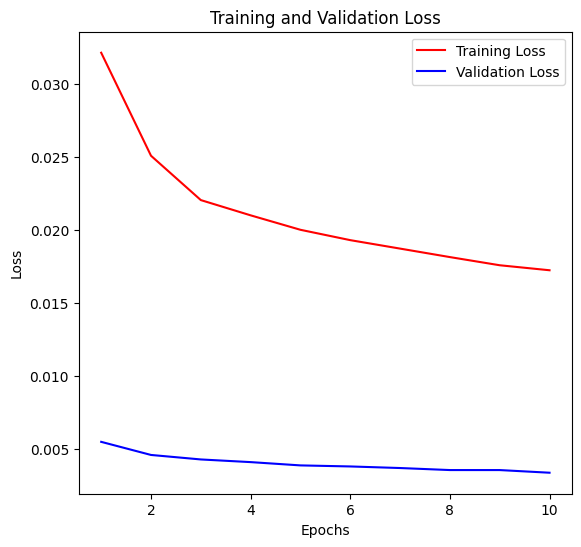

In [14]:
plot_loss_accuracy(training_loss, val_losses)

**ResNet101**

In [15]:
class ResNet101Autoencoder(nn.Module):
    def __init__(self):
        super(ResNet101Autoencoder, self).__init__()


        resnet = models.resnet101(pretrained=True)


        self.encoder = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4
        )


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [16]:
model_101 = ResNet101Autoencoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_101.parameters(), lr=1e-3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 178MB/s]


In [17]:
training_loss, val_losses = train_model(model_101, criterion, optimizer, num_epochs=10)

  0%|          | 1/391 [00:00<03:08,  2.07it/s]

Batch0 Loss: 0.07122451066970825


  1%|          | 2/391 [00:00<02:41,  2.41it/s]

Batch1 Loss: 0.06992118805646896


  1%|          | 3/391 [00:01<02:33,  2.53it/s]

Batch2 Loss: 0.06550277769565582


  1%|          | 4/391 [00:01<02:33,  2.53it/s]

Batch3 Loss: 0.06853492558002472


  1%|▏         | 5/391 [00:01<02:30,  2.56it/s]

Batch4 Loss: 0.06475941091775894


  2%|▏         | 6/391 [00:02<02:28,  2.60it/s]

Batch5 Loss: 0.0607810914516449


  2%|▏         | 7/391 [00:02<02:27,  2.59it/s]

Batch6 Loss: 0.06759480386972427


  2%|▏         | 8/391 [00:03<02:28,  2.59it/s]

Batch7 Loss: 0.06519632041454315


  2%|▏         | 9/391 [00:03<02:26,  2.61it/s]

Batch8 Loss: 0.06648703664541245


  3%|▎         | 10/391 [00:03<02:26,  2.60it/s]

Batch9 Loss: 0.06261222809553146


  3%|▎         | 11/391 [00:04<02:27,  2.57it/s]

Batch10 Loss: 0.06575188040733337


  3%|▎         | 12/391 [00:04<02:27,  2.58it/s]

Batch11 Loss: 0.06380584836006165


  3%|▎         | 13/391 [00:05<02:26,  2.57it/s]

Batch12 Loss: 0.06212601065635681


  4%|▎         | 14/391 [00:05<02:26,  2.57it/s]

Batch13 Loss: 0.06646519154310226


  4%|▍         | 15/391 [00:05<02:26,  2.57it/s]

Batch14 Loss: 0.0633363276720047


  4%|▍         | 16/391 [00:06<02:20,  2.68it/s]

Batch15 Loss: 0.06680211424827576


  4%|▍         | 17/391 [00:06<02:25,  2.57it/s]

Batch16 Loss: 0.06621350347995758


  5%|▍         | 18/391 [00:07<02:26,  2.54it/s]

Batch17 Loss: 0.06268031895160675


  5%|▍         | 19/391 [00:07<02:26,  2.54it/s]

Batch18 Loss: 0.06114393100142479


  5%|▌         | 20/391 [00:07<02:27,  2.52it/s]

Batch19 Loss: 0.06298815459012985


  5%|▌         | 21/391 [00:08<02:28,  2.49it/s]

Batch20 Loss: 0.06026625633239746


  6%|▌         | 22/391 [00:08<02:28,  2.48it/s]

Batch21 Loss: 0.06339582055807114


  6%|▌         | 23/391 [00:09<02:28,  2.47it/s]

Batch22 Loss: 0.057481005787849426


  6%|▌         | 24/391 [00:09<02:28,  2.47it/s]

Batch23 Loss: 0.061335496604442596


  6%|▋         | 25/391 [00:09<02:27,  2.49it/s]

Batch24 Loss: 0.06448756158351898


  7%|▋         | 26/391 [00:10<02:30,  2.43it/s]

Batch25 Loss: 0.06284937262535095


  7%|▋         | 27/391 [00:10<02:29,  2.43it/s]

Batch26 Loss: 0.061853956431150436


  7%|▋         | 28/391 [00:11<02:28,  2.45it/s]

Batch27 Loss: 0.062041085213422775


  7%|▋         | 29/391 [00:11<02:27,  2.45it/s]

Batch28 Loss: 0.057985447347164154


  8%|▊         | 30/391 [00:11<02:25,  2.47it/s]

Batch29 Loss: 0.06109269708395004


  8%|▊         | 31/391 [00:12<02:27,  2.45it/s]

Batch30 Loss: 0.05822618305683136


  8%|▊         | 32/391 [00:12<02:27,  2.44it/s]

Batch31 Loss: 0.059051405638456345


  8%|▊         | 33/391 [00:13<02:40,  2.23it/s]

Batch32 Loss: 0.05813778564333916


  9%|▊         | 34/391 [00:13<02:33,  2.33it/s]

Batch33 Loss: 0.056463681161403656


  9%|▉         | 35/391 [00:14<02:33,  2.32it/s]

Batch34 Loss: 0.06282754987478256


  9%|▉         | 36/391 [00:14<02:28,  2.39it/s]

Batch35 Loss: 0.057810764759778976


  9%|▉         | 37/391 [00:14<02:25,  2.44it/s]

Batch36 Loss: 0.06141336262226105


 10%|▉         | 38/391 [00:15<02:25,  2.42it/s]

Batch37 Loss: 0.056745316833257675


 10%|▉         | 39/391 [00:15<02:23,  2.45it/s]

Batch38 Loss: 0.05447841435670853


 10%|█         | 40/391 [00:16<02:22,  2.47it/s]

Batch39 Loss: 0.053623151034116745


 10%|█         | 41/391 [00:16<02:22,  2.46it/s]

Batch40 Loss: 0.05749610811471939


 11%|█         | 42/391 [00:16<02:22,  2.46it/s]

Batch41 Loss: 0.0531492754817009


 11%|█         | 43/391 [00:17<02:20,  2.48it/s]

Batch42 Loss: 0.0558195486664772


 11%|█▏        | 44/391 [00:17<02:20,  2.47it/s]

Batch43 Loss: 0.05294736474752426


 12%|█▏        | 45/391 [00:18<02:20,  2.46it/s]

Batch44 Loss: 0.05516906827688217


 12%|█▏        | 46/391 [00:18<02:19,  2.47it/s]

Batch45 Loss: 0.04874170571565628


 12%|█▏        | 47/391 [00:18<02:19,  2.46it/s]

Batch46 Loss: 0.05484014004468918


 12%|█▏        | 48/391 [00:19<02:21,  2.43it/s]

Batch47 Loss: 0.048404913395643234


 13%|█▎        | 49/391 [00:19<02:20,  2.43it/s]

Batch48 Loss: 0.05126258358359337


 13%|█▎        | 50/391 [00:20<02:21,  2.41it/s]

Batch49 Loss: 0.04978345334529877


 13%|█▎        | 51/391 [00:20<02:21,  2.40it/s]

Batch50 Loss: 0.046902135014534


 13%|█▎        | 52/391 [00:21<02:20,  2.41it/s]

Batch51 Loss: 0.04812316223978996


 14%|█▎        | 53/391 [00:21<02:21,  2.40it/s]

Batch52 Loss: 0.047240905463695526


 14%|█▍        | 54/391 [00:21<02:19,  2.42it/s]

Batch53 Loss: 0.0484902560710907


 14%|█▍        | 55/391 [00:22<02:18,  2.42it/s]

Batch54 Loss: 0.04760504513978958


 14%|█▍        | 56/391 [00:22<02:16,  2.45it/s]

Batch55 Loss: 0.04921358823776245


 15%|█▍        | 57/391 [00:23<02:15,  2.47it/s]

Batch56 Loss: 0.04370729252696037


 15%|█▍        | 58/391 [00:23<02:14,  2.48it/s]

Batch57 Loss: 0.0485888347029686


 15%|█▌        | 59/391 [00:23<02:13,  2.49it/s]

Batch58 Loss: 0.04941302537918091


 15%|█▌        | 60/391 [00:24<02:13,  2.49it/s]

Batch59 Loss: 0.04577165096998215


 16%|█▌        | 61/391 [00:24<02:12,  2.50it/s]

Batch60 Loss: 0.0464152917265892


 16%|█▌        | 62/391 [00:25<02:11,  2.50it/s]

Batch61 Loss: 0.04465146362781525


 16%|█▌        | 63/391 [00:25<02:11,  2.50it/s]

Batch62 Loss: 0.043715037405490875


 16%|█▋        | 64/391 [00:25<02:10,  2.51it/s]

Batch63 Loss: 0.04484933242201805


 17%|█▋        | 65/391 [00:26<02:09,  2.52it/s]

Batch64 Loss: 0.04516315460205078


 17%|█▋        | 66/391 [00:26<02:08,  2.53it/s]

Batch65 Loss: 0.04256709665060043


 17%|█▋        | 67/391 [00:27<02:07,  2.53it/s]

Batch66 Loss: 0.04275817424058914


 17%|█▋        | 68/391 [00:27<02:07,  2.53it/s]

Batch67 Loss: 0.04354900121688843


 18%|█▊        | 69/391 [00:27<02:06,  2.54it/s]

Batch68 Loss: 0.04295827075839043


 18%|█▊        | 70/391 [00:28<02:06,  2.53it/s]

Batch69 Loss: 0.04245626926422119


 18%|█▊        | 71/391 [00:28<02:05,  2.55it/s]

Batch70 Loss: 0.042255811393260956


 18%|█▊        | 72/391 [00:28<02:05,  2.53it/s]

Batch71 Loss: 0.04222125932574272


 19%|█▊        | 73/391 [00:29<02:05,  2.54it/s]

Batch72 Loss: 0.03770705312490463


 19%|█▉        | 74/391 [00:29<02:04,  2.55it/s]

Batch73 Loss: 0.04138370603322983


 19%|█▉        | 75/391 [00:30<02:17,  2.29it/s]

Batch74 Loss: 0.04079821705818176


 19%|█▉        | 76/391 [00:30<02:12,  2.38it/s]

Batch75 Loss: 0.037938881665468216


 20%|█▉        | 77/391 [00:31<02:13,  2.36it/s]

Batch76 Loss: 0.03854522854089737


 20%|█▉        | 78/391 [00:31<02:14,  2.33it/s]

Batch77 Loss: 0.0402655266225338


 20%|██        | 79/391 [00:31<02:11,  2.37it/s]

Batch78 Loss: 0.04020758718252182


 20%|██        | 80/391 [00:32<02:10,  2.39it/s]

Batch79 Loss: 0.038846708834171295


 21%|██        | 81/391 [00:32<02:08,  2.42it/s]

Batch80 Loss: 0.03417309373617172


 21%|██        | 82/391 [00:33<02:08,  2.40it/s]

Batch81 Loss: 0.0393671989440918


 21%|██        | 83/391 [00:33<02:07,  2.42it/s]

Batch82 Loss: 0.03835419937968254


 21%|██▏       | 84/391 [00:34<02:04,  2.46it/s]

Batch83 Loss: 0.040104739367961884


 22%|██▏       | 85/391 [00:34<02:03,  2.48it/s]

Batch84 Loss: 0.03862668573856354


 22%|██▏       | 86/391 [00:34<02:01,  2.51it/s]

Batch85 Loss: 0.0363963320851326


 22%|██▏       | 87/391 [00:35<01:59,  2.53it/s]

Batch86 Loss: 0.03810248523950577


 23%|██▎       | 88/391 [00:35<01:59,  2.55it/s]

Batch87 Loss: 0.04100213944911957


 23%|██▎       | 89/391 [00:35<01:57,  2.57it/s]

Batch88 Loss: 0.03799775242805481


 23%|██▎       | 90/391 [00:36<01:56,  2.58it/s]

Batch89 Loss: 0.03908644616603851


 23%|██▎       | 91/391 [00:36<01:56,  2.58it/s]

Batch90 Loss: 0.03655267134308815


 24%|██▎       | 92/391 [00:37<01:55,  2.59it/s]

Batch91 Loss: 0.03936023265123367


 24%|██▍       | 93/391 [00:37<01:54,  2.60it/s]

Batch92 Loss: 0.04075442999601364


 24%|██▍       | 94/391 [00:37<01:54,  2.59it/s]

Batch93 Loss: 0.03573547676205635


 24%|██▍       | 95/391 [00:38<01:54,  2.59it/s]

Batch94 Loss: 0.040598973631858826


 25%|██▍       | 96/391 [00:38<01:53,  2.60it/s]

Batch95 Loss: 0.03779982030391693


 25%|██▍       | 97/391 [00:39<01:52,  2.60it/s]

Batch96 Loss: 0.03711500018835068


 25%|██▌       | 98/391 [00:39<01:52,  2.60it/s]

Batch97 Loss: 0.035213977098464966


 25%|██▌       | 99/391 [00:39<01:52,  2.60it/s]

Batch98 Loss: 0.03817633166909218


 26%|██▌       | 100/391 [00:40<01:51,  2.61it/s]

Batch99 Loss: 0.03914056718349457


 26%|██▌       | 101/391 [00:40<01:51,  2.60it/s]

Batch100 Loss: 0.037565477192401886


 26%|██▌       | 102/391 [00:40<01:51,  2.60it/s]

Batch101 Loss: 0.036672309041023254


 26%|██▋       | 103/391 [00:41<01:50,  2.61it/s]

Batch102 Loss: 0.037105921655893326


 27%|██▋       | 104/391 [00:41<01:50,  2.60it/s]

Batch103 Loss: 0.03949946165084839


 27%|██▋       | 105/391 [00:42<01:50,  2.60it/s]

Batch104 Loss: 0.039015449583530426


 27%|██▋       | 106/391 [00:42<01:49,  2.60it/s]

Batch105 Loss: 0.041101422160863876


 27%|██▋       | 107/391 [00:42<01:49,  2.60it/s]

Batch106 Loss: 0.0367351695895195


 28%|██▊       | 108/391 [00:43<01:48,  2.61it/s]

Batch107 Loss: 0.037840940058231354


 28%|██▊       | 109/391 [00:43<01:47,  2.61it/s]

Batch108 Loss: 0.036274176090955734


 28%|██▊       | 110/391 [00:44<01:48,  2.58it/s]

Batch109 Loss: 0.03949274867773056


 28%|██▊       | 111/391 [00:44<01:48,  2.59it/s]

Batch110 Loss: 0.03739973157644272


 29%|██▊       | 112/391 [00:44<01:48,  2.57it/s]

Batch111 Loss: 0.037488266825675964


 29%|██▉       | 113/391 [00:45<01:48,  2.57it/s]

Batch112 Loss: 0.0400545671582222


 29%|██▉       | 114/391 [00:45<01:48,  2.55it/s]

Batch113 Loss: 0.034492895007133484


 29%|██▉       | 115/391 [00:45<01:49,  2.52it/s]

Batch114 Loss: 0.03691234067082405


 30%|██▉       | 116/391 [00:46<01:47,  2.55it/s]

Batch115 Loss: 0.03746308013796806


 30%|██▉       | 117/391 [00:46<01:46,  2.58it/s]

Batch116 Loss: 0.035990677773952484


 30%|███       | 118/391 [00:47<01:44,  2.60it/s]

Batch117 Loss: 0.03695450723171234


 30%|███       | 119/391 [00:47<01:44,  2.60it/s]

Batch118 Loss: 0.03498033434152603


 31%|███       | 120/391 [00:47<01:43,  2.62it/s]

Batch119 Loss: 0.03917614370584488


 31%|███       | 121/391 [00:48<01:42,  2.63it/s]

Batch120 Loss: 0.038272641599178314


 31%|███       | 122/391 [00:48<01:42,  2.63it/s]

Batch121 Loss: 0.03553623706102371


 31%|███▏      | 123/391 [00:49<01:41,  2.65it/s]

Batch122 Loss: 0.03775550052523613


 32%|███▏      | 124/391 [00:49<01:40,  2.65it/s]

Batch123 Loss: 0.036748986691236496


 32%|███▏      | 125/391 [00:49<01:40,  2.64it/s]

Batch124 Loss: 0.0349532812833786


 32%|███▏      | 126/391 [00:50<01:40,  2.64it/s]

Batch125 Loss: 0.03677523136138916


 32%|███▏      | 127/391 [00:50<01:40,  2.64it/s]

Batch126 Loss: 0.03447355329990387


 33%|███▎      | 128/391 [00:50<01:39,  2.64it/s]

Batch127 Loss: 0.036011915653944016


 33%|███▎      | 129/391 [00:51<01:39,  2.63it/s]

Batch128 Loss: 0.03282148018479347


 33%|███▎      | 130/391 [00:51<01:38,  2.65it/s]

Batch129 Loss: 0.0384235680103302


 34%|███▎      | 131/391 [00:52<01:38,  2.65it/s]

Batch130 Loss: 0.038347456604242325


 34%|███▍      | 132/391 [00:52<01:37,  2.65it/s]

Batch131 Loss: 0.032469265162944794


 34%|███▍      | 133/391 [00:52<01:37,  2.66it/s]

Batch132 Loss: 0.03545866534113884


 34%|███▍      | 134/391 [00:53<01:36,  2.67it/s]

Batch133 Loss: 0.03563525527715683


 35%|███▍      | 135/391 [00:53<01:36,  2.66it/s]

Batch134 Loss: 0.03430682420730591


 35%|███▍      | 136/391 [00:53<01:35,  2.67it/s]

Batch135 Loss: 0.035232607275247574


 35%|███▌      | 137/391 [00:54<01:35,  2.67it/s]

Batch136 Loss: 0.03441542014479637


 35%|███▌      | 138/391 [00:54<01:35,  2.66it/s]

Batch137 Loss: 0.03490279242396355


 36%|███▌      | 139/391 [00:55<01:34,  2.66it/s]

Batch138 Loss: 0.032408662140369415


 36%|███▌      | 140/391 [00:55<01:34,  2.66it/s]

Batch139 Loss: 0.03144744038581848


 36%|███▌      | 141/391 [00:55<01:33,  2.66it/s]

Batch140 Loss: 0.03345509245991707


 36%|███▋      | 142/391 [00:56<01:33,  2.65it/s]

Batch141 Loss: 0.03475189954042435


 37%|███▋      | 143/391 [00:56<01:33,  2.64it/s]

Batch142 Loss: 0.03297552093863487


 37%|███▋      | 144/391 [00:56<01:33,  2.63it/s]

Batch143 Loss: 0.03173813968896866


 37%|███▋      | 145/391 [00:57<01:34,  2.61it/s]

Batch144 Loss: 0.03303957358002663


 37%|███▋      | 146/391 [00:57<01:34,  2.60it/s]

Batch145 Loss: 0.03147871792316437


 38%|███▊      | 147/391 [00:58<01:35,  2.56it/s]

Batch146 Loss: 0.032652515918016434


 38%|███▊      | 148/391 [00:58<01:33,  2.59it/s]

Batch147 Loss: 0.0317443422973156


 38%|███▊      | 149/391 [00:58<01:33,  2.59it/s]

Batch148 Loss: 0.033402979373931885


 38%|███▊      | 150/391 [00:59<01:31,  2.62it/s]

Batch149 Loss: 0.03182057663798332


 39%|███▊      | 151/391 [00:59<01:31,  2.63it/s]

Batch150 Loss: 0.03337683901190758


 39%|███▉      | 152/391 [01:00<01:31,  2.62it/s]

Batch151 Loss: 0.03326212614774704


 39%|███▉      | 153/391 [01:00<01:30,  2.64it/s]

Batch152 Loss: 0.03366713598370552


 39%|███▉      | 154/391 [01:00<01:29,  2.65it/s]

Batch153 Loss: 0.03280480578541756


 40%|███▉      | 155/391 [01:01<01:28,  2.66it/s]

Batch154 Loss: 0.02889004349708557


 40%|███▉      | 156/391 [01:01<01:28,  2.66it/s]

Batch155 Loss: 0.0308973491191864


 40%|████      | 157/391 [01:01<01:27,  2.67it/s]

Batch156 Loss: 0.03283363953232765


 40%|████      | 158/391 [01:02<01:27,  2.66it/s]

Batch157 Loss: 0.03789176046848297


 41%|████      | 159/391 [01:02<01:27,  2.65it/s]

Batch158 Loss: 0.03399575501680374


 41%|████      | 160/391 [01:03<01:26,  2.67it/s]

Batch159 Loss: 0.03217717260122299


 41%|████      | 161/391 [01:03<01:26,  2.67it/s]

Batch160 Loss: 0.03406355530023575


 41%|████▏     | 162/391 [01:03<01:26,  2.66it/s]

Batch161 Loss: 0.034262582659721375


 42%|████▏     | 163/391 [01:04<01:25,  2.67it/s]

Batch162 Loss: 0.03575150668621063


 42%|████▏     | 164/391 [01:04<01:24,  2.67it/s]

Batch163 Loss: 0.03446932137012482


 42%|████▏     | 165/391 [01:04<01:25,  2.65it/s]

Batch164 Loss: 0.029888859018683434


 42%|████▏     | 166/391 [01:05<01:24,  2.66it/s]

Batch165 Loss: 0.03330279886722565


 43%|████▎     | 167/391 [01:05<01:24,  2.65it/s]

Batch166 Loss: 0.030585065484046936


 43%|████▎     | 168/391 [01:06<01:23,  2.66it/s]

Batch167 Loss: 0.032881658524274826


 43%|████▎     | 169/391 [01:06<01:23,  2.66it/s]

Batch168 Loss: 0.03126484900712967


 43%|████▎     | 170/391 [01:06<01:22,  2.67it/s]

Batch169 Loss: 0.03438087925314903


 44%|████▎     | 171/391 [01:07<01:22,  2.66it/s]

Batch170 Loss: 0.03171871602535248


 44%|████▍     | 172/391 [01:07<01:22,  2.65it/s]

Batch171 Loss: 0.033056214451789856


 44%|████▍     | 173/391 [01:07<01:22,  2.66it/s]

Batch172 Loss: 0.03215987607836723


 45%|████▍     | 174/391 [01:08<01:22,  2.62it/s]

Batch173 Loss: 0.035713743418455124


 45%|████▍     | 175/391 [01:08<01:22,  2.61it/s]

Batch174 Loss: 0.03353458642959595


 45%|████▌     | 176/391 [01:09<01:22,  2.60it/s]

Batch175 Loss: 0.03191134333610535


 45%|████▌     | 177/391 [01:09<01:22,  2.58it/s]

Batch176 Loss: 0.03244682028889656


 46%|████▌     | 178/391 [01:09<01:23,  2.56it/s]

Batch177 Loss: 0.031007973477244377


 46%|████▌     | 179/391 [01:10<01:22,  2.56it/s]

Batch178 Loss: 0.0334070585668087


 46%|████▌     | 180/391 [01:10<01:21,  2.58it/s]

Batch179 Loss: 0.03125610947608948


 46%|████▋     | 181/391 [01:11<01:20,  2.59it/s]

Batch180 Loss: 0.03346910700201988


 47%|████▋     | 182/391 [01:11<01:19,  2.62it/s]

Batch181 Loss: 0.031242109835147858


 47%|████▋     | 183/391 [01:11<01:19,  2.63it/s]

Batch182 Loss: 0.030714234337210655


 47%|████▋     | 184/391 [01:12<01:18,  2.63it/s]

Batch183 Loss: 0.029899299144744873


 47%|████▋     | 185/391 [01:12<01:18,  2.63it/s]

Batch184 Loss: 0.03369498625397682


 48%|████▊     | 186/391 [01:12<01:17,  2.64it/s]

Batch185 Loss: 0.03315378725528717


 48%|████▊     | 187/391 [01:13<01:17,  2.64it/s]

Batch186 Loss: 0.03292481601238251


 48%|████▊     | 188/391 [01:13<01:16,  2.64it/s]

Batch187 Loss: 0.0322619304060936


 48%|████▊     | 189/391 [01:14<01:16,  2.63it/s]

Batch188 Loss: 0.031493932008743286


 49%|████▊     | 190/391 [01:14<01:24,  2.39it/s]

Batch189 Loss: 0.03200143575668335


 49%|████▉     | 191/391 [01:14<01:20,  2.47it/s]

Batch190 Loss: 0.033050984144210815


 49%|████▉     | 192/391 [01:15<01:20,  2.47it/s]

Batch191 Loss: 0.03563084453344345


 49%|████▉     | 193/391 [01:15<01:22,  2.40it/s]

Batch192 Loss: 0.03228515386581421


 50%|████▉     | 194/391 [01:16<01:19,  2.49it/s]

Batch193 Loss: 0.0340241901576519


 50%|████▉     | 195/391 [01:16<01:18,  2.51it/s]

Batch194 Loss: 0.03342835232615471


 50%|█████     | 196/391 [01:16<01:16,  2.55it/s]

Batch195 Loss: 0.031554367393255234


 50%|█████     | 197/391 [01:17<01:15,  2.57it/s]

Batch196 Loss: 0.033506423234939575


 51%|█████     | 198/391 [01:17<01:14,  2.59it/s]

Batch197 Loss: 0.030548056587576866


 51%|█████     | 199/391 [01:18<01:14,  2.59it/s]

Batch198 Loss: 0.03150054067373276


 51%|█████     | 200/391 [01:18<01:13,  2.62it/s]

Batch199 Loss: 0.03244452923536301


 51%|█████▏    | 201/391 [01:18<01:12,  2.63it/s]

Batch200 Loss: 0.03181925415992737


 52%|█████▏    | 202/391 [01:19<01:11,  2.63it/s]

Batch201 Loss: 0.02922002598643303


 52%|█████▏    | 203/391 [01:19<01:11,  2.63it/s]

Batch202 Loss: 0.033631183207035065


 52%|█████▏    | 204/391 [01:19<01:11,  2.62it/s]

Batch203 Loss: 0.03259129449725151


 52%|█████▏    | 205/391 [01:20<01:11,  2.62it/s]

Batch204 Loss: 0.03413262590765953


 53%|█████▎    | 206/391 [01:20<01:11,  2.60it/s]

Batch205 Loss: 0.03144481033086777


 53%|█████▎    | 207/391 [01:21<01:10,  2.59it/s]

Batch206 Loss: 0.0336528941988945


 53%|█████▎    | 208/391 [01:21<01:11,  2.57it/s]

Batch207 Loss: 0.03244173154234886


 53%|█████▎    | 209/391 [01:21<01:11,  2.54it/s]

Batch208 Loss: 0.03429614007472992


 54%|█████▎    | 210/391 [01:22<01:11,  2.54it/s]

Batch209 Loss: 0.03585183620452881


 54%|█████▍    | 211/391 [01:22<01:11,  2.53it/s]

Batch210 Loss: 0.035025689750909805


 54%|█████▍    | 212/391 [01:23<01:10,  2.55it/s]

Batch211 Loss: 0.036156877875328064


 54%|█████▍    | 213/391 [01:23<01:09,  2.57it/s]

Batch212 Loss: 0.03391827642917633


 55%|█████▍    | 214/391 [01:23<01:08,  2.58it/s]

Batch213 Loss: 0.03400696814060211


 55%|█████▍    | 215/391 [01:24<01:08,  2.58it/s]

Batch214 Loss: 0.033974722027778625


 55%|█████▌    | 216/391 [01:24<01:07,  2.59it/s]

Batch215 Loss: 0.0338142104446888


 55%|█████▌    | 217/391 [01:25<01:07,  2.59it/s]

Batch216 Loss: 0.0337366908788681


 56%|█████▌    | 218/391 [01:25<01:06,  2.59it/s]

Batch217 Loss: 0.0337371900677681


 56%|█████▌    | 219/391 [01:25<01:06,  2.59it/s]

Batch218 Loss: 0.03489280492067337


 56%|█████▋    | 220/391 [01:26<01:06,  2.59it/s]

Batch219 Loss: 0.03148946166038513


 57%|█████▋    | 221/391 [01:26<01:05,  2.60it/s]

Batch220 Loss: 0.03237493708729744


 57%|█████▋    | 222/391 [01:26<01:05,  2.60it/s]

Batch221 Loss: 0.0340350978076458


 57%|█████▋    | 223/391 [01:27<01:04,  2.60it/s]

Batch222 Loss: 0.03222675248980522


 57%|█████▋    | 224/391 [01:27<01:04,  2.60it/s]

Batch223 Loss: 0.031728535890579224


 58%|█████▊    | 225/391 [01:28<01:04,  2.59it/s]

Batch224 Loss: 0.03077489696443081


 58%|█████▊    | 226/391 [01:28<01:03,  2.60it/s]

Batch225 Loss: 0.03213038295507431


 58%|█████▊    | 227/391 [01:28<01:03,  2.60it/s]

Batch226 Loss: 0.031013086438179016


 58%|█████▊    | 228/391 [01:29<01:02,  2.60it/s]

Batch227 Loss: 0.031863316893577576


 59%|█████▊    | 229/391 [01:29<01:02,  2.60it/s]

Batch228 Loss: 0.032740332186222076


 59%|█████▉    | 230/391 [01:30<01:01,  2.60it/s]

Batch229 Loss: 0.031474024057388306


 59%|█████▉    | 231/391 [01:30<01:01,  2.59it/s]

Batch230 Loss: 0.0349256806075573


 59%|█████▉    | 232/391 [01:30<01:01,  2.60it/s]

Batch231 Loss: 0.03237827867269516


 60%|█████▉    | 233/391 [01:31<01:00,  2.59it/s]

Batch232 Loss: 0.03168175369501114


 60%|█████▉    | 234/391 [01:31<01:00,  2.60it/s]

Batch233 Loss: 0.032028988003730774


 60%|██████    | 235/391 [01:31<01:00,  2.60it/s]

Batch234 Loss: 0.03023786097764969


 60%|██████    | 236/391 [01:32<00:59,  2.60it/s]

Batch235 Loss: 0.031481966376304626


 61%|██████    | 237/391 [01:32<00:59,  2.59it/s]

Batch236 Loss: 0.03329487890005112


 61%|██████    | 238/391 [01:33<00:59,  2.56it/s]

Batch237 Loss: 0.03052670508623123


 61%|██████    | 239/391 [01:33<00:59,  2.57it/s]

Batch238 Loss: 0.031432945281267166


 61%|██████▏   | 240/391 [01:33<00:58,  2.56it/s]

Batch239 Loss: 0.028596706688404083


 62%|██████▏   | 241/391 [01:34<00:58,  2.55it/s]

Batch240 Loss: 0.03159618005156517


 62%|██████▏   | 242/391 [01:34<00:58,  2.54it/s]

Batch241 Loss: 0.030815867707133293


 62%|██████▏   | 243/391 [01:35<00:58,  2.54it/s]

Batch242 Loss: 0.031825389713048935


 62%|██████▏   | 244/391 [01:35<00:57,  2.55it/s]

Batch243 Loss: 0.033147115260362625


 63%|██████▎   | 245/391 [01:35<00:57,  2.55it/s]

Batch244 Loss: 0.03013499081134796


 63%|██████▎   | 246/391 [01:36<00:56,  2.58it/s]

Batch245 Loss: 0.031556226313114166


 63%|██████▎   | 247/391 [01:36<00:55,  2.59it/s]

Batch246 Loss: 0.031989794224500656


 63%|██████▎   | 248/391 [01:37<00:55,  2.58it/s]

Batch247 Loss: 0.03290342539548874


 64%|██████▎   | 249/391 [01:37<00:54,  2.59it/s]

Batch248 Loss: 0.030805593356490135


 64%|██████▍   | 250/391 [01:37<00:54,  2.60it/s]

Batch249 Loss: 0.028886180371046066


 64%|██████▍   | 251/391 [01:38<00:53,  2.59it/s]

Batch250 Loss: 0.033143285661935806


 64%|██████▍   | 252/391 [01:38<00:53,  2.60it/s]

Batch251 Loss: 0.03194860368967056


 65%|██████▍   | 253/391 [01:38<00:53,  2.60it/s]

Batch252 Loss: 0.03042878769338131


 65%|██████▍   | 254/391 [01:39<00:52,  2.60it/s]

Batch253 Loss: 0.03130447864532471


 65%|██████▌   | 255/391 [01:39<00:52,  2.60it/s]

Batch254 Loss: 0.03406817838549614


 65%|██████▌   | 256/391 [01:40<00:52,  2.57it/s]

Batch255 Loss: 0.03169502317905426


 66%|██████▌   | 257/391 [01:40<00:51,  2.58it/s]

Batch256 Loss: 0.02992403134703636


 66%|██████▌   | 258/391 [01:40<00:51,  2.58it/s]

Batch257 Loss: 0.031660281121730804


 66%|██████▌   | 259/391 [01:41<00:51,  2.58it/s]

Batch258 Loss: 0.03163156658411026


 66%|██████▋   | 260/391 [01:41<00:50,  2.59it/s]

Batch259 Loss: 0.030368736013770103


 67%|██████▋   | 261/391 [01:42<00:50,  2.59it/s]

Batch260 Loss: 0.030449535697698593


 67%|██████▋   | 262/391 [01:42<00:49,  2.59it/s]

Batch261 Loss: 0.030417874455451965


 67%|██████▋   | 263/391 [01:42<00:49,  2.59it/s]

Batch262 Loss: 0.029607264325022697


 68%|██████▊   | 264/391 [01:43<00:48,  2.59it/s]

Batch263 Loss: 0.030184905976057053


 68%|██████▊   | 265/391 [01:43<00:48,  2.59it/s]

Batch264 Loss: 0.028978001326322556


 68%|██████▊   | 266/391 [01:43<00:48,  2.60it/s]

Batch265 Loss: 0.029744893312454224


 68%|██████▊   | 267/391 [01:44<00:47,  2.60it/s]

Batch266 Loss: 0.030981918796896935


 69%|██████▊   | 268/391 [01:44<00:47,  2.59it/s]

Batch267 Loss: 0.0293908528983593


 69%|██████▉   | 269/391 [01:45<00:47,  2.55it/s]

Batch268 Loss: 0.0335102342069149


 69%|██████▉   | 270/391 [01:45<00:47,  2.55it/s]

Batch269 Loss: 0.030560769140720367


 69%|██████▉   | 271/391 [01:45<00:47,  2.53it/s]

Batch270 Loss: 0.030059896409511566


 70%|██████▉   | 272/391 [01:46<00:47,  2.53it/s]

Batch271 Loss: 0.03072553500533104


 70%|██████▉   | 273/391 [01:46<00:46,  2.53it/s]

Batch272 Loss: 0.031237071380019188


 70%|███████   | 274/391 [01:47<00:46,  2.51it/s]

Batch273 Loss: 0.030162891373038292


 70%|███████   | 275/391 [01:47<00:45,  2.53it/s]

Batch274 Loss: 0.028219856321811676


 71%|███████   | 276/391 [01:47<00:45,  2.54it/s]

Batch275 Loss: 0.029980530962347984


 71%|███████   | 277/391 [01:48<00:45,  2.51it/s]

Batch276 Loss: 0.03010762296617031


 71%|███████   | 278/391 [01:48<00:44,  2.55it/s]

Batch277 Loss: 0.03017605096101761


 71%|███████▏  | 279/391 [01:49<00:44,  2.54it/s]

Batch278 Loss: 0.029545627534389496


 72%|███████▏  | 280/391 [01:49<00:43,  2.56it/s]

Batch279 Loss: 0.030087267979979515


 72%|███████▏  | 281/391 [01:49<00:42,  2.57it/s]

Batch280 Loss: 0.030672676861286163


 72%|███████▏  | 282/391 [01:50<00:42,  2.57it/s]

Batch281 Loss: 0.027338234707713127


 72%|███████▏  | 283/391 [01:50<00:41,  2.58it/s]

Batch282 Loss: 0.028425229713320732


 73%|███████▎  | 284/391 [01:51<00:41,  2.59it/s]

Batch283 Loss: 0.03050486370921135


 73%|███████▎  | 285/391 [01:51<00:41,  2.58it/s]

Batch284 Loss: 0.030212674289941788


 73%|███████▎  | 286/391 [01:51<00:40,  2.58it/s]

Batch285 Loss: 0.029416626319289207


 73%|███████▎  | 287/391 [01:52<00:39,  2.60it/s]

Batch286 Loss: 0.03011832758784294


 74%|███████▎  | 288/391 [01:52<00:39,  2.60it/s]

Batch287 Loss: 0.027930911630392075


 74%|███████▍  | 289/391 [01:52<00:39,  2.60it/s]

Batch288 Loss: 0.029670629650354385


 74%|███████▍  | 290/391 [01:53<00:38,  2.60it/s]

Batch289 Loss: 0.03188995271921158


 74%|███████▍  | 291/391 [01:53<00:38,  2.60it/s]

Batch290 Loss: 0.029730305075645447


 75%|███████▍  | 292/391 [01:54<00:38,  2.60it/s]

Batch291 Loss: 0.02942412905395031


 75%|███████▍  | 293/391 [01:54<00:37,  2.60it/s]

Batch292 Loss: 0.02856125496327877


 75%|███████▌  | 294/391 [01:54<00:37,  2.59it/s]

Batch293 Loss: 0.028869982808828354


 75%|███████▌  | 295/391 [01:55<00:36,  2.60it/s]

Batch294 Loss: 0.030462566763162613


 76%|███████▌  | 296/391 [01:55<00:36,  2.60it/s]

Batch295 Loss: 0.029804063960909843


 76%|███████▌  | 297/391 [01:56<00:36,  2.60it/s]

Batch296 Loss: 0.02944682352244854


 76%|███████▌  | 298/391 [01:56<00:35,  2.60it/s]

Batch297 Loss: 0.029311059042811394


 76%|███████▋  | 299/391 [01:56<00:35,  2.60it/s]

Batch298 Loss: 0.029611675068736076


 77%|███████▋  | 300/391 [01:57<00:34,  2.61it/s]

Batch299 Loss: 0.028571568429470062


 77%|███████▋  | 301/391 [01:57<00:35,  2.57it/s]

Batch300 Loss: 0.029160132631659508


 77%|███████▋  | 302/391 [01:57<00:35,  2.54it/s]

Batch301 Loss: 0.029124153777956963


 77%|███████▋  | 303/391 [01:58<00:34,  2.54it/s]

Batch302 Loss: 0.02950749360024929


 78%|███████▊  | 304/391 [01:58<00:34,  2.54it/s]

Batch303 Loss: 0.029003173112869263


 78%|███████▊  | 305/391 [01:59<00:34,  2.52it/s]

Batch304 Loss: 0.0291169174015522


 78%|███████▊  | 306/391 [01:59<00:33,  2.51it/s]

Batch305 Loss: 0.02779812179505825


 79%|███████▊  | 307/391 [01:59<00:33,  2.53it/s]

Batch306 Loss: 0.02944464609026909


 79%|███████▉  | 308/391 [02:00<00:32,  2.54it/s]

Batch307 Loss: 0.03055654466152191


 79%|███████▉  | 309/391 [02:00<00:31,  2.57it/s]

Batch308 Loss: 0.02966594696044922


 79%|███████▉  | 310/391 [02:01<00:31,  2.58it/s]

Batch309 Loss: 0.030426204204559326


 80%|███████▉  | 311/391 [02:01<00:31,  2.58it/s]

Batch310 Loss: 0.028137577697634697


 80%|███████▉  | 312/391 [02:01<00:30,  2.59it/s]

Batch311 Loss: 0.028687134385108948


 80%|████████  | 313/391 [02:02<00:30,  2.59it/s]

Batch312 Loss: 0.029006099328398705


 80%|████████  | 314/391 [02:02<00:29,  2.59it/s]

Batch313 Loss: 0.030286042019724846


 81%|████████  | 315/391 [02:03<00:29,  2.59it/s]

Batch314 Loss: 0.030799534171819687


 81%|████████  | 316/391 [02:03<00:28,  2.59it/s]

Batch315 Loss: 0.03173036128282547


 81%|████████  | 317/391 [02:03<00:28,  2.59it/s]

Batch316 Loss: 0.028246939182281494


 81%|████████▏ | 318/391 [02:04<00:28,  2.60it/s]

Batch317 Loss: 0.025261979550123215


 82%|████████▏ | 319/391 [02:04<00:27,  2.60it/s]

Batch318 Loss: 0.0287216454744339


 82%|████████▏ | 320/391 [02:04<00:27,  2.60it/s]

Batch319 Loss: 0.029533861204981804


 82%|████████▏ | 321/391 [02:05<00:26,  2.60it/s]

Batch320 Loss: 0.028807729482650757


 82%|████████▏ | 322/391 [02:05<00:26,  2.60it/s]

Batch321 Loss: 0.028189539909362793


 83%|████████▎ | 323/391 [02:06<00:26,  2.60it/s]

Batch322 Loss: 0.028145641088485718


 83%|████████▎ | 324/391 [02:06<00:25,  2.60it/s]

Batch323 Loss: 0.025717929005622864


 83%|████████▎ | 325/391 [02:06<00:25,  2.60it/s]

Batch324 Loss: 0.02904614433646202


 83%|████████▎ | 326/391 [02:07<00:25,  2.60it/s]

Batch325 Loss: 0.02713615447282791


 84%|████████▎ | 327/391 [02:07<00:24,  2.60it/s]

Batch326 Loss: 0.02996174246072769


 84%|████████▍ | 328/391 [02:08<00:24,  2.60it/s]

Batch327 Loss: 0.028681626543402672


 84%|████████▍ | 329/391 [02:08<00:23,  2.60it/s]

Batch328 Loss: 0.02775881253182888


 84%|████████▍ | 330/391 [02:08<00:23,  2.59it/s]

Batch329 Loss: 0.027836468070745468


 85%|████████▍ | 331/391 [02:09<00:23,  2.61it/s]

Batch330 Loss: 0.025579823181033134


 85%|████████▍ | 332/391 [02:09<00:22,  2.60it/s]

Batch331 Loss: 0.029253562912344933


 85%|████████▌ | 333/391 [02:09<00:22,  2.57it/s]

Batch332 Loss: 0.02600756287574768


 85%|████████▌ | 334/391 [02:10<00:22,  2.57it/s]

Batch333 Loss: 0.026901885867118835


 86%|████████▌ | 335/391 [02:10<00:21,  2.55it/s]

Batch334 Loss: 0.02752067521214485


 86%|████████▌ | 336/391 [02:11<00:21,  2.55it/s]

Batch335 Loss: 0.029141243547201157


 86%|████████▌ | 337/391 [02:11<00:21,  2.54it/s]

Batch336 Loss: 0.027190908789634705


 86%|████████▋ | 338/391 [02:11<00:20,  2.55it/s]

Batch337 Loss: 0.02843540534377098


 87%|████████▋ | 339/391 [02:12<00:20,  2.56it/s]

Batch338 Loss: 0.02609114907681942


 87%|████████▋ | 340/391 [02:12<00:19,  2.57it/s]

Batch339 Loss: 0.027744485065340996


 87%|████████▋ | 341/391 [02:13<00:19,  2.59it/s]

Batch340 Loss: 0.02830430120229721


 87%|████████▋ | 342/391 [02:13<00:18,  2.59it/s]

Batch341 Loss: 0.027881165966391563


 88%|████████▊ | 343/391 [02:13<00:18,  2.59it/s]

Batch342 Loss: 0.02582801692187786


 88%|████████▊ | 344/391 [02:14<00:18,  2.60it/s]

Batch343 Loss: 0.027272691950201988


 88%|████████▊ | 345/391 [02:14<00:17,  2.60it/s]

Batch344 Loss: 0.02881592884659767


 88%|████████▊ | 346/391 [02:15<00:17,  2.59it/s]

Batch345 Loss: 0.031337983906269073


 89%|████████▊ | 347/391 [02:15<00:16,  2.61it/s]

Batch346 Loss: 0.02746202051639557


 89%|████████▉ | 348/391 [02:15<00:16,  2.60it/s]

Batch347 Loss: 0.0298117995262146


 89%|████████▉ | 349/391 [02:16<00:16,  2.60it/s]

Batch348 Loss: 0.029311537742614746


 90%|████████▉ | 350/391 [02:16<00:15,  2.61it/s]

Batch349 Loss: 0.031147487461566925


 90%|████████▉ | 351/391 [02:16<00:15,  2.60it/s]

Batch350 Loss: 0.028576459735631943


 90%|█████████ | 352/391 [02:17<00:15,  2.60it/s]

Batch351 Loss: 0.028772439807653427


 90%|█████████ | 353/391 [02:17<00:14,  2.61it/s]

Batch352 Loss: 0.028045084327459335


 91%|█████████ | 354/391 [02:18<00:14,  2.60it/s]

Batch353 Loss: 0.027234360575675964


 91%|█████████ | 355/391 [02:18<00:13,  2.60it/s]

Batch354 Loss: 0.029018571600317955


 91%|█████████ | 356/391 [02:18<00:13,  2.60it/s]

Batch355 Loss: 0.027495861053466797


 91%|█████████▏| 357/391 [02:19<00:13,  2.60it/s]

Batch356 Loss: 0.02928895875811577


 92%|█████████▏| 358/391 [02:19<00:12,  2.60it/s]

Batch357 Loss: 0.02909584902226925


 92%|█████████▏| 359/391 [02:20<00:12,  2.60it/s]

Batch358 Loss: 0.027295857667922974


 92%|█████████▏| 360/391 [02:20<00:11,  2.60it/s]

Batch359 Loss: 0.025619929656386375


 92%|█████████▏| 361/391 [02:20<00:11,  2.60it/s]

Batch360 Loss: 0.030177218839526176


 93%|█████████▎| 362/391 [02:21<00:11,  2.60it/s]

Batch361 Loss: 0.026603419333696365


 93%|█████████▎| 363/391 [02:21<00:10,  2.60it/s]

Batch362 Loss: 0.027006736025214195


 93%|█████████▎| 364/391 [02:21<00:10,  2.58it/s]

Batch363 Loss: 0.029019638895988464


 93%|█████████▎| 365/391 [02:22<00:10,  2.57it/s]

Batch364 Loss: 0.02799489162862301


 94%|█████████▎| 366/391 [02:22<00:09,  2.54it/s]

Batch365 Loss: 0.026122476905584335


 94%|█████████▍| 367/391 [02:23<00:09,  2.52it/s]

Batch366 Loss: 0.028747161850333214


 94%|█████████▍| 368/391 [02:23<00:09,  2.53it/s]

Batch367 Loss: 0.02762063592672348


 94%|█████████▍| 369/391 [02:23<00:08,  2.51it/s]

Batch368 Loss: 0.026095768436789513


 95%|█████████▍| 370/391 [02:24<00:08,  2.54it/s]

Batch369 Loss: 0.026923220604658127


 95%|█████████▍| 371/391 [02:24<00:07,  2.55it/s]

Batch370 Loss: 0.027826160192489624


 95%|█████████▌| 372/391 [02:25<00:07,  2.57it/s]

Batch371 Loss: 0.026261111721396446


 95%|█████████▌| 373/391 [02:25<00:06,  2.58it/s]

Batch372 Loss: 0.03023209236562252


 96%|█████████▌| 374/391 [02:25<00:06,  2.58it/s]

Batch373 Loss: 0.026779979467391968


 96%|█████████▌| 375/391 [02:26<00:06,  2.59it/s]

Batch374 Loss: 0.025822198018431664


 96%|█████████▌| 376/391 [02:26<00:05,  2.59it/s]

Batch375 Loss: 0.02789996936917305


 96%|█████████▋| 377/391 [02:27<00:05,  2.60it/s]

Batch376 Loss: 0.0268342774361372


 97%|█████████▋| 378/391 [02:27<00:05,  2.60it/s]

Batch377 Loss: 0.0276417788118124


 97%|█████████▋| 379/391 [02:27<00:04,  2.60it/s]

Batch378 Loss: 0.02682468108832836


 97%|█████████▋| 380/391 [02:28<00:04,  2.59it/s]

Batch379 Loss: 0.02723497711122036


 97%|█████████▋| 381/391 [02:28<00:03,  2.60it/s]

Batch380 Loss: 0.02784365974366665


 98%|█████████▊| 382/391 [02:28<00:03,  2.58it/s]

Batch381 Loss: 0.027193186804652214


 98%|█████████▊| 383/391 [02:29<00:03,  2.60it/s]

Batch382 Loss: 0.028066104277968407


 98%|█████████▊| 384/391 [02:29<00:02,  2.60it/s]

Batch383 Loss: 0.026265239343047142


 98%|█████████▊| 385/391 [02:30<00:02,  2.59it/s]

Batch384 Loss: 0.028363248333334923


 99%|█████████▊| 386/391 [02:30<00:01,  2.60it/s]

Batch385 Loss: 0.028612835332751274


 99%|█████████▉| 387/391 [02:30<00:01,  2.60it/s]

Batch386 Loss: 0.02856362983584404


 99%|█████████▉| 388/391 [02:31<00:01,  2.60it/s]

Batch387 Loss: 0.025050748139619827


 99%|█████████▉| 389/391 [02:31<00:00,  2.60it/s]

Batch388 Loss: 0.026585569605231285


100%|█████████▉| 390/391 [02:32<00:00,  2.60it/s]

Batch389 Loss: 0.02762450836598873


100%|██████████| 391/391 [02:32<00:00,  2.57it/s]


Batch390 Loss: 0.028173018246889114
Epoch 1/10 - Train Loss: 0.0363


100%|██████████| 79/79 [00:21<00:00,  3.73it/s]


Epoch 1/10 - Val Loss: 0.0057


  0%|          | 1/391 [00:00<02:30,  2.60it/s]

Batch0 Loss: 0.027294430881738663


  1%|          | 2/391 [00:00<02:26,  2.65it/s]

Batch1 Loss: 0.028035596013069153


  1%|          | 3/391 [00:01<02:28,  2.62it/s]

Batch2 Loss: 0.02780650183558464


  1%|          | 4/391 [00:01<02:27,  2.62it/s]

Batch3 Loss: 0.02690749429166317


  1%|▏         | 5/391 [00:01<02:27,  2.62it/s]

Batch4 Loss: 0.0286333616822958


  2%|▏         | 6/391 [00:02<02:26,  2.62it/s]

Batch5 Loss: 0.027348792180418968


  2%|▏         | 7/391 [00:02<02:27,  2.60it/s]

Batch6 Loss: 0.02465851604938507


  2%|▏         | 8/391 [00:03<02:26,  2.61it/s]

Batch7 Loss: 0.026818258687853813


  2%|▏         | 9/391 [00:03<02:26,  2.60it/s]

Batch8 Loss: 0.027499184012413025


  3%|▎         | 10/391 [00:03<02:26,  2.60it/s]

Batch9 Loss: 0.028597887605428696


  3%|▎         | 11/391 [00:04<02:25,  2.61it/s]

Batch10 Loss: 0.028372865170240402


  3%|▎         | 12/391 [00:04<02:25,  2.60it/s]

Batch11 Loss: 0.027317102998495102


  3%|▎         | 13/391 [00:04<02:25,  2.60it/s]

Batch12 Loss: 0.02768092416226864


  4%|▎         | 14/391 [00:05<02:26,  2.57it/s]

Batch13 Loss: 0.027609989047050476


  4%|▍         | 15/391 [00:05<02:28,  2.54it/s]

Batch14 Loss: 0.02624770998954773


  4%|▍         | 16/391 [00:06<02:28,  2.53it/s]

Batch15 Loss: 0.0271909236907959


  4%|▍         | 17/391 [00:06<02:28,  2.52it/s]

Batch16 Loss: 0.026885133236646652


  5%|▍         | 18/391 [00:06<02:27,  2.52it/s]

Batch17 Loss: 0.02529163472354412


  5%|▍         | 19/391 [00:07<02:28,  2.50it/s]

Batch18 Loss: 0.025505438446998596


  5%|▌         | 20/391 [00:07<02:26,  2.53it/s]

Batch19 Loss: 0.028518369421362877


  5%|▌         | 21/391 [00:08<02:25,  2.54it/s]

Batch20 Loss: 0.026951447129249573


  6%|▌         | 22/391 [00:08<02:23,  2.57it/s]

Batch21 Loss: 0.028207555413246155


  6%|▌         | 23/391 [00:08<02:22,  2.58it/s]

Batch22 Loss: 0.027103913947939873


  6%|▌         | 24/391 [00:09<02:22,  2.58it/s]

Batch23 Loss: 0.026917509734630585


  6%|▋         | 25/391 [00:09<02:21,  2.59it/s]

Batch24 Loss: 0.027241777628660202


  7%|▋         | 26/391 [00:10<02:20,  2.60it/s]

Batch25 Loss: 0.02587895654141903


  7%|▋         | 27/391 [00:10<02:20,  2.59it/s]

Batch26 Loss: 0.026667019352316856


  7%|▋         | 28/391 [00:10<02:20,  2.59it/s]

Batch27 Loss: 0.02537270449101925


  7%|▋         | 29/391 [00:11<02:19,  2.60it/s]

Batch28 Loss: 0.025937935337424278


  8%|▊         | 30/391 [00:11<02:18,  2.60it/s]

Batch29 Loss: 0.026970043778419495


  8%|▊         | 31/391 [00:12<02:18,  2.60it/s]

Batch30 Loss: 0.025002561509609222


  8%|▊         | 32/391 [00:12<02:18,  2.60it/s]

Batch31 Loss: 0.026848703622817993


  8%|▊         | 33/391 [00:12<02:17,  2.60it/s]

Batch32 Loss: 0.02811415120959282


  9%|▊         | 34/391 [00:13<02:17,  2.60it/s]

Batch33 Loss: 0.026599450036883354


  9%|▉         | 35/391 [00:13<02:16,  2.60it/s]

Batch34 Loss: 0.02674279734492302


  9%|▉         | 36/391 [00:13<02:16,  2.61it/s]

Batch35 Loss: 0.028186291456222534


  9%|▉         | 37/391 [00:14<02:16,  2.60it/s]

Batch36 Loss: 0.025157969444990158


 10%|▉         | 38/391 [00:14<02:15,  2.60it/s]

Batch37 Loss: 0.027455851435661316


 10%|▉         | 39/391 [00:15<02:15,  2.60it/s]

Batch38 Loss: 0.025503024458885193


 10%|█         | 40/391 [00:15<02:15,  2.59it/s]

Batch39 Loss: 0.026018669828772545


 10%|█         | 41/391 [00:15<02:14,  2.60it/s]

Batch40 Loss: 0.02633044123649597


 11%|█         | 42/391 [00:16<02:14,  2.60it/s]

Batch41 Loss: 0.0279531292617321


 11%|█         | 43/391 [00:16<02:13,  2.60it/s]

Batch42 Loss: 0.026689177379012108


 11%|█▏        | 44/391 [00:17<02:12,  2.61it/s]

Batch43 Loss: 0.02890232764184475


 12%|█▏        | 45/391 [00:17<02:13,  2.59it/s]

Batch44 Loss: 0.026695137843489647


 12%|█▏        | 46/391 [00:17<02:13,  2.59it/s]

Batch45 Loss: 0.025353064760565758


 12%|█▏        | 47/391 [00:18<02:13,  2.58it/s]

Batch46 Loss: 0.027278881520032883


 12%|█▏        | 48/391 [00:18<02:15,  2.54it/s]

Batch47 Loss: 0.028642460703849792


 13%|█▎        | 49/391 [00:18<02:14,  2.54it/s]

Batch48 Loss: 0.025135813280940056


 13%|█▎        | 50/391 [00:19<02:14,  2.53it/s]

Batch49 Loss: 0.024786196649074554


 13%|█▎        | 51/391 [00:19<02:13,  2.54it/s]

Batch50 Loss: 0.025619685649871826


 13%|█▎        | 52/391 [00:20<02:12,  2.56it/s]

Batch51 Loss: 0.026030538603663445


 14%|█▎        | 53/391 [00:20<02:11,  2.58it/s]

Batch52 Loss: 0.026998061686754227


 14%|█▍        | 54/391 [00:20<02:10,  2.58it/s]

Batch53 Loss: 0.02776961773633957


 14%|█▍        | 55/391 [00:21<02:10,  2.58it/s]

Batch54 Loss: 0.026649046689271927


 14%|█▍        | 56/391 [00:21<02:09,  2.59it/s]

Batch55 Loss: 0.02496851049363613


 15%|█▍        | 57/391 [00:22<02:09,  2.59it/s]

Batch56 Loss: 0.02683703601360321


 15%|█▍        | 58/391 [00:22<02:08,  2.60it/s]

Batch57 Loss: 0.02507677674293518


 15%|█▌        | 59/391 [00:22<02:07,  2.60it/s]

Batch58 Loss: 0.027280036360025406


 15%|█▌        | 60/391 [00:23<02:07,  2.59it/s]

Batch59 Loss: 0.02725345641374588


 16%|█▌        | 61/391 [00:23<02:06,  2.60it/s]

Batch60 Loss: 0.027126183733344078


 16%|█▌        | 62/391 [00:23<02:06,  2.60it/s]

Batch61 Loss: 0.027449754998087883


 16%|█▌        | 63/391 [00:24<02:06,  2.60it/s]

Batch62 Loss: 0.027907248586416245


 16%|█▋        | 64/391 [00:24<02:05,  2.60it/s]

Batch63 Loss: 0.027244586497545242


 17%|█▋        | 65/391 [00:25<02:05,  2.59it/s]

Batch64 Loss: 0.027163416147232056


 17%|█▋        | 66/391 [00:25<02:05,  2.60it/s]

Batch65 Loss: 0.027681171894073486


 17%|█▋        | 67/391 [00:25<02:04,  2.60it/s]

Batch66 Loss: 0.02511143684387207


 17%|█▋        | 68/391 [00:26<02:04,  2.60it/s]

Batch67 Loss: 0.026051446795463562


 18%|█▊        | 69/391 [00:26<02:04,  2.60it/s]

Batch68 Loss: 0.026488181203603745


 18%|█▊        | 70/391 [00:27<02:03,  2.60it/s]

Batch69 Loss: 0.026333581656217575


 18%|█▊        | 71/391 [00:27<02:03,  2.59it/s]

Batch70 Loss: 0.024713221937417984


 18%|█▊        | 72/391 [00:27<02:02,  2.59it/s]

Batch71 Loss: 0.026766445487737656


 19%|█▊        | 73/391 [00:28<02:02,  2.60it/s]

Batch72 Loss: 0.024442724883556366


 19%|█▉        | 74/391 [00:28<02:02,  2.60it/s]

Batch73 Loss: 0.02747398614883423


 19%|█▉        | 75/391 [00:28<02:01,  2.60it/s]

Batch74 Loss: 0.02795589528977871


 19%|█▉        | 76/391 [00:29<02:01,  2.60it/s]

Batch75 Loss: 0.025802426040172577


 20%|█▉        | 77/391 [00:29<02:02,  2.56it/s]

Batch76 Loss: 0.02632986754179001


 20%|█▉        | 78/391 [00:30<02:01,  2.57it/s]

Batch77 Loss: 0.027307692915201187


 20%|██        | 79/391 [00:30<02:02,  2.55it/s]

Batch78 Loss: 0.025416623800992966


 20%|██        | 80/391 [00:30<02:02,  2.53it/s]

Batch79 Loss: 0.026136871427297592


 21%|██        | 81/391 [00:31<02:02,  2.54it/s]

Batch80 Loss: 0.026881318539381027


 21%|██        | 82/391 [00:31<02:01,  2.53it/s]

Batch81 Loss: 0.02513190731406212


 21%|██        | 83/391 [00:32<02:00,  2.55it/s]

Batch82 Loss: 0.027845803648233414


 21%|██▏       | 84/391 [00:32<01:59,  2.56it/s]

Batch83 Loss: 0.025942649692296982


 22%|██▏       | 85/391 [00:32<01:59,  2.57it/s]

Batch84 Loss: 0.024411728605628014


 22%|██▏       | 86/391 [00:33<01:58,  2.57it/s]

Batch85 Loss: 0.025026125833392143


 22%|██▏       | 87/391 [00:33<01:57,  2.58it/s]

Batch86 Loss: 0.026338977739214897


 23%|██▎       | 88/391 [00:34<01:57,  2.59it/s]

Batch87 Loss: 0.026641052216291428


 23%|██▎       | 89/391 [00:34<01:56,  2.59it/s]

Batch88 Loss: 0.025965627282857895


 23%|██▎       | 90/391 [00:34<01:55,  2.60it/s]

Batch89 Loss: 0.026497043669223785


 23%|██▎       | 91/391 [00:35<01:55,  2.59it/s]

Batch90 Loss: 0.024506336078047752


 24%|██▎       | 92/391 [00:35<01:55,  2.59it/s]

Batch91 Loss: 0.027328621596097946


 24%|██▍       | 93/391 [00:36<01:54,  2.60it/s]

Batch92 Loss: 0.025251811370253563


 24%|██▍       | 94/391 [00:36<01:54,  2.60it/s]

Batch93 Loss: 0.02599509060382843


 24%|██▍       | 95/391 [00:36<01:54,  2.59it/s]

Batch94 Loss: 0.0272224098443985


 25%|██▍       | 96/391 [00:37<01:53,  2.59it/s]

Batch95 Loss: 0.026873907074332237


 25%|██▍       | 97/391 [00:37<01:53,  2.60it/s]

Batch96 Loss: 0.024305623024702072


 25%|██▌       | 98/391 [00:37<01:52,  2.61it/s]

Batch97 Loss: 0.02507532201707363


 25%|██▌       | 99/391 [00:38<01:52,  2.60it/s]

Batch98 Loss: 0.025210056453943253


 26%|██▌       | 100/391 [00:38<01:52,  2.60it/s]

Batch99 Loss: 0.02519236132502556


 26%|██▌       | 101/391 [00:39<01:51,  2.60it/s]

Batch100 Loss: 0.025214290246367455


 26%|██▌       | 102/391 [00:39<01:51,  2.59it/s]

Batch101 Loss: 0.026287203654646873


 26%|██▋       | 103/391 [00:39<01:50,  2.60it/s]

Batch102 Loss: 0.02686614915728569


 27%|██▋       | 104/391 [00:40<01:50,  2.59it/s]

Batch103 Loss: 0.024984387680888176


 27%|██▋       | 105/391 [00:40<01:50,  2.60it/s]

Batch104 Loss: 0.02556675300002098


 27%|██▋       | 106/391 [00:41<01:49,  2.60it/s]

Batch105 Loss: 0.023570021614432335


 27%|██▋       | 107/391 [00:41<01:49,  2.59it/s]

Batch106 Loss: 0.02734515070915222


 28%|██▊       | 108/391 [00:41<01:49,  2.60it/s]

Batch107 Loss: 0.026890229433774948


 28%|██▊       | 109/391 [00:42<01:49,  2.58it/s]

Batch108 Loss: 0.028277983888983727


 28%|██▊       | 110/391 [00:42<01:49,  2.57it/s]

Batch109 Loss: 0.02697359398007393


 28%|██▊       | 111/391 [00:42<01:49,  2.56it/s]

Batch110 Loss: 0.02609163522720337


 29%|██▊       | 112/391 [00:43<01:49,  2.54it/s]

Batch111 Loss: 0.025754263624548912


 29%|██▉       | 113/391 [00:43<01:49,  2.54it/s]

Batch112 Loss: 0.023791378363966942


 29%|██▉       | 114/391 [00:44<01:49,  2.52it/s]

Batch113 Loss: 0.02637755498290062


 29%|██▉       | 115/391 [00:44<01:47,  2.56it/s]

Batch114 Loss: 0.02686910890042782


 30%|██▉       | 116/391 [00:44<01:47,  2.55it/s]

Batch115 Loss: 0.024260586127638817


 30%|██▉       | 117/391 [00:45<01:46,  2.57it/s]

Batch116 Loss: 0.025363508611917496


 30%|███       | 118/391 [00:45<01:47,  2.53it/s]

Batch117 Loss: 0.02452506683766842


 30%|███       | 119/391 [00:46<01:51,  2.45it/s]

Batch118 Loss: 0.026478327810764313


 31%|███       | 120/391 [00:46<02:02,  2.22it/s]

Batch119 Loss: 0.0240891482681036


 31%|███       | 121/391 [00:47<01:55,  2.33it/s]

Batch120 Loss: 0.025165526196360588


 31%|███       | 122/391 [00:47<01:53,  2.37it/s]

Batch121 Loss: 0.026545051485300064


 31%|███▏      | 123/391 [00:47<01:50,  2.44it/s]

Batch122 Loss: 0.02386559173464775


 32%|███▏      | 124/391 [00:48<01:47,  2.49it/s]

Batch123 Loss: 0.025843745097517967


 32%|███▏      | 125/391 [00:48<01:45,  2.52it/s]

Batch124 Loss: 0.024785814806818962


 32%|███▏      | 126/391 [00:49<01:44,  2.54it/s]

Batch125 Loss: 0.024630863219499588


 32%|███▏      | 127/391 [00:49<01:43,  2.55it/s]

Batch126 Loss: 0.02491585537791252


 33%|███▎      | 128/391 [00:49<01:43,  2.55it/s]

Batch127 Loss: 0.0249023400247097


 33%|███▎      | 129/391 [00:50<01:41,  2.58it/s]

Batch128 Loss: 0.025742366909980774


 33%|███▎      | 130/391 [00:50<01:41,  2.58it/s]

Batch129 Loss: 0.025233833119273186


 34%|███▎      | 131/391 [00:50<01:40,  2.59it/s]

Batch130 Loss: 0.024846810847520828


 34%|███▍      | 132/391 [00:51<01:40,  2.59it/s]

Batch131 Loss: 0.02705884538590908


 34%|███▍      | 133/391 [00:51<01:39,  2.60it/s]

Batch132 Loss: 0.024962833151221275


 34%|███▍      | 134/391 [00:52<01:39,  2.58it/s]

Batch133 Loss: 0.024935007095336914


 35%|███▍      | 135/391 [00:52<01:38,  2.60it/s]

Batch134 Loss: 0.02619311958551407


 35%|███▍      | 136/391 [00:52<01:38,  2.60it/s]

Batch135 Loss: 0.026515092700719833


 35%|███▌      | 137/391 [00:53<01:37,  2.60it/s]

Batch136 Loss: 0.025806888937950134


 35%|███▌      | 138/391 [00:53<01:37,  2.60it/s]

Batch137 Loss: 0.02611643075942993


 36%|███▌      | 139/391 [00:54<01:37,  2.60it/s]

Batch138 Loss: 0.02265801653265953


 36%|███▌      | 140/391 [00:54<01:37,  2.57it/s]

Batch139 Loss: 0.02380489371716976


 36%|███▌      | 141/391 [00:54<01:37,  2.57it/s]

Batch140 Loss: 0.02435613051056862


 36%|███▋      | 142/391 [00:55<01:37,  2.54it/s]

Batch141 Loss: 0.023265086114406586


 37%|███▋      | 143/391 [00:55<01:37,  2.54it/s]

Batch142 Loss: 0.025122232735157013


 37%|███▋      | 144/391 [00:56<01:37,  2.53it/s]

Batch143 Loss: 0.025902431458234787


 37%|███▋      | 145/391 [00:56<01:37,  2.52it/s]

Batch144 Loss: 0.023486971855163574


 37%|███▋      | 146/391 [00:56<01:36,  2.54it/s]

Batch145 Loss: 0.02491556666791439


 38%|███▊      | 147/391 [00:57<01:35,  2.55it/s]

Batch146 Loss: 0.023428790271282196


 38%|███▊      | 148/391 [00:57<01:34,  2.57it/s]

Batch147 Loss: 0.02475408837199211


 38%|███▊      | 149/391 [00:57<01:33,  2.58it/s]

Batch148 Loss: 0.024240605533123016


 38%|███▊      | 150/391 [00:58<01:33,  2.58it/s]

Batch149 Loss: 0.02356242761015892


 39%|███▊      | 151/391 [00:58<01:32,  2.59it/s]

Batch150 Loss: 0.02523338794708252


 39%|███▉      | 152/391 [00:59<01:32,  2.60it/s]

Batch151 Loss: 0.02578231319785118


 39%|███▉      | 153/391 [00:59<01:31,  2.59it/s]

Batch152 Loss: 0.024137403815984726


 39%|███▉      | 154/391 [00:59<01:31,  2.59it/s]

Batch153 Loss: 0.02498643659055233


 40%|███▉      | 155/391 [01:00<01:30,  2.60it/s]

Batch154 Loss: 0.024348793551325798


 40%|███▉      | 156/391 [01:00<01:30,  2.60it/s]

Batch155 Loss: 0.024778541177511215


 40%|████      | 157/391 [01:01<01:30,  2.60it/s]

Batch156 Loss: 0.025868237018585205


 40%|████      | 158/391 [01:01<01:29,  2.60it/s]

Batch157 Loss: 0.024764155969023705


 41%|████      | 159/391 [01:01<01:29,  2.60it/s]

Batch158 Loss: 0.0220582764595747


 41%|████      | 160/391 [01:02<01:28,  2.60it/s]

Batch159 Loss: 0.02383681759238243


 41%|████      | 161/391 [01:02<01:28,  2.60it/s]

Batch160 Loss: 0.024914702400565147


 41%|████▏     | 162/391 [01:02<01:28,  2.60it/s]

Batch161 Loss: 0.026450693607330322


 42%|████▏     | 163/391 [01:03<01:27,  2.60it/s]

Batch162 Loss: 0.023045416921377182


 42%|████▏     | 164/391 [01:03<01:27,  2.60it/s]

Batch163 Loss: 0.025436699390411377


 42%|████▏     | 165/391 [01:04<01:26,  2.60it/s]

Batch164 Loss: 0.02399926260113716


 42%|████▏     | 166/391 [01:04<01:26,  2.60it/s]

Batch165 Loss: 0.022495094686746597


 43%|████▎     | 167/391 [01:04<01:26,  2.59it/s]

Batch166 Loss: 0.023231640458106995


 43%|████▎     | 168/391 [01:05<01:25,  2.60it/s]

Batch167 Loss: 0.024648016318678856


 43%|████▎     | 169/391 [01:05<01:25,  2.60it/s]

Batch168 Loss: 0.02408565953373909


 43%|████▎     | 170/391 [01:06<01:25,  2.60it/s]

Batch169 Loss: 0.02424158714711666


 44%|████▎     | 171/391 [01:06<01:24,  2.60it/s]

Batch170 Loss: 0.023419052362442017


 44%|████▍     | 172/391 [01:06<01:25,  2.56it/s]

Batch171 Loss: 0.02508017234504223


 44%|████▍     | 173/391 [01:07<01:25,  2.56it/s]

Batch172 Loss: 0.023169560357928276


 45%|████▍     | 174/391 [01:07<01:25,  2.54it/s]

Batch173 Loss: 0.024630874395370483


 45%|████▍     | 175/391 [01:08<01:24,  2.54it/s]

Batch174 Loss: 0.02355150505900383


 45%|████▌     | 176/391 [01:08<01:24,  2.54it/s]

Batch175 Loss: 0.024866929277777672


 45%|████▌     | 177/391 [01:08<01:23,  2.56it/s]

Batch176 Loss: 0.024882351979613304


 46%|████▌     | 178/391 [01:09<01:23,  2.56it/s]

Batch177 Loss: 0.024567430838942528


 46%|████▌     | 179/391 [01:09<01:22,  2.57it/s]

Batch178 Loss: 0.02360960841178894


 46%|████▌     | 180/391 [01:09<01:21,  2.59it/s]

Batch179 Loss: 0.025705985724925995


 46%|████▋     | 181/391 [01:10<01:21,  2.59it/s]

Batch180 Loss: 0.022888746112585068


 47%|████▋     | 182/391 [01:10<01:20,  2.59it/s]

Batch181 Loss: 0.022846296429634094


 47%|████▋     | 183/391 [01:11<01:20,  2.60it/s]

Batch182 Loss: 0.026194948703050613


 47%|████▋     | 184/391 [01:11<01:19,  2.59it/s]

Batch183 Loss: 0.023825813084840775


 47%|████▋     | 185/391 [01:11<01:19,  2.59it/s]

Batch184 Loss: 0.025233186781406403


 48%|████▊     | 186/391 [01:12<01:19,  2.58it/s]

Batch185 Loss: 0.02371133491396904


 48%|████▊     | 187/391 [01:12<01:18,  2.60it/s]

Batch186 Loss: 0.023050274699926376


 48%|████▊     | 188/391 [01:13<01:17,  2.61it/s]

Batch187 Loss: 0.02293436788022518


 48%|████▊     | 189/391 [01:13<01:17,  2.60it/s]

Batch188 Loss: 0.02243080362677574


 49%|████▊     | 190/391 [01:13<01:17,  2.60it/s]

Batch189 Loss: 0.02297077141702175


 49%|████▉     | 191/391 [01:14<01:16,  2.61it/s]

Batch190 Loss: 0.023614633828401566


 49%|████▉     | 192/391 [01:14<01:16,  2.60it/s]

Batch191 Loss: 0.024427928030490875


 49%|████▉     | 193/391 [01:14<01:16,  2.60it/s]

Batch192 Loss: 0.023961100727319717


 50%|████▉     | 194/391 [01:15<01:15,  2.59it/s]

Batch193 Loss: 0.02442767843604088


 50%|████▉     | 195/391 [01:15<01:15,  2.60it/s]

Batch194 Loss: 0.022271625697612762


 50%|█████     | 196/391 [01:16<01:14,  2.60it/s]

Batch195 Loss: 0.023020988330245018


 50%|█████     | 197/391 [01:16<01:14,  2.60it/s]

Batch196 Loss: 0.02163858711719513


 51%|█████     | 198/391 [01:16<01:14,  2.60it/s]

Batch197 Loss: 0.024058740586042404


 51%|█████     | 199/391 [01:17<01:13,  2.60it/s]

Batch198 Loss: 0.023026205599308014


 51%|█████     | 200/391 [01:17<01:13,  2.60it/s]

Batch199 Loss: 0.02388199046254158


 51%|█████▏    | 201/391 [01:18<01:13,  2.60it/s]

Batch200 Loss: 0.024836739525198936


 52%|█████▏    | 202/391 [01:18<01:12,  2.60it/s]

Batch201 Loss: 0.021699707955121994


 52%|█████▏    | 203/391 [01:18<01:12,  2.59it/s]

Batch202 Loss: 0.02256115898489952


 52%|█████▏    | 204/391 [01:19<01:12,  2.59it/s]

Batch203 Loss: 0.022470958530902863


 52%|█████▏    | 205/391 [01:19<01:12,  2.57it/s]

Batch204 Loss: 0.02474748156964779


 53%|█████▎    | 206/391 [01:19<01:12,  2.55it/s]

Batch205 Loss: 0.02327643148601055


 53%|█████▎    | 207/391 [01:20<01:12,  2.55it/s]

Batch206 Loss: 0.025092793628573418


 53%|█████▎    | 208/391 [01:20<01:12,  2.54it/s]

Batch207 Loss: 0.023105617612600327


 53%|█████▎    | 209/391 [01:21<01:11,  2.55it/s]

Batch208 Loss: 0.02263301983475685


 54%|█████▎    | 210/391 [01:21<01:10,  2.56it/s]

Batch209 Loss: 0.024045055732131004


 54%|█████▍    | 211/391 [01:21<01:10,  2.56it/s]

Batch210 Loss: 0.023262903094291687


 54%|█████▍    | 212/391 [01:22<01:09,  2.58it/s]

Batch211 Loss: 0.02455715462565422


 54%|█████▍    | 213/391 [01:22<01:08,  2.59it/s]

Batch212 Loss: 0.023021981120109558


 55%|█████▍    | 214/391 [01:23<01:08,  2.58it/s]

Batch213 Loss: 0.0226296316832304


 55%|█████▍    | 215/391 [01:23<01:07,  2.59it/s]

Batch214 Loss: 0.02387171983718872


 55%|█████▌    | 216/391 [01:23<01:07,  2.60it/s]

Batch215 Loss: 0.021053267642855644


 55%|█████▌    | 217/391 [01:24<01:07,  2.59it/s]

Batch216 Loss: 0.021187415346503258


 56%|█████▌    | 218/391 [01:24<01:06,  2.60it/s]

Batch217 Loss: 0.023517698049545288


 56%|█████▌    | 219/391 [01:25<01:06,  2.60it/s]

Batch218 Loss: 0.024008676409721375


 56%|█████▋    | 220/391 [01:25<01:05,  2.60it/s]

Batch219 Loss: 0.026136141270399094


 57%|█████▋    | 221/391 [01:25<01:05,  2.60it/s]

Batch220 Loss: 0.02279377356171608


 57%|█████▋    | 222/391 [01:26<01:04,  2.60it/s]

Batch221 Loss: 0.0220161285251379


 57%|█████▋    | 223/391 [01:26<01:04,  2.59it/s]

Batch222 Loss: 0.022020217031240463


 57%|█████▋    | 224/391 [01:26<01:04,  2.60it/s]

Batch223 Loss: 0.024446522817015648


 58%|█████▊    | 225/391 [01:27<01:03,  2.60it/s]

Batch224 Loss: 0.024143796414136887


 58%|█████▊    | 226/391 [01:27<01:03,  2.60it/s]

Batch225 Loss: 0.021622708067297935


 58%|█████▊    | 227/391 [01:28<01:03,  2.60it/s]

Batch226 Loss: 0.02510198764503002


 58%|█████▊    | 228/391 [01:28<01:02,  2.60it/s]

Batch227 Loss: 0.023802995681762695


 59%|█████▊    | 229/391 [01:28<01:02,  2.60it/s]

Batch228 Loss: 0.02258298359811306


 59%|█████▉    | 230/391 [01:29<01:01,  2.60it/s]

Batch229 Loss: 0.024302329868078232


 59%|█████▉    | 231/391 [01:29<01:01,  2.60it/s]

Batch230 Loss: 0.022169901058077812


 59%|█████▉    | 232/391 [01:30<01:01,  2.60it/s]

Batch231 Loss: 0.023562220856547356


 60%|█████▉    | 233/391 [01:30<01:00,  2.60it/s]

Batch232 Loss: 0.02242262288928032


 60%|█████▉    | 234/391 [01:30<01:00,  2.60it/s]

Batch233 Loss: 0.023131219670176506


 60%|██████    | 235/391 [01:31<01:00,  2.58it/s]

Batch234 Loss: 0.022993624210357666


 60%|██████    | 236/391 [01:31<01:00,  2.57it/s]

Batch235 Loss: 0.021923836320638657


 61%|██████    | 237/391 [01:31<00:59,  2.57it/s]

Batch236 Loss: 0.024828746914863586


 61%|██████    | 238/391 [01:32<00:59,  2.55it/s]

Batch237 Loss: 0.023252656683325768


 61%|██████    | 239/391 [01:32<01:00,  2.53it/s]

Batch238 Loss: 0.021029671654105186


 61%|██████▏   | 240/391 [01:33<00:59,  2.54it/s]

Batch239 Loss: 0.022712817415595055


 62%|██████▏   | 241/391 [01:33<00:58,  2.56it/s]

Batch240 Loss: 0.02176983281970024


 62%|██████▏   | 242/391 [01:33<00:57,  2.57it/s]

Batch241 Loss: 0.023437051102519035


 62%|██████▏   | 243/391 [01:34<00:57,  2.58it/s]

Batch242 Loss: 0.02155589871108532


 62%|██████▏   | 244/391 [01:34<00:56,  2.58it/s]

Batch243 Loss: 0.021761342883110046


 63%|██████▎   | 245/391 [01:35<00:56,  2.59it/s]

Batch244 Loss: 0.023670777678489685


 63%|██████▎   | 246/391 [01:35<00:55,  2.60it/s]

Batch245 Loss: 0.02360604703426361


 63%|██████▎   | 247/391 [01:35<00:55,  2.60it/s]

Batch246 Loss: 0.0221411045640707


 63%|██████▎   | 248/391 [01:36<00:55,  2.59it/s]

Batch247 Loss: 0.022480886429548264


 64%|██████▎   | 249/391 [01:36<00:54,  2.59it/s]

Batch248 Loss: 0.024659795686602592


 64%|██████▍   | 250/391 [01:36<00:54,  2.60it/s]

Batch249 Loss: 0.02180326357483864


 64%|██████▍   | 251/391 [01:37<00:53,  2.60it/s]

Batch250 Loss: 0.021092161536216736


 64%|██████▍   | 252/391 [01:37<00:53,  2.60it/s]

Batch251 Loss: 0.021993275731801987


 65%|██████▍   | 253/391 [01:38<00:53,  2.60it/s]

Batch252 Loss: 0.021420976147055626


 65%|██████▍   | 254/391 [01:38<00:52,  2.60it/s]

Batch253 Loss: 0.023446638137102127


 65%|██████▌   | 255/391 [01:38<00:52,  2.60it/s]

Batch254 Loss: 0.021547956392169


 65%|██████▌   | 256/391 [01:39<00:51,  2.60it/s]

Batch255 Loss: 0.02226720005273819


 66%|██████▌   | 257/391 [01:39<00:51,  2.60it/s]

Batch256 Loss: 0.021434349939227104


 66%|██████▌   | 258/391 [01:40<00:51,  2.60it/s]

Batch257 Loss: 0.020563073456287384


 66%|██████▌   | 259/391 [01:40<00:50,  2.60it/s]

Batch258 Loss: 0.023905789479613304


 66%|██████▋   | 260/391 [01:40<00:50,  2.60it/s]

Batch259 Loss: 0.022190812975168228


 67%|██████▋   | 261/391 [01:41<00:49,  2.60it/s]

Batch260 Loss: 0.02166125178337097


 67%|██████▋   | 262/391 [01:41<00:49,  2.61it/s]

Batch261 Loss: 0.020634904503822327


 67%|██████▋   | 263/391 [01:41<00:49,  2.60it/s]

Batch262 Loss: 0.024153349921107292


 68%|██████▊   | 264/391 [01:42<00:48,  2.60it/s]

Batch263 Loss: 0.02202003262937069


 68%|██████▊   | 265/391 [01:42<00:48,  2.60it/s]

Batch264 Loss: 0.020883988589048386


 68%|██████▊   | 266/391 [01:43<00:48,  2.60it/s]

Batch265 Loss: 0.020981578156352043


 68%|██████▊   | 267/391 [01:43<00:47,  2.58it/s]

Batch266 Loss: 0.023857969790697098


 69%|██████▊   | 268/391 [01:43<00:47,  2.57it/s]

Batch267 Loss: 0.022732611745595932


 69%|██████▉   | 269/391 [01:44<00:47,  2.55it/s]

Batch268 Loss: 0.02179824933409691


 69%|██████▉   | 270/391 [01:44<00:47,  2.55it/s]

Batch269 Loss: 0.02311820350587368


 69%|██████▉   | 271/391 [01:45<00:47,  2.53it/s]

Batch270 Loss: 0.022437354549765587


 70%|██████▉   | 272/391 [01:45<00:47,  2.52it/s]

Batch271 Loss: 0.022621367126703262


 70%|██████▉   | 273/391 [01:45<00:46,  2.55it/s]

Batch272 Loss: 0.021608930081129074


 70%|███████   | 274/391 [01:46<00:45,  2.56it/s]

Batch273 Loss: 0.02026507630944252


 70%|███████   | 275/391 [01:46<00:45,  2.57it/s]

Batch274 Loss: 0.02209330163896084


 71%|███████   | 276/391 [01:47<00:44,  2.56it/s]

Batch275 Loss: 0.02151382528245449


 71%|███████   | 277/391 [01:47<00:44,  2.57it/s]

Batch276 Loss: 0.02325359545648098


 71%|███████   | 278/391 [01:47<00:43,  2.57it/s]

Batch277 Loss: 0.02221996709704399


 71%|███████▏  | 279/391 [01:48<00:43,  2.58it/s]

Batch278 Loss: 0.021259788423776627


 72%|███████▏  | 280/391 [01:48<00:42,  2.59it/s]

Batch279 Loss: 0.023874547332525253


 72%|███████▏  | 281/391 [01:49<00:42,  2.59it/s]

Batch280 Loss: 0.02184562012553215


 72%|███████▏  | 282/391 [01:49<00:42,  2.59it/s]

Batch281 Loss: 0.020244188606739044


 72%|███████▏  | 283/391 [01:49<00:41,  2.59it/s]

Batch282 Loss: 0.02273755893111229


 73%|███████▎  | 284/391 [01:50<00:41,  2.59it/s]

Batch283 Loss: 0.023469407111406326


 73%|███████▎  | 285/391 [01:50<00:40,  2.60it/s]

Batch284 Loss: 0.022992808371782303


 73%|███████▎  | 286/391 [01:50<00:40,  2.59it/s]

Batch285 Loss: 0.022070830687880516


 73%|███████▎  | 287/391 [01:51<00:40,  2.59it/s]

Batch286 Loss: 0.02079787105321884


 74%|███████▎  | 288/391 [01:51<00:39,  2.60it/s]

Batch287 Loss: 0.021332865580916405


 74%|███████▍  | 289/391 [01:52<00:39,  2.60it/s]

Batch288 Loss: 0.021605610847473145


 74%|███████▍  | 290/391 [01:52<00:38,  2.60it/s]

Batch289 Loss: 0.020322438329458237


 74%|███████▍  | 291/391 [01:52<00:38,  2.59it/s]

Batch290 Loss: 0.02039911225438118


 75%|███████▍  | 292/391 [01:53<00:38,  2.59it/s]

Batch291 Loss: 0.02221243642270565


 75%|███████▍  | 293/391 [01:53<00:37,  2.60it/s]

Batch292 Loss: 0.022638436406850815


 75%|███████▌  | 294/391 [01:54<00:37,  2.59it/s]

Batch293 Loss: 0.020075835287570953


 75%|███████▌  | 295/391 [01:54<00:36,  2.59it/s]

Batch294 Loss: 0.021924734115600586


 76%|███████▌  | 296/391 [01:54<00:36,  2.60it/s]

Batch295 Loss: 0.022521814331412315


 76%|███████▌  | 297/391 [01:55<00:36,  2.60it/s]

Batch296 Loss: 0.021611519157886505


 76%|███████▌  | 298/391 [01:55<00:36,  2.58it/s]

Batch297 Loss: 0.022134650498628616


 76%|███████▋  | 299/391 [01:55<00:35,  2.56it/s]

Batch298 Loss: 0.020581824705004692


 77%|███████▋  | 300/391 [01:56<00:35,  2.54it/s]

Batch299 Loss: 0.02175397239625454


 77%|███████▋  | 301/391 [01:56<00:35,  2.54it/s]

Batch300 Loss: 0.02187039516866207


 77%|███████▋  | 302/391 [01:57<00:35,  2.52it/s]

Batch301 Loss: 0.020678481087088585


 77%|███████▋  | 303/391 [01:57<00:35,  2.50it/s]

Batch302 Loss: 0.023219911381602287


 78%|███████▊  | 304/391 [01:57<00:34,  2.50it/s]

Batch303 Loss: 0.02079412341117859


 78%|███████▊  | 305/391 [01:58<00:34,  2.52it/s]

Batch304 Loss: 0.021657532081007957


 78%|███████▊  | 306/391 [01:58<00:33,  2.54it/s]

Batch305 Loss: 0.02073756232857704


 79%|███████▊  | 307/391 [01:59<00:32,  2.56it/s]

Batch306 Loss: 0.02194993756711483


 79%|███████▉  | 308/391 [01:59<00:32,  2.58it/s]

Batch307 Loss: 0.021138107404112816


 79%|███████▉  | 309/391 [01:59<00:31,  2.57it/s]

Batch308 Loss: 0.021435773000121117


 79%|███████▉  | 310/391 [02:00<00:31,  2.58it/s]

Batch309 Loss: 0.02238568291068077


 80%|███████▉  | 311/391 [02:00<00:30,  2.59it/s]

Batch310 Loss: 0.02120509371161461


 80%|███████▉  | 312/391 [02:01<00:30,  2.57it/s]

Batch311 Loss: 0.02099088579416275


 80%|████████  | 313/391 [02:01<00:30,  2.59it/s]

Batch312 Loss: 0.020420972257852554


 80%|████████  | 314/391 [02:01<00:29,  2.60it/s]

Batch313 Loss: 0.022032033652067184


 81%|████████  | 315/391 [02:02<00:29,  2.59it/s]

Batch314 Loss: 0.02227041684091091


 81%|████████  | 316/391 [02:02<00:29,  2.58it/s]

Batch315 Loss: 0.022639987990260124


 81%|████████  | 317/391 [02:02<00:28,  2.60it/s]

Batch316 Loss: 0.021893616765737534


 81%|████████▏ | 318/391 [02:03<00:28,  2.60it/s]

Batch317 Loss: 0.02162019908428192


 82%|████████▏ | 319/391 [02:03<00:27,  2.60it/s]

Batch318 Loss: 0.019448060542345047


 82%|████████▏ | 320/391 [02:04<00:27,  2.60it/s]

Batch319 Loss: 0.022932445630431175


 82%|████████▏ | 321/391 [02:04<00:26,  2.60it/s]

Batch320 Loss: 0.020889749750494957


 82%|████████▏ | 322/391 [02:04<00:26,  2.60it/s]

Batch321 Loss: 0.022030552849173546


 83%|████████▎ | 323/391 [02:05<00:26,  2.57it/s]

Batch322 Loss: 0.022439908236265182


 83%|████████▎ | 324/391 [02:05<00:26,  2.57it/s]

Batch323 Loss: 0.02271418087184429


 83%|████████▎ | 325/391 [02:06<00:25,  2.57it/s]

Batch324 Loss: 0.02156408131122589


 83%|████████▎ | 326/391 [02:06<00:25,  2.59it/s]

Batch325 Loss: 0.02307194471359253


 84%|████████▎ | 327/391 [02:06<00:24,  2.59it/s]

Batch326 Loss: 0.020925696939229965


 84%|████████▍ | 328/391 [02:07<00:24,  2.59it/s]

Batch327 Loss: 0.01968895085155964


 84%|████████▍ | 329/391 [02:07<00:23,  2.60it/s]

Batch328 Loss: 0.022626087069511414


 84%|████████▍ | 330/391 [02:07<00:23,  2.60it/s]

Batch329 Loss: 0.022737961262464523


 85%|████████▍ | 331/391 [02:08<00:23,  2.56it/s]

Batch330 Loss: 0.02194128930568695


 85%|████████▍ | 332/391 [02:08<00:23,  2.56it/s]

Batch331 Loss: 0.021267613396048546


 85%|████████▌ | 333/391 [02:09<00:22,  2.55it/s]

Batch332 Loss: 0.022534042596817017


 85%|████████▌ | 334/391 [02:09<00:22,  2.52it/s]

Batch333 Loss: 0.023098407313227654


 86%|████████▌ | 335/391 [02:09<00:22,  2.54it/s]

Batch334 Loss: 0.020569361746311188


 86%|████████▌ | 336/391 [02:10<00:21,  2.52it/s]

Batch335 Loss: 0.021747305989265442


 86%|████████▌ | 337/391 [02:10<00:21,  2.54it/s]

Batch336 Loss: 0.021019909530878067


 86%|████████▋ | 338/391 [02:11<00:20,  2.56it/s]

Batch337 Loss: 0.022233005613088608


 87%|████████▋ | 339/391 [02:11<00:20,  2.56it/s]

Batch338 Loss: 0.02100842259824276


 87%|████████▋ | 340/391 [02:11<00:19,  2.58it/s]

Batch339 Loss: 0.02123953029513359


 87%|████████▋ | 341/391 [02:12<00:19,  2.58it/s]

Batch340 Loss: 0.0237820353358984


 87%|████████▋ | 342/391 [02:12<00:18,  2.59it/s]

Batch341 Loss: 0.02216285467147827


 88%|████████▊ | 343/391 [02:13<00:18,  2.60it/s]

Batch342 Loss: 0.021898720413446426


 88%|████████▊ | 344/391 [02:13<00:18,  2.60it/s]

Batch343 Loss: 0.02251758798956871


 88%|████████▊ | 345/391 [02:13<00:17,  2.59it/s]

Batch344 Loss: 0.022268090397119522


 88%|████████▊ | 346/391 [02:14<00:17,  2.60it/s]

Batch345 Loss: 0.021113332360982895


 89%|████████▊ | 347/391 [02:14<00:16,  2.60it/s]

Batch346 Loss: 0.023944910615682602


 89%|████████▉ | 348/391 [02:15<00:16,  2.60it/s]

Batch347 Loss: 0.022912200540304184


 89%|████████▉ | 349/391 [02:15<00:16,  2.60it/s]

Batch348 Loss: 0.024217551574110985


 90%|████████▉ | 350/391 [02:15<00:15,  2.59it/s]

Batch349 Loss: 0.02047654427587986


 90%|████████▉ | 351/391 [02:16<00:15,  2.60it/s]

Batch350 Loss: 0.02145075798034668


 90%|█████████ | 352/391 [02:16<00:14,  2.60it/s]

Batch351 Loss: 0.0227980799973011


 90%|█████████ | 353/391 [02:16<00:14,  2.60it/s]

Batch352 Loss: 0.02194807678461075


 91%|█████████ | 354/391 [02:17<00:14,  2.60it/s]

Batch353 Loss: 0.021593591198325157


 91%|█████████ | 355/391 [02:17<00:13,  2.58it/s]

Batch354 Loss: 0.020143013447523117


 91%|█████████ | 356/391 [02:18<00:13,  2.58it/s]

Batch355 Loss: 0.022111540660262108


 91%|█████████▏| 357/391 [02:18<00:13,  2.58it/s]

Batch356 Loss: 0.021825771778821945


 92%|█████████▏| 358/391 [02:18<00:12,  2.58it/s]

Batch357 Loss: 0.021606778725981712


 92%|█████████▏| 359/391 [02:19<00:12,  2.59it/s]

Batch358 Loss: 0.0216630008071661


 92%|█████████▏| 360/391 [02:19<00:11,  2.59it/s]

Batch359 Loss: 0.019731976091861725


 92%|█████████▏| 361/391 [02:20<00:11,  2.59it/s]

Batch360 Loss: 0.021055802702903748


 93%|█████████▎| 362/391 [02:20<00:11,  2.59it/s]

Batch361 Loss: 0.020408770069479942


 93%|█████████▎| 363/391 [02:20<00:10,  2.56it/s]

Batch362 Loss: 0.020534280687570572


 93%|█████████▎| 364/391 [02:21<00:10,  2.55it/s]

Batch363 Loss: 0.021395450457930565


 93%|█████████▎| 365/391 [02:21<00:10,  2.54it/s]

Batch364 Loss: 0.021910931915044785


 94%|█████████▎| 366/391 [02:22<00:09,  2.53it/s]

Batch365 Loss: 0.022099940106272697


 94%|█████████▍| 367/391 [02:22<00:09,  2.51it/s]

Batch366 Loss: 0.020071040838956833


 94%|█████████▍| 368/391 [02:22<00:09,  2.50it/s]

Batch367 Loss: 0.02039748802781105


 94%|█████████▍| 369/391 [02:23<00:08,  2.52it/s]

Batch368 Loss: 0.020178312435746193


 95%|█████████▍| 370/391 [02:23<00:08,  2.53it/s]

Batch369 Loss: 0.020566925406455994


 95%|█████████▍| 371/391 [02:23<00:07,  2.54it/s]

Batch370 Loss: 0.02151196077466011


 95%|█████████▌| 372/391 [02:24<00:07,  2.55it/s]

Batch371 Loss: 0.02199873887002468


 95%|█████████▌| 373/391 [02:24<00:07,  2.56it/s]

Batch372 Loss: 0.022289693355560303


 96%|█████████▌| 374/391 [02:25<00:06,  2.58it/s]

Batch373 Loss: 0.02252553030848503


 96%|█████████▌| 375/391 [02:25<00:06,  2.59it/s]

Batch374 Loss: 0.020390795543789864


 96%|█████████▌| 376/391 [02:25<00:05,  2.59it/s]

Batch375 Loss: 0.01966557651758194


 96%|█████████▋| 377/391 [02:26<00:05,  2.59it/s]

Batch376 Loss: 0.020612817257642746


 97%|█████████▋| 378/391 [02:26<00:05,  2.60it/s]

Batch377 Loss: 0.023257410153746605


 97%|█████████▋| 379/391 [02:27<00:04,  2.60it/s]

Batch378 Loss: 0.022869180887937546


 97%|█████████▋| 380/391 [02:27<00:04,  2.59it/s]

Batch379 Loss: 0.02173597179353237


 97%|█████████▋| 381/391 [02:27<00:03,  2.60it/s]

Batch380 Loss: 0.022637229412794113


 98%|█████████▊| 382/391 [02:28<00:03,  2.60it/s]

Batch381 Loss: 0.021628927439451218


 98%|█████████▊| 383/391 [02:28<00:03,  2.60it/s]

Batch382 Loss: 0.02096281200647354


 98%|█████████▊| 384/391 [02:28<00:02,  2.60it/s]

Batch383 Loss: 0.021931808441877365


 98%|█████████▊| 385/391 [02:29<00:02,  2.60it/s]

Batch384 Loss: 0.02227519266307354


 99%|█████████▊| 386/391 [02:29<00:01,  2.60it/s]

Batch385 Loss: 0.02603839710354805


 99%|█████████▉| 387/391 [02:30<00:01,  2.60it/s]

Batch386 Loss: 0.024990186095237732


 99%|█████████▉| 388/391 [02:30<00:01,  2.61it/s]

Batch387 Loss: 0.02831919491291046


 99%|█████████▉| 389/391 [02:30<00:00,  2.60it/s]

Batch388 Loss: 0.02836988866329193


100%|█████████▉| 390/391 [02:31<00:00,  2.59it/s]

Batch389 Loss: 0.028049832209944725


100%|██████████| 391/391 [02:31<00:00,  2.58it/s]


Batch390 Loss: 0.030585885047912598
Epoch 2/10 - Train Loss: 0.0240


100%|██████████| 79/79 [00:22<00:00,  3.54it/s]


Epoch 2/10 - Val Loss: 0.0351


  0%|          | 1/391 [00:00<02:29,  2.61it/s]

Batch0 Loss: 0.027423879131674767


  1%|          | 2/391 [00:00<02:30,  2.59it/s]

Batch1 Loss: 0.027712762355804443


  1%|          | 3/391 [00:01<02:34,  2.51it/s]

Batch2 Loss: 0.03186911344528198


  1%|          | 4/391 [00:01<02:41,  2.40it/s]

Batch3 Loss: 0.027007734403014183


  1%|▏         | 5/391 [00:02<02:37,  2.45it/s]

Batch4 Loss: 0.027452049776911736


  2%|▏         | 6/391 [00:02<02:34,  2.49it/s]

Batch5 Loss: 0.029320713132619858


  2%|▏         | 7/391 [00:02<02:32,  2.52it/s]

Batch6 Loss: 0.025305896997451782


  2%|▏         | 8/391 [00:03<02:30,  2.55it/s]

Batch7 Loss: 0.02819184586405754


  2%|▏         | 9/391 [00:03<02:28,  2.56it/s]

Batch8 Loss: 0.028937604278326035


  3%|▎         | 10/391 [00:03<02:30,  2.54it/s]

Batch9 Loss: 0.026542266830801964


  3%|▎         | 11/391 [00:04<02:30,  2.53it/s]

Batch10 Loss: 0.023736638948321342


  3%|▎         | 12/391 [00:04<02:29,  2.53it/s]

Batch11 Loss: 0.026702454313635826


  3%|▎         | 13/391 [00:05<02:30,  2.52it/s]

Batch12 Loss: 0.027191024273633957


  4%|▎         | 14/391 [00:05<02:47,  2.25it/s]

Batch13 Loss: 0.023865757510066032


  4%|▍         | 15/391 [00:06<02:46,  2.26it/s]

Batch14 Loss: 0.026222839951515198


  4%|▍         | 16/391 [00:06<02:48,  2.23it/s]

Batch15 Loss: 0.025042232125997543


  4%|▍         | 17/391 [00:07<02:45,  2.26it/s]

Batch16 Loss: 0.02484126389026642


  5%|▍         | 18/391 [00:07<02:41,  2.31it/s]

Batch17 Loss: 0.02372243069112301


  5%|▍         | 19/391 [00:07<02:35,  2.39it/s]

Batch18 Loss: 0.025345616042613983


  5%|▌         | 20/391 [00:08<02:31,  2.44it/s]

Batch19 Loss: 0.024053506553173065


  5%|▌         | 21/391 [00:08<02:28,  2.49it/s]

Batch20 Loss: 0.025118928402662277


  6%|▌         | 22/391 [00:08<02:25,  2.53it/s]

Batch21 Loss: 0.02425709180533886


  6%|▌         | 23/391 [00:09<02:24,  2.54it/s]

Batch22 Loss: 0.023276373744010925


  6%|▌         | 24/391 [00:09<02:23,  2.56it/s]

Batch23 Loss: 0.022583559155464172


  6%|▋         | 25/391 [00:10<02:24,  2.54it/s]

Batch24 Loss: 0.024343494325876236


  7%|▋         | 26/391 [00:10<02:27,  2.48it/s]

Batch25 Loss: 0.02100430801510811


  7%|▋         | 27/391 [00:10<02:26,  2.48it/s]

Batch26 Loss: 0.02487250789999962


  7%|▋         | 28/391 [00:11<02:25,  2.50it/s]

Batch27 Loss: 0.023533066734671593


  7%|▋         | 29/391 [00:11<02:23,  2.52it/s]

Batch28 Loss: 0.023429181426763535


  8%|▊         | 30/391 [00:12<02:21,  2.55it/s]

Batch29 Loss: 0.02241910621523857


  8%|▊         | 31/391 [00:12<02:19,  2.57it/s]

Batch30 Loss: 0.02418251894414425


  8%|▊         | 32/391 [00:12<02:19,  2.58it/s]

Batch31 Loss: 0.02226061373949051


  8%|▊         | 33/391 [00:13<02:19,  2.57it/s]

Batch32 Loss: 0.021999265998601913


  9%|▊         | 34/391 [00:13<02:17,  2.60it/s]

Batch33 Loss: 0.020692236721515656


  9%|▉         | 35/391 [00:14<02:17,  2.59it/s]

Batch34 Loss: 0.023435786366462708


  9%|▉         | 36/391 [00:14<02:16,  2.60it/s]

Batch35 Loss: 0.02186347357928753


  9%|▉         | 37/391 [00:14<02:16,  2.60it/s]

Batch36 Loss: 0.0221229400485754


 10%|▉         | 38/391 [00:15<02:16,  2.59it/s]

Batch37 Loss: 0.022187720984220505


 10%|▉         | 39/391 [00:15<02:15,  2.60it/s]

Batch38 Loss: 0.022768482565879822


 10%|█         | 40/391 [00:16<02:15,  2.60it/s]

Batch39 Loss: 0.024232525378465652


 10%|█         | 41/391 [00:16<02:15,  2.59it/s]

Batch40 Loss: 0.022705640643835068


 11%|█         | 42/391 [00:16<02:15,  2.58it/s]

Batch41 Loss: 0.022356346249580383


 11%|█         | 43/391 [00:17<02:15,  2.56it/s]

Batch42 Loss: 0.022451383993029594


 11%|█▏        | 44/391 [00:17<02:16,  2.54it/s]

Batch43 Loss: 0.022912077605724335


 12%|█▏        | 45/391 [00:17<02:16,  2.54it/s]

Batch44 Loss: 0.02060992829501629


 12%|█▏        | 46/391 [00:18<02:16,  2.53it/s]

Batch45 Loss: 0.023410197347402573


 12%|█▏        | 47/391 [00:18<02:16,  2.52it/s]

Batch46 Loss: 0.023536985740065575


 12%|█▏        | 48/391 [00:19<02:15,  2.53it/s]

Batch47 Loss: 0.021033188328146935


 13%|█▎        | 49/391 [00:19<02:14,  2.54it/s]

Batch48 Loss: 0.021241135895252228


 13%|█▎        | 50/391 [00:19<02:12,  2.57it/s]

Batch49 Loss: 0.022216148674488068


 13%|█▎        | 51/391 [00:20<02:11,  2.58it/s]

Batch50 Loss: 0.022056877613067627


 13%|█▎        | 52/391 [00:20<02:10,  2.59it/s]

Batch51 Loss: 0.020598066970705986


 14%|█▎        | 53/391 [00:21<02:10,  2.59it/s]

Batch52 Loss: 0.02102772705256939


 14%|█▍        | 54/391 [00:21<02:10,  2.59it/s]

Batch53 Loss: 0.021988078951835632


 14%|█▍        | 55/391 [00:21<02:09,  2.60it/s]

Batch54 Loss: 0.021106084808707237


 14%|█▍        | 56/391 [00:22<02:08,  2.60it/s]

Batch55 Loss: 0.023815736174583435


 15%|█▍        | 57/391 [00:22<02:08,  2.59it/s]

Batch56 Loss: 0.021275609731674194


 15%|█▍        | 58/391 [00:23<02:08,  2.60it/s]

Batch57 Loss: 0.023357968777418137


 15%|█▌        | 59/391 [00:23<02:07,  2.60it/s]

Batch58 Loss: 0.022452695295214653


 15%|█▌        | 60/391 [00:23<02:07,  2.60it/s]

Batch59 Loss: 0.02173968218266964


 16%|█▌        | 61/391 [00:24<02:06,  2.60it/s]

Batch60 Loss: 0.02202175185084343


 16%|█▌        | 62/391 [00:24<02:06,  2.60it/s]

Batch61 Loss: 0.021567992866039276


 16%|█▌        | 63/391 [00:24<02:06,  2.60it/s]

Batch62 Loss: 0.02331189624965191


 16%|█▋        | 64/391 [00:25<02:05,  2.60it/s]

Batch63 Loss: 0.020420163869857788


 17%|█▋        | 65/391 [00:25<02:07,  2.55it/s]

Batch64 Loss: 0.022030582651495934


 17%|█▋        | 66/391 [00:26<02:06,  2.58it/s]

Batch65 Loss: 0.020391281694173813


 17%|█▋        | 67/391 [00:26<02:06,  2.56it/s]

Batch66 Loss: 0.02302469126880169


 17%|█▋        | 68/391 [00:26<02:04,  2.58it/s]

Batch67 Loss: 0.020885080099105835


 18%|█▊        | 69/391 [00:27<02:04,  2.60it/s]

Batch68 Loss: 0.02204963192343712


 18%|█▊        | 70/391 [00:27<02:04,  2.59it/s]

Batch69 Loss: 0.020310111343860626


 18%|█▊        | 71/391 [00:28<02:03,  2.60it/s]

Batch70 Loss: 0.021270915865898132


 18%|█▊        | 72/391 [00:28<02:02,  2.59it/s]

Batch71 Loss: 0.0210961252450943


 19%|█▊        | 73/391 [00:28<02:02,  2.60it/s]

Batch72 Loss: 0.020179972052574158


 19%|█▉        | 74/391 [00:29<02:02,  2.58it/s]

Batch73 Loss: 0.021943744271993637


 19%|█▉        | 75/391 [00:29<02:03,  2.57it/s]

Batch74 Loss: 0.021303601562976837


 19%|█▉        | 76/391 [00:29<02:04,  2.54it/s]

Batch75 Loss: 0.020554399117827415


 20%|█▉        | 77/391 [00:30<02:03,  2.54it/s]

Batch76 Loss: 0.02131967805325985


 20%|█▉        | 78/391 [00:30<02:03,  2.54it/s]

Batch77 Loss: 0.021451644599437714


 20%|██        | 79/391 [00:31<02:03,  2.52it/s]

Batch78 Loss: 0.02116875723004341


 20%|██        | 80/391 [00:31<02:02,  2.54it/s]

Batch79 Loss: 0.020298466086387634


 21%|██        | 81/391 [00:31<02:01,  2.55it/s]

Batch80 Loss: 0.020631995052099228


 21%|██        | 82/391 [00:32<02:00,  2.57it/s]

Batch81 Loss: 0.020487245172262192


 21%|██        | 83/391 [00:32<01:59,  2.58it/s]

Batch82 Loss: 0.022171616554260254


 21%|██▏       | 84/391 [00:33<01:58,  2.59it/s]

Batch83 Loss: 0.020074453204870224


 22%|██▏       | 85/391 [00:33<01:58,  2.59it/s]

Batch84 Loss: 0.022044314071536064


 22%|██▏       | 86/391 [00:33<01:57,  2.59it/s]

Batch85 Loss: 0.021574635058641434


 22%|██▏       | 87/391 [00:34<01:57,  2.60it/s]

Batch86 Loss: 0.02087334170937538


 23%|██▎       | 88/391 [00:34<01:56,  2.59it/s]

Batch87 Loss: 0.021330978721380234


 23%|██▎       | 89/391 [00:35<01:56,  2.60it/s]

Batch88 Loss: 0.021375080570578575


 23%|██▎       | 90/391 [00:35<01:56,  2.59it/s]

Batch89 Loss: 0.023051615804433823


 23%|██▎       | 91/391 [00:35<01:55,  2.60it/s]

Batch90 Loss: 0.021753719076514244


 24%|██▎       | 92/391 [00:36<01:54,  2.60it/s]

Batch91 Loss: 0.020642424002289772


 24%|██▍       | 93/391 [00:36<01:54,  2.60it/s]

Batch92 Loss: 0.01912716217339039


 24%|██▍       | 94/391 [00:36<01:54,  2.60it/s]

Batch93 Loss: 0.020853430032730103


 24%|██▍       | 95/391 [00:37<01:53,  2.61it/s]

Batch94 Loss: 0.022477908059954643


 25%|██▍       | 96/391 [00:37<01:53,  2.60it/s]

Batch95 Loss: 0.02049153670668602


 25%|██▍       | 97/391 [00:38<01:53,  2.60it/s]

Batch96 Loss: 0.021166620776057243


 25%|██▌       | 98/391 [00:38<01:52,  2.60it/s]

Batch97 Loss: 0.021889356896281242


 25%|██▌       | 99/391 [00:38<01:52,  2.60it/s]

Batch98 Loss: 0.020674539729952812


 26%|██▌       | 100/391 [00:39<01:51,  2.60it/s]

Batch99 Loss: 0.020491035655140877


 26%|██▌       | 101/391 [00:39<01:52,  2.59it/s]

Batch100 Loss: 0.0195002444088459


 26%|██▌       | 102/391 [00:40<01:51,  2.60it/s]

Batch101 Loss: 0.02088598906993866


 26%|██▋       | 103/391 [00:40<01:50,  2.60it/s]

Batch102 Loss: 0.021162165328860283


 27%|██▋       | 104/391 [00:40<01:50,  2.60it/s]

Batch103 Loss: 0.021688640117645264


 27%|██▋       | 105/391 [00:41<01:49,  2.61it/s]

Batch104 Loss: 0.022451143711805344


 27%|██▋       | 106/391 [00:41<01:51,  2.56it/s]

Batch105 Loss: 0.022337203845381737


 27%|██▋       | 107/391 [00:41<01:51,  2.54it/s]

Batch106 Loss: 0.021868592128157616


 28%|██▊       | 108/391 [00:42<01:52,  2.52it/s]

Batch107 Loss: 0.020043065771460533


 28%|██▊       | 109/391 [00:42<01:52,  2.50it/s]

Batch108 Loss: 0.02185305580496788


 28%|██▊       | 110/391 [00:43<01:52,  2.49it/s]

Batch109 Loss: 0.02254684828221798


 28%|██▊       | 111/391 [00:43<01:50,  2.52it/s]

Batch110 Loss: 0.02034684829413891


 29%|██▊       | 112/391 [00:43<01:50,  2.53it/s]

Batch111 Loss: 0.020306412130594254


 29%|██▉       | 113/391 [00:44<01:48,  2.56it/s]

Batch112 Loss: 0.02088071219623089


 29%|██▉       | 114/391 [00:44<01:47,  2.58it/s]

Batch113 Loss: 0.022958192974328995


 29%|██▉       | 115/391 [00:45<01:47,  2.58it/s]

Batch114 Loss: 0.022107943892478943


 30%|██▉       | 116/391 [00:45<01:46,  2.58it/s]

Batch115 Loss: 0.02146640233695507


 30%|██▉       | 117/391 [00:45<01:45,  2.59it/s]

Batch116 Loss: 0.02316546067595482


 30%|███       | 118/391 [00:46<01:46,  2.57it/s]

Batch117 Loss: 0.02040218934416771


 30%|███       | 119/391 [00:46<01:45,  2.57it/s]

Batch118 Loss: 0.021738018840551376


 31%|███       | 120/391 [00:47<01:45,  2.58it/s]

Batch119 Loss: 0.021863555535674095


 31%|███       | 121/391 [00:47<01:44,  2.58it/s]

Batch120 Loss: 0.02154528722167015


 31%|███       | 122/391 [00:47<01:44,  2.58it/s]

Batch121 Loss: 0.02138868346810341


 31%|███▏      | 123/391 [00:48<01:43,  2.60it/s]

Batch122 Loss: 0.020215727388858795


 32%|███▏      | 124/391 [00:48<01:43,  2.59it/s]

Batch123 Loss: 0.021441569551825523


 32%|███▏      | 125/391 [00:49<01:42,  2.59it/s]

Batch124 Loss: 0.019750546663999557


 32%|███▏      | 126/391 [00:49<01:42,  2.59it/s]

Batch125 Loss: 0.02138896845281124


 32%|███▏      | 127/391 [00:49<01:41,  2.61it/s]

Batch126 Loss: 0.019298719242215157


 33%|███▎      | 128/391 [00:50<01:41,  2.60it/s]

Batch127 Loss: 0.02040846087038517


 33%|███▎      | 129/391 [00:50<01:40,  2.60it/s]

Batch128 Loss: 0.021299874410033226


 33%|███▎      | 130/391 [00:50<01:40,  2.61it/s]

Batch129 Loss: 0.021431613713502884


 34%|███▎      | 131/391 [00:51<01:39,  2.60it/s]

Batch130 Loss: 0.02087775431573391


 34%|███▍      | 132/391 [00:51<01:39,  2.60it/s]

Batch131 Loss: 0.019732259213924408


 34%|███▍      | 133/391 [00:52<01:39,  2.60it/s]

Batch132 Loss: 0.020563296973705292


 34%|███▍      | 134/391 [00:52<01:39,  2.58it/s]

Batch133 Loss: 0.021405044943094254


 35%|███▍      | 135/391 [00:52<01:39,  2.57it/s]

Batch134 Loss: 0.019516101107001305


 35%|███▍      | 136/391 [00:53<01:39,  2.57it/s]

Batch135 Loss: 0.01979844830930233


 35%|███▌      | 137/391 [00:53<01:39,  2.55it/s]

Batch136 Loss: 0.02135278284549713


 35%|███▌      | 138/391 [00:54<01:39,  2.53it/s]

Batch137 Loss: 0.021365780383348465


 36%|███▌      | 139/391 [00:54<01:39,  2.53it/s]

Batch138 Loss: 0.022266900166869164


 36%|███▌      | 140/391 [00:54<01:39,  2.51it/s]

Batch139 Loss: 0.021243613213300705


 36%|███▌      | 141/391 [00:55<01:39,  2.52it/s]

Batch140 Loss: 0.021807968616485596


 36%|███▋      | 142/391 [00:55<01:39,  2.50it/s]

Batch141 Loss: 0.022246165201067924


 37%|███▋      | 143/391 [00:56<01:38,  2.53it/s]

Batch142 Loss: 0.021106382831931114


 37%|███▋      | 144/391 [00:56<01:37,  2.53it/s]

Batch143 Loss: 0.021861178800463676


 37%|███▋      | 145/391 [00:56<01:36,  2.56it/s]

Batch144 Loss: 0.020234083756804466


 37%|███▋      | 146/391 [00:57<01:34,  2.58it/s]

Batch145 Loss: 0.02118910849094391


 38%|███▊      | 147/391 [00:57<01:34,  2.59it/s]

Batch146 Loss: 0.020661186426877975


 38%|███▊      | 148/391 [00:57<01:33,  2.59it/s]

Batch147 Loss: 0.02059186063706875


 38%|███▊      | 149/391 [00:58<01:33,  2.59it/s]

Batch148 Loss: 0.02042277157306671


 38%|███▊      | 150/391 [00:58<01:32,  2.59it/s]

Batch149 Loss: 0.021704694256186485


 39%|███▊      | 151/391 [00:59<01:32,  2.60it/s]

Batch150 Loss: 0.020476149395108223


 39%|███▉      | 152/391 [00:59<01:32,  2.59it/s]

Batch151 Loss: 0.022446490824222565


 39%|███▉      | 153/391 [00:59<01:31,  2.60it/s]

Batch152 Loss: 0.020675789564847946


 39%|███▉      | 154/391 [01:00<01:31,  2.60it/s]

Batch153 Loss: 0.019748054444789886


 40%|███▉      | 155/391 [01:00<01:31,  2.59it/s]

Batch154 Loss: 0.02125951647758484


 40%|███▉      | 156/391 [01:01<01:30,  2.60it/s]

Batch155 Loss: 0.0210309699177742


 40%|████      | 157/391 [01:01<01:30,  2.60it/s]

Batch156 Loss: 0.0204194076359272


 40%|████      | 158/391 [01:01<01:29,  2.60it/s]

Batch157 Loss: 0.022208070382475853


 41%|████      | 159/391 [01:02<01:29,  2.61it/s]

Batch158 Loss: 0.02277671918272972


 41%|████      | 160/391 [01:02<01:28,  2.60it/s]

Batch159 Loss: 0.0222586952149868


 41%|████      | 161/391 [01:02<01:28,  2.60it/s]

Batch160 Loss: 0.021623125299811363


 41%|████▏     | 162/391 [01:03<01:27,  2.60it/s]

Batch161 Loss: 0.020161690190434456


 42%|████▏     | 163/391 [01:03<01:27,  2.60it/s]

Batch162 Loss: 0.021438559517264366


 42%|████▏     | 164/391 [01:04<01:27,  2.60it/s]

Batch163 Loss: 0.021340355277061462


 42%|████▏     | 165/391 [01:04<01:26,  2.60it/s]

Batch164 Loss: 0.019903531298041344


 42%|████▏     | 166/391 [01:04<01:27,  2.58it/s]

Batch165 Loss: 0.020536882802844048


 43%|████▎     | 167/391 [01:05<01:26,  2.58it/s]

Batch166 Loss: 0.021519577130675316


 43%|████▎     | 168/391 [01:05<01:26,  2.57it/s]

Batch167 Loss: 0.020972825586795807


 43%|████▎     | 169/391 [01:06<01:27,  2.55it/s]

Batch168 Loss: 0.02070358395576477


 43%|████▎     | 170/391 [01:06<01:26,  2.56it/s]

Batch169 Loss: 0.021201971918344498


 44%|████▎     | 171/391 [01:06<01:26,  2.54it/s]

Batch170 Loss: 0.02024247869849205


 44%|████▍     | 172/391 [01:07<01:27,  2.51it/s]

Batch171 Loss: 0.02062194049358368


 44%|████▍     | 173/391 [01:07<01:27,  2.50it/s]

Batch172 Loss: 0.021552449092268944


 45%|████▍     | 174/391 [01:08<01:27,  2.49it/s]

Batch173 Loss: 0.021551314741373062


 45%|████▍     | 175/391 [01:08<01:26,  2.51it/s]

Batch174 Loss: 0.020463958382606506


 45%|████▌     | 176/391 [01:08<01:25,  2.53it/s]

Batch175 Loss: 0.021586429327726364


 45%|████▌     | 177/391 [01:09<01:23,  2.55it/s]

Batch176 Loss: 0.018810467794537544


 46%|████▌     | 178/391 [01:09<01:22,  2.57it/s]

Batch177 Loss: 0.021111011505126953


 46%|████▌     | 179/391 [01:10<01:22,  2.58it/s]

Batch178 Loss: 0.02205250971019268


 46%|████▌     | 180/391 [01:10<01:29,  2.36it/s]

Batch179 Loss: 0.020089559257030487


 46%|████▋     | 181/391 [01:10<01:26,  2.43it/s]

Batch180 Loss: 0.020350968465209007


 47%|████▋     | 182/391 [01:11<01:24,  2.46it/s]

Batch181 Loss: 0.019848987460136414


 47%|████▋     | 183/391 [01:11<01:23,  2.50it/s]

Batch182 Loss: 0.022342901676893234


 47%|████▋     | 184/391 [01:12<01:21,  2.54it/s]

Batch183 Loss: 0.01920917257666588


 47%|████▋     | 185/391 [01:12<01:20,  2.55it/s]

Batch184 Loss: 0.020896028727293015


 48%|████▊     | 186/391 [01:12<01:19,  2.56it/s]

Batch185 Loss: 0.019305260851979256


 48%|████▊     | 187/391 [01:13<01:19,  2.58it/s]

Batch186 Loss: 0.020621001720428467


 48%|████▊     | 188/391 [01:13<01:18,  2.59it/s]

Batch187 Loss: 0.02013464644551277


 48%|████▊     | 189/391 [01:13<01:17,  2.59it/s]

Batch188 Loss: 0.020638851448893547


 49%|████▊     | 190/391 [01:14<01:17,  2.59it/s]

Batch189 Loss: 0.021474767476320267


 49%|████▉     | 191/391 [01:14<01:17,  2.60it/s]

Batch190 Loss: 0.020034728571772575


 49%|████▉     | 192/391 [01:15<01:16,  2.59it/s]

Batch191 Loss: 0.019435344263911247


 49%|████▉     | 193/391 [01:15<01:16,  2.59it/s]

Batch192 Loss: 0.020238928496837616


 50%|████▉     | 194/391 [01:15<01:15,  2.60it/s]

Batch193 Loss: 0.02106333337724209


 50%|████▉     | 195/391 [01:16<01:15,  2.59it/s]

Batch194 Loss: 0.020837223157286644


 50%|█████     | 196/391 [01:16<01:15,  2.60it/s]

Batch195 Loss: 0.019939132034778595


 50%|█████     | 197/391 [01:17<01:14,  2.60it/s]

Batch196 Loss: 0.019401300698518753


 51%|█████     | 198/391 [01:17<01:14,  2.60it/s]

Batch197 Loss: 0.0202503465116024


 51%|█████     | 199/391 [01:17<01:14,  2.59it/s]

Batch198 Loss: 0.019839739426970482


 51%|█████     | 200/391 [01:18<01:14,  2.56it/s]

Batch199 Loss: 0.019275065511465073


 51%|█████▏    | 201/391 [01:18<01:15,  2.53it/s]

Batch200 Loss: 0.020319361239671707


 52%|█████▏    | 202/391 [01:19<01:14,  2.53it/s]

Batch201 Loss: 0.020008035004138947


 52%|█████▏    | 203/391 [01:19<01:14,  2.52it/s]

Batch202 Loss: 0.020762138068675995


 52%|█████▏    | 204/391 [01:19<01:14,  2.51it/s]

Batch203 Loss: 0.019429262727499008


 52%|█████▏    | 205/391 [01:20<01:14,  2.50it/s]

Batch204 Loss: 0.019244028255343437


 53%|█████▎    | 206/391 [01:20<01:13,  2.52it/s]

Batch205 Loss: 0.019404323771595955


 53%|█████▎    | 207/391 [01:21<01:12,  2.54it/s]

Batch206 Loss: 0.020448600873351097


 53%|█████▎    | 208/391 [01:21<01:11,  2.55it/s]

Batch207 Loss: 0.01936068758368492


 53%|█████▎    | 209/391 [01:21<01:10,  2.57it/s]

Batch208 Loss: 0.02009771391749382


 54%|█████▎    | 210/391 [01:22<01:10,  2.58it/s]

Batch209 Loss: 0.02044922672212124


 54%|█████▍    | 211/391 [01:22<01:09,  2.58it/s]

Batch210 Loss: 0.019081490114331245


 54%|█████▍    | 212/391 [01:22<01:09,  2.58it/s]

Batch211 Loss: 0.021902134642004967


 54%|█████▍    | 213/391 [01:23<01:08,  2.59it/s]

Batch212 Loss: 0.02049954980611801


 55%|█████▍    | 214/391 [01:23<01:08,  2.59it/s]

Batch213 Loss: 0.019999049603939056


 55%|█████▍    | 215/391 [01:24<01:07,  2.59it/s]

Batch214 Loss: 0.019862810149788857


 55%|█████▌    | 216/391 [01:24<01:07,  2.59it/s]

Batch215 Loss: 0.018490895628929138


 55%|█████▌    | 217/391 [01:24<01:06,  2.60it/s]

Batch216 Loss: 0.019782952964305878


 56%|█████▌    | 218/391 [01:25<01:06,  2.60it/s]

Batch217 Loss: 0.020467080175876617


 56%|█████▌    | 219/391 [01:25<01:06,  2.59it/s]

Batch218 Loss: 0.019404953345656395


 56%|█████▋    | 220/391 [01:26<01:05,  2.60it/s]

Batch219 Loss: 0.019753742963075638


 57%|█████▋    | 221/391 [01:26<01:05,  2.59it/s]

Batch220 Loss: 0.020276183262467384


 57%|█████▋    | 222/391 [01:26<01:05,  2.60it/s]

Batch221 Loss: 0.01932656206190586


 57%|█████▋    | 223/391 [01:27<01:04,  2.60it/s]

Batch222 Loss: 0.020278729498386383


 57%|█████▋    | 224/391 [01:27<01:04,  2.60it/s]

Batch223 Loss: 0.01955716870725155


 58%|█████▊    | 225/391 [01:27<01:03,  2.60it/s]

Batch224 Loss: 0.01896725408732891


 58%|█████▊    | 226/391 [01:28<01:03,  2.58it/s]

Batch225 Loss: 0.01937754824757576


 58%|█████▊    | 227/391 [01:28<01:03,  2.60it/s]

Batch226 Loss: 0.021085526794195175


 58%|█████▊    | 228/391 [01:29<01:02,  2.60it/s]

Batch227 Loss: 0.019979150965809822


 59%|█████▊    | 229/391 [01:29<01:02,  2.61it/s]

Batch228 Loss: 0.021037330850958824


 59%|█████▉    | 230/391 [01:29<01:01,  2.60it/s]

Batch229 Loss: 0.019383002072572708


 59%|█████▉    | 231/391 [01:30<01:01,  2.60it/s]

Batch230 Loss: 0.01935538649559021


 59%|█████▉    | 232/391 [01:30<01:02,  2.56it/s]

Batch231 Loss: 0.019627058878540993


 60%|█████▉    | 233/391 [01:31<01:02,  2.55it/s]

Batch232 Loss: 0.019566714763641357


 60%|█████▉    | 234/391 [01:31<01:02,  2.53it/s]

Batch233 Loss: 0.018981313332915306


 60%|██████    | 235/391 [01:31<01:02,  2.50it/s]

Batch234 Loss: 0.021112991496920586


 60%|██████    | 236/391 [01:32<01:01,  2.51it/s]

Batch235 Loss: 0.019247302785515785


 61%|██████    | 237/391 [01:32<01:01,  2.50it/s]

Batch236 Loss: 0.02028791978955269


 61%|██████    | 238/391 [01:33<01:00,  2.54it/s]

Batch237 Loss: 0.019481919705867767


 61%|██████    | 239/391 [01:33<00:59,  2.56it/s]

Batch238 Loss: 0.019118182361125946


 61%|██████▏   | 240/391 [01:33<00:58,  2.56it/s]

Batch239 Loss: 0.022274291142821312


 62%|██████▏   | 241/391 [01:34<00:58,  2.55it/s]

Batch240 Loss: 0.020409313961863518


 62%|██████▏   | 242/391 [01:34<01:01,  2.42it/s]

Batch241 Loss: 0.019170403480529785


 62%|██████▏   | 243/391 [01:35<00:59,  2.49it/s]

Batch242 Loss: 0.01948143169283867


 62%|██████▏   | 244/391 [01:35<01:00,  2.45it/s]

Batch243 Loss: 0.020635364577174187


 63%|██████▎   | 245/391 [01:35<01:00,  2.42it/s]

Batch244 Loss: 0.021365664899349213


 63%|██████▎   | 246/391 [01:36<00:58,  2.48it/s]

Batch245 Loss: 0.018751468509435654


 63%|██████▎   | 247/391 [01:36<00:58,  2.46it/s]

Batch246 Loss: 0.021062415093183517


 63%|██████▎   | 248/391 [01:37<00:58,  2.44it/s]

Batch247 Loss: 0.01910341903567314


 64%|██████▎   | 249/391 [01:37<00:56,  2.49it/s]

Batch248 Loss: 0.021123960614204407


 64%|██████▍   | 250/391 [01:37<00:57,  2.45it/s]

Batch249 Loss: 0.019384928047657013


 64%|██████▍   | 251/391 [01:38<00:57,  2.44it/s]

Batch250 Loss: 0.02048366889357567


 64%|██████▍   | 252/391 [01:38<01:02,  2.22it/s]

Batch251 Loss: 0.018694806843996048


 65%|██████▍   | 253/391 [01:39<01:01,  2.26it/s]

Batch252 Loss: 0.01999400556087494


 65%|██████▍   | 254/391 [01:39<00:59,  2.29it/s]

Batch253 Loss: 0.018249589949846268


 65%|██████▌   | 255/391 [01:40<00:59,  2.27it/s]

Batch254 Loss: 0.01857156679034233


 65%|██████▌   | 256/391 [01:40<00:56,  2.37it/s]

Batch255 Loss: 0.020799770951271057


 66%|██████▌   | 257/391 [01:40<00:55,  2.41it/s]

Batch256 Loss: 0.019638847559690475


 66%|██████▌   | 258/391 [01:41<00:54,  2.46it/s]

Batch257 Loss: 0.020449358969926834


 66%|██████▌   | 259/391 [01:41<00:52,  2.50it/s]

Batch258 Loss: 0.021223440766334534


 66%|██████▋   | 260/391 [01:42<00:52,  2.52it/s]

Batch259 Loss: 0.02022218145430088


 67%|██████▋   | 261/391 [01:42<00:50,  2.55it/s]

Batch260 Loss: 0.020168833434581757


 67%|██████▋   | 262/391 [01:42<00:50,  2.56it/s]

Batch261 Loss: 0.020091071724891663


 67%|██████▋   | 263/391 [01:43<00:50,  2.55it/s]

Batch262 Loss: 0.01877419278025627


 68%|██████▊   | 264/391 [01:43<00:50,  2.53it/s]

Batch263 Loss: 0.017833277583122253


 68%|██████▊   | 265/391 [01:44<00:49,  2.53it/s]

Batch264 Loss: 0.018939308822155


 68%|██████▊   | 266/391 [01:44<00:49,  2.53it/s]

Batch265 Loss: 0.020848333835601807


 68%|██████▊   | 267/391 [01:44<00:48,  2.53it/s]

Batch266 Loss: 0.019435619935393333


 69%|██████▊   | 268/391 [01:45<00:48,  2.52it/s]

Batch267 Loss: 0.019029054790735245


 69%|██████▉   | 269/391 [01:45<00:48,  2.53it/s]

Batch268 Loss: 0.018918100744485855


 69%|██████▉   | 270/391 [01:46<00:47,  2.55it/s]

Batch269 Loss: 0.01980535499751568


 69%|██████▉   | 271/391 [01:46<00:46,  2.57it/s]

Batch270 Loss: 0.020227951928973198


 70%|██████▉   | 272/391 [01:46<00:46,  2.58it/s]

Batch271 Loss: 0.020211007446050644


 70%|██████▉   | 273/391 [01:47<00:45,  2.58it/s]

Batch272 Loss: 0.020266946405172348


 70%|███████   | 274/391 [01:47<00:45,  2.59it/s]

Batch273 Loss: 0.021105702966451645


 70%|███████   | 275/391 [01:47<00:44,  2.60it/s]

Batch274 Loss: 0.021268870681524277


 71%|███████   | 276/391 [01:48<00:44,  2.59it/s]

Batch275 Loss: 0.018727540969848633


 71%|███████   | 277/391 [01:48<00:43,  2.60it/s]

Batch276 Loss: 0.02139953337609768


 71%|███████   | 278/391 [01:49<00:43,  2.60it/s]

Batch277 Loss: 0.020443817600607872


 71%|███████▏  | 279/391 [01:49<00:43,  2.59it/s]

Batch278 Loss: 0.021258309483528137


 72%|███████▏  | 280/391 [01:49<00:42,  2.60it/s]

Batch279 Loss: 0.020340504124760628


 72%|███████▏  | 281/391 [01:50<00:42,  2.60it/s]

Batch280 Loss: 0.018983935937285423


 72%|███████▏  | 282/391 [01:50<00:42,  2.59it/s]

Batch281 Loss: 0.019685376435518265


 72%|███████▏  | 283/391 [01:51<00:41,  2.60it/s]

Batch282 Loss: 0.01948186755180359


 73%|███████▎  | 284/391 [01:51<00:41,  2.60it/s]

Batch283 Loss: 0.02019338309764862


 73%|███████▎  | 285/391 [01:51<00:40,  2.60it/s]

Batch284 Loss: 0.02167457714676857


 73%|███████▎  | 286/391 [01:52<00:40,  2.60it/s]

Batch285 Loss: 0.020611971616744995


 73%|███████▎  | 287/391 [01:52<00:39,  2.61it/s]

Batch286 Loss: 0.02012774907052517


 74%|███████▎  | 288/391 [01:52<00:39,  2.60it/s]

Batch287 Loss: 0.022783443331718445


 74%|███████▍  | 289/391 [01:53<00:39,  2.60it/s]

Batch288 Loss: 0.019592221826314926


 74%|███████▍  | 290/391 [01:53<00:38,  2.60it/s]

Batch289 Loss: 0.019671842455863953


 74%|███████▍  | 291/391 [01:54<00:38,  2.60it/s]

Batch290 Loss: 0.019003035500645638


 75%|███████▍  | 292/391 [01:54<00:38,  2.60it/s]

Batch291 Loss: 0.01980551891028881


 75%|███████▍  | 293/391 [01:54<00:37,  2.60it/s]

Batch292 Loss: 0.01965978741645813


 75%|███████▌  | 294/391 [01:55<00:37,  2.60it/s]

Batch293 Loss: 0.021153341978788376


 75%|███████▌  | 295/391 [01:55<00:37,  2.57it/s]

Batch294 Loss: 0.021826084703207016


 76%|███████▌  | 296/391 [01:56<00:36,  2.57it/s]

Batch295 Loss: 0.02064516954123974


 76%|███████▌  | 297/391 [01:56<00:36,  2.57it/s]

Batch296 Loss: 0.019326815381646156


 76%|███████▌  | 298/391 [01:56<00:36,  2.55it/s]

Batch297 Loss: 0.020303642377257347


 76%|███████▋  | 299/391 [01:57<00:36,  2.53it/s]

Batch298 Loss: 0.020135510712862015


 77%|███████▋  | 300/391 [01:57<00:36,  2.52it/s]

Batch299 Loss: 0.01986611820757389


 77%|███████▋  | 301/391 [01:58<00:35,  2.53it/s]

Batch300 Loss: 0.020288968458771706


 77%|███████▋  | 302/391 [01:58<00:34,  2.55it/s]

Batch301 Loss: 0.018391814082860947


 77%|███████▋  | 303/391 [01:58<00:34,  2.57it/s]

Batch302 Loss: 0.018954111263155937


 78%|███████▊  | 304/391 [01:59<00:33,  2.58it/s]

Batch303 Loss: 0.01886962167918682


 78%|███████▊  | 305/391 [01:59<00:33,  2.58it/s]

Batch304 Loss: 0.021108319982886314


 78%|███████▊  | 306/391 [01:59<00:32,  2.58it/s]

Batch305 Loss: 0.018904199823737144


 79%|███████▊  | 307/391 [02:00<00:32,  2.59it/s]

Batch306 Loss: 0.020918969064950943


 79%|███████▉  | 308/391 [02:00<00:31,  2.60it/s]

Batch307 Loss: 0.01994349993765354


 79%|███████▉  | 309/391 [02:01<00:31,  2.59it/s]

Batch308 Loss: 0.018307551741600037


 79%|███████▉  | 310/391 [02:01<00:31,  2.56it/s]

Batch309 Loss: 0.01980249397456646


 80%|███████▉  | 311/391 [02:01<00:31,  2.58it/s]

Batch310 Loss: 0.02081119641661644


 80%|███████▉  | 312/391 [02:02<00:30,  2.56it/s]

Batch311 Loss: 0.01897178590297699


 80%|████████  | 313/391 [02:02<00:30,  2.57it/s]

Batch312 Loss: 0.020600847899913788


 80%|████████  | 314/391 [02:03<00:29,  2.59it/s]

Batch313 Loss: 0.020474717020988464


 81%|████████  | 315/391 [02:03<00:29,  2.59it/s]

Batch314 Loss: 0.018451213836669922


 81%|████████  | 316/391 [02:03<00:28,  2.60it/s]

Batch315 Loss: 0.01965467445552349


 81%|████████  | 317/391 [02:04<00:28,  2.61it/s]

Batch316 Loss: 0.019132357090711594


 81%|████████▏ | 318/391 [02:04<00:28,  2.60it/s]

Batch317 Loss: 0.019187645986676216


 82%|████████▏ | 319/391 [02:05<00:27,  2.60it/s]

Batch318 Loss: 0.02000894397497177


 82%|████████▏ | 320/391 [02:05<00:27,  2.60it/s]

Batch319 Loss: 0.01948639750480652


 82%|████████▏ | 321/391 [02:05<00:26,  2.60it/s]

Batch320 Loss: 0.02059517242014408


 82%|████████▏ | 322/391 [02:06<00:26,  2.60it/s]

Batch321 Loss: 0.01794383116066456


 83%|████████▎ | 323/391 [02:06<00:26,  2.60it/s]

Batch322 Loss: 0.0191147793084383


 83%|████████▎ | 324/391 [02:06<00:25,  2.60it/s]

Batch323 Loss: 0.020861156284809113


 83%|████████▎ | 325/391 [02:07<00:25,  2.59it/s]

Batch324 Loss: 0.018061533570289612


 83%|████████▎ | 326/391 [02:07<00:25,  2.57it/s]

Batch325 Loss: 0.020330341532826424


 84%|████████▎ | 327/391 [02:08<00:25,  2.54it/s]

Batch326 Loss: 0.021249420940876007


 84%|████████▍ | 328/391 [02:08<00:24,  2.54it/s]

Batch327 Loss: 0.01861589215695858


 84%|████████▍ | 329/391 [02:08<00:24,  2.53it/s]

Batch328 Loss: 0.018756933510303497


 84%|████████▍ | 330/391 [02:09<00:24,  2.51it/s]

Batch329 Loss: 0.02015191689133644


 85%|████████▍ | 331/391 [02:09<00:23,  2.51it/s]

Batch330 Loss: 0.02016569674015045


 85%|████████▍ | 332/391 [02:10<00:23,  2.52it/s]

Batch331 Loss: 0.020049650222063065


 85%|████████▌ | 333/391 [02:10<00:22,  2.54it/s]

Batch332 Loss: 0.019709601998329163


 85%|████████▌ | 334/391 [02:10<00:22,  2.52it/s]

Batch333 Loss: 0.02061516046524048


 86%|████████▌ | 335/391 [02:11<00:23,  2.43it/s]

Batch334 Loss: 0.019866639748215675


 86%|████████▌ | 336/391 [02:11<00:22,  2.49it/s]

Batch335 Loss: 0.018742069602012634


 86%|████████▌ | 337/391 [02:12<00:21,  2.48it/s]

Batch336 Loss: 0.020040296018123627


 86%|████████▋ | 338/391 [02:12<00:21,  2.52it/s]

Batch337 Loss: 0.01877889782190323


 87%|████████▋ | 339/391 [02:12<00:20,  2.53it/s]

Batch338 Loss: 0.018535593524575233


 87%|████████▋ | 340/391 [02:13<00:20,  2.55it/s]

Batch339 Loss: 0.01961422525346279


 87%|████████▋ | 341/391 [02:13<00:20,  2.49it/s]

Batch340 Loss: 0.01923566870391369


 87%|████████▋ | 342/391 [02:14<00:20,  2.41it/s]

Batch341 Loss: 0.01914101094007492


 88%|████████▊ | 343/391 [02:14<00:21,  2.19it/s]

Batch342 Loss: 0.01986287347972393


 88%|████████▊ | 344/391 [02:15<00:20,  2.31it/s]

Batch343 Loss: 0.017468445003032684


 88%|████████▊ | 345/391 [02:15<00:19,  2.35it/s]

Batch344 Loss: 0.020915117114782333


 88%|████████▊ | 346/391 [02:15<00:18,  2.37it/s]

Batch345 Loss: 0.019502779468894005


 89%|████████▊ | 347/391 [02:16<00:18,  2.36it/s]

Batch346 Loss: 0.020167313516139984


 89%|████████▉ | 348/391 [02:16<00:17,  2.43it/s]

Batch347 Loss: 0.01964041218161583


 89%|████████▉ | 349/391 [02:17<00:17,  2.43it/s]

Batch348 Loss: 0.01799919456243515


 90%|████████▉ | 350/391 [02:17<00:16,  2.47it/s]

Batch349 Loss: 0.019253386184573174


 90%|████████▉ | 351/391 [02:17<00:15,  2.51it/s]

Batch350 Loss: 0.019325168803334236


 90%|█████████ | 352/391 [02:18<00:15,  2.52it/s]

Batch351 Loss: 0.01960356906056404


 90%|█████████ | 353/391 [02:18<00:14,  2.54it/s]

Batch352 Loss: 0.019070278853178024


 91%|█████████ | 354/391 [02:19<00:14,  2.57it/s]

Batch353 Loss: 0.020235968753695488


 91%|█████████ | 355/391 [02:19<00:13,  2.58it/s]

Batch354 Loss: 0.0180752445012331


 91%|█████████ | 356/391 [02:19<00:13,  2.58it/s]

Batch355 Loss: 0.020898953080177307


 91%|█████████▏| 357/391 [02:20<00:13,  2.55it/s]

Batch356 Loss: 0.019542474299669266


 92%|█████████▏| 358/391 [02:20<00:13,  2.53it/s]

Batch357 Loss: 0.020100025460124016


 92%|█████████▏| 359/391 [02:21<00:12,  2.54it/s]

Batch358 Loss: 0.018935872241854668


 92%|█████████▏| 360/391 [02:21<00:12,  2.52it/s]

Batch359 Loss: 0.02005462348461151


 92%|█████████▏| 361/391 [02:21<00:12,  2.38it/s]

Batch360 Loss: 0.019438806921243668


 93%|█████████▎| 362/391 [02:22<00:12,  2.30it/s]

Batch361 Loss: 0.0184212327003479


 93%|█████████▎| 363/391 [02:22<00:12,  2.30it/s]

Batch362 Loss: 0.01926947943866253


 93%|█████████▎| 364/391 [02:23<00:11,  2.39it/s]

Batch363 Loss: 0.018861768767237663


 93%|█████████▎| 365/391 [02:23<00:10,  2.41it/s]

Batch364 Loss: 0.01854933612048626


 94%|█████████▎| 366/391 [02:23<00:10,  2.46it/s]

Batch365 Loss: 0.01989736594259739


 94%|█████████▍| 367/391 [02:24<00:09,  2.50it/s]

Batch366 Loss: 0.01888231933116913


 94%|█████████▍| 368/391 [02:24<00:09,  2.51it/s]

Batch367 Loss: 0.018744124099612236


 94%|█████████▍| 369/391 [02:25<00:08,  2.54it/s]

Batch368 Loss: 0.018384605646133423


 95%|█████████▍| 370/391 [02:25<00:08,  2.56it/s]

Batch369 Loss: 0.019015111029148102


 95%|█████████▍| 371/391 [02:25<00:07,  2.58it/s]

Batch370 Loss: 0.02010069414973259


 95%|█████████▌| 372/391 [02:26<00:07,  2.53it/s]

Batch371 Loss: 0.020055370405316353


 95%|█████████▌| 373/391 [02:26<00:07,  2.48it/s]

Batch372 Loss: 0.021043356508016586


 96%|█████████▌| 374/391 [02:27<00:06,  2.46it/s]

Batch373 Loss: 0.01948162540793419


 96%|█████████▌| 375/391 [02:27<00:06,  2.48it/s]

Batch374 Loss: 0.018522480502724648


 96%|█████████▌| 376/391 [02:27<00:05,  2.51it/s]

Batch375 Loss: 0.019051402807235718


 96%|█████████▋| 377/391 [02:28<00:05,  2.53it/s]

Batch376 Loss: 0.018877243623137474


 97%|█████████▋| 378/391 [02:28<00:05,  2.53it/s]

Batch377 Loss: 0.019805772230029106


 97%|█████████▋| 379/391 [02:29<00:04,  2.50it/s]

Batch378 Loss: 0.02005436271429062


 97%|█████████▋| 380/391 [02:29<00:04,  2.53it/s]

Batch379 Loss: 0.019530782476067543


 97%|█████████▋| 381/391 [02:29<00:03,  2.53it/s]

Batch380 Loss: 0.019101357087492943


 98%|█████████▊| 382/391 [02:30<00:03,  2.50it/s]

Batch381 Loss: 0.01989254355430603


 98%|█████████▊| 383/391 [02:30<00:03,  2.46it/s]

Batch382 Loss: 0.018191788345575333


 98%|█████████▊| 384/391 [02:31<00:02,  2.50it/s]

Batch383 Loss: 0.02004566416144371


 98%|█████████▊| 385/391 [02:31<00:02,  2.51it/s]

Batch384 Loss: 0.018160007894039154


 99%|█████████▊| 386/391 [02:31<00:01,  2.54it/s]

Batch385 Loss: 0.01871689409017563


 99%|█████████▉| 387/391 [02:32<00:01,  2.55it/s]

Batch386 Loss: 0.020089786499738693


 99%|█████████▉| 388/391 [02:32<00:01,  2.52it/s]

Batch387 Loss: 0.01994319260120392


 99%|█████████▉| 389/391 [02:33<00:00,  2.53it/s]

Batch388 Loss: 0.01948423683643341


100%|█████████▉| 390/391 [02:33<00:00,  2.52it/s]

Batch389 Loss: 0.020184341818094254


100%|██████████| 391/391 [02:33<00:00,  2.54it/s]


Batch390 Loss: 0.019810713827610016
Epoch 3/10 - Train Loss: 0.0208


100%|██████████| 79/79 [00:21<00:00,  3.59it/s]


Epoch 3/10 - Val Loss: 0.0041


  0%|          | 1/391 [00:00<02:42,  2.40it/s]

Batch0 Loss: 0.01807285286486149


  1%|          | 2/391 [00:00<02:33,  2.54it/s]

Batch1 Loss: 0.01930716261267662


  1%|          | 3/391 [00:01<02:32,  2.54it/s]

Batch2 Loss: 0.01949932426214218


  1%|          | 4/391 [00:01<02:32,  2.53it/s]

Batch3 Loss: 0.018834969028830528


  1%|▏         | 5/391 [00:02<02:42,  2.38it/s]

Batch4 Loss: 0.018653996288776398


  2%|▏         | 6/391 [00:02<03:00,  2.13it/s]

Batch5 Loss: 0.018313419073820114


  2%|▏         | 7/391 [00:03<03:08,  2.04it/s]

Batch6 Loss: 0.019480006769299507


  2%|▏         | 8/391 [00:03<02:56,  2.17it/s]

Batch7 Loss: 0.0197753943502903


  2%|▏         | 9/391 [00:03<02:49,  2.25it/s]

Batch8 Loss: 0.018765918910503387


  3%|▎         | 10/391 [00:04<02:46,  2.29it/s]

Batch9 Loss: 0.019510090351104736


  3%|▎         | 11/391 [00:04<02:42,  2.33it/s]

Batch10 Loss: 0.02000242844223976


  3%|▎         | 12/391 [00:05<02:37,  2.41it/s]

Batch11 Loss: 0.019762160256505013


  3%|▎         | 13/391 [00:05<02:36,  2.42it/s]

Batch12 Loss: 0.01872291974723339


  4%|▎         | 14/391 [00:05<02:36,  2.42it/s]

Batch13 Loss: 0.018605411052703857


  4%|▍         | 15/391 [00:06<02:35,  2.41it/s]

Batch14 Loss: 0.021251250058412552


  4%|▍         | 16/391 [00:06<02:36,  2.39it/s]

Batch15 Loss: 0.019843608140945435


  4%|▍         | 17/391 [00:07<02:33,  2.44it/s]

Batch16 Loss: 0.021109003573656082


  5%|▍         | 18/391 [00:07<02:32,  2.44it/s]

Batch17 Loss: 0.02000875025987625


  5%|▍         | 19/391 [00:08<02:36,  2.37it/s]

Batch18 Loss: 0.021088115870952606


  5%|▌         | 20/391 [00:08<02:36,  2.37it/s]

Batch19 Loss: 0.019626537337899208


  5%|▌         | 21/391 [00:08<02:36,  2.36it/s]

Batch20 Loss: 0.01983974687755108


  6%|▌         | 22/391 [00:09<02:31,  2.43it/s]

Batch21 Loss: 0.019224483519792557


  6%|▌         | 23/391 [00:09<02:29,  2.47it/s]

Batch22 Loss: 0.019840430468320847


  6%|▌         | 24/391 [00:10<02:26,  2.51it/s]

Batch23 Loss: 0.01833959110081196


  6%|▋         | 25/391 [00:10<02:23,  2.54it/s]

Batch24 Loss: 0.018555207177996635


  7%|▋         | 26/391 [00:10<02:23,  2.55it/s]

Batch25 Loss: 0.021687645465135574


  7%|▋         | 27/391 [00:11<02:25,  2.51it/s]

Batch26 Loss: 0.020483504980802536


  7%|▋         | 28/391 [00:11<02:27,  2.46it/s]

Batch27 Loss: 0.01928279921412468


  7%|▋         | 29/391 [00:12<02:26,  2.47it/s]

Batch28 Loss: 0.01960134692490101


  8%|▊         | 30/391 [00:12<02:25,  2.48it/s]

Batch29 Loss: 0.018588796257972717


  8%|▊         | 31/391 [00:12<02:23,  2.51it/s]

Batch30 Loss: 0.019041964784264565


  8%|▊         | 32/391 [00:13<02:22,  2.53it/s]

Batch31 Loss: 0.02032899111509323


  8%|▊         | 33/391 [00:13<02:20,  2.54it/s]

Batch32 Loss: 0.020252123475074768


  9%|▊         | 34/391 [00:14<02:19,  2.55it/s]

Batch33 Loss: 0.018006574362516403


  9%|▉         | 35/391 [00:14<02:20,  2.54it/s]

Batch34 Loss: 0.01937064528465271


  9%|▉         | 36/391 [00:14<02:21,  2.51it/s]

Batch35 Loss: 0.018934905529022217


  9%|▉         | 37/391 [00:15<02:29,  2.37it/s]

Batch36 Loss: 0.018282825127243996


 10%|▉         | 38/391 [00:15<02:25,  2.43it/s]

Batch37 Loss: 0.018751055002212524


 10%|▉         | 39/391 [00:16<02:24,  2.44it/s]

Batch38 Loss: 0.018991433084011078


 10%|█         | 40/391 [00:16<02:23,  2.45it/s]

Batch39 Loss: 0.019125543534755707


 10%|█         | 41/391 [00:16<02:20,  2.49it/s]

Batch40 Loss: 0.018890436738729477


 11%|█         | 42/391 [00:17<02:19,  2.50it/s]

Batch41 Loss: 0.020047584548592567


 11%|█         | 43/391 [00:17<02:17,  2.54it/s]

Batch42 Loss: 0.02076808735728264


 11%|█▏        | 44/391 [00:18<02:15,  2.56it/s]

Batch43 Loss: 0.018786095082759857


 12%|█▏        | 45/391 [00:18<02:14,  2.57it/s]

Batch44 Loss: 0.017547445371747017


 12%|█▏        | 46/391 [00:18<02:15,  2.55it/s]

Batch45 Loss: 0.019886484369635582


 12%|█▏        | 47/391 [00:19<02:14,  2.56it/s]

Batch46 Loss: 0.018790770322084427


 12%|█▏        | 48/391 [00:19<02:13,  2.56it/s]

Batch47 Loss: 0.019511930644512177


 13%|█▎        | 49/391 [00:20<02:12,  2.57it/s]

Batch48 Loss: 0.019088491797447205


 13%|█▎        | 50/391 [00:20<02:12,  2.57it/s]

Batch49 Loss: 0.01837751641869545


 13%|█▎        | 51/391 [00:20<02:12,  2.56it/s]

Batch50 Loss: 0.01945158839225769


 13%|█▎        | 52/391 [00:21<02:12,  2.57it/s]

Batch51 Loss: 0.019974827766418457


 14%|█▎        | 53/391 [00:21<02:14,  2.52it/s]

Batch52 Loss: 0.019107498228549957


 14%|█▍        | 54/391 [00:22<02:19,  2.42it/s]

Batch53 Loss: 0.018585942685604095


 14%|█▍        | 55/391 [00:22<02:15,  2.47it/s]

Batch54 Loss: 0.019170258194208145


 14%|█▍        | 56/391 [00:22<02:14,  2.49it/s]

Batch55 Loss: 0.01908015087246895


 15%|█▍        | 57/391 [00:23<02:13,  2.51it/s]

Batch56 Loss: 0.01888085901737213


 15%|█▍        | 58/391 [00:23<02:11,  2.53it/s]

Batch57 Loss: 0.01977936364710331


 15%|█▌        | 59/391 [00:24<02:10,  2.54it/s]

Batch58 Loss: 0.018637383356690407


 15%|█▌        | 60/391 [00:24<02:09,  2.56it/s]

Batch59 Loss: 0.01998138055205345


 16%|█▌        | 61/391 [00:24<02:08,  2.58it/s]

Batch60 Loss: 0.01829073764383793


 16%|█▌        | 62/391 [00:25<02:07,  2.58it/s]

Batch61 Loss: 0.018928363919258118


 16%|█▌        | 63/391 [00:25<02:06,  2.58it/s]

Batch62 Loss: 0.01923801377415657


 16%|█▋        | 64/391 [00:25<02:06,  2.59it/s]

Batch63 Loss: 0.019779475405812263


 17%|█▋        | 65/391 [00:26<02:07,  2.55it/s]

Batch64 Loss: 0.018809214234352112


 17%|█▋        | 66/391 [00:26<02:06,  2.57it/s]

Batch65 Loss: 0.01931149698793888


 17%|█▋        | 67/391 [00:27<02:09,  2.51it/s]

Batch66 Loss: 0.019852370023727417


 17%|█▋        | 68/391 [00:27<02:09,  2.49it/s]

Batch67 Loss: 0.01853932812809944


 18%|█▊        | 69/391 [00:27<02:09,  2.48it/s]

Batch68 Loss: 0.0189114548265934


 18%|█▊        | 70/391 [00:28<02:09,  2.48it/s]

Batch69 Loss: 0.01814931072294712


 18%|█▊        | 71/391 [00:28<02:09,  2.47it/s]

Batch70 Loss: 0.017656777054071426


 18%|█▊        | 72/391 [00:29<02:08,  2.47it/s]

Batch71 Loss: 0.019851144403219223


 19%|█▊        | 73/391 [00:29<02:07,  2.50it/s]

Batch72 Loss: 0.019633062183856964


 19%|█▉        | 74/391 [00:29<02:06,  2.51it/s]

Batch73 Loss: 0.01753230392932892


 19%|█▉        | 75/391 [00:30<02:05,  2.53it/s]

Batch74 Loss: 0.018246274441480637


 19%|█▉        | 76/391 [00:30<02:04,  2.53it/s]

Batch75 Loss: 0.018931962549686432


 20%|█▉        | 77/391 [00:31<02:03,  2.55it/s]

Batch76 Loss: 0.019806429743766785


 20%|█▉        | 78/391 [00:31<02:02,  2.57it/s]

Batch77 Loss: 0.019950605928897858


 20%|██        | 79/391 [00:31<02:01,  2.58it/s]

Batch78 Loss: 0.019697723910212517


 20%|██        | 80/391 [00:32<02:00,  2.58it/s]

Batch79 Loss: 0.020186491310596466


 21%|██        | 81/391 [00:32<02:01,  2.56it/s]

Batch80 Loss: 0.019864976406097412


 21%|██        | 82/391 [00:33<02:00,  2.56it/s]

Batch81 Loss: 0.018734924495220184


 21%|██        | 83/391 [00:33<02:00,  2.57it/s]

Batch82 Loss: 0.019989963620901108


 21%|██▏       | 84/391 [00:33<01:59,  2.56it/s]

Batch83 Loss: 0.021136272698640823


 22%|██▏       | 85/391 [00:34<01:59,  2.57it/s]

Batch84 Loss: 0.019905325025320053


 22%|██▏       | 86/391 [00:34<01:59,  2.56it/s]

Batch85 Loss: 0.018429851159453392


 22%|██▏       | 87/391 [00:35<01:58,  2.57it/s]

Batch86 Loss: 0.019909802824258804


 23%|██▎       | 88/391 [00:35<01:57,  2.57it/s]

Batch87 Loss: 0.020297665148973465


 23%|██▎       | 89/391 [00:35<01:58,  2.55it/s]

Batch88 Loss: 0.019426602870225906


 23%|██▎       | 90/391 [00:36<01:57,  2.55it/s]

Batch89 Loss: 0.0195685476064682


 23%|██▎       | 91/391 [00:36<01:57,  2.55it/s]

Batch90 Loss: 0.019326046109199524


 24%|██▎       | 92/391 [00:36<01:56,  2.57it/s]

Batch91 Loss: 0.018407899886369705


 24%|██▍       | 93/391 [00:37<01:55,  2.59it/s]

Batch92 Loss: 0.021170487627387047


 24%|██▍       | 94/391 [00:37<01:54,  2.59it/s]

Batch93 Loss: 0.01759536936879158


 24%|██▍       | 95/391 [00:38<01:54,  2.60it/s]

Batch94 Loss: 0.021116048097610474


 25%|██▍       | 96/391 [00:38<01:53,  2.59it/s]

Batch95 Loss: 0.0183328278362751


 25%|██▍       | 97/391 [00:38<01:54,  2.57it/s]

Batch96 Loss: 0.019595755264163017


 25%|██▌       | 98/391 [00:39<01:54,  2.55it/s]

Batch97 Loss: 0.018933270126581192


 25%|██▌       | 99/391 [00:39<01:54,  2.54it/s]

Batch98 Loss: 0.019867416471242905


 26%|██▌       | 100/391 [00:40<01:54,  2.54it/s]

Batch99 Loss: 0.020070722326636314


 26%|██▌       | 101/391 [00:40<01:54,  2.53it/s]

Batch100 Loss: 0.019444657489657402


 26%|██▌       | 102/391 [00:40<01:54,  2.52it/s]

Batch101 Loss: 0.019412066787481308


 26%|██▋       | 103/391 [00:41<01:53,  2.53it/s]

Batch102 Loss: 0.019270818680524826


 27%|██▋       | 104/391 [00:41<01:52,  2.55it/s]

Batch103 Loss: 0.018862184137105942


 27%|██▋       | 105/391 [00:42<01:51,  2.56it/s]

Batch104 Loss: 0.019386008381843567


 27%|██▋       | 106/391 [00:42<01:50,  2.58it/s]

Batch105 Loss: 0.019898276776075363


 27%|██▋       | 107/391 [00:42<01:49,  2.59it/s]

Batch106 Loss: 0.018146876245737076


 28%|██▊       | 108/391 [00:43<01:49,  2.59it/s]

Batch107 Loss: 0.019076496362686157


 28%|██▊       | 109/391 [00:43<01:48,  2.60it/s]

Batch108 Loss: 0.018435634672641754


 28%|██▊       | 110/391 [00:43<01:48,  2.60it/s]

Batch109 Loss: 0.018010716885328293


 28%|██▊       | 111/391 [00:44<01:48,  2.58it/s]

Batch110 Loss: 0.020183447748422623


 29%|██▊       | 112/391 [00:44<01:48,  2.58it/s]

Batch111 Loss: 0.01926260255277157


 29%|██▉       | 113/391 [00:45<01:48,  2.57it/s]

Batch112 Loss: 0.018317151814699173


 29%|██▉       | 114/391 [00:45<01:47,  2.57it/s]

Batch113 Loss: 0.02037094160914421


 29%|██▉       | 115/391 [00:45<01:46,  2.59it/s]

Batch114 Loss: 0.020809676498174667


 30%|██▉       | 116/391 [00:46<01:46,  2.59it/s]

Batch115 Loss: 0.019883472472429276


 30%|██▉       | 117/391 [00:46<01:46,  2.58it/s]

Batch116 Loss: 0.01775144599378109


 30%|███       | 118/391 [00:47<01:45,  2.59it/s]

Batch117 Loss: 0.02033439837396145


 30%|███       | 119/391 [00:47<01:44,  2.60it/s]

Batch118 Loss: 0.01947258599102497


 31%|███       | 120/391 [00:47<01:45,  2.58it/s]

Batch119 Loss: 0.021420566365122795


 31%|███       | 121/391 [00:48<01:44,  2.58it/s]

Batch120 Loss: 0.01944875717163086


 31%|███       | 122/391 [00:48<01:44,  2.57it/s]

Batch121 Loss: 0.018209358677268028


 31%|███▏      | 123/391 [00:49<01:43,  2.58it/s]

Batch122 Loss: 0.018842153251171112


 32%|███▏      | 124/391 [00:49<01:42,  2.59it/s]

Batch123 Loss: 0.018611812964081764


 32%|███▏      | 125/391 [00:49<01:42,  2.59it/s]

Batch124 Loss: 0.020151356235146523


 32%|███▏      | 126/391 [00:50<01:42,  2.59it/s]

Batch125 Loss: 0.02016066201031208


 32%|███▏      | 127/391 [00:50<01:41,  2.59it/s]

Batch126 Loss: 0.02104583941400051


 33%|███▎      | 128/391 [00:50<01:41,  2.60it/s]

Batch127 Loss: 0.02051474153995514


 33%|███▎      | 129/391 [00:51<01:40,  2.60it/s]

Batch128 Loss: 0.019086312502622604


 33%|███▎      | 130/391 [00:51<01:41,  2.56it/s]

Batch129 Loss: 0.018528159707784653


 34%|███▎      | 131/391 [00:52<01:42,  2.54it/s]

Batch130 Loss: 0.019782718271017075


 34%|███▍      | 132/391 [00:52<01:43,  2.51it/s]

Batch131 Loss: 0.020695330575108528


 34%|███▍      | 133/391 [00:52<01:43,  2.50it/s]

Batch132 Loss: 0.018844636157155037


 34%|███▍      | 134/391 [00:53<01:44,  2.47it/s]

Batch133 Loss: 0.019526146352291107


 35%|███▍      | 135/391 [00:53<01:42,  2.49it/s]

Batch134 Loss: 0.019415009766817093


 35%|███▍      | 136/391 [00:54<01:41,  2.51it/s]

Batch135 Loss: 0.02105216681957245


 35%|███▌      | 137/391 [00:54<01:40,  2.53it/s]

Batch136 Loss: 0.01882336474955082


 35%|███▌      | 138/391 [00:54<01:38,  2.56it/s]

Batch137 Loss: 0.019607070833444595


 36%|███▌      | 139/391 [00:55<01:38,  2.57it/s]

Batch138 Loss: 0.022697841748595238


 36%|███▌      | 140/391 [00:55<01:38,  2.56it/s]

Batch139 Loss: 0.020441697910428047


 36%|███▌      | 141/391 [00:56<01:37,  2.56it/s]

Batch140 Loss: 0.021981148049235344


 36%|███▋      | 142/391 [00:56<01:37,  2.55it/s]

Batch141 Loss: 0.02054700069129467


 37%|███▋      | 143/391 [00:56<01:37,  2.55it/s]

Batch142 Loss: 0.02182636223733425


 37%|███▋      | 144/391 [00:57<01:36,  2.57it/s]

Batch143 Loss: 0.023559793829917908


 37%|███▋      | 145/391 [00:57<01:35,  2.57it/s]

Batch144 Loss: 0.02372187376022339


 37%|███▋      | 146/391 [00:58<01:36,  2.55it/s]

Batch145 Loss: 0.02070079743862152


 38%|███▊      | 147/391 [00:58<01:35,  2.56it/s]

Batch146 Loss: 0.02467050403356552


 38%|███▊      | 148/391 [00:58<01:36,  2.51it/s]

Batch147 Loss: 0.021078532561659813


 38%|███▊      | 149/391 [00:59<01:35,  2.53it/s]

Batch148 Loss: 0.023159470409154892


 38%|███▊      | 150/391 [00:59<01:34,  2.54it/s]

Batch149 Loss: 0.021925222128629684


 39%|███▊      | 151/391 [01:00<01:34,  2.55it/s]

Batch150 Loss: 0.021939102560281754


 39%|███▉      | 152/391 [01:00<01:32,  2.57it/s]

Batch151 Loss: 0.020400449633598328


 39%|███▉      | 153/391 [01:00<01:33,  2.54it/s]

Batch152 Loss: 0.021810322999954224


 39%|███▉      | 154/391 [01:01<01:35,  2.48it/s]

Batch153 Loss: 0.021104853600263596


 40%|███▉      | 155/391 [01:01<01:35,  2.46it/s]

Batch154 Loss: 0.020296618342399597


 40%|███▉      | 156/391 [01:02<01:34,  2.50it/s]

Batch155 Loss: 0.021359704434871674


 40%|████      | 157/391 [01:02<01:34,  2.48it/s]

Batch156 Loss: 0.02039327658712864


 40%|████      | 158/391 [01:02<01:32,  2.51it/s]

Batch157 Loss: 0.020413216203451157


 41%|████      | 159/391 [01:03<01:33,  2.47it/s]

Batch158 Loss: 0.0200539268553257


 41%|████      | 160/391 [01:03<01:36,  2.40it/s]

Batch159 Loss: 0.020054880529642105


 41%|████      | 161/391 [01:04<01:34,  2.42it/s]

Batch160 Loss: 0.019798368215560913


 41%|████▏     | 162/391 [01:04<01:33,  2.45it/s]

Batch161 Loss: 0.01860724575817585


 42%|████▏     | 163/391 [01:04<01:38,  2.31it/s]

Batch162 Loss: 0.021147985011339188


 42%|████▏     | 164/391 [01:05<01:40,  2.26it/s]

Batch163 Loss: 0.01920458860695362


 42%|████▏     | 165/391 [01:05<01:40,  2.25it/s]

Batch164 Loss: 0.020358240231871605


 42%|████▏     | 166/391 [01:06<01:40,  2.24it/s]

Batch165 Loss: 0.020389623939990997


 43%|████▎     | 167/391 [01:06<01:39,  2.24it/s]

Batch166 Loss: 0.018807046115398407


 43%|████▎     | 168/391 [01:07<01:37,  2.28it/s]

Batch167 Loss: 0.02114511840045452


 43%|████▎     | 169/391 [01:07<01:35,  2.32it/s]

Batch168 Loss: 0.020365415140986443


 43%|████▎     | 170/391 [01:08<01:42,  2.15it/s]

Batch169 Loss: 0.019473886117339134


 44%|████▎     | 171/391 [01:08<01:39,  2.20it/s]

Batch170 Loss: 0.020375434309244156


 44%|████▍     | 172/391 [01:09<01:36,  2.26it/s]

Batch171 Loss: 0.019907435402274132


 44%|████▍     | 173/391 [01:09<01:35,  2.29it/s]

Batch172 Loss: 0.01943499967455864


 45%|████▍     | 174/391 [01:09<01:33,  2.33it/s]

Batch173 Loss: 0.019010616466403008


 45%|████▍     | 175/391 [01:10<01:38,  2.18it/s]

Batch174 Loss: 0.01947532221674919


 45%|████▌     | 176/391 [01:10<01:35,  2.25it/s]

Batch175 Loss: 0.019899830222129822


 45%|████▌     | 177/391 [01:11<01:42,  2.08it/s]

Batch176 Loss: 0.020946692675352097


 46%|████▌     | 178/391 [01:11<01:43,  2.05it/s]

Batch177 Loss: 0.02058090642094612


 46%|████▌     | 179/391 [01:12<01:36,  2.20it/s]

Batch178 Loss: 0.018772142007946968


 46%|████▌     | 180/391 [01:12<01:32,  2.28it/s]

Batch179 Loss: 0.02017313614487648


 46%|████▋     | 181/391 [01:13<01:29,  2.35it/s]

Batch180 Loss: 0.018594421446323395


 47%|████▋     | 182/391 [01:13<01:26,  2.43it/s]

Batch181 Loss: 0.020272813737392426


 47%|████▋     | 183/391 [01:13<01:24,  2.47it/s]

Batch182 Loss: 0.020075812935829163


 47%|████▋     | 184/391 [01:14<01:23,  2.49it/s]

Batch183 Loss: 0.019577674567699432


 47%|████▋     | 185/391 [01:14<01:21,  2.52it/s]

Batch184 Loss: 0.01774921640753746


 48%|████▊     | 186/391 [01:14<01:21,  2.52it/s]

Batch185 Loss: 0.020160702988505363


 48%|████▊     | 187/391 [01:15<01:21,  2.52it/s]

Batch186 Loss: 0.019446326419711113


 48%|████▊     | 188/391 [01:15<01:20,  2.53it/s]

Batch187 Loss: 0.018366755917668343


 48%|████▊     | 189/391 [01:16<01:20,  2.51it/s]

Batch188 Loss: 0.019341450184583664


 49%|████▊     | 190/391 [01:16<01:21,  2.46it/s]

Batch189 Loss: 0.018251173198223114


 49%|████▉     | 191/391 [01:17<01:26,  2.31it/s]

Batch190 Loss: 0.019661694765090942


 49%|████▉     | 192/391 [01:17<01:24,  2.35it/s]

Batch191 Loss: 0.018432313576340675


 49%|████▉     | 193/391 [01:17<01:29,  2.22it/s]

Batch192 Loss: 0.018570538610219955


 50%|████▉     | 194/391 [01:18<01:29,  2.20it/s]

Batch193 Loss: 0.01935219019651413


 50%|████▉     | 195/391 [01:18<01:30,  2.17it/s]

Batch194 Loss: 0.018784083425998688


 50%|█████     | 196/391 [01:19<01:30,  2.16it/s]

Batch195 Loss: 0.01935332641005516


 50%|█████     | 197/391 [01:19<01:25,  2.27it/s]

Batch196 Loss: 0.01864500716328621


 51%|█████     | 198/391 [01:20<01:25,  2.27it/s]

Batch197 Loss: 0.017903368920087814


 51%|█████     | 199/391 [01:20<01:24,  2.27it/s]

Batch198 Loss: 0.01810520514845848


 51%|█████     | 200/391 [01:21<01:27,  2.19it/s]

Batch199 Loss: 0.021097807213664055


 51%|█████▏    | 201/391 [01:21<01:23,  2.28it/s]

Batch200 Loss: 0.019200721755623817


 52%|█████▏    | 202/391 [01:21<01:19,  2.38it/s]

Batch201 Loss: 0.019686274230480194


 52%|█████▏    | 203/391 [01:22<01:17,  2.43it/s]

Batch202 Loss: 0.020212935283780098


 52%|█████▏    | 204/391 [01:22<01:16,  2.43it/s]

Batch203 Loss: 0.017402810975909233


 52%|█████▏    | 205/391 [01:23<01:17,  2.41it/s]

Batch204 Loss: 0.019511152058839798


 53%|█████▎    | 206/391 [01:23<01:15,  2.44it/s]

Batch205 Loss: 0.0196556244045496


 53%|█████▎    | 207/391 [01:23<01:15,  2.45it/s]

Batch206 Loss: 0.017376041039824486


 53%|█████▎    | 208/391 [01:24<01:15,  2.44it/s]

Batch207 Loss: 0.019757650792598724


 53%|█████▎    | 209/391 [01:24<01:14,  2.43it/s]

Batch208 Loss: 0.020562022924423218


 54%|█████▎    | 210/391 [01:25<01:12,  2.49it/s]

Batch209 Loss: 0.018867358565330505


 54%|█████▍    | 211/391 [01:25<01:13,  2.46it/s]

Batch210 Loss: 0.019097957760095596


 54%|█████▍    | 212/391 [01:26<01:13,  2.42it/s]

Batch211 Loss: 0.01924297958612442


 54%|█████▍    | 213/391 [01:26<01:11,  2.47it/s]

Batch212 Loss: 0.01818220317363739


 55%|█████▍    | 214/391 [01:26<01:11,  2.48it/s]

Batch213 Loss: 0.018307633697986603


 55%|█████▍    | 215/391 [01:27<01:10,  2.50it/s]

Batch214 Loss: 0.017714306712150574


 55%|█████▌    | 216/391 [01:27<01:09,  2.53it/s]

Batch215 Loss: 0.018671035766601562


 55%|█████▌    | 217/391 [01:27<01:08,  2.55it/s]

Batch216 Loss: 0.02005675435066223


 56%|█████▌    | 218/391 [01:28<01:07,  2.57it/s]

Batch217 Loss: 0.019258398562669754


 56%|█████▌    | 219/391 [01:28<01:06,  2.58it/s]

Batch218 Loss: 0.020235486328601837


 56%|█████▋    | 220/391 [01:29<01:06,  2.58it/s]

Batch219 Loss: 0.01929502561688423


 57%|█████▋    | 221/391 [01:29<01:05,  2.58it/s]

Batch220 Loss: 0.019005030393600464


 57%|█████▋    | 222/391 [01:29<01:06,  2.56it/s]

Batch221 Loss: 0.018968995660543442


 57%|█████▋    | 223/391 [01:30<01:06,  2.54it/s]

Batch222 Loss: 0.019203469157218933


 57%|█████▋    | 224/391 [01:30<01:06,  2.51it/s]

Batch223 Loss: 0.018655851483345032


 58%|█████▊    | 225/391 [01:31<01:06,  2.49it/s]

Batch224 Loss: 0.018981484696269035


 58%|█████▊    | 226/391 [01:31<01:06,  2.49it/s]

Batch225 Loss: 0.018599098548293114


 58%|█████▊    | 227/391 [01:31<01:05,  2.50it/s]

Batch226 Loss: 0.018132783472537994


 58%|█████▊    | 228/391 [01:32<01:04,  2.52it/s]

Batch227 Loss: 0.01893886737525463


 59%|█████▊    | 229/391 [01:32<01:04,  2.53it/s]

Batch228 Loss: 0.01945536956191063


 59%|█████▉    | 230/391 [01:33<01:04,  2.50it/s]

Batch229 Loss: 0.018978502601385117


 59%|█████▉    | 231/391 [01:33<01:05,  2.44it/s]

Batch230 Loss: 0.018638242036104202


 59%|█████▉    | 232/391 [01:33<01:03,  2.49it/s]

Batch231 Loss: 0.020391982048749924


 60%|█████▉    | 233/391 [01:34<01:03,  2.48it/s]

Batch232 Loss: 0.018733849748969078


 60%|█████▉    | 234/391 [01:34<01:02,  2.50it/s]

Batch233 Loss: 0.017982546240091324


 60%|██████    | 235/391 [01:35<01:01,  2.53it/s]

Batch234 Loss: 0.01891709677875042


 60%|██████    | 236/391 [01:35<01:01,  2.53it/s]

Batch235 Loss: 0.019394710659980774


 61%|██████    | 237/391 [01:35<01:01,  2.49it/s]

Batch236 Loss: 0.01978585682809353


 61%|██████    | 238/391 [01:36<01:00,  2.53it/s]

Batch237 Loss: 0.018009573221206665


 61%|██████    | 239/391 [01:36<00:59,  2.54it/s]

Batch238 Loss: 0.01792932115495205


 61%|██████▏   | 240/391 [01:37<01:00,  2.51it/s]

Batch239 Loss: 0.01937403343617916


 62%|██████▏   | 241/391 [01:37<00:59,  2.54it/s]

Batch240 Loss: 0.019557375460863113


 62%|██████▏   | 242/391 [01:37<00:58,  2.53it/s]

Batch241 Loss: 0.018952883780002594


 62%|██████▏   | 243/391 [01:38<00:59,  2.51it/s]

Batch242 Loss: 0.018593918532133102


 62%|██████▏   | 244/391 [01:38<00:58,  2.49it/s]

Batch243 Loss: 0.018060406669974327


 63%|██████▎   | 245/391 [01:39<00:59,  2.47it/s]

Batch244 Loss: 0.017774078994989395


 63%|██████▎   | 246/391 [01:39<00:59,  2.45it/s]

Batch245 Loss: 0.01915092021226883


 63%|██████▎   | 247/391 [01:39<01:00,  2.38it/s]

Batch246 Loss: 0.018859397619962692


 63%|██████▎   | 248/391 [01:40<00:59,  2.41it/s]

Batch247 Loss: 0.019510965794324875


 64%|██████▎   | 249/391 [01:40<00:59,  2.39it/s]

Batch248 Loss: 0.018235081806778908


 64%|██████▍   | 250/391 [01:41<00:58,  2.42it/s]

Batch249 Loss: 0.017572134733200073


 64%|██████▍   | 251/391 [01:41<00:57,  2.43it/s]

Batch250 Loss: 0.018199313431978226


 64%|██████▍   | 252/391 [01:42<00:57,  2.40it/s]

Batch251 Loss: 0.01957550272345543


 65%|██████▍   | 253/391 [01:42<00:59,  2.33it/s]

Batch252 Loss: 0.01685682311654091


 65%|██████▍   | 254/391 [01:42<00:59,  2.31it/s]

Batch253 Loss: 0.01855757087469101


 65%|██████▌   | 255/391 [01:43<00:59,  2.27it/s]

Batch254 Loss: 0.017202774062752724


 65%|██████▌   | 256/391 [01:43<00:59,  2.26it/s]

Batch255 Loss: 0.018692921847105026


 66%|██████▌   | 257/391 [01:44<01:00,  2.21it/s]

Batch256 Loss: 0.01975042000412941


 66%|██████▌   | 258/391 [01:44<00:58,  2.28it/s]

Batch257 Loss: 0.018526583909988403


 66%|██████▌   | 259/391 [01:45<00:56,  2.36it/s]

Batch258 Loss: 0.018671652302145958


 66%|██████▋   | 260/391 [01:45<00:54,  2.41it/s]

Batch259 Loss: 0.017897112295031548


 67%|██████▋   | 261/391 [01:45<00:52,  2.47it/s]

Batch260 Loss: 0.01864273101091385


 67%|██████▋   | 262/391 [01:46<00:51,  2.52it/s]

Batch261 Loss: 0.01852397993206978


 67%|██████▋   | 263/391 [01:46<00:50,  2.54it/s]

Batch262 Loss: 0.017345985397696495


 68%|██████▊   | 264/391 [01:47<00:49,  2.56it/s]

Batch263 Loss: 0.020070642232894897


 68%|██████▊   | 265/391 [01:47<00:48,  2.58it/s]

Batch264 Loss: 0.018179845064878464


 68%|██████▊   | 266/391 [01:47<00:48,  2.58it/s]

Batch265 Loss: 0.018623773008584976


 68%|██████▊   | 267/391 [01:48<00:47,  2.59it/s]

Batch266 Loss: 0.01973852887749672


 69%|██████▊   | 268/391 [01:48<00:47,  2.57it/s]

Batch267 Loss: 0.017353162169456482


 69%|██████▉   | 269/391 [01:48<00:47,  2.58it/s]

Batch268 Loss: 0.019684284925460815


 69%|██████▉   | 270/391 [01:49<00:47,  2.56it/s]

Batch269 Loss: 0.018196117132902145


 69%|██████▉   | 271/391 [01:49<00:46,  2.57it/s]

Batch270 Loss: 0.017944887280464172


 70%|██████▉   | 272/391 [01:50<00:46,  2.58it/s]

Batch271 Loss: 0.017539845779538155


 70%|██████▉   | 273/391 [01:50<00:45,  2.59it/s]

Batch272 Loss: 0.019098088145256042


 70%|███████   | 274/391 [01:50<00:45,  2.59it/s]

Batch273 Loss: 0.017470672726631165


 70%|███████   | 275/391 [01:51<00:44,  2.59it/s]

Batch274 Loss: 0.018093910068273544


 71%|███████   | 276/391 [01:51<00:44,  2.59it/s]

Batch275 Loss: 0.02010592259466648


 71%|███████   | 277/391 [01:52<00:43,  2.60it/s]

Batch276 Loss: 0.016994304955005646


 71%|███████   | 278/391 [01:52<00:44,  2.54it/s]

Batch277 Loss: 0.018156005069613457


 71%|███████▏  | 279/391 [01:52<00:44,  2.53it/s]

Batch278 Loss: 0.01853269711136818


 72%|███████▏  | 280/391 [01:53<00:44,  2.52it/s]

Batch279 Loss: 0.018958184868097305


 72%|███████▏  | 281/391 [01:53<00:43,  2.51it/s]

Batch280 Loss: 0.018685098737478256


 72%|███████▏  | 282/391 [01:54<00:43,  2.51it/s]

Batch281 Loss: 0.01857663504779339


 72%|███████▏  | 283/391 [01:54<00:43,  2.48it/s]

Batch282 Loss: 0.017958015203475952


 73%|███████▎  | 284/391 [01:54<00:44,  2.42it/s]

Batch283 Loss: 0.018641822040081024


 73%|███████▎  | 285/391 [01:55<00:45,  2.34it/s]

Batch284 Loss: 0.018471211194992065


 73%|███████▎  | 286/391 [01:55<00:43,  2.39it/s]

Batch285 Loss: 0.018718691542744637


 73%|███████▎  | 287/391 [01:56<00:43,  2.42it/s]

Batch286 Loss: 0.018208136782050133


 74%|███████▎  | 288/391 [01:56<00:42,  2.43it/s]

Batch287 Loss: 0.018255967646837234


 74%|███████▍  | 289/391 [01:57<00:42,  2.37it/s]

Batch288 Loss: 0.01850072480738163


 74%|███████▍  | 290/391 [01:57<00:45,  2.24it/s]

Batch289 Loss: 0.018129564821720123


 74%|███████▍  | 291/391 [01:58<00:47,  2.08it/s]

Batch290 Loss: 0.018153460696339607


 75%|███████▍  | 292/391 [01:58<00:44,  2.22it/s]

Batch291 Loss: 0.01900268718600273


 75%|███████▍  | 293/391 [01:58<00:42,  2.30it/s]

Batch292 Loss: 0.01916171796619892


 75%|███████▌  | 294/391 [01:59<00:40,  2.38it/s]

Batch293 Loss: 0.017959661781787872


 75%|███████▌  | 295/391 [01:59<00:39,  2.44it/s]

Batch294 Loss: 0.01876111328601837


 76%|███████▌  | 296/391 [02:00<00:38,  2.44it/s]

Batch295 Loss: 0.01865147426724434


 76%|███████▌  | 297/391 [02:00<00:38,  2.43it/s]

Batch296 Loss: 0.017444510012865067


 76%|███████▌  | 298/391 [02:00<00:37,  2.46it/s]

Batch297 Loss: 0.019504234194755554


 76%|███████▋  | 299/391 [02:01<00:36,  2.49it/s]

Batch298 Loss: 0.018245913088321686


 77%|███████▋  | 300/391 [02:01<00:36,  2.50it/s]

Batch299 Loss: 0.018412869423627853


 77%|███████▋  | 301/391 [02:02<00:35,  2.54it/s]

Batch300 Loss: 0.01654103584587574


 77%|███████▋  | 302/391 [02:02<00:34,  2.55it/s]

Batch301 Loss: 0.017747070640325546


 77%|███████▋  | 303/391 [02:02<00:34,  2.57it/s]

Batch302 Loss: 0.018217463046312332


 78%|███████▊  | 304/391 [02:03<00:33,  2.58it/s]

Batch303 Loss: 0.018738463521003723


 78%|███████▊  | 305/391 [02:03<00:34,  2.52it/s]

Batch304 Loss: 0.018454043194651604


 78%|███████▊  | 306/391 [02:04<00:34,  2.49it/s]

Batch305 Loss: 0.018461819738149643


 79%|███████▊  | 307/391 [02:04<00:33,  2.52it/s]

Batch306 Loss: 0.01913578249514103


 79%|███████▉  | 308/391 [02:04<00:32,  2.53it/s]

Batch307 Loss: 0.02005324326455593


 79%|███████▉  | 309/391 [02:05<00:32,  2.56it/s]

Batch308 Loss: 0.019045604392886162


 79%|███████▉  | 310/391 [02:05<00:31,  2.58it/s]

Batch309 Loss: 0.019051194190979004


 80%|███████▉  | 311/391 [02:05<00:31,  2.58it/s]

Batch310 Loss: 0.018127942457795143


 80%|███████▉  | 312/391 [02:06<00:30,  2.59it/s]

Batch311 Loss: 0.01881028339266777


 80%|████████  | 313/391 [02:06<00:30,  2.59it/s]

Batch312 Loss: 0.019581198692321777


 80%|████████  | 314/391 [02:07<00:29,  2.59it/s]

Batch313 Loss: 0.017612366005778313


 81%|████████  | 315/391 [02:07<00:29,  2.60it/s]

Batch314 Loss: 0.01988242194056511


 81%|████████  | 316/391 [02:07<00:28,  2.59it/s]

Batch315 Loss: 0.019165998324751854


 81%|████████  | 317/391 [02:08<00:28,  2.56it/s]

Batch316 Loss: 0.018052510917186737


 81%|████████▏ | 318/391 [02:08<00:28,  2.57it/s]

Batch317 Loss: 0.018197722733020782


 82%|████████▏ | 319/391 [02:09<00:28,  2.54it/s]

Batch318 Loss: 0.018870949745178223


 82%|████████▏ | 320/391 [02:09<00:27,  2.56it/s]

Batch319 Loss: 0.017927804961800575


 82%|████████▏ | 321/391 [02:09<00:27,  2.53it/s]

Batch320 Loss: 0.018279729411005974


 82%|████████▏ | 322/391 [02:10<00:27,  2.53it/s]

Batch321 Loss: 0.018539845943450928


 83%|████████▎ | 323/391 [02:10<00:26,  2.55it/s]

Batch322 Loss: 0.018825363367795944


 83%|████████▎ | 324/391 [02:11<00:26,  2.55it/s]

Batch323 Loss: 0.018460789695382118


 83%|████████▎ | 325/391 [02:11<00:25,  2.56it/s]

Batch324 Loss: 0.019221222028136253


 83%|████████▎ | 326/391 [02:11<00:25,  2.57it/s]

Batch325 Loss: 0.01714879646897316


 84%|████████▎ | 327/391 [02:12<00:25,  2.54it/s]

Batch326 Loss: 0.017812183126807213


 84%|████████▍ | 328/391 [02:12<00:24,  2.56it/s]

Batch327 Loss: 0.016755226999521255


 84%|████████▍ | 329/391 [02:12<00:24,  2.56it/s]

Batch328 Loss: 0.018658138811588287


 84%|████████▍ | 330/391 [02:13<00:23,  2.56it/s]

Batch329 Loss: 0.017070477828383446


 85%|████████▍ | 331/391 [02:13<00:23,  2.58it/s]

Batch330 Loss: 0.017425544559955597


 85%|████████▍ | 332/391 [02:14<00:22,  2.59it/s]

Batch331 Loss: 0.01690608635544777


 85%|████████▌ | 333/391 [02:14<00:22,  2.56it/s]

Batch332 Loss: 0.019006645306944847


 85%|████████▌ | 334/391 [02:14<00:22,  2.57it/s]

Batch333 Loss: 0.018955929204821587


 86%|████████▌ | 335/391 [02:15<00:21,  2.57it/s]

Batch334 Loss: 0.01852370798587799


 86%|████████▌ | 336/391 [02:15<00:21,  2.50it/s]

Batch335 Loss: 0.018669206649065018


 86%|████████▌ | 337/391 [02:16<00:21,  2.47it/s]

Batch336 Loss: 0.017375405877828598


 86%|████████▋ | 338/391 [02:16<00:21,  2.43it/s]

Batch337 Loss: 0.018333319574594498


 87%|████████▋ | 339/391 [02:17<00:21,  2.43it/s]

Batch338 Loss: 0.018383536487817764


 87%|████████▋ | 340/391 [02:17<00:21,  2.38it/s]

Batch339 Loss: 0.018056273460388184


 87%|████████▋ | 341/391 [02:17<00:20,  2.45it/s]

Batch340 Loss: 0.01863400638103485


 87%|████████▋ | 342/391 [02:18<00:19,  2.46it/s]

Batch341 Loss: 0.019379334524273872


 88%|████████▊ | 343/391 [02:18<00:19,  2.41it/s]

Batch342 Loss: 0.019296366721391678


 88%|████████▊ | 344/391 [02:19<00:19,  2.40it/s]

Batch343 Loss: 0.016751132905483246


 88%|████████▊ | 345/391 [02:19<00:18,  2.46it/s]

Batch344 Loss: 0.019068770110607147


 88%|████████▊ | 346/391 [02:19<00:18,  2.49it/s]

Batch345 Loss: 0.018045447766780853


 89%|████████▊ | 347/391 [02:20<00:17,  2.53it/s]

Batch346 Loss: 0.01908114179968834


 89%|████████▉ | 348/391 [02:20<00:17,  2.52it/s]

Batch347 Loss: 0.019421758130192757


 89%|████████▉ | 349/391 [02:21<00:16,  2.53it/s]

Batch348 Loss: 0.01761239394545555


 90%|████████▉ | 350/391 [02:21<00:16,  2.51it/s]

Batch349 Loss: 0.017755744978785515


 90%|████████▉ | 351/391 [02:21<00:15,  2.50it/s]

Batch350 Loss: 0.018673131242394447


 90%|█████████ | 352/391 [02:22<00:15,  2.51it/s]

Batch351 Loss: 0.017057053744792938


 90%|█████████ | 353/391 [02:22<00:15,  2.51it/s]

Batch352 Loss: 0.018709786236286163


 91%|█████████ | 354/391 [02:23<00:14,  2.53it/s]

Batch353 Loss: 0.018032778054475784


 91%|█████████ | 355/391 [02:23<00:14,  2.54it/s]

Batch354 Loss: 0.01934058591723442


 91%|█████████ | 356/391 [02:23<00:13,  2.55it/s]

Batch355 Loss: 0.020763788372278214


 91%|█████████▏| 357/391 [02:24<00:13,  2.56it/s]

Batch356 Loss: 0.018885016441345215


 92%|█████████▏| 358/391 [02:24<00:12,  2.58it/s]

Batch357 Loss: 0.01841726154088974


 92%|█████████▏| 359/391 [02:24<00:12,  2.59it/s]

Batch358 Loss: 0.018658317625522614


 92%|█████████▏| 360/391 [02:25<00:11,  2.59it/s]

Batch359 Loss: 0.018318621441721916


 92%|█████████▏| 361/391 [02:25<00:11,  2.59it/s]

Batch360 Loss: 0.01801302656531334


 93%|█████████▎| 362/391 [02:26<00:11,  2.59it/s]

Batch361 Loss: 0.01842806302011013


 93%|█████████▎| 363/391 [02:26<00:10,  2.60it/s]

Batch362 Loss: 0.01946495659649372


 93%|█████████▎| 364/391 [02:26<00:10,  2.60it/s]

Batch363 Loss: 0.018149279057979584


 93%|█████████▎| 365/391 [02:27<00:09,  2.60it/s]

Batch364 Loss: 0.018133437260985374


 94%|█████████▎| 366/391 [02:27<00:09,  2.60it/s]

Batch365 Loss: 0.017501255497336388


 94%|█████████▍| 367/391 [02:28<00:09,  2.60it/s]

Batch366 Loss: 0.018159817904233932


 94%|█████████▍| 368/391 [02:28<00:08,  2.60it/s]

Batch367 Loss: 0.017571434378623962


 94%|█████████▍| 369/391 [02:28<00:08,  2.60it/s]

Batch368 Loss: 0.01825851947069168


 95%|█████████▍| 370/391 [02:29<00:08,  2.60it/s]

Batch369 Loss: 0.017461273819208145


 95%|█████████▍| 371/391 [02:29<00:07,  2.60it/s]

Batch370 Loss: 0.017438817769289017


 95%|█████████▌| 372/391 [02:29<00:07,  2.60it/s]

Batch371 Loss: 0.019289348274469376


 95%|█████████▌| 373/391 [02:30<00:06,  2.60it/s]

Batch372 Loss: 0.019018305465579033


 96%|█████████▌| 374/391 [02:30<00:06,  2.59it/s]

Batch373 Loss: 0.018676530569791794


 96%|█████████▌| 375/391 [02:31<00:06,  2.60it/s]

Batch374 Loss: 0.017878307029604912


 96%|█████████▌| 376/391 [02:31<00:05,  2.60it/s]

Batch375 Loss: 0.016321826726198196


 96%|█████████▋| 377/391 [02:31<00:05,  2.60it/s]

Batch376 Loss: 0.018313653767108917


 97%|█████████▋| 378/391 [02:32<00:04,  2.61it/s]

Batch377 Loss: 0.019794635474681854


 97%|█████████▋| 379/391 [02:32<00:04,  2.60it/s]

Batch378 Loss: 0.018299046903848648


 97%|█████████▋| 380/391 [02:33<00:04,  2.56it/s]

Batch379 Loss: 0.01808285340666771


 97%|█████████▋| 381/391 [02:33<00:03,  2.53it/s]

Batch380 Loss: 0.01928916573524475


 98%|█████████▊| 382/391 [02:33<00:03,  2.52it/s]

Batch381 Loss: 0.018647843971848488


 98%|█████████▊| 383/391 [02:34<00:03,  2.50it/s]

Batch382 Loss: 0.01819436252117157


 98%|█████████▊| 384/391 [02:34<00:02,  2.47it/s]

Batch383 Loss: 0.017453216016292572


 98%|█████████▊| 385/391 [02:35<00:02,  2.47it/s]

Batch384 Loss: 0.017509669065475464


 99%|█████████▊| 386/391 [02:35<00:02,  2.49it/s]

Batch385 Loss: 0.017499208450317383


 99%|█████████▉| 387/391 [02:35<00:01,  2.50it/s]

Batch386 Loss: 0.018587743863463402


 99%|█████████▉| 388/391 [02:36<00:01,  2.51it/s]

Batch387 Loss: 0.018724355846643448


 99%|█████████▉| 389/391 [02:36<00:00,  2.54it/s]

Batch388 Loss: 0.01772237941622734


100%|█████████▉| 390/391 [02:37<00:00,  2.55it/s]

Batch389 Loss: 0.018350696191191673


100%|██████████| 391/391 [02:37<00:00,  2.49it/s]


Batch390 Loss: 0.017881223931908607
Epoch 4/10 - Train Loss: 0.0191


100%|██████████| 79/79 [00:21<00:00,  3.68it/s]


Epoch 4/10 - Val Loss: 0.0037


  0%|          | 1/391 [00:00<02:49,  2.31it/s]

Batch0 Loss: 0.016878485679626465


  1%|          | 2/391 [00:00<02:40,  2.43it/s]

Batch1 Loss: 0.018868371844291687


  1%|          | 3/391 [00:01<02:39,  2.43it/s]

Batch2 Loss: 0.019413666799664497


  1%|          | 4/391 [00:01<02:35,  2.49it/s]

Batch3 Loss: 0.018505144864320755


  1%|▏         | 5/391 [00:02<02:33,  2.52it/s]

Batch4 Loss: 0.017720934003591537


  2%|▏         | 6/391 [00:02<02:31,  2.54it/s]

Batch5 Loss: 0.017675194889307022


  2%|▏         | 7/391 [00:02<02:29,  2.56it/s]

Batch6 Loss: 0.017140157520771027


  2%|▏         | 8/391 [00:03<02:29,  2.57it/s]

Batch7 Loss: 0.01742023229598999


  2%|▏         | 9/391 [00:03<02:29,  2.56it/s]

Batch8 Loss: 0.018144097179174423


  3%|▎         | 10/391 [00:03<02:28,  2.56it/s]

Batch9 Loss: 0.01949872076511383


  3%|▎         | 11/391 [00:04<02:27,  2.57it/s]

Batch10 Loss: 0.01815684512257576


  3%|▎         | 12/391 [00:04<02:26,  2.58it/s]

Batch11 Loss: 0.01783141866326332


  3%|▎         | 13/391 [00:05<02:27,  2.56it/s]

Batch12 Loss: 0.017339713871479034


  4%|▎         | 14/391 [00:05<02:27,  2.56it/s]

Batch13 Loss: 0.018065687268972397


  4%|▍         | 15/391 [00:05<02:27,  2.55it/s]

Batch14 Loss: 0.017592355608940125


  4%|▍         | 16/391 [00:06<02:27,  2.54it/s]

Batch15 Loss: 0.017979275435209274


  4%|▍         | 17/391 [00:06<02:26,  2.55it/s]

Batch16 Loss: 0.016654495149850845


  5%|▍         | 18/391 [00:07<02:26,  2.55it/s]

Batch17 Loss: 0.018965788185596466


  5%|▍         | 19/391 [00:07<02:25,  2.56it/s]

Batch18 Loss: 0.016565635800361633


  5%|▌         | 20/391 [00:07<02:24,  2.57it/s]

Batch19 Loss: 0.017009222880005836


  5%|▌         | 21/391 [00:08<02:23,  2.57it/s]

Batch20 Loss: 0.016856882721185684


  6%|▌         | 22/391 [00:08<02:24,  2.56it/s]

Batch21 Loss: 0.01880577579140663


  6%|▌         | 23/391 [00:09<02:23,  2.56it/s]

Batch22 Loss: 0.01816204935312271


  6%|▌         | 24/391 [00:09<02:23,  2.56it/s]

Batch23 Loss: 0.01688266545534134


  6%|▋         | 25/391 [00:09<02:23,  2.55it/s]

Batch24 Loss: 0.017075084149837494


  7%|▋         | 26/391 [00:10<02:22,  2.55it/s]

Batch25 Loss: 0.018366802483797073


  7%|▋         | 27/391 [00:10<02:22,  2.55it/s]

Batch26 Loss: 0.017827657982707024


  7%|▋         | 28/391 [00:11<02:22,  2.55it/s]

Batch27 Loss: 0.018467778339982033


  7%|▋         | 29/391 [00:11<02:23,  2.53it/s]

Batch28 Loss: 0.01873907633125782


  8%|▊         | 30/391 [00:11<02:21,  2.55it/s]

Batch29 Loss: 0.01660977117717266


  8%|▊         | 31/391 [00:12<02:22,  2.52it/s]

Batch30 Loss: 0.018088169395923615


  8%|▊         | 32/391 [00:12<02:24,  2.49it/s]

Batch31 Loss: 0.01801431179046631


  8%|▊         | 33/391 [00:13<02:22,  2.51it/s]

Batch32 Loss: 0.016861652955412865


  9%|▊         | 34/391 [00:13<02:25,  2.46it/s]

Batch33 Loss: 0.016686616465449333


  9%|▉         | 35/391 [00:13<02:24,  2.47it/s]

Batch34 Loss: 0.01787498965859413


  9%|▉         | 36/391 [00:14<02:22,  2.49it/s]

Batch35 Loss: 0.018898796290159225


  9%|▉         | 37/391 [00:14<02:22,  2.49it/s]

Batch36 Loss: 0.017718752846121788


 10%|▉         | 38/391 [00:15<02:20,  2.50it/s]

Batch37 Loss: 0.0188104510307312


 10%|▉         | 39/391 [00:15<02:19,  2.52it/s]

Batch38 Loss: 0.0188303180038929


 10%|█         | 40/391 [00:15<02:18,  2.53it/s]

Batch39 Loss: 0.017186276614665985


 10%|█         | 41/391 [00:16<02:16,  2.56it/s]

Batch40 Loss: 0.01752180978655815


 11%|█         | 42/391 [00:16<02:15,  2.57it/s]

Batch41 Loss: 0.01771540194749832


 11%|█         | 43/391 [00:16<02:15,  2.57it/s]

Batch42 Loss: 0.016813604161143303


 11%|█▏        | 44/391 [00:17<02:15,  2.56it/s]

Batch43 Loss: 0.017745114862918854


 12%|█▏        | 45/391 [00:17<02:15,  2.56it/s]

Batch44 Loss: 0.018583213910460472


 12%|█▏        | 46/391 [00:18<02:14,  2.57it/s]

Batch45 Loss: 0.017656143754720688


 12%|█▏        | 47/391 [00:18<02:13,  2.58it/s]

Batch46 Loss: 0.01793663762509823


 12%|█▏        | 48/391 [00:18<02:12,  2.58it/s]

Batch47 Loss: 0.017712309956550598


 13%|█▎        | 49/391 [00:19<02:12,  2.59it/s]

Batch48 Loss: 0.019278639927506447


 13%|█▎        | 50/391 [00:19<02:12,  2.58it/s]

Batch49 Loss: 0.019747361540794373


 13%|█▎        | 51/391 [00:20<02:12,  2.56it/s]

Batch50 Loss: 0.02036629058420658


 13%|█▎        | 52/391 [00:20<02:12,  2.57it/s]

Batch51 Loss: 0.017011092975735664


 14%|█▎        | 53/391 [00:20<02:11,  2.57it/s]

Batch52 Loss: 0.016989927738904953


 14%|█▍        | 54/391 [00:21<02:11,  2.56it/s]

Batch53 Loss: 0.018975012004375458


 14%|█▍        | 55/391 [00:21<02:11,  2.56it/s]

Batch54 Loss: 0.019307978451251984


 14%|█▍        | 56/391 [00:22<02:10,  2.57it/s]

Batch55 Loss: 0.01837666518986225


 15%|█▍        | 57/391 [00:22<02:10,  2.57it/s]

Batch56 Loss: 0.019371088594198227


 15%|█▍        | 58/391 [00:22<02:09,  2.57it/s]

Batch57 Loss: 0.019336648285388947


 15%|█▌        | 59/391 [00:23<02:09,  2.56it/s]

Batch58 Loss: 0.01710488274693489


 15%|█▌        | 60/391 [00:23<02:09,  2.56it/s]

Batch59 Loss: 0.01812000945210457


 16%|█▌        | 61/391 [00:23<02:09,  2.55it/s]

Batch60 Loss: 0.018084844574332237


 16%|█▌        | 62/391 [00:24<02:10,  2.53it/s]

Batch61 Loss: 0.017502080649137497


 16%|█▌        | 63/391 [00:24<02:10,  2.51it/s]

Batch62 Loss: 0.017587868496775627


 16%|█▋        | 64/391 [00:25<02:10,  2.50it/s]

Batch63 Loss: 0.01749790459871292


 17%|█▋        | 65/391 [00:25<02:10,  2.49it/s]

Batch64 Loss: 0.018836623057723045


 17%|█▋        | 66/391 [00:26<02:11,  2.48it/s]

Batch65 Loss: 0.017884086817502975


 17%|█▋        | 67/391 [00:26<02:09,  2.51it/s]

Batch66 Loss: 0.019165437668561935


 17%|█▋        | 68/391 [00:26<02:07,  2.53it/s]

Batch67 Loss: 0.017923014238476753


 18%|█▊        | 69/391 [00:27<02:06,  2.56it/s]

Batch68 Loss: 0.018895169720053673


 18%|█▊        | 70/391 [00:27<02:05,  2.57it/s]

Batch69 Loss: 0.017964113503694534


 18%|█▊        | 71/391 [00:27<02:04,  2.57it/s]

Batch70 Loss: 0.01757788471877575


 18%|█▊        | 72/391 [00:28<02:04,  2.56it/s]

Batch71 Loss: 0.0169864259660244


 19%|█▊        | 73/391 [00:28<02:04,  2.56it/s]

Batch72 Loss: 0.017773527652025223


 19%|█▉        | 74/391 [00:29<02:03,  2.56it/s]

Batch73 Loss: 0.01865479350090027


 19%|█▉        | 75/391 [00:29<02:02,  2.57it/s]

Batch74 Loss: 0.01848440244793892


 19%|█▉        | 76/391 [00:29<02:02,  2.57it/s]

Batch75 Loss: 0.016732504591345787


 20%|█▉        | 77/391 [00:30<02:02,  2.57it/s]

Batch76 Loss: 0.019564472138881683


 20%|█▉        | 78/391 [00:30<02:05,  2.50it/s]

Batch77 Loss: 0.017209015786647797


 20%|██        | 79/391 [00:31<02:05,  2.49it/s]

Batch78 Loss: 0.017581133171916008


 20%|██        | 80/391 [00:31<02:03,  2.51it/s]

Batch79 Loss: 0.01737273298203945


 21%|██        | 81/391 [00:31<02:05,  2.48it/s]

Batch80 Loss: 0.01926160417497158


 21%|██        | 82/391 [00:32<02:05,  2.47it/s]

Batch81 Loss: 0.01849277690052986


 21%|██        | 83/391 [00:32<02:04,  2.47it/s]

Batch82 Loss: 0.01915801875293255


 21%|██▏       | 84/391 [00:33<02:09,  2.37it/s]

Batch83 Loss: 0.017964616417884827


 22%|██▏       | 85/391 [00:33<02:08,  2.38it/s]

Batch84 Loss: 0.017733542248606682


 22%|██▏       | 86/391 [00:34<02:13,  2.28it/s]

Batch85 Loss: 0.018608149141073227


 22%|██▏       | 87/391 [00:34<02:08,  2.37it/s]

Batch86 Loss: 0.01879487931728363


 23%|██▎       | 88/391 [00:34<02:06,  2.40it/s]

Batch87 Loss: 0.01863146387040615


 23%|██▎       | 89/391 [00:35<02:03,  2.44it/s]

Batch88 Loss: 0.017777204513549805


 23%|██▎       | 90/391 [00:35<02:01,  2.47it/s]

Batch89 Loss: 0.01888212189078331


 23%|██▎       | 91/391 [00:36<02:00,  2.49it/s]

Batch90 Loss: 0.019894421100616455


 24%|██▎       | 92/391 [00:36<02:00,  2.48it/s]

Batch91 Loss: 0.017654582858085632


 24%|██▍       | 93/391 [00:36<02:07,  2.34it/s]

Batch92 Loss: 0.018052250146865845


 24%|██▍       | 94/391 [00:37<02:13,  2.23it/s]

Batch93 Loss: 0.016853872686624527


 24%|██▍       | 95/391 [00:37<02:18,  2.14it/s]

Batch94 Loss: 0.0195386353880167


 25%|██▍       | 96/391 [00:38<02:28,  1.98it/s]

Batch95 Loss: 0.01881471835076809


 25%|██▍       | 97/391 [00:39<02:38,  1.85it/s]

Batch96 Loss: 0.01913061924278736


 25%|██▌       | 98/391 [00:39<02:40,  1.82it/s]

Batch97 Loss: 0.017278064042329788


 25%|██▌       | 99/391 [00:40<02:42,  1.80it/s]

Batch98 Loss: 0.018064267933368683


 26%|██▌       | 100/391 [00:40<02:27,  1.98it/s]

Batch99 Loss: 0.018602028489112854


 26%|██▌       | 101/391 [00:41<02:16,  2.13it/s]

Batch100 Loss: 0.019266903400421143


 26%|██▌       | 102/391 [00:41<02:08,  2.24it/s]

Batch101 Loss: 0.01912783458828926


 26%|██▋       | 103/391 [00:41<02:06,  2.29it/s]

Batch102 Loss: 0.019903523847460747


 27%|██▋       | 104/391 [00:42<02:04,  2.31it/s]

Batch103 Loss: 0.018942199647426605


 27%|██▋       | 105/391 [00:42<02:01,  2.35it/s]

Batch104 Loss: 0.01733851246535778


 27%|██▋       | 106/391 [00:43<01:57,  2.42it/s]

Batch105 Loss: 0.017702419310808182


 27%|██▋       | 107/391 [00:43<01:56,  2.43it/s]

Batch106 Loss: 0.01884150132536888


 28%|██▊       | 108/391 [00:43<01:54,  2.48it/s]

Batch107 Loss: 0.018192866817116737


 28%|██▊       | 109/391 [00:44<01:55,  2.43it/s]

Batch108 Loss: 0.018297571688890457


 28%|██▊       | 110/391 [00:44<01:54,  2.45it/s]

Batch109 Loss: 0.0192708782851696


 28%|██▊       | 111/391 [00:45<01:52,  2.48it/s]

Batch110 Loss: 0.018425414338707924


 29%|██▊       | 112/391 [00:45<01:51,  2.50it/s]

Batch111 Loss: 0.017732158303260803


 29%|██▉       | 113/391 [00:45<01:49,  2.53it/s]

Batch112 Loss: 0.018031390383839607


 29%|██▉       | 114/391 [00:46<01:48,  2.54it/s]

Batch113 Loss: 0.019565755501389503


 29%|██▉       | 115/391 [00:46<01:48,  2.55it/s]

Batch114 Loss: 0.01985381729900837


 30%|██▉       | 116/391 [00:47<01:51,  2.47it/s]

Batch115 Loss: 0.0180466677993536


 30%|██▉       | 117/391 [00:47<01:52,  2.44it/s]

Batch116 Loss: 0.01782532036304474


 30%|███       | 118/391 [00:47<01:55,  2.36it/s]

Batch117 Loss: 0.01877342164516449


 30%|███       | 119/391 [00:48<01:56,  2.33it/s]

Batch118 Loss: 0.020950792357325554


 31%|███       | 120/391 [00:48<01:52,  2.41it/s]

Batch119 Loss: 0.017872143536806107


 31%|███       | 121/391 [00:49<01:51,  2.41it/s]

Batch120 Loss: 0.017663896083831787


 31%|███       | 122/391 [00:49<01:59,  2.26it/s]

Batch121 Loss: 0.01792065054178238


 31%|███▏      | 123/391 [00:50<02:01,  2.21it/s]

Batch122 Loss: 0.017637189477682114


 32%|███▏      | 124/391 [00:50<02:02,  2.18it/s]

Batch123 Loss: 0.017166409641504288


 32%|███▏      | 125/391 [00:51<02:02,  2.17it/s]

Batch124 Loss: 0.017539437860250473


 32%|███▏      | 126/391 [00:51<01:59,  2.23it/s]

Batch125 Loss: 0.018411466851830482


 32%|███▏      | 127/391 [00:52<01:58,  2.23it/s]

Batch126 Loss: 0.017944462597370148


 33%|███▎      | 128/391 [00:52<01:53,  2.32it/s]

Batch127 Loss: 0.01944173127412796


 33%|███▎      | 129/391 [00:52<01:49,  2.38it/s]

Batch128 Loss: 0.017830390483140945


 33%|███▎      | 130/391 [00:53<01:47,  2.43it/s]

Batch129 Loss: 0.01773444004356861


 34%|███▎      | 131/391 [00:53<01:47,  2.41it/s]

Batch130 Loss: 0.019099129363894463


 34%|███▍      | 132/391 [00:54<01:48,  2.38it/s]

Batch131 Loss: 0.017114873975515366


 34%|███▍      | 133/391 [00:54<01:55,  2.23it/s]

Batch132 Loss: 0.016183171421289444


 34%|███▍      | 134/391 [00:55<01:55,  2.22it/s]

Batch133 Loss: 0.017719915136694908


 35%|███▍      | 135/391 [00:55<01:53,  2.26it/s]

Batch134 Loss: 0.018097426742315292


 35%|███▍      | 136/391 [00:55<01:50,  2.31it/s]

Batch135 Loss: 0.01780492067337036


 35%|███▌      | 137/391 [00:56<01:49,  2.33it/s]

Batch136 Loss: 0.018887631595134735


 35%|███▌      | 138/391 [00:56<01:45,  2.40it/s]

Batch137 Loss: 0.017857056111097336


 36%|███▌      | 139/391 [00:57<01:43,  2.44it/s]

Batch138 Loss: 0.017341703176498413


 36%|███▌      | 140/391 [00:57<01:40,  2.50it/s]

Batch139 Loss: 0.017998967319726944


 36%|███▌      | 141/391 [00:57<01:39,  2.52it/s]

Batch140 Loss: 0.01752198301255703


 36%|███▋      | 142/391 [00:58<01:38,  2.53it/s]

Batch141 Loss: 0.018604755401611328


 37%|███▋      | 143/391 [00:58<01:37,  2.53it/s]

Batch142 Loss: 0.01705806329846382


 37%|███▋      | 144/391 [00:58<01:36,  2.55it/s]

Batch143 Loss: 0.018334155902266502


 37%|███▋      | 145/391 [00:59<01:35,  2.57it/s]

Batch144 Loss: 0.017937317490577698


 37%|███▋      | 146/391 [00:59<01:36,  2.53it/s]

Batch145 Loss: 0.018576588481664658


 38%|███▊      | 147/391 [01:00<01:36,  2.53it/s]

Batch146 Loss: 0.01648329757153988


 38%|███▊      | 148/391 [01:00<01:36,  2.53it/s]

Batch147 Loss: 0.018006719648838043


 38%|███▊      | 149/391 [01:00<01:36,  2.51it/s]

Batch148 Loss: 0.01716228947043419


 38%|███▊      | 150/391 [01:01<01:38,  2.46it/s]

Batch149 Loss: 0.017615437507629395


 39%|███▊      | 151/391 [01:01<01:35,  2.51it/s]

Batch150 Loss: 0.018807541579008102


 39%|███▉      | 152/391 [01:02<01:35,  2.51it/s]

Batch151 Loss: 0.01920361816883087


 39%|███▉      | 153/391 [01:02<01:34,  2.52it/s]

Batch152 Loss: 0.021602485328912735


 39%|███▉      | 154/391 [01:02<01:33,  2.53it/s]

Batch153 Loss: 0.019674036651849747


 40%|███▉      | 155/391 [01:03<01:33,  2.52it/s]

Batch154 Loss: 0.02126247063279152


 40%|███▉      | 156/391 [01:03<01:33,  2.51it/s]

Batch155 Loss: 0.022539472207427025


 40%|████      | 157/391 [01:04<01:32,  2.52it/s]

Batch156 Loss: 0.020854070782661438


 40%|████      | 158/391 [01:04<01:33,  2.50it/s]

Batch157 Loss: 0.019449448212981224


 41%|████      | 159/391 [01:04<01:33,  2.49it/s]

Batch158 Loss: 0.018920782953500748


 41%|████      | 160/391 [01:05<01:32,  2.50it/s]

Batch159 Loss: 0.020381705835461617


 41%|████      | 161/391 [01:05<01:31,  2.52it/s]

Batch160 Loss: 0.020351126790046692


 41%|████▏     | 162/391 [01:06<01:30,  2.54it/s]

Batch161 Loss: 0.020259419456124306


 42%|████▏     | 163/391 [01:06<01:29,  2.56it/s]

Batch162 Loss: 0.020432110875844955


 42%|████▏     | 164/391 [01:06<01:28,  2.55it/s]

Batch163 Loss: 0.019631726667284966


 42%|████▏     | 165/391 [01:07<01:28,  2.56it/s]

Batch164 Loss: 0.01960231363773346


 42%|████▏     | 166/391 [01:07<01:27,  2.57it/s]

Batch165 Loss: 0.019454609602689743


 43%|████▎     | 167/391 [01:08<01:26,  2.58it/s]

Batch166 Loss: 0.01906268298625946


 43%|████▎     | 168/391 [01:08<01:27,  2.55it/s]

Batch167 Loss: 0.01878565549850464


 43%|████▎     | 169/391 [01:08<01:26,  2.56it/s]

Batch168 Loss: 0.01933576539158821


 43%|████▎     | 170/391 [01:09<01:26,  2.56it/s]

Batch169 Loss: 0.017973734065890312


 44%|████▎     | 171/391 [01:09<01:25,  2.57it/s]

Batch170 Loss: 0.01934206485748291


 44%|████▍     | 172/391 [01:10<01:25,  2.57it/s]

Batch171 Loss: 0.01932758465409279


 44%|████▍     | 173/391 [01:10<01:25,  2.56it/s]

Batch172 Loss: 0.018332231789827347


 45%|████▍     | 174/391 [01:10<01:24,  2.56it/s]

Batch173 Loss: 0.020795850083231926


 45%|████▍     | 175/391 [01:11<01:24,  2.55it/s]

Batch174 Loss: 0.01977858692407608


 45%|████▌     | 176/391 [01:11<01:23,  2.56it/s]

Batch175 Loss: 0.017949966713786125


 45%|████▌     | 177/391 [01:11<01:23,  2.57it/s]

Batch176 Loss: 0.018095161765813828


 46%|████▌     | 178/391 [01:12<01:22,  2.58it/s]

Batch177 Loss: 0.019210390746593475


 46%|████▌     | 179/391 [01:12<01:22,  2.59it/s]

Batch178 Loss: 0.019766688346862793


 46%|████▌     | 180/391 [01:13<01:21,  2.58it/s]

Batch179 Loss: 0.01866849884390831


 46%|████▋     | 181/391 [01:13<01:21,  2.59it/s]

Batch180 Loss: 0.019628003239631653


 47%|████▋     | 182/391 [01:13<01:21,  2.58it/s]

Batch181 Loss: 0.021188465878367424


 47%|████▋     | 183/391 [01:14<01:22,  2.53it/s]

Batch182 Loss: 0.019062042236328125


 47%|████▋     | 184/391 [01:14<01:24,  2.44it/s]

Batch183 Loss: 0.019021710380911827


 47%|████▋     | 185/391 [01:15<01:23,  2.47it/s]

Batch184 Loss: 0.019228823482990265


 48%|████▊     | 186/391 [01:15<01:23,  2.46it/s]

Batch185 Loss: 0.01900627836585045


 48%|████▊     | 187/391 [01:16<01:27,  2.34it/s]

Batch186 Loss: 0.01890595629811287


 48%|████▊     | 188/391 [01:16<01:32,  2.20it/s]

Batch187 Loss: 0.019262729212641716


 48%|████▊     | 189/391 [01:16<01:27,  2.30it/s]

Batch188 Loss: 0.018906204029917717


 49%|████▊     | 190/391 [01:17<01:25,  2.35it/s]

Batch189 Loss: 0.0191209577023983


 49%|████▉     | 191/391 [01:17<01:22,  2.41it/s]

Batch190 Loss: 0.01809355616569519


 49%|████▉     | 192/391 [01:18<01:20,  2.46it/s]

Batch191 Loss: 0.01959441602230072


 49%|████▉     | 193/391 [01:18<01:19,  2.50it/s]

Batch192 Loss: 0.01902472972869873


 50%|████▉     | 194/391 [01:18<01:17,  2.53it/s]

Batch193 Loss: 0.02015044167637825


 50%|████▉     | 195/391 [01:19<01:17,  2.54it/s]

Batch194 Loss: 0.018533453345298767


 50%|█████     | 196/391 [01:19<01:16,  2.53it/s]

Batch195 Loss: 0.01712782308459282


 50%|█████     | 197/391 [01:20<01:16,  2.55it/s]

Batch196 Loss: 0.01967473328113556


 51%|█████     | 198/391 [01:20<01:15,  2.56it/s]

Batch197 Loss: 0.017734847962856293


 51%|█████     | 199/391 [01:20<01:16,  2.50it/s]

Batch198 Loss: 0.01952221803367138


 51%|█████     | 200/391 [01:21<01:20,  2.38it/s]

Batch199 Loss: 0.0185890793800354


 51%|█████▏    | 201/391 [01:21<01:22,  2.31it/s]

Batch200 Loss: 0.01963629201054573


 52%|█████▏    | 202/391 [01:22<01:23,  2.26it/s]

Batch201 Loss: 0.018854932859539986


 52%|█████▏    | 203/391 [01:22<01:23,  2.26it/s]

Batch202 Loss: 0.018128206953406334


 52%|█████▏    | 204/391 [01:23<01:27,  2.13it/s]

Batch203 Loss: 0.017822761088609695


 52%|█████▏    | 205/391 [01:23<01:34,  1.98it/s]

Batch204 Loss: 0.018785253167152405


 53%|█████▎    | 206/391 [01:24<01:31,  2.02it/s]

Batch205 Loss: 0.017933672294020653


 53%|█████▎    | 207/391 [01:24<01:32,  2.00it/s]

Batch206 Loss: 0.01738647185266018


 53%|█████▎    | 208/391 [01:25<01:31,  2.00it/s]

Batch207 Loss: 0.01807710900902748


 53%|█████▎    | 209/391 [01:25<01:26,  2.11it/s]

Batch208 Loss: 0.01728484407067299


 54%|█████▎    | 210/391 [01:26<01:20,  2.24it/s]

Batch209 Loss: 0.017428923398256302


 54%|█████▍    | 211/391 [01:26<01:17,  2.32it/s]

Batch210 Loss: 0.01903904788196087


 54%|█████▍    | 212/391 [01:26<01:14,  2.41it/s]

Batch211 Loss: 0.01815907284617424


 54%|█████▍    | 213/391 [01:27<01:12,  2.46it/s]

Batch212 Loss: 0.017327750101685524


 55%|█████▍    | 214/391 [01:27<01:11,  2.48it/s]

Batch213 Loss: 0.019404878839850426


 55%|█████▍    | 215/391 [01:28<01:10,  2.50it/s]

Batch214 Loss: 0.017505384981632233


 55%|█████▌    | 216/391 [01:28<01:09,  2.50it/s]

Batch215 Loss: 0.018761448562145233


 55%|█████▌    | 217/391 [01:28<01:09,  2.49it/s]

Batch216 Loss: 0.01810639351606369


 56%|█████▌    | 218/391 [01:29<01:09,  2.48it/s]

Batch217 Loss: 0.018523195758461952


 56%|█████▌    | 219/391 [01:29<01:09,  2.46it/s]

Batch218 Loss: 0.01817820779979229


 56%|█████▋    | 220/391 [01:30<01:08,  2.48it/s]

Batch219 Loss: 0.019305691123008728


 57%|█████▋    | 221/391 [01:30<01:07,  2.51it/s]

Batch220 Loss: 0.018569303676486015


 57%|█████▋    | 222/391 [01:30<01:06,  2.53it/s]

Batch221 Loss: 0.02021890878677368


 57%|█████▋    | 223/391 [01:31<01:07,  2.47it/s]

Batch222 Loss: 0.019140131771564484


 57%|█████▋    | 224/391 [01:31<01:09,  2.39it/s]

Batch223 Loss: 0.017982155084609985


 58%|█████▊    | 225/391 [01:32<01:07,  2.47it/s]

Batch224 Loss: 0.017314594238996506


 58%|█████▊    | 226/391 [01:32<01:06,  2.47it/s]

Batch225 Loss: 0.018923794850707054


 58%|█████▊    | 227/391 [01:32<01:05,  2.51it/s]

Batch226 Loss: 0.017945699393749237


 58%|█████▊    | 228/391 [01:33<01:04,  2.53it/s]

Batch227 Loss: 0.01809072308242321


 59%|█████▊    | 229/391 [01:33<01:03,  2.55it/s]

Batch228 Loss: 0.01888350397348404


 59%|█████▉    | 230/391 [01:34<01:04,  2.49it/s]

Batch229 Loss: 0.017493002116680145


 59%|█████▉    | 231/391 [01:34<01:08,  2.33it/s]

Batch230 Loss: 0.018089039251208305


 59%|█████▉    | 232/391 [01:35<01:07,  2.35it/s]

Batch231 Loss: 0.01730620302259922


 60%|█████▉    | 233/391 [01:35<01:07,  2.35it/s]

Batch232 Loss: 0.017322035506367683


 60%|█████▉    | 234/391 [01:35<01:04,  2.43it/s]

Batch233 Loss: 0.018523283302783966


 60%|██████    | 235/391 [01:36<01:04,  2.44it/s]

Batch234 Loss: 0.019524021074175835


 60%|██████    | 236/391 [01:36<01:05,  2.38it/s]

Batch235 Loss: 0.018280696123838425


 61%|██████    | 237/391 [01:37<01:03,  2.44it/s]

Batch236 Loss: 0.019059758633375168


 61%|██████    | 238/391 [01:37<01:02,  2.45it/s]

Batch237 Loss: 0.019312001764774323


 61%|██████    | 239/391 [01:37<01:01,  2.47it/s]

Batch238 Loss: 0.019006993621587753


 61%|██████▏   | 240/391 [01:38<01:00,  2.50it/s]

Batch239 Loss: 0.018560197204351425


 62%|██████▏   | 241/391 [01:38<00:59,  2.52it/s]

Batch240 Loss: 0.01958353817462921


 62%|██████▏   | 242/391 [01:39<00:59,  2.49it/s]

Batch241 Loss: 0.01763930544257164


 62%|██████▏   | 243/391 [01:39<01:00,  2.45it/s]

Batch242 Loss: 0.018069546669721603


 62%|██████▏   | 244/391 [01:39<01:01,  2.37it/s]

Batch243 Loss: 0.018613403663039207


 63%|██████▎   | 245/391 [01:40<01:00,  2.43it/s]

Batch244 Loss: 0.017911985516548157


 63%|██████▎   | 246/391 [01:40<00:59,  2.44it/s]

Batch245 Loss: 0.018514137715101242


 63%|██████▎   | 247/391 [01:41<00:58,  2.46it/s]

Batch246 Loss: 0.018302980810403824


 63%|██████▎   | 248/391 [01:41<00:57,  2.47it/s]

Batch247 Loss: 0.018349289894104004


 64%|██████▎   | 249/391 [01:41<00:57,  2.45it/s]

Batch248 Loss: 0.0176873616874218


 64%|██████▍   | 250/391 [01:42<00:57,  2.44it/s]

Batch249 Loss: 0.018411532044410706


 64%|██████▍   | 251/391 [01:42<00:56,  2.47it/s]

Batch250 Loss: 0.017830049619078636


 64%|██████▍   | 252/391 [01:43<00:55,  2.49it/s]

Batch251 Loss: 0.01813260279595852


 65%|██████▍   | 253/391 [01:43<00:54,  2.51it/s]

Batch252 Loss: 0.017562203109264374


 65%|██████▍   | 254/391 [01:43<00:54,  2.52it/s]

Batch253 Loss: 0.017802827060222626


 65%|██████▌   | 255/391 [01:44<00:53,  2.53it/s]

Batch254 Loss: 0.01970706880092621


 65%|██████▌   | 256/391 [01:44<00:53,  2.53it/s]

Batch255 Loss: 0.017195571213960648


 66%|██████▌   | 257/391 [01:45<00:53,  2.52it/s]

Batch256 Loss: 0.017769280821084976


 66%|██████▌   | 258/391 [01:45<00:52,  2.53it/s]

Batch257 Loss: 0.01854701340198517


 66%|██████▌   | 259/391 [01:45<00:51,  2.54it/s]

Batch258 Loss: 0.016769014298915863


 66%|██████▋   | 260/391 [01:46<00:51,  2.54it/s]

Batch259 Loss: 0.018286215141415596


 67%|██████▋   | 261/391 [01:46<00:50,  2.55it/s]

Batch260 Loss: 0.01814195141196251


 67%|██████▋   | 262/391 [01:47<00:50,  2.56it/s]

Batch261 Loss: 0.018738243728876114


 67%|██████▋   | 263/391 [01:47<00:50,  2.54it/s]

Batch262 Loss: 0.019331471994519234


 68%|██████▊   | 264/391 [01:47<00:49,  2.55it/s]

Batch263 Loss: 0.018936093896627426


 68%|██████▊   | 265/391 [01:48<00:49,  2.56it/s]

Batch264 Loss: 0.018404558300971985


 68%|██████▊   | 266/391 [01:48<00:49,  2.51it/s]

Batch265 Loss: 0.018442712724208832


 68%|██████▊   | 267/391 [01:49<00:49,  2.49it/s]

Batch266 Loss: 0.01879352703690529


 69%|██████▊   | 268/391 [01:49<00:48,  2.52it/s]

Batch267 Loss: 0.018262114375829697


 69%|██████▉   | 269/391 [01:49<00:48,  2.52it/s]

Batch268 Loss: 0.01703096739947796


 69%|██████▉   | 270/391 [01:50<00:48,  2.49it/s]

Batch269 Loss: 0.016977442428469658


 69%|██████▉   | 271/391 [01:50<00:47,  2.53it/s]

Batch270 Loss: 0.018963273614645004


 70%|██████▉   | 272/391 [01:51<00:48,  2.47it/s]

Batch271 Loss: 0.019177939742803574


 70%|██████▉   | 273/391 [01:51<00:48,  2.44it/s]

Batch272 Loss: 0.018524186685681343


 70%|███████   | 274/391 [01:51<00:47,  2.47it/s]

Batch273 Loss: 0.017226241528987885


 70%|███████   | 275/391 [01:52<00:46,  2.48it/s]

Batch274 Loss: 0.018414810299873352


 71%|███████   | 276/391 [01:52<00:47,  2.42it/s]

Batch275 Loss: 0.01719539426267147


 71%|███████   | 277/391 [01:53<00:48,  2.34it/s]

Batch276 Loss: 0.017597561702132225


 71%|███████   | 278/391 [01:53<00:49,  2.27it/s]

Batch277 Loss: 0.017055027186870575


 71%|███████▏  | 279/391 [01:54<00:48,  2.32it/s]

Batch278 Loss: 0.019046001136302948


 72%|███████▏  | 280/391 [01:54<00:47,  2.36it/s]

Batch279 Loss: 0.01788228563964367


 72%|███████▏  | 281/391 [01:54<00:45,  2.39it/s]

Batch280 Loss: 0.019234079867601395


 72%|███████▏  | 282/391 [01:55<00:45,  2.41it/s]

Batch281 Loss: 0.016900110989809036


 72%|███████▏  | 283/391 [01:55<00:43,  2.47it/s]

Batch282 Loss: 0.017866840586066246


 73%|███████▎  | 284/391 [01:56<00:43,  2.49it/s]

Batch283 Loss: 0.018428368493914604


 73%|███████▎  | 285/391 [01:56<00:42,  2.52it/s]

Batch284 Loss: 0.018941082060337067


 73%|███████▎  | 286/391 [01:56<00:41,  2.54it/s]

Batch285 Loss: 0.018278855830430984


 73%|███████▎  | 287/391 [01:57<00:40,  2.54it/s]

Batch286 Loss: 0.01876506581902504


 74%|███████▎  | 288/391 [01:57<00:40,  2.55it/s]

Batch287 Loss: 0.020125990733504295


 74%|███████▍  | 289/391 [01:57<00:39,  2.56it/s]

Batch288 Loss: 0.01767888478934765


 74%|███████▍  | 290/391 [01:58<00:39,  2.56it/s]

Batch289 Loss: 0.01712004840373993


 74%|███████▍  | 291/391 [01:58<00:38,  2.58it/s]

Batch290 Loss: 0.019170638173818588


 75%|███████▍  | 292/391 [01:59<00:38,  2.55it/s]

Batch291 Loss: 0.019310934469103813


 75%|███████▍  | 293/391 [01:59<00:38,  2.56it/s]

Batch292 Loss: 0.017571575939655304


 75%|███████▌  | 294/391 [01:59<00:37,  2.57it/s]

Batch293 Loss: 0.017677802592515945


 75%|███████▌  | 295/391 [02:00<00:37,  2.57it/s]

Batch294 Loss: 0.01801857352256775


 76%|███████▌  | 296/391 [02:00<00:36,  2.58it/s]

Batch295 Loss: 0.017549777403473854


 76%|███████▌  | 297/391 [02:01<00:36,  2.58it/s]

Batch296 Loss: 0.019502881914377213


 76%|███████▌  | 298/391 [02:01<00:35,  2.59it/s]

Batch297 Loss: 0.017802581191062927


 76%|███████▋  | 299/391 [02:01<00:35,  2.59it/s]

Batch298 Loss: 0.017067916691303253


 77%|███████▋  | 300/391 [02:02<00:35,  2.56it/s]

Batch299 Loss: 0.01728496514260769


 77%|███████▋  | 301/391 [02:02<00:35,  2.57it/s]

Batch300 Loss: 0.017148863524198532


 77%|███████▋  | 302/391 [02:03<00:35,  2.54it/s]

Batch301 Loss: 0.017500299960374832


 77%|███████▋  | 303/391 [02:03<00:34,  2.55it/s]

Batch302 Loss: 0.0165952630341053


 78%|███████▊  | 304/391 [02:03<00:33,  2.56it/s]

Batch303 Loss: 0.018526749685406685


 78%|███████▊  | 305/391 [02:04<00:33,  2.57it/s]

Batch304 Loss: 0.018163906410336494


 78%|███████▊  | 306/391 [02:04<00:33,  2.58it/s]

Batch305 Loss: 0.018094658851623535


 79%|███████▊  | 307/391 [02:04<00:32,  2.58it/s]

Batch306 Loss: 0.01741139404475689


 79%|███████▉  | 308/391 [02:05<00:32,  2.56it/s]

Batch307 Loss: 0.017967404797673225


 79%|███████▉  | 309/391 [02:05<00:32,  2.56it/s]

Batch308 Loss: 0.017130594700574875


 79%|███████▉  | 310/391 [02:06<00:31,  2.53it/s]

Batch309 Loss: 0.018414704129099846


 80%|███████▉  | 311/391 [02:06<00:31,  2.51it/s]

Batch310 Loss: 0.019367454573512077


 80%|███████▉  | 312/391 [02:07<00:31,  2.50it/s]

Batch311 Loss: 0.017519697546958923


 80%|████████  | 313/391 [02:07<00:31,  2.49it/s]

Batch312 Loss: 0.01793321594595909


 80%|████████  | 314/391 [02:07<00:30,  2.51it/s]

Batch313 Loss: 0.018590856343507767


 81%|████████  | 315/391 [02:08<00:30,  2.53it/s]

Batch314 Loss: 0.017954695969820023


 81%|████████  | 316/391 [02:08<00:29,  2.55it/s]

Batch315 Loss: 0.016583416610956192


 81%|████████  | 317/391 [02:08<00:29,  2.54it/s]

Batch316 Loss: 0.017590543255209923


 81%|████████▏ | 318/391 [02:09<00:28,  2.54it/s]

Batch317 Loss: 0.0182119682431221


 82%|████████▏ | 319/391 [02:09<00:28,  2.56it/s]

Batch318 Loss: 0.018525678664445877


 82%|████████▏ | 320/391 [02:10<00:27,  2.57it/s]

Batch319 Loss: 0.017113754525780678


 82%|████████▏ | 321/391 [02:10<00:27,  2.57it/s]

Batch320 Loss: 0.018372295424342155


 82%|████████▏ | 322/391 [02:10<00:26,  2.58it/s]

Batch321 Loss: 0.01753857731819153


 83%|████████▎ | 323/391 [02:11<00:26,  2.56it/s]

Batch322 Loss: 0.018756967037916183


 83%|████████▎ | 324/391 [02:11<00:26,  2.57it/s]

Batch323 Loss: 0.01719583570957184


 83%|████████▎ | 325/391 [02:12<00:25,  2.57it/s]

Batch324 Loss: 0.017978517338633537


 83%|████████▎ | 326/391 [02:12<00:25,  2.58it/s]

Batch325 Loss: 0.01854833774268627


 84%|████████▎ | 327/391 [02:12<00:24,  2.59it/s]

Batch326 Loss: 0.018665634095668793


 84%|████████▍ | 328/391 [02:13<00:24,  2.59it/s]

Batch327 Loss: 0.016864538192749023


 84%|████████▍ | 329/391 [02:13<00:23,  2.59it/s]

Batch328 Loss: 0.017783187329769135


 84%|████████▍ | 330/391 [02:13<00:23,  2.59it/s]

Batch329 Loss: 0.017991572618484497


 85%|████████▍ | 331/391 [02:14<00:23,  2.59it/s]

Batch330 Loss: 0.018227698281407356


 85%|████████▍ | 332/391 [02:14<00:22,  2.60it/s]

Batch331 Loss: 0.01952848955988884


 85%|████████▌ | 333/391 [02:15<00:22,  2.60it/s]

Batch332 Loss: 0.01851767860352993


 85%|████████▌ | 334/391 [02:15<00:21,  2.59it/s]

Batch333 Loss: 0.017695587128400803


 86%|████████▌ | 335/391 [02:15<00:21,  2.59it/s]

Batch334 Loss: 0.01761394739151001


 86%|████████▌ | 336/391 [02:16<00:21,  2.58it/s]

Batch335 Loss: 0.017609553411602974


 86%|████████▌ | 337/391 [02:16<00:21,  2.55it/s]

Batch336 Loss: 0.01820191740989685


 86%|████████▋ | 338/391 [02:17<00:20,  2.56it/s]

Batch337 Loss: 0.018059730529785156


 87%|████████▋ | 339/391 [02:17<00:20,  2.55it/s]

Batch338 Loss: 0.01732660084962845


 87%|████████▋ | 340/391 [02:17<00:20,  2.53it/s]

Batch339 Loss: 0.017644111067056656


 87%|████████▋ | 341/391 [02:18<00:19,  2.51it/s]

Batch340 Loss: 0.01659611240029335


 87%|████████▋ | 342/391 [02:18<00:19,  2.50it/s]

Batch341 Loss: 0.016678690910339355


 88%|████████▊ | 343/391 [02:19<00:19,  2.49it/s]

Batch342 Loss: 0.017099373042583466


 88%|████████▊ | 344/391 [02:19<00:19,  2.47it/s]

Batch343 Loss: 0.01663585565984249


 88%|████████▊ | 345/391 [02:19<00:18,  2.47it/s]

Batch344 Loss: 0.0171479731798172


 88%|████████▊ | 346/391 [02:20<00:18,  2.49it/s]

Batch345 Loss: 0.01776232197880745


 89%|████████▊ | 347/391 [02:20<00:17,  2.51it/s]

Batch346 Loss: 0.01727239042520523


 89%|████████▉ | 348/391 [02:21<00:16,  2.54it/s]

Batch347 Loss: 0.01734893023967743


 89%|████████▉ | 349/391 [02:21<00:16,  2.56it/s]

Batch348 Loss: 0.01765986904501915


 90%|████████▉ | 350/391 [02:21<00:16,  2.56it/s]

Batch349 Loss: 0.018678147345781326


 90%|████████▉ | 351/391 [02:22<00:15,  2.55it/s]

Batch350 Loss: 0.017870353534817696


 90%|█████████ | 352/391 [02:22<00:16,  2.40it/s]

Batch351 Loss: 0.017983822152018547


 90%|█████████ | 353/391 [02:23<00:15,  2.46it/s]

Batch352 Loss: 0.01782144233584404


 91%|█████████ | 354/391 [02:23<00:14,  2.47it/s]

Batch353 Loss: 0.016891498118638992


 91%|█████████ | 355/391 [02:23<00:14,  2.50it/s]

Batch354 Loss: 0.017966415733098984


 91%|█████████ | 356/391 [02:24<00:13,  2.52it/s]

Batch355 Loss: 0.01883069798350334


 91%|█████████▏| 357/391 [02:24<00:13,  2.52it/s]

Batch356 Loss: 0.018015054985880852


 92%|█████████▏| 358/391 [02:25<00:13,  2.54it/s]

Batch357 Loss: 0.01844475418329239


 92%|█████████▏| 359/391 [02:25<00:12,  2.56it/s]

Batch358 Loss: 0.01830974593758583


 92%|█████████▏| 360/391 [02:25<00:12,  2.57it/s]

Batch359 Loss: 0.017686136066913605


 92%|█████████▏| 361/391 [02:26<00:11,  2.56it/s]

Batch360 Loss: 0.0177833940833807


 93%|█████████▎| 362/391 [02:26<00:11,  2.56it/s]

Batch361 Loss: 0.01840899884700775


 93%|█████████▎| 363/391 [02:27<00:11,  2.54it/s]

Batch362 Loss: 0.01712256669998169


 93%|█████████▎| 364/391 [02:27<00:10,  2.55it/s]

Batch363 Loss: 0.018456149846315384


 93%|█████████▎| 365/391 [02:27<00:10,  2.57it/s]

Batch364 Loss: 0.016657251864671707


 94%|█████████▎| 366/391 [02:28<00:09,  2.57it/s]

Batch365 Loss: 0.017215462401509285


 94%|█████████▍| 367/391 [02:28<00:09,  2.58it/s]

Batch366 Loss: 0.018400272354483604


 94%|█████████▍| 368/391 [02:28<00:08,  2.59it/s]

Batch367 Loss: 0.017933141440153122


 94%|█████████▍| 369/391 [02:29<00:08,  2.59it/s]

Batch368 Loss: 0.017572317272424698


 95%|█████████▍| 370/391 [02:29<00:08,  2.59it/s]

Batch369 Loss: 0.01660548336803913


 95%|█████████▍| 371/391 [02:30<00:07,  2.60it/s]

Batch370 Loss: 0.018470732495188713


 95%|█████████▌| 372/391 [02:30<00:07,  2.57it/s]

Batch371 Loss: 0.017232809215784073


 95%|█████████▌| 373/391 [02:30<00:07,  2.56it/s]

Batch372 Loss: 0.01781267300248146


 96%|█████████▌| 374/391 [02:31<00:06,  2.55it/s]

Batch373 Loss: 0.01886928826570511


 96%|█████████▌| 375/391 [02:31<00:06,  2.54it/s]

Batch374 Loss: 0.01620471477508545


 96%|█████████▌| 376/391 [02:32<00:05,  2.53it/s]

Batch375 Loss: 0.018273426219820976


 96%|█████████▋| 377/391 [02:32<00:05,  2.48it/s]

Batch376 Loss: 0.016970934346318245


 97%|█████████▋| 378/391 [02:32<00:05,  2.52it/s]

Batch377 Loss: 0.01731121726334095


 97%|█████████▋| 379/391 [02:33<00:04,  2.53it/s]

Batch378 Loss: 0.018697775900363922


 97%|█████████▋| 380/391 [02:33<00:04,  2.53it/s]

Batch379 Loss: 0.018829507753252983


 97%|█████████▋| 381/391 [02:34<00:03,  2.54it/s]

Batch380 Loss: 0.016956917941570282


 98%|█████████▊| 382/391 [02:34<00:03,  2.54it/s]

Batch381 Loss: 0.01780782639980316


 98%|█████████▊| 383/391 [02:34<00:03,  2.56it/s]

Batch382 Loss: 0.01604805700480938


 98%|█████████▊| 384/391 [02:35<00:02,  2.55it/s]

Batch383 Loss: 0.01710997149348259


 98%|█████████▊| 385/391 [02:35<00:02,  2.56it/s]

Batch384 Loss: 0.01798917166888714


 99%|█████████▊| 386/391 [02:36<00:01,  2.56it/s]

Batch385 Loss: 0.01767391711473465


 99%|█████████▉| 387/391 [02:36<00:01,  2.57it/s]

Batch386 Loss: 0.017979517579078674


 99%|█████████▉| 388/391 [02:36<00:01,  2.56it/s]

Batch387 Loss: 0.018898693844676018


 99%|█████████▉| 389/391 [02:37<00:00,  2.56it/s]

Batch388 Loss: 0.016813047230243683


100%|█████████▉| 390/391 [02:37<00:00,  2.58it/s]

Batch389 Loss: 0.017582276836037636


100%|██████████| 391/391 [02:37<00:00,  2.48it/s]


Batch390 Loss: 0.017314985394477844
Epoch 5/10 - Train Loss: 0.0182


100%|██████████| 79/79 [00:21<00:00,  3.76it/s]


Epoch 5/10 - Val Loss: 0.0036


  0%|          | 1/391 [00:00<02:32,  2.56it/s]

Batch0 Loss: 0.017749687656760216


  1%|          | 2/391 [00:00<02:30,  2.58it/s]

Batch1 Loss: 0.019020037725567818


  1%|          | 3/391 [00:01<02:30,  2.57it/s]

Batch2 Loss: 0.017047300934791565


  1%|          | 4/391 [00:01<02:30,  2.58it/s]

Batch3 Loss: 0.017783939838409424


  1%|▏         | 5/391 [00:01<02:29,  2.59it/s]

Batch4 Loss: 0.017765242606401443


  2%|▏         | 6/391 [00:02<02:30,  2.56it/s]

Batch5 Loss: 0.017481742426753044


  2%|▏         | 7/391 [00:02<02:29,  2.56it/s]

Batch6 Loss: 0.01739445887506008


  2%|▏         | 8/391 [00:03<02:30,  2.55it/s]

Batch7 Loss: 0.018008878454566002


  2%|▏         | 9/391 [00:03<02:29,  2.55it/s]

Batch8 Loss: 0.017128173261880875


  3%|▎         | 10/391 [00:03<02:29,  2.55it/s]

Batch9 Loss: 0.017514457926154137


  3%|▎         | 11/391 [00:04<02:27,  2.58it/s]

Batch10 Loss: 0.01673121750354767


  3%|▎         | 12/391 [00:04<02:26,  2.58it/s]

Batch11 Loss: 0.017980610951781273


  3%|▎         | 13/391 [00:05<02:25,  2.59it/s]

Batch12 Loss: 0.016515560448169708


  4%|▎         | 14/391 [00:05<02:25,  2.59it/s]

Batch13 Loss: 0.016250764951109886


  4%|▍         | 15/391 [00:05<02:24,  2.59it/s]

Batch14 Loss: 0.01724446937441826


  4%|▍         | 16/391 [00:06<02:24,  2.60it/s]

Batch15 Loss: 0.016641465947031975


  4%|▍         | 17/391 [00:06<02:24,  2.59it/s]

Batch16 Loss: 0.016607798635959625


  5%|▍         | 18/391 [00:06<02:23,  2.60it/s]

Batch17 Loss: 0.016554519534111023


  5%|▍         | 19/391 [00:07<02:23,  2.59it/s]

Batch18 Loss: 0.016078297048807144


  5%|▌         | 20/391 [00:07<02:23,  2.59it/s]

Batch19 Loss: 0.018052643164992332


  5%|▌         | 21/391 [00:08<02:23,  2.59it/s]

Batch20 Loss: 0.017233874648809433


  6%|▌         | 22/391 [00:08<02:24,  2.56it/s]

Batch21 Loss: 0.017638850957155228


  6%|▌         | 23/391 [00:08<02:25,  2.53it/s]

Batch22 Loss: 0.016922831535339355


  6%|▌         | 24/391 [00:09<02:26,  2.50it/s]

Batch23 Loss: 0.01778578571975231


  6%|▋         | 25/391 [00:10<03:03,  2.00it/s]

Batch24 Loss: 0.016673054546117783


  7%|▋         | 26/391 [00:10<03:03,  1.99it/s]

Batch25 Loss: 0.016847746446728706


  7%|▋         | 27/391 [00:11<02:52,  2.11it/s]

Batch26 Loss: 0.016939405351877213


  7%|▋         | 28/391 [00:11<03:03,  1.97it/s]

Batch27 Loss: 0.01838511973619461


  7%|▋         | 29/391 [00:11<02:49,  2.14it/s]

Batch28 Loss: 0.016486655920743942


  8%|▊         | 30/391 [00:12<02:42,  2.23it/s]

Batch29 Loss: 0.017365802079439163


  8%|▊         | 31/391 [00:12<02:34,  2.33it/s]

Batch30 Loss: 0.016676276922225952


  8%|▊         | 32/391 [00:13<02:29,  2.41it/s]

Batch31 Loss: 0.015988703817129135


  8%|▊         | 33/391 [00:13<02:27,  2.43it/s]

Batch32 Loss: 0.01735544577240944


  9%|▊         | 34/391 [00:13<02:24,  2.47it/s]

Batch33 Loss: 0.016685590147972107


  9%|▉         | 35/391 [00:14<02:22,  2.51it/s]

Batch34 Loss: 0.018007993698120117


  9%|▉         | 36/391 [00:14<02:20,  2.53it/s]

Batch35 Loss: 0.01811385527253151


  9%|▉         | 37/391 [00:15<02:18,  2.56it/s]

Batch36 Loss: 0.017819909378886223


 10%|▉         | 38/391 [00:15<02:17,  2.57it/s]

Batch37 Loss: 0.01702529937028885


 10%|▉         | 39/391 [00:15<02:16,  2.58it/s]

Batch38 Loss: 0.017536940053105354


 10%|█         | 40/391 [00:16<02:15,  2.58it/s]

Batch39 Loss: 0.01614271104335785


 10%|█         | 41/391 [00:16<02:15,  2.58it/s]

Batch40 Loss: 0.016418343409895897


 11%|█         | 42/391 [00:17<02:15,  2.58it/s]

Batch41 Loss: 0.017942726612091064


 11%|█         | 43/391 [00:17<02:14,  2.59it/s]

Batch42 Loss: 0.017167914658784866


 11%|█▏        | 44/391 [00:17<02:14,  2.58it/s]

Batch43 Loss: 0.01654428243637085


 12%|█▏        | 45/391 [00:18<02:13,  2.59it/s]

Batch44 Loss: 0.018225010484457016


 12%|█▏        | 46/391 [00:18<02:13,  2.58it/s]

Batch45 Loss: 0.019060589373111725


 12%|█▏        | 47/391 [00:18<02:13,  2.57it/s]

Batch46 Loss: 0.017754806205630302


 12%|█▏        | 48/391 [00:19<02:13,  2.57it/s]

Batch47 Loss: 0.018433179706335068


 13%|█▎        | 49/391 [00:19<02:12,  2.58it/s]

Batch48 Loss: 0.018272144719958305


 13%|█▎        | 50/391 [00:20<02:12,  2.57it/s]

Batch49 Loss: 0.017527930438518524


 13%|█▎        | 51/391 [00:20<02:12,  2.58it/s]

Batch50 Loss: 0.017912955954670906


 13%|█▎        | 52/391 [00:20<02:12,  2.56it/s]

Batch51 Loss: 0.018152393400669098


 14%|█▎        | 53/391 [00:21<02:13,  2.54it/s]

Batch52 Loss: 0.016207676380872726


 14%|█▍        | 54/391 [00:21<02:14,  2.51it/s]

Batch53 Loss: 0.01822521537542343


 14%|█▍        | 55/391 [00:22<02:14,  2.51it/s]

Batch54 Loss: 0.01765935681760311


 14%|█▍        | 56/391 [00:22<02:14,  2.49it/s]

Batch55 Loss: 0.017937935888767242


 15%|█▍        | 57/391 [00:22<02:14,  2.49it/s]

Batch56 Loss: 0.01593773439526558


 15%|█▍        | 58/391 [00:23<02:13,  2.50it/s]

Batch57 Loss: 0.01794232428073883


 15%|█▌        | 59/391 [00:23<02:12,  2.51it/s]

Batch58 Loss: 0.017486196011304855


 15%|█▌        | 60/391 [00:24<02:11,  2.51it/s]

Batch59 Loss: 0.01667778193950653


 16%|█▌        | 61/391 [00:24<02:10,  2.52it/s]

Batch60 Loss: 0.01770796626806259


 16%|█▌        | 62/391 [00:24<02:09,  2.54it/s]

Batch61 Loss: 0.017189837992191315


 16%|█▌        | 63/391 [00:25<02:08,  2.55it/s]

Batch62 Loss: 0.01565207540988922


 16%|█▋        | 64/391 [00:25<02:07,  2.56it/s]

Batch63 Loss: 0.016740597784519196


 17%|█▋        | 65/391 [00:26<02:07,  2.56it/s]

Batch64 Loss: 0.01751883700489998


 17%|█▋        | 66/391 [00:26<02:07,  2.56it/s]

Batch65 Loss: 0.016764430329203606


 17%|█▋        | 67/391 [00:26<02:06,  2.56it/s]

Batch66 Loss: 0.016851121559739113


 17%|█▋        | 68/391 [00:27<02:06,  2.56it/s]

Batch67 Loss: 0.01644521951675415


 18%|█▊        | 69/391 [00:27<02:05,  2.57it/s]

Batch68 Loss: 0.018920166417956352


 18%|█▊        | 70/391 [00:28<02:05,  2.55it/s]

Batch69 Loss: 0.017070870846509933


 18%|█▊        | 71/391 [00:28<02:06,  2.54it/s]

Batch70 Loss: 0.01761258766055107


 18%|█▊        | 72/391 [00:28<02:05,  2.55it/s]

Batch71 Loss: 0.018590208142995834


 19%|█▊        | 73/391 [00:29<02:03,  2.57it/s]

Batch72 Loss: 0.01766609214246273


 19%|█▉        | 74/391 [00:29<02:03,  2.57it/s]

Batch73 Loss: 0.017778243869543076


 19%|█▉        | 75/391 [00:29<02:03,  2.55it/s]

Batch74 Loss: 0.017034215852618217


 19%|█▉        | 76/391 [00:30<02:03,  2.56it/s]

Batch75 Loss: 0.017382826656103134


 20%|█▉        | 77/391 [00:30<02:02,  2.56it/s]

Batch76 Loss: 0.016393138095736504


 20%|█▉        | 78/391 [00:31<02:02,  2.55it/s]

Batch77 Loss: 0.018387433141469955


 20%|██        | 79/391 [00:31<02:02,  2.55it/s]

Batch78 Loss: 0.016536574810743332


 20%|██        | 80/391 [00:31<02:01,  2.55it/s]

Batch79 Loss: 0.018500756472349167


 21%|██        | 81/391 [00:32<02:01,  2.55it/s]

Batch80 Loss: 0.018244830891489983


 21%|██        | 82/391 [00:32<02:00,  2.56it/s]

Batch81 Loss: 0.018064532428979874


 21%|██        | 83/391 [00:33<02:01,  2.54it/s]

Batch82 Loss: 0.01821058616042137


 21%|██▏       | 84/391 [00:33<02:00,  2.55it/s]

Batch83 Loss: 0.01799861341714859


 22%|██▏       | 85/391 [00:33<02:01,  2.53it/s]

Batch84 Loss: 0.018285904079675674


 22%|██▏       | 86/391 [00:34<02:00,  2.54it/s]

Batch85 Loss: 0.017558012157678604


 22%|██▏       | 87/391 [00:34<01:59,  2.55it/s]

Batch86 Loss: 0.016299350187182426


 23%|██▎       | 88/391 [00:35<01:59,  2.54it/s]

Batch87 Loss: 0.018394317477941513


 23%|██▎       | 89/391 [00:35<01:59,  2.52it/s]

Batch88 Loss: 0.016512593254446983


 23%|██▎       | 90/391 [00:35<02:00,  2.50it/s]

Batch89 Loss: 0.017741762101650238


 23%|██▎       | 91/391 [00:36<01:58,  2.52it/s]

Batch90 Loss: 0.017623109742999077


 24%|██▎       | 92/391 [00:36<01:58,  2.51it/s]

Batch91 Loss: 0.017550114542245865


 24%|██▍       | 93/391 [00:37<01:57,  2.53it/s]

Batch92 Loss: 0.017627742141485214


 24%|██▍       | 94/391 [00:37<01:56,  2.54it/s]

Batch93 Loss: 0.01597817800939083


 24%|██▍       | 95/391 [00:37<01:56,  2.54it/s]

Batch94 Loss: 0.01689685508608818


 25%|██▍       | 96/391 [00:38<01:57,  2.52it/s]

Batch95 Loss: 0.017250293865799904


 25%|██▍       | 97/391 [00:38<01:55,  2.54it/s]

Batch96 Loss: 0.018250424414873123


 25%|██▌       | 98/391 [00:39<01:54,  2.55it/s]

Batch97 Loss: 0.016778402030467987


 25%|██▌       | 99/391 [00:39<01:55,  2.54it/s]

Batch98 Loss: 0.017660660669207573


 26%|██▌       | 100/391 [00:39<01:54,  2.55it/s]

Batch99 Loss: 0.017075207084417343


 26%|██▌       | 101/391 [00:40<01:53,  2.56it/s]

Batch100 Loss: 0.016742568463087082


 26%|██▌       | 102/391 [00:40<01:53,  2.54it/s]

Batch101 Loss: 0.018100662156939507


 26%|██▋       | 103/391 [00:40<01:52,  2.56it/s]

Batch102 Loss: 0.017724601551890373


 27%|██▋       | 104/391 [00:41<01:51,  2.56it/s]

Batch103 Loss: 0.016928745433688164


 27%|██▋       | 105/391 [00:41<01:52,  2.55it/s]

Batch104 Loss: 0.016846977174282074


 27%|██▋       | 106/391 [00:42<01:51,  2.55it/s]

Batch105 Loss: 0.018154561519622803


 27%|██▋       | 107/391 [00:42<01:51,  2.56it/s]

Batch106 Loss: 0.018348904326558113


 28%|██▊       | 108/391 [00:42<01:50,  2.56it/s]

Batch107 Loss: 0.018013376742601395


 28%|██▊       | 109/391 [00:43<01:50,  2.55it/s]

Batch108 Loss: 0.018204502761363983


 28%|██▊       | 110/391 [00:43<01:50,  2.54it/s]

Batch109 Loss: 0.01845524273812771


 28%|██▊       | 111/391 [00:44<01:50,  2.54it/s]

Batch110 Loss: 0.019874995574355125


 29%|██▊       | 112/391 [00:44<01:48,  2.56it/s]

Batch111 Loss: 0.019767265766859055


 29%|██▉       | 113/391 [00:44<01:48,  2.57it/s]

Batch112 Loss: 0.01847163215279579


 29%|██▉       | 114/391 [00:45<01:47,  2.58it/s]

Batch113 Loss: 0.019569750875234604


 29%|██▉       | 115/391 [00:45<01:47,  2.58it/s]

Batch114 Loss: 0.018734578043222427


 30%|██▉       | 116/391 [00:46<01:46,  2.59it/s]

Batch115 Loss: 0.019299130886793137


 30%|██▉       | 117/391 [00:46<01:47,  2.55it/s]

Batch116 Loss: 0.01955420896410942


 30%|███       | 118/391 [00:46<01:47,  2.54it/s]

Batch117 Loss: 0.019553307443857193


 30%|███       | 119/391 [00:47<01:48,  2.51it/s]

Batch118 Loss: 0.019887201488018036


 31%|███       | 120/391 [00:47<01:48,  2.50it/s]

Batch119 Loss: 0.01915949024260044


 31%|███       | 121/391 [00:48<01:48,  2.49it/s]

Batch120 Loss: 0.018442124128341675


 31%|███       | 122/391 [00:48<01:48,  2.49it/s]

Batch121 Loss: 0.018297865986824036


 31%|███▏      | 123/391 [00:48<01:46,  2.51it/s]

Batch122 Loss: 0.01813826523721218


 32%|███▏      | 124/391 [00:49<01:45,  2.53it/s]

Batch123 Loss: 0.019121132791042328


 32%|███▏      | 125/391 [00:49<01:45,  2.53it/s]

Batch124 Loss: 0.018771197646856308


 32%|███▏      | 126/391 [00:50<01:44,  2.54it/s]

Batch125 Loss: 0.017237989231944084


 32%|███▏      | 127/391 [00:50<01:43,  2.54it/s]

Batch126 Loss: 0.01889878511428833


 33%|███▎      | 128/391 [00:50<01:43,  2.55it/s]

Batch127 Loss: 0.018149498850107193


 33%|███▎      | 129/391 [00:51<01:42,  2.56it/s]

Batch128 Loss: 0.018791913986206055


 33%|███▎      | 130/391 [00:51<01:41,  2.56it/s]

Batch129 Loss: 0.01966501772403717


 34%|███▎      | 131/391 [00:51<01:41,  2.55it/s]

Batch130 Loss: 0.018985893577337265


 34%|███▍      | 132/391 [00:52<01:50,  2.34it/s]

Batch131 Loss: 0.019311334937810898


 34%|███▍      | 133/391 [00:52<01:46,  2.42it/s]

Batch132 Loss: 0.019711699336767197


 34%|███▍      | 134/391 [00:53<01:44,  2.45it/s]

Batch133 Loss: 0.01766577921807766


 35%|███▍      | 135/391 [00:53<01:43,  2.47it/s]

Batch134 Loss: 0.01865765079855919


 35%|███▍      | 136/391 [00:54<01:41,  2.51it/s]

Batch135 Loss: 0.018519140779972076


 35%|███▌      | 137/391 [00:54<01:40,  2.53it/s]

Batch136 Loss: 0.01730840653181076


 35%|███▌      | 138/391 [00:54<01:39,  2.54it/s]

Batch137 Loss: 0.016711400821805


 36%|███▌      | 139/391 [00:55<01:38,  2.55it/s]

Batch138 Loss: 0.018518082797527313


 36%|███▌      | 140/391 [00:55<01:38,  2.55it/s]

Batch139 Loss: 0.01842908374965191


 36%|███▌      | 141/391 [00:56<01:37,  2.55it/s]

Batch140 Loss: 0.018438968807458878


 36%|███▋      | 142/391 [00:56<01:37,  2.55it/s]

Batch141 Loss: 0.017852604389190674


 37%|███▋      | 143/391 [00:56<01:37,  2.56it/s]

Batch142 Loss: 0.017569251358509064


 37%|███▋      | 144/391 [00:57<01:36,  2.57it/s]

Batch143 Loss: 0.01873244345188141


 37%|███▋      | 145/391 [00:57<01:36,  2.54it/s]

Batch144 Loss: 0.019080109894275665


 37%|███▋      | 146/391 [00:57<01:35,  2.56it/s]

Batch145 Loss: 0.017797818407416344


 38%|███▊      | 147/391 [00:58<01:35,  2.57it/s]

Batch146 Loss: 0.017153345048427582


 38%|███▊      | 148/391 [00:58<01:35,  2.54it/s]

Batch147 Loss: 0.017846528440713882


 38%|███▊      | 149/391 [00:59<01:36,  2.52it/s]

Batch148 Loss: 0.016579147428274155


 38%|███▊      | 150/391 [00:59<01:35,  2.51it/s]

Batch149 Loss: 0.017373353242874146


 39%|███▊      | 151/391 [00:59<01:35,  2.52it/s]

Batch150 Loss: 0.01815027743577957


 39%|███▉      | 152/391 [01:00<01:36,  2.48it/s]

Batch151 Loss: 0.01802101731300354


 39%|███▉      | 153/391 [01:00<01:35,  2.48it/s]

Batch152 Loss: 0.016798488795757294


 39%|███▉      | 154/391 [01:01<01:35,  2.48it/s]

Batch153 Loss: 0.01848091557621956


 40%|███▉      | 155/391 [01:01<01:34,  2.51it/s]

Batch154 Loss: 0.016464490443468094


 40%|███▉      | 156/391 [01:01<01:34,  2.50it/s]

Batch155 Loss: 0.019326303154230118


 40%|████      | 157/391 [01:02<01:32,  2.53it/s]

Batch156 Loss: 0.018390364944934845


 40%|████      | 158/391 [01:02<01:31,  2.54it/s]

Batch157 Loss: 0.01905195228755474


 41%|████      | 159/391 [01:03<01:30,  2.55it/s]

Batch158 Loss: 0.018766634166240692


 41%|████      | 160/391 [01:03<01:29,  2.57it/s]

Batch159 Loss: 0.01874975860118866


 41%|████      | 161/391 [01:03<01:29,  2.56it/s]

Batch160 Loss: 0.017694663256406784


 41%|████▏     | 162/391 [01:04<01:29,  2.56it/s]

Batch161 Loss: 0.01819920353591442


 42%|████▏     | 163/391 [01:04<01:28,  2.57it/s]

Batch162 Loss: 0.017098762094974518


 42%|████▏     | 164/391 [01:05<01:28,  2.57it/s]

Batch163 Loss: 0.017373617738485336


 42%|████▏     | 165/391 [01:05<01:28,  2.56it/s]

Batch164 Loss: 0.018160788342356682


 42%|████▏     | 166/391 [01:05<01:27,  2.56it/s]

Batch165 Loss: 0.018331777304410934


 43%|████▎     | 167/391 [01:06<01:27,  2.57it/s]

Batch166 Loss: 0.017135627567768097


 43%|████▎     | 168/391 [01:06<01:26,  2.58it/s]

Batch167 Loss: 0.016109002754092216


 43%|████▎     | 169/391 [01:07<01:25,  2.58it/s]

Batch168 Loss: 0.016881579533219337


 43%|████▎     | 170/391 [01:07<01:25,  2.58it/s]

Batch169 Loss: 0.01852906495332718


 44%|████▎     | 171/391 [01:07<01:25,  2.57it/s]

Batch170 Loss: 0.015955250710248947


 44%|████▍     | 172/391 [01:08<01:25,  2.57it/s]

Batch171 Loss: 0.01769503392279148


 44%|████▍     | 173/391 [01:08<01:24,  2.58it/s]

Batch172 Loss: 0.016789749264717102


 45%|████▍     | 174/391 [01:08<01:24,  2.57it/s]

Batch173 Loss: 0.017534948885440826


 45%|████▍     | 175/391 [01:09<01:24,  2.56it/s]

Batch174 Loss: 0.018977876752614975


 45%|████▌     | 176/391 [01:09<01:24,  2.56it/s]

Batch175 Loss: 0.016756851226091385


 45%|████▌     | 177/391 [01:10<01:24,  2.54it/s]

Batch176 Loss: 0.018429595977067947


 46%|████▌     | 178/391 [01:10<01:23,  2.56it/s]

Batch177 Loss: 0.01583322137594223


 46%|████▌     | 179/391 [01:10<01:22,  2.57it/s]

Batch178 Loss: 0.0166110061109066


 46%|████▌     | 180/391 [01:11<01:23,  2.54it/s]

Batch179 Loss: 0.016687752678990364


 46%|████▋     | 181/391 [01:11<01:23,  2.53it/s]

Batch180 Loss: 0.017574027180671692


 47%|████▋     | 182/391 [01:12<01:22,  2.53it/s]

Batch181 Loss: 0.01623387634754181


 47%|████▋     | 183/391 [01:12<01:22,  2.52it/s]

Batch182 Loss: 0.017961855977773666


 47%|████▋     | 184/391 [01:12<01:22,  2.51it/s]

Batch183 Loss: 0.01718026213347912


 47%|████▋     | 185/391 [01:13<01:22,  2.49it/s]

Batch184 Loss: 0.018166184425354004


 48%|████▊     | 186/391 [01:13<01:22,  2.49it/s]

Batch185 Loss: 0.01713608019053936


 48%|████▊     | 187/391 [01:14<01:21,  2.51it/s]

Batch186 Loss: 0.016260668635368347


 48%|████▊     | 188/391 [01:14<01:20,  2.53it/s]

Batch187 Loss: 0.016880767419934273


 48%|████▊     | 189/391 [01:14<01:19,  2.55it/s]

Batch188 Loss: 0.017037251964211464


 49%|████▊     | 190/391 [01:15<01:18,  2.56it/s]

Batch189 Loss: 0.017549626529216766


 49%|████▉     | 191/391 [01:15<01:17,  2.57it/s]

Batch190 Loss: 0.01742297224700451


 49%|████▉     | 192/391 [01:16<01:17,  2.57it/s]

Batch191 Loss: 0.017131280153989792


 49%|████▉     | 193/391 [01:16<01:17,  2.56it/s]

Batch192 Loss: 0.01674068346619606


 50%|████▉     | 194/391 [01:16<01:16,  2.56it/s]

Batch193 Loss: 0.017404064536094666


 50%|████▉     | 195/391 [01:17<01:16,  2.56it/s]

Batch194 Loss: 0.016900433227419853


 50%|█████     | 196/391 [01:17<01:16,  2.55it/s]

Batch195 Loss: 0.01796071231365204


 50%|█████     | 197/391 [01:18<01:15,  2.56it/s]

Batch196 Loss: 0.01857183687388897


 51%|█████     | 198/391 [01:18<01:15,  2.56it/s]

Batch197 Loss: 0.017585378140211105


 51%|█████     | 199/391 [01:18<01:15,  2.55it/s]

Batch198 Loss: 0.017103122547268867


 51%|█████     | 200/391 [01:19<01:14,  2.55it/s]

Batch199 Loss: 0.0175930242985487


 51%|█████▏    | 201/391 [01:19<01:14,  2.55it/s]

Batch200 Loss: 0.017475783824920654


 52%|█████▏    | 202/391 [01:19<01:13,  2.56it/s]

Batch201 Loss: 0.01679983362555504


 52%|█████▏    | 203/391 [01:20<01:13,  2.55it/s]

Batch202 Loss: 0.016620393842458725


 52%|█████▏    | 204/391 [01:20<01:13,  2.56it/s]

Batch203 Loss: 0.01777232438325882


 52%|█████▏    | 205/391 [01:21<01:12,  2.57it/s]

Batch204 Loss: 0.01821133680641651


 53%|█████▎    | 206/391 [01:21<01:12,  2.55it/s]

Batch205 Loss: 0.01692698523402214


 53%|█████▎    | 207/391 [01:21<01:11,  2.56it/s]

Batch206 Loss: 0.015914183109998703


 53%|█████▎    | 208/391 [01:22<01:11,  2.56it/s]

Batch207 Loss: 0.018010441213846207


 53%|█████▎    | 209/391 [01:22<01:10,  2.57it/s]

Batch208 Loss: 0.017480524256825447


 54%|█████▎    | 210/391 [01:23<01:10,  2.58it/s]

Batch209 Loss: 0.016638580709695816


 54%|█████▍    | 211/391 [01:23<01:10,  2.57it/s]

Batch210 Loss: 0.016290007159113884


 54%|█████▍    | 212/391 [01:23<01:10,  2.56it/s]

Batch211 Loss: 0.017793428152799606


 54%|█████▍    | 213/391 [01:24<01:10,  2.54it/s]

Batch212 Loss: 0.017236486077308655


 55%|█████▍    | 214/391 [01:24<01:09,  2.53it/s]

Batch213 Loss: 0.01772400550544262


 55%|█████▍    | 215/391 [01:25<01:10,  2.50it/s]

Batch214 Loss: 0.017051972448825836


 55%|█████▌    | 216/391 [01:25<01:10,  2.49it/s]

Batch215 Loss: 0.016867592930793762


 55%|█████▌    | 217/391 [01:25<01:10,  2.48it/s]

Batch216 Loss: 0.017199363559484482


 56%|█████▌    | 218/391 [01:26<01:09,  2.51it/s]

Batch217 Loss: 0.016953222453594208


 56%|█████▌    | 219/391 [01:26<01:08,  2.50it/s]

Batch218 Loss: 0.016785360872745514


 56%|█████▋    | 220/391 [01:27<01:07,  2.53it/s]

Batch219 Loss: 0.01657693460583687


 57%|█████▋    | 221/391 [01:27<01:06,  2.54it/s]

Batch220 Loss: 0.016981763765215874


 57%|█████▋    | 222/391 [01:27<01:06,  2.55it/s]

Batch221 Loss: 0.017075279727578163


 57%|█████▋    | 223/391 [01:28<01:05,  2.55it/s]

Batch222 Loss: 0.017439354211091995


 57%|█████▋    | 224/391 [01:28<01:05,  2.55it/s]

Batch223 Loss: 0.01723630726337433


 58%|█████▊    | 225/391 [01:29<01:04,  2.55it/s]

Batch224 Loss: 0.017443066462874413


 58%|█████▊    | 226/391 [01:29<01:04,  2.56it/s]

Batch225 Loss: 0.01666129194200039


 58%|█████▊    | 227/391 [01:29<01:04,  2.56it/s]

Batch226 Loss: 0.016068235039711


 58%|█████▊    | 228/391 [01:30<01:03,  2.56it/s]

Batch227 Loss: 0.017053693532943726


 59%|█████▊    | 229/391 [01:30<01:03,  2.56it/s]

Batch228 Loss: 0.016889773309230804


 59%|█████▉    | 230/391 [01:30<01:03,  2.56it/s]

Batch229 Loss: 0.016833603382110596


 59%|█████▉    | 231/391 [01:31<01:02,  2.56it/s]

Batch230 Loss: 0.015989966690540314


 59%|█████▉    | 232/391 [01:31<01:01,  2.57it/s]

Batch231 Loss: 0.016459783539175987


 60%|█████▉    | 233/391 [01:32<01:02,  2.55it/s]

Batch232 Loss: 0.016881514340639114


 60%|█████▉    | 234/391 [01:32<01:01,  2.55it/s]

Batch233 Loss: 0.016499245539307594


 60%|██████    | 235/391 [01:32<01:01,  2.54it/s]

Batch234 Loss: 0.018352754414081573


 60%|██████    | 236/391 [01:33<01:00,  2.55it/s]

Batch235 Loss: 0.0166538804769516


 61%|██████    | 237/391 [01:33<01:00,  2.56it/s]

Batch236 Loss: 0.01755364239215851


 61%|██████    | 238/391 [01:34<01:00,  2.54it/s]

Batch237 Loss: 0.017854128032922745


 61%|██████    | 239/391 [01:34<00:59,  2.56it/s]

Batch238 Loss: 0.01707404851913452


 61%|██████▏   | 240/391 [01:34<00:59,  2.53it/s]

Batch239 Loss: 0.01812017895281315


 62%|██████▏   | 241/391 [01:35<00:58,  2.55it/s]

Batch240 Loss: 0.017611561343073845


 62%|██████▏   | 242/391 [01:35<00:58,  2.56it/s]

Batch241 Loss: 0.01662532612681389


 62%|██████▏   | 243/391 [01:36<00:57,  2.56it/s]

Batch242 Loss: 0.017282625660300255


 62%|██████▏   | 244/391 [01:36<00:57,  2.55it/s]

Batch243 Loss: 0.016764890402555466


 63%|██████▎   | 245/391 [01:36<00:57,  2.55it/s]

Batch244 Loss: 0.017657138407230377


 63%|██████▎   | 246/391 [01:37<00:57,  2.53it/s]

Batch245 Loss: 0.019017279148101807


 63%|██████▎   | 247/391 [01:37<00:57,  2.51it/s]

Batch246 Loss: 0.017790529876947403


 63%|██████▎   | 248/391 [01:38<00:57,  2.50it/s]

Batch247 Loss: 0.01782464236021042


 64%|██████▎   | 249/391 [01:38<00:57,  2.46it/s]

Batch248 Loss: 0.0165172778069973


 64%|██████▍   | 250/391 [01:38<00:56,  2.50it/s]

Batch249 Loss: 0.016913723200559616


 64%|██████▍   | 251/391 [01:39<00:55,  2.51it/s]

Batch250 Loss: 0.017430080100893974


 64%|██████▍   | 252/391 [01:39<00:54,  2.53it/s]

Batch251 Loss: 0.016098273918032646


 65%|██████▍   | 253/391 [01:40<00:54,  2.54it/s]

Batch252 Loss: 0.015410489402711391


 65%|██████▍   | 254/391 [01:40<00:53,  2.55it/s]

Batch253 Loss: 0.017731506377458572


 65%|██████▌   | 255/391 [01:40<00:53,  2.55it/s]

Batch254 Loss: 0.016464728862047195


 65%|██████▌   | 256/391 [01:41<00:53,  2.55it/s]

Batch255 Loss: 0.0169222429394722


 66%|██████▌   | 257/391 [01:41<00:52,  2.55it/s]

Batch256 Loss: 0.016596127301454544


 66%|██████▌   | 258/391 [01:42<00:52,  2.56it/s]

Batch257 Loss: 0.01639997772872448


 66%|██████▌   | 259/391 [01:42<00:51,  2.56it/s]

Batch258 Loss: 0.01673152856528759


 66%|██████▋   | 260/391 [01:42<00:51,  2.55it/s]

Batch259 Loss: 0.01717650517821312


 67%|██████▋   | 261/391 [01:43<00:51,  2.54it/s]

Batch260 Loss: 0.016833288595080376


 67%|██████▋   | 262/391 [01:43<00:50,  2.55it/s]

Batch261 Loss: 0.01634407788515091


 67%|██████▋   | 263/391 [01:43<00:50,  2.56it/s]

Batch262 Loss: 0.0188167504966259


 68%|██████▊   | 264/391 [01:44<00:49,  2.56it/s]

Batch263 Loss: 0.017362741753458977


 68%|██████▊   | 265/391 [01:44<00:49,  2.55it/s]

Batch264 Loss: 0.016310669481754303


 68%|██████▊   | 266/391 [01:45<00:49,  2.53it/s]

Batch265 Loss: 0.016803886741399765


 68%|██████▊   | 267/391 [01:45<00:48,  2.54it/s]

Batch266 Loss: 0.016660530120134354


 69%|██████▊   | 268/391 [01:45<00:48,  2.56it/s]

Batch267 Loss: 0.01666177436709404


 69%|██████▉   | 269/391 [01:46<00:47,  2.55it/s]

Batch268 Loss: 0.016208579763770103


 69%|██████▉   | 270/391 [01:46<00:47,  2.55it/s]

Batch269 Loss: 0.016654521226882935


 69%|██████▉   | 271/391 [01:47<00:47,  2.55it/s]

Batch270 Loss: 0.016402849927544594


 70%|██████▉   | 272/391 [01:47<00:46,  2.55it/s]

Batch271 Loss: 0.016690175980329514


 70%|██████▉   | 273/391 [01:47<00:46,  2.55it/s]

Batch272 Loss: 0.014873309060931206


 70%|███████   | 274/391 [01:48<00:45,  2.54it/s]

Batch273 Loss: 0.016545191407203674


 70%|███████   | 275/391 [01:48<00:46,  2.52it/s]

Batch274 Loss: 0.01744769886136055


 71%|███████   | 276/391 [01:49<00:46,  2.50it/s]

Batch275 Loss: 0.016572505235671997


 71%|███████   | 277/391 [01:49<00:45,  2.49it/s]

Batch276 Loss: 0.017013482749462128


 71%|███████   | 278/391 [01:49<00:44,  2.52it/s]

Batch277 Loss: 0.017094604671001434


 71%|███████▏  | 279/391 [01:50<00:44,  2.51it/s]

Batch278 Loss: 0.016335999593138695


 72%|███████▏  | 280/391 [01:50<00:44,  2.48it/s]

Batch279 Loss: 0.01550318207591772


 72%|███████▏  | 281/391 [01:51<00:44,  2.46it/s]

Batch280 Loss: 0.01632010005414486


 72%|███████▏  | 282/391 [01:51<00:44,  2.48it/s]

Batch281 Loss: 0.017559625208377838


 72%|███████▏  | 283/391 [01:51<00:43,  2.48it/s]

Batch282 Loss: 0.017862070351839066


 73%|███████▎  | 284/391 [01:52<00:42,  2.49it/s]

Batch283 Loss: 0.01620282046496868


 73%|███████▎  | 285/391 [01:52<00:42,  2.51it/s]

Batch284 Loss: 0.016397204250097275


 73%|███████▎  | 286/391 [01:53<00:41,  2.52it/s]

Batch285 Loss: 0.01721169613301754


 73%|███████▎  | 287/391 [01:53<00:41,  2.53it/s]

Batch286 Loss: 0.016997477039694786


 74%|███████▎  | 288/391 [01:53<00:40,  2.54it/s]

Batch287 Loss: 0.01632910780608654


 74%|███████▍  | 289/391 [01:54<00:40,  2.54it/s]

Batch288 Loss: 0.016580406576395035


 74%|███████▍  | 290/391 [01:54<00:39,  2.55it/s]

Batch289 Loss: 0.0161430686712265


 74%|███████▍  | 291/391 [01:55<00:39,  2.55it/s]

Batch290 Loss: 0.016391988843679428


 75%|███████▍  | 292/391 [01:55<00:38,  2.55it/s]

Batch291 Loss: 0.01677120290696621


 75%|███████▍  | 293/391 [01:55<00:38,  2.55it/s]

Batch292 Loss: 0.01763761416077614


 75%|███████▌  | 294/391 [01:56<00:38,  2.54it/s]

Batch293 Loss: 0.016624977812170982


 75%|███████▌  | 295/391 [01:56<00:37,  2.55it/s]

Batch294 Loss: 0.016575101763010025


 76%|███████▌  | 296/391 [01:57<00:37,  2.55it/s]

Batch295 Loss: 0.0184146910905838


 76%|███████▌  | 297/391 [01:57<00:36,  2.55it/s]

Batch296 Loss: 0.0199409369379282


 76%|███████▌  | 298/391 [01:57<00:36,  2.56it/s]

Batch297 Loss: 0.01819962076842785


 76%|███████▋  | 299/391 [01:58<00:35,  2.57it/s]

Batch298 Loss: 0.01721741259098053


 77%|███████▋  | 300/391 [01:58<00:35,  2.57it/s]

Batch299 Loss: 0.017210979014635086


 77%|███████▋  | 301/391 [01:58<00:35,  2.56it/s]

Batch300 Loss: 0.017188917845487595


 77%|███████▋  | 302/391 [01:59<00:34,  2.56it/s]

Batch301 Loss: 0.018282514065504074


 77%|███████▋  | 303/391 [01:59<00:34,  2.53it/s]

Batch302 Loss: 0.017734237015247345


 78%|███████▊  | 304/391 [02:00<00:34,  2.55it/s]

Batch303 Loss: 0.016987590119242668


 78%|███████▊  | 305/391 [02:00<00:33,  2.55it/s]

Batch304 Loss: 0.016839591786265373


 78%|███████▊  | 306/391 [02:00<00:33,  2.54it/s]

Batch305 Loss: 0.01604139804840088


 79%|███████▊  | 307/391 [02:01<00:33,  2.52it/s]

Batch306 Loss: 0.017581874504685402


 79%|███████▉  | 308/391 [02:01<00:32,  2.53it/s]

Batch307 Loss: 0.01789877936244011


 79%|███████▉  | 309/391 [02:02<00:32,  2.52it/s]

Batch308 Loss: 0.017947373911738396


 79%|███████▉  | 310/391 [02:02<00:31,  2.54it/s]

Batch309 Loss: 0.01829209178686142


 80%|███████▉  | 311/391 [02:02<00:31,  2.52it/s]

Batch310 Loss: 0.018893536180257797


 80%|███████▉  | 312/391 [02:03<00:31,  2.51it/s]

Batch311 Loss: 0.01738438382744789


 80%|████████  | 313/391 [02:03<00:31,  2.48it/s]

Batch312 Loss: 0.015949973836541176


 80%|████████  | 314/391 [02:04<00:30,  2.50it/s]

Batch313 Loss: 0.01726682484149933


 81%|████████  | 315/391 [02:04<00:30,  2.52it/s]

Batch314 Loss: 0.016785278916358948


 81%|████████  | 316/391 [02:04<00:29,  2.51it/s]

Batch315 Loss: 0.01736583560705185


 81%|████████  | 317/391 [02:05<00:29,  2.53it/s]

Batch316 Loss: 0.016698850318789482


 81%|████████▏ | 318/391 [02:05<00:28,  2.54it/s]

Batch317 Loss: 0.016974782571196556


 82%|████████▏ | 319/391 [02:06<00:28,  2.53it/s]

Batch318 Loss: 0.016808105632662773


 82%|████████▏ | 320/391 [02:06<00:27,  2.55it/s]

Batch319 Loss: 0.017164913937449455


 82%|████████▏ | 321/391 [02:06<00:27,  2.56it/s]

Batch320 Loss: 0.016550680622458458


 82%|████████▏ | 322/391 [02:07<00:26,  2.57it/s]

Batch321 Loss: 0.015653816983103752


 83%|████████▎ | 323/391 [02:07<00:26,  2.58it/s]

Batch322 Loss: 0.017309335991740227


 83%|████████▎ | 324/391 [02:08<00:26,  2.56it/s]

Batch323 Loss: 0.01705382578074932


 83%|████████▎ | 325/391 [02:08<00:25,  2.56it/s]

Batch324 Loss: 0.017047161236405373


 83%|████████▎ | 326/391 [02:08<00:25,  2.57it/s]

Batch325 Loss: 0.016364844515919685


 84%|████████▎ | 327/391 [02:09<00:25,  2.56it/s]

Batch326 Loss: 0.016756650060415268


 84%|████████▍ | 328/391 [02:09<00:24,  2.56it/s]

Batch327 Loss: 0.017064254730939865


 84%|████████▍ | 329/391 [02:10<00:24,  2.56it/s]

Batch328 Loss: 0.015420018695294857


 84%|████████▍ | 330/391 [02:10<00:23,  2.55it/s]

Batch329 Loss: 0.015786748379468918


 85%|████████▍ | 331/391 [02:10<00:23,  2.56it/s]

Batch330 Loss: 0.01629756949841976


 85%|████████▍ | 332/391 [02:11<00:23,  2.56it/s]

Batch331 Loss: 0.019026361405849457


 85%|████████▌ | 333/391 [02:11<00:22,  2.57it/s]

Batch332 Loss: 0.017544234171509743


 85%|████████▌ | 334/391 [02:11<00:22,  2.55it/s]

Batch333 Loss: 0.016803067177534103


 86%|████████▌ | 335/391 [02:12<00:21,  2.56it/s]

Batch334 Loss: 0.016722191125154495


 86%|████████▌ | 336/391 [02:12<00:21,  2.56it/s]

Batch335 Loss: 0.016972994431853294


 86%|████████▌ | 337/391 [02:13<00:21,  2.55it/s]

Batch336 Loss: 0.016842737793922424


 86%|████████▋ | 338/391 [02:13<00:20,  2.56it/s]

Batch337 Loss: 0.016938943415880203


 87%|████████▋ | 339/391 [02:13<00:20,  2.53it/s]

Batch338 Loss: 0.01605847477912903


 87%|████████▋ | 340/391 [02:14<00:20,  2.52it/s]

Batch339 Loss: 0.015797115862369537


 87%|████████▋ | 341/391 [02:14<00:19,  2.50it/s]

Batch340 Loss: 0.016825076192617416


 87%|████████▋ | 342/391 [02:15<00:19,  2.48it/s]

Batch341 Loss: 0.015853723511099815


 88%|████████▊ | 343/391 [02:15<00:19,  2.46it/s]

Batch342 Loss: 0.016660403460264206


 88%|████████▊ | 344/391 [02:15<00:18,  2.49it/s]

Batch343 Loss: 0.015836134552955627


 88%|████████▊ | 345/391 [02:16<00:18,  2.51it/s]

Batch344 Loss: 0.016675161197781563


 88%|████████▊ | 346/391 [02:16<00:17,  2.52it/s]

Batch345 Loss: 0.017465313896536827


 89%|████████▊ | 347/391 [02:17<00:17,  2.53it/s]

Batch346 Loss: 0.016823187470436096


 89%|████████▉ | 348/391 [02:17<00:16,  2.54it/s]

Batch347 Loss: 0.017733395099639893


 89%|████████▉ | 349/391 [02:17<00:16,  2.53it/s]

Batch348 Loss: 0.017601344734430313


 90%|████████▉ | 350/391 [02:18<00:16,  2.55it/s]

Batch349 Loss: 0.017404191195964813


 90%|████████▉ | 351/391 [02:18<00:15,  2.54it/s]

Batch350 Loss: 0.017682446166872978


 90%|█████████ | 352/391 [02:19<00:15,  2.54it/s]

Batch351 Loss: 0.018313374370336533


 90%|█████████ | 353/391 [02:19<00:14,  2.55it/s]

Batch352 Loss: 0.016835687682032585


 91%|█████████ | 354/391 [02:19<00:14,  2.56it/s]

Batch353 Loss: 0.01653888076543808


 91%|█████████ | 355/391 [02:20<00:14,  2.56it/s]

Batch354 Loss: 0.016702543944120407


 91%|█████████ | 356/391 [02:20<00:13,  2.55it/s]

Batch355 Loss: 0.016228703781962395


 91%|█████████▏| 357/391 [02:21<00:13,  2.55it/s]

Batch356 Loss: 0.01795954443514347


 92%|█████████▏| 358/391 [02:21<00:12,  2.54it/s]

Batch357 Loss: 0.01636623404920101


 92%|█████████▏| 359/391 [02:21<00:12,  2.56it/s]

Batch358 Loss: 0.016831008717417717


 92%|█████████▏| 360/391 [02:22<00:12,  2.55it/s]

Batch359 Loss: 0.016727451235055923


 92%|█████████▏| 361/391 [02:22<00:11,  2.55it/s]

Batch360 Loss: 0.017747782170772552


 93%|█████████▎| 362/391 [02:22<00:11,  2.56it/s]

Batch361 Loss: 0.01804700680077076


 93%|█████████▎| 363/391 [02:23<00:10,  2.56it/s]

Batch362 Loss: 0.016887644305825233


 93%|█████████▎| 364/391 [02:23<00:10,  2.57it/s]

Batch363 Loss: 0.016882648691534996


 93%|█████████▎| 365/391 [02:24<00:10,  2.57it/s]

Batch364 Loss: 0.017720060423016548


 94%|█████████▎| 366/391 [02:24<00:09,  2.56it/s]

Batch365 Loss: 0.016827605664730072


 94%|█████████▍| 367/391 [02:24<00:09,  2.57it/s]

Batch366 Loss: 0.01706036739051342


 94%|█████████▍| 368/391 [02:25<00:08,  2.57it/s]

Batch367 Loss: 0.01713932491838932


 94%|█████████▍| 369/391 [02:25<00:08,  2.57it/s]

Batch368 Loss: 0.016729526221752167


 95%|█████████▍| 370/391 [02:26<00:08,  2.55it/s]

Batch369 Loss: 0.01643763855099678


 95%|█████████▍| 371/391 [02:26<00:07,  2.53it/s]

Batch370 Loss: 0.01852230913937092


 95%|█████████▌| 372/391 [02:26<00:07,  2.54it/s]

Batch371 Loss: 0.01580829732120037


 95%|█████████▌| 373/391 [02:27<00:07,  2.54it/s]

Batch372 Loss: 0.01692710444331169


 96%|█████████▌| 374/391 [02:27<00:06,  2.53it/s]

Batch373 Loss: 0.015850795432925224


 96%|█████████▌| 375/391 [02:28<00:06,  2.52it/s]

Batch374 Loss: 0.017570748925209045


 96%|█████████▌| 376/391 [02:28<00:05,  2.51it/s]

Batch375 Loss: 0.01808137260377407


 96%|█████████▋| 377/391 [02:28<00:05,  2.53it/s]

Batch376 Loss: 0.01679050549864769


 97%|█████████▋| 378/391 [02:29<00:05,  2.54it/s]

Batch377 Loss: 0.01753131113946438


 97%|█████████▋| 379/391 [02:29<00:04,  2.56it/s]

Batch378 Loss: 0.01642465405166149


 97%|█████████▋| 380/391 [02:30<00:04,  2.56it/s]

Batch379 Loss: 0.015821099281311035


 97%|█████████▋| 381/391 [02:30<00:03,  2.55it/s]

Batch380 Loss: 0.016179747879505157


 98%|█████████▊| 382/391 [02:30<00:03,  2.56it/s]

Batch381 Loss: 0.016409173607826233


 98%|█████████▊| 383/391 [02:31<00:03,  2.57it/s]

Batch382 Loss: 0.0172601118683815


 98%|█████████▊| 384/391 [02:31<00:02,  2.57it/s]

Batch383 Loss: 0.017305584624409676


 98%|█████████▊| 385/391 [02:32<00:02,  2.56it/s]

Batch384 Loss: 0.016443774104118347


 99%|█████████▊| 386/391 [02:32<00:01,  2.56it/s]

Batch385 Loss: 0.017248675227165222


 99%|█████████▉| 387/391 [02:32<00:01,  2.56it/s]

Batch386 Loss: 0.017360473051667213


 99%|█████████▉| 388/391 [02:33<00:01,  2.55it/s]

Batch387 Loss: 0.01572185568511486


 99%|█████████▉| 389/391 [02:33<00:00,  2.56it/s]

Batch388 Loss: 0.015827098861336708


100%|█████████▉| 390/391 [02:33<00:00,  2.57it/s]

Batch389 Loss: 0.01613774336874485


100%|██████████| 391/391 [02:34<00:00,  2.54it/s]


Batch390 Loss: 0.016671106219291687
Epoch 6/10 - Train Loss: 0.0173


100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


Epoch 6/10 - Val Loss: 0.0035


  0%|          | 1/391 [00:00<02:29,  2.60it/s]

Batch0 Loss: 0.015637390315532684


  1%|          | 2/391 [00:00<02:30,  2.58it/s]

Batch1 Loss: 0.017132243141531944


  1%|          | 3/391 [00:01<02:30,  2.58it/s]

Batch2 Loss: 0.017235761508345604


  1%|          | 4/391 [00:01<02:29,  2.59it/s]

Batch3 Loss: 0.017250265926122665


  1%|▏         | 5/391 [00:01<02:28,  2.60it/s]

Batch4 Loss: 0.016207918524742126


  2%|▏         | 6/391 [00:02<02:28,  2.59it/s]

Batch5 Loss: 0.016259923577308655


  2%|▏         | 7/391 [00:02<02:28,  2.59it/s]

Batch6 Loss: 0.015790965408086777


  2%|▏         | 8/391 [00:03<02:28,  2.58it/s]

Batch7 Loss: 0.016383636742830276


  2%|▏         | 9/391 [00:03<02:28,  2.57it/s]

Batch8 Loss: 0.016389336436986923


  3%|▎         | 10/391 [00:03<02:28,  2.57it/s]

Batch9 Loss: 0.016549307852983475


  3%|▎         | 11/391 [00:04<02:28,  2.56it/s]

Batch10 Loss: 0.017488300800323486


  3%|▎         | 12/391 [00:04<02:28,  2.56it/s]

Batch11 Loss: 0.01579231023788452


  3%|▎         | 13/391 [00:05<02:27,  2.56it/s]

Batch12 Loss: 0.01628771796822548


  4%|▎         | 14/391 [00:05<02:27,  2.56it/s]

Batch13 Loss: 0.0167329590767622


  4%|▍         | 15/391 [00:05<02:27,  2.55it/s]

Batch14 Loss: 0.016820788383483887


  4%|▍         | 16/391 [00:06<02:26,  2.55it/s]

Batch15 Loss: 0.015902528539299965


  4%|▍         | 17/391 [00:06<02:26,  2.56it/s]

Batch16 Loss: 0.017887316644191742


  5%|▍         | 18/391 [00:07<02:26,  2.55it/s]

Batch17 Loss: 0.01651359722018242


  5%|▍         | 19/391 [00:07<02:27,  2.53it/s]

Batch18 Loss: 0.016654441133141518


  5%|▌         | 20/391 [00:07<02:25,  2.54it/s]

Batch19 Loss: 0.018371613696217537


  5%|▌         | 21/391 [00:08<02:25,  2.55it/s]

Batch20 Loss: 0.016548682004213333


  6%|▌         | 22/391 [00:08<02:26,  2.52it/s]

Batch21 Loss: 0.016561921685934067


  6%|▌         | 23/391 [00:08<02:25,  2.53it/s]

Batch22 Loss: 0.01804535649716854


  6%|▌         | 24/391 [00:09<02:26,  2.51it/s]

Batch23 Loss: 0.016981950029730797


  6%|▋         | 25/391 [00:09<02:26,  2.49it/s]

Batch24 Loss: 0.015434671193361282


  7%|▋         | 26/391 [00:10<02:26,  2.49it/s]

Batch25 Loss: 0.01581193506717682


  7%|▋         | 27/391 [00:10<02:26,  2.49it/s]

Batch26 Loss: 0.01784062199294567


  7%|▋         | 28/391 [00:10<02:24,  2.51it/s]

Batch27 Loss: 0.01633177325129509


  7%|▋         | 29/391 [00:11<02:22,  2.53it/s]

Batch28 Loss: 0.015679340809583664


  8%|▊         | 30/391 [00:11<02:21,  2.55it/s]

Batch29 Loss: 0.017816422507166862


  8%|▊         | 31/391 [00:12<02:21,  2.55it/s]

Batch30 Loss: 0.016755443066358566


  8%|▊         | 32/391 [00:12<02:20,  2.55it/s]

Batch31 Loss: 0.016774509102106094


  8%|▊         | 33/391 [00:12<02:19,  2.56it/s]

Batch32 Loss: 0.017412494868040085


  9%|▊         | 34/391 [00:13<02:19,  2.56it/s]

Batch33 Loss: 0.016024287790060043


  9%|▉         | 35/391 [00:13<02:19,  2.55it/s]

Batch34 Loss: 0.0159806776791811


  9%|▉         | 36/391 [00:14<02:18,  2.56it/s]

Batch35 Loss: 0.01726822555065155


  9%|▉         | 37/391 [00:14<02:17,  2.57it/s]

Batch36 Loss: 0.015848306939005852


 10%|▉         | 38/391 [00:14<02:17,  2.56it/s]

Batch37 Loss: 0.01567622646689415


 10%|▉         | 39/391 [00:15<02:17,  2.56it/s]

Batch38 Loss: 0.016489706933498383


 10%|█         | 40/391 [00:15<02:16,  2.57it/s]

Batch39 Loss: 0.01688913255929947


 10%|█         | 41/391 [00:16<02:16,  2.57it/s]

Batch40 Loss: 0.016337163746356964


 11%|█         | 42/391 [00:16<02:15,  2.58it/s]

Batch41 Loss: 0.015355205163359642


 11%|█         | 43/391 [00:16<02:15,  2.57it/s]

Batch42 Loss: 0.016610784456133842


 11%|█▏        | 44/391 [00:17<02:15,  2.56it/s]

Batch43 Loss: 0.015856780111789703


 12%|█▏        | 45/391 [00:17<02:14,  2.56it/s]

Batch44 Loss: 0.016044870018959045


 12%|█▏        | 46/391 [00:18<02:14,  2.57it/s]

Batch45 Loss: 0.016538430005311966


 12%|█▏        | 47/391 [00:18<02:14,  2.55it/s]

Batch46 Loss: 0.01571762189269066


 12%|█▏        | 48/391 [00:18<02:15,  2.53it/s]

Batch47 Loss: 0.015822652727365494


 13%|█▎        | 49/391 [00:19<02:14,  2.54it/s]

Batch48 Loss: 0.01710272952914238


 13%|█▎        | 50/391 [00:19<02:14,  2.54it/s]

Batch49 Loss: 0.016574224457144737


 13%|█▎        | 51/391 [00:19<02:13,  2.55it/s]

Batch50 Loss: 0.0162187609821558


 13%|█▎        | 52/391 [00:20<02:12,  2.56it/s]

Batch51 Loss: 0.015537972562015057


 14%|█▎        | 53/391 [00:20<02:12,  2.56it/s]

Batch52 Loss: 0.01695423573255539


 14%|█▍        | 54/391 [00:21<02:12,  2.55it/s]

Batch53 Loss: 0.017328836023807526


 14%|█▍        | 55/391 [00:21<02:12,  2.53it/s]

Batch54 Loss: 0.01757100783288479


 14%|█▍        | 56/391 [00:21<02:13,  2.51it/s]

Batch55 Loss: 0.015799667686223984


 15%|█▍        | 57/391 [00:22<02:13,  2.49it/s]

Batch56 Loss: 0.01590941846370697


 15%|█▍        | 58/391 [00:22<02:14,  2.48it/s]

Batch57 Loss: 0.01682622730731964


 15%|█▌        | 59/391 [00:23<02:13,  2.49it/s]

Batch58 Loss: 0.017965249717235565


 15%|█▌        | 60/391 [00:23<02:11,  2.51it/s]

Batch59 Loss: 0.016469495370984077


 16%|█▌        | 61/391 [00:23<02:10,  2.52it/s]

Batch60 Loss: 0.016037829220294952


 16%|█▌        | 62/391 [00:24<02:09,  2.53it/s]

Batch61 Loss: 0.01645847223699093


 16%|█▌        | 63/391 [00:24<02:08,  2.55it/s]

Batch62 Loss: 0.017578978091478348


 16%|█▋        | 64/391 [00:25<02:08,  2.55it/s]

Batch63 Loss: 0.01752004399895668


 17%|█▋        | 65/391 [00:25<02:06,  2.57it/s]

Batch64 Loss: 0.016311675310134888


 17%|█▋        | 66/391 [00:25<02:06,  2.57it/s]

Batch65 Loss: 0.016991984099149704


 17%|█▋        | 67/391 [00:26<02:06,  2.56it/s]

Batch66 Loss: 0.016394969075918198


 17%|█▋        | 68/391 [00:26<02:06,  2.56it/s]

Batch67 Loss: 0.015890702605247498


 18%|█▊        | 69/391 [00:27<02:05,  2.57it/s]

Batch68 Loss: 0.01645197719335556


 18%|█▊        | 70/391 [00:27<02:05,  2.57it/s]

Batch69 Loss: 0.0162782222032547


 18%|█▊        | 71/391 [00:27<02:04,  2.56it/s]

Batch70 Loss: 0.016042560338974


 18%|█▊        | 72/391 [00:28<02:04,  2.56it/s]

Batch71 Loss: 0.0185227133333683


 19%|█▊        | 73/391 [00:28<02:03,  2.57it/s]

Batch72 Loss: 0.015222921036183834


 19%|█▉        | 74/391 [00:29<02:04,  2.54it/s]

Batch73 Loss: 0.015109921805560589


 19%|█▉        | 75/391 [00:29<02:03,  2.55it/s]

Batch74 Loss: 0.017243988811969757


 19%|█▉        | 76/391 [00:29<02:02,  2.56it/s]

Batch75 Loss: 0.01679118350148201


 20%|█▉        | 77/391 [00:30<02:03,  2.55it/s]

Batch76 Loss: 0.016963530331850052


 20%|█▉        | 78/391 [00:30<02:02,  2.56it/s]

Batch77 Loss: 0.01679115742444992


 20%|██        | 79/391 [00:30<02:01,  2.56it/s]

Batch78 Loss: 0.015229275450110435


 20%|██        | 80/391 [00:31<02:01,  2.55it/s]

Batch79 Loss: 0.017144666984677315


 21%|██        | 81/391 [00:31<02:01,  2.54it/s]

Batch80 Loss: 0.016636855900287628


 21%|██        | 82/391 [00:32<02:01,  2.54it/s]

Batch81 Loss: 0.016533128917217255


 21%|██        | 83/391 [00:32<02:01,  2.54it/s]

Batch82 Loss: 0.016102049499750137


 21%|██▏       | 84/391 [00:32<02:00,  2.56it/s]

Batch83 Loss: 0.015883080661296844


 22%|██▏       | 85/391 [00:33<01:59,  2.56it/s]

Batch84 Loss: 0.017523422837257385


 22%|██▏       | 86/391 [00:33<02:01,  2.51it/s]

Batch85 Loss: 0.015864916145801544


 22%|██▏       | 87/391 [00:34<01:59,  2.54it/s]

Batch86 Loss: 0.017378689721226692


 23%|██▎       | 88/391 [00:34<01:59,  2.53it/s]

Batch87 Loss: 0.01623222790658474


 23%|██▎       | 89/391 [00:34<01:59,  2.53it/s]

Batch88 Loss: 0.017246071249246597


 23%|██▎       | 90/391 [00:35<02:00,  2.50it/s]

Batch89 Loss: 0.016395345330238342


 23%|██▎       | 91/391 [00:35<01:59,  2.51it/s]

Batch90 Loss: 0.017337672412395477


 24%|██▎       | 92/391 [00:36<01:58,  2.51it/s]

Batch91 Loss: 0.01590515300631523


 24%|██▍       | 93/391 [00:36<01:58,  2.52it/s]

Batch92 Loss: 0.01738927885890007


 24%|██▍       | 94/391 [00:36<01:57,  2.53it/s]

Batch93 Loss: 0.01610482484102249


 24%|██▍       | 95/391 [00:37<01:56,  2.54it/s]

Batch94 Loss: 0.016598671674728394


 25%|██▍       | 96/391 [00:37<01:55,  2.56it/s]

Batch95 Loss: 0.017262332141399384


 25%|██▍       | 97/391 [00:38<01:55,  2.55it/s]

Batch96 Loss: 0.016638506203889847


 25%|██▌       | 98/391 [00:38<01:54,  2.56it/s]

Batch97 Loss: 0.016802825033664703


 25%|██▌       | 99/391 [00:38<01:53,  2.57it/s]

Batch98 Loss: 0.017109742388129234


 26%|██▌       | 100/391 [00:39<01:53,  2.57it/s]

Batch99 Loss: 0.0168626606464386


 26%|██▌       | 101/391 [00:39<01:52,  2.57it/s]

Batch100 Loss: 0.01683301478624344


 26%|██▌       | 102/391 [00:40<01:53,  2.56it/s]

Batch101 Loss: 0.016002288088202477


 26%|██▋       | 103/391 [00:40<01:52,  2.56it/s]

Batch102 Loss: 0.0160867627710104


 27%|██▋       | 104/391 [00:40<01:51,  2.56it/s]

Batch103 Loss: 0.015829991549253464


 27%|██▋       | 105/391 [00:41<01:51,  2.56it/s]

Batch104 Loss: 0.016266383230686188


 27%|██▋       | 106/391 [00:41<01:51,  2.55it/s]

Batch105 Loss: 0.01630757749080658


 27%|██▋       | 107/391 [00:41<01:50,  2.56it/s]

Batch106 Loss: 0.01612667366862297


 28%|██▊       | 108/391 [00:42<01:50,  2.56it/s]

Batch107 Loss: 0.016580183058977127


 28%|██▊       | 109/391 [00:42<01:50,  2.55it/s]

Batch108 Loss: 0.016706589609384537


 28%|██▊       | 110/391 [00:43<01:49,  2.56it/s]

Batch109 Loss: 0.016803162172436714


 28%|██▊       | 111/391 [00:43<01:49,  2.57it/s]

Batch110 Loss: 0.017424069344997406


 29%|██▊       | 112/391 [00:43<01:48,  2.57it/s]

Batch111 Loss: 0.01665864884853363


 29%|██▉       | 113/391 [00:44<01:48,  2.56it/s]

Batch112 Loss: 0.01691157929599285


 29%|██▉       | 114/391 [00:44<01:48,  2.56it/s]

Batch113 Loss: 0.015729056671261787


 29%|██▉       | 115/391 [00:45<01:47,  2.57it/s]

Batch114 Loss: 0.01633237674832344


 30%|██▉       | 116/391 [00:45<01:47,  2.57it/s]

Batch115 Loss: 0.01637965999543667


 30%|██▉       | 117/391 [00:45<01:47,  2.56it/s]

Batch116 Loss: 0.01755044050514698


 30%|███       | 118/391 [00:46<01:48,  2.52it/s]

Batch117 Loss: 0.01652149297297001


 30%|███       | 119/391 [00:46<01:48,  2.51it/s]

Batch118 Loss: 0.016040198504924774


 31%|███       | 120/391 [00:47<01:48,  2.50it/s]

Batch119 Loss: 0.015734069049358368


 31%|███       | 121/391 [00:47<01:48,  2.49it/s]

Batch120 Loss: 0.0162309892475605


 31%|███       | 122/391 [00:47<01:48,  2.48it/s]

Batch121 Loss: 0.015885701403021812


 31%|███▏      | 123/391 [00:48<01:48,  2.48it/s]

Batch122 Loss: 0.015444129705429077


 32%|███▏      | 124/391 [00:48<01:46,  2.50it/s]

Batch123 Loss: 0.015823442488908768


 32%|███▏      | 125/391 [00:49<01:46,  2.51it/s]

Batch124 Loss: 0.016070356592535973


 32%|███▏      | 126/391 [00:49<01:45,  2.52it/s]

Batch125 Loss: 0.015045013278722763


 32%|███▏      | 127/391 [00:49<01:44,  2.53it/s]

Batch126 Loss: 0.017389856278896332


 33%|███▎      | 128/391 [00:50<01:44,  2.53it/s]

Batch127 Loss: 0.01719260960817337


 33%|███▎      | 129/391 [00:50<01:43,  2.54it/s]

Batch128 Loss: 0.01597652956843376


 33%|███▎      | 130/391 [00:51<01:43,  2.53it/s]

Batch129 Loss: 0.016217656433582306


 34%|███▎      | 131/391 [00:51<01:42,  2.54it/s]

Batch130 Loss: 0.016998065635561943


 34%|███▍      | 132/391 [00:51<01:41,  2.55it/s]

Batch131 Loss: 0.015008024871349335


 34%|███▍      | 133/391 [00:52<01:41,  2.54it/s]

Batch132 Loss: 0.01583407074213028


 34%|███▍      | 134/391 [00:52<01:40,  2.55it/s]

Batch133 Loss: 0.01862514391541481


 35%|███▍      | 135/391 [00:53<01:40,  2.55it/s]

Batch134 Loss: 0.017120439559221268


 35%|███▍      | 136/391 [00:53<01:39,  2.55it/s]

Batch135 Loss: 0.016472147777676582


 35%|███▌      | 137/391 [00:53<01:39,  2.55it/s]

Batch136 Loss: 0.01595156453549862


 35%|███▌      | 138/391 [00:54<01:39,  2.55it/s]

Batch137 Loss: 0.017658941447734833


 36%|███▌      | 139/391 [00:54<01:38,  2.55it/s]

Batch138 Loss: 0.016988757997751236


 36%|███▌      | 140/391 [00:54<01:38,  2.55it/s]

Batch139 Loss: 0.016673747450113297


 36%|███▌      | 141/391 [00:55<01:38,  2.55it/s]

Batch140 Loss: 0.01618899218738079


 36%|███▋      | 142/391 [00:55<01:37,  2.55it/s]

Batch141 Loss: 0.015944788232445717


 37%|███▋      | 143/391 [00:56<01:36,  2.56it/s]

Batch142 Loss: 0.017039520666003227


 37%|███▋      | 144/391 [00:56<01:36,  2.56it/s]

Batch143 Loss: 0.01713288389146328


 37%|███▋      | 145/391 [00:56<01:36,  2.55it/s]

Batch144 Loss: 0.017639759927988052


 37%|███▋      | 146/391 [00:57<01:35,  2.56it/s]

Batch145 Loss: 0.01555301807820797


 38%|███▊      | 147/391 [00:57<01:34,  2.57it/s]

Batch146 Loss: 0.01698617823421955


 38%|███▊      | 148/391 [00:58<01:34,  2.56it/s]

Batch147 Loss: 0.016524631530046463


 38%|███▊      | 149/391 [00:58<01:34,  2.56it/s]

Batch148 Loss: 0.015824556350708008


 38%|███▊      | 150/391 [00:58<01:35,  2.53it/s]

Batch149 Loss: 0.016437385231256485


 39%|███▊      | 151/391 [00:59<01:35,  2.51it/s]

Batch150 Loss: 0.01710890233516693


 39%|███▉      | 152/391 [00:59<01:34,  2.53it/s]

Batch151 Loss: 0.017223190516233444


 39%|███▉      | 153/391 [01:00<01:34,  2.52it/s]

Batch152 Loss: 0.018605832010507584


 39%|███▉      | 154/391 [01:00<01:34,  2.50it/s]

Batch153 Loss: 0.015693649649620056


 40%|███▉      | 155/391 [01:00<01:34,  2.50it/s]

Batch154 Loss: 0.017422525212168694


 40%|███▉      | 156/391 [01:01<01:33,  2.52it/s]

Batch155 Loss: 0.01877852901816368


 40%|████      | 157/391 [01:01<01:32,  2.54it/s]

Batch156 Loss: 0.016450732946395874


 40%|████      | 158/391 [01:02<01:31,  2.56it/s]

Batch157 Loss: 0.016631528735160828


 41%|████      | 159/391 [01:02<01:30,  2.56it/s]

Batch158 Loss: 0.016687054187059402


 41%|████      | 160/391 [01:02<01:30,  2.56it/s]

Batch159 Loss: 0.016107654199004173


 41%|████      | 161/391 [01:03<01:29,  2.56it/s]

Batch160 Loss: 0.017128506675362587


 41%|████▏     | 162/391 [01:03<01:29,  2.56it/s]

Batch161 Loss: 0.015106949023902416


 42%|████▏     | 163/391 [01:04<01:28,  2.56it/s]

Batch162 Loss: 0.016094006597995758


 42%|████▏     | 164/391 [01:04<01:28,  2.56it/s]

Batch163 Loss: 0.01771407388150692


 42%|████▏     | 165/391 [01:04<01:28,  2.57it/s]

Batch164 Loss: 0.01722174882888794


 42%|████▏     | 166/391 [01:05<01:27,  2.57it/s]

Batch165 Loss: 0.017044197767972946


 43%|████▎     | 167/391 [01:05<01:26,  2.58it/s]

Batch166 Loss: 0.016217436641454697


 43%|████▎     | 168/391 [01:05<01:26,  2.59it/s]

Batch167 Loss: 0.01581469550728798


 43%|████▎     | 169/391 [01:06<01:25,  2.58it/s]

Batch168 Loss: 0.017060410231351852


 43%|████▎     | 170/391 [01:06<01:25,  2.58it/s]

Batch169 Loss: 0.016147807240486145


 44%|████▎     | 171/391 [01:07<01:25,  2.57it/s]

Batch170 Loss: 0.016556641086935997


 44%|████▍     | 172/391 [01:07<01:25,  2.57it/s]

Batch171 Loss: 0.017244109883904457


 44%|████▍     | 173/391 [01:07<01:24,  2.58it/s]

Batch172 Loss: 0.01742498204112053


 45%|████▍     | 174/391 [01:08<01:24,  2.58it/s]

Batch173 Loss: 0.015528234653174877


 45%|████▍     | 175/391 [01:08<01:24,  2.56it/s]

Batch174 Loss: 0.016231602057814598


 45%|████▌     | 176/391 [01:09<01:23,  2.57it/s]

Batch175 Loss: 0.01706627756357193


 45%|████▌     | 177/391 [01:09<01:23,  2.56it/s]

Batch176 Loss: 0.016745813190937042


 46%|████▌     | 178/391 [01:09<01:23,  2.55it/s]

Batch177 Loss: 0.016444139182567596


 46%|████▌     | 179/391 [01:10<01:22,  2.56it/s]

Batch178 Loss: 0.01731547713279724


 46%|████▌     | 180/391 [01:10<01:22,  2.55it/s]

Batch179 Loss: 0.016603095456957817


 46%|████▋     | 181/391 [01:11<01:22,  2.56it/s]

Batch180 Loss: 0.017174560576677322


 47%|████▋     | 182/391 [01:11<01:22,  2.52it/s]

Batch181 Loss: 0.015626240521669388


 47%|████▋     | 183/391 [01:11<01:22,  2.51it/s]

Batch182 Loss: 0.015448595397174358


 47%|████▋     | 184/391 [01:12<01:22,  2.50it/s]

Batch183 Loss: 0.016569197177886963


 47%|████▋     | 185/391 [01:12<01:22,  2.50it/s]

Batch184 Loss: 0.01674516871571541


 48%|████▊     | 186/391 [01:13<01:21,  2.50it/s]

Batch185 Loss: 0.016273941844701767


 48%|████▊     | 187/391 [01:13<01:21,  2.50it/s]

Batch186 Loss: 0.016774926334619522


 48%|████▊     | 188/391 [01:13<01:20,  2.51it/s]

Batch187 Loss: 0.01688961312174797


 48%|████▊     | 189/391 [01:14<01:20,  2.52it/s]

Batch188 Loss: 0.016482368111610413


 49%|████▊     | 190/391 [01:14<01:18,  2.54it/s]

Batch189 Loss: 0.01735967956483364


 49%|████▉     | 191/391 [01:15<01:18,  2.56it/s]

Batch190 Loss: 0.017348337918519974


 49%|████▉     | 192/391 [01:15<01:17,  2.58it/s]

Batch191 Loss: 0.017270132899284363


 49%|████▉     | 193/391 [01:15<01:16,  2.58it/s]

Batch192 Loss: 0.015965258702635765


 50%|████▉     | 194/391 [01:16<01:16,  2.58it/s]

Batch193 Loss: 0.016317803412675858


 50%|████▉     | 195/391 [01:16<01:15,  2.59it/s]

Batch194 Loss: 0.016668787226080894


 50%|█████     | 196/391 [01:16<01:15,  2.58it/s]

Batch195 Loss: 0.015704495832324028


 50%|█████     | 197/391 [01:17<01:15,  2.57it/s]

Batch196 Loss: 0.017429213970899582


 51%|█████     | 198/391 [01:17<01:15,  2.57it/s]

Batch197 Loss: 0.01685849204659462


 51%|█████     | 199/391 [01:18<01:14,  2.58it/s]

Batch198 Loss: 0.01749100722372532


 51%|█████     | 200/391 [01:18<01:13,  2.58it/s]

Batch199 Loss: 0.017478425055742264


 51%|█████▏    | 201/391 [01:18<01:13,  2.59it/s]

Batch200 Loss: 0.016205444931983948


 52%|█████▏    | 202/391 [01:19<01:12,  2.59it/s]

Batch201 Loss: 0.016297539696097374


 52%|█████▏    | 203/391 [01:19<01:12,  2.58it/s]

Batch202 Loss: 0.01789207197725773


 52%|█████▏    | 204/391 [01:20<01:12,  2.57it/s]

Batch203 Loss: 0.016300510615110397


 52%|█████▏    | 205/391 [01:20<01:12,  2.57it/s]

Batch204 Loss: 0.01577547751367092


 53%|█████▎    | 206/391 [01:20<01:11,  2.58it/s]

Batch205 Loss: 0.016333071514964104


 53%|█████▎    | 207/391 [01:21<01:11,  2.58it/s]

Batch206 Loss: 0.016827188432216644


 53%|█████▎    | 208/391 [01:21<01:10,  2.59it/s]

Batch207 Loss: 0.016151459887623787


 53%|█████▎    | 209/391 [01:21<01:10,  2.59it/s]

Batch208 Loss: 0.01882890984416008


 54%|█████▎    | 210/391 [01:22<01:10,  2.58it/s]

Batch209 Loss: 0.016709808260202408


 54%|█████▍    | 211/391 [01:22<01:10,  2.56it/s]

Batch210 Loss: 0.01603083498775959


 54%|█████▍    | 212/391 [01:23<01:09,  2.57it/s]

Batch211 Loss: 0.016661472618579865


 54%|█████▍    | 213/391 [01:23<01:09,  2.57it/s]

Batch212 Loss: 0.01719125173985958


 55%|█████▍    | 214/391 [01:23<01:10,  2.51it/s]

Batch213 Loss: 0.016322754323482513


 55%|█████▍    | 215/391 [01:24<01:09,  2.53it/s]

Batch214 Loss: 0.01631956547498703


 55%|█████▌    | 216/391 [01:24<01:09,  2.51it/s]

Batch215 Loss: 0.016557998955249786


 55%|█████▌    | 217/391 [01:25<01:09,  2.51it/s]

Batch216 Loss: 0.01621437817811966


 56%|█████▌    | 218/391 [01:25<01:08,  2.51it/s]

Batch217 Loss: 0.01634279265999794


 56%|█████▌    | 219/391 [01:25<01:09,  2.48it/s]

Batch218 Loss: 0.01670548878610134


 56%|█████▋    | 220/391 [01:26<01:08,  2.51it/s]

Batch219 Loss: 0.01678742654621601


 57%|█████▋    | 221/391 [01:26<01:07,  2.52it/s]

Batch220 Loss: 0.016191955655813217


 57%|█████▋    | 222/391 [01:27<01:06,  2.53it/s]

Batch221 Loss: 0.01586538553237915


 57%|█████▋    | 223/391 [01:27<01:05,  2.55it/s]

Batch222 Loss: 0.017321867868304253


 57%|█████▋    | 224/391 [01:27<01:05,  2.56it/s]

Batch223 Loss: 0.016564492136240005


 58%|█████▊    | 225/391 [01:28<01:04,  2.57it/s]

Batch224 Loss: 0.01677628979086876


 58%|█████▊    | 226/391 [01:28<01:03,  2.58it/s]

Batch225 Loss: 0.01602550968527794


 58%|█████▊    | 227/391 [01:29<01:04,  2.55it/s]

Batch226 Loss: 0.016023410484194756


 58%|█████▊    | 228/391 [01:29<01:03,  2.56it/s]

Batch227 Loss: 0.01624063216149807


 59%|█████▊    | 229/391 [01:29<01:03,  2.57it/s]

Batch228 Loss: 0.018321450799703598


 59%|█████▉    | 230/391 [01:30<01:02,  2.58it/s]

Batch229 Loss: 0.017218828201293945


 59%|█████▉    | 231/391 [01:30<01:01,  2.59it/s]

Batch230 Loss: 0.016312243416905403


 59%|█████▉    | 232/391 [01:31<01:01,  2.58it/s]

Batch231 Loss: 0.01672634482383728


 60%|█████▉    | 233/391 [01:31<01:01,  2.57it/s]

Batch232 Loss: 0.016150295734405518


 60%|█████▉    | 234/391 [01:31<01:01,  2.57it/s]

Batch233 Loss: 0.017539937049150467


 60%|██████    | 235/391 [01:32<01:00,  2.57it/s]

Batch234 Loss: 0.016788816079497337


 60%|██████    | 236/391 [01:32<01:00,  2.58it/s]

Batch235 Loss: 0.016878658905625343


 61%|██████    | 237/391 [01:32<00:59,  2.58it/s]

Batch236 Loss: 0.0176578089594841


 61%|██████    | 238/391 [01:33<00:59,  2.58it/s]

Batch237 Loss: 0.016332849860191345


 61%|██████    | 239/391 [01:33<00:58,  2.58it/s]

Batch238 Loss: 0.017200684174895287


 61%|██████▏   | 240/391 [01:34<00:58,  2.58it/s]

Batch239 Loss: 0.01688050851225853


 62%|██████▏   | 241/391 [01:34<00:58,  2.57it/s]

Batch240 Loss: 0.016821131110191345


 62%|██████▏   | 242/391 [01:34<00:57,  2.58it/s]

Batch241 Loss: 0.015636341646313667


 62%|██████▏   | 243/391 [01:35<00:57,  2.58it/s]

Batch242 Loss: 0.016897305846214294


 62%|██████▏   | 244/391 [01:35<00:57,  2.56it/s]

Batch243 Loss: 0.01597718894481659


 63%|██████▎   | 245/391 [01:36<00:56,  2.57it/s]

Batch244 Loss: 0.015913493931293488


 63%|██████▎   | 246/391 [01:36<00:57,  2.53it/s]

Batch245 Loss: 0.01630665734410286


 63%|██████▎   | 247/391 [01:36<00:57,  2.52it/s]

Batch246 Loss: 0.01636863872408867


 63%|██████▎   | 248/391 [01:37<00:57,  2.50it/s]

Batch247 Loss: 0.01763208582997322


 64%|██████▎   | 249/391 [01:37<00:57,  2.48it/s]

Batch248 Loss: 0.0169366504997015


 64%|██████▍   | 250/391 [01:38<00:56,  2.50it/s]

Batch249 Loss: 0.0166864525526762


 64%|██████▍   | 251/391 [01:38<00:56,  2.47it/s]

Batch250 Loss: 0.017311077564954758


 64%|██████▍   | 252/391 [01:38<00:55,  2.50it/s]

Batch251 Loss: 0.016066309064626694


 65%|██████▍   | 253/391 [01:39<00:54,  2.52it/s]

Batch252 Loss: 0.016308603808283806


 65%|██████▍   | 254/391 [01:39<00:54,  2.53it/s]

Batch253 Loss: 0.01583888754248619


 65%|██████▌   | 255/391 [01:40<00:53,  2.54it/s]

Batch254 Loss: 0.01549135334789753


 65%|██████▌   | 256/391 [01:40<00:53,  2.54it/s]

Batch255 Loss: 0.016962556168437004


 66%|██████▌   | 257/391 [01:40<00:52,  2.54it/s]

Batch256 Loss: 0.01648506335914135


 66%|██████▌   | 258/391 [01:41<00:52,  2.55it/s]

Batch257 Loss: 0.0163565780967474


 66%|██████▌   | 259/391 [01:41<00:51,  2.56it/s]

Batch258 Loss: 0.016605179756879807


 66%|██████▋   | 260/391 [01:42<00:50,  2.57it/s]

Batch259 Loss: 0.016802320256829262


 67%|██████▋   | 261/391 [01:42<00:50,  2.57it/s]

Batch260 Loss: 0.016909576952457428


 67%|██████▋   | 262/391 [01:42<00:50,  2.57it/s]

Batch261 Loss: 0.018361466005444527


 67%|██████▋   | 263/391 [01:43<00:49,  2.56it/s]

Batch262 Loss: 0.018962068483233452


 68%|██████▊   | 264/391 [01:43<00:49,  2.57it/s]

Batch263 Loss: 0.01964065432548523


 68%|██████▊   | 265/391 [01:43<00:48,  2.57it/s]

Batch264 Loss: 0.02026505209505558


 68%|██████▊   | 266/391 [01:44<00:48,  2.58it/s]

Batch265 Loss: 0.019850047305226326


 68%|██████▊   | 267/391 [01:44<00:47,  2.59it/s]

Batch266 Loss: 0.019060611724853516


 69%|██████▊   | 268/391 [01:45<00:47,  2.58it/s]

Batch267 Loss: 0.01872982643544674


 69%|██████▉   | 269/391 [01:45<00:47,  2.58it/s]

Batch268 Loss: 0.018975812941789627


 69%|██████▉   | 270/391 [01:45<00:47,  2.57it/s]

Batch269 Loss: 0.020105920732021332


 69%|██████▉   | 271/391 [01:46<00:46,  2.56it/s]

Batch270 Loss: 0.020267527550458908


 70%|██████▉   | 272/391 [01:46<00:46,  2.57it/s]

Batch271 Loss: 0.01929883472621441


 70%|██████▉   | 273/391 [01:47<00:46,  2.56it/s]

Batch272 Loss: 0.01961529068648815


 70%|███████   | 274/391 [01:47<00:45,  2.56it/s]

Batch273 Loss: 0.018497668206691742


 70%|███████   | 275/391 [01:47<00:45,  2.57it/s]

Batch274 Loss: 0.019811108708381653


 71%|███████   | 276/391 [01:48<00:44,  2.57it/s]

Batch275 Loss: 0.018492717295885086


 71%|███████   | 277/391 [01:48<00:44,  2.56it/s]

Batch276 Loss: 0.01822730526328087


 71%|███████   | 278/391 [01:49<00:44,  2.54it/s]

Batch277 Loss: 0.018951045349240303


 71%|███████▏  | 279/391 [01:49<00:44,  2.51it/s]

Batch278 Loss: 0.018647439777851105


 72%|███████▏  | 280/391 [01:49<00:44,  2.52it/s]

Batch279 Loss: 0.017998753115534782


 72%|███████▏  | 281/391 [01:50<00:44,  2.48it/s]

Batch280 Loss: 0.017864443361759186


 72%|███████▏  | 282/391 [01:50<00:43,  2.48it/s]

Batch281 Loss: 0.018664628267288208


 72%|███████▏  | 283/391 [01:51<00:43,  2.47it/s]

Batch282 Loss: 0.01863965019583702


 73%|███████▎  | 284/391 [01:51<00:42,  2.50it/s]

Batch283 Loss: 0.01879355125129223


 73%|███████▎  | 285/391 [01:51<00:42,  2.50it/s]

Batch284 Loss: 0.01854483224451542


 73%|███████▎  | 286/391 [01:52<00:41,  2.53it/s]

Batch285 Loss: 0.018055982887744904


 73%|███████▎  | 287/391 [01:52<00:41,  2.53it/s]

Batch286 Loss: 0.017265858128666878


 74%|███████▎  | 288/391 [01:53<00:40,  2.54it/s]

Batch287 Loss: 0.016814660280942917


 74%|███████▍  | 289/391 [01:53<00:40,  2.54it/s]

Batch288 Loss: 0.017940212041139603


 74%|███████▍  | 290/391 [01:53<00:39,  2.55it/s]

Batch289 Loss: 0.017668863758444786


 74%|███████▍  | 291/391 [01:54<00:39,  2.56it/s]

Batch290 Loss: 0.018039625138044357


 75%|███████▍  | 292/391 [01:54<00:38,  2.57it/s]

Batch291 Loss: 0.01683686301112175


 75%|███████▍  | 293/391 [01:54<00:38,  2.56it/s]

Batch292 Loss: 0.016633912920951843


 75%|███████▌  | 294/391 [01:55<00:37,  2.56it/s]

Batch293 Loss: 0.016813410446047783


 75%|███████▌  | 295/391 [01:55<00:37,  2.56it/s]

Batch294 Loss: 0.01778518408536911


 76%|███████▌  | 296/391 [01:56<00:37,  2.56it/s]

Batch295 Loss: 0.016863524913787842


 76%|███████▌  | 297/391 [01:56<00:36,  2.56it/s]

Batch296 Loss: 0.016373148187994957


 76%|███████▌  | 298/391 [01:56<00:36,  2.56it/s]

Batch297 Loss: 0.01783597655594349


 76%|███████▋  | 299/391 [01:57<00:35,  2.57it/s]

Batch298 Loss: 0.018876779824495316


 77%|███████▋  | 300/391 [01:57<00:35,  2.58it/s]

Batch299 Loss: 0.017634499818086624


 77%|███████▋  | 301/391 [01:58<00:34,  2.59it/s]

Batch300 Loss: 0.016571570187807083


 77%|███████▋  | 302/391 [01:58<00:34,  2.59it/s]

Batch301 Loss: 0.016136005520820618


 77%|███████▋  | 303/391 [01:58<00:34,  2.59it/s]

Batch302 Loss: 0.016218289732933044


 78%|███████▊  | 304/391 [01:59<00:33,  2.56it/s]

Batch303 Loss: 0.017454858869314194


 78%|███████▊  | 305/391 [01:59<00:33,  2.56it/s]

Batch304 Loss: 0.0162231232970953


 78%|███████▊  | 306/391 [02:00<00:33,  2.54it/s]

Batch305 Loss: 0.017349421977996826


 79%|███████▊  | 307/391 [02:00<00:32,  2.55it/s]

Batch306 Loss: 0.016679290682077408


 79%|███████▉  | 308/391 [02:00<00:32,  2.56it/s]

Batch307 Loss: 0.018132440745830536


 79%|███████▉  | 309/391 [02:01<00:32,  2.55it/s]

Batch308 Loss: 0.018393946811556816


 79%|███████▉  | 310/391 [02:01<00:32,  2.53it/s]

Batch309 Loss: 0.01697331666946411


 80%|███████▉  | 311/391 [02:02<00:31,  2.51it/s]

Batch310 Loss: 0.016512714326381683


 80%|███████▉  | 312/391 [02:02<00:31,  2.49it/s]

Batch311 Loss: 0.016656992956995964


 80%|████████  | 313/391 [02:02<00:31,  2.51it/s]

Batch312 Loss: 0.015948008745908737


 80%|████████  | 314/391 [02:03<00:30,  2.49it/s]

Batch313 Loss: 0.015863461419939995


 81%|████████  | 315/391 [02:03<00:31,  2.44it/s]

Batch314 Loss: 0.01680903136730194


 81%|████████  | 316/391 [02:04<00:30,  2.49it/s]

Batch315 Loss: 0.016916930675506592


 81%|████████  | 317/391 [02:04<00:29,  2.51it/s]

Batch316 Loss: 0.01669307053089142


 81%|████████▏ | 318/391 [02:04<00:28,  2.53it/s]

Batch317 Loss: 0.016976848244667053


 82%|████████▏ | 319/391 [02:05<00:28,  2.52it/s]

Batch318 Loss: 0.015702340751886368


 82%|████████▏ | 320/391 [02:05<00:27,  2.55it/s]

Batch319 Loss: 0.0173804871737957


 82%|████████▏ | 321/391 [02:05<00:27,  2.55it/s]

Batch320 Loss: 0.016455160453915596


 82%|████████▏ | 322/391 [02:06<00:26,  2.56it/s]

Batch321 Loss: 0.016144435852766037


 83%|████████▎ | 323/391 [02:06<00:26,  2.55it/s]

Batch322 Loss: 0.017217475920915604


 83%|████████▎ | 324/391 [02:07<00:26,  2.55it/s]

Batch323 Loss: 0.016164913773536682


 83%|████████▎ | 325/391 [02:07<00:25,  2.56it/s]

Batch324 Loss: 0.016402078792452812


 83%|████████▎ | 326/391 [02:07<00:25,  2.56it/s]

Batch325 Loss: 0.01670745015144348


 84%|████████▎ | 327/391 [02:08<00:25,  2.56it/s]

Batch326 Loss: 0.016556505113840103


 84%|████████▍ | 328/391 [02:08<00:24,  2.56it/s]

Batch327 Loss: 0.016771167516708374


 84%|████████▍ | 329/391 [02:09<00:24,  2.57it/s]

Batch328 Loss: 0.01695612631738186


 84%|████████▍ | 330/391 [02:09<00:23,  2.58it/s]

Batch329 Loss: 0.01580718904733658


 85%|████████▍ | 331/391 [02:09<00:23,  2.57it/s]

Batch330 Loss: 0.01723688468337059


 85%|████████▍ | 332/391 [02:10<00:23,  2.56it/s]

Batch331 Loss: 0.01692230813205242


 85%|████████▌ | 333/391 [02:10<00:22,  2.57it/s]

Batch332 Loss: 0.015949342399835587


 85%|████████▌ | 334/391 [02:11<00:22,  2.57it/s]

Batch333 Loss: 0.01625680923461914


 86%|████████▌ | 335/391 [02:11<00:21,  2.56it/s]

Batch334 Loss: 0.0166027694940567


 86%|████████▌ | 336/391 [02:11<00:21,  2.56it/s]

Batch335 Loss: 0.01553160697221756


 86%|████████▌ | 337/391 [02:12<00:20,  2.57it/s]

Batch336 Loss: 0.016566690057516098


 86%|████████▋ | 338/391 [02:12<00:20,  2.58it/s]

Batch337 Loss: 0.016339166089892387


 87%|████████▋ | 339/391 [02:12<00:20,  2.59it/s]

Batch338 Loss: 0.015849050134420395


 87%|████████▋ | 340/391 [02:13<00:19,  2.55it/s]

Batch339 Loss: 0.01694028452038765


 87%|████████▋ | 341/391 [02:13<00:19,  2.53it/s]

Batch340 Loss: 0.01680378057062626


 87%|████████▋ | 342/391 [02:14<00:19,  2.54it/s]

Batch341 Loss: 0.01620727777481079


 88%|████████▊ | 343/391 [02:14<00:18,  2.54it/s]

Batch342 Loss: 0.01752149872481823


 88%|████████▊ | 344/391 [02:14<00:18,  2.54it/s]

Batch343 Loss: 0.016274549067020416


 88%|████████▊ | 345/391 [02:15<00:18,  2.52it/s]

Batch344 Loss: 0.01704702153801918


 88%|████████▊ | 346/391 [02:15<00:18,  2.49it/s]

Batch345 Loss: 0.01661239191889763


 89%|████████▊ | 347/391 [02:16<00:17,  2.49it/s]

Batch346 Loss: 0.016956504434347153


 89%|████████▉ | 348/391 [02:16<00:17,  2.51it/s]

Batch347 Loss: 0.015792017802596092


 89%|████████▉ | 349/391 [02:16<00:16,  2.51it/s]

Batch348 Loss: 0.01726081222295761


 90%|████████▉ | 350/391 [02:17<00:16,  2.52it/s]

Batch349 Loss: 0.01693638414144516


 90%|████████▉ | 351/391 [02:17<00:15,  2.53it/s]

Batch350 Loss: 0.017260050401091576


 90%|█████████ | 352/391 [02:18<00:15,  2.53it/s]

Batch351 Loss: 0.017500950023531914


 90%|█████████ | 353/391 [02:18<00:15,  2.52it/s]

Batch352 Loss: 0.015913739800453186


 91%|█████████ | 354/391 [02:18<00:14,  2.52it/s]

Batch353 Loss: 0.016963649541139603


 91%|█████████ | 355/391 [02:19<00:14,  2.53it/s]

Batch354 Loss: 0.016722597181797028


 91%|█████████ | 356/391 [02:19<00:13,  2.52it/s]

Batch355 Loss: 0.016341134905815125


 91%|█████████▏| 357/391 [02:20<00:13,  2.54it/s]

Batch356 Loss: 0.01687145233154297


 92%|█████████▏| 358/391 [02:20<00:12,  2.54it/s]

Batch357 Loss: 0.01567976176738739


 92%|█████████▏| 359/391 [02:20<00:12,  2.55it/s]

Batch358 Loss: 0.01511002890765667


 92%|█████████▏| 360/391 [02:21<00:12,  2.56it/s]

Batch359 Loss: 0.01634998619556427


 92%|█████████▏| 361/391 [02:21<00:11,  2.57it/s]

Batch360 Loss: 0.01635540835559368


 93%|█████████▎| 362/391 [02:22<00:11,  2.57it/s]

Batch361 Loss: 0.017819318920373917


 93%|█████████▎| 363/391 [02:22<00:10,  2.57it/s]

Batch362 Loss: 0.016266055405139923


 93%|█████████▎| 364/391 [02:22<00:10,  2.56it/s]

Batch363 Loss: 0.016045721247792244


 93%|█████████▎| 365/391 [02:23<00:10,  2.56it/s]

Batch364 Loss: 0.016202308237552643


 94%|█████████▎| 366/391 [02:23<00:09,  2.57it/s]

Batch365 Loss: 0.017406191676855087


 94%|█████████▍| 367/391 [02:24<00:09,  2.56it/s]

Batch366 Loss: 0.017199648544192314


 94%|█████████▍| 368/391 [02:24<00:08,  2.56it/s]

Batch367 Loss: 0.01617717556655407


 94%|█████████▍| 369/391 [02:24<00:08,  2.57it/s]

Batch368 Loss: 0.015372577123343945


 95%|█████████▍| 370/391 [02:25<00:08,  2.57it/s]

Batch369 Loss: 0.01607593148946762


 95%|█████████▍| 371/391 [02:25<00:07,  2.57it/s]

Batch370 Loss: 0.0162082239985466


 95%|█████████▌| 372/391 [02:25<00:07,  2.56it/s]

Batch371 Loss: 0.01598397269845009


 95%|█████████▌| 373/391 [02:26<00:07,  2.55it/s]

Batch372 Loss: 0.015533488243818283


 96%|█████████▌| 374/391 [02:26<00:06,  2.51it/s]

Batch373 Loss: 0.016220469027757645


 96%|█████████▌| 375/391 [02:27<00:06,  2.49it/s]

Batch374 Loss: 0.015672562643885612


 96%|█████████▌| 376/391 [02:27<00:06,  2.48it/s]

Batch375 Loss: 0.01576613448560238


 96%|█████████▋| 377/391 [02:28<00:05,  2.45it/s]

Batch376 Loss: 0.016913916915655136


 97%|█████████▋| 378/391 [02:28<00:05,  2.44it/s]

Batch377 Loss: 0.016434961929917336


 97%|█████████▋| 379/391 [02:28<00:04,  2.47it/s]

Batch378 Loss: 0.0163397416472435


 97%|█████████▋| 380/391 [02:29<00:04,  2.49it/s]

Batch379 Loss: 0.015687555074691772


 97%|█████████▋| 381/391 [02:29<00:03,  2.50it/s]

Batch380 Loss: 0.015708670020103455


 98%|█████████▊| 382/391 [02:30<00:03,  2.53it/s]

Batch381 Loss: 0.015734871849417686


 98%|█████████▊| 383/391 [02:30<00:03,  2.54it/s]

Batch382 Loss: 0.01629514992237091


 98%|█████████▊| 384/391 [02:30<00:02,  2.55it/s]

Batch383 Loss: 0.017727022990584373


 98%|█████████▊| 385/391 [02:31<00:02,  2.54it/s]

Batch384 Loss: 0.016277970746159554


 99%|█████████▊| 386/391 [02:31<00:01,  2.55it/s]

Batch385 Loss: 0.01624414697289467


 99%|█████████▉| 387/391 [02:31<00:01,  2.54it/s]

Batch386 Loss: 0.015546734444797039


 99%|█████████▉| 388/391 [02:32<00:01,  2.55it/s]

Batch387 Loss: 0.01636023074388504


 99%|█████████▉| 389/391 [02:32<00:00,  2.56it/s]

Batch388 Loss: 0.017395537346601486


100%|█████████▉| 390/391 [02:33<00:00,  2.56it/s]

Batch389 Loss: 0.01681436225771904


100%|██████████| 391/391 [02:33<00:00,  2.55it/s]


Batch390 Loss: 0.016962772235274315
Epoch 7/10 - Train Loss: 0.0168


100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


Epoch 7/10 - Val Loss: 0.0036


  0%|          | 1/391 [00:00<02:32,  2.56it/s]

Batch0 Loss: 0.016636312007904053


  1%|          | 2/391 [00:00<02:30,  2.58it/s]

Batch1 Loss: 0.01596705988049507


  1%|          | 3/391 [00:01<02:30,  2.57it/s]

Batch2 Loss: 0.015468789264559746


  1%|          | 4/391 [00:01<02:29,  2.58it/s]

Batch3 Loss: 0.017222533002495766


  1%|▏         | 5/391 [00:01<02:28,  2.59it/s]

Batch4 Loss: 0.016834046691656113


  2%|▏         | 6/391 [00:02<02:28,  2.59it/s]

Batch5 Loss: 0.016533805057406425


  2%|▏         | 7/391 [00:02<02:28,  2.59it/s]

Batch6 Loss: 0.01612713187932968


  2%|▏         | 8/391 [00:03<02:28,  2.59it/s]

Batch7 Loss: 0.015629177913069725


  2%|▏         | 9/391 [00:03<02:27,  2.58it/s]

Batch8 Loss: 0.015983454883098602


  3%|▎         | 10/391 [00:03<02:28,  2.57it/s]

Batch9 Loss: 0.017510786652565002


  3%|▎         | 11/391 [00:04<02:28,  2.56it/s]

Batch10 Loss: 0.016083117574453354


  3%|▎         | 12/391 [00:04<02:28,  2.55it/s]

Batch11 Loss: 0.01644556224346161


  3%|▎         | 13/391 [00:05<02:28,  2.55it/s]

Batch12 Loss: 0.0162365660071373


  4%|▎         | 14/391 [00:05<02:27,  2.55it/s]

Batch13 Loss: 0.016300097107887268


  4%|▍         | 15/391 [00:05<02:27,  2.55it/s]

Batch14 Loss: 0.016345232725143433


  4%|▍         | 16/391 [00:06<02:26,  2.55it/s]

Batch15 Loss: 0.017187844961881638


  4%|▍         | 17/391 [00:06<02:25,  2.56it/s]

Batch16 Loss: 0.016675127670168877


  5%|▍         | 18/391 [00:07<02:24,  2.58it/s]

Batch17 Loss: 0.016962572932243347


  5%|▍         | 19/391 [00:07<02:25,  2.55it/s]

Batch18 Loss: 0.01552620343863964


  5%|▌         | 20/391 [00:07<02:24,  2.56it/s]

Batch19 Loss: 0.01626470498740673


  5%|▌         | 21/391 [00:08<02:24,  2.57it/s]

Batch20 Loss: 0.017758622765541077


  6%|▌         | 22/391 [00:08<02:23,  2.58it/s]

Batch21 Loss: 0.016778741031885147


  6%|▌         | 23/391 [00:08<02:22,  2.57it/s]

Batch22 Loss: 0.016348322853446007


  6%|▌         | 24/391 [00:09<02:23,  2.56it/s]

Batch23 Loss: 0.016118155792355537


  6%|▋         | 25/391 [00:09<02:22,  2.56it/s]

Batch24 Loss: 0.01587183214724064


  7%|▋         | 26/391 [00:10<02:22,  2.55it/s]

Batch25 Loss: 0.015331044793128967


  7%|▋         | 27/391 [00:10<02:23,  2.54it/s]

Batch26 Loss: 0.01612001284956932


  7%|▋         | 28/391 [00:10<02:23,  2.52it/s]

Batch27 Loss: 0.015270927920937538


  7%|▋         | 29/391 [00:11<02:24,  2.51it/s]

Batch28 Loss: 0.015878204256296158


  8%|▊         | 30/391 [00:11<02:23,  2.52it/s]

Batch29 Loss: 0.01656373217701912


  8%|▊         | 31/391 [00:12<02:23,  2.52it/s]

Batch30 Loss: 0.01574871316552162


  8%|▊         | 32/391 [00:12<02:22,  2.51it/s]

Batch31 Loss: 0.01622200384736061


  8%|▊         | 33/391 [00:12<02:21,  2.53it/s]

Batch32 Loss: 0.01682538539171219


  9%|▊         | 34/391 [00:13<02:20,  2.54it/s]

Batch33 Loss: 0.017750117927789688


  9%|▉         | 35/391 [00:13<02:19,  2.54it/s]

Batch34 Loss: 0.017026040703058243


  9%|▉         | 36/391 [00:14<02:19,  2.55it/s]

Batch35 Loss: 0.016841409727931023


  9%|▉         | 37/391 [00:14<02:18,  2.55it/s]

Batch36 Loss: 0.01610877737402916


 10%|▉         | 38/391 [00:14<02:18,  2.54it/s]

Batch37 Loss: 0.016469579190015793


 10%|▉         | 39/391 [00:15<02:19,  2.53it/s]

Batch38 Loss: 0.016650531440973282


 10%|█         | 40/391 [00:15<02:19,  2.52it/s]

Batch39 Loss: 0.016189655289053917


 10%|█         | 41/391 [00:16<02:18,  2.52it/s]

Batch40 Loss: 0.017182977870106697


 11%|█         | 42/391 [00:16<02:17,  2.53it/s]

Batch41 Loss: 0.015988092869520187


 11%|█         | 43/391 [00:16<02:17,  2.53it/s]

Batch42 Loss: 0.016337517648935318


 11%|█▏        | 44/391 [00:17<02:16,  2.54it/s]

Batch43 Loss: 0.01736198179423809


 12%|█▏        | 45/391 [00:17<02:16,  2.54it/s]

Batch44 Loss: 0.015674378722906113


 12%|█▏        | 46/391 [00:18<02:15,  2.54it/s]

Batch45 Loss: 0.015167785808444023


 12%|█▏        | 47/391 [00:18<02:15,  2.55it/s]

Batch46 Loss: 0.016880033537745476


 12%|█▏        | 48/391 [00:18<02:14,  2.54it/s]

Batch47 Loss: 0.017284931614995003


 13%|█▎        | 49/391 [00:19<02:14,  2.55it/s]

Batch48 Loss: 0.015057655051350594


 13%|█▎        | 50/391 [00:19<02:13,  2.55it/s]

Batch49 Loss: 0.01638239435851574


 13%|█▎        | 51/391 [00:19<02:13,  2.55it/s]

Batch50 Loss: 0.015975918620824814


 13%|█▎        | 52/391 [00:20<02:12,  2.56it/s]

Batch51 Loss: 0.015089137479662895


 14%|█▎        | 53/391 [00:20<02:11,  2.56it/s]

Batch52 Loss: 0.016423728317022324


 14%|█▍        | 54/391 [00:21<02:10,  2.58it/s]

Batch53 Loss: 0.01646445319056511


 14%|█▍        | 55/391 [00:21<02:11,  2.55it/s]

Batch54 Loss: 0.016372859477996826


 14%|█▍        | 56/391 [00:21<02:12,  2.53it/s]

Batch55 Loss: 0.017260629683732986


 15%|█▍        | 57/391 [00:22<02:11,  2.53it/s]

Batch56 Loss: 0.016299597918987274


 15%|█▍        | 58/391 [00:22<02:11,  2.53it/s]

Batch57 Loss: 0.016534864902496338


 15%|█▌        | 59/391 [00:23<02:11,  2.52it/s]

Batch58 Loss: 0.015818538144230843


 15%|█▌        | 60/391 [00:23<02:12,  2.51it/s]

Batch59 Loss: 0.015526724979281425


 16%|█▌        | 61/391 [00:23<02:13,  2.47it/s]

Batch60 Loss: 0.014749450609087944


 16%|█▌        | 62/391 [00:24<02:11,  2.50it/s]

Batch61 Loss: 0.016076724976301193


 16%|█▌        | 63/391 [00:24<02:11,  2.50it/s]

Batch62 Loss: 0.01701771840453148


 16%|█▋        | 64/391 [00:25<02:10,  2.51it/s]

Batch63 Loss: 0.01681334152817726


 17%|█▋        | 65/391 [00:25<02:09,  2.53it/s]

Batch64 Loss: 0.01572968065738678


 17%|█▋        | 66/391 [00:25<02:08,  2.53it/s]

Batch65 Loss: 0.01515436451882124


 17%|█▋        | 67/391 [00:26<02:07,  2.54it/s]

Batch66 Loss: 0.015407314524054527


 17%|█▋        | 68/391 [00:26<02:07,  2.54it/s]

Batch67 Loss: 0.015035202726721764


 18%|█▊        | 69/391 [00:27<02:07,  2.54it/s]

Batch68 Loss: 0.017045767977833748


 18%|█▊        | 70/391 [00:27<02:05,  2.55it/s]

Batch69 Loss: 0.01706123724579811


 18%|█▊        | 71/391 [00:27<02:05,  2.55it/s]

Batch70 Loss: 0.016321513801813126


 18%|█▊        | 72/391 [00:28<02:05,  2.54it/s]

Batch71 Loss: 0.016169162467122078


 19%|█▊        | 73/391 [00:28<02:04,  2.56it/s]

Batch72 Loss: 0.014725479297339916


 19%|█▉        | 74/391 [00:29<02:03,  2.56it/s]

Batch73 Loss: 0.015456597320735455


 19%|█▉        | 75/391 [00:29<02:03,  2.56it/s]

Batch74 Loss: 0.01613738387823105


 19%|█▉        | 76/391 [00:29<02:03,  2.55it/s]

Batch75 Loss: 0.017486298456788063


 20%|█▉        | 77/391 [00:30<02:03,  2.55it/s]

Batch76 Loss: 0.017058314755558968


 20%|█▉        | 78/391 [00:30<02:03,  2.54it/s]

Batch77 Loss: 0.015343988314270973


 20%|██        | 79/391 [00:31<02:02,  2.55it/s]

Batch78 Loss: 0.01657816581428051


 20%|██        | 80/391 [00:31<02:01,  2.55it/s]

Batch79 Loss: 0.015727322548627853


 21%|██        | 81/391 [00:31<02:01,  2.55it/s]

Batch80 Loss: 0.015465001575648785


 21%|██        | 82/391 [00:32<02:02,  2.53it/s]

Batch81 Loss: 0.015602591447532177


 21%|██        | 83/391 [00:32<02:01,  2.54it/s]

Batch82 Loss: 0.017716115340590477


 21%|██▏       | 84/391 [00:32<02:00,  2.55it/s]

Batch83 Loss: 0.015498382970690727


 22%|██▏       | 85/391 [00:33<01:59,  2.55it/s]

Batch84 Loss: 0.015315419062972069


 22%|██▏       | 86/391 [00:33<01:59,  2.55it/s]

Batch85 Loss: 0.015951035544276237


 22%|██▏       | 87/391 [00:34<01:58,  2.56it/s]

Batch86 Loss: 0.01620045118033886


 23%|██▎       | 88/391 [00:34<02:00,  2.51it/s]

Batch87 Loss: 0.015719035640358925


 23%|██▎       | 89/391 [00:34<01:59,  2.52it/s]

Batch88 Loss: 0.015832923352718353


 23%|██▎       | 90/391 [00:35<02:00,  2.50it/s]

Batch89 Loss: 0.017209386453032494


 23%|██▎       | 91/391 [00:35<02:00,  2.50it/s]

Batch90 Loss: 0.01621810719370842


 24%|██▎       | 92/391 [00:36<02:00,  2.48it/s]

Batch91 Loss: 0.016399286687374115


 24%|██▍       | 93/391 [00:36<01:59,  2.49it/s]

Batch92 Loss: 0.018595505505800247


 24%|██▍       | 94/391 [00:36<01:58,  2.51it/s]

Batch93 Loss: 0.016461040824651718


 24%|██▍       | 95/391 [00:37<01:57,  2.52it/s]

Batch94 Loss: 0.01742551103234291


 25%|██▍       | 96/391 [00:37<01:56,  2.53it/s]

Batch95 Loss: 0.017177890986204147


 25%|██▍       | 97/391 [00:38<01:55,  2.54it/s]

Batch96 Loss: 0.017725972458720207


 25%|██▌       | 98/391 [00:38<01:55,  2.54it/s]

Batch97 Loss: 0.01668333075940609


 25%|██▌       | 99/391 [00:38<01:54,  2.55it/s]

Batch98 Loss: 0.017669707536697388


 26%|██▌       | 100/391 [00:39<01:54,  2.55it/s]

Batch99 Loss: 0.016048645600676537


 26%|██▌       | 101/391 [00:39<01:54,  2.54it/s]

Batch100 Loss: 0.017245639115571976


 26%|██▌       | 102/391 [00:40<01:53,  2.56it/s]

Batch101 Loss: 0.016530977562069893


 26%|██▋       | 103/391 [00:40<01:53,  2.53it/s]

Batch102 Loss: 0.01778518036007881


 27%|██▋       | 104/391 [00:40<01:52,  2.55it/s]

Batch103 Loss: 0.016894638538360596


 27%|██▋       | 105/391 [00:41<01:51,  2.56it/s]

Batch104 Loss: 0.016757100820541382


 27%|██▋       | 106/391 [00:41<01:50,  2.57it/s]

Batch105 Loss: 0.016990086063742638


 27%|██▋       | 107/391 [00:42<01:50,  2.58it/s]

Batch106 Loss: 0.01671678200364113


 28%|██▊       | 108/391 [00:42<01:49,  2.59it/s]

Batch107 Loss: 0.018496956676244736


 28%|██▊       | 109/391 [00:42<01:49,  2.58it/s]

Batch108 Loss: 0.017356501892209053


 28%|██▊       | 110/391 [00:43<01:48,  2.58it/s]

Batch109 Loss: 0.01807626709342003


 28%|██▊       | 111/391 [00:43<01:49,  2.57it/s]

Batch110 Loss: 0.017241287976503372


 29%|██▊       | 112/391 [00:44<01:48,  2.56it/s]

Batch111 Loss: 0.017179392278194427


 29%|██▉       | 113/391 [00:44<01:48,  2.56it/s]

Batch112 Loss: 0.015728091821074486


 29%|██▉       | 114/391 [00:44<01:48,  2.56it/s]

Batch113 Loss: 0.017609380185604095


 29%|██▉       | 115/391 [00:45<01:47,  2.56it/s]

Batch114 Loss: 0.016356702893972397


 30%|██▉       | 116/391 [00:45<01:47,  2.56it/s]

Batch115 Loss: 0.015822025015950203


 30%|██▉       | 117/391 [00:45<01:46,  2.57it/s]

Batch116 Loss: 0.016996193677186966


 30%|███       | 118/391 [00:46<01:46,  2.55it/s]

Batch117 Loss: 0.016819041222333908


 30%|███       | 119/391 [00:46<01:46,  2.56it/s]

Batch118 Loss: 0.01692277193069458


 31%|███       | 120/391 [00:47<01:47,  2.53it/s]

Batch119 Loss: 0.016466639935970306


 31%|███       | 121/391 [00:47<01:47,  2.52it/s]

Batch120 Loss: 0.016219552606344223


 31%|███       | 122/391 [00:47<01:47,  2.50it/s]

Batch121 Loss: 0.01679074577987194


 31%|███▏      | 123/391 [00:48<01:47,  2.49it/s]

Batch122 Loss: 0.01648748479783535


 32%|███▏      | 124/391 [00:48<01:47,  2.47it/s]

Batch123 Loss: 0.016780443489551544


 32%|███▏      | 125/391 [00:49<01:47,  2.47it/s]

Batch124 Loss: 0.016343839466571808


 32%|███▏      | 126/391 [00:49<01:46,  2.48it/s]

Batch125 Loss: 0.015397384762763977


 32%|███▏      | 127/391 [00:49<01:45,  2.49it/s]

Batch126 Loss: 0.01817461848258972


 33%|███▎      | 128/391 [00:50<01:44,  2.51it/s]

Batch127 Loss: 0.01660398207604885


 33%|███▎      | 129/391 [00:50<01:43,  2.54it/s]

Batch128 Loss: 0.016281483694911003


 33%|███▎      | 130/391 [00:51<01:42,  2.55it/s]

Batch129 Loss: 0.016988515853881836


 34%|███▎      | 131/391 [00:51<01:41,  2.56it/s]

Batch130 Loss: 0.017002329230308533


 34%|███▍      | 132/391 [00:51<01:41,  2.55it/s]

Batch131 Loss: 0.015886705368757248


 34%|███▍      | 133/391 [00:52<01:40,  2.56it/s]

Batch132 Loss: 0.01640518754720688


 34%|███▍      | 134/391 [00:52<01:40,  2.56it/s]

Batch133 Loss: 0.01569579355418682


 35%|███▍      | 135/391 [00:53<01:39,  2.57it/s]

Batch134 Loss: 0.01658019982278347


 35%|███▍      | 136/391 [00:53<01:38,  2.58it/s]

Batch135 Loss: 0.015846559777855873


 35%|███▌      | 137/391 [00:53<01:38,  2.58it/s]

Batch136 Loss: 0.016077321022748947


 35%|███▌      | 138/391 [00:54<01:38,  2.56it/s]

Batch137 Loss: 0.016137119382619858


 36%|███▌      | 139/391 [00:54<01:38,  2.57it/s]

Batch138 Loss: 0.016338752582669258


 36%|███▌      | 140/391 [00:55<01:37,  2.57it/s]

Batch139 Loss: 0.016094449907541275


 36%|███▌      | 141/391 [00:55<01:37,  2.58it/s]

Batch140 Loss: 0.01589728146791458


 36%|███▋      | 142/391 [00:55<01:36,  2.57it/s]

Batch141 Loss: 0.0164348054677248


 37%|███▋      | 143/391 [00:56<01:36,  2.57it/s]

Batch142 Loss: 0.0168163999915123


 37%|███▋      | 144/391 [00:56<01:36,  2.57it/s]

Batch143 Loss: 0.016460027545690536


 37%|███▋      | 145/391 [00:56<01:36,  2.56it/s]

Batch144 Loss: 0.015689067542552948


 37%|███▋      | 146/391 [00:57<01:35,  2.56it/s]

Batch145 Loss: 0.015990233048796654


 38%|███▊      | 147/391 [00:57<01:35,  2.56it/s]

Batch146 Loss: 0.0164000503718853


 38%|███▊      | 148/391 [00:58<01:35,  2.55it/s]

Batch147 Loss: 0.017039423808455467


 38%|███▊      | 149/391 [00:58<01:34,  2.56it/s]

Batch148 Loss: 0.016918767243623734


 38%|███▊      | 150/391 [00:58<01:34,  2.56it/s]

Batch149 Loss: 0.01702633686363697


 39%|███▊      | 151/391 [00:59<01:33,  2.56it/s]

Batch150 Loss: 0.016753826290369034


 39%|███▉      | 152/391 [00:59<01:33,  2.55it/s]

Batch151 Loss: 0.018148649483919144


 39%|███▉      | 153/391 [01:00<01:34,  2.53it/s]

Batch152 Loss: 0.015853257849812508


 39%|███▉      | 154/391 [01:00<01:33,  2.54it/s]

Batch153 Loss: 0.01671323925256729


 40%|███▉      | 155/391 [01:00<01:33,  2.52it/s]

Batch154 Loss: 0.016592567786574364


 40%|███▉      | 156/391 [01:01<01:33,  2.51it/s]

Batch155 Loss: 0.020754501223564148


 40%|████      | 157/391 [01:01<01:32,  2.52it/s]

Batch156 Loss: 0.01754813827574253


 40%|████      | 158/391 [01:02<01:31,  2.53it/s]

Batch157 Loss: 0.016679590567946434


 41%|████      | 159/391 [01:02<01:31,  2.54it/s]

Batch158 Loss: 0.016345124691724777


 41%|████      | 160/391 [01:02<01:30,  2.55it/s]

Batch159 Loss: 0.01661478728055954


 41%|████      | 161/391 [01:03<01:29,  2.56it/s]

Batch160 Loss: 0.01814166270196438


 41%|████▏     | 162/391 [01:03<01:29,  2.56it/s]

Batch161 Loss: 0.01736658811569214


 42%|████▏     | 163/391 [01:04<01:28,  2.58it/s]

Batch162 Loss: 0.016167400404810905


 42%|████▏     | 164/391 [01:04<01:28,  2.57it/s]

Batch163 Loss: 0.01641973853111267


 42%|████▏     | 165/391 [01:04<01:28,  2.56it/s]

Batch164 Loss: 0.016615895554423332


 42%|████▏     | 166/391 [01:05<01:27,  2.57it/s]

Batch165 Loss: 0.01686454564332962


 43%|████▎     | 167/391 [01:05<01:27,  2.56it/s]

Batch166 Loss: 0.016711367294192314


 43%|████▎     | 168/391 [01:05<01:26,  2.58it/s]

Batch167 Loss: 0.016810104250907898


 43%|████▎     | 169/391 [01:06<01:26,  2.56it/s]

Batch168 Loss: 0.01653169095516205


 43%|████▎     | 170/391 [01:06<01:26,  2.56it/s]

Batch169 Loss: 0.017844069749116898


 44%|████▎     | 171/391 [01:07<01:25,  2.57it/s]

Batch170 Loss: 0.01645936444401741


 44%|████▍     | 172/391 [01:07<01:24,  2.58it/s]

Batch171 Loss: 0.018060792237520218


 44%|████▍     | 173/391 [01:07<01:24,  2.58it/s]

Batch172 Loss: 0.01810585893690586


 45%|████▍     | 174/391 [01:08<01:23,  2.59it/s]

Batch173 Loss: 0.014956846833229065


 45%|████▍     | 175/391 [01:08<01:23,  2.59it/s]

Batch174 Loss: 0.017074227333068848


 45%|████▌     | 176/391 [01:09<01:22,  2.59it/s]

Batch175 Loss: 0.01651795580983162


 45%|████▌     | 177/391 [01:09<01:22,  2.59it/s]

Batch176 Loss: 0.016382664442062378


 46%|████▌     | 178/391 [01:09<01:22,  2.59it/s]

Batch177 Loss: 0.016893016174435616


 46%|████▌     | 179/391 [01:10<01:22,  2.56it/s]

Batch178 Loss: 0.01596725545823574


 46%|████▌     | 180/391 [01:10<01:22,  2.57it/s]

Batch179 Loss: 0.01668255776166916


 46%|████▋     | 181/391 [01:11<01:21,  2.57it/s]

Batch180 Loss: 0.0169508159160614


 47%|████▋     | 182/391 [01:11<01:21,  2.55it/s]

Batch181 Loss: 0.016630932688713074


 47%|████▋     | 183/391 [01:11<01:21,  2.56it/s]

Batch182 Loss: 0.015957370400428772


 47%|████▋     | 184/391 [01:12<01:20,  2.57it/s]

Batch183 Loss: 0.01657220721244812


 47%|████▋     | 185/391 [01:12<01:20,  2.57it/s]

Batch184 Loss: 0.015822893008589745


 48%|████▊     | 186/391 [01:12<01:20,  2.55it/s]

Batch185 Loss: 0.016191694885492325


 48%|████▊     | 187/391 [01:13<01:19,  2.55it/s]

Batch186 Loss: 0.01675708405673504


 48%|████▊     | 188/391 [01:13<01:20,  2.54it/s]

Batch187 Loss: 0.01641363650560379


 48%|████▊     | 189/391 [01:14<01:19,  2.53it/s]

Batch188 Loss: 0.016497336328029633


 49%|████▊     | 190/391 [01:14<01:20,  2.50it/s]

Batch189 Loss: 0.01622309908270836


 49%|████▉     | 191/391 [01:14<01:19,  2.52it/s]

Batch190 Loss: 0.016013218089938164


 49%|████▉     | 192/391 [01:15<01:18,  2.53it/s]

Batch191 Loss: 0.016047216951847076


 49%|████▉     | 193/391 [01:15<01:18,  2.53it/s]

Batch192 Loss: 0.016411302611231804


 50%|████▉     | 194/391 [01:16<01:17,  2.53it/s]

Batch193 Loss: 0.016863850876688957


 50%|████▉     | 195/391 [01:16<01:17,  2.53it/s]

Batch194 Loss: 0.01630082167685032


 50%|█████     | 196/391 [01:16<01:16,  2.54it/s]

Batch195 Loss: 0.016492730006575584


 50%|█████     | 197/391 [01:17<01:16,  2.55it/s]

Batch196 Loss: 0.017935343086719513


 51%|█████     | 198/391 [01:17<01:15,  2.54it/s]

Batch197 Loss: 0.0158575177192688


 51%|█████     | 199/391 [01:18<01:15,  2.56it/s]

Batch198 Loss: 0.016239948570728302


 51%|█████     | 200/391 [01:18<01:14,  2.56it/s]

Batch199 Loss: 0.015876665711402893


 51%|█████▏    | 201/391 [01:18<01:13,  2.57it/s]

Batch200 Loss: 0.016014691442251205


 52%|█████▏    | 202/391 [01:19<01:13,  2.57it/s]

Batch201 Loss: 0.015500354580581188


 52%|█████▏    | 203/391 [01:19<01:13,  2.56it/s]

Batch202 Loss: 0.016592077910900116


 52%|█████▏    | 204/391 [01:20<01:12,  2.56it/s]

Batch203 Loss: 0.01620318368077278


 52%|█████▏    | 205/391 [01:20<01:12,  2.57it/s]

Batch204 Loss: 0.0177156962454319


 53%|█████▎    | 206/391 [01:20<01:12,  2.56it/s]

Batch205 Loss: 0.015798963606357574


 53%|█████▎    | 207/391 [01:21<01:12,  2.55it/s]

Batch206 Loss: 0.01598947122693062


 53%|█████▎    | 208/391 [01:21<01:12,  2.54it/s]

Batch207 Loss: 0.016181400045752525


 53%|█████▎    | 209/391 [01:22<01:11,  2.55it/s]

Batch208 Loss: 0.018367117270827293


 54%|█████▎    | 210/391 [01:22<01:10,  2.56it/s]

Batch209 Loss: 0.016959186643362045


 54%|█████▍    | 211/391 [01:22<01:10,  2.56it/s]

Batch210 Loss: 0.015500165522098541


 54%|█████▍    | 212/391 [01:23<01:09,  2.56it/s]

Batch211 Loss: 0.015471281483769417


 54%|█████▍    | 213/391 [01:23<01:09,  2.56it/s]

Batch212 Loss: 0.01677951030433178


 55%|█████▍    | 214/391 [01:23<01:09,  2.55it/s]

Batch213 Loss: 0.015605753287672997


 55%|█████▍    | 215/391 [01:24<01:09,  2.55it/s]

Batch214 Loss: 0.016714133322238922


 55%|█████▌    | 216/391 [01:24<01:09,  2.52it/s]

Batch215 Loss: 0.01581159234046936


 55%|█████▌    | 217/391 [01:25<01:09,  2.51it/s]

Batch216 Loss: 0.01616581529378891


 56%|█████▌    | 218/391 [01:25<01:09,  2.49it/s]

Batch217 Loss: 0.014889545738697052


 56%|█████▌    | 219/391 [01:25<01:09,  2.49it/s]

Batch218 Loss: 0.016489963978528976


 56%|█████▋    | 220/391 [01:26<01:09,  2.48it/s]

Batch219 Loss: 0.015926001593470573


 57%|█████▋    | 221/391 [01:26<01:08,  2.49it/s]

Batch220 Loss: 0.0160440094769001


 57%|█████▋    | 222/391 [01:27<01:08,  2.47it/s]

Batch221 Loss: 0.01694028452038765


 57%|█████▋    | 223/391 [01:27<01:07,  2.51it/s]

Batch222 Loss: 0.017232580110430717


 57%|█████▋    | 224/391 [01:27<01:06,  2.53it/s]

Batch223 Loss: 0.016346339136362076


 58%|█████▊    | 225/391 [01:28<01:05,  2.55it/s]

Batch224 Loss: 0.01598532497882843


 58%|█████▊    | 226/391 [01:28<01:04,  2.55it/s]

Batch225 Loss: 0.015272224321961403


 58%|█████▊    | 227/391 [01:29<01:05,  2.52it/s]

Batch226 Loss: 0.016518937423825264


 58%|█████▊    | 228/391 [01:29<01:04,  2.53it/s]

Batch227 Loss: 0.014990797266364098


 59%|█████▊    | 229/391 [01:29<01:03,  2.55it/s]

Batch228 Loss: 0.01675659418106079


 59%|█████▉    | 230/391 [01:30<01:02,  2.56it/s]

Batch229 Loss: 0.014882974326610565


 59%|█████▉    | 231/391 [01:30<01:02,  2.55it/s]

Batch230 Loss: 0.01693907007575035


 59%|█████▉    | 232/391 [01:31<01:02,  2.55it/s]

Batch231 Loss: 0.016213946044445038


 60%|█████▉    | 233/391 [01:31<01:01,  2.55it/s]

Batch232 Loss: 0.015164308249950409


 60%|█████▉    | 234/391 [01:31<01:01,  2.55it/s]

Batch233 Loss: 0.016130484640598297


 60%|██████    | 235/391 [01:32<01:01,  2.55it/s]

Batch234 Loss: 0.015139564871788025


 60%|██████    | 236/391 [01:32<01:00,  2.55it/s]

Batch235 Loss: 0.016836930066347122


 61%|██████    | 237/391 [01:33<01:00,  2.55it/s]

Batch236 Loss: 0.015373444184660912


 61%|██████    | 238/391 [01:33<00:59,  2.55it/s]

Batch237 Loss: 0.01534325536340475


 61%|██████    | 239/391 [01:33<00:59,  2.56it/s]

Batch238 Loss: 0.015980295836925507


 61%|██████▏   | 240/391 [01:34<00:59,  2.56it/s]

Batch239 Loss: 0.01523815467953682


 62%|██████▏   | 241/391 [01:34<00:58,  2.56it/s]

Batch240 Loss: 0.015503942035138607


 62%|██████▏   | 242/391 [01:35<00:58,  2.56it/s]

Batch241 Loss: 0.015735525637865067


 62%|██████▏   | 243/391 [01:35<00:57,  2.56it/s]

Batch242 Loss: 0.015203220769762993


 62%|██████▏   | 244/391 [01:35<00:57,  2.57it/s]

Batch243 Loss: 0.01553708128631115


 63%|██████▎   | 245/391 [01:36<00:57,  2.56it/s]

Batch244 Loss: 0.01736893318593502


 63%|██████▎   | 246/391 [01:36<00:56,  2.55it/s]

Batch245 Loss: 0.016132626682519913


 63%|██████▎   | 247/391 [01:36<00:56,  2.55it/s]

Batch246 Loss: 0.016494020819664


 63%|██████▎   | 248/391 [01:37<00:56,  2.53it/s]

Batch247 Loss: 0.016326483339071274


 64%|██████▎   | 249/391 [01:37<00:56,  2.51it/s]

Batch248 Loss: 0.017168890684843063


 64%|██████▍   | 250/391 [01:38<00:56,  2.49it/s]

Batch249 Loss: 0.016041092574596405


 64%|██████▍   | 251/391 [01:38<00:55,  2.52it/s]

Batch250 Loss: 0.016479140147566795


 64%|██████▍   | 252/391 [01:38<00:55,  2.52it/s]

Batch251 Loss: 0.016432985663414


 65%|██████▍   | 253/391 [01:39<00:54,  2.53it/s]

Batch252 Loss: 0.017052486538887024


 65%|██████▍   | 254/391 [01:39<00:54,  2.51it/s]

Batch253 Loss: 0.017644545063376427


 65%|██████▌   | 255/391 [01:40<00:53,  2.53it/s]

Batch254 Loss: 0.016308780759572983


 65%|██████▌   | 256/391 [01:40<00:53,  2.52it/s]

Batch255 Loss: 0.017534594982862473


 66%|██████▌   | 257/391 [01:40<00:52,  2.53it/s]

Batch256 Loss: 0.016709081828594208


 66%|██████▌   | 258/391 [01:41<00:52,  2.53it/s]

Batch257 Loss: 0.015545865520834923


 66%|██████▌   | 259/391 [01:41<00:52,  2.52it/s]

Batch258 Loss: 0.015447798185050488


 66%|██████▋   | 260/391 [01:42<00:51,  2.54it/s]

Batch259 Loss: 0.015852559357881546


 67%|██████▋   | 261/391 [01:42<00:50,  2.55it/s]

Batch260 Loss: 0.016729025170207024


 67%|██████▋   | 262/391 [01:42<00:50,  2.56it/s]

Batch261 Loss: 0.016647011041641235


 67%|██████▋   | 263/391 [01:43<00:49,  2.57it/s]

Batch262 Loss: 0.015509121119976044


 68%|██████▊   | 264/391 [01:43<00:49,  2.55it/s]

Batch263 Loss: 0.017432501539587975


 68%|██████▊   | 265/391 [01:44<00:49,  2.56it/s]

Batch264 Loss: 0.015631817281246185


 68%|██████▊   | 266/391 [01:44<00:48,  2.57it/s]

Batch265 Loss: 0.015869159251451492


 68%|██████▊   | 267/391 [01:44<00:48,  2.57it/s]

Batch266 Loss: 0.016042783856391907


 69%|██████▊   | 268/391 [01:45<00:48,  2.56it/s]

Batch267 Loss: 0.014626109972596169


 69%|██████▉   | 269/391 [01:45<00:47,  2.57it/s]

Batch268 Loss: 0.015985604375600815


 69%|██████▉   | 270/391 [01:46<00:47,  2.56it/s]

Batch269 Loss: 0.016142968088388443


 69%|██████▉   | 271/391 [01:46<00:46,  2.57it/s]

Batch270 Loss: 0.016806313768029213


 70%|██████▉   | 272/391 [01:46<00:46,  2.56it/s]

Batch271 Loss: 0.015367734245955944


 70%|██████▉   | 273/391 [01:47<00:45,  2.57it/s]

Batch272 Loss: 0.01649286411702633


 70%|███████   | 274/391 [01:47<00:45,  2.57it/s]

Batch273 Loss: 0.015659932047128677


 70%|███████   | 275/391 [01:47<00:44,  2.58it/s]

Batch274 Loss: 0.016588885337114334


 71%|███████   | 276/391 [01:48<00:44,  2.58it/s]

Batch275 Loss: 0.016180329024791718


 71%|███████   | 277/391 [01:48<00:44,  2.56it/s]

Batch276 Loss: 0.015017050318419933


 71%|███████   | 278/391 [01:49<00:44,  2.56it/s]

Batch277 Loss: 0.015519490465521812


 71%|███████▏  | 279/391 [01:49<00:43,  2.56it/s]

Batch278 Loss: 0.016042817384004593


 72%|███████▏  | 280/391 [01:49<00:43,  2.55it/s]

Batch279 Loss: 0.015831895172595978


 72%|███████▏  | 281/391 [01:50<00:43,  2.51it/s]

Batch280 Loss: 0.016161393374204636


 72%|███████▏  | 282/391 [01:50<00:43,  2.51it/s]

Batch281 Loss: 0.016111042350530624


 72%|███████▏  | 283/391 [01:51<00:43,  2.50it/s]

Batch282 Loss: 0.016195258125662804


 73%|███████▎  | 284/391 [01:51<00:42,  2.50it/s]

Batch283 Loss: 0.01579943299293518


 73%|███████▎  | 285/391 [01:51<00:42,  2.48it/s]

Batch284 Loss: 0.01602412573993206


 73%|███████▎  | 286/391 [01:52<00:42,  2.49it/s]

Batch285 Loss: 0.015342648141086102


 73%|███████▎  | 287/391 [01:52<00:41,  2.51it/s]

Batch286 Loss: 0.016485171392560005


 74%|███████▎  | 288/391 [01:53<00:40,  2.52it/s]

Batch287 Loss: 0.016717303544282913


 74%|███████▍  | 289/391 [01:53<00:40,  2.53it/s]

Batch288 Loss: 0.015823010355234146


 74%|███████▍  | 290/391 [01:53<00:39,  2.54it/s]

Batch289 Loss: 0.017094163224101067


 74%|███████▍  | 291/391 [01:54<00:39,  2.55it/s]

Batch290 Loss: 0.01689501479268074


 75%|███████▍  | 292/391 [01:54<00:38,  2.55it/s]

Batch291 Loss: 0.017821170389652252


 75%|███████▍  | 293/391 [01:55<00:38,  2.55it/s]

Batch292 Loss: 0.01567758247256279


 75%|███████▌  | 294/391 [01:55<00:38,  2.54it/s]

Batch293 Loss: 0.01609352044761181


 75%|███████▌  | 295/391 [01:55<00:37,  2.55it/s]

Batch294 Loss: 0.017446206882596016


 76%|███████▌  | 296/391 [01:56<00:37,  2.56it/s]

Batch295 Loss: 0.016575559973716736


 76%|███████▌  | 297/391 [01:56<00:36,  2.56it/s]

Batch296 Loss: 0.015707693994045258


 76%|███████▌  | 298/391 [01:57<00:36,  2.54it/s]

Batch297 Loss: 0.016190148890018463


 76%|███████▋  | 299/391 [01:57<00:36,  2.55it/s]

Batch298 Loss: 0.016308553516864777


 77%|███████▋  | 300/391 [01:57<00:35,  2.55it/s]

Batch299 Loss: 0.016737375408411026


 77%|███████▋  | 301/391 [01:58<00:35,  2.55it/s]

Batch300 Loss: 0.015625683590769768


 77%|███████▋  | 302/391 [01:58<00:34,  2.57it/s]

Batch301 Loss: 0.01646582782268524


 77%|███████▋  | 303/391 [01:59<00:34,  2.57it/s]

Batch302 Loss: 0.016714897006750107


 78%|███████▊  | 304/391 [01:59<00:33,  2.57it/s]

Batch303 Loss: 0.015692194923758507


 78%|███████▊  | 305/391 [01:59<00:33,  2.56it/s]

Batch304 Loss: 0.01599573716521263


 78%|███████▊  | 306/391 [02:00<00:33,  2.56it/s]

Batch305 Loss: 0.016626328229904175


 79%|███████▊  | 307/391 [02:00<00:32,  2.57it/s]

Batch306 Loss: 0.017208358272910118


 79%|███████▉  | 308/391 [02:00<00:32,  2.57it/s]

Batch307 Loss: 0.015552943572402


 79%|███████▉  | 309/391 [02:01<00:31,  2.56it/s]

Batch308 Loss: 0.01666654460132122


 79%|███████▉  | 310/391 [02:01<00:31,  2.56it/s]

Batch309 Loss: 0.015904471278190613


 80%|███████▉  | 311/391 [02:02<00:31,  2.57it/s]

Batch310 Loss: 0.015790577977895737


 80%|███████▉  | 312/391 [02:02<00:30,  2.57it/s]

Batch311 Loss: 0.01637786626815796


 80%|████████  | 313/391 [02:02<00:30,  2.56it/s]

Batch312 Loss: 0.016280582174658775


 80%|████████  | 314/391 [02:03<00:30,  2.53it/s]

Batch313 Loss: 0.01647377759218216


 81%|████████  | 315/391 [02:03<00:30,  2.51it/s]

Batch314 Loss: 0.016596004366874695


 81%|████████  | 316/391 [02:04<00:29,  2.51it/s]

Batch315 Loss: 0.016312291845679283


 81%|████████  | 317/391 [02:04<00:29,  2.49it/s]

Batch316 Loss: 0.016429079696536064


 81%|████████▏ | 318/391 [02:04<00:29,  2.51it/s]

Batch317 Loss: 0.017197413370013237


 82%|████████▏ | 319/391 [02:05<00:28,  2.52it/s]

Batch318 Loss: 0.01777561940252781


 82%|████████▏ | 320/391 [02:05<00:28,  2.53it/s]

Batch319 Loss: 0.016267936676740646


 82%|████████▏ | 321/391 [02:06<00:27,  2.55it/s]

Batch320 Loss: 0.01737406477332115


 82%|████████▏ | 322/391 [02:06<00:26,  2.56it/s]

Batch321 Loss: 0.01760825328528881


 83%|████████▎ | 323/391 [02:06<00:26,  2.54it/s]

Batch322 Loss: 0.017132950946688652


 83%|████████▎ | 324/391 [02:07<00:26,  2.55it/s]

Batch323 Loss: 0.017189711332321167


 83%|████████▎ | 325/391 [02:07<00:25,  2.55it/s]

Batch324 Loss: 0.0169716514647007


 83%|████████▎ | 326/391 [02:08<00:25,  2.54it/s]

Batch325 Loss: 0.017176993191242218


 84%|████████▎ | 327/391 [02:08<00:25,  2.53it/s]

Batch326 Loss: 0.017414413392543793


 84%|████████▍ | 328/391 [02:08<00:24,  2.54it/s]

Batch327 Loss: 0.017384080216288567


 84%|████████▍ | 329/391 [02:09<00:24,  2.53it/s]

Batch328 Loss: 0.01696176454424858


 84%|████████▍ | 330/391 [02:09<00:24,  2.54it/s]

Batch329 Loss: 0.016545547172427177


 85%|████████▍ | 331/391 [02:10<00:23,  2.55it/s]

Batch330 Loss: 0.016838904470205307


 85%|████████▍ | 332/391 [02:10<00:23,  2.56it/s]

Batch331 Loss: 0.017613202333450317


 85%|████████▌ | 333/391 [02:10<00:22,  2.56it/s]

Batch332 Loss: 0.01713280752301216


 85%|████████▌ | 334/391 [02:11<00:22,  2.55it/s]

Batch333 Loss: 0.016291139647364616


 86%|████████▌ | 335/391 [02:11<00:21,  2.56it/s]

Batch334 Loss: 0.017074164003133774


 86%|████████▌ | 336/391 [02:11<00:21,  2.57it/s]

Batch335 Loss: 0.0156912412494421


 86%|████████▌ | 337/391 [02:12<00:21,  2.56it/s]

Batch336 Loss: 0.016708770766854286


 86%|████████▋ | 338/391 [02:12<00:20,  2.55it/s]

Batch337 Loss: 0.017237339168787003


 87%|████████▋ | 339/391 [02:13<00:20,  2.56it/s]

Batch338 Loss: 0.01600607857108116


 87%|████████▋ | 340/391 [02:13<00:20,  2.54it/s]

Batch339 Loss: 0.017223794013261795


 87%|████████▋ | 341/391 [02:13<00:19,  2.55it/s]

Batch340 Loss: 0.01602160558104515


 87%|████████▋ | 342/391 [02:14<00:19,  2.56it/s]

Batch341 Loss: 0.016137966886162758


 88%|████████▊ | 343/391 [02:14<00:18,  2.57it/s]

Batch342 Loss: 0.016649331897497177


 88%|████████▊ | 344/391 [02:15<00:18,  2.58it/s]

Batch343 Loss: 0.016289686784148216


 88%|████████▊ | 345/391 [02:15<00:18,  2.55it/s]

Batch344 Loss: 0.016079019755125046


 88%|████████▊ | 346/391 [02:15<00:17,  2.53it/s]

Batch345 Loss: 0.017023595049977303


 89%|████████▊ | 347/391 [02:16<00:17,  2.53it/s]

Batch346 Loss: 0.016324587166309357


 89%|████████▉ | 348/391 [02:16<00:17,  2.52it/s]

Batch347 Loss: 0.016201825812458992


 89%|████████▉ | 349/391 [02:17<00:16,  2.50it/s]

Batch348 Loss: 0.017038172110915184


 90%|████████▉ | 350/391 [02:17<00:16,  2.49it/s]

Batch349 Loss: 0.01653611660003662


 90%|████████▉ | 351/391 [02:17<00:15,  2.52it/s]

Batch350 Loss: 0.015521032735705376


 90%|█████████ | 352/391 [02:18<00:15,  2.51it/s]

Batch351 Loss: 0.017986901104450226


 90%|█████████ | 353/391 [02:18<00:15,  2.53it/s]

Batch352 Loss: 0.016231194138526917


 91%|█████████ | 354/391 [02:19<00:14,  2.54it/s]

Batch353 Loss: 0.016729481518268585


 91%|█████████ | 355/391 [02:19<00:14,  2.53it/s]

Batch354 Loss: 0.01677674427628517


 91%|█████████ | 356/391 [02:19<00:13,  2.54it/s]

Batch355 Loss: 0.015247663483023643


 91%|█████████▏| 357/391 [02:20<00:13,  2.53it/s]

Batch356 Loss: 0.016696475446224213


 92%|█████████▏| 358/391 [02:20<00:13,  2.53it/s]

Batch357 Loss: 0.016359370201826096


 92%|█████████▏| 359/391 [02:21<00:12,  2.53it/s]

Batch358 Loss: 0.015445899218320847


 92%|█████████▏| 360/391 [02:21<00:12,  2.54it/s]

Batch359 Loss: 0.014817576855421066


 92%|█████████▏| 361/391 [02:21<00:11,  2.52it/s]

Batch360 Loss: 0.015239141881465912


 93%|█████████▎| 362/391 [02:22<00:11,  2.53it/s]

Batch361 Loss: 0.016515210270881653


 93%|█████████▎| 363/391 [02:22<00:11,  2.54it/s]

Batch362 Loss: 0.016661083325743675


 93%|█████████▎| 364/391 [02:23<00:10,  2.54it/s]

Batch363 Loss: 0.0157020166516304


 93%|█████████▎| 365/391 [02:23<00:10,  2.54it/s]

Batch364 Loss: 0.016797509044408798


 94%|█████████▎| 366/391 [02:23<00:09,  2.54it/s]

Batch365 Loss: 0.016171207651495934


 94%|█████████▍| 367/391 [02:24<00:09,  2.54it/s]

Batch366 Loss: 0.016293123364448547


 94%|█████████▍| 368/391 [02:24<00:08,  2.56it/s]

Batch367 Loss: 0.01635482721030712


 94%|█████████▍| 369/391 [02:24<00:08,  2.54it/s]

Batch368 Loss: 0.016247116029262543


 95%|█████████▍| 370/391 [02:25<00:08,  2.55it/s]

Batch369 Loss: 0.016093311831355095


 95%|█████████▍| 371/391 [02:25<00:07,  2.56it/s]

Batch370 Loss: 0.01580207794904709


 95%|█████████▌| 372/391 [02:26<00:07,  2.56it/s]

Batch371 Loss: 0.01570415496826172


 95%|█████████▌| 373/391 [02:26<00:07,  2.55it/s]

Batch372 Loss: 0.017535677179694176


 96%|█████████▌| 374/391 [02:26<00:06,  2.56it/s]

Batch373 Loss: 0.015458459965884686


 96%|█████████▌| 375/391 [02:27<00:06,  2.57it/s]

Batch374 Loss: 0.01616089791059494


 96%|█████████▌| 376/391 [02:27<00:05,  2.56it/s]

Batch375 Loss: 0.017388856038451195


 96%|█████████▋| 377/391 [02:28<00:05,  2.52it/s]

Batch376 Loss: 0.017178647220134735


 97%|█████████▋| 378/391 [02:28<00:05,  2.54it/s]

Batch377 Loss: 0.017655080184340477


 97%|█████████▋| 379/391 [02:28<00:04,  2.53it/s]

Batch378 Loss: 0.016066785901784897


 97%|█████████▋| 380/391 [02:29<00:04,  2.54it/s]

Batch379 Loss: 0.01784229837357998


 97%|█████████▋| 381/391 [02:29<00:03,  2.50it/s]

Batch380 Loss: 0.016020098701119423


 98%|█████████▊| 382/391 [02:30<00:03,  2.51it/s]

Batch381 Loss: 0.01653401181101799


 98%|█████████▊| 383/391 [02:30<00:03,  2.50it/s]

Batch382 Loss: 0.016222575679421425


 98%|█████████▊| 384/391 [02:30<00:02,  2.52it/s]

Batch383 Loss: 0.01673019677400589


 98%|█████████▊| 385/391 [02:31<00:02,  2.54it/s]

Batch384 Loss: 0.01618647761642933


 99%|█████████▊| 386/391 [02:31<00:01,  2.55it/s]

Batch385 Loss: 0.01618407666683197


 99%|█████████▉| 387/391 [02:32<00:01,  2.55it/s]

Batch386 Loss: 0.016031557694077492


 99%|█████████▉| 388/391 [02:32<00:01,  2.55it/s]

Batch387 Loss: 0.01666577346622944


 99%|█████████▉| 389/391 [02:32<00:00,  2.55it/s]

Batch388 Loss: 0.015131301246583462


100%|█████████▉| 390/391 [02:33<00:00,  2.54it/s]

Batch389 Loss: 0.015707843005657196


100%|██████████| 391/391 [02:33<00:00,  2.55it/s]


Batch390 Loss: 0.017382193356752396
Epoch 8/10 - Train Loss: 0.0164


100%|██████████| 79/79 [00:21<00:00,  3.74it/s]


Epoch 8/10 - Val Loss: 0.0041


  0%|          | 1/391 [00:00<02:40,  2.43it/s]

Batch0 Loss: 0.016751941293478012


  1%|          | 2/391 [00:00<02:34,  2.52it/s]

Batch1 Loss: 0.016052788123488426


  1%|          | 3/391 [00:01<02:33,  2.53it/s]

Batch2 Loss: 0.015728536993265152


  1%|          | 4/391 [00:01<02:32,  2.53it/s]

Batch3 Loss: 0.017000582069158554


  1%|▏         | 5/391 [00:01<02:31,  2.54it/s]

Batch4 Loss: 0.017319604754447937


  2%|▏         | 6/391 [00:02<02:30,  2.56it/s]

Batch5 Loss: 0.016441982239484787


  2%|▏         | 7/391 [00:02<02:30,  2.56it/s]

Batch6 Loss: 0.01583642140030861


  2%|▏         | 8/391 [00:03<02:30,  2.55it/s]

Batch7 Loss: 0.0160510390996933


  2%|▏         | 9/391 [00:03<02:31,  2.53it/s]

Batch8 Loss: 0.015344026498496532


  3%|▎         | 10/391 [00:03<02:29,  2.54it/s]

Batch9 Loss: 0.01611078344285488


  3%|▎         | 11/391 [00:04<02:28,  2.55it/s]

Batch10 Loss: 0.0161528792232275


  3%|▎         | 12/391 [00:04<02:27,  2.56it/s]

Batch11 Loss: 0.01686866395175457


  3%|▎         | 13/391 [00:05<02:27,  2.56it/s]

Batch12 Loss: 0.015263242647051811


  4%|▎         | 14/391 [00:05<02:27,  2.56it/s]

Batch13 Loss: 0.01613493263721466


  4%|▍         | 15/391 [00:05<02:26,  2.56it/s]

Batch14 Loss: 0.01559484750032425


  4%|▍         | 16/391 [00:06<02:26,  2.57it/s]

Batch15 Loss: 0.015406541526317596


  4%|▍         | 17/391 [00:06<02:26,  2.56it/s]

Batch16 Loss: 0.015496917068958282


  5%|▍         | 18/391 [00:07<02:25,  2.56it/s]

Batch17 Loss: 0.015725430101156235


  5%|▍         | 19/391 [00:07<02:26,  2.54it/s]

Batch18 Loss: 0.01551159005612135


  5%|▌         | 20/391 [00:07<02:25,  2.55it/s]

Batch19 Loss: 0.01573561504483223


  5%|▌         | 21/391 [00:08<02:24,  2.55it/s]

Batch20 Loss: 0.015365231782197952


  6%|▌         | 22/391 [00:08<02:25,  2.54it/s]

Batch21 Loss: 0.015028797090053558


  6%|▌         | 23/391 [00:09<02:24,  2.55it/s]

Batch22 Loss: 0.015992945060133934


  6%|▌         | 24/391 [00:09<02:23,  2.56it/s]

Batch23 Loss: 0.015114287845790386


  6%|▋         | 25/391 [00:09<02:23,  2.55it/s]

Batch24 Loss: 0.01622837781906128


  7%|▋         | 26/391 [00:10<02:22,  2.56it/s]

Batch25 Loss: 0.015613208524882793


  7%|▋         | 27/391 [00:10<02:23,  2.55it/s]

Batch26 Loss: 0.01593676023185253


  7%|▋         | 28/391 [00:10<02:24,  2.52it/s]

Batch27 Loss: 0.014289679937064648


  7%|▋         | 29/391 [00:11<02:23,  2.53it/s]

Batch28 Loss: 0.015464100986719131


  8%|▊         | 30/391 [00:11<02:23,  2.51it/s]

Batch29 Loss: 0.015000216662883759


  8%|▊         | 31/391 [00:12<02:23,  2.50it/s]

Batch30 Loss: 0.015339485369622707


  8%|▊         | 32/391 [00:12<02:23,  2.50it/s]

Batch31 Loss: 0.01786452904343605


  8%|▊         | 33/391 [00:12<02:22,  2.51it/s]

Batch32 Loss: 0.015626907348632812


  9%|▊         | 34/391 [00:13<02:21,  2.52it/s]

Batch33 Loss: 0.016330314800143242


  9%|▉         | 35/391 [00:13<02:20,  2.53it/s]

Batch34 Loss: 0.015465280041098595


  9%|▉         | 36/391 [00:14<02:19,  2.54it/s]

Batch35 Loss: 0.016057761386036873


  9%|▉         | 37/391 [00:14<02:19,  2.54it/s]

Batch36 Loss: 0.016004499047994614


 10%|▉         | 38/391 [00:14<02:18,  2.54it/s]

Batch37 Loss: 0.016419582068920135


 10%|▉         | 39/391 [00:15<02:18,  2.53it/s]

Batch38 Loss: 0.014442413114011288


 10%|█         | 40/391 [00:15<02:19,  2.52it/s]

Batch39 Loss: 0.016596931964159012


 10%|█         | 41/391 [00:16<02:18,  2.53it/s]

Batch40 Loss: 0.015239140018820763


 11%|█         | 42/391 [00:16<02:17,  2.54it/s]

Batch41 Loss: 0.016023362055420876


 11%|█         | 43/391 [00:16<02:16,  2.54it/s]

Batch42 Loss: 0.015813417732715607


 11%|█▏        | 44/391 [00:17<02:15,  2.56it/s]

Batch43 Loss: 0.015282910317182541


 12%|█▏        | 45/391 [00:17<02:15,  2.56it/s]

Batch44 Loss: 0.01604827307164669


 12%|█▏        | 46/391 [00:18<02:14,  2.56it/s]

Batch45 Loss: 0.015473008155822754


 12%|█▏        | 47/391 [00:18<02:14,  2.57it/s]

Batch46 Loss: 0.015779420733451843


 12%|█▏        | 48/391 [00:18<02:14,  2.56it/s]

Batch47 Loss: 0.014766702428460121


 13%|█▎        | 49/391 [00:19<02:13,  2.57it/s]

Batch48 Loss: 0.017646491527557373


 13%|█▎        | 50/391 [00:19<02:12,  2.57it/s]

Batch49 Loss: 0.01641315408051014


 13%|█▎        | 51/391 [00:20<02:12,  2.57it/s]

Batch50 Loss: 0.014904665760695934


 13%|█▎        | 52/391 [00:20<02:12,  2.56it/s]

Batch51 Loss: 0.015312868170440197


 14%|█▎        | 53/391 [00:20<02:11,  2.56it/s]

Batch52 Loss: 0.016366541385650635


 14%|█▍        | 54/391 [00:21<02:11,  2.55it/s]

Batch53 Loss: 0.015406901948153973


 14%|█▍        | 55/391 [00:21<02:11,  2.56it/s]

Batch54 Loss: 0.016524041071534157


 14%|█▍        | 56/391 [00:21<02:11,  2.56it/s]

Batch55 Loss: 0.016204139217734337


 15%|█▍        | 57/391 [00:22<02:09,  2.57it/s]

Batch56 Loss: 0.016397148370742798


 15%|█▍        | 58/391 [00:22<02:09,  2.57it/s]

Batch57 Loss: 0.01627538725733757


 15%|█▌        | 59/391 [00:23<02:08,  2.57it/s]

Batch58 Loss: 0.016740282997488976


 15%|█▌        | 60/391 [00:23<02:10,  2.53it/s]

Batch59 Loss: 0.017060300335288048


 16%|█▌        | 61/391 [00:23<02:12,  2.50it/s]

Batch60 Loss: 0.01578858494758606


 16%|█▌        | 62/391 [00:24<02:12,  2.49it/s]

Batch61 Loss: 0.015315808355808258


 16%|█▌        | 63/391 [00:24<02:12,  2.48it/s]

Batch62 Loss: 0.01598646119236946


 16%|█▋        | 64/391 [00:25<02:13,  2.46it/s]

Batch63 Loss: 0.01572563126683235


 17%|█▋        | 65/391 [00:25<02:13,  2.45it/s]

Batch64 Loss: 0.016437139362096786


 17%|█▋        | 66/391 [00:26<02:10,  2.48it/s]

Batch65 Loss: 0.014315657317638397


 17%|█▋        | 67/391 [00:26<02:09,  2.51it/s]

Batch66 Loss: 0.015371683053672314


 17%|█▋        | 68/391 [00:26<02:08,  2.51it/s]

Batch67 Loss: 0.015783175826072693


 18%|█▊        | 69/391 [00:27<02:07,  2.53it/s]

Batch68 Loss: 0.014861713163554668


 18%|█▊        | 70/391 [00:27<02:06,  2.54it/s]

Batch69 Loss: 0.015750637277960777


 18%|█▊        | 71/391 [00:27<02:04,  2.56it/s]

Batch70 Loss: 0.016989389434456825


 18%|█▊        | 72/391 [00:28<02:04,  2.57it/s]

Batch71 Loss: 0.015802768990397453


 19%|█▊        | 73/391 [00:28<02:04,  2.56it/s]

Batch72 Loss: 0.015411755070090294


 19%|█▉        | 74/391 [00:29<02:03,  2.56it/s]

Batch73 Loss: 0.014994579367339611


 19%|█▉        | 75/391 [00:29<02:04,  2.54it/s]

Batch74 Loss: 0.01538999006152153


 19%|█▉        | 76/391 [00:29<02:03,  2.55it/s]

Batch75 Loss: 0.015853188931941986


 20%|█▉        | 77/391 [00:30<02:02,  2.56it/s]

Batch76 Loss: 0.0160718634724617


 20%|█▉        | 78/391 [00:30<02:02,  2.56it/s]

Batch77 Loss: 0.016149770468473434


 20%|██        | 79/391 [00:31<02:02,  2.55it/s]

Batch78 Loss: 0.0161683838814497


 20%|██        | 80/391 [00:31<02:01,  2.56it/s]

Batch79 Loss: 0.01639406569302082


 21%|██        | 81/391 [00:31<02:12,  2.35it/s]

Batch80 Loss: 0.01719849742949009


 21%|██        | 82/391 [00:32<02:07,  2.42it/s]

Batch81 Loss: 0.015133589506149292


 21%|██        | 83/391 [00:32<02:05,  2.46it/s]

Batch82 Loss: 0.015949953347444534


 21%|██▏       | 84/391 [00:33<02:03,  2.48it/s]

Batch83 Loss: 0.016236424446105957


 22%|██▏       | 85/391 [00:33<02:02,  2.50it/s]

Batch84 Loss: 0.01666320487856865


 22%|██▏       | 86/391 [00:33<02:01,  2.51it/s]

Batch85 Loss: 0.015018325299024582


 22%|██▏       | 87/391 [00:34<02:00,  2.52it/s]

Batch86 Loss: 0.014793481677770615


 23%|██▎       | 88/391 [00:34<01:59,  2.54it/s]

Batch87 Loss: 0.01643080823123455


 23%|██▎       | 89/391 [00:35<01:58,  2.55it/s]

Batch88 Loss: 0.015412862412631512


 23%|██▎       | 90/391 [00:35<01:57,  2.55it/s]

Batch89 Loss: 0.0165211521089077


 23%|██▎       | 91/391 [00:35<01:59,  2.51it/s]

Batch90 Loss: 0.016426946967840195


 24%|██▎       | 92/391 [00:36<01:59,  2.50it/s]

Batch91 Loss: 0.01591220311820507


 24%|██▍       | 93/391 [00:36<02:00,  2.48it/s]

Batch92 Loss: 0.015818573534488678


 24%|██▍       | 94/391 [00:37<01:59,  2.48it/s]

Batch93 Loss: 0.01623375341296196


 24%|██▍       | 95/391 [00:37<01:59,  2.48it/s]

Batch94 Loss: 0.016000408679246902


 25%|██▍       | 96/391 [00:37<01:59,  2.48it/s]

Batch95 Loss: 0.0159315075725317


 25%|██▍       | 97/391 [00:38<01:59,  2.47it/s]

Batch96 Loss: 0.018176358193159103


 25%|██▌       | 98/391 [00:38<01:57,  2.49it/s]

Batch97 Loss: 0.01509951800107956


 25%|██▌       | 99/391 [00:39<01:56,  2.50it/s]

Batch98 Loss: 0.015473326668143272


 26%|██▌       | 100/391 [00:39<01:56,  2.51it/s]

Batch99 Loss: 0.015336602926254272


 26%|██▌       | 101/391 [00:39<01:54,  2.52it/s]

Batch100 Loss: 0.015523910522460938


 26%|██▌       | 102/391 [00:40<01:53,  2.54it/s]

Batch101 Loss: 0.016634827479720116


 26%|██▋       | 103/391 [00:40<01:53,  2.54it/s]

Batch102 Loss: 0.01492328755557537


 27%|██▋       | 104/391 [00:41<01:52,  2.54it/s]

Batch103 Loss: 0.014897550456225872


 27%|██▋       | 105/391 [00:41<01:52,  2.55it/s]

Batch104 Loss: 0.015795040875673294


 27%|██▋       | 106/391 [00:41<01:51,  2.56it/s]

Batch105 Loss: 0.015095851384103298


 27%|██▋       | 107/391 [00:42<01:51,  2.55it/s]

Batch106 Loss: 0.015449109487235546


 28%|██▊       | 108/391 [00:42<01:50,  2.56it/s]

Batch107 Loss: 0.016315296292304993


 28%|██▊       | 109/391 [00:43<01:50,  2.56it/s]

Batch108 Loss: 0.015900200232863426


 28%|██▊       | 110/391 [00:43<01:50,  2.55it/s]

Batch109 Loss: 0.015781370922923088


 28%|██▊       | 111/391 [00:43<01:49,  2.56it/s]

Batch110 Loss: 0.015147502534091473


 29%|██▊       | 112/391 [00:44<01:49,  2.56it/s]

Batch111 Loss: 0.014730009250342846


 29%|██▉       | 113/391 [00:44<01:50,  2.51it/s]

Batch112 Loss: 0.015880148857831955


 29%|██▉       | 114/391 [00:45<01:49,  2.54it/s]

Batch113 Loss: 0.015495946630835533


 29%|██▉       | 115/391 [00:45<01:48,  2.53it/s]

Batch114 Loss: 0.017528874799609184


 30%|██▉       | 116/391 [00:45<01:48,  2.54it/s]

Batch115 Loss: 0.016568578779697418


 30%|██▉       | 117/391 [00:46<01:47,  2.55it/s]

Batch116 Loss: 0.0157199427485466


 30%|███       | 118/391 [00:46<01:46,  2.56it/s]

Batch117 Loss: 0.015139441005885601


 30%|███       | 119/391 [00:46<01:45,  2.57it/s]

Batch118 Loss: 0.016029847785830498


 31%|███       | 120/391 [00:47<01:45,  2.57it/s]

Batch119 Loss: 0.016942806541919708


 31%|███       | 121/391 [00:47<01:45,  2.55it/s]

Batch120 Loss: 0.016134418547153473


 31%|███       | 122/391 [00:48<01:45,  2.56it/s]

Batch121 Loss: 0.015348853543400764


 31%|███▏      | 123/391 [00:48<01:45,  2.53it/s]

Batch122 Loss: 0.016332462430000305


 32%|███▏      | 124/391 [00:48<01:46,  2.51it/s]

Batch123 Loss: 0.015434019267559052


 32%|███▏      | 125/391 [00:49<01:45,  2.53it/s]

Batch124 Loss: 0.014198780059814453


 32%|███▏      | 126/391 [00:49<01:44,  2.53it/s]

Batch125 Loss: 0.017136648297309875


 32%|███▏      | 127/391 [00:50<01:45,  2.51it/s]

Batch126 Loss: 0.016200074926018715


 33%|███▎      | 128/391 [00:50<01:47,  2.45it/s]

Batch127 Loss: 0.01587703451514244


 33%|███▎      | 129/391 [00:50<01:47,  2.43it/s]

Batch128 Loss: 0.016631292179226875


 33%|███▎      | 130/391 [00:51<01:45,  2.48it/s]

Batch129 Loss: 0.016098590567708015


 34%|███▎      | 131/391 [00:51<01:44,  2.50it/s]

Batch130 Loss: 0.015152692794799805


 34%|███▍      | 132/391 [00:52<01:43,  2.51it/s]

Batch131 Loss: 0.01467129122465849


 34%|███▍      | 133/391 [00:52<01:42,  2.52it/s]

Batch132 Loss: 0.016281932592391968


 34%|███▍      | 134/391 [00:52<01:41,  2.54it/s]

Batch133 Loss: 0.0154341459274292


 35%|███▍      | 135/391 [00:53<01:41,  2.53it/s]

Batch134 Loss: 0.015442907810211182


 35%|███▍      | 136/391 [00:53<01:40,  2.54it/s]

Batch135 Loss: 0.016059404239058495


 35%|███▌      | 137/391 [00:54<01:39,  2.55it/s]

Batch136 Loss: 0.01569550484418869


 35%|███▌      | 138/391 [00:54<01:39,  2.54it/s]

Batch137 Loss: 0.01574910804629326


 36%|███▌      | 139/391 [00:54<01:38,  2.55it/s]

Batch138 Loss: 0.01564004272222519


 36%|███▌      | 140/391 [00:55<01:38,  2.56it/s]

Batch139 Loss: 0.01687416434288025


 36%|███▌      | 141/391 [00:55<01:37,  2.57it/s]

Batch140 Loss: 0.01580466702580452


 36%|███▋      | 142/391 [00:56<01:37,  2.55it/s]

Batch141 Loss: 0.015786878764629364


 37%|███▋      | 143/391 [00:56<01:36,  2.56it/s]

Batch142 Loss: 0.016483888030052185


 37%|███▋      | 144/391 [00:56<01:36,  2.56it/s]

Batch143 Loss: 0.01632281392812729


 37%|███▋      | 145/391 [00:57<01:36,  2.55it/s]

Batch144 Loss: 0.01514615397900343


 37%|███▋      | 146/391 [00:57<01:35,  2.56it/s]

Batch145 Loss: 0.01509907841682434


 38%|███▊      | 147/391 [00:58<01:35,  2.56it/s]

Batch146 Loss: 0.015199030749499798


 38%|███▊      | 148/391 [00:58<01:35,  2.55it/s]

Batch147 Loss: 0.01670234277844429


 38%|███▊      | 149/391 [00:58<01:34,  2.56it/s]

Batch148 Loss: 0.015755079686641693


 38%|███▊      | 150/391 [00:59<01:34,  2.56it/s]

Batch149 Loss: 0.015138501301407814


 39%|███▊      | 151/391 [00:59<01:33,  2.55it/s]

Batch150 Loss: 0.015415298752486706


 39%|███▉      | 152/391 [00:59<01:33,  2.56it/s]

Batch151 Loss: 0.015795860439538956


 39%|███▉      | 153/391 [01:00<01:33,  2.55it/s]

Batch152 Loss: 0.015175241976976395


 39%|███▉      | 154/391 [01:00<01:33,  2.55it/s]

Batch153 Loss: 0.01672600954771042


 40%|███▉      | 155/391 [01:01<01:33,  2.53it/s]

Batch154 Loss: 0.015190526843070984


 40%|███▉      | 156/391 [01:01<01:33,  2.51it/s]

Batch155 Loss: 0.015415733680129051


 40%|████      | 157/391 [01:01<01:33,  2.49it/s]

Batch156 Loss: 0.014514988288283348


 40%|████      | 158/391 [01:02<01:32,  2.51it/s]

Batch157 Loss: 0.015200095251202583


 41%|████      | 159/391 [01:02<01:32,  2.51it/s]

Batch158 Loss: 0.016359105706214905


 41%|████      | 160/391 [01:03<01:31,  2.51it/s]

Batch159 Loss: 0.01616796664893627


 41%|████      | 161/391 [01:03<01:33,  2.46it/s]

Batch160 Loss: 0.01589217036962509


 41%|████▏     | 162/391 [01:03<01:31,  2.50it/s]

Batch161 Loss: 0.015492822043597698


 42%|████▏     | 163/391 [01:04<01:31,  2.49it/s]

Batch162 Loss: 0.01590164750814438


 42%|████▏     | 164/391 [01:04<01:30,  2.51it/s]

Batch163 Loss: 0.014155719429254532


 42%|████▏     | 165/391 [01:05<01:29,  2.52it/s]

Batch164 Loss: 0.015023562125861645


 42%|████▏     | 166/391 [01:05<01:29,  2.53it/s]

Batch165 Loss: 0.01608995907008648


 43%|████▎     | 167/391 [01:05<01:29,  2.51it/s]

Batch166 Loss: 0.014793558977544308


 43%|████▎     | 168/391 [01:06<01:28,  2.52it/s]

Batch167 Loss: 0.015693148598074913


 43%|████▎     | 169/391 [01:06<01:28,  2.52it/s]

Batch168 Loss: 0.015047690831124783


 43%|████▎     | 170/391 [01:07<01:27,  2.53it/s]

Batch169 Loss: 0.01768358424305916


 44%|████▎     | 171/391 [01:07<01:27,  2.53it/s]

Batch170 Loss: 0.014963260851800442


 44%|████▍     | 172/391 [01:07<01:26,  2.54it/s]

Batch171 Loss: 0.015265977010130882


 44%|████▍     | 173/391 [01:08<01:25,  2.55it/s]

Batch172 Loss: 0.015259960666298866


 45%|████▍     | 174/391 [01:08<01:25,  2.54it/s]

Batch173 Loss: 0.01682722568511963


 45%|████▍     | 175/391 [01:09<01:24,  2.55it/s]

Batch174 Loss: 0.015838779509067535


 45%|████▌     | 176/391 [01:09<01:24,  2.53it/s]

Batch175 Loss: 0.015246564522385597


 45%|████▌     | 177/391 [01:09<01:23,  2.55it/s]

Batch176 Loss: 0.01518620178103447


 46%|████▌     | 178/391 [01:10<01:23,  2.55it/s]

Batch177 Loss: 0.01695697009563446


 46%|████▌     | 179/391 [01:10<01:23,  2.55it/s]

Batch178 Loss: 0.014905860647559166


 46%|████▌     | 180/391 [01:11<01:22,  2.55it/s]

Batch179 Loss: 0.014461483806371689


 46%|████▋     | 181/391 [01:11<01:22,  2.55it/s]

Batch180 Loss: 0.01578526943922043


 47%|████▋     | 182/391 [01:11<01:21,  2.55it/s]

Batch181 Loss: 0.015663204714655876


 47%|████▋     | 183/391 [01:12<01:21,  2.56it/s]

Batch182 Loss: 0.015052611008286476


 47%|████▋     | 184/391 [01:12<01:21,  2.55it/s]

Batch183 Loss: 0.01757136359810829


 47%|████▋     | 185/391 [01:13<01:20,  2.55it/s]

Batch184 Loss: 0.014854426495730877


 48%|████▊     | 186/391 [01:13<01:20,  2.54it/s]

Batch185 Loss: 0.014712738804519176


 48%|████▊     | 187/391 [01:13<01:20,  2.54it/s]

Batch186 Loss: 0.015019029378890991


 48%|████▊     | 188/391 [01:14<01:20,  2.53it/s]

Batch187 Loss: 0.015357820317149162


 48%|████▊     | 189/391 [01:14<01:20,  2.50it/s]

Batch188 Loss: 0.01603064499795437


 49%|████▊     | 190/391 [01:15<01:20,  2.50it/s]

Batch189 Loss: 0.016453182324767113


 49%|████▉     | 191/391 [01:15<01:20,  2.48it/s]

Batch190 Loss: 0.015856482088565826


 49%|████▉     | 192/391 [01:15<01:20,  2.48it/s]

Batch191 Loss: 0.014753982424736023


 49%|████▉     | 193/391 [01:16<01:19,  2.48it/s]

Batch192 Loss: 0.016582362353801727


 50%|████▉     | 194/391 [01:16<01:18,  2.50it/s]

Batch193 Loss: 0.015809733420610428


 50%|████▉     | 195/391 [01:17<01:18,  2.51it/s]

Batch194 Loss: 0.015276001766324043


 50%|█████     | 196/391 [01:17<01:17,  2.52it/s]

Batch195 Loss: 0.015550114214420319


 50%|█████     | 197/391 [01:17<01:16,  2.53it/s]

Batch196 Loss: 0.015771636739373207


 51%|█████     | 198/391 [01:18<01:16,  2.53it/s]

Batch197 Loss: 0.015909207984805107


 51%|█████     | 199/391 [01:18<01:15,  2.53it/s]

Batch198 Loss: 0.015618051402270794


 51%|█████     | 200/391 [01:19<01:15,  2.53it/s]

Batch199 Loss: 0.014110831543803215


 51%|█████▏    | 201/391 [01:19<01:15,  2.53it/s]

Batch200 Loss: 0.01702418364584446


 52%|█████▏    | 202/391 [01:19<01:14,  2.53it/s]

Batch201 Loss: 0.015376409515738487


 52%|█████▏    | 203/391 [01:20<01:14,  2.53it/s]

Batch202 Loss: 0.015501151792705059


 52%|█████▏    | 204/391 [01:20<01:13,  2.53it/s]

Batch203 Loss: 0.014719723723828793


 52%|█████▏    | 205/391 [01:20<01:13,  2.53it/s]

Batch204 Loss: 0.01525342371314764


 53%|█████▎    | 206/391 [01:21<01:12,  2.54it/s]

Batch205 Loss: 0.015364333055913448


 53%|█████▎    | 207/391 [01:21<01:12,  2.55it/s]

Batch206 Loss: 0.016162924468517303


 53%|█████▎    | 208/391 [01:22<01:11,  2.54it/s]

Batch207 Loss: 0.015147946774959564


 53%|█████▎    | 209/391 [01:22<01:11,  2.55it/s]

Batch208 Loss: 0.016644146293401718


 54%|█████▎    | 210/391 [01:22<01:10,  2.56it/s]

Batch209 Loss: 0.015300072729587555


 54%|█████▍    | 211/391 [01:23<01:10,  2.56it/s]

Batch210 Loss: 0.015112554654479027


 54%|█████▍    | 212/391 [01:23<01:10,  2.55it/s]

Batch211 Loss: 0.015870429575443268


 54%|█████▍    | 213/391 [01:24<01:09,  2.56it/s]

Batch212 Loss: 0.01453098189085722


 55%|█████▍    | 214/391 [01:24<01:09,  2.54it/s]

Batch213 Loss: 0.014711273834109306


 55%|█████▍    | 215/391 [01:24<01:09,  2.55it/s]

Batch214 Loss: 0.01631363481283188


 55%|█████▌    | 216/391 [01:25<01:08,  2.54it/s]

Batch215 Loss: 0.016515318304300308


 55%|█████▌    | 217/391 [01:25<01:08,  2.54it/s]

Batch216 Loss: 0.015767812728881836


 56%|█████▌    | 218/391 [01:26<01:08,  2.54it/s]

Batch217 Loss: 0.014776471070945263


 56%|█████▌    | 219/391 [01:26<01:08,  2.50it/s]

Batch218 Loss: 0.01620621420443058


 56%|█████▋    | 220/391 [01:26<01:08,  2.50it/s]

Batch219 Loss: 0.014308594167232513


 57%|█████▋    | 221/391 [01:27<01:08,  2.48it/s]

Batch220 Loss: 0.015609095804393291


 57%|█████▋    | 222/391 [01:27<01:08,  2.48it/s]

Batch221 Loss: 0.01601029559969902


 57%|█████▋    | 223/391 [01:28<01:07,  2.48it/s]

Batch222 Loss: 0.01653018593788147


 57%|█████▋    | 224/391 [01:28<01:07,  2.47it/s]

Batch223 Loss: 0.015071655623614788


 58%|█████▊    | 225/391 [01:28<01:06,  2.50it/s]

Batch224 Loss: 0.015643920749425888


 58%|█████▊    | 226/391 [01:29<01:05,  2.51it/s]

Batch225 Loss: 0.015254009515047073


 58%|█████▊    | 227/391 [01:29<01:04,  2.53it/s]

Batch226 Loss: 0.01641693525016308


 58%|█████▊    | 228/391 [01:30<01:04,  2.54it/s]

Batch227 Loss: 0.015757163986563683


 59%|█████▊    | 229/391 [01:30<01:03,  2.55it/s]

Batch228 Loss: 0.015509030781686306


 59%|█████▉    | 230/391 [01:30<01:03,  2.54it/s]

Batch229 Loss: 0.01723022758960724


 59%|█████▉    | 231/391 [01:31<01:02,  2.55it/s]

Batch230 Loss: 0.015273857861757278


 59%|█████▉    | 232/391 [01:31<01:02,  2.55it/s]

Batch231 Loss: 0.01607133261859417


 60%|█████▉    | 233/391 [01:32<01:02,  2.55it/s]

Batch232 Loss: 0.015560518018901348


 60%|█████▉    | 234/391 [01:32<01:01,  2.53it/s]

Batch233 Loss: 0.015498827211558819


 60%|██████    | 235/391 [01:32<01:01,  2.54it/s]

Batch234 Loss: 0.015432370826601982


 60%|██████    | 236/391 [01:33<01:00,  2.55it/s]

Batch235 Loss: 0.015119224786758423


 61%|██████    | 237/391 [01:33<01:00,  2.54it/s]

Batch236 Loss: 0.015078461728990078


 61%|██████    | 238/391 [01:34<01:00,  2.54it/s]

Batch237 Loss: 0.015473995357751846


 61%|██████    | 239/391 [01:34<00:59,  2.55it/s]

Batch238 Loss: 0.015547439455986023


 61%|██████▏   | 240/391 [01:34<00:59,  2.54it/s]

Batch239 Loss: 0.01522921398282051


 62%|██████▏   | 241/391 [01:35<00:59,  2.54it/s]

Batch240 Loss: 0.015508859418332577


 62%|██████▏   | 242/391 [01:35<00:58,  2.55it/s]

Batch241 Loss: 0.016630712896585464


 62%|██████▏   | 243/391 [01:35<00:58,  2.54it/s]

Batch242 Loss: 0.015175014734268188


 62%|██████▏   | 244/391 [01:36<00:57,  2.55it/s]

Batch243 Loss: 0.015125414356589317


 63%|██████▎   | 245/391 [01:36<00:57,  2.54it/s]

Batch244 Loss: 0.014945454895496368


 63%|██████▎   | 246/391 [01:37<00:56,  2.54it/s]

Batch245 Loss: 0.015334973111748695


 63%|██████▎   | 247/391 [01:37<00:56,  2.54it/s]

Batch246 Loss: 0.015111833810806274


 63%|██████▎   | 248/391 [01:37<00:56,  2.54it/s]

Batch247 Loss: 0.01631423458456993


 64%|██████▎   | 249/391 [01:38<00:56,  2.52it/s]

Batch248 Loss: 0.015648936852812767


 64%|██████▍   | 250/391 [01:38<00:55,  2.53it/s]

Batch249 Loss: 0.013850977644324303


 64%|██████▍   | 251/391 [01:39<00:55,  2.52it/s]

Batch250 Loss: 0.014986625872552395


 64%|██████▍   | 252/391 [01:39<00:54,  2.53it/s]

Batch251 Loss: 0.015489797107875347


 65%|██████▍   | 253/391 [01:39<00:55,  2.51it/s]

Batch252 Loss: 0.014910831116139889


 65%|██████▍   | 254/391 [01:40<00:55,  2.48it/s]

Batch253 Loss: 0.01476229541003704


 65%|██████▌   | 255/391 [01:40<00:55,  2.47it/s]

Batch254 Loss: 0.015630878508090973


 65%|██████▌   | 256/391 [01:41<00:55,  2.45it/s]

Batch255 Loss: 0.014955898746848106


 66%|██████▌   | 257/391 [01:41<00:54,  2.47it/s]

Batch256 Loss: 0.014837952330708504


 66%|██████▌   | 258/391 [01:41<00:53,  2.47it/s]

Batch257 Loss: 0.016370603814721107


 66%|██████▌   | 259/391 [01:42<00:52,  2.51it/s]

Batch258 Loss: 0.01678738370537758


 66%|██████▋   | 260/391 [01:42<00:51,  2.53it/s]

Batch259 Loss: 0.015804603695869446


 67%|██████▋   | 261/391 [01:43<00:51,  2.54it/s]

Batch260 Loss: 0.015599582344293594


 67%|██████▋   | 262/391 [01:43<00:51,  2.52it/s]

Batch261 Loss: 0.01584918424487114


 67%|██████▋   | 263/391 [01:43<00:50,  2.54it/s]

Batch262 Loss: 0.015250205993652344


 68%|██████▊   | 264/391 [01:44<00:50,  2.52it/s]

Batch263 Loss: 0.016039952635765076


 68%|██████▊   | 265/391 [01:44<00:50,  2.51it/s]

Batch264 Loss: 0.01588677614927292


 68%|██████▊   | 266/391 [01:45<00:49,  2.52it/s]

Batch265 Loss: 0.014676645398139954


 68%|██████▊   | 267/391 [01:45<00:49,  2.52it/s]

Batch266 Loss: 0.015064115636050701


 69%|██████▊   | 268/391 [01:45<00:48,  2.54it/s]

Batch267 Loss: 0.01606059819459915


 69%|██████▉   | 269/391 [01:46<00:47,  2.55it/s]

Batch268 Loss: 0.014561536721885204


 69%|██████▉   | 270/391 [01:46<00:47,  2.54it/s]

Batch269 Loss: 0.014982780441641808


 69%|██████▉   | 271/391 [01:47<00:46,  2.55it/s]

Batch270 Loss: 0.01616969332098961


 70%|██████▉   | 272/391 [01:47<00:46,  2.55it/s]

Batch271 Loss: 0.015823211520910263


 70%|██████▉   | 273/391 [01:47<00:46,  2.54it/s]

Batch272 Loss: 0.014604474417865276


 70%|███████   | 274/391 [01:48<00:45,  2.55it/s]

Batch273 Loss: 0.014881260693073273


 70%|███████   | 275/391 [01:48<00:45,  2.52it/s]

Batch274 Loss: 0.014751547947525978


 71%|███████   | 276/391 [01:49<00:45,  2.54it/s]

Batch275 Loss: 0.01438361406326294


 71%|███████   | 277/391 [01:49<00:45,  2.53it/s]

Batch276 Loss: 0.015479063615202904


 71%|███████   | 278/391 [01:49<00:44,  2.54it/s]

Batch277 Loss: 0.01522140484303236


 71%|███████▏  | 279/391 [01:50<00:44,  2.54it/s]

Batch278 Loss: 0.01436571590602398


 72%|███████▏  | 280/391 [01:50<00:43,  2.54it/s]

Batch279 Loss: 0.01622452214360237


 72%|███████▏  | 281/391 [01:51<00:43,  2.53it/s]

Batch280 Loss: 0.015379483811557293


 72%|███████▏  | 282/391 [01:51<00:42,  2.54it/s]

Batch281 Loss: 0.016364682465791702


 72%|███████▏  | 283/391 [01:51<00:42,  2.52it/s]

Batch282 Loss: 0.014710287563502789


 73%|███████▎  | 284/391 [01:52<00:42,  2.53it/s]

Batch283 Loss: 0.015327714383602142


 73%|███████▎  | 285/391 [01:52<00:42,  2.52it/s]

Batch284 Loss: 0.014717096462845802


 73%|███████▎  | 286/391 [01:53<00:41,  2.51it/s]

Batch285 Loss: 0.01507919654250145


 73%|███████▎  | 287/391 [01:53<00:41,  2.49it/s]

Batch286 Loss: 0.015966180711984634


 74%|███████▎  | 288/391 [01:53<00:41,  2.49it/s]

Batch287 Loss: 0.015267174690961838


 74%|███████▍  | 289/391 [01:54<00:40,  2.49it/s]

Batch288 Loss: 0.015219412744045258


 74%|███████▍  | 290/391 [01:54<00:40,  2.51it/s]

Batch289 Loss: 0.014354759827256203


 74%|███████▍  | 291/391 [01:55<00:39,  2.52it/s]

Batch290 Loss: 0.014316670596599579


 75%|███████▍  | 292/391 [01:55<00:39,  2.53it/s]

Batch291 Loss: 0.01581125520169735


 75%|███████▍  | 293/391 [01:55<00:38,  2.54it/s]

Batch292 Loss: 0.015236261300742626


 75%|███████▌  | 294/391 [01:56<00:38,  2.55it/s]

Batch293 Loss: 0.01541149616241455


 75%|███████▌  | 295/391 [01:56<00:37,  2.55it/s]

Batch294 Loss: 0.015097059309482574


 76%|███████▌  | 296/391 [01:57<00:37,  2.52it/s]

Batch295 Loss: 0.015961315482854843


 76%|███████▌  | 297/391 [01:57<00:37,  2.54it/s]

Batch296 Loss: 0.015621049329638481


 76%|███████▌  | 298/391 [01:57<00:36,  2.55it/s]

Batch297 Loss: 0.015234803780913353


 76%|███████▋  | 299/391 [01:58<00:36,  2.55it/s]

Batch298 Loss: 0.017058316618204117


 77%|███████▋  | 300/391 [01:58<00:35,  2.55it/s]

Batch299 Loss: 0.015233210287988186


 77%|███████▋  | 301/391 [01:58<00:35,  2.54it/s]

Batch300 Loss: 0.014497481286525726


 77%|███████▋  | 302/391 [01:59<00:34,  2.54it/s]

Batch301 Loss: 0.016253387555480003


 77%|███████▋  | 303/391 [01:59<00:34,  2.55it/s]

Batch302 Loss: 0.01483999378979206


 78%|███████▊  | 304/391 [02:00<00:34,  2.54it/s]

Batch303 Loss: 0.014970017597079277


 78%|███████▊  | 305/391 [02:00<00:33,  2.53it/s]

Batch304 Loss: 0.015162269584834576


 78%|███████▊  | 306/391 [02:00<00:33,  2.54it/s]

Batch305 Loss: 0.014912303537130356


 79%|███████▊  | 307/391 [02:01<00:32,  2.55it/s]

Batch306 Loss: 0.015596028417348862


 79%|███████▉  | 308/391 [02:01<00:32,  2.56it/s]

Batch307 Loss: 0.01673097163438797


 79%|███████▉  | 309/391 [02:02<00:32,  2.55it/s]

Batch308 Loss: 0.015131080523133278


 79%|███████▉  | 310/391 [02:02<00:31,  2.56it/s]

Batch309 Loss: 0.015934616327285767


 80%|███████▉  | 311/391 [02:02<00:31,  2.55it/s]

Batch310 Loss: 0.015710406005382538


 80%|███████▉  | 312/391 [02:03<00:31,  2.55it/s]

Batch311 Loss: 0.01527339220046997


 80%|████████  | 313/391 [02:03<00:30,  2.55it/s]

Batch312 Loss: 0.015157321467995644


 80%|████████  | 314/391 [02:04<00:30,  2.53it/s]

Batch313 Loss: 0.015748605132102966


 81%|████████  | 315/391 [02:04<00:30,  2.48it/s]

Batch314 Loss: 0.013609828427433968


 81%|████████  | 316/391 [02:04<00:30,  2.48it/s]

Batch315 Loss: 0.014258983545005322


 81%|████████  | 317/391 [02:05<00:29,  2.50it/s]

Batch316 Loss: 0.016043666750192642


 81%|████████▏ | 318/391 [02:05<00:29,  2.50it/s]

Batch317 Loss: 0.015759406611323357


 82%|████████▏ | 319/391 [02:06<00:28,  2.49it/s]

Batch318 Loss: 0.015408041886985302


 82%|████████▏ | 320/391 [02:06<00:28,  2.49it/s]

Batch319 Loss: 0.01606075093150139


 82%|████████▏ | 321/391 [02:06<00:28,  2.48it/s]

Batch320 Loss: 0.015251711010932922


 82%|████████▏ | 322/391 [02:07<00:27,  2.49it/s]

Batch321 Loss: 0.01580912619829178


 83%|████████▎ | 323/391 [02:07<00:27,  2.50it/s]

Batch322 Loss: 0.014856772497296333


 83%|████████▎ | 324/391 [02:08<00:26,  2.52it/s]

Batch323 Loss: 0.01447966881096363


 83%|████████▎ | 325/391 [02:08<00:26,  2.53it/s]

Batch324 Loss: 0.015249579213559628


 83%|████████▎ | 326/391 [02:08<00:25,  2.54it/s]

Batch325 Loss: 0.015935635194182396


 84%|████████▎ | 327/391 [02:09<00:25,  2.56it/s]

Batch326 Loss: 0.016741521656513214


 84%|████████▍ | 328/391 [02:09<00:24,  2.55it/s]

Batch327 Loss: 0.015567071735858917


 84%|████████▍ | 329/391 [02:10<00:24,  2.55it/s]

Batch328 Loss: 0.015901027247309685


 84%|████████▍ | 330/391 [02:10<00:23,  2.55it/s]

Batch329 Loss: 0.015477488748729229


 85%|████████▍ | 331/391 [02:10<00:23,  2.54it/s]

Batch330 Loss: 0.01586657389998436


 85%|████████▍ | 332/391 [02:11<00:23,  2.55it/s]

Batch331 Loss: 0.015143427066504955


 85%|████████▌ | 333/391 [02:11<00:22,  2.54it/s]

Batch332 Loss: 0.014960860833525658


 85%|████████▌ | 334/391 [02:12<00:22,  2.55it/s]

Batch333 Loss: 0.015126637183129787


 86%|████████▌ | 335/391 [02:12<00:21,  2.55it/s]

Batch334 Loss: 0.015465131029486656


 86%|████████▌ | 336/391 [02:12<00:21,  2.54it/s]

Batch335 Loss: 0.015362109057605267


 86%|████████▌ | 337/391 [02:13<00:21,  2.55it/s]

Batch336 Loss: 0.015003855340182781


 86%|████████▋ | 338/391 [02:13<00:20,  2.55it/s]

Batch337 Loss: 0.016218503937125206


 87%|████████▋ | 339/391 [02:13<00:20,  2.55it/s]

Batch338 Loss: 0.014771297574043274


 87%|████████▋ | 340/391 [02:14<00:19,  2.56it/s]

Batch339 Loss: 0.014901331625878811


 87%|████████▋ | 341/391 [02:14<00:19,  2.54it/s]

Batch340 Loss: 0.015638627111911774


 87%|████████▋ | 342/391 [02:15<00:19,  2.55it/s]

Batch341 Loss: 0.014849407598376274


 88%|████████▊ | 343/391 [02:15<00:19,  2.52it/s]

Batch342 Loss: 0.014821063727140427


 88%|████████▊ | 344/391 [02:15<00:18,  2.54it/s]

Batch343 Loss: 0.014945237897336483


 88%|████████▊ | 345/391 [02:16<00:18,  2.53it/s]

Batch344 Loss: 0.014678454026579857


 88%|████████▊ | 346/391 [02:16<00:17,  2.53it/s]

Batch345 Loss: 0.015414675697684288


 89%|████████▊ | 347/391 [02:17<00:17,  2.53it/s]

Batch346 Loss: 0.014926007017493248


 89%|████████▉ | 348/391 [02:17<00:17,  2.52it/s]

Batch347 Loss: 0.01551583968102932


 89%|████████▉ | 349/391 [02:17<00:16,  2.50it/s]

Batch348 Loss: 0.014727960340678692


 90%|████████▉ | 350/391 [02:18<00:16,  2.49it/s]

Batch349 Loss: 0.0167967788875103


 90%|████████▉ | 351/391 [02:18<00:15,  2.51it/s]

Batch350 Loss: 0.017186012119054794


 90%|█████████ | 352/391 [02:19<00:15,  2.47it/s]

Batch351 Loss: 0.014484422281384468


 90%|█████████ | 353/391 [02:19<00:15,  2.48it/s]

Batch352 Loss: 0.014594841748476028


 91%|█████████ | 354/391 [02:19<00:14,  2.51it/s]

Batch353 Loss: 0.015383291058242321


 91%|█████████ | 355/391 [02:20<00:14,  2.52it/s]

Batch354 Loss: 0.014710458926856518


 91%|█████████ | 356/391 [02:20<00:13,  2.52it/s]

Batch355 Loss: 0.015547748655080795


 91%|█████████▏| 357/391 [02:21<00:13,  2.54it/s]

Batch356 Loss: 0.015427423641085625


 92%|█████████▏| 358/391 [02:21<00:12,  2.54it/s]

Batch357 Loss: 0.015334997326135635


 92%|█████████▏| 359/391 [02:21<00:12,  2.54it/s]

Batch358 Loss: 0.014964336529374123


 92%|█████████▏| 360/391 [02:22<00:12,  2.55it/s]

Batch359 Loss: 0.01572355441749096


 92%|█████████▏| 361/391 [02:22<00:11,  2.56it/s]

Batch360 Loss: 0.015348706394433975


 93%|█████████▎| 362/391 [02:23<00:11,  2.55it/s]

Batch361 Loss: 0.01548774354159832


 93%|█████████▎| 363/391 [02:23<00:10,  2.55it/s]

Batch362 Loss: 0.015557704493403435


 93%|█████████▎| 364/391 [02:23<00:10,  2.53it/s]

Batch363 Loss: 0.01401684433221817


 93%|█████████▎| 365/391 [02:24<00:10,  2.54it/s]

Batch364 Loss: 0.015122617594897747


 94%|█████████▎| 366/391 [02:24<00:09,  2.53it/s]

Batch365 Loss: 0.016179736703634262


 94%|█████████▍| 367/391 [02:25<00:09,  2.54it/s]

Batch366 Loss: 0.014426629059016705


 94%|█████████▍| 368/391 [02:25<00:09,  2.53it/s]

Batch367 Loss: 0.014774670824408531


 94%|█████████▍| 369/391 [02:25<00:08,  2.55it/s]

Batch368 Loss: 0.014882290735840797


 95%|█████████▍| 370/391 [02:26<00:08,  2.55it/s]

Batch369 Loss: 0.016217555850744247


 95%|█████████▍| 371/391 [02:26<00:07,  2.54it/s]

Batch370 Loss: 0.015260058455169201


 95%|█████████▌| 372/391 [02:27<00:07,  2.55it/s]

Batch371 Loss: 0.014403805136680603


 95%|█████████▌| 373/391 [02:27<00:07,  2.55it/s]

Batch372 Loss: 0.014605606906116009


 96%|█████████▌| 374/391 [02:27<00:06,  2.55it/s]

Batch373 Loss: 0.015104740858078003


 96%|█████████▌| 375/391 [02:28<00:06,  2.55it/s]

Batch374 Loss: 0.01450766809284687


 96%|█████████▌| 376/391 [02:28<00:05,  2.54it/s]

Batch375 Loss: 0.01470404863357544


 96%|█████████▋| 377/391 [02:28<00:05,  2.52it/s]

Batch376 Loss: 0.015803217887878418


 97%|█████████▋| 378/391 [02:29<00:05,  2.54it/s]

Batch377 Loss: 0.015772536396980286


 97%|█████████▋| 379/391 [02:29<00:04,  2.54it/s]

Batch378 Loss: 0.015747927129268646


 97%|█████████▋| 380/391 [02:30<00:04,  2.50it/s]

Batch379 Loss: 0.016562536358833313


 97%|█████████▋| 381/391 [02:30<00:03,  2.50it/s]

Batch380 Loss: 0.014753791503608227


 98%|█████████▊| 382/391 [02:30<00:03,  2.51it/s]

Batch381 Loss: 0.014874352142214775


 98%|█████████▊| 383/391 [02:31<00:03,  2.51it/s]

Batch382 Loss: 0.01469271257519722


 98%|█████████▊| 384/391 [02:31<00:02,  2.49it/s]

Batch383 Loss: 0.014823086559772491


 98%|█████████▊| 385/391 [02:32<00:02,  2.47it/s]

Batch384 Loss: 0.014999772422015667


 99%|█████████▊| 386/391 [02:32<00:02,  2.49it/s]

Batch385 Loss: 0.015408225357532501


 99%|█████████▉| 387/391 [02:32<00:01,  2.49it/s]

Batch386 Loss: 0.015515471808612347


 99%|█████████▉| 388/391 [02:33<00:01,  2.52it/s]

Batch387 Loss: 0.01546275895088911


 99%|█████████▉| 389/391 [02:33<00:00,  2.54it/s]

Batch388 Loss: 0.015538717620074749


100%|█████████▉| 390/391 [02:34<00:00,  2.54it/s]

Batch389 Loss: 0.015881862491369247


100%|██████████| 391/391 [02:34<00:00,  2.53it/s]


Batch390 Loss: 0.014244128949940205
Epoch 9/10 - Train Loss: 0.0156


100%|██████████| 79/79 [00:21<00:00,  3.73it/s]


Epoch 9/10 - Val Loss: 0.0033


  0%|          | 1/391 [00:00<02:32,  2.55it/s]

Batch0 Loss: 0.015859443694353104


  1%|          | 2/391 [00:00<02:31,  2.57it/s]

Batch1 Loss: 0.01492547057569027


  1%|          | 3/391 [00:01<02:34,  2.52it/s]

Batch2 Loss: 0.01490701548755169


  1%|          | 4/391 [00:01<02:34,  2.50it/s]

Batch3 Loss: 0.014580555260181427


  1%|▏         | 5/391 [00:01<02:34,  2.50it/s]

Batch4 Loss: 0.014435362070798874


  2%|▏         | 6/391 [00:02<02:32,  2.52it/s]

Batch5 Loss: 0.014632387086749077


  2%|▏         | 7/391 [00:02<02:31,  2.53it/s]

Batch6 Loss: 0.015315483324229717


  2%|▏         | 8/391 [00:03<02:31,  2.53it/s]

Batch7 Loss: 0.01540449634194374


  2%|▏         | 9/391 [00:03<02:31,  2.52it/s]

Batch8 Loss: 0.015371181070804596


  3%|▎         | 10/391 [00:03<02:30,  2.53it/s]

Batch9 Loss: 0.015065649524331093


  3%|▎         | 11/391 [00:04<02:29,  2.55it/s]

Batch10 Loss: 0.015168648213148117


  3%|▎         | 12/391 [00:04<02:29,  2.54it/s]

Batch11 Loss: 0.016223974525928497


  3%|▎         | 13/391 [00:05<02:28,  2.55it/s]

Batch12 Loss: 0.01594742201268673


  4%|▎         | 14/391 [00:05<02:27,  2.55it/s]

Batch13 Loss: 0.014632999897003174


  4%|▍         | 15/391 [00:05<02:27,  2.54it/s]

Batch14 Loss: 0.015086780302226543


  4%|▍         | 16/391 [00:06<02:26,  2.56it/s]

Batch15 Loss: 0.015099050477147102


  4%|▍         | 17/391 [00:06<02:26,  2.56it/s]

Batch16 Loss: 0.015835344791412354


  5%|▍         | 18/391 [00:07<02:25,  2.56it/s]

Batch17 Loss: 0.015077993273735046


  5%|▍         | 19/391 [00:07<02:25,  2.55it/s]

Batch18 Loss: 0.014715692028403282


  5%|▌         | 20/391 [00:07<02:25,  2.54it/s]

Batch19 Loss: 0.014492912217974663


  5%|▌         | 21/391 [00:08<02:25,  2.54it/s]

Batch20 Loss: 0.01622913032770157


  6%|▌         | 22/391 [00:08<02:24,  2.55it/s]

Batch21 Loss: 0.015536612831056118


  6%|▌         | 23/391 [00:09<02:24,  2.55it/s]

Batch22 Loss: 0.014763543382287025


  6%|▌         | 24/391 [00:09<02:23,  2.55it/s]

Batch23 Loss: 0.015461474657058716


  6%|▋         | 25/391 [00:09<02:23,  2.55it/s]

Batch24 Loss: 0.015599017962813377


  7%|▋         | 26/391 [00:10<02:23,  2.54it/s]

Batch25 Loss: 0.015279492363333702


  7%|▋         | 27/391 [00:10<02:22,  2.55it/s]

Batch26 Loss: 0.01641072705388069


  7%|▋         | 28/391 [00:11<02:23,  2.54it/s]

Batch27 Loss: 0.01464594155550003


  7%|▋         | 29/391 [00:11<02:22,  2.55it/s]

Batch28 Loss: 0.015261126682162285


  8%|▊         | 30/391 [00:11<02:22,  2.53it/s]

Batch29 Loss: 0.015218645334243774


  8%|▊         | 31/391 [00:12<02:23,  2.52it/s]

Batch30 Loss: 0.014666827395558357


  8%|▊         | 32/391 [00:12<02:22,  2.51it/s]

Batch31 Loss: 0.014722051098942757


  8%|▊         | 33/391 [00:13<02:22,  2.52it/s]

Batch32 Loss: 0.015099829062819481


  9%|▊         | 34/391 [00:13<02:22,  2.50it/s]

Batch33 Loss: 0.01527237705886364


  9%|▉         | 35/391 [00:13<02:22,  2.49it/s]

Batch34 Loss: 0.016368050128221512


  9%|▉         | 36/391 [00:14<02:24,  2.46it/s]

Batch35 Loss: 0.014712567441165447


  9%|▉         | 37/391 [00:14<02:21,  2.49it/s]

Batch36 Loss: 0.014367288909852505


 10%|▉         | 38/391 [00:15<02:21,  2.49it/s]

Batch37 Loss: 0.01465200912207365


 10%|▉         | 39/391 [00:15<02:20,  2.51it/s]

Batch38 Loss: 0.015478711575269699


 10%|█         | 40/391 [00:15<02:18,  2.53it/s]

Batch39 Loss: 0.015667501837015152


 10%|█         | 41/391 [00:16<02:18,  2.52it/s]

Batch40 Loss: 0.01461833156645298


 11%|█         | 42/391 [00:16<02:17,  2.54it/s]

Batch41 Loss: 0.015212210826575756


 11%|█         | 43/391 [00:16<02:17,  2.53it/s]

Batch42 Loss: 0.015193193219602108


 11%|█▏        | 44/391 [00:17<02:16,  2.54it/s]

Batch43 Loss: 0.015788495540618896


 12%|█▏        | 45/391 [00:17<02:16,  2.53it/s]

Batch44 Loss: 0.014492414891719818


 12%|█▏        | 46/391 [00:18<02:16,  2.54it/s]

Batch45 Loss: 0.016420889645814896


 12%|█▏        | 47/391 [00:18<02:16,  2.53it/s]

Batch46 Loss: 0.014971993863582611


 12%|█▏        | 48/391 [00:18<02:15,  2.53it/s]

Batch47 Loss: 0.014986243098974228


 13%|█▎        | 49/391 [00:19<02:15,  2.53it/s]

Batch48 Loss: 0.015271159820258617


 13%|█▎        | 50/391 [00:19<02:14,  2.54it/s]

Batch49 Loss: 0.014490272849798203


 13%|█▎        | 51/391 [00:20<02:14,  2.53it/s]

Batch50 Loss: 0.015027756802737713


 13%|█▎        | 52/391 [00:20<02:13,  2.54it/s]

Batch51 Loss: 0.014477429911494255


 14%|█▎        | 53/391 [00:20<02:12,  2.54it/s]

Batch52 Loss: 0.0149382334202528


 14%|█▍        | 54/391 [00:21<02:12,  2.54it/s]

Batch53 Loss: 0.014252156019210815


 14%|█▍        | 55/391 [00:21<02:11,  2.55it/s]

Batch54 Loss: 0.014924551360309124


 14%|█▍        | 56/391 [00:22<02:12,  2.54it/s]

Batch55 Loss: 0.013768987730145454


 15%|█▍        | 57/391 [00:22<02:11,  2.54it/s]

Batch56 Loss: 0.014824368059635162


 15%|█▍        | 58/391 [00:22<02:11,  2.53it/s]

Batch57 Loss: 0.01570277102291584


 15%|█▌        | 59/391 [00:23<02:11,  2.53it/s]

Batch58 Loss: 0.015239708125591278


 15%|█▌        | 60/391 [00:23<02:10,  2.53it/s]

Batch59 Loss: 0.01532368641346693


 16%|█▌        | 61/391 [00:24<02:11,  2.52it/s]

Batch60 Loss: 0.015315751545131207


 16%|█▌        | 62/391 [00:24<02:10,  2.52it/s]

Batch61 Loss: 0.016530286520719528


 16%|█▌        | 63/391 [00:24<02:11,  2.49it/s]

Batch62 Loss: 0.014598816633224487


 16%|█▋        | 64/391 [00:25<02:10,  2.51it/s]

Batch63 Loss: 0.014440273866057396


 17%|█▋        | 65/391 [00:25<02:09,  2.51it/s]

Batch64 Loss: 0.015695447102189064


 17%|█▋        | 66/391 [00:26<02:08,  2.53it/s]

Batch65 Loss: 0.01523025706410408


 17%|█▋        | 67/391 [00:26<02:08,  2.52it/s]

Batch66 Loss: 0.015193415805697441


 17%|█▋        | 68/391 [00:26<02:10,  2.47it/s]

Batch67 Loss: 0.01594366692006588


 18%|█▊        | 69/391 [00:27<02:08,  2.50it/s]

Batch68 Loss: 0.014904646202921867


 18%|█▊        | 70/391 [00:27<02:08,  2.50it/s]

Batch69 Loss: 0.01544388011097908


 18%|█▊        | 71/391 [00:28<02:06,  2.52it/s]

Batch70 Loss: 0.01530079822987318


 18%|█▊        | 72/391 [00:28<02:05,  2.53it/s]

Batch71 Loss: 0.01610417850315571


 19%|█▊        | 73/391 [00:28<02:06,  2.52it/s]

Batch72 Loss: 0.015053359791636467


 19%|█▉        | 74/391 [00:29<02:05,  2.53it/s]

Batch73 Loss: 0.01530869584530592


 19%|█▉        | 75/391 [00:29<02:05,  2.53it/s]

Batch74 Loss: 0.015385506674647331


 19%|█▉        | 76/391 [00:30<02:04,  2.53it/s]

Batch75 Loss: 0.014790388755500317


 20%|█▉        | 77/391 [00:30<02:04,  2.53it/s]

Batch76 Loss: 0.015091955661773682


 20%|█▉        | 78/391 [00:30<02:03,  2.54it/s]

Batch77 Loss: 0.015028305351734161


 20%|██        | 79/391 [00:31<02:03,  2.53it/s]

Batch78 Loss: 0.014981790445744991


 20%|██        | 80/391 [00:31<02:02,  2.54it/s]

Batch79 Loss: 0.015739571303129196


 21%|██        | 81/391 [00:32<02:02,  2.53it/s]

Batch80 Loss: 0.014262912794947624


 21%|██        | 82/391 [00:32<02:01,  2.55it/s]

Batch81 Loss: 0.01614360697567463


 21%|██        | 83/391 [00:32<02:00,  2.55it/s]

Batch82 Loss: 0.014051495119929314


 21%|██▏       | 84/391 [00:33<02:00,  2.55it/s]

Batch83 Loss: 0.01553263794630766


 22%|██▏       | 85/391 [00:33<02:00,  2.54it/s]

Batch84 Loss: 0.013829492032527924


 22%|██▏       | 86/391 [00:33<02:00,  2.53it/s]

Batch85 Loss: 0.015439298003911972


 22%|██▏       | 87/391 [00:34<01:59,  2.55it/s]

Batch86 Loss: 0.014170760288834572


 23%|██▎       | 88/391 [00:34<01:59,  2.53it/s]

Batch87 Loss: 0.015197190456092358


 23%|██▎       | 89/391 [00:35<01:59,  2.52it/s]

Batch88 Loss: 0.015639163553714752


 23%|██▎       | 90/391 [00:35<01:58,  2.53it/s]

Batch89 Loss: 0.015223966911435127


 23%|██▎       | 91/391 [00:35<01:57,  2.55it/s]

Batch90 Loss: 0.015635712072253227


 24%|██▎       | 92/391 [00:36<01:56,  2.56it/s]

Batch91 Loss: 0.01538495160639286


 24%|██▍       | 93/391 [00:36<01:57,  2.54it/s]

Batch92 Loss: 0.014495804905891418


 24%|██▍       | 94/391 [00:37<01:57,  2.53it/s]

Batch93 Loss: 0.01449755858629942


 24%|██▍       | 95/391 [00:37<01:57,  2.51it/s]

Batch94 Loss: 0.015226652845740318


 25%|██▍       | 96/391 [00:37<01:56,  2.53it/s]

Batch95 Loss: 0.015009336173534393


 25%|██▍       | 97/391 [00:38<01:56,  2.52it/s]

Batch96 Loss: 0.01414363831281662


 25%|██▌       | 98/391 [00:38<01:57,  2.49it/s]

Batch97 Loss: 0.015022273175418377


 25%|██▌       | 99/391 [00:39<01:56,  2.50it/s]

Batch98 Loss: 0.014957202598452568


 26%|██▌       | 100/391 [00:39<01:57,  2.47it/s]

Batch99 Loss: 0.01574689894914627


 26%|██▌       | 101/391 [00:39<01:56,  2.49it/s]

Batch100 Loss: 0.015034690499305725


 26%|██▌       | 102/391 [00:40<01:55,  2.50it/s]

Batch101 Loss: 0.016047362238168716


 26%|██▋       | 103/391 [00:40<01:54,  2.51it/s]

Batch102 Loss: 0.014112609438598156


 27%|██▋       | 104/391 [00:41<01:53,  2.53it/s]

Batch103 Loss: 0.015182793140411377


 27%|██▋       | 105/391 [00:41<01:52,  2.54it/s]

Batch104 Loss: 0.015229004435241222


 27%|██▋       | 106/391 [00:41<01:52,  2.53it/s]

Batch105 Loss: 0.016041669994592667


 27%|██▋       | 107/391 [00:42<01:51,  2.55it/s]

Batch106 Loss: 0.01451959740370512


 28%|██▊       | 108/391 [00:42<01:51,  2.53it/s]

Batch107 Loss: 0.015241486951708794


 28%|██▊       | 109/391 [00:43<01:50,  2.55it/s]

Batch108 Loss: 0.014803087338805199


 28%|██▊       | 110/391 [00:43<01:51,  2.53it/s]

Batch109 Loss: 0.014968967996537685


 28%|██▊       | 111/391 [00:43<01:51,  2.52it/s]

Batch110 Loss: 0.014689948409795761


 29%|██▊       | 112/391 [00:44<01:50,  2.53it/s]

Batch111 Loss: 0.015396776609122753


 29%|██▉       | 113/391 [00:44<01:50,  2.52it/s]

Batch112 Loss: 0.015175603330135345


 29%|██▉       | 114/391 [00:45<01:49,  2.53it/s]

Batch113 Loss: 0.015274761244654655


 29%|██▉       | 115/391 [00:45<01:48,  2.54it/s]

Batch114 Loss: 0.015404932200908661


 30%|██▉       | 116/391 [00:45<01:48,  2.53it/s]

Batch115 Loss: 0.01495392806828022


 30%|██▉       | 117/391 [00:46<01:47,  2.54it/s]

Batch116 Loss: 0.016038192436099052


 30%|███       | 118/391 [00:46<01:47,  2.53it/s]

Batch117 Loss: 0.015009383670985699


 30%|███       | 119/391 [00:47<01:47,  2.53it/s]

Batch118 Loss: 0.015259969048202038


 31%|███       | 120/391 [00:47<01:47,  2.53it/s]

Batch119 Loss: 0.015772350132465363


 31%|███       | 121/391 [00:47<01:46,  2.54it/s]

Batch120 Loss: 0.01578553579747677


 31%|███       | 122/391 [00:48<01:46,  2.53it/s]

Batch121 Loss: 0.015718476846814156


 31%|███▏      | 123/391 [00:48<01:45,  2.54it/s]

Batch122 Loss: 0.015525448136031628


 32%|███▏      | 124/391 [00:49<01:45,  2.53it/s]

Batch123 Loss: 0.014882626011967659


 32%|███▏      | 125/391 [00:49<01:45,  2.53it/s]

Batch124 Loss: 0.015602688305079937


 32%|███▏      | 126/391 [00:49<01:46,  2.50it/s]

Batch125 Loss: 0.015564082190394402


 32%|███▏      | 127/391 [00:50<01:44,  2.52it/s]

Batch126 Loss: 0.013716241344809532


 33%|███▎      | 128/391 [00:50<01:44,  2.53it/s]

Batch127 Loss: 0.014402362518012524


 33%|███▎      | 129/391 [00:51<01:43,  2.52it/s]

Batch128 Loss: 0.015092425048351288


 33%|███▎      | 130/391 [00:51<01:43,  2.52it/s]

Batch129 Loss: 0.01526474766433239


 34%|███▎      | 131/391 [00:51<01:44,  2.50it/s]

Batch130 Loss: 0.013481929898262024


 34%|███▍      | 132/391 [00:52<01:45,  2.46it/s]

Batch131 Loss: 0.015362516045570374


 34%|███▍      | 133/391 [00:52<01:43,  2.49it/s]

Batch132 Loss: 0.015010399743914604


 34%|███▍      | 134/391 [00:53<01:43,  2.48it/s]

Batch133 Loss: 0.015528584830462933


 35%|███▍      | 135/391 [00:53<01:42,  2.51it/s]

Batch134 Loss: 0.015612924471497536


 35%|███▍      | 136/391 [00:53<01:40,  2.53it/s]

Batch135 Loss: 0.014511833898723125


 35%|███▌      | 137/391 [00:54<01:40,  2.52it/s]

Batch136 Loss: 0.016075879335403442


 35%|███▌      | 138/391 [00:54<01:39,  2.53it/s]

Batch137 Loss: 0.015242381021380424


 36%|███▌      | 139/391 [00:55<01:39,  2.54it/s]

Batch138 Loss: 0.01466043945401907


 36%|███▌      | 140/391 [00:55<01:39,  2.53it/s]

Batch139 Loss: 0.014112601988017559


 36%|███▌      | 141/391 [00:55<01:38,  2.53it/s]

Batch140 Loss: 0.015263780951499939


 36%|███▋      | 142/391 [00:56<01:38,  2.53it/s]

Batch141 Loss: 0.014845333062112331


 37%|███▋      | 143/391 [00:56<01:37,  2.55it/s]

Batch142 Loss: 0.014777576550841331


 37%|███▋      | 144/391 [00:56<01:36,  2.56it/s]

Batch143 Loss: 0.015592247247695923


 37%|███▋      | 145/391 [00:57<01:36,  2.55it/s]

Batch144 Loss: 0.014886829070746899


 37%|███▋      | 146/391 [00:57<01:36,  2.55it/s]

Batch145 Loss: 0.016829220578074455


 38%|███▊      | 147/391 [00:58<01:36,  2.54it/s]

Batch146 Loss: 0.014469046145677567


 38%|███▊      | 148/391 [00:58<01:35,  2.54it/s]

Batch147 Loss: 0.014719778671860695


 38%|███▊      | 149/391 [00:58<01:34,  2.55it/s]

Batch148 Loss: 0.014642072841525078


 38%|███▊      | 150/391 [00:59<01:34,  2.54it/s]

Batch149 Loss: 0.015050413087010384


 39%|███▊      | 151/391 [00:59<01:34,  2.55it/s]

Batch150 Loss: 0.017033062875270844


 39%|███▉      | 152/391 [01:00<01:33,  2.56it/s]

Batch151 Loss: 0.015274561010301113


 39%|███▉      | 153/391 [01:00<01:32,  2.57it/s]

Batch152 Loss: 0.014568546786904335


 39%|███▉      | 154/391 [01:00<01:33,  2.55it/s]

Batch153 Loss: 0.015122560784220695


 40%|███▉      | 155/391 [01:01<01:32,  2.54it/s]

Batch154 Loss: 0.015370654873549938


 40%|███▉      | 156/391 [01:01<01:32,  2.53it/s]

Batch155 Loss: 0.014055689796805382


 40%|████      | 157/391 [01:02<01:33,  2.51it/s]

Batch156 Loss: 0.016010910272598267


 40%|████      | 158/391 [01:02<01:34,  2.46it/s]

Batch157 Loss: 0.015597691759467125


 41%|████      | 159/391 [01:02<01:33,  2.48it/s]

Batch158 Loss: 0.014292493462562561


 41%|████      | 160/391 [01:03<01:33,  2.46it/s]

Batch159 Loss: 0.01562916487455368


 41%|████      | 161/391 [01:03<01:33,  2.46it/s]

Batch160 Loss: 0.015354951843619347


 41%|████▏     | 162/391 [01:04<01:33,  2.46it/s]

Batch161 Loss: 0.014592563733458519


 42%|████▏     | 163/391 [01:04<01:32,  2.46it/s]

Batch162 Loss: 0.015333708375692368


 42%|████▏     | 164/391 [01:04<01:32,  2.47it/s]

Batch163 Loss: 0.015501812100410461


 42%|████▏     | 165/391 [01:05<01:30,  2.50it/s]

Batch164 Loss: 0.01534169353544712


 42%|████▏     | 166/391 [01:05<01:29,  2.52it/s]

Batch165 Loss: 0.016199912875890732


 43%|████▎     | 167/391 [01:06<01:28,  2.52it/s]

Batch166 Loss: 0.015337656252086163


 43%|████▎     | 168/391 [01:06<01:28,  2.53it/s]

Batch167 Loss: 0.014730250462889671


 43%|████▎     | 169/391 [01:06<01:27,  2.52it/s]

Batch168 Loss: 0.015750404447317123


 43%|████▎     | 170/391 [01:07<01:26,  2.54it/s]

Batch169 Loss: 0.015549806877970695


 44%|████▎     | 171/391 [01:07<01:26,  2.55it/s]

Batch170 Loss: 0.014952396973967552


 44%|████▍     | 172/391 [01:08<01:26,  2.54it/s]

Batch171 Loss: 0.014745697379112244


 44%|████▍     | 173/391 [01:08<01:25,  2.55it/s]

Batch172 Loss: 0.016246531158685684


 45%|████▍     | 174/391 [01:08<01:25,  2.53it/s]

Batch173 Loss: 0.01536234375089407


 45%|████▍     | 175/391 [01:09<01:25,  2.53it/s]

Batch174 Loss: 0.014041712507605553


 45%|████▌     | 176/391 [01:09<01:25,  2.53it/s]

Batch175 Loss: 0.017659584060311317


 45%|████▌     | 177/391 [01:10<01:24,  2.54it/s]

Batch176 Loss: 0.014907042495906353


 46%|████▌     | 178/391 [01:10<01:24,  2.53it/s]

Batch177 Loss: 0.015276405028998852


 46%|████▌     | 179/391 [01:10<01:23,  2.53it/s]

Batch178 Loss: 0.01685226522386074


 46%|████▌     | 180/391 [01:11<01:23,  2.53it/s]

Batch179 Loss: 0.015766100957989693


 46%|████▋     | 181/391 [01:11<01:22,  2.54it/s]

Batch180 Loss: 0.015131219290196896


 47%|████▋     | 182/391 [01:12<01:22,  2.53it/s]

Batch181 Loss: 0.01483377069234848


 47%|████▋     | 183/391 [01:12<01:21,  2.55it/s]

Batch182 Loss: 0.014869742095470428


 47%|████▋     | 184/391 [01:12<01:21,  2.55it/s]

Batch183 Loss: 0.015529805794358253


 47%|████▋     | 185/391 [01:13<01:20,  2.55it/s]

Batch184 Loss: 0.015277424827218056


 48%|████▊     | 186/391 [01:13<01:20,  2.55it/s]

Batch185 Loss: 0.016339361667633057


 48%|████▊     | 187/391 [01:14<01:20,  2.54it/s]

Batch186 Loss: 0.015757491812109947


 48%|████▊     | 188/391 [01:14<01:19,  2.54it/s]

Batch187 Loss: 0.01572156324982643


 48%|████▊     | 189/391 [01:14<01:19,  2.53it/s]

Batch188 Loss: 0.015857676044106483


 49%|████▊     | 190/391 [01:15<01:19,  2.53it/s]

Batch189 Loss: 0.014760672114789486


 49%|████▉     | 191/391 [01:15<01:19,  2.50it/s]

Batch190 Loss: 0.014317020773887634


 49%|████▉     | 192/391 [01:16<01:19,  2.49it/s]

Batch191 Loss: 0.014206476509571075


 49%|████▉     | 193/391 [01:16<01:19,  2.49it/s]

Batch192 Loss: 0.015397945418953896


 50%|████▉     | 194/391 [01:16<01:19,  2.47it/s]

Batch193 Loss: 0.01342068612575531


 50%|████▉     | 195/391 [01:17<01:19,  2.48it/s]

Batch194 Loss: 0.014265237376093864


 50%|█████     | 196/391 [01:17<01:18,  2.48it/s]

Batch195 Loss: 0.014321419410407543


 50%|█████     | 197/391 [01:18<01:17,  2.50it/s]

Batch196 Loss: 0.014534566551446915


 51%|█████     | 198/391 [01:18<01:17,  2.50it/s]

Batch197 Loss: 0.014433953911066055


 51%|█████     | 199/391 [01:18<01:16,  2.52it/s]

Batch198 Loss: 0.015152450650930405


 51%|█████     | 200/391 [01:19<01:15,  2.52it/s]

Batch199 Loss: 0.015210199169814587


 51%|█████▏    | 201/391 [01:19<01:15,  2.53it/s]

Batch200 Loss: 0.013797089457511902


 52%|█████▏    | 202/391 [01:19<01:15,  2.51it/s]

Batch201 Loss: 0.01482522115111351


 52%|█████▏    | 203/391 [01:20<01:14,  2.53it/s]

Batch202 Loss: 0.014838391914963722


 52%|█████▏    | 204/391 [01:20<01:14,  2.52it/s]

Batch203 Loss: 0.015062492340803146


 52%|█████▏    | 205/391 [01:21<01:13,  2.52it/s]

Batch204 Loss: 0.014738991856575012


 53%|█████▎    | 206/391 [01:21<01:13,  2.52it/s]

Batch205 Loss: 0.016396673396229744


 53%|█████▎    | 207/391 [01:21<01:12,  2.53it/s]

Batch206 Loss: 0.014289934188127518


 53%|█████▎    | 208/391 [01:22<01:12,  2.54it/s]

Batch207 Loss: 0.014847451820969582


 53%|█████▎    | 209/391 [01:22<01:11,  2.54it/s]

Batch208 Loss: 0.01513592153787613


 54%|█████▎    | 210/391 [01:23<01:11,  2.54it/s]

Batch209 Loss: 0.014931621961295605


 54%|█████▍    | 211/391 [01:23<01:10,  2.54it/s]

Batch210 Loss: 0.01640862599015236


 54%|█████▍    | 212/391 [01:23<01:10,  2.54it/s]

Batch211 Loss: 0.014692967757582664


 54%|█████▍    | 213/391 [01:24<01:09,  2.54it/s]

Batch212 Loss: 0.014034681022167206


 55%|█████▍    | 214/391 [01:24<01:09,  2.54it/s]

Batch213 Loss: 0.014596166089177132


 55%|█████▍    | 215/391 [01:25<01:09,  2.53it/s]

Batch214 Loss: 0.015003414824604988


 55%|█████▌    | 216/391 [01:25<01:09,  2.53it/s]

Batch215 Loss: 0.014769230037927628


 55%|█████▌    | 217/391 [01:25<01:08,  2.52it/s]

Batch216 Loss: 0.014330290257930756


 56%|█████▌    | 218/391 [01:26<01:08,  2.54it/s]

Batch217 Loss: 0.015961185097694397


 56%|█████▌    | 219/391 [01:26<01:07,  2.55it/s]

Batch218 Loss: 0.014926495961844921


 56%|█████▋    | 220/391 [01:27<01:06,  2.56it/s]

Batch219 Loss: 0.01428760401904583


 57%|█████▋    | 221/391 [01:27<01:06,  2.55it/s]

Batch220 Loss: 0.013884490355849266


 57%|█████▋    | 222/391 [01:27<01:07,  2.50it/s]

Batch221 Loss: 0.01474816258996725


 57%|█████▋    | 223/391 [01:28<01:07,  2.49it/s]

Batch222 Loss: 0.015354993753135204


 57%|█████▋    | 224/391 [01:28<01:06,  2.49it/s]

Batch223 Loss: 0.014860104769468307


 58%|█████▊    | 225/391 [01:29<01:06,  2.50it/s]

Batch224 Loss: 0.015983443707227707


 58%|█████▊    | 226/391 [01:29<01:06,  2.47it/s]

Batch225 Loss: 0.015350299887359142


 58%|█████▊    | 227/391 [01:29<01:06,  2.48it/s]

Batch226 Loss: 0.014172806404531002


 58%|█████▊    | 228/391 [01:30<01:06,  2.46it/s]

Batch227 Loss: 0.015584739856421947


 59%|█████▊    | 229/391 [01:30<01:05,  2.49it/s]

Batch228 Loss: 0.015011025592684746


 59%|█████▉    | 230/391 [01:31<01:04,  2.49it/s]

Batch229 Loss: 0.01585550233721733


 59%|█████▉    | 231/391 [01:31<01:03,  2.51it/s]

Batch230 Loss: 0.014475657604634762


 59%|█████▉    | 232/391 [01:31<01:03,  2.52it/s]

Batch231 Loss: 0.014772333204746246


 60%|█████▉    | 233/391 [01:32<01:02,  2.52it/s]

Batch232 Loss: 0.01456886064261198


 60%|█████▉    | 234/391 [01:32<01:01,  2.53it/s]

Batch233 Loss: 0.014382115565240383


 60%|██████    | 235/391 [01:33<01:01,  2.53it/s]

Batch234 Loss: 0.014559384435415268


 60%|██████    | 236/391 [01:33<01:01,  2.51it/s]

Batch235 Loss: 0.01540170144289732


 61%|██████    | 237/391 [01:33<01:00,  2.53it/s]

Batch236 Loss: 0.014481216669082642


 61%|██████    | 238/391 [01:34<01:00,  2.52it/s]

Batch237 Loss: 0.014868690632283688


 61%|██████    | 239/391 [01:34<00:59,  2.53it/s]

Batch238 Loss: 0.015088606625795364


 61%|██████▏   | 240/391 [01:35<00:59,  2.55it/s]

Batch239 Loss: 0.014707623049616814


 62%|██████▏   | 241/391 [01:35<00:59,  2.54it/s]

Batch240 Loss: 0.014713015407323837


 62%|██████▏   | 242/391 [01:35<00:58,  2.55it/s]

Batch241 Loss: 0.016404513269662857


 62%|██████▏   | 243/391 [01:36<00:57,  2.55it/s]

Batch242 Loss: 0.015634655952453613


 62%|██████▏   | 244/391 [01:36<00:57,  2.54it/s]

Batch243 Loss: 0.014709344133734703


 63%|██████▎   | 245/391 [01:37<00:57,  2.55it/s]

Batch244 Loss: 0.015722062438726425


 63%|██████▎   | 246/391 [01:37<00:57,  2.54it/s]

Batch245 Loss: 0.014207164756953716


 63%|██████▎   | 247/391 [01:37<00:56,  2.55it/s]

Batch246 Loss: 0.015049784444272518


 63%|██████▎   | 248/391 [01:38<00:56,  2.55it/s]

Batch247 Loss: 0.014768583700060844


 64%|██████▎   | 249/391 [01:38<00:55,  2.54it/s]

Batch248 Loss: 0.015134579502046108


 64%|██████▍   | 250/391 [01:38<00:55,  2.55it/s]

Batch249 Loss: 0.015215830877423286


 64%|██████▍   | 251/391 [01:39<00:54,  2.56it/s]

Batch250 Loss: 0.015417499467730522


 64%|██████▍   | 252/391 [01:39<00:54,  2.54it/s]

Batch251 Loss: 0.015640128403902054


 65%|██████▍   | 253/391 [01:40<00:54,  2.55it/s]

Batch252 Loss: 0.01634586602449417


 65%|██████▍   | 254/391 [01:40<00:54,  2.53it/s]

Batch253 Loss: 0.01448664627969265


 65%|██████▌   | 255/391 [01:40<00:53,  2.55it/s]

Batch254 Loss: 0.0150563670322299


 65%|██████▌   | 256/391 [01:41<00:53,  2.53it/s]

Batch255 Loss: 0.014883151277899742


 66%|██████▌   | 257/391 [01:41<00:53,  2.52it/s]

Batch256 Loss: 0.01588968187570572


 66%|██████▌   | 258/391 [01:42<00:53,  2.50it/s]

Batch257 Loss: 0.01626007631421089


 66%|██████▌   | 259/391 [01:42<00:53,  2.49it/s]

Batch258 Loss: 0.015286105684936047


 66%|██████▋   | 260/391 [01:42<00:52,  2.52it/s]

Batch259 Loss: 0.015113900415599346


 67%|██████▋   | 261/391 [01:43<00:51,  2.53it/s]

Batch260 Loss: 0.015392552129924297


 67%|██████▋   | 262/391 [01:43<00:50,  2.53it/s]

Batch261 Loss: 0.015541989356279373


 67%|██████▋   | 263/391 [01:44<00:50,  2.53it/s]

Batch262 Loss: 0.013861028477549553


 68%|██████▊   | 264/391 [01:44<00:50,  2.53it/s]

Batch263 Loss: 0.015674350783228874


 68%|██████▊   | 265/391 [01:44<00:49,  2.54it/s]

Batch264 Loss: 0.014555553905665874


 68%|██████▊   | 266/391 [01:45<00:49,  2.54it/s]

Batch265 Loss: 0.014461394399404526


 68%|██████▊   | 267/391 [01:45<00:48,  2.54it/s]

Batch266 Loss: 0.01468966156244278


 69%|██████▊   | 268/391 [01:46<00:48,  2.56it/s]

Batch267 Loss: 0.014822675846517086


 69%|██████▉   | 269/391 [01:46<00:47,  2.57it/s]

Batch268 Loss: 0.01474373321980238


 69%|██████▉   | 270/391 [01:46<00:47,  2.57it/s]

Batch269 Loss: 0.01581507734954357


 69%|██████▉   | 271/391 [01:47<00:46,  2.57it/s]

Batch270 Loss: 0.015164646320044994


 70%|██████▉   | 272/391 [01:47<00:46,  2.56it/s]

Batch271 Loss: 0.014659661799669266


 70%|██████▉   | 273/391 [01:48<00:46,  2.56it/s]

Batch272 Loss: 0.015191960148513317


 70%|███████   | 274/391 [01:48<00:45,  2.55it/s]

Batch273 Loss: 0.014658007770776749


 70%|███████   | 275/391 [01:48<00:45,  2.56it/s]

Batch274 Loss: 0.016011539846658707


 71%|███████   | 276/391 [01:49<00:44,  2.56it/s]

Batch275 Loss: 0.014572136104106903


 71%|███████   | 277/391 [01:49<00:44,  2.57it/s]

Batch276 Loss: 0.01535702496767044


 71%|███████   | 278/391 [01:49<00:44,  2.56it/s]

Batch277 Loss: 0.014944583177566528


 71%|███████▏  | 279/391 [01:50<00:43,  2.56it/s]

Batch278 Loss: 0.01476235967129469


 72%|███████▏  | 280/391 [01:50<00:43,  2.56it/s]

Batch279 Loss: 0.015105306170880795


 72%|███████▏  | 281/391 [01:51<00:43,  2.55it/s]

Batch280 Loss: 0.015549788251519203


 72%|███████▏  | 282/391 [01:51<00:42,  2.56it/s]

Batch281 Loss: 0.013693391345441341


 72%|███████▏  | 283/391 [01:51<00:42,  2.56it/s]

Batch282 Loss: 0.016274932771921158


 73%|███████▎  | 284/391 [01:52<00:41,  2.55it/s]

Batch283 Loss: 0.014252258464694023


 73%|███████▎  | 285/391 [01:52<00:41,  2.55it/s]

Batch284 Loss: 0.015512621961534023


 73%|███████▎  | 286/391 [01:53<00:41,  2.54it/s]

Batch285 Loss: 0.015265921130776405


 73%|███████▎  | 287/391 [01:53<00:41,  2.52it/s]

Batch286 Loss: 0.014224056154489517


 74%|███████▎  | 288/391 [01:53<00:41,  2.50it/s]

Batch287 Loss: 0.015489744953811169


 74%|███████▍  | 289/391 [01:54<00:40,  2.51it/s]

Batch288 Loss: 0.013866893015801907


 74%|███████▍  | 290/391 [01:54<00:40,  2.51it/s]

Batch289 Loss: 0.014872705563902855


 74%|███████▍  | 291/391 [01:55<00:39,  2.50it/s]

Batch290 Loss: 0.01454663835465908


 75%|███████▍  | 292/391 [01:55<00:39,  2.52it/s]

Batch291 Loss: 0.014250512234866619


 75%|███████▍  | 293/391 [01:55<00:38,  2.52it/s]

Batch292 Loss: 0.01565847545862198


 75%|███████▌  | 294/391 [01:56<00:38,  2.54it/s]

Batch293 Loss: 0.014284854754805565


 75%|███████▌  | 295/391 [01:56<00:37,  2.55it/s]

Batch294 Loss: 0.01610049232840538


 76%|███████▌  | 296/391 [01:57<00:37,  2.56it/s]

Batch295 Loss: 0.01426757127046585


 76%|███████▌  | 297/391 [01:57<00:36,  2.56it/s]

Batch296 Loss: 0.015378600917756557


 76%|███████▌  | 298/391 [01:57<00:36,  2.55it/s]

Batch297 Loss: 0.014635446481406689


 76%|███████▋  | 299/391 [01:58<00:35,  2.56it/s]

Batch298 Loss: 0.015458441339433193


 77%|███████▋  | 300/391 [01:58<00:35,  2.56it/s]

Batch299 Loss: 0.013707893900573254


 77%|███████▋  | 301/391 [01:59<00:35,  2.56it/s]

Batch300 Loss: 0.014691298827528954


 77%|███████▋  | 302/391 [01:59<00:34,  2.56it/s]

Batch301 Loss: 0.014846461825072765


 77%|███████▋  | 303/391 [01:59<00:34,  2.56it/s]

Batch302 Loss: 0.013794640079140663


 78%|███████▊  | 304/391 [02:00<00:33,  2.57it/s]

Batch303 Loss: 0.014695304445922375


 78%|███████▊  | 305/391 [02:00<00:33,  2.57it/s]

Batch304 Loss: 0.015062946826219559


 78%|███████▊  | 306/391 [02:00<00:33,  2.56it/s]

Batch305 Loss: 0.013789324089884758


 79%|███████▊  | 307/391 [02:01<00:33,  2.54it/s]

Batch306 Loss: 0.014946195296943188


 79%|███████▉  | 308/391 [02:01<00:32,  2.55it/s]

Batch307 Loss: 0.014483756385743618


 79%|███████▉  | 309/391 [02:02<00:32,  2.52it/s]

Batch308 Loss: 0.015164712443947792


 79%|███████▉  | 310/391 [02:02<00:31,  2.54it/s]

Batch309 Loss: 0.015076525509357452


 80%|███████▉  | 311/391 [02:02<00:31,  2.55it/s]

Batch310 Loss: 0.014930120669305325


 80%|███████▉  | 312/391 [02:03<00:30,  2.56it/s]

Batch311 Loss: 0.015978772193193436


 80%|████████  | 313/391 [02:03<00:30,  2.57it/s]

Batch312 Loss: 0.015801742672920227


 80%|████████  | 314/391 [02:04<00:30,  2.57it/s]

Batch313 Loss: 0.015276394784450531


 81%|████████  | 315/391 [02:04<00:29,  2.56it/s]

Batch314 Loss: 0.014100092463195324


 81%|████████  | 316/391 [02:04<00:29,  2.55it/s]

Batch315 Loss: 0.01446559652686119


 81%|████████  | 317/391 [02:05<00:29,  2.55it/s]

Batch316 Loss: 0.013554975390434265


 81%|████████▏ | 318/391 [02:05<00:28,  2.55it/s]

Batch317 Loss: 0.014066167175769806


 82%|████████▏ | 319/391 [02:06<00:28,  2.53it/s]

Batch318 Loss: 0.015295419842004776


 82%|████████▏ | 320/391 [02:06<00:28,  2.50it/s]

Batch319 Loss: 0.015365248546004295


 82%|████████▏ | 321/391 [02:06<00:28,  2.48it/s]

Batch320 Loss: 0.01519723515957594


 82%|████████▏ | 322/391 [02:07<00:27,  2.48it/s]

Batch321 Loss: 0.01447709184139967


 83%|████████▎ | 323/391 [02:07<00:27,  2.46it/s]

Batch322 Loss: 0.014627037569880486


 83%|████████▎ | 324/391 [02:08<00:27,  2.46it/s]

Batch323 Loss: 0.01465559285134077


 83%|████████▎ | 325/391 [02:08<00:26,  2.49it/s]

Batch324 Loss: 0.014584623277187347


 83%|████████▎ | 326/391 [02:08<00:26,  2.50it/s]

Batch325 Loss: 0.014730704948306084


 84%|████████▎ | 327/391 [02:09<00:25,  2.52it/s]

Batch326 Loss: 0.01342666707932949


 84%|████████▍ | 328/391 [02:09<00:24,  2.54it/s]

Batch327 Loss: 0.014239075593650341


 84%|████████▍ | 329/391 [02:10<00:24,  2.53it/s]

Batch328 Loss: 0.01533131580799818


 84%|████████▍ | 330/391 [02:10<00:24,  2.54it/s]

Batch329 Loss: 0.015424748882651329


 85%|████████▍ | 331/391 [02:10<00:23,  2.52it/s]

Batch330 Loss: 0.014585546217858791


 85%|████████▍ | 332/391 [02:11<00:23,  2.54it/s]

Batch331 Loss: 0.015008370392024517


 85%|████████▌ | 333/391 [02:11<00:22,  2.55it/s]

Batch332 Loss: 0.014552466571331024


 85%|████████▌ | 334/391 [02:12<00:22,  2.54it/s]

Batch333 Loss: 0.015713108703494072


 86%|████████▌ | 335/391 [02:12<00:22,  2.54it/s]

Batch334 Loss: 0.014941352419555187


 86%|████████▌ | 336/391 [02:12<00:21,  2.55it/s]

Batch335 Loss: 0.015335424803197384


 86%|████████▌ | 337/391 [02:13<00:21,  2.54it/s]

Batch336 Loss: 0.015108274295926094


 86%|████████▋ | 338/391 [02:13<00:20,  2.55it/s]

Batch337 Loss: 0.013737645000219345


 87%|████████▋ | 339/391 [02:14<00:20,  2.55it/s]

Batch338 Loss: 0.015399321913719177


 87%|████████▋ | 340/391 [02:14<00:20,  2.55it/s]

Batch339 Loss: 0.014017097651958466


 87%|████████▋ | 341/391 [02:14<00:19,  2.52it/s]

Batch340 Loss: 0.01519651710987091


 87%|████████▋ | 342/391 [02:15<00:19,  2.53it/s]

Batch341 Loss: 0.014260772615671158


 88%|████████▊ | 343/391 [02:15<00:19,  2.53it/s]

Batch342 Loss: 0.015419302508234978


 88%|████████▊ | 344/391 [02:16<00:18,  2.54it/s]

Batch343 Loss: 0.015020250342786312


 88%|████████▊ | 345/391 [02:16<00:18,  2.54it/s]

Batch344 Loss: 0.013787923380732536


 88%|████████▊ | 346/391 [02:16<00:17,  2.54it/s]

Batch345 Loss: 0.014716914854943752


 89%|████████▊ | 347/391 [02:17<00:17,  2.54it/s]

Batch346 Loss: 0.014326771721243858


 89%|████████▉ | 348/391 [02:17<00:16,  2.53it/s]

Batch347 Loss: 0.014181661419570446


 89%|████████▉ | 349/391 [02:17<00:16,  2.54it/s]

Batch348 Loss: 0.015194132924079895


 90%|████████▉ | 350/391 [02:18<00:16,  2.54it/s]

Batch349 Loss: 0.01611158810555935


 90%|████████▉ | 351/391 [02:18<00:15,  2.51it/s]

Batch350 Loss: 0.015178069472312927


 90%|█████████ | 352/391 [02:19<00:15,  2.51it/s]

Batch351 Loss: 0.015542244538664818


 90%|█████████ | 353/391 [02:19<00:15,  2.52it/s]

Batch352 Loss: 0.015518531203269958


 91%|█████████ | 354/391 [02:19<00:14,  2.51it/s]

Batch353 Loss: 0.01547853834927082


 91%|█████████ | 355/391 [02:20<00:14,  2.50it/s]

Batch354 Loss: 0.015012758783996105


 91%|█████████ | 356/391 [02:20<00:14,  2.49it/s]

Batch355 Loss: 0.015043949708342552


 91%|█████████▏| 357/391 [02:21<00:13,  2.51it/s]

Batch356 Loss: 0.014384044334292412


 92%|█████████▏| 358/391 [02:21<00:13,  2.51it/s]

Batch357 Loss: 0.01589464768767357


 92%|█████████▏| 359/391 [02:21<00:12,  2.53it/s]

Batch358 Loss: 0.015674233436584473


 92%|█████████▏| 360/391 [02:22<00:12,  2.53it/s]

Batch359 Loss: 0.015234436839818954


 92%|█████████▏| 361/391 [02:22<00:11,  2.54it/s]

Batch360 Loss: 0.015922917053103447


 93%|█████████▎| 362/391 [02:23<00:11,  2.55it/s]

Batch361 Loss: 0.015400124713778496


 93%|█████████▎| 363/391 [02:23<00:11,  2.53it/s]

Batch362 Loss: 0.014322109520435333


 93%|█████████▎| 364/391 [02:23<00:10,  2.54it/s]

Batch363 Loss: 0.014244377613067627


 93%|█████████▎| 365/391 [02:24<00:10,  2.53it/s]

Batch364 Loss: 0.01454155519604683


 94%|█████████▎| 366/391 [02:24<00:09,  2.54it/s]

Batch365 Loss: 0.015354422852396965


 94%|█████████▍| 367/391 [02:25<00:09,  2.54it/s]

Batch366 Loss: 0.015853535383939743


 94%|█████████▍| 368/391 [02:25<00:09,  2.54it/s]

Batch367 Loss: 0.015158901922404766


 94%|█████████▍| 369/391 [02:25<00:08,  2.54it/s]

Batch368 Loss: 0.01565486006438732


 95%|█████████▍| 370/391 [02:26<00:08,  2.54it/s]

Batch369 Loss: 0.014595437794923782


 95%|█████████▍| 371/391 [02:26<00:07,  2.55it/s]

Batch370 Loss: 0.01424337737262249


 95%|█████████▌| 372/391 [02:27<00:07,  2.55it/s]

Batch371 Loss: 0.01361167710274458


 95%|█████████▌| 373/391 [02:27<00:07,  2.54it/s]

Batch372 Loss: 0.013839859515428543


 96%|█████████▌| 374/391 [02:27<00:06,  2.55it/s]

Batch373 Loss: 0.014490565285086632


 96%|█████████▌| 375/391 [02:28<00:06,  2.54it/s]

Batch374 Loss: 0.014932045713067055


 96%|█████████▌| 376/391 [02:28<00:05,  2.54it/s]

Batch375 Loss: 0.014800922945141792


 96%|█████████▋| 377/391 [02:29<00:05,  2.54it/s]

Batch376 Loss: 0.015589597634971142


 97%|█████████▋| 378/391 [02:29<00:05,  2.54it/s]

Batch377 Loss: 0.014950282871723175


 97%|█████████▋| 379/391 [02:29<00:04,  2.53it/s]

Batch378 Loss: 0.014720676466822624


 97%|█████████▋| 380/391 [02:30<00:04,  2.54it/s]

Batch379 Loss: 0.014022312127053738


 97%|█████████▋| 381/391 [02:30<00:03,  2.53it/s]

Batch380 Loss: 0.01562821865081787


 98%|█████████▊| 382/391 [02:31<00:03,  2.53it/s]

Batch381 Loss: 0.015693791210651398


 98%|█████████▊| 383/391 [02:31<00:03,  2.52it/s]

Batch382 Loss: 0.01592254266142845


 98%|█████████▊| 384/391 [02:31<00:02,  2.51it/s]

Batch383 Loss: 0.014105970971286297


 98%|█████████▊| 385/391 [02:32<00:02,  2.52it/s]

Batch384 Loss: 0.01628759130835533


 99%|█████████▊| 386/391 [02:32<00:01,  2.50it/s]

Batch385 Loss: 0.015016302466392517


 99%|█████████▉| 387/391 [02:33<00:01,  2.51it/s]

Batch386 Loss: 0.014122039079666138


 99%|█████████▉| 388/391 [02:33<00:01,  2.46it/s]

Batch387 Loss: 0.014985731802880764


 99%|█████████▉| 389/391 [02:33<00:00,  2.50it/s]

Batch388 Loss: 0.014574883505702019


100%|█████████▉| 390/391 [02:34<00:00,  2.49it/s]

Batch389 Loss: 0.015605366788804531


100%|██████████| 391/391 [02:34<00:00,  2.53it/s]


Batch390 Loss: 0.016402635723352432
Epoch 10/10 - Train Loss: 0.0151


100%|██████████| 79/79 [00:21<00:00,  3.74it/s]

Epoch 10/10 - Val Loss: 0.0032


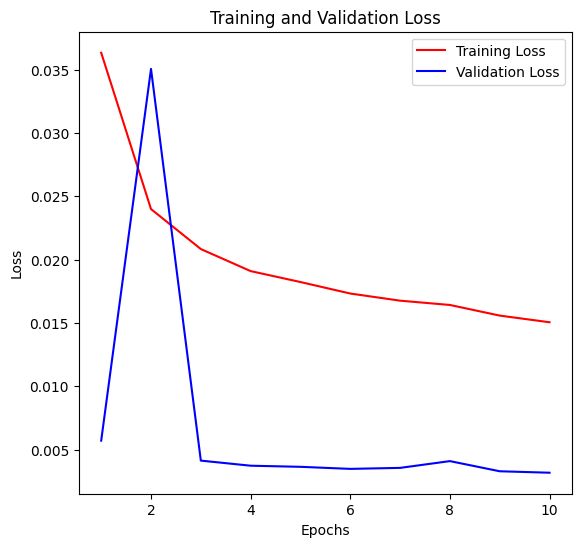

In [18]:
plot_loss_accuracy(training_loss, val_losses)

**ResNet152**

In [19]:
class ResNet152Autoencoder(nn.Module):
    def __init__(self):
        super(ResNet152Autoencoder, self).__init__()


        resnet = models.resnet152(pretrained=True)


        self.encoder = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4
        )


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [20]:
model_152 = ResNet152Autoencoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_152.parameters(), lr=1e-3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 178MB/s]


In [21]:
training_loss, val_losses = train_model(model_152, criterion, optimizer, num_epochs=10)

  0%|          | 1/391 [00:00<03:20,  1.94it/s]

Batch0 Loss: 0.07067795097827911


  1%|          | 2/391 [00:00<02:58,  2.18it/s]

Batch1 Loss: 0.06578844040632248


  1%|          | 3/391 [00:01<02:50,  2.27it/s]

Batch2 Loss: 0.06529637426137924


  1%|          | 4/391 [00:01<02:47,  2.31it/s]

Batch3 Loss: 0.0644676685333252


  1%|▏         | 5/391 [00:02<02:45,  2.33it/s]

Batch4 Loss: 0.0627305656671524


  2%|▏         | 6/391 [00:02<02:44,  2.35it/s]

Batch5 Loss: 0.06130968779325485


  2%|▏         | 7/391 [00:03<02:42,  2.36it/s]

Batch6 Loss: 0.062011461704969406


  2%|▏         | 8/391 [00:03<02:42,  2.36it/s]

Batch7 Loss: 0.0626465231180191


  2%|▏         | 9/391 [00:03<02:41,  2.36it/s]

Batch8 Loss: 0.06295146048069


  3%|▎         | 10/391 [00:04<02:40,  2.37it/s]

Batch9 Loss: 0.06041274592280388


  3%|▎         | 11/391 [00:04<02:40,  2.37it/s]

Batch10 Loss: 0.05908355116844177


  3%|▎         | 12/391 [00:05<02:40,  2.37it/s]

Batch11 Loss: 0.06509610265493393


  3%|▎         | 13/391 [00:05<02:39,  2.37it/s]

Batch12 Loss: 0.06196560710668564


  4%|▎         | 14/391 [00:06<02:40,  2.35it/s]

Batch13 Loss: 0.06009471043944359


  4%|▍         | 15/391 [00:06<02:40,  2.35it/s]

Batch14 Loss: 0.0555543452501297


  4%|▍         | 16/391 [00:06<02:39,  2.35it/s]

Batch15 Loss: 0.056207429617643356


  4%|▍         | 17/391 [00:07<02:38,  2.36it/s]

Batch16 Loss: 0.05858948826789856


  5%|▍         | 18/391 [00:07<02:37,  2.36it/s]

Batch17 Loss: 0.05451234430074692


  5%|▍         | 19/391 [00:08<02:39,  2.33it/s]

Batch18 Loss: 0.059093862771987915


  5%|▌         | 20/391 [00:08<02:40,  2.32it/s]

Batch19 Loss: 0.05005445331335068


  5%|▌         | 21/391 [00:09<02:40,  2.31it/s]

Batch20 Loss: 0.05090877413749695


  6%|▌         | 22/391 [00:09<02:42,  2.27it/s]

Batch21 Loss: 0.05289783701300621


  6%|▌         | 23/391 [00:09<02:42,  2.27it/s]

Batch22 Loss: 0.050422023981809616


  6%|▌         | 24/391 [00:10<02:40,  2.29it/s]

Batch23 Loss: 0.051955025643110275


  6%|▋         | 25/391 [00:10<02:38,  2.31it/s]

Batch24 Loss: 0.05057751387357712


  7%|▋         | 26/391 [00:11<02:38,  2.31it/s]

Batch25 Loss: 0.04938816651701927


  7%|▋         | 27/391 [00:11<02:36,  2.32it/s]

Batch26 Loss: 0.0480000302195549


  7%|▋         | 28/391 [00:12<02:35,  2.33it/s]

Batch27 Loss: 0.05038698762655258


  7%|▋         | 29/391 [00:12<02:34,  2.34it/s]

Batch28 Loss: 0.0452800914645195


  8%|▊         | 30/391 [00:12<02:34,  2.34it/s]

Batch29 Loss: 0.05015416070818901


  8%|▊         | 31/391 [00:13<02:33,  2.34it/s]

Batch30 Loss: 0.05022817105054855


  8%|▊         | 32/391 [00:13<02:32,  2.35it/s]

Batch31 Loss: 0.048794977366924286


  8%|▊         | 33/391 [00:14<02:32,  2.35it/s]

Batch32 Loss: 0.04920760914683342


  9%|▊         | 34/391 [00:14<02:32,  2.35it/s]

Batch33 Loss: 0.04599300026893616


  9%|▉         | 35/391 [00:15<02:31,  2.35it/s]

Batch34 Loss: 0.04824141785502434


  9%|▉         | 36/391 [00:15<02:31,  2.34it/s]

Batch35 Loss: 0.05014548450708389


  9%|▉         | 37/391 [00:15<02:30,  2.35it/s]

Batch36 Loss: 0.046217769384384155


 10%|▉         | 38/391 [00:16<02:31,  2.33it/s]

Batch37 Loss: 0.04742376506328583


 10%|▉         | 39/391 [00:16<02:30,  2.34it/s]

Batch38 Loss: 0.0474373959004879


 10%|█         | 40/391 [00:17<02:30,  2.33it/s]

Batch39 Loss: 0.04604901000857353


 10%|█         | 41/391 [00:17<02:29,  2.34it/s]

Batch40 Loss: 0.04757383465766907


 11%|█         | 42/391 [00:18<02:29,  2.34it/s]

Batch41 Loss: 0.04886087030172348


 11%|█         | 43/391 [00:18<02:29,  2.32it/s]

Batch42 Loss: 0.04692418873310089


 11%|█▏        | 44/391 [00:18<02:29,  2.32it/s]

Batch43 Loss: 0.04480830952525139


 12%|█▏        | 45/391 [00:19<02:28,  2.33it/s]

Batch44 Loss: 0.04776496812701225


 12%|█▏        | 46/391 [00:19<02:28,  2.33it/s]

Batch45 Loss: 0.047006022185087204


 12%|█▏        | 47/391 [00:20<02:29,  2.30it/s]

Batch46 Loss: 0.04881991073489189


 12%|█▏        | 48/391 [00:20<02:29,  2.29it/s]

Batch47 Loss: 0.04660502076148987


 13%|█▎        | 49/391 [00:21<02:29,  2.29it/s]

Batch48 Loss: 0.043669577687978745


 13%|█▎        | 50/391 [00:21<02:29,  2.28it/s]

Batch49 Loss: 0.043889790773391724


 13%|█▎        | 51/391 [00:21<02:30,  2.26it/s]

Batch50 Loss: 0.040284983813762665


 13%|█▎        | 52/391 [00:22<02:28,  2.28it/s]

Batch51 Loss: 0.043583497405052185


 14%|█▎        | 53/391 [00:22<02:27,  2.30it/s]

Batch52 Loss: 0.04285495728254318


 14%|█▍        | 54/391 [00:23<02:25,  2.31it/s]

Batch53 Loss: 0.04265933483839035


 14%|█▍        | 55/391 [00:23<02:24,  2.32it/s]

Batch54 Loss: 0.043368350714445114


 14%|█▍        | 56/391 [00:24<02:23,  2.33it/s]

Batch55 Loss: 0.041699379682540894


 15%|█▍        | 57/391 [00:24<02:23,  2.34it/s]

Batch56 Loss: 0.04392097517848015


 15%|█▍        | 58/391 [00:24<02:22,  2.34it/s]

Batch57 Loss: 0.03950517624616623


 15%|█▌        | 59/391 [00:25<02:21,  2.34it/s]

Batch58 Loss: 0.04152383655309677


 15%|█▌        | 60/391 [00:25<02:22,  2.33it/s]

Batch59 Loss: 0.04154084622859955


 16%|█▌        | 61/391 [00:26<02:21,  2.33it/s]

Batch60 Loss: 0.03978659212589264


 16%|█▌        | 62/391 [00:26<02:21,  2.33it/s]

Batch61 Loss: 0.039123594760894775


 16%|█▌        | 63/391 [00:27<02:20,  2.34it/s]

Batch62 Loss: 0.04175980016589165


 16%|█▋        | 64/391 [00:27<02:19,  2.34it/s]

Batch63 Loss: 0.038093969225883484


 17%|█▋        | 65/391 [00:27<02:19,  2.34it/s]

Batch64 Loss: 0.03938749060034752


 17%|█▋        | 66/391 [00:28<02:18,  2.35it/s]

Batch65 Loss: 0.04034542292356491


 17%|█▋        | 67/391 [00:28<02:17,  2.35it/s]

Batch66 Loss: 0.03737068921327591


 17%|█▋        | 68/391 [00:29<02:17,  2.34it/s]

Batch67 Loss: 0.03546284884214401


 18%|█▊        | 69/391 [00:29<02:17,  2.34it/s]

Batch68 Loss: 0.042027294635772705


 18%|█▊        | 70/391 [00:30<02:17,  2.33it/s]

Batch69 Loss: 0.03855173662304878


 18%|█▊        | 71/391 [00:30<02:17,  2.33it/s]

Batch70 Loss: 0.037525475025177


 18%|█▊        | 72/391 [00:30<02:16,  2.33it/s]

Batch71 Loss: 0.037532493472099304


 19%|█▊        | 73/391 [00:31<02:16,  2.33it/s]

Batch72 Loss: 0.04152324050664902


 19%|█▉        | 74/391 [00:31<02:16,  2.33it/s]

Batch73 Loss: 0.039564020931720734


 19%|█▉        | 75/391 [00:32<02:15,  2.33it/s]

Batch74 Loss: 0.04023668169975281


 19%|█▉        | 76/391 [00:32<02:16,  2.31it/s]

Batch75 Loss: 0.03507128357887268


 20%|█▉        | 77/391 [00:33<02:16,  2.30it/s]

Batch76 Loss: 0.03781025856733322


 20%|█▉        | 78/391 [00:33<02:17,  2.28it/s]

Batch77 Loss: 0.03882698342204094


 20%|██        | 79/391 [00:33<02:17,  2.28it/s]

Batch78 Loss: 0.03945736587047577


 20%|██        | 80/391 [00:34<02:18,  2.24it/s]

Batch79 Loss: 0.03921080753207207


 21%|██        | 81/391 [00:34<02:16,  2.26it/s]

Batch80 Loss: 0.03761504590511322


 21%|██        | 82/391 [00:35<02:15,  2.29it/s]

Batch81 Loss: 0.034946419298648834


 21%|██        | 83/391 [00:35<02:13,  2.30it/s]

Batch82 Loss: 0.03901262581348419


 21%|██▏       | 84/391 [00:36<02:12,  2.31it/s]

Batch83 Loss: 0.04173167049884796


 22%|██▏       | 85/391 [00:36<02:11,  2.32it/s]

Batch84 Loss: 0.03701724112033844


 22%|██▏       | 86/391 [00:37<02:10,  2.33it/s]

Batch85 Loss: 0.03866499289870262


 22%|██▏       | 87/391 [00:37<02:11,  2.32it/s]

Batch86 Loss: 0.036208104342222214


 23%|██▎       | 88/391 [00:37<02:10,  2.32it/s]

Batch87 Loss: 0.03838638588786125


 23%|██▎       | 89/391 [00:38<02:09,  2.33it/s]

Batch88 Loss: 0.03897114098072052


 23%|██▎       | 90/391 [00:38<02:08,  2.34it/s]

Batch89 Loss: 0.03464175760746002


 23%|██▎       | 91/391 [00:39<02:08,  2.34it/s]

Batch90 Loss: 0.03610912710428238


 24%|██▎       | 92/391 [00:39<02:07,  2.34it/s]

Batch91 Loss: 0.0362384207546711


 24%|██▍       | 93/391 [00:40<02:07,  2.34it/s]

Batch92 Loss: 0.03781505301594734


 24%|██▍       | 94/391 [00:40<02:07,  2.33it/s]

Batch93 Loss: 0.038912877440452576


 24%|██▍       | 95/391 [00:40<02:06,  2.33it/s]

Batch94 Loss: 0.03631927818059921


 25%|██▍       | 96/391 [00:41<02:06,  2.33it/s]

Batch95 Loss: 0.03809777647256851


 25%|██▍       | 97/391 [00:41<02:05,  2.34it/s]

Batch96 Loss: 0.03530946001410484


 25%|██▌       | 98/391 [00:42<02:04,  2.34it/s]

Batch97 Loss: 0.03760131448507309


 25%|██▌       | 99/391 [00:42<02:04,  2.35it/s]

Batch98 Loss: 0.04006306082010269


 26%|██▌       | 100/391 [00:43<02:04,  2.34it/s]

Batch99 Loss: 0.03765649348497391


 26%|██▌       | 101/391 [00:43<02:04,  2.33it/s]

Batch100 Loss: 0.036491625010967255


 26%|██▌       | 102/391 [00:43<02:03,  2.33it/s]

Batch101 Loss: 0.03614545986056328


 26%|██▋       | 103/391 [00:44<02:03,  2.33it/s]

Batch102 Loss: 0.03898697346448898


 27%|██▋       | 104/391 [00:44<02:04,  2.31it/s]

Batch103 Loss: 0.03593670576810837


 27%|██▋       | 105/391 [00:45<02:04,  2.30it/s]

Batch104 Loss: 0.0371236689388752


 27%|██▋       | 106/391 [00:45<02:04,  2.29it/s]

Batch105 Loss: 0.03539404273033142


 27%|██▋       | 107/391 [00:46<02:04,  2.28it/s]

Batch106 Loss: 0.038392048329114914


 28%|██▊       | 108/391 [00:46<02:04,  2.27it/s]

Batch107 Loss: 0.03454766422510147


 28%|██▊       | 109/391 [00:46<02:02,  2.29it/s]

Batch108 Loss: 0.03569505736231804


 28%|██▊       | 110/391 [00:47<02:01,  2.32it/s]

Batch109 Loss: 0.03450934588909149


 28%|██▊       | 111/391 [00:47<02:00,  2.33it/s]

Batch110 Loss: 0.036820635199546814


 29%|██▊       | 112/391 [00:48<01:59,  2.34it/s]

Batch111 Loss: 0.03572212904691696


 29%|██▉       | 113/391 [00:48<01:58,  2.34it/s]

Batch112 Loss: 0.03705119341611862


 29%|██▉       | 114/391 [00:49<01:58,  2.34it/s]

Batch113 Loss: 0.036501217633485794


 29%|██▉       | 115/391 [00:49<01:57,  2.35it/s]

Batch114 Loss: 0.035987257957458496


 30%|██▉       | 116/391 [00:49<01:57,  2.35it/s]

Batch115 Loss: 0.03696877509355545


 30%|██▉       | 117/391 [00:50<01:56,  2.35it/s]

Batch116 Loss: 0.03736908361315727


 30%|███       | 118/391 [00:50<01:56,  2.35it/s]

Batch117 Loss: 0.035826727747917175


 30%|███       | 119/391 [00:51<01:55,  2.35it/s]

Batch118 Loss: 0.037097327411174774


 31%|███       | 120/391 [00:51<01:55,  2.35it/s]

Batch119 Loss: 0.03492945060133934


 31%|███       | 121/391 [00:52<01:54,  2.35it/s]

Batch120 Loss: 0.03506540507078171


 31%|███       | 122/391 [00:52<01:54,  2.35it/s]

Batch121 Loss: 0.039458781480789185


 31%|███▏      | 123/391 [00:52<01:53,  2.35it/s]

Batch122 Loss: 0.03386300802230835


 32%|███▏      | 124/391 [00:53<01:53,  2.36it/s]

Batch123 Loss: 0.0331110954284668


 32%|███▏      | 125/391 [00:53<01:52,  2.35it/s]

Batch124 Loss: 0.036712437868118286


 32%|███▏      | 126/391 [00:54<01:52,  2.36it/s]

Batch125 Loss: 0.03394310176372528


 32%|███▏      | 127/391 [00:54<01:52,  2.35it/s]

Batch126 Loss: 0.03586450219154358


 33%|███▎      | 128/391 [00:55<01:51,  2.35it/s]

Batch127 Loss: 0.03364379703998566


 33%|███▎      | 129/391 [00:55<01:52,  2.34it/s]

Batch128 Loss: 0.03409222885966301


 33%|███▎      | 130/391 [00:55<01:51,  2.35it/s]

Batch129 Loss: 0.03669673204421997


 34%|███▎      | 131/391 [00:56<01:50,  2.35it/s]

Batch130 Loss: 0.035248249769210815


 34%|███▍      | 132/391 [00:56<01:52,  2.31it/s]

Batch131 Loss: 0.03468615561723709


 34%|███▍      | 133/391 [00:57<01:51,  2.30it/s]

Batch132 Loss: 0.03294803202152252


 34%|███▍      | 134/391 [00:57<01:51,  2.30it/s]

Batch133 Loss: 0.035575322806835175


 35%|███▍      | 135/391 [00:58<01:51,  2.30it/s]

Batch134 Loss: 0.034210097044706345


 35%|███▍      | 136/391 [00:58<01:51,  2.28it/s]

Batch135 Loss: 0.03604423254728317


 35%|███▌      | 137/391 [00:58<01:50,  2.29it/s]

Batch136 Loss: 0.03313256800174713


 35%|███▌      | 138/391 [00:59<01:49,  2.30it/s]

Batch137 Loss: 0.03169107437133789


 36%|███▌      | 139/391 [00:59<01:48,  2.32it/s]

Batch138 Loss: 0.031635574996471405


 36%|███▌      | 140/391 [01:00<01:47,  2.33it/s]

Batch139 Loss: 0.03336888179183006


 36%|███▌      | 141/391 [01:00<01:47,  2.33it/s]

Batch140 Loss: 0.03334122151136398


 36%|███▋      | 142/391 [01:01<01:46,  2.34it/s]

Batch141 Loss: 0.03499213233590126


 37%|███▋      | 143/391 [01:01<01:45,  2.35it/s]

Batch142 Loss: 0.03242814540863037


 37%|███▋      | 144/391 [01:01<01:45,  2.34it/s]

Batch143 Loss: 0.031754445284605026


 37%|███▋      | 145/391 [01:02<01:44,  2.35it/s]

Batch144 Loss: 0.03479019179940224


 37%|███▋      | 146/391 [01:02<01:44,  2.35it/s]

Batch145 Loss: 0.03186541050672531


 38%|███▊      | 147/391 [01:03<01:43,  2.35it/s]

Batch146 Loss: 0.03162912279367447


 38%|███▊      | 148/391 [01:03<01:43,  2.35it/s]

Batch147 Loss: 0.03180398792028427


 38%|███▊      | 149/391 [01:04<01:42,  2.36it/s]

Batch148 Loss: 0.03538614884018898


 38%|███▊      | 150/391 [01:04<01:42,  2.35it/s]

Batch149 Loss: 0.03168905898928642


 39%|███▊      | 151/391 [01:04<01:42,  2.35it/s]

Batch150 Loss: 0.03223321586847305


 39%|███▉      | 152/391 [01:05<01:41,  2.35it/s]

Batch151 Loss: 0.03176528215408325


 39%|███▉      | 153/391 [01:05<01:41,  2.34it/s]

Batch152 Loss: 0.03211912140250206


 39%|███▉      | 154/391 [01:06<01:40,  2.35it/s]

Batch153 Loss: 0.02825137972831726


 40%|███▉      | 155/391 [01:06<01:40,  2.35it/s]

Batch154 Loss: 0.030104637145996094


 40%|███▉      | 156/391 [01:07<01:39,  2.35it/s]

Batch155 Loss: 0.03436868637800217


 40%|████      | 157/391 [01:07<01:39,  2.35it/s]

Batch156 Loss: 0.03175366669893265


 40%|████      | 158/391 [01:07<01:38,  2.36it/s]

Batch157 Loss: 0.032466866075992584


 41%|████      | 159/391 [01:08<01:38,  2.36it/s]

Batch158 Loss: 0.031168129295110703


 41%|████      | 160/391 [01:08<01:38,  2.36it/s]

Batch159 Loss: 0.032819345593452454


 41%|████      | 161/391 [01:09<01:39,  2.32it/s]

Batch160 Loss: 0.031953874975442886


 41%|████▏     | 162/391 [01:09<01:39,  2.29it/s]

Batch161 Loss: 0.0316341370344162


 42%|████▏     | 163/391 [01:10<01:39,  2.29it/s]

Batch162 Loss: 0.03258588910102844


 42%|████▏     | 164/391 [01:10<01:39,  2.29it/s]

Batch163 Loss: 0.03295677900314331


 42%|████▏     | 165/391 [01:10<01:39,  2.27it/s]

Batch164 Loss: 0.032900262624025345


 42%|████▏     | 166/391 [01:11<01:38,  2.29it/s]

Batch165 Loss: 0.03168487548828125


 43%|████▎     | 167/391 [01:11<01:36,  2.32it/s]

Batch166 Loss: 0.03088010475039482


 43%|████▎     | 168/391 [01:12<01:35,  2.34it/s]

Batch167 Loss: 0.031035881489515305


 43%|████▎     | 169/391 [01:12<01:34,  2.34it/s]

Batch168 Loss: 0.03060232102870941


 43%|████▎     | 170/391 [01:13<01:34,  2.34it/s]

Batch169 Loss: 0.03542766720056534


 44%|████▎     | 171/391 [01:13<01:33,  2.35it/s]

Batch170 Loss: 0.0322965644299984


 44%|████▍     | 172/391 [01:13<01:33,  2.35it/s]

Batch171 Loss: 0.03211710602045059


 44%|████▍     | 173/391 [01:14<01:32,  2.35it/s]

Batch172 Loss: 0.031438153237104416


 45%|████▍     | 174/391 [01:14<01:32,  2.35it/s]

Batch173 Loss: 0.030035031959414482


 45%|████▍     | 175/391 [01:15<01:31,  2.35it/s]

Batch174 Loss: 0.03270619735121727


 45%|████▌     | 176/391 [01:15<01:31,  2.35it/s]

Batch175 Loss: 0.03267940878868103


 45%|████▌     | 177/391 [01:16<01:30,  2.35it/s]

Batch176 Loss: 0.03044808655977249


 46%|████▌     | 178/391 [01:16<01:30,  2.35it/s]

Batch177 Loss: 0.03265754133462906


 46%|████▌     | 179/391 [01:16<01:30,  2.35it/s]

Batch178 Loss: 0.035462748259305954


 46%|████▌     | 180/391 [01:17<01:29,  2.36it/s]

Batch179 Loss: 0.04031584784388542


 46%|████▋     | 181/391 [01:17<01:29,  2.35it/s]

Batch180 Loss: 0.039077047258615494


 47%|████▋     | 182/391 [01:18<01:28,  2.35it/s]

Batch181 Loss: 0.036643415689468384


 47%|████▋     | 183/391 [01:18<01:28,  2.35it/s]

Batch182 Loss: 0.03587602823972702


 47%|████▋     | 184/391 [01:19<01:31,  2.26it/s]

Batch183 Loss: 0.03834107518196106


 47%|████▋     | 185/391 [01:19<01:30,  2.29it/s]

Batch184 Loss: 0.037023093551397324


 48%|████▊     | 186/391 [01:19<01:28,  2.32it/s]

Batch185 Loss: 0.040306344628334045


 48%|████▊     | 187/391 [01:20<01:27,  2.33it/s]

Batch186 Loss: 0.03828901797533035


 48%|████▊     | 188/391 [01:20<01:26,  2.34it/s]

Batch187 Loss: 0.03973591700196266


 48%|████▊     | 189/391 [01:21<01:27,  2.32it/s]

Batch188 Loss: 0.03619229048490524


 49%|████▊     | 190/391 [01:21<01:26,  2.32it/s]

Batch189 Loss: 0.035897739231586456


 49%|████▉     | 191/391 [01:22<01:26,  2.32it/s]

Batch190 Loss: 0.03746432811021805


 49%|████▉     | 192/391 [01:22<01:26,  2.30it/s]

Batch191 Loss: 0.03714096173644066


 49%|████▉     | 193/391 [01:22<01:26,  2.28it/s]

Batch192 Loss: 0.03526673838496208


 50%|████▉     | 194/391 [01:23<01:27,  2.26it/s]

Batch193 Loss: 0.03575485199689865


 50%|████▉     | 195/391 [01:23<01:25,  2.29it/s]

Batch194 Loss: 0.0366409532725811


 50%|█████     | 196/391 [01:24<01:24,  2.31it/s]

Batch195 Loss: 0.0359039269387722


 50%|█████     | 197/391 [01:24<01:23,  2.33it/s]

Batch196 Loss: 0.0364035964012146


 51%|█████     | 198/391 [01:25<01:22,  2.34it/s]

Batch197 Loss: 0.03128432855010033


 51%|█████     | 199/391 [01:25<01:21,  2.35it/s]

Batch198 Loss: 0.033195044845342636


 51%|█████     | 200/391 [01:25<01:21,  2.35it/s]

Batch199 Loss: 0.03223557025194168


 51%|█████▏    | 201/391 [01:26<01:21,  2.33it/s]

Batch200 Loss: 0.03524766117334366


 52%|█████▏    | 202/391 [01:26<01:20,  2.34it/s]

Batch201 Loss: 0.03446774184703827


 52%|█████▏    | 203/391 [01:27<01:20,  2.34it/s]

Batch202 Loss: 0.03450942784547806


 52%|█████▏    | 204/391 [01:27<01:19,  2.35it/s]

Batch203 Loss: 0.03368808329105377


 52%|█████▏    | 205/391 [01:28<01:19,  2.35it/s]

Batch204 Loss: 0.03584659844636917


 53%|█████▎    | 206/391 [01:28<01:18,  2.35it/s]

Batch205 Loss: 0.03460358828306198


 53%|█████▎    | 207/391 [01:28<01:18,  2.35it/s]

Batch206 Loss: 0.03360302001237869


 53%|█████▎    | 208/391 [01:29<01:18,  2.35it/s]

Batch207 Loss: 0.0340181365609169


 53%|█████▎    | 209/391 [01:29<01:17,  2.35it/s]

Batch208 Loss: 0.0316413938999176


 54%|█████▎    | 210/391 [01:30<01:16,  2.35it/s]

Batch209 Loss: 0.034080006182193756


 54%|█████▍    | 211/391 [01:30<01:16,  2.35it/s]

Batch210 Loss: 0.034432463347911835


 54%|█████▍    | 212/391 [01:31<01:16,  2.35it/s]

Batch211 Loss: 0.034241557121276855


 54%|█████▍    | 213/391 [01:31<01:15,  2.35it/s]

Batch212 Loss: 0.031237617135047913


 55%|█████▍    | 214/391 [01:31<01:15,  2.35it/s]

Batch213 Loss: 0.03369930759072304


 55%|█████▍    | 215/391 [01:32<01:14,  2.35it/s]

Batch214 Loss: 0.0342220664024353


 55%|█████▌    | 216/391 [01:32<01:14,  2.36it/s]

Batch215 Loss: 0.03440599516034126


 55%|█████▌    | 217/391 [01:33<01:13,  2.35it/s]

Batch216 Loss: 0.03372889757156372


 56%|█████▌    | 218/391 [01:33<01:14,  2.33it/s]

Batch217 Loss: 0.03227662667632103


 56%|█████▌    | 219/391 [01:34<01:13,  2.32it/s]

Batch218 Loss: 0.03181220591068268


 56%|█████▋    | 220/391 [01:34<01:14,  2.30it/s]

Batch219 Loss: 0.03398379683494568


 57%|█████▋    | 221/391 [01:34<01:13,  2.30it/s]

Batch220 Loss: 0.032658651471138


 57%|█████▋    | 222/391 [01:35<01:13,  2.29it/s]

Batch221 Loss: 0.03294849023222923


 57%|█████▋    | 223/391 [01:35<01:12,  2.31it/s]

Batch222 Loss: 0.030769120901823044


 57%|█████▋    | 224/391 [01:36<01:11,  2.33it/s]

Batch223 Loss: 0.03212197870016098


 58%|█████▊    | 225/391 [01:36<01:10,  2.34it/s]

Batch224 Loss: 0.031034840270876884


 58%|█████▊    | 226/391 [01:37<01:10,  2.34it/s]

Batch225 Loss: 0.03170332312583923


 58%|█████▊    | 227/391 [01:37<01:09,  2.35it/s]

Batch226 Loss: 0.03149646520614624


 58%|█████▊    | 228/391 [01:37<01:09,  2.35it/s]

Batch227 Loss: 0.03163034841418266


 59%|█████▊    | 229/391 [01:38<01:08,  2.35it/s]

Batch228 Loss: 0.030768856406211853


 59%|█████▉    | 230/391 [01:38<01:08,  2.35it/s]

Batch229 Loss: 0.031093832105398178


 59%|█████▉    | 231/391 [01:39<01:08,  2.35it/s]

Batch230 Loss: 0.029138263314962387


 59%|█████▉    | 232/391 [01:39<01:07,  2.35it/s]

Batch231 Loss: 0.03120073676109314


 60%|█████▉    | 233/391 [01:40<01:07,  2.35it/s]

Batch232 Loss: 0.02923722192645073


 60%|█████▉    | 234/391 [01:40<01:06,  2.35it/s]

Batch233 Loss: 0.03009224496781826


 60%|██████    | 235/391 [01:40<01:06,  2.35it/s]

Batch234 Loss: 0.028713002800941467


 60%|██████    | 236/391 [01:41<01:05,  2.35it/s]

Batch235 Loss: 0.032407622784376144


 61%|██████    | 237/391 [01:41<01:05,  2.35it/s]

Batch236 Loss: 0.032734137028455734


 61%|██████    | 238/391 [01:42<01:05,  2.35it/s]

Batch237 Loss: 0.02985478937625885


 61%|██████    | 239/391 [01:42<01:04,  2.35it/s]

Batch238 Loss: 0.032788895070552826


 61%|██████▏   | 240/391 [01:42<01:04,  2.35it/s]

Batch239 Loss: 0.030662965029478073


 62%|██████▏   | 241/391 [01:43<01:03,  2.35it/s]

Batch240 Loss: 0.030433915555477142


 62%|██████▏   | 242/391 [01:43<01:04,  2.32it/s]

Batch241 Loss: 0.030770188197493553


 62%|██████▏   | 243/391 [01:44<01:03,  2.33it/s]

Batch242 Loss: 0.03075319156050682


 62%|██████▏   | 244/391 [01:44<01:02,  2.34it/s]

Batch243 Loss: 0.030362442135810852


 63%|██████▎   | 245/391 [01:45<01:02,  2.34it/s]

Batch244 Loss: 0.03158115968108177


 63%|██████▎   | 246/391 [01:45<01:01,  2.35it/s]

Batch245 Loss: 0.031481482088565826


 63%|██████▎   | 247/391 [01:46<01:01,  2.33it/s]

Batch246 Loss: 0.030986130237579346


 63%|██████▎   | 248/391 [01:46<01:02,  2.30it/s]

Batch247 Loss: 0.03004853054881096


 64%|██████▎   | 249/391 [01:46<01:01,  2.30it/s]

Batch248 Loss: 0.029793059453368187


 64%|██████▍   | 250/391 [01:47<01:01,  2.28it/s]

Batch249 Loss: 0.033438004553318024


 64%|██████▍   | 251/391 [01:47<01:01,  2.28it/s]

Batch250 Loss: 0.030844029039144516


 64%|██████▍   | 252/391 [01:48<01:00,  2.30it/s]

Batch251 Loss: 0.02998870611190796


 65%|██████▍   | 253/391 [01:48<00:59,  2.32it/s]

Batch252 Loss: 0.028169676661491394


 65%|██████▍   | 254/391 [01:49<00:58,  2.33it/s]

Batch253 Loss: 0.029811203479766846


 65%|██████▌   | 255/391 [01:49<00:58,  2.34it/s]

Batch254 Loss: 0.030219130218029022


 65%|██████▌   | 256/391 [01:49<00:57,  2.34it/s]

Batch255 Loss: 0.03142634779214859


 66%|██████▌   | 257/391 [01:50<00:57,  2.34it/s]

Batch256 Loss: 0.0325608029961586


 66%|██████▌   | 258/391 [01:50<00:56,  2.35it/s]

Batch257 Loss: 0.029194300994277


 66%|██████▌   | 259/391 [01:51<00:56,  2.35it/s]

Batch258 Loss: 0.029854997992515564


 66%|██████▋   | 260/391 [01:51<00:55,  2.35it/s]

Batch259 Loss: 0.035170070827007294


 67%|██████▋   | 261/391 [01:52<00:55,  2.35it/s]

Batch260 Loss: 0.030312031507492065


 67%|██████▋   | 262/391 [01:52<00:55,  2.34it/s]

Batch261 Loss: 0.029312273487448692


 67%|██████▋   | 263/391 [01:52<00:54,  2.35it/s]

Batch262 Loss: 0.029886355623602867


 68%|██████▊   | 264/391 [01:53<00:53,  2.36it/s]

Batch263 Loss: 0.029799770563840866


 68%|██████▊   | 265/391 [01:53<00:53,  2.35it/s]

Batch264 Loss: 0.030713163316249847


 68%|██████▊   | 266/391 [01:54<00:53,  2.35it/s]

Batch265 Loss: 0.030316827818751335


 68%|██████▊   | 267/391 [01:54<00:52,  2.35it/s]

Batch266 Loss: 0.030157847329974174


 69%|██████▊   | 268/391 [01:54<00:52,  2.36it/s]

Batch267 Loss: 0.033152222633361816


 69%|██████▉   | 269/391 [01:55<00:51,  2.35it/s]

Batch268 Loss: 0.030932938680052757


 69%|██████▉   | 270/391 [01:55<00:51,  2.35it/s]

Batch269 Loss: 0.030979296192526817


 69%|██████▉   | 271/391 [01:56<00:50,  2.35it/s]

Batch270 Loss: 0.032279763370752335


 70%|██████▉   | 272/391 [01:56<00:50,  2.35it/s]

Batch271 Loss: 0.030365481972694397


 70%|██████▉   | 273/391 [01:57<00:50,  2.35it/s]

Batch272 Loss: 0.030388470739126205


 70%|███████   | 274/391 [01:57<00:49,  2.35it/s]

Batch273 Loss: 0.03159673511981964


 70%|███████   | 275/391 [01:57<00:50,  2.32it/s]

Batch274 Loss: 0.031188245862722397


 71%|███████   | 276/391 [01:58<00:50,  2.30it/s]

Batch275 Loss: 0.030978066846728325


 71%|███████   | 277/391 [01:58<00:49,  2.29it/s]

Batch276 Loss: 0.032365940511226654


 71%|███████   | 278/391 [01:59<00:49,  2.27it/s]

Batch277 Loss: 0.03089652583003044


 71%|███████▏  | 279/391 [01:59<00:49,  2.26it/s]

Batch278 Loss: 0.030657460913062096


 72%|███████▏  | 280/391 [02:00<00:48,  2.29it/s]

Batch279 Loss: 0.030611952766776085


 72%|███████▏  | 281/391 [02:00<00:47,  2.31it/s]

Batch280 Loss: 0.03268809616565704


 72%|███████▏  | 282/391 [02:01<00:46,  2.32it/s]

Batch281 Loss: 0.03390262648463249


 72%|███████▏  | 283/391 [02:01<00:46,  2.33it/s]

Batch282 Loss: 0.031990282237529755


 73%|███████▎  | 284/391 [02:01<00:45,  2.34it/s]

Batch283 Loss: 0.030501848086714745


 73%|███████▎  | 285/391 [02:02<00:45,  2.34it/s]

Batch284 Loss: 0.032445717602968216


 73%|███████▎  | 286/391 [02:02<00:44,  2.35it/s]

Batch285 Loss: 0.03248605877161026


 73%|███████▎  | 287/391 [02:03<00:44,  2.35it/s]

Batch286 Loss: 0.033360764384269714


 74%|███████▎  | 288/391 [02:03<00:43,  2.35it/s]

Batch287 Loss: 0.03042011521756649


 74%|███████▍  | 289/391 [02:04<00:43,  2.35it/s]

Batch288 Loss: 0.030921965837478638


 74%|███████▍  | 290/391 [02:04<00:43,  2.33it/s]

Batch289 Loss: 0.029982006177306175


 74%|███████▍  | 291/391 [02:04<00:42,  2.33it/s]

Batch290 Loss: 0.029238468036055565


 75%|███████▍  | 292/391 [02:05<00:42,  2.33it/s]

Batch291 Loss: 0.033088862895965576


 75%|███████▍  | 293/391 [02:05<00:41,  2.34it/s]

Batch292 Loss: 0.030067317187786102


 75%|███████▌  | 294/391 [02:06<00:41,  2.35it/s]

Batch293 Loss: 0.029847294092178345


 75%|███████▌  | 295/391 [02:06<00:40,  2.35it/s]

Batch294 Loss: 0.031128380447626114


 76%|███████▌  | 296/391 [02:07<00:40,  2.35it/s]

Batch295 Loss: 0.030447637662291527


 76%|███████▌  | 297/391 [02:07<00:40,  2.34it/s]

Batch296 Loss: 0.031047552824020386


 76%|███████▌  | 298/391 [02:07<00:39,  2.34it/s]

Batch297 Loss: 0.031700506806373596


 76%|███████▋  | 299/391 [02:08<00:39,  2.35it/s]

Batch298 Loss: 0.02934490703046322


 77%|███████▋  | 300/391 [02:08<00:38,  2.35it/s]

Batch299 Loss: 0.030358558520674706


 77%|███████▋  | 301/391 [02:09<00:38,  2.35it/s]

Batch300 Loss: 0.030194437131285667


 77%|███████▋  | 302/391 [02:09<00:38,  2.33it/s]

Batch301 Loss: 0.029618408530950546


 77%|███████▋  | 303/391 [02:10<00:37,  2.34it/s]

Batch302 Loss: 0.030377298593521118


 78%|███████▊  | 304/391 [02:10<00:37,  2.31it/s]

Batch303 Loss: 0.02943393401801586


 78%|███████▊  | 305/391 [02:10<00:37,  2.28it/s]

Batch304 Loss: 0.030665894970297813


 78%|███████▊  | 306/391 [02:11<00:37,  2.27it/s]

Batch305 Loss: 0.03106234222650528


 79%|███████▊  | 307/391 [02:11<00:37,  2.26it/s]

Batch306 Loss: 0.030857382342219353


 79%|███████▉  | 308/391 [02:12<00:36,  2.25it/s]

Batch307 Loss: 0.03059070184826851


 79%|███████▉  | 309/391 [02:12<00:35,  2.29it/s]

Batch308 Loss: 0.02891722321510315


 79%|███████▉  | 310/391 [02:13<00:35,  2.31it/s]

Batch309 Loss: 0.03098217211663723


 80%|███████▉  | 311/391 [02:13<00:34,  2.33it/s]

Batch310 Loss: 0.03139548748731613


 80%|███████▉  | 312/391 [02:13<00:33,  2.33it/s]

Batch311 Loss: 0.032676052302122116


 80%|████████  | 313/391 [02:14<00:33,  2.34it/s]

Batch312 Loss: 0.03243403136730194


 80%|████████  | 314/391 [02:14<00:32,  2.34it/s]

Batch313 Loss: 0.028268873691558838


 81%|████████  | 315/391 [02:15<00:32,  2.35it/s]

Batch314 Loss: 0.028589468449354172


 81%|████████  | 316/391 [02:15<00:31,  2.34it/s]

Batch315 Loss: 0.03034399449825287


 81%|████████  | 317/391 [02:16<00:31,  2.35it/s]

Batch316 Loss: 0.029623929411172867


 81%|████████▏ | 318/391 [02:16<00:31,  2.35it/s]

Batch317 Loss: 0.02959568426012993


 82%|████████▏ | 319/391 [02:16<00:30,  2.35it/s]

Batch318 Loss: 0.029629096388816833


 82%|████████▏ | 320/391 [02:17<00:30,  2.35it/s]

Batch319 Loss: 0.032661475241184235


 82%|████████▏ | 321/391 [02:17<00:29,  2.35it/s]

Batch320 Loss: 0.033514536917209625


 82%|████████▏ | 322/391 [02:18<00:29,  2.33it/s]

Batch321 Loss: 0.031165575608611107


 83%|████████▎ | 323/391 [02:18<00:29,  2.33it/s]

Batch322 Loss: 0.029172424226999283


 83%|████████▎ | 324/391 [02:19<00:28,  2.33it/s]

Batch323 Loss: 0.03187721222639084


 83%|████████▎ | 325/391 [02:19<00:28,  2.34it/s]

Batch324 Loss: 0.02954874560236931


 83%|████████▎ | 326/391 [02:19<00:27,  2.34it/s]

Batch325 Loss: 0.03048638626933098


 84%|████████▎ | 327/391 [02:20<00:27,  2.34it/s]

Batch326 Loss: 0.02893158420920372


 84%|████████▍ | 328/391 [02:20<00:26,  2.35it/s]

Batch327 Loss: 0.028303703293204308


 84%|████████▍ | 329/391 [02:21<00:26,  2.35it/s]

Batch328 Loss: 0.029438644647598267


 84%|████████▍ | 330/391 [02:21<00:25,  2.35it/s]

Batch329 Loss: 0.029932834208011627


 85%|████████▍ | 331/391 [02:22<00:25,  2.34it/s]

Batch330 Loss: 0.03043820522725582


 85%|████████▍ | 332/391 [02:22<00:25,  2.32it/s]

Batch331 Loss: 0.03101196140050888


 85%|████████▌ | 333/391 [02:22<00:25,  2.29it/s]

Batch332 Loss: 0.03109188750386238


 85%|████████▌ | 334/391 [02:23<00:24,  2.29it/s]

Batch333 Loss: 0.028317665681242943


 86%|████████▌ | 335/391 [02:23<00:24,  2.28it/s]

Batch334 Loss: 0.02932577393949032


 86%|████████▌ | 336/391 [02:24<00:24,  2.27it/s]

Batch335 Loss: 0.02762318029999733


 86%|████████▌ | 337/391 [02:24<00:23,  2.29it/s]

Batch336 Loss: 0.030864080414175987


 86%|████████▋ | 338/391 [02:25<00:22,  2.31it/s]

Batch337 Loss: 0.030841028317809105


 87%|████████▋ | 339/391 [02:25<00:22,  2.32it/s]

Batch338 Loss: 0.02687246911227703


 87%|████████▋ | 340/391 [02:25<00:21,  2.32it/s]

Batch339 Loss: 0.02872544340789318


 87%|████████▋ | 341/391 [02:26<00:21,  2.33it/s]

Batch340 Loss: 0.02845115214586258


 87%|████████▋ | 342/391 [02:26<00:20,  2.33it/s]

Batch341 Loss: 0.027469133958220482


 88%|████████▊ | 343/391 [02:27<00:20,  2.34it/s]

Batch342 Loss: 0.029899489134550095


 88%|████████▊ | 344/391 [02:27<00:20,  2.34it/s]

Batch343 Loss: 0.029818061739206314


 88%|████████▊ | 345/391 [02:28<00:19,  2.34it/s]

Batch344 Loss: 0.029308943077921867


 88%|████████▊ | 346/391 [02:28<00:19,  2.33it/s]

Batch345 Loss: 0.029976751655340195


 89%|████████▊ | 347/391 [02:28<00:18,  2.34it/s]

Batch346 Loss: 0.029147431254386902


 89%|████████▉ | 348/391 [02:29<00:18,  2.34it/s]

Batch347 Loss: 0.02944364957511425


 89%|████████▉ | 349/391 [02:29<00:17,  2.34it/s]

Batch348 Loss: 0.029797067865729332


 90%|████████▉ | 350/391 [02:30<00:17,  2.36it/s]

Batch349 Loss: 0.027093976736068726


 90%|████████▉ | 351/391 [02:30<00:16,  2.36it/s]

Batch350 Loss: 0.02751993015408516


 90%|█████████ | 352/391 [02:31<00:16,  2.36it/s]

Batch351 Loss: 0.025813577696681023


 90%|█████████ | 353/391 [02:31<00:16,  2.36it/s]

Batch352 Loss: 0.028105109930038452


 91%|█████████ | 354/391 [02:31<00:15,  2.36it/s]

Batch353 Loss: 0.02882237546145916


 91%|█████████ | 355/391 [02:32<00:15,  2.36it/s]

Batch354 Loss: 0.027253907173871994


 91%|█████████ | 356/391 [02:32<00:14,  2.36it/s]

Batch355 Loss: 0.028017457574605942


 91%|█████████▏| 357/391 [02:33<00:14,  2.34it/s]

Batch356 Loss: 0.028423693031072617


 92%|█████████▏| 358/391 [02:33<00:14,  2.35it/s]

Batch357 Loss: 0.027666766196489334


 92%|█████████▏| 359/391 [02:34<00:13,  2.35it/s]

Batch358 Loss: 0.02847016416490078


 92%|█████████▏| 360/391 [02:34<00:13,  2.35it/s]

Batch359 Loss: 0.0295388326048851


 92%|█████████▏| 361/391 [02:34<00:12,  2.32it/s]

Batch360 Loss: 0.027745960280299187


 93%|█████████▎| 362/391 [02:35<00:12,  2.31it/s]

Batch361 Loss: 0.029255535453557968


 93%|█████████▎| 363/391 [02:35<00:12,  2.29it/s]

Batch362 Loss: 0.02612350881099701


 93%|█████████▎| 364/391 [02:36<00:11,  2.27it/s]

Batch363 Loss: 0.02929443120956421


 93%|█████████▎| 365/391 [02:36<00:11,  2.26it/s]

Batch364 Loss: 0.02865571528673172


 94%|█████████▎| 366/391 [02:37<00:10,  2.29it/s]

Batch365 Loss: 0.029456770047545433


 94%|█████████▍| 367/391 [02:37<00:10,  2.31it/s]

Batch366 Loss: 0.028375668451189995


 94%|█████████▍| 368/391 [02:37<00:09,  2.31it/s]

Batch367 Loss: 0.028398927301168442


 94%|█████████▍| 369/391 [02:38<00:09,  2.33it/s]

Batch368 Loss: 0.02795559912919998


 95%|█████████▍| 370/391 [02:38<00:08,  2.34it/s]

Batch369 Loss: 0.030411824584007263


 95%|█████████▍| 371/391 [02:39<00:08,  2.34it/s]

Batch370 Loss: 0.027744337916374207


 95%|█████████▌| 372/391 [02:39<00:08,  2.35it/s]

Batch371 Loss: 0.02721143327653408


 95%|█████████▌| 373/391 [02:40<00:07,  2.35it/s]

Batch372 Loss: 0.02785223349928856


 96%|█████████▌| 374/391 [02:40<00:07,  2.35it/s]

Batch373 Loss: 0.02789253741502762


 96%|█████████▌| 375/391 [02:40<00:06,  2.35it/s]

Batch374 Loss: 0.026554301381111145


 96%|█████████▌| 376/391 [02:41<00:06,  2.35it/s]

Batch375 Loss: 0.029733091592788696


 96%|█████████▋| 377/391 [02:41<00:05,  2.35it/s]

Batch376 Loss: 0.028711719438433647


 97%|█████████▋| 378/391 [02:42<00:05,  2.35it/s]

Batch377 Loss: 0.028225481510162354


 97%|█████████▋| 379/391 [02:42<00:05,  2.36it/s]

Batch378 Loss: 0.028089791536331177


 97%|█████████▋| 380/391 [02:43<00:04,  2.35it/s]

Batch379 Loss: 0.02940348908305168


 97%|█████████▋| 381/391 [02:43<00:04,  2.34it/s]

Batch380 Loss: 0.02867158316075802


 98%|█████████▊| 382/391 [02:43<00:03,  2.35it/s]

Batch381 Loss: 0.028694747015833855


 98%|█████████▊| 383/391 [02:44<00:03,  2.35it/s]

Batch382 Loss: 0.02684713527560234


 98%|█████████▊| 384/391 [02:44<00:02,  2.36it/s]

Batch383 Loss: 0.027631273493170738


 98%|█████████▊| 385/391 [02:45<00:02,  2.35it/s]

Batch384 Loss: 0.028711434453725815


 99%|█████████▊| 386/391 [02:45<00:02,  2.36it/s]

Batch385 Loss: 0.02854331210255623


 99%|█████████▉| 387/391 [02:46<00:01,  2.36it/s]

Batch386 Loss: 0.028199777007102966


 99%|█████████▉| 388/391 [02:46<00:01,  2.36it/s]

Batch387 Loss: 0.027377326041460037


 99%|█████████▉| 389/391 [02:46<00:00,  2.32it/s]

Batch388 Loss: 0.027990583330392838


100%|█████████▉| 390/391 [02:47<00:00,  2.32it/s]

Batch389 Loss: 0.026399727910757065


100%|██████████| 391/391 [02:47<00:00,  2.33it/s]


Batch390 Loss: 0.027450956404209137
Epoch 1/10 - Train Loss: 0.0355


100%|██████████| 79/79 [00:22<00:00,  3.57it/s]


Epoch 1/10 - Val Loss: 0.0059


  0%|          | 1/391 [00:00<02:52,  2.26it/s]

Batch0 Loss: 0.027401983737945557


  1%|          | 2/391 [00:00<02:47,  2.32it/s]

Batch1 Loss: 0.029094940051436424


  1%|          | 3/391 [00:01<02:46,  2.33it/s]

Batch2 Loss: 0.026479607447981834


  1%|          | 4/391 [00:01<02:48,  2.30it/s]

Batch3 Loss: 0.02746845781803131


  1%|▏         | 5/391 [00:02<02:48,  2.29it/s]

Batch4 Loss: 0.028302740305662155


  2%|▏         | 6/391 [00:02<02:47,  2.29it/s]

Batch5 Loss: 0.028633251786231995


  2%|▏         | 7/391 [00:03<02:50,  2.25it/s]

Batch6 Loss: 0.029432987794280052


  2%|▏         | 8/391 [00:03<02:50,  2.24it/s]

Batch7 Loss: 0.027750011533498764


  2%|▏         | 9/391 [00:03<02:47,  2.28it/s]

Batch8 Loss: 0.02831885777413845


  3%|▎         | 10/391 [00:04<02:45,  2.30it/s]

Batch9 Loss: 0.027043541893363


  3%|▎         | 11/391 [00:04<02:43,  2.32it/s]

Batch10 Loss: 0.02912161871790886


  3%|▎         | 12/391 [00:05<02:42,  2.33it/s]

Batch11 Loss: 0.028605205938220024


  3%|▎         | 13/391 [00:05<02:43,  2.32it/s]

Batch12 Loss: 0.029058389365673065


  4%|▎         | 14/391 [00:06<02:42,  2.32it/s]

Batch13 Loss: 0.027749020606279373


  4%|▍         | 15/391 [00:06<02:41,  2.33it/s]

Batch14 Loss: 0.026411637663841248


  4%|▍         | 16/391 [00:06<02:41,  2.33it/s]

Batch15 Loss: 0.02900342270731926


  4%|▍         | 17/391 [00:07<02:39,  2.34it/s]

Batch16 Loss: 0.02686288021504879


  5%|▍         | 18/391 [00:07<02:39,  2.34it/s]

Batch17 Loss: 0.029766585677862167


  5%|▍         | 19/391 [00:08<02:38,  2.35it/s]

Batch18 Loss: 0.027942027896642685


  5%|▌         | 20/391 [00:08<02:38,  2.35it/s]

Batch19 Loss: 0.028853796422481537


  5%|▌         | 21/391 [00:09<02:37,  2.35it/s]

Batch20 Loss: 0.02896040305495262


  6%|▌         | 22/391 [00:09<02:37,  2.35it/s]

Batch21 Loss: 0.02946038544178009


  6%|▌         | 23/391 [00:09<02:36,  2.35it/s]

Batch22 Loss: 0.029572606086730957


  6%|▌         | 24/391 [00:10<02:36,  2.35it/s]

Batch23 Loss: 0.029243171215057373


  6%|▋         | 25/391 [00:10<02:37,  2.32it/s]

Batch24 Loss: 0.029428323730826378


  7%|▋         | 26/391 [00:11<02:35,  2.34it/s]

Batch25 Loss: 0.028946571052074432


  7%|▋         | 27/391 [00:11<02:35,  2.33it/s]

Batch26 Loss: 0.030213728547096252


  7%|▋         | 28/391 [00:12<02:35,  2.34it/s]

Batch27 Loss: 0.027260562404990196


  7%|▋         | 29/391 [00:12<02:34,  2.34it/s]

Batch28 Loss: 0.02899169921875


  8%|▊         | 30/391 [00:12<02:34,  2.34it/s]

Batch29 Loss: 0.027514344081282616


  8%|▊         | 31/391 [00:13<02:33,  2.35it/s]

Batch30 Loss: 0.030260993167757988


  8%|▊         | 32/391 [00:13<02:35,  2.31it/s]

Batch31 Loss: 0.027499934658408165


  8%|▊         | 33/391 [00:14<02:36,  2.29it/s]

Batch32 Loss: 0.02787267230451107


  9%|▊         | 34/391 [00:14<02:35,  2.30it/s]

Batch33 Loss: 0.027209904044866562


  9%|▉         | 35/391 [00:15<02:35,  2.29it/s]

Batch34 Loss: 0.02827482670545578


  9%|▉         | 36/391 [00:15<02:36,  2.27it/s]

Batch35 Loss: 0.028731321915984154


  9%|▉         | 37/391 [00:15<02:34,  2.30it/s]

Batch36 Loss: 0.030829444527626038


 10%|▉         | 38/391 [00:16<02:32,  2.31it/s]

Batch37 Loss: 0.02799915336072445


 10%|▉         | 39/391 [00:16<02:31,  2.33it/s]

Batch38 Loss: 0.03111765906214714


 10%|█         | 40/391 [00:17<02:30,  2.34it/s]

Batch39 Loss: 0.027415916323661804


 10%|█         | 41/391 [00:17<02:29,  2.34it/s]

Batch40 Loss: 0.028901826590299606


 11%|█         | 42/391 [00:18<02:28,  2.34it/s]

Batch41 Loss: 0.029077937826514244


 11%|█         | 43/391 [00:18<02:28,  2.34it/s]

Batch42 Loss: 0.027515646070241928


 11%|█▏        | 44/391 [00:18<02:27,  2.35it/s]

Batch43 Loss: 0.030871277675032616


 12%|█▏        | 45/391 [00:19<02:27,  2.35it/s]

Batch44 Loss: 0.02635873854160309


 12%|█▏        | 46/391 [00:19<02:26,  2.35it/s]

Batch45 Loss: 0.025269141420722008


 12%|█▏        | 47/391 [00:20<02:26,  2.35it/s]

Batch46 Loss: 0.02662038803100586


 12%|█▏        | 48/391 [00:20<02:25,  2.35it/s]

Batch47 Loss: 0.030249714851379395


 13%|█▎        | 49/391 [00:21<02:25,  2.34it/s]

Batch48 Loss: 0.02750721573829651


 13%|█▎        | 50/391 [00:21<02:25,  2.34it/s]

Batch49 Loss: 0.02681141346693039


 13%|█▎        | 51/391 [00:21<02:25,  2.34it/s]

Batch50 Loss: 0.02747512422502041


 13%|█▎        | 52/391 [00:22<02:24,  2.34it/s]

Batch51 Loss: 0.02781599573791027


 14%|█▎        | 53/391 [00:22<02:24,  2.34it/s]

Batch52 Loss: 0.027793189510703087


 14%|█▍        | 54/391 [00:23<02:23,  2.35it/s]

Batch53 Loss: 0.026474274694919586


 14%|█▍        | 55/391 [00:23<02:23,  2.34it/s]

Batch54 Loss: 0.027957012876868248


 14%|█▍        | 56/391 [00:24<02:23,  2.34it/s]

Batch55 Loss: 0.025666629895567894


 15%|█▍        | 57/391 [00:24<02:22,  2.34it/s]

Batch56 Loss: 0.02766604721546173


 15%|█▍        | 58/391 [00:24<02:22,  2.34it/s]

Batch57 Loss: 0.026481932029128075


 15%|█▌        | 59/391 [00:25<02:21,  2.35it/s]

Batch58 Loss: 0.027326110750436783


 15%|█▌        | 60/391 [00:25<02:21,  2.34it/s]

Batch59 Loss: 0.025352565571665764


 16%|█▌        | 61/391 [00:26<02:22,  2.31it/s]

Batch60 Loss: 0.02826031669974327


 16%|█▌        | 62/391 [00:26<02:23,  2.30it/s]

Batch61 Loss: 0.02774641290307045


 16%|█▌        | 63/391 [00:27<02:22,  2.30it/s]

Batch62 Loss: 0.026682574301958084


 16%|█▋        | 64/391 [00:27<02:24,  2.27it/s]

Batch63 Loss: 0.028500689193606377


 17%|█▋        | 65/391 [00:27<02:23,  2.27it/s]

Batch64 Loss: 0.027559427544474602


 17%|█▋        | 66/391 [00:28<02:21,  2.29it/s]

Batch65 Loss: 0.02542363852262497


 17%|█▋        | 67/391 [00:28<02:20,  2.30it/s]

Batch66 Loss: 0.027630046010017395


 17%|█▋        | 68/391 [00:29<02:19,  2.31it/s]

Batch67 Loss: 0.02596295438706875


 18%|█▊        | 69/391 [00:29<02:18,  2.33it/s]

Batch68 Loss: 0.027148477733135223


 18%|█▊        | 70/391 [00:30<02:17,  2.33it/s]

Batch69 Loss: 0.028942063450813293


 18%|█▊        | 71/391 [00:30<02:17,  2.33it/s]

Batch70 Loss: 0.02774844691157341


 18%|█▊        | 72/391 [00:30<02:16,  2.34it/s]

Batch71 Loss: 0.029148291796445847


 19%|█▊        | 73/391 [00:31<02:16,  2.32it/s]

Batch72 Loss: 0.028109222650527954


 19%|█▉        | 74/391 [00:31<02:16,  2.33it/s]

Batch73 Loss: 0.02821752056479454


 19%|█▉        | 75/391 [00:32<02:15,  2.33it/s]

Batch74 Loss: 0.027564864605665207


 19%|█▉        | 76/391 [00:32<02:14,  2.34it/s]

Batch75 Loss: 0.02783524990081787


 20%|█▉        | 77/391 [00:33<02:14,  2.34it/s]

Batch76 Loss: 0.027044370770454407


 20%|█▉        | 78/391 [00:33<02:13,  2.34it/s]

Batch77 Loss: 0.026997461915016174


 20%|██        | 79/391 [00:33<02:12,  2.35it/s]

Batch78 Loss: 0.02522498182952404


 20%|██        | 80/391 [00:34<02:12,  2.35it/s]

Batch79 Loss: 0.029827892780303955


 21%|██        | 81/391 [00:34<02:11,  2.35it/s]

Batch80 Loss: 0.02842521481215954


 21%|██        | 82/391 [00:35<02:11,  2.35it/s]

Batch81 Loss: 0.026454944163560867


 21%|██        | 83/391 [00:35<02:11,  2.35it/s]

Batch82 Loss: 0.027783570811152458


 21%|██▏       | 84/391 [00:36<02:10,  2.35it/s]

Batch83 Loss: 0.02800944074988365


 22%|██▏       | 85/391 [00:36<02:11,  2.34it/s]

Batch84 Loss: 0.02501588687300682


 22%|██▏       | 86/391 [00:36<02:09,  2.35it/s]

Batch85 Loss: 0.027207713574171066


 22%|██▏       | 87/391 [00:37<02:09,  2.35it/s]

Batch86 Loss: 0.026568932458758354


 23%|██▎       | 88/391 [00:37<02:08,  2.35it/s]

Batch87 Loss: 0.02789192460477352


 23%|██▎       | 89/391 [00:38<02:08,  2.36it/s]

Batch88 Loss: 0.027247300371527672


 23%|██▎       | 90/391 [00:38<02:09,  2.33it/s]

Batch89 Loss: 0.02474265918135643


 23%|██▎       | 91/391 [00:39<02:09,  2.31it/s]

Batch90 Loss: 0.027590584009885788


 24%|██▎       | 92/391 [00:39<02:10,  2.30it/s]

Batch91 Loss: 0.025760512799024582


 24%|██▍       | 93/391 [00:39<02:10,  2.28it/s]

Batch92 Loss: 0.02765471115708351


 24%|██▍       | 94/391 [00:40<02:11,  2.26it/s]

Batch93 Loss: 0.025530826300382614


 24%|██▍       | 95/391 [00:40<02:09,  2.28it/s]

Batch94 Loss: 0.028954394161701202


 25%|██▍       | 96/391 [00:41<02:08,  2.30it/s]

Batch95 Loss: 0.027326999232172966


 25%|██▍       | 97/391 [00:41<02:06,  2.32it/s]

Batch96 Loss: 0.027416890487074852


 25%|██▌       | 98/391 [00:42<02:05,  2.33it/s]

Batch97 Loss: 0.025545436888933182


 25%|██▌       | 99/391 [00:42<02:05,  2.33it/s]

Batch98 Loss: 0.025459103286266327


 26%|██▌       | 100/391 [00:42<02:04,  2.34it/s]

Batch99 Loss: 0.02825324609875679


 26%|██▌       | 101/391 [00:43<02:03,  2.34it/s]

Batch100 Loss: 0.02602735161781311


 26%|██▌       | 102/391 [00:43<02:03,  2.34it/s]

Batch101 Loss: 0.024967599660158157


 26%|██▋       | 103/391 [00:44<02:02,  2.34it/s]

Batch102 Loss: 0.02724786475300789


 27%|██▋       | 104/391 [00:44<02:02,  2.35it/s]

Batch103 Loss: 0.024850396439433098


 27%|██▋       | 105/391 [00:45<02:01,  2.35it/s]

Batch104 Loss: 0.026918258517980576


 27%|██▋       | 106/391 [00:45<02:01,  2.35it/s]

Batch105 Loss: 0.02803175151348114


 27%|██▋       | 107/391 [00:45<02:00,  2.35it/s]

Batch106 Loss: 0.025958295911550522


 28%|██▊       | 108/391 [00:46<02:00,  2.35it/s]

Batch107 Loss: 0.02506253868341446


 28%|██▊       | 109/391 [00:46<02:00,  2.33it/s]

Batch108 Loss: 0.026490360498428345


 28%|██▊       | 110/391 [00:47<02:00,  2.34it/s]

Batch109 Loss: 0.027023088186979294


 28%|██▊       | 111/391 [00:47<01:59,  2.34it/s]

Batch110 Loss: 0.02745143137872219


 29%|██▊       | 112/391 [00:48<01:59,  2.34it/s]

Batch111 Loss: 0.024743929505348206


 29%|██▉       | 113/391 [00:48<01:58,  2.34it/s]

Batch112 Loss: 0.024841224774718285


 29%|██▉       | 114/391 [00:48<01:58,  2.34it/s]

Batch113 Loss: 0.02630138210952282


 29%|██▉       | 115/391 [00:49<01:57,  2.35it/s]

Batch114 Loss: 0.025306910276412964


 30%|██▉       | 116/391 [00:49<01:57,  2.35it/s]

Batch115 Loss: 0.027992933988571167


 30%|██▉       | 117/391 [00:50<01:56,  2.35it/s]

Batch116 Loss: 0.027081763371825218


 30%|███       | 118/391 [00:50<01:58,  2.31it/s]

Batch117 Loss: 0.025777792558073997


 30%|███       | 119/391 [00:51<01:58,  2.29it/s]

Batch118 Loss: 0.02650453709065914


 31%|███       | 120/391 [00:51<01:58,  2.28it/s]

Batch119 Loss: 0.026959380134940147


 31%|███       | 121/391 [00:52<01:59,  2.27it/s]

Batch120 Loss: 0.02683146856725216


 31%|███       | 122/391 [00:52<01:59,  2.26it/s]

Batch121 Loss: 0.024451792240142822


 31%|███▏      | 123/391 [00:52<01:57,  2.28it/s]

Batch122 Loss: 0.02889244630932808


 32%|███▏      | 124/391 [00:53<01:56,  2.30it/s]

Batch123 Loss: 0.027691569179296494


 32%|███▏      | 125/391 [00:53<01:54,  2.32it/s]

Batch124 Loss: 0.026859112083911896


 32%|███▏      | 126/391 [00:54<01:53,  2.33it/s]

Batch125 Loss: 0.02492208033800125


 32%|███▏      | 127/391 [00:54<01:53,  2.33it/s]

Batch126 Loss: 0.025827869772911072


 33%|███▎      | 128/391 [00:55<01:52,  2.33it/s]

Batch127 Loss: 0.026948515325784683


 33%|███▎      | 129/391 [00:55<01:52,  2.33it/s]

Batch128 Loss: 0.025359591469168663


 33%|███▎      | 130/391 [00:55<01:51,  2.34it/s]

Batch129 Loss: 0.025737594813108444


 34%|███▎      | 131/391 [00:56<01:50,  2.34it/s]

Batch130 Loss: 0.025715947151184082


 34%|███▍      | 132/391 [00:56<01:50,  2.35it/s]

Batch131 Loss: 0.0275849811732769


 34%|███▍      | 133/391 [00:57<01:50,  2.33it/s]

Batch132 Loss: 0.026507459580898285


 34%|███▍      | 134/391 [00:57<01:49,  2.34it/s]

Batch133 Loss: 0.026853561401367188


 35%|███▍      | 135/391 [00:58<01:50,  2.33it/s]

Batch134 Loss: 0.02749057114124298


 35%|███▍      | 136/391 [00:58<01:49,  2.33it/s]

Batch135 Loss: 0.027425438165664673


 35%|███▌      | 137/391 [00:58<01:48,  2.34it/s]

Batch136 Loss: 0.026050761342048645


 35%|███▌      | 138/391 [00:59<01:47,  2.34it/s]

Batch137 Loss: 0.026250770315527916


 36%|███▌      | 139/391 [00:59<01:47,  2.34it/s]

Batch138 Loss: 0.027105599641799927


 36%|███▌      | 140/391 [01:00<01:47,  2.34it/s]

Batch139 Loss: 0.024844860658049583


 36%|███▌      | 141/391 [01:00<01:46,  2.35it/s]

Batch140 Loss: 0.02649904415011406


 36%|███▋      | 142/391 [01:01<01:45,  2.35it/s]

Batch141 Loss: 0.026727868244051933


 37%|███▋      | 143/391 [01:01<01:45,  2.35it/s]

Batch142 Loss: 0.02499827742576599


 37%|███▋      | 144/391 [01:01<01:45,  2.35it/s]

Batch143 Loss: 0.025489486753940582


 37%|███▋      | 145/391 [01:02<01:45,  2.33it/s]

Batch144 Loss: 0.027684830129146576


 37%|███▋      | 146/391 [01:02<01:46,  2.30it/s]

Batch145 Loss: 0.026156803593039513


 38%|███▊      | 147/391 [01:03<01:46,  2.28it/s]

Batch146 Loss: 0.024415012449026108


 38%|███▊      | 148/391 [01:03<01:47,  2.27it/s]

Batch147 Loss: 0.025080308318138123


 38%|███▊      | 149/391 [01:04<01:46,  2.27it/s]

Batch148 Loss: 0.024501826614141464


 38%|███▊      | 150/391 [01:04<01:46,  2.25it/s]

Batch149 Loss: 0.026277855038642883


 39%|███▊      | 151/391 [01:04<01:44,  2.29it/s]

Batch150 Loss: 0.02420206367969513


 39%|███▉      | 152/391 [01:05<01:44,  2.29it/s]

Batch151 Loss: 0.024081185460090637


 39%|███▉      | 153/391 [01:05<01:42,  2.31it/s]

Batch152 Loss: 0.024193421006202698


 39%|███▉      | 154/391 [01:06<01:42,  2.31it/s]

Batch153 Loss: 0.024560391902923584


 40%|███▉      | 155/391 [01:06<01:41,  2.32it/s]

Batch154 Loss: 0.027538996189832687


 40%|███▉      | 156/391 [01:07<01:41,  2.32it/s]

Batch155 Loss: 0.02496853470802307


 40%|████      | 157/391 [01:07<01:40,  2.33it/s]

Batch156 Loss: 0.02379935048520565


 40%|████      | 158/391 [01:07<01:39,  2.33it/s]

Batch157 Loss: 0.026772482320666313


 41%|████      | 159/391 [01:08<01:39,  2.34it/s]

Batch158 Loss: 0.02675996720790863


 41%|████      | 160/391 [01:08<01:38,  2.34it/s]

Batch159 Loss: 0.0241861492395401


 41%|████      | 161/391 [01:09<01:37,  2.35it/s]

Batch160 Loss: 0.025539878755807877


 41%|████▏     | 162/391 [01:09<01:37,  2.35it/s]

Batch161 Loss: 0.026213129982352257


 42%|████▏     | 163/391 [01:10<01:36,  2.35it/s]

Batch162 Loss: 0.025925472378730774


 42%|████▏     | 164/391 [01:10<01:36,  2.34it/s]

Batch163 Loss: 0.02646709606051445


 42%|████▏     | 165/391 [01:10<01:36,  2.35it/s]

Batch164 Loss: 0.02403094992041588


 42%|████▏     | 166/391 [01:11<01:35,  2.35it/s]

Batch165 Loss: 0.02410304546356201


 43%|████▎     | 167/391 [01:11<01:35,  2.34it/s]

Batch166 Loss: 0.02395133674144745


 43%|████▎     | 168/391 [01:12<01:35,  2.34it/s]

Batch167 Loss: 0.023912202566862106


 43%|████▎     | 169/391 [01:12<01:34,  2.34it/s]

Batch168 Loss: 0.023960482329130173


 43%|████▎     | 170/391 [01:13<01:34,  2.34it/s]

Batch169 Loss: 0.02656686305999756


 44%|████▎     | 171/391 [01:13<01:34,  2.34it/s]

Batch170 Loss: 0.026473358273506165


 44%|████▍     | 172/391 [01:13<01:33,  2.34it/s]

Batch171 Loss: 0.0260150246322155


 44%|████▍     | 173/391 [01:14<01:33,  2.34it/s]

Batch172 Loss: 0.02446620725095272


 45%|████▍     | 174/391 [01:14<01:32,  2.34it/s]

Batch173 Loss: 0.024767916649580002


 45%|████▍     | 175/391 [01:15<01:33,  2.31it/s]

Batch174 Loss: 0.024536121636629105


 45%|████▌     | 176/391 [01:15<01:33,  2.29it/s]

Batch175 Loss: 0.027383431792259216


 45%|████▌     | 177/391 [01:16<01:33,  2.29it/s]

Batch176 Loss: 0.022800466045737267


 46%|████▌     | 178/391 [01:16<01:33,  2.28it/s]

Batch177 Loss: 0.026887543499469757


 46%|████▌     | 179/391 [01:16<01:33,  2.27it/s]

Batch178 Loss: 0.02532237581908703


 46%|████▌     | 180/391 [01:17<01:32,  2.29it/s]

Batch179 Loss: 0.026318466290831566


 46%|████▋     | 181/391 [01:17<01:30,  2.31it/s]

Batch180 Loss: 0.024645429104566574


 47%|████▋     | 182/391 [01:18<01:30,  2.32it/s]

Batch181 Loss: 0.0255972221493721


 47%|████▋     | 183/391 [01:18<01:29,  2.32it/s]

Batch182 Loss: 0.02528969570994377


 47%|████▋     | 184/391 [01:19<01:29,  2.32it/s]

Batch183 Loss: 0.026112494990229607


 47%|████▋     | 185/391 [01:19<01:28,  2.33it/s]

Batch184 Loss: 0.024810735136270523


 48%|████▊     | 186/391 [01:19<01:28,  2.33it/s]

Batch185 Loss: 0.024456609040498734


 48%|████▊     | 187/391 [01:20<01:27,  2.34it/s]

Batch186 Loss: 0.025997750461101532


 48%|████▊     | 188/391 [01:20<01:27,  2.32it/s]

Batch187 Loss: 0.024518316611647606


 48%|████▊     | 189/391 [01:21<01:26,  2.33it/s]

Batch188 Loss: 0.025339176878333092


 49%|████▊     | 190/391 [01:21<01:26,  2.33it/s]

Batch189 Loss: 0.025101080536842346


 49%|████▉     | 191/391 [01:22<01:25,  2.33it/s]

Batch190 Loss: 0.025913074612617493


 49%|████▉     | 192/391 [01:22<01:25,  2.34it/s]

Batch191 Loss: 0.026575930416584015


 49%|████▉     | 193/391 [01:22<01:24,  2.34it/s]

Batch192 Loss: 0.02452145330607891


 50%|████▉     | 194/391 [01:23<01:24,  2.34it/s]

Batch193 Loss: 0.026653766632080078


 50%|████▉     | 195/391 [01:23<01:23,  2.34it/s]

Batch194 Loss: 0.025072669610381126


 50%|█████     | 196/391 [01:24<01:23,  2.34it/s]

Batch195 Loss: 0.02339792810380459


 50%|█████     | 197/391 [01:24<01:22,  2.35it/s]

Batch196 Loss: 0.02431546151638031


 51%|█████     | 198/391 [01:25<01:22,  2.35it/s]

Batch197 Loss: 0.025331681594252586


 51%|█████     | 199/391 [01:25<01:21,  2.35it/s]

Batch198 Loss: 0.024133950471878052


 51%|█████     | 200/391 [01:25<01:22,  2.33it/s]

Batch199 Loss: 0.025844788178801537


 51%|█████▏    | 201/391 [01:26<01:21,  2.33it/s]

Batch200 Loss: 0.026111310347914696


 52%|█████▏    | 202/391 [01:26<01:21,  2.33it/s]

Batch201 Loss: 0.024061566218733788


 52%|█████▏    | 203/391 [01:27<01:21,  2.30it/s]

Batch202 Loss: 0.025463581085205078


 52%|█████▏    | 204/391 [01:27<01:22,  2.28it/s]

Batch203 Loss: 0.02508622407913208


 52%|█████▏    | 205/391 [01:28<01:21,  2.28it/s]

Batch204 Loss: 0.025917842984199524


 53%|█████▎    | 206/391 [01:28<01:22,  2.25it/s]

Batch205 Loss: 0.022817520424723625


 53%|█████▎    | 207/391 [01:29<01:22,  2.22it/s]

Batch206 Loss: 0.024841327220201492


 53%|█████▎    | 208/391 [01:29<01:21,  2.24it/s]

Batch207 Loss: 0.02557867392897606


 53%|█████▎    | 209/391 [01:29<01:20,  2.27it/s]

Batch208 Loss: 0.02434418722987175


 54%|█████▎    | 210/391 [01:30<01:18,  2.29it/s]

Batch209 Loss: 0.023968663066625595


 54%|█████▍    | 211/391 [01:30<01:17,  2.31it/s]

Batch210 Loss: 0.026131045073270798


 54%|█████▍    | 212/391 [01:31<01:17,  2.32it/s]

Batch211 Loss: 0.022182274609804153


 54%|█████▍    | 213/391 [01:31<01:16,  2.33it/s]

Batch212 Loss: 0.02671784721314907


 55%|█████▍    | 214/391 [01:32<01:15,  2.34it/s]

Batch213 Loss: 0.02555534802377224


 55%|█████▍    | 215/391 [01:32<01:15,  2.34it/s]

Batch214 Loss: 0.02469908446073532


 55%|█████▌    | 216/391 [01:32<01:14,  2.34it/s]

Batch215 Loss: 0.02305343747138977


 55%|█████▌    | 217/391 [01:33<01:14,  2.34it/s]

Batch216 Loss: 0.024801522493362427


 56%|█████▌    | 218/391 [01:33<01:13,  2.34it/s]

Batch217 Loss: 0.026567375287413597


 56%|█████▌    | 219/391 [01:34<01:13,  2.33it/s]

Batch218 Loss: 0.024155016988515854


 56%|█████▋    | 220/391 [01:34<01:13,  2.33it/s]

Batch219 Loss: 0.023175105452537537


 57%|█████▋    | 221/391 [01:35<01:12,  2.33it/s]

Batch220 Loss: 0.02617250382900238


 57%|█████▋    | 222/391 [01:35<01:12,  2.33it/s]

Batch221 Loss: 0.02445809543132782


 57%|█████▋    | 223/391 [01:35<01:12,  2.33it/s]

Batch222 Loss: 0.025301139801740646


 57%|█████▋    | 224/391 [01:36<01:11,  2.33it/s]

Batch223 Loss: 0.02391228824853897


 58%|█████▊    | 225/391 [01:36<01:11,  2.33it/s]

Batch224 Loss: 0.02309597283601761


 58%|█████▊    | 226/391 [01:37<01:10,  2.33it/s]

Batch225 Loss: 0.02407054975628853


 58%|█████▊    | 227/391 [01:37<01:10,  2.34it/s]

Batch226 Loss: 0.023955505341291428


 58%|█████▊    | 228/391 [01:38<01:09,  2.33it/s]

Batch227 Loss: 0.023474201560020447


 59%|█████▊    | 229/391 [01:38<01:09,  2.34it/s]

Batch228 Loss: 0.02331022173166275


 59%|█████▉    | 230/391 [01:38<01:08,  2.34it/s]

Batch229 Loss: 0.02290542796254158


 59%|█████▉    | 231/391 [01:39<01:08,  2.34it/s]

Batch230 Loss: 0.024054184556007385


 59%|█████▉    | 232/391 [01:39<01:08,  2.32it/s]

Batch231 Loss: 0.024164114147424698


 60%|█████▉    | 233/391 [01:40<01:08,  2.30it/s]

Batch232 Loss: 0.022941766306757927


 60%|█████▉    | 234/391 [01:40<01:08,  2.30it/s]

Batch233 Loss: 0.023327266797423363


 60%|██████    | 235/391 [01:41<01:08,  2.26it/s]

Batch234 Loss: 0.0239991657435894


 60%|██████    | 236/391 [01:41<01:08,  2.26it/s]

Batch235 Loss: 0.02454720064997673


 61%|██████    | 237/391 [01:42<01:07,  2.29it/s]

Batch236 Loss: 0.023197531700134277


 61%|██████    | 238/391 [01:42<01:06,  2.29it/s]

Batch237 Loss: 0.022998202592134476


 61%|██████    | 239/391 [01:42<01:06,  2.30it/s]

Batch238 Loss: 0.02338646911084652


 61%|██████▏   | 240/391 [01:43<01:05,  2.31it/s]

Batch239 Loss: 0.02348632737994194


 62%|██████▏   | 241/391 [01:43<01:04,  2.32it/s]

Batch240 Loss: 0.022435922175645828


 62%|██████▏   | 242/391 [01:44<01:04,  2.32it/s]

Batch241 Loss: 0.02311590313911438


 62%|██████▏   | 243/391 [01:44<01:03,  2.33it/s]

Batch242 Loss: 0.02265249937772751


 62%|██████▏   | 244/391 [01:45<01:02,  2.34it/s]

Batch243 Loss: 0.023582186549901962


 63%|██████▎   | 245/391 [01:45<01:02,  2.35it/s]

Batch244 Loss: 0.02330494299530983


 63%|██████▎   | 246/391 [01:45<01:01,  2.34it/s]

Batch245 Loss: 0.02307630144059658


 63%|██████▎   | 247/391 [01:46<01:01,  2.35it/s]

Batch246 Loss: 0.02377135120332241


 63%|██████▎   | 248/391 [01:46<01:01,  2.34it/s]

Batch247 Loss: 0.02297098934650421


 64%|██████▎   | 249/391 [01:47<01:00,  2.34it/s]

Batch248 Loss: 0.02350407838821411


 64%|██████▍   | 250/391 [01:47<01:00,  2.33it/s]

Batch249 Loss: 0.02440444938838482


 64%|██████▍   | 251/391 [01:48<00:59,  2.34it/s]

Batch250 Loss: 0.02372555434703827


 64%|██████▍   | 252/391 [01:48<00:59,  2.34it/s]

Batch251 Loss: 0.022810444235801697


 65%|██████▍   | 253/391 [01:48<00:58,  2.35it/s]

Batch252 Loss: 0.02268025279045105


 65%|██████▍   | 254/391 [01:49<00:58,  2.35it/s]

Batch253 Loss: 0.02255101501941681


 65%|██████▌   | 255/391 [01:49<00:57,  2.35it/s]

Batch254 Loss: 0.02277720719575882


 65%|██████▌   | 256/391 [01:50<00:57,  2.35it/s]

Batch255 Loss: 0.024583963677287102


 66%|██████▌   | 257/391 [01:50<00:57,  2.35it/s]

Batch256 Loss: 0.02441227063536644


 66%|██████▌   | 258/391 [01:50<00:56,  2.35it/s]

Batch257 Loss: 0.023454930633306503


 66%|██████▌   | 259/391 [01:51<00:56,  2.35it/s]

Batch258 Loss: 0.024986818432807922


 66%|██████▋   | 260/391 [01:51<00:56,  2.31it/s]

Batch259 Loss: 0.024448275566101074


 67%|██████▋   | 261/391 [01:52<00:56,  2.29it/s]

Batch260 Loss: 0.02230679988861084


 67%|██████▋   | 262/391 [01:52<00:56,  2.27it/s]

Batch261 Loss: 0.02219390869140625


 67%|██████▋   | 263/391 [01:53<00:56,  2.26it/s]

Batch262 Loss: 0.0226760134100914


 68%|██████▊   | 264/391 [01:53<00:56,  2.24it/s]

Batch263 Loss: 0.022816477343440056


 68%|██████▊   | 265/391 [01:54<00:55,  2.27it/s]

Batch264 Loss: 0.021149437874555588


 68%|██████▊   | 266/391 [01:54<00:54,  2.30it/s]

Batch265 Loss: 0.0239105224609375


 68%|██████▊   | 267/391 [01:54<00:53,  2.31it/s]

Batch266 Loss: 0.021975483745336533


 69%|██████▊   | 268/391 [01:55<00:52,  2.32it/s]

Batch267 Loss: 0.022965848445892334


 69%|██████▉   | 269/391 [01:55<00:52,  2.34it/s]

Batch268 Loss: 0.024179812520742416


 69%|██████▉   | 270/391 [01:56<00:51,  2.34it/s]

Batch269 Loss: 0.024283848702907562


 69%|██████▉   | 271/391 [01:56<00:51,  2.34it/s]

Batch270 Loss: 0.023141346871852875


 70%|██████▉   | 272/391 [01:57<00:50,  2.35it/s]

Batch271 Loss: 0.023304080590605736


 70%|██████▉   | 273/391 [01:57<00:50,  2.35it/s]

Batch272 Loss: 0.023511847481131554


 70%|███████   | 274/391 [01:57<00:50,  2.34it/s]

Batch273 Loss: 0.024637453258037567


 70%|███████   | 275/391 [01:58<00:49,  2.34it/s]

Batch274 Loss: 0.022541701793670654


 71%|███████   | 276/391 [01:58<00:49,  2.34it/s]

Batch275 Loss: 0.022827304899692535


 71%|███████   | 277/391 [01:59<00:48,  2.34it/s]

Batch276 Loss: 0.023013463243842125


 71%|███████   | 278/391 [01:59<00:48,  2.33it/s]

Batch277 Loss: 0.024372410029172897


 71%|███████▏  | 279/391 [02:00<00:47,  2.34it/s]

Batch278 Loss: 0.02164681814610958


 72%|███████▏  | 280/391 [02:00<00:47,  2.34it/s]

Batch279 Loss: 0.023327946662902832


 72%|███████▏  | 281/391 [02:00<00:46,  2.35it/s]

Batch280 Loss: 0.024283884093165398


 72%|███████▏  | 282/391 [02:01<00:46,  2.35it/s]

Batch281 Loss: 0.023622563108801842


 72%|███████▏  | 283/391 [02:01<00:45,  2.35it/s]

Batch282 Loss: 0.025100743398070335


 73%|███████▎  | 284/391 [02:02<00:45,  2.35it/s]

Batch283 Loss: 0.02412048541009426


 73%|███████▎  | 285/391 [02:02<00:45,  2.34it/s]

Batch284 Loss: 0.02323736995458603


 73%|███████▎  | 286/391 [02:03<00:45,  2.33it/s]

Batch285 Loss: 0.022508982568979263


 73%|███████▎  | 287/391 [02:03<00:44,  2.34it/s]

Batch286 Loss: 0.02431653067469597


 74%|███████▎  | 288/391 [02:03<00:44,  2.33it/s]

Batch287 Loss: 0.02246878854930401


 74%|███████▍  | 289/391 [02:04<00:44,  2.30it/s]

Batch288 Loss: 0.0240103118121624


 74%|███████▍  | 290/391 [02:04<00:44,  2.29it/s]

Batch289 Loss: 0.02344520017504692


 74%|███████▍  | 291/391 [02:05<00:43,  2.27it/s]

Batch290 Loss: 0.02262321673333645


 75%|███████▍  | 292/391 [02:05<00:43,  2.26it/s]

Batch291 Loss: 0.02291072905063629


 75%|███████▍  | 293/391 [02:06<00:43,  2.26it/s]

Batch292 Loss: 0.021230891346931458


 75%|███████▌  | 294/391 [02:06<00:42,  2.29it/s]

Batch293 Loss: 0.023655682802200317


 75%|███████▌  | 295/391 [02:06<00:41,  2.31it/s]

Batch294 Loss: 0.02380196750164032


 76%|███████▌  | 296/391 [02:07<00:40,  2.32it/s]

Batch295 Loss: 0.026097416877746582


 76%|███████▌  | 297/391 [02:07<00:40,  2.33it/s]

Batch296 Loss: 0.02322297915816307


 76%|███████▌  | 298/391 [02:08<00:40,  2.31it/s]

Batch297 Loss: 0.021582206711173058


 76%|███████▋  | 299/391 [02:08<00:39,  2.32it/s]

Batch298 Loss: 0.022523388266563416


 77%|███████▋  | 300/391 [02:09<00:39,  2.32it/s]

Batch299 Loss: 0.022797515615820885


 77%|███████▋  | 301/391 [02:09<00:38,  2.33it/s]

Batch300 Loss: 0.02234436199069023


 77%|███████▋  | 302/391 [02:09<00:38,  2.34it/s]

Batch301 Loss: 0.022125791758298874


 77%|███████▋  | 303/391 [02:10<00:37,  2.34it/s]

Batch302 Loss: 0.024412518367171288


 78%|███████▊  | 304/391 [02:10<00:37,  2.34it/s]

Batch303 Loss: 0.02470509707927704


 78%|███████▊  | 305/391 [02:11<00:36,  2.35it/s]

Batch304 Loss: 0.021844198927283287


 78%|███████▊  | 306/391 [02:11<00:36,  2.35it/s]

Batch305 Loss: 0.023664336651563644


 79%|███████▊  | 307/391 [02:12<00:35,  2.35it/s]

Batch306 Loss: 0.023373067378997803


 79%|███████▉  | 308/391 [02:12<00:35,  2.35it/s]

Batch307 Loss: 0.02323991432785988


 79%|███████▉  | 309/391 [02:12<00:34,  2.35it/s]

Batch308 Loss: 0.02150540053844452


 79%|███████▉  | 310/391 [02:13<00:34,  2.33it/s]

Batch309 Loss: 0.022964103147387505


 80%|███████▉  | 311/391 [02:13<00:34,  2.34it/s]

Batch310 Loss: 0.022508591413497925


 80%|███████▉  | 312/391 [02:14<00:33,  2.33it/s]

Batch311 Loss: 0.024276500567793846


 80%|████████  | 313/391 [02:14<00:33,  2.34it/s]

Batch312 Loss: 0.02138441428542137


 80%|████████  | 314/391 [02:15<00:32,  2.34it/s]

Batch313 Loss: 0.02503899484872818


 81%|████████  | 315/391 [02:15<00:32,  2.34it/s]

Batch314 Loss: 0.022031541913747787


 81%|████████  | 316/391 [02:15<00:31,  2.35it/s]

Batch315 Loss: 0.021836843341588974


 81%|████████  | 317/391 [02:16<00:31,  2.35it/s]

Batch316 Loss: 0.021869264543056488


 81%|████████▏ | 318/391 [02:16<00:31,  2.33it/s]

Batch317 Loss: 0.023222677409648895


 82%|████████▏ | 319/391 [02:17<00:31,  2.32it/s]

Batch318 Loss: 0.023411300033330917


 82%|████████▏ | 320/391 [02:17<00:30,  2.30it/s]

Batch319 Loss: 0.021630141884088516


 82%|████████▏ | 321/391 [02:18<00:30,  2.28it/s]

Batch320 Loss: 0.02277647703886032


 82%|████████▏ | 322/391 [02:18<00:30,  2.24it/s]

Batch321 Loss: 0.022335514426231384


 83%|████████▎ | 323/391 [02:19<00:29,  2.27it/s]

Batch322 Loss: 0.02440354786813259


 83%|████████▎ | 324/391 [02:19<00:29,  2.30it/s]

Batch323 Loss: 0.023985475301742554


 83%|████████▎ | 325/391 [02:19<00:28,  2.31it/s]

Batch324 Loss: 0.020707838237285614


 83%|████████▎ | 326/391 [02:20<00:28,  2.32it/s]

Batch325 Loss: 0.023446178063750267


 84%|████████▎ | 327/391 [02:20<00:27,  2.33it/s]

Batch326 Loss: 0.023042282089591026


 84%|████████▍ | 328/391 [02:21<00:26,  2.34it/s]

Batch327 Loss: 0.02173680067062378


 84%|████████▍ | 329/391 [02:21<00:26,  2.35it/s]

Batch328 Loss: 0.020931750535964966


 84%|████████▍ | 330/391 [02:21<00:26,  2.34it/s]

Batch329 Loss: 0.021636992692947388


 85%|████████▍ | 331/391 [02:22<00:25,  2.34it/s]

Batch330 Loss: 0.02110554277896881


 85%|████████▍ | 332/391 [02:22<00:25,  2.35it/s]

Batch331 Loss: 0.021366557106375694


 85%|████████▌ | 333/391 [02:23<00:24,  2.35it/s]

Batch332 Loss: 0.021567925810813904


 85%|████████▌ | 334/391 [02:23<00:24,  2.35it/s]

Batch333 Loss: 0.021666772663593292


 86%|████████▌ | 335/391 [02:24<00:23,  2.35it/s]

Batch334 Loss: 0.02250825986266136


 86%|████████▌ | 336/391 [02:24<00:23,  2.35it/s]

Batch335 Loss: 0.022790640592575073


 86%|████████▌ | 337/391 [02:24<00:22,  2.35it/s]

Batch336 Loss: 0.024303540587425232


 86%|████████▋ | 338/391 [02:25<00:22,  2.35it/s]

Batch337 Loss: 0.021907493472099304


 87%|████████▋ | 339/391 [02:25<00:22,  2.35it/s]

Batch338 Loss: 0.021397795528173447


 87%|████████▋ | 340/391 [02:26<00:21,  2.35it/s]

Batch339 Loss: 0.02140684984624386


 87%|████████▋ | 341/391 [02:26<00:21,  2.36it/s]

Batch340 Loss: 0.022870948538184166


 87%|████████▋ | 342/391 [02:27<00:20,  2.35it/s]

Batch341 Loss: 0.02280290052294731


 88%|████████▊ | 343/391 [02:27<00:20,  2.35it/s]

Batch342 Loss: 0.023391319438815117


 88%|████████▊ | 344/391 [02:27<00:19,  2.35it/s]

Batch343 Loss: 0.02339354157447815


 88%|████████▊ | 345/391 [02:28<00:19,  2.35it/s]

Batch344 Loss: 0.023818567395210266


 88%|████████▊ | 346/391 [02:28<00:19,  2.32it/s]

Batch345 Loss: 0.022261615842580795


 89%|████████▊ | 347/391 [02:29<00:19,  2.30it/s]

Batch346 Loss: 0.021738236770033836


 89%|████████▉ | 348/391 [02:29<00:18,  2.30it/s]

Batch347 Loss: 0.021752648055553436


 89%|████████▉ | 349/391 [02:30<00:18,  2.29it/s]

Batch348 Loss: 0.023843344300985336


 90%|████████▉ | 350/391 [02:30<00:18,  2.28it/s]

Batch349 Loss: 0.02214299887418747


 90%|████████▉ | 351/391 [02:31<00:17,  2.28it/s]

Batch350 Loss: 0.02065066620707512


 90%|█████████ | 352/391 [02:31<00:16,  2.30it/s]

Batch351 Loss: 0.022091684862971306


 90%|█████████ | 353/391 [02:31<00:16,  2.31it/s]

Batch352 Loss: 0.022015726193785667


 91%|█████████ | 354/391 [02:32<00:15,  2.32it/s]

Batch353 Loss: 0.022654345259070396


 91%|█████████ | 355/391 [02:32<00:15,  2.32it/s]

Batch354 Loss: 0.021420754492282867


 91%|█████████ | 356/391 [02:33<00:15,  2.33it/s]

Batch355 Loss: 0.022735368460416794


 91%|█████████▏| 357/391 [02:33<00:14,  2.34it/s]

Batch356 Loss: 0.02077256515622139


 92%|█████████▏| 358/391 [02:34<00:14,  2.34it/s]

Batch357 Loss: 0.02059224247932434


 92%|█████████▏| 359/391 [02:34<00:13,  2.35it/s]

Batch358 Loss: 0.02233140729367733


 92%|█████████▏| 360/391 [02:34<00:13,  2.35it/s]

Batch359 Loss: 0.022367259487509727


 92%|█████████▏| 361/391 [02:35<00:12,  2.35it/s]

Batch360 Loss: 0.02127878926694393


 93%|█████████▎| 362/391 [02:35<00:12,  2.35it/s]

Batch361 Loss: 0.021595075726509094


 93%|█████████▎| 363/391 [02:36<00:12,  2.32it/s]

Batch362 Loss: 0.02102486602962017


 93%|█████████▎| 364/391 [02:36<00:11,  2.33it/s]

Batch363 Loss: 0.022104665637016296


 93%|█████████▎| 365/391 [02:36<00:11,  2.33it/s]

Batch364 Loss: 0.021951299160718918


 94%|█████████▎| 366/391 [02:37<00:10,  2.34it/s]

Batch365 Loss: 0.02208913490176201


 94%|█████████▍| 367/391 [02:37<00:10,  2.34it/s]

Batch366 Loss: 0.021849561482667923


 94%|█████████▍| 368/391 [02:38<00:09,  2.34it/s]

Batch367 Loss: 0.02399543672800064


 94%|█████████▍| 369/391 [02:38<00:09,  2.34it/s]

Batch368 Loss: 0.02210259437561035


 95%|█████████▍| 370/391 [02:39<00:08,  2.34it/s]

Batch369 Loss: 0.02201668545603752


 95%|█████████▍| 371/391 [02:39<00:08,  2.34it/s]

Batch370 Loss: 0.020613208413124084


 95%|█████████▌| 372/391 [02:39<00:08,  2.35it/s]

Batch371 Loss: 0.024115806445479393


 95%|█████████▌| 373/391 [02:40<00:07,  2.34it/s]

Batch372 Loss: 0.022427689284086227


 96%|█████████▌| 374/391 [02:40<00:07,  2.35it/s]

Batch373 Loss: 0.019811375066637993


 96%|█████████▌| 375/391 [02:41<00:06,  2.31it/s]

Batch374 Loss: 0.020925236865878105


 96%|█████████▌| 376/391 [02:41<00:06,  2.29it/s]

Batch375 Loss: 0.021304901689291


 96%|█████████▋| 377/391 [02:42<00:06,  2.29it/s]

Batch376 Loss: 0.021601399406790733


 97%|█████████▋| 378/391 [02:42<00:05,  2.27it/s]

Batch377 Loss: 0.02126527950167656


 97%|█████████▋| 379/391 [02:43<00:05,  2.26it/s]

Batch378 Loss: 0.020548632368445396


 97%|█████████▋| 380/391 [02:43<00:04,  2.29it/s]

Batch379 Loss: 0.021928582340478897


 97%|█████████▋| 381/391 [02:43<00:04,  2.31it/s]

Batch380 Loss: 0.022188309580087662


 98%|█████████▊| 382/391 [02:44<00:03,  2.31it/s]

Batch381 Loss: 0.0218930896371603


 98%|█████████▊| 383/391 [02:44<00:03,  2.33it/s]

Batch382 Loss: 0.02449684590101242


 98%|█████████▊| 384/391 [02:45<00:03,  2.33it/s]

Batch383 Loss: 0.023441608995199203


 98%|█████████▊| 385/391 [02:45<00:02,  2.32it/s]

Batch384 Loss: 0.02105863206088543


 99%|█████████▊| 386/391 [02:46<00:02,  2.32it/s]

Batch385 Loss: 0.021126894280314445


 99%|█████████▉| 387/391 [02:46<00:01,  2.33it/s]

Batch386 Loss: 0.02102137729525566


 99%|█████████▉| 388/391 [02:46<00:01,  2.33it/s]

Batch387 Loss: 0.021855056285858154


 99%|█████████▉| 389/391 [02:47<00:00,  2.33it/s]

Batch388 Loss: 0.022328583523631096


100%|█████████▉| 390/391 [02:47<00:00,  2.34it/s]

Batch389 Loss: 0.022350352257490158


100%|██████████| 391/391 [02:48<00:00,  2.33it/s]


Batch390 Loss: 0.02072790637612343
Epoch 2/10 - Train Loss: 0.0249


100%|██████████| 79/79 [00:22<00:00,  3.53it/s]


Epoch 2/10 - Val Loss: 0.0044


  0%|          | 1/391 [00:00<02:50,  2.29it/s]

Batch0 Loss: 0.02213241718709469


  1%|          | 2/391 [00:00<02:48,  2.31it/s]

Batch1 Loss: 0.022700738161802292


  1%|          | 3/391 [00:01<02:47,  2.32it/s]

Batch2 Loss: 0.02150801382958889


  1%|          | 4/391 [00:01<02:46,  2.32it/s]

Batch3 Loss: 0.02188354730606079


  1%|▏         | 5/391 [00:02<02:46,  2.32it/s]

Batch4 Loss: 0.021312851458787918


  2%|▏         | 6/391 [00:02<02:45,  2.33it/s]

Batch5 Loss: 0.018847867846488953


  2%|▏         | 7/391 [00:03<02:45,  2.33it/s]

Batch6 Loss: 0.02065223455429077


  2%|▏         | 8/391 [00:03<02:44,  2.33it/s]

Batch7 Loss: 0.022105788812041283


  2%|▏         | 9/391 [00:03<02:43,  2.33it/s]

Batch8 Loss: 0.020402653142809868


  3%|▎         | 10/391 [00:04<02:43,  2.34it/s]

Batch9 Loss: 0.023492291569709778


  3%|▎         | 11/391 [00:04<02:42,  2.34it/s]

Batch10 Loss: 0.021402088925242424


  3%|▎         | 12/391 [00:05<02:42,  2.33it/s]

Batch11 Loss: 0.020214296877384186


  3%|▎         | 13/391 [00:05<02:42,  2.33it/s]

Batch12 Loss: 0.022744331508874893


  4%|▎         | 14/391 [00:06<02:41,  2.33it/s]

Batch13 Loss: 0.021038904786109924


  4%|▍         | 15/391 [00:06<02:40,  2.34it/s]

Batch14 Loss: 0.02243858575820923


  4%|▍         | 16/391 [00:06<02:40,  2.33it/s]

Batch15 Loss: 0.022963378578424454


  4%|▍         | 17/391 [00:07<02:41,  2.32it/s]

Batch16 Loss: 0.02149699255824089


  5%|▍         | 18/391 [00:07<02:42,  2.29it/s]

Batch17 Loss: 0.02362356334924698


  5%|▍         | 19/391 [00:08<02:43,  2.28it/s]

Batch18 Loss: 0.021800830960273743


  5%|▌         | 20/391 [00:08<02:43,  2.26it/s]

Batch19 Loss: 0.021951725706458092


  5%|▌         | 21/391 [00:09<02:44,  2.25it/s]

Batch20 Loss: 0.020349204540252686


  6%|▌         | 22/391 [00:09<02:45,  2.23it/s]

Batch21 Loss: 0.021889671683311462


  6%|▌         | 23/391 [00:09<02:42,  2.26it/s]

Batch22 Loss: 0.022396650165319443


  6%|▌         | 24/391 [00:10<02:40,  2.28it/s]

Batch23 Loss: 0.02336495742201805


  6%|▋         | 25/391 [00:10<02:39,  2.30it/s]

Batch24 Loss: 0.022283412516117096


  7%|▋         | 26/391 [00:11<02:38,  2.30it/s]

Batch25 Loss: 0.020954808220267296


  7%|▋         | 27/391 [00:11<02:37,  2.32it/s]

Batch26 Loss: 0.024022825062274933


  7%|▋         | 28/391 [00:12<02:36,  2.32it/s]

Batch27 Loss: 0.024414360523223877


  7%|▋         | 29/391 [00:12<02:35,  2.33it/s]

Batch28 Loss: 0.020425766706466675


  8%|▊         | 30/391 [00:12<02:36,  2.31it/s]

Batch29 Loss: 0.02101460099220276


  8%|▊         | 31/391 [00:13<02:35,  2.32it/s]

Batch30 Loss: 0.022206714376807213


  8%|▊         | 32/391 [00:13<02:34,  2.33it/s]

Batch31 Loss: 0.02230011485517025


  8%|▊         | 33/391 [00:14<02:34,  2.31it/s]

Batch32 Loss: 0.02139020711183548


  9%|▊         | 34/391 [00:14<02:33,  2.32it/s]

Batch33 Loss: 0.02225438877940178


  9%|▉         | 35/391 [00:15<02:34,  2.30it/s]

Batch34 Loss: 0.02224869094789028


  9%|▉         | 36/391 [00:15<02:33,  2.31it/s]

Batch35 Loss: 0.020694714039564133


  9%|▉         | 37/391 [00:16<02:32,  2.32it/s]

Batch36 Loss: 0.022890403866767883


 10%|▉         | 38/391 [00:16<02:31,  2.33it/s]

Batch37 Loss: 0.02188006415963173


 10%|▉         | 39/391 [00:16<02:30,  2.34it/s]

Batch38 Loss: 0.019909819588065147


 10%|█         | 40/391 [00:17<02:30,  2.34it/s]

Batch39 Loss: 0.020527489483356476


 10%|█         | 41/391 [00:17<02:29,  2.34it/s]

Batch40 Loss: 0.022669851779937744


 11%|█         | 42/391 [00:18<02:29,  2.34it/s]

Batch41 Loss: 0.02277558669447899


 11%|█         | 43/391 [00:18<02:28,  2.34it/s]

Batch42 Loss: 0.019818853586912155


 11%|█▏        | 44/391 [00:18<02:28,  2.34it/s]

Batch43 Loss: 0.022408317774534225


 12%|█▏        | 45/391 [00:19<02:28,  2.33it/s]

Batch44 Loss: 0.023262523114681244


 12%|█▏        | 46/391 [00:19<02:29,  2.30it/s]

Batch45 Loss: 0.022047480568289757


 12%|█▏        | 47/391 [00:20<02:30,  2.29it/s]

Batch46 Loss: 0.022215409204363823


 12%|█▏        | 48/391 [00:20<02:29,  2.30it/s]

Batch47 Loss: 0.021623482927680016


 13%|█▎        | 49/391 [00:21<02:29,  2.29it/s]

Batch48 Loss: 0.021116157993674278


 13%|█▎        | 50/391 [00:21<02:29,  2.28it/s]

Batch49 Loss: 0.022421162575483322


 13%|█▎        | 51/391 [00:22<02:27,  2.30it/s]

Batch50 Loss: 0.019549660384655


 13%|█▎        | 52/391 [00:22<02:26,  2.32it/s]

Batch51 Loss: 0.021423524245619774


 14%|█▎        | 53/391 [00:22<02:25,  2.32it/s]

Batch52 Loss: 0.020549394190311432


 14%|█▍        | 54/391 [00:23<02:24,  2.33it/s]

Batch53 Loss: 0.02061239443719387


 14%|█▍        | 55/391 [00:23<02:23,  2.33it/s]

Batch54 Loss: 0.022550098598003387


 14%|█▍        | 56/391 [00:24<02:23,  2.34it/s]

Batch55 Loss: 0.02180766686797142


 15%|█▍        | 57/391 [00:24<02:22,  2.34it/s]

Batch56 Loss: 0.022100185975432396


 15%|█▍        | 58/391 [00:25<02:22,  2.34it/s]

Batch57 Loss: 0.024202212691307068


 15%|█▌        | 59/391 [00:25<02:21,  2.35it/s]

Batch58 Loss: 0.021863017231225967


 15%|█▌        | 60/391 [00:25<02:20,  2.35it/s]

Batch59 Loss: 0.019829437136650085


 16%|█▌        | 61/391 [00:26<02:20,  2.35it/s]

Batch60 Loss: 0.021496538072824478


 16%|█▌        | 62/391 [00:26<02:20,  2.35it/s]

Batch61 Loss: 0.018701791763305664


 16%|█▌        | 63/391 [00:27<02:20,  2.33it/s]

Batch62 Loss: 0.02100048027932644


 16%|█▋        | 64/391 [00:27<02:20,  2.33it/s]

Batch63 Loss: 0.02141570672392845


 17%|█▋        | 65/391 [00:28<02:19,  2.33it/s]

Batch64 Loss: 0.02246115729212761


 17%|█▋        | 66/391 [00:28<02:18,  2.34it/s]

Batch65 Loss: 0.021866515278816223


 17%|█▋        | 67/391 [00:28<02:18,  2.34it/s]

Batch66 Loss: 0.02242274209856987


 17%|█▋        | 68/391 [00:29<02:17,  2.34it/s]

Batch67 Loss: 0.020291879773139954


 18%|█▊        | 69/391 [00:29<02:17,  2.35it/s]

Batch68 Loss: 0.020649712532758713


 18%|█▊        | 70/391 [00:30<02:17,  2.34it/s]

Batch69 Loss: 0.02160310372710228


 18%|█▊        | 71/391 [00:30<02:16,  2.34it/s]

Batch70 Loss: 0.02081937901675701


 18%|█▊        | 72/391 [00:31<02:16,  2.34it/s]

Batch71 Loss: 0.019293664023280144


 19%|█▊        | 73/391 [00:31<02:15,  2.35it/s]

Batch72 Loss: 0.022745374590158463


 19%|█▉        | 74/391 [00:31<02:15,  2.35it/s]

Batch73 Loss: 0.021180033683776855


 19%|█▉        | 75/391 [00:32<02:16,  2.32it/s]

Batch74 Loss: 0.021640216931700706


 19%|█▉        | 76/391 [00:32<02:18,  2.28it/s]

Batch75 Loss: 0.021295947954058647


 20%|█▉        | 77/391 [00:33<02:18,  2.26it/s]

Batch76 Loss: 0.02277129888534546


 20%|█▉        | 78/391 [00:33<02:19,  2.25it/s]

Batch77 Loss: 0.020144756883382797


 20%|██        | 79/391 [00:34<02:20,  2.22it/s]

Batch78 Loss: 0.021848630160093307


 20%|██        | 80/391 [00:34<02:17,  2.26it/s]

Batch79 Loss: 0.020258082076907158


 21%|██        | 81/391 [00:34<02:15,  2.28it/s]

Batch80 Loss: 0.020103631541132927


 21%|██        | 82/391 [00:35<02:15,  2.29it/s]

Batch81 Loss: 0.020193202421069145


 21%|██        | 83/391 [00:35<02:14,  2.30it/s]

Batch82 Loss: 0.02211581915616989


 21%|██▏       | 84/391 [00:36<02:13,  2.29it/s]

Batch83 Loss: 0.021082019433379173


 22%|██▏       | 85/391 [00:36<02:12,  2.30it/s]

Batch84 Loss: 0.020792579278349876


 22%|██▏       | 86/391 [00:37<02:12,  2.30it/s]

Batch85 Loss: 0.020842663943767548


 22%|██▏       | 87/391 [00:37<02:11,  2.32it/s]

Batch86 Loss: 0.01965244859457016


 23%|██▎       | 88/391 [00:38<02:10,  2.32it/s]

Batch87 Loss: 0.020077846944332123


 23%|██▎       | 89/391 [00:38<02:09,  2.33it/s]

Batch88 Loss: 0.021856343373656273


 23%|██▎       | 90/391 [00:38<02:08,  2.33it/s]

Batch89 Loss: 0.02112792432308197


 23%|██▎       | 91/391 [00:39<02:08,  2.34it/s]

Batch90 Loss: 0.0207629706710577


 24%|██▎       | 92/391 [00:39<02:08,  2.33it/s]

Batch91 Loss: 0.021045928820967674


 24%|██▍       | 93/391 [00:40<02:07,  2.33it/s]

Batch92 Loss: 0.02031339704990387


 24%|██▍       | 94/391 [00:40<02:07,  2.33it/s]

Batch93 Loss: 0.020591288805007935


 24%|██▍       | 95/391 [00:41<02:07,  2.33it/s]

Batch94 Loss: 0.020965319126844406


 25%|██▍       | 96/391 [00:41<02:06,  2.34it/s]

Batch95 Loss: 0.020680870860815048


 25%|██▍       | 97/391 [00:41<02:05,  2.34it/s]

Batch96 Loss: 0.020907951518893242


 25%|██▌       | 98/391 [00:42<02:05,  2.34it/s]

Batch97 Loss: 0.022068297490477562


 25%|██▌       | 99/391 [00:42<02:04,  2.35it/s]

Batch98 Loss: 0.02147042751312256


 26%|██▌       | 100/391 [00:43<02:03,  2.35it/s]

Batch99 Loss: 0.021371107548475266


 26%|██▌       | 101/391 [00:43<02:03,  2.35it/s]

Batch100 Loss: 0.019441258162260056


 26%|██▌       | 102/391 [00:43<02:03,  2.35it/s]

Batch101 Loss: 0.022364912554621696


 26%|██▋       | 103/391 [00:44<02:04,  2.32it/s]

Batch102 Loss: 0.020787594839930534


 27%|██▋       | 104/391 [00:44<02:05,  2.29it/s]

Batch103 Loss: 0.020234573632478714


 27%|██▋       | 105/391 [00:45<02:04,  2.30it/s]

Batch104 Loss: 0.020684637129306793


 27%|██▋       | 106/391 [00:45<02:04,  2.29it/s]

Batch105 Loss: 0.021858643740415573


 27%|██▋       | 107/391 [00:46<02:04,  2.28it/s]

Batch106 Loss: 0.019194606691598892


 28%|██▊       | 108/391 [00:46<02:03,  2.30it/s]

Batch107 Loss: 0.02214839681982994


 28%|██▊       | 109/391 [00:47<02:01,  2.32it/s]

Batch108 Loss: 0.01977601647377014


 28%|██▊       | 110/391 [00:47<02:00,  2.32it/s]

Batch109 Loss: 0.020544080063700676


 28%|██▊       | 111/391 [00:47<02:00,  2.33it/s]

Batch110 Loss: 0.020055918022990227


 29%|██▊       | 112/391 [00:48<01:59,  2.34it/s]

Batch111 Loss: 0.020357327535748482


 29%|██▉       | 113/391 [00:48<01:58,  2.35it/s]

Batch112 Loss: 0.020067473873496056


 29%|██▉       | 114/391 [00:49<01:58,  2.34it/s]

Batch113 Loss: 0.020981933921575546


 29%|██▉       | 115/391 [00:49<01:57,  2.35it/s]

Batch114 Loss: 0.02157723717391491


 30%|██▉       | 116/391 [00:50<01:58,  2.32it/s]

Batch115 Loss: 0.021529406309127808


 30%|██▉       | 117/391 [00:50<01:57,  2.33it/s]

Batch116 Loss: 0.02119261585175991


 30%|███       | 118/391 [00:50<01:57,  2.33it/s]

Batch117 Loss: 0.02028704807162285


 30%|███       | 119/391 [00:51<01:56,  2.33it/s]

Batch118 Loss: 0.020736122503876686


 31%|███       | 120/391 [00:51<01:56,  2.33it/s]

Batch119 Loss: 0.02059454284608364


 31%|███       | 121/391 [00:52<01:56,  2.33it/s]

Batch120 Loss: 0.018986862152814865


 31%|███       | 122/391 [00:52<01:55,  2.33it/s]

Batch121 Loss: 0.02010452002286911


 31%|███▏      | 123/391 [00:53<01:54,  2.33it/s]

Batch122 Loss: 0.020152192562818527


 32%|███▏      | 124/391 [00:53<01:54,  2.33it/s]

Batch123 Loss: 0.021298443898558617


 32%|███▏      | 125/391 [00:53<01:53,  2.33it/s]

Batch124 Loss: 0.022567858919501305


 32%|███▏      | 126/391 [00:54<01:53,  2.33it/s]

Batch125 Loss: 0.02020077407360077


 32%|███▏      | 127/391 [00:54<01:53,  2.33it/s]

Batch126 Loss: 0.02081628516316414


 33%|███▎      | 128/391 [00:55<01:53,  2.32it/s]

Batch127 Loss: 0.021634705364704132


 33%|███▎      | 129/391 [00:55<01:52,  2.33it/s]

Batch128 Loss: 0.020406290888786316


 33%|███▎      | 130/391 [00:56<01:52,  2.33it/s]

Batch129 Loss: 0.021604135632514954


 34%|███▎      | 131/391 [00:56<01:51,  2.33it/s]

Batch130 Loss: 0.01981527730822563


 34%|███▍      | 132/391 [00:56<01:52,  2.30it/s]

Batch131 Loss: 0.019784294068813324


 34%|███▍      | 133/391 [00:57<01:52,  2.30it/s]

Batch132 Loss: 0.02116389200091362


 34%|███▍      | 134/391 [00:57<01:52,  2.29it/s]

Batch133 Loss: 0.020294563844799995


 35%|███▍      | 135/391 [00:58<01:52,  2.28it/s]

Batch134 Loss: 0.019839895889163017


 35%|███▍      | 136/391 [00:58<01:51,  2.28it/s]

Batch135 Loss: 0.021179547533392906


 35%|███▌      | 137/391 [00:59<01:50,  2.30it/s]

Batch136 Loss: 0.020558660849928856


 35%|███▌      | 138/391 [00:59<01:49,  2.32it/s]

Batch137 Loss: 0.021654393523931503


 36%|███▌      | 139/391 [00:59<01:48,  2.33it/s]

Batch138 Loss: 0.02064533904194832


 36%|███▌      | 140/391 [01:00<01:47,  2.33it/s]

Batch139 Loss: 0.02169113978743553


 36%|███▌      | 141/391 [01:00<01:46,  2.34it/s]

Batch140 Loss: 0.020380185917019844


 36%|███▋      | 142/391 [01:01<01:46,  2.34it/s]

Batch141 Loss: 0.02062135748565197


 37%|███▋      | 143/391 [01:01<01:45,  2.34it/s]

Batch142 Loss: 0.020386802032589912


 37%|███▋      | 144/391 [01:02<01:45,  2.35it/s]

Batch143 Loss: 0.019636167213320732


 37%|███▋      | 145/391 [01:02<01:44,  2.35it/s]

Batch144 Loss: 0.020987506955862045


 37%|███▋      | 146/391 [01:02<01:44,  2.35it/s]

Batch145 Loss: 0.021737245842814445


 38%|███▊      | 147/391 [01:03<01:43,  2.35it/s]

Batch146 Loss: 0.021197667345404625


 38%|███▊      | 148/391 [01:03<01:43,  2.35it/s]

Batch147 Loss: 0.021159810945391655


 38%|███▊      | 149/391 [01:04<01:43,  2.35it/s]

Batch148 Loss: 0.0198657289147377


 38%|███▊      | 150/391 [01:04<01:42,  2.35it/s]

Batch149 Loss: 0.019218087196350098


 39%|███▊      | 151/391 [01:05<01:42,  2.35it/s]

Batch150 Loss: 0.020291438326239586


 39%|███▉      | 152/391 [01:05<01:41,  2.34it/s]

Batch151 Loss: 0.02105788141489029


 39%|███▉      | 153/391 [01:05<01:41,  2.34it/s]

Batch152 Loss: 0.020576007664203644


 39%|███▉      | 154/391 [01:06<01:41,  2.35it/s]

Batch153 Loss: 0.020641978830099106


 40%|███▉      | 155/391 [01:06<01:40,  2.35it/s]

Batch154 Loss: 0.01993563212454319


 40%|███▉      | 156/391 [01:07<01:40,  2.34it/s]

Batch155 Loss: 0.021269744262099266


 40%|████      | 157/391 [01:07<01:40,  2.34it/s]

Batch156 Loss: 0.01966473087668419


 40%|████      | 158/391 [01:08<01:39,  2.34it/s]

Batch157 Loss: 0.02070426568388939


 41%|████      | 159/391 [01:08<01:38,  2.35it/s]

Batch158 Loss: 0.01861133798956871


 41%|████      | 160/391 [01:08<01:38,  2.35it/s]

Batch159 Loss: 0.0207109022885561


 41%|████      | 161/391 [01:09<01:39,  2.32it/s]

Batch160 Loss: 0.021442003548145294


 41%|████▏     | 162/391 [01:09<01:39,  2.31it/s]

Batch161 Loss: 0.020645327866077423


 42%|████▏     | 163/391 [01:10<01:40,  2.28it/s]

Batch162 Loss: 0.020650772377848625


 42%|████▏     | 164/391 [01:10<01:40,  2.26it/s]

Batch163 Loss: 0.020942403003573418


 42%|████▏     | 165/391 [01:11<01:40,  2.26it/s]

Batch164 Loss: 0.02078995853662491


 42%|████▏     | 166/391 [01:11<01:38,  2.28it/s]

Batch165 Loss: 0.020093342289328575


 43%|████▎     | 167/391 [01:11<01:37,  2.30it/s]

Batch166 Loss: 0.02009107917547226


 43%|████▎     | 168/391 [01:12<01:36,  2.31it/s]

Batch167 Loss: 0.019746169447898865


 43%|████▎     | 169/391 [01:12<01:35,  2.33it/s]

Batch168 Loss: 0.020856410264968872


 43%|████▎     | 170/391 [01:13<01:34,  2.34it/s]

Batch169 Loss: 0.021401559934020042


 44%|████▎     | 171/391 [01:13<01:33,  2.34it/s]

Batch170 Loss: 0.020847171545028687


 44%|████▍     | 172/391 [01:14<01:33,  2.35it/s]

Batch171 Loss: 0.02006448805332184


 44%|████▍     | 173/391 [01:14<01:32,  2.35it/s]

Batch172 Loss: 0.01936856284737587


 45%|████▍     | 174/391 [01:14<01:32,  2.35it/s]

Batch173 Loss: 0.020334502682089806


 45%|████▍     | 175/391 [01:15<01:31,  2.35it/s]

Batch174 Loss: 0.022239048033952713


 45%|████▌     | 176/391 [01:15<01:31,  2.35it/s]

Batch175 Loss: 0.018655847758054733


 45%|████▌     | 177/391 [01:16<01:31,  2.34it/s]

Batch176 Loss: 0.019989555701613426


 46%|████▌     | 178/391 [01:16<01:30,  2.34it/s]

Batch177 Loss: 0.019808143377304077


 46%|████▌     | 179/391 [01:17<01:30,  2.34it/s]

Batch178 Loss: 0.020884854719042778


 46%|████▌     | 180/391 [01:17<01:30,  2.34it/s]

Batch179 Loss: 0.020454533398151398


 46%|████▋     | 181/391 [01:17<01:29,  2.33it/s]

Batch180 Loss: 0.02043776959180832


 47%|████▋     | 182/391 [01:18<01:29,  2.34it/s]

Batch181 Loss: 0.021866945549845695


 47%|████▋     | 183/391 [01:18<01:29,  2.33it/s]

Batch182 Loss: 0.021185260266065598


 47%|████▋     | 184/391 [01:19<01:28,  2.34it/s]

Batch183 Loss: 0.01923389360308647


 47%|████▋     | 185/391 [01:19<01:27,  2.34it/s]

Batch184 Loss: 0.020413247868418694


 48%|████▊     | 186/391 [01:20<01:27,  2.35it/s]

Batch185 Loss: 0.02068563736975193


 48%|████▊     | 187/391 [01:20<01:26,  2.35it/s]

Batch186 Loss: 0.01983063854277134


 48%|████▊     | 188/391 [01:20<01:26,  2.35it/s]

Batch187 Loss: 0.021294092759490013


 48%|████▊     | 189/391 [01:21<01:27,  2.32it/s]

Batch188 Loss: 0.021081892773509026


 49%|████▊     | 190/391 [01:21<01:27,  2.30it/s]

Batch189 Loss: 0.02076706662774086


 49%|████▉     | 191/391 [01:22<01:27,  2.29it/s]

Batch190 Loss: 0.020886104553937912


 49%|████▉     | 192/391 [01:22<01:27,  2.27it/s]

Batch191 Loss: 0.02042245864868164


 49%|████▉     | 193/391 [01:23<01:27,  2.25it/s]

Batch192 Loss: 0.019696911796927452


 50%|████▉     | 194/391 [01:23<01:26,  2.27it/s]

Batch193 Loss: 0.021295687183737755


 50%|████▉     | 195/391 [01:24<01:26,  2.28it/s]

Batch194 Loss: 0.020955562591552734


 50%|█████     | 196/391 [01:24<01:24,  2.30it/s]

Batch195 Loss: 0.022001538425683975


 50%|█████     | 197/391 [01:24<01:23,  2.31it/s]

Batch196 Loss: 0.02159794792532921


 51%|█████     | 198/391 [01:25<01:23,  2.32it/s]

Batch197 Loss: 0.02195095270872116


 51%|█████     | 199/391 [01:25<01:22,  2.33it/s]

Batch198 Loss: 0.02017877995967865


 51%|█████     | 200/391 [01:26<01:22,  2.32it/s]

Batch199 Loss: 0.022341033443808556


 51%|█████▏    | 201/391 [01:26<01:21,  2.32it/s]

Batch200 Loss: 0.020753558725118637


 52%|█████▏    | 202/391 [01:27<01:22,  2.30it/s]

Batch201 Loss: 0.01941823586821556


 52%|█████▏    | 203/391 [01:27<01:21,  2.32it/s]

Batch202 Loss: 0.020527975633740425


 52%|█████▏    | 204/391 [01:27<01:20,  2.32it/s]

Batch203 Loss: 0.020405810326337814


 52%|█████▏    | 205/391 [01:28<01:20,  2.32it/s]

Batch204 Loss: 0.020890511572360992


 53%|█████▎    | 206/391 [01:28<01:19,  2.34it/s]

Batch205 Loss: 0.019816536456346512


 53%|█████▎    | 207/391 [01:29<01:19,  2.31it/s]

Batch206 Loss: 0.021089773625135422


 53%|█████▎    | 208/391 [01:29<01:18,  2.32it/s]

Batch207 Loss: 0.02016960084438324


 53%|█████▎    | 209/391 [01:30<01:18,  2.33it/s]

Batch208 Loss: 0.020890003070235252


 54%|█████▎    | 210/391 [01:30<01:17,  2.34it/s]

Batch209 Loss: 0.0209788978099823


 54%|█████▍    | 211/391 [01:30<01:17,  2.34it/s]

Batch210 Loss: 0.020931100472807884


 54%|█████▍    | 212/391 [01:31<01:16,  2.33it/s]

Batch211 Loss: 0.02134755253791809


 54%|█████▍    | 213/391 [01:31<01:16,  2.34it/s]

Batch212 Loss: 0.019873660057783127


 55%|█████▍    | 214/391 [01:32<01:16,  2.33it/s]

Batch213 Loss: 0.019572628661990166


 55%|█████▍    | 215/391 [01:32<01:15,  2.33it/s]

Batch214 Loss: 0.019584232941269875


 55%|█████▌    | 216/391 [01:33<01:14,  2.34it/s]

Batch215 Loss: 0.020607568323612213


 55%|█████▌    | 217/391 [01:33<01:14,  2.33it/s]

Batch216 Loss: 0.020421866327524185


 56%|█████▌    | 218/391 [01:33<01:14,  2.32it/s]

Batch217 Loss: 0.01935528963804245


 56%|█████▌    | 219/391 [01:34<01:14,  2.29it/s]

Batch218 Loss: 0.02051493525505066


 56%|█████▋    | 220/391 [01:34<01:15,  2.28it/s]

Batch219 Loss: 0.021068429574370384


 57%|█████▋    | 221/391 [01:35<01:14,  2.28it/s]

Batch220 Loss: 0.018771156668663025


 57%|█████▋    | 222/391 [01:35<01:14,  2.26it/s]

Batch221 Loss: 0.018647130578756332


 57%|█████▋    | 223/391 [01:36<01:13,  2.28it/s]

Batch222 Loss: 0.019758276641368866


 57%|█████▋    | 224/391 [01:36<01:12,  2.30it/s]

Batch223 Loss: 0.019300706684589386


 58%|█████▊    | 225/391 [01:36<01:11,  2.31it/s]

Batch224 Loss: 0.019777491688728333


 58%|█████▊    | 226/391 [01:37<01:11,  2.32it/s]

Batch225 Loss: 0.020973308011889458


 58%|█████▊    | 227/391 [01:37<01:10,  2.32it/s]

Batch226 Loss: 0.019489848986268044


 58%|█████▊    | 228/391 [01:38<01:10,  2.32it/s]

Batch227 Loss: 0.019562624394893646


 59%|█████▊    | 229/391 [01:38<01:09,  2.33it/s]

Batch228 Loss: 0.01986321061849594


 59%|█████▉    | 230/391 [01:39<01:09,  2.33it/s]

Batch229 Loss: 0.02019379660487175


 59%|█████▉    | 231/391 [01:39<01:08,  2.34it/s]

Batch230 Loss: 0.020564168691635132


 59%|█████▉    | 232/391 [01:39<01:07,  2.34it/s]

Batch231 Loss: 0.020502183586359024


 60%|█████▉    | 233/391 [01:40<01:07,  2.34it/s]

Batch232 Loss: 0.01874418742954731


 60%|█████▉    | 234/391 [01:40<01:07,  2.34it/s]

Batch233 Loss: 0.02010064385831356


 60%|██████    | 235/391 [01:41<01:06,  2.34it/s]

Batch234 Loss: 0.020712019875645638


 60%|██████    | 236/391 [01:41<01:06,  2.34it/s]

Batch235 Loss: 0.01944248005747795


 61%|██████    | 237/391 [01:42<01:05,  2.34it/s]

Batch236 Loss: 0.019181564450263977


 61%|██████    | 238/391 [01:42<01:05,  2.35it/s]

Batch237 Loss: 0.019291255623102188


 61%|██████    | 239/391 [01:42<01:04,  2.35it/s]

Batch238 Loss: 0.020722687244415283


 61%|██████▏   | 240/391 [01:43<01:04,  2.34it/s]

Batch239 Loss: 0.020034927874803543


 62%|██████▏   | 241/391 [01:43<01:03,  2.35it/s]

Batch240 Loss: 0.019125457853078842


 62%|██████▏   | 242/391 [01:44<01:03,  2.34it/s]

Batch241 Loss: 0.020788686349987984


 62%|██████▏   | 243/391 [01:44<01:03,  2.32it/s]

Batch242 Loss: 0.019643183797597885


 62%|██████▏   | 244/391 [01:45<01:03,  2.33it/s]

Batch243 Loss: 0.020212840288877487


 63%|██████▎   | 245/391 [01:45<01:02,  2.33it/s]

Batch244 Loss: 0.01980721205472946


 63%|██████▎   | 246/391 [01:45<01:02,  2.31it/s]

Batch245 Loss: 0.019637588411569595


 63%|██████▎   | 247/391 [01:46<01:02,  2.29it/s]

Batch246 Loss: 0.022407300770282745


 63%|██████▎   | 248/391 [01:46<01:02,  2.27it/s]

Batch247 Loss: 0.02383875846862793


 64%|██████▎   | 249/391 [01:47<01:02,  2.26it/s]

Batch248 Loss: 0.030001943930983543


 64%|██████▍   | 250/391 [01:47<01:03,  2.23it/s]

Batch249 Loss: 0.029526960104703903


 64%|██████▍   | 251/391 [01:48<01:02,  2.26it/s]

Batch250 Loss: 0.029938142746686935


 64%|██████▍   | 252/391 [01:48<01:00,  2.29it/s]

Batch251 Loss: 0.032898515462875366


 65%|██████▍   | 253/391 [01:49<01:00,  2.29it/s]

Batch252 Loss: 0.028813384473323822


 65%|██████▍   | 254/391 [01:49<00:59,  2.30it/s]

Batch253 Loss: 0.027978647500276566


 65%|██████▌   | 255/391 [01:49<00:58,  2.31it/s]

Batch254 Loss: 0.03135956823825836


 65%|██████▌   | 256/391 [01:50<00:58,  2.32it/s]

Batch255 Loss: 0.031934913247823715


 66%|██████▌   | 257/391 [01:50<00:57,  2.32it/s]

Batch256 Loss: 0.02771279774606228


 66%|██████▌   | 258/391 [01:51<00:57,  2.33it/s]

Batch257 Loss: 0.028866715729236603


 66%|██████▌   | 259/391 [01:51<00:56,  2.33it/s]

Batch258 Loss: 0.030256440863013268


 66%|██████▋   | 260/391 [01:52<00:56,  2.32it/s]

Batch259 Loss: 0.029099643230438232


 67%|██████▋   | 261/391 [01:52<00:55,  2.32it/s]

Batch260 Loss: 0.029522154480218887


 67%|██████▋   | 262/391 [01:52<00:55,  2.33it/s]

Batch261 Loss: 0.027864716947078705


 67%|██████▋   | 263/391 [01:53<00:55,  2.33it/s]

Batch262 Loss: 0.029311612248420715


 68%|██████▊   | 264/391 [01:53<00:54,  2.32it/s]

Batch263 Loss: 0.029114698991179466


 68%|██████▊   | 265/391 [01:54<00:54,  2.32it/s]

Batch264 Loss: 0.029143061488866806


 68%|██████▊   | 266/391 [01:54<00:53,  2.33it/s]

Batch265 Loss: 0.02617071568965912


 68%|██████▊   | 267/391 [01:55<00:53,  2.32it/s]

Batch266 Loss: 0.026366151869297028


 69%|██████▊   | 268/391 [01:55<00:52,  2.32it/s]

Batch267 Loss: 0.027413275092840195


 69%|██████▉   | 269/391 [01:55<00:52,  2.32it/s]

Batch268 Loss: 0.027411406859755516


 69%|██████▉   | 270/391 [01:56<00:52,  2.32it/s]

Batch269 Loss: 0.026635481044650078


 69%|██████▉   | 271/391 [01:56<00:51,  2.32it/s]

Batch270 Loss: 0.02355920895934105


 70%|██████▉   | 272/391 [01:57<00:51,  2.32it/s]

Batch271 Loss: 0.026135822758078575


 70%|██████▉   | 273/391 [01:57<00:50,  2.33it/s]

Batch272 Loss: 0.026739664375782013


 70%|███████   | 274/391 [01:58<00:50,  2.31it/s]

Batch273 Loss: 0.02540425956249237


 70%|███████   | 275/391 [01:58<00:50,  2.28it/s]

Batch274 Loss: 0.025826551020145416


 71%|███████   | 276/391 [01:58<00:50,  2.28it/s]

Batch275 Loss: 0.02370610646903515


 71%|███████   | 277/391 [01:59<00:50,  2.27it/s]

Batch276 Loss: 0.025595691055059433


 71%|███████   | 278/391 [01:59<00:49,  2.26it/s]

Batch277 Loss: 0.0261971615254879


 71%|███████▏  | 279/391 [02:00<00:49,  2.25it/s]

Batch278 Loss: 0.024905702099204063


 72%|███████▏  | 280/391 [02:00<00:48,  2.27it/s]

Batch279 Loss: 0.025650864467024803


 72%|███████▏  | 281/391 [02:01<00:48,  2.26it/s]

Batch280 Loss: 0.02339443564414978


 72%|███████▏  | 282/391 [02:01<00:47,  2.28it/s]

Batch281 Loss: 0.026062961667776108


 72%|███████▏  | 283/391 [02:02<00:47,  2.29it/s]

Batch282 Loss: 0.025852782651782036


 73%|███████▎  | 284/391 [02:02<00:46,  2.30it/s]

Batch283 Loss: 0.025052480399608612


 73%|███████▎  | 285/391 [02:02<00:45,  2.31it/s]

Batch284 Loss: 0.02349434606730938


 73%|███████▎  | 286/391 [02:03<00:45,  2.32it/s]

Batch285 Loss: 0.023852920159697533


 73%|███████▎  | 287/391 [02:03<00:44,  2.32it/s]

Batch286 Loss: 0.024791359901428223


 74%|███████▎  | 288/391 [02:04<00:44,  2.30it/s]

Batch287 Loss: 0.022684626281261444


 74%|███████▍  | 289/391 [02:04<00:44,  2.31it/s]

Batch288 Loss: 0.025051623582839966


 74%|███████▍  | 290/391 [02:05<00:43,  2.32it/s]

Batch289 Loss: 0.023456363007426262


 74%|███████▍  | 291/391 [02:05<00:43,  2.31it/s]

Batch290 Loss: 0.024041196331381798


 75%|███████▍  | 292/391 [02:05<00:42,  2.32it/s]

Batch291 Loss: 0.02489672601222992


 75%|███████▍  | 293/391 [02:06<00:42,  2.32it/s]

Batch292 Loss: 0.02288082242012024


 75%|███████▌  | 294/391 [02:06<00:41,  2.33it/s]

Batch293 Loss: 0.02517249435186386


 75%|███████▌  | 295/391 [02:07<00:41,  2.33it/s]

Batch294 Loss: 0.02418982796370983


 76%|███████▌  | 296/391 [02:07<00:40,  2.32it/s]

Batch295 Loss: 0.0243118517100811


 76%|███████▌  | 297/391 [02:08<00:40,  2.33it/s]

Batch296 Loss: 0.022065505385398865


 76%|███████▌  | 298/391 [02:08<00:40,  2.32it/s]

Batch297 Loss: 0.024483872577548027


 76%|███████▋  | 299/391 [02:08<00:39,  2.33it/s]

Batch298 Loss: 0.025548111647367477


 77%|███████▋  | 300/391 [02:09<00:39,  2.32it/s]

Batch299 Loss: 0.02279255911707878


 77%|███████▋  | 301/391 [02:09<00:38,  2.33it/s]

Batch300 Loss: 0.022902142256498337


 77%|███████▋  | 302/391 [02:10<00:38,  2.31it/s]

Batch301 Loss: 0.02410294860601425


 77%|███████▋  | 303/391 [02:10<00:38,  2.28it/s]

Batch302 Loss: 0.021832074970006943


 78%|███████▊  | 304/391 [02:11<00:38,  2.28it/s]

Batch303 Loss: 0.022584926337003708


 78%|███████▊  | 305/391 [02:11<00:37,  2.27it/s]

Batch304 Loss: 0.024887418374419212


 78%|███████▊  | 306/391 [02:12<00:37,  2.26it/s]

Batch305 Loss: 0.02491375431418419


 79%|███████▊  | 307/391 [02:12<00:37,  2.25it/s]

Batch306 Loss: 0.02341518923640251


 79%|███████▉  | 308/391 [02:12<00:36,  2.28it/s]

Batch307 Loss: 0.021891161799430847


 79%|███████▉  | 309/391 [02:13<00:35,  2.30it/s]

Batch308 Loss: 0.022586345672607422


 79%|███████▉  | 310/391 [02:13<00:35,  2.31it/s]

Batch309 Loss: 0.022367527708411217


 80%|███████▉  | 311/391 [02:14<00:34,  2.32it/s]

Batch310 Loss: 0.0222599096596241


 80%|███████▉  | 312/391 [02:14<00:34,  2.32it/s]

Batch311 Loss: 0.023423662409186363


 80%|████████  | 313/391 [02:15<00:33,  2.32it/s]

Batch312 Loss: 0.021634941920638084


 80%|████████  | 314/391 [02:15<00:33,  2.33it/s]

Batch313 Loss: 0.022376572713255882


 81%|████████  | 315/391 [02:15<00:32,  2.33it/s]

Batch314 Loss: 0.022502323612570763


 81%|████████  | 316/391 [02:16<00:32,  2.34it/s]

Batch315 Loss: 0.02102244645357132


 81%|████████  | 317/391 [02:16<00:31,  2.34it/s]

Batch316 Loss: 0.021708637475967407


 81%|████████▏ | 318/391 [02:17<00:31,  2.34it/s]

Batch317 Loss: 0.022184986621141434


 82%|████████▏ | 319/391 [02:17<00:30,  2.33it/s]

Batch318 Loss: 0.021716121584177017


 82%|████████▏ | 320/391 [02:18<00:30,  2.33it/s]

Batch319 Loss: 0.02125082165002823


 82%|████████▏ | 321/391 [02:18<00:29,  2.33it/s]

Batch320 Loss: 0.02346189320087433


 82%|████████▏ | 322/391 [02:18<00:29,  2.34it/s]

Batch321 Loss: 0.02141762524843216


 83%|████████▎ | 323/391 [02:19<00:29,  2.34it/s]

Batch322 Loss: 0.02228674292564392


 83%|████████▎ | 324/391 [02:19<00:28,  2.33it/s]

Batch323 Loss: 0.02155381813645363


 83%|████████▎ | 325/391 [02:20<00:28,  2.33it/s]

Batch324 Loss: 0.02304523065686226


 83%|████████▎ | 326/391 [02:20<00:27,  2.33it/s]

Batch325 Loss: 0.02225743606686592


 84%|████████▎ | 327/391 [02:21<00:27,  2.33it/s]

Batch326 Loss: 0.02230958454310894


 84%|████████▍ | 328/391 [02:21<00:26,  2.34it/s]

Batch327 Loss: 0.021777138113975525


 84%|████████▍ | 329/391 [02:21<00:26,  2.33it/s]

Batch328 Loss: 0.022390669211745262


 84%|████████▍ | 330/391 [02:22<00:26,  2.33it/s]

Batch329 Loss: 0.021565355360507965


 85%|████████▍ | 331/391 [02:22<00:26,  2.30it/s]

Batch330 Loss: 0.020651303231716156


 85%|████████▍ | 332/391 [02:23<00:25,  2.29it/s]

Batch331 Loss: 0.020771589130163193


 85%|████████▌ | 333/391 [02:23<00:25,  2.28it/s]

Batch332 Loss: 0.022234328091144562


 85%|████████▌ | 334/391 [02:24<00:25,  2.28it/s]

Batch333 Loss: 0.021119534969329834


 86%|████████▌ | 335/391 [02:24<00:24,  2.28it/s]

Batch334 Loss: 0.02013021521270275


 86%|████████▌ | 336/391 [02:24<00:24,  2.25it/s]

Batch335 Loss: 0.022002195939421654


 86%|████████▌ | 337/391 [02:25<00:23,  2.27it/s]

Batch336 Loss: 0.020465796813368797


 86%|████████▋ | 338/391 [02:25<00:23,  2.29it/s]

Batch337 Loss: 0.022619962692260742


 87%|████████▋ | 339/391 [02:26<00:22,  2.29it/s]

Batch338 Loss: 0.022858617827296257


 87%|████████▋ | 340/391 [02:26<00:22,  2.30it/s]

Batch339 Loss: 0.02143346332013607


 87%|████████▋ | 341/391 [02:27<00:21,  2.31it/s]

Batch340 Loss: 0.022072002291679382


 87%|████████▋ | 342/391 [02:27<00:21,  2.30it/s]

Batch341 Loss: 0.020649943500757217


 88%|████████▊ | 343/391 [02:28<00:20,  2.31it/s]

Batch342 Loss: 0.022421708330512047


 88%|████████▊ | 344/391 [02:28<00:20,  2.32it/s]

Batch343 Loss: 0.020005857571959496


 88%|████████▊ | 345/391 [02:28<00:19,  2.31it/s]

Batch344 Loss: 0.022070731967687607


 88%|████████▊ | 346/391 [02:29<00:19,  2.32it/s]

Batch345 Loss: 0.022869965061545372


 89%|████████▊ | 347/391 [02:29<00:18,  2.32it/s]

Batch346 Loss: 0.020970433950424194


 89%|████████▉ | 348/391 [02:30<00:18,  2.32it/s]

Batch347 Loss: 0.02110476791858673


 89%|████████▉ | 349/391 [02:30<00:18,  2.33it/s]

Batch348 Loss: 0.019184015691280365


 90%|████████▉ | 350/391 [02:31<00:17,  2.32it/s]

Batch349 Loss: 0.02293785661458969


 90%|████████▉ | 351/391 [02:31<00:17,  2.33it/s]

Batch350 Loss: 0.021333277225494385


 90%|█████████ | 352/391 [02:31<00:16,  2.34it/s]

Batch351 Loss: 0.020869523286819458


 90%|█████████ | 353/391 [02:32<00:16,  2.34it/s]

Batch352 Loss: 0.02126430533826351


 91%|█████████ | 354/391 [02:32<00:15,  2.35it/s]

Batch353 Loss: 0.022727005183696747


 91%|█████████ | 355/391 [02:33<00:15,  2.34it/s]

Batch354 Loss: 0.02002551034092903


 91%|█████████ | 356/391 [02:33<00:14,  2.34it/s]

Batch355 Loss: 0.021944593638181686


 91%|█████████▏| 357/391 [02:34<00:14,  2.32it/s]

Batch356 Loss: 0.021163638681173325


 92%|█████████▏| 358/391 [02:34<00:14,  2.33it/s]

Batch357 Loss: 0.019763320684432983


 92%|█████████▏| 359/391 [02:34<00:13,  2.33it/s]

Batch358 Loss: 0.021248918026685715


 92%|█████████▏| 360/391 [02:35<00:13,  2.31it/s]

Batch359 Loss: 0.022067740559577942


 92%|█████████▏| 361/391 [02:35<00:13,  2.30it/s]

Batch360 Loss: 0.020481381565332413


 93%|█████████▎| 362/391 [02:36<00:12,  2.28it/s]

Batch361 Loss: 0.02041485533118248


 93%|█████████▎| 363/391 [02:36<00:12,  2.28it/s]

Batch362 Loss: 0.023548178374767303


 93%|█████████▎| 364/391 [02:37<00:11,  2.28it/s]

Batch363 Loss: 0.023211542516946793


 93%|█████████▎| 365/391 [02:37<00:11,  2.31it/s]

Batch364 Loss: 0.020787013694643974


 94%|█████████▎| 366/391 [02:37<00:10,  2.32it/s]

Batch365 Loss: 0.020171059295535088


 94%|█████████▍| 367/391 [02:38<00:10,  2.32it/s]

Batch366 Loss: 0.020444709807634354


 94%|█████████▍| 368/391 [02:38<00:09,  2.33it/s]

Batch367 Loss: 0.02007014863193035


 94%|█████████▍| 369/391 [02:39<00:09,  2.33it/s]

Batch368 Loss: 0.02104472927749157


 95%|█████████▍| 370/391 [02:39<00:09,  2.33it/s]

Batch369 Loss: 0.021385973319411278


 95%|█████████▍| 371/391 [02:40<00:08,  2.33it/s]

Batch370 Loss: 0.02129374071955681


 95%|█████████▌| 372/391 [02:40<00:08,  2.33it/s]

Batch371 Loss: 0.020381074398756027


 95%|█████████▌| 373/391 [02:40<00:07,  2.34it/s]

Batch372 Loss: 0.021015428006649017


 96%|█████████▌| 374/391 [02:41<00:07,  2.34it/s]

Batch373 Loss: 0.020073648542165756


 96%|█████████▌| 375/391 [02:41<00:06,  2.34it/s]

Batch374 Loss: 0.020963847637176514


 96%|█████████▌| 376/391 [02:42<00:06,  2.34it/s]

Batch375 Loss: 0.021586870774626732


 96%|█████████▋| 377/391 [02:42<00:05,  2.34it/s]

Batch376 Loss: 0.021909665316343307


 97%|█████████▋| 378/391 [02:43<00:05,  2.34it/s]

Batch377 Loss: 0.01956794783473015


 97%|█████████▋| 379/391 [02:43<00:05,  2.34it/s]

Batch378 Loss: 0.019893325865268707


 97%|█████████▋| 380/391 [02:43<00:04,  2.33it/s]

Batch379 Loss: 0.01977524161338806


 97%|█████████▋| 381/391 [02:44<00:04,  2.33it/s]

Batch380 Loss: 0.021802827715873718


 98%|█████████▊| 382/391 [02:44<00:03,  2.34it/s]

Batch381 Loss: 0.020749986171722412


 98%|█████████▊| 383/391 [02:45<00:03,  2.34it/s]

Batch382 Loss: 0.020668011158704758


 98%|█████████▊| 384/391 [02:45<00:02,  2.34it/s]

Batch383 Loss: 0.019996900111436844


 98%|█████████▊| 385/391 [02:46<00:02,  2.34it/s]

Batch384 Loss: 0.018726397305727005


 99%|█████████▊| 386/391 [02:46<00:02,  2.34it/s]

Batch385 Loss: 0.019436610862612724


 99%|█████████▉| 387/391 [02:46<00:01,  2.35it/s]

Batch386 Loss: 0.021755289286375046


 99%|█████████▉| 388/391 [02:47<00:01,  2.35it/s]

Batch387 Loss: 0.020368944853544235


 99%|█████████▉| 389/391 [02:47<00:00,  2.31it/s]

Batch388 Loss: 0.020847007632255554


100%|█████████▉| 390/391 [02:48<00:00,  2.31it/s]

Batch389 Loss: 0.020710572600364685


100%|██████████| 391/391 [02:48<00:00,  2.32it/s]


Batch390 Loss: 0.022080596536397934
Epoch 3/10 - Train Loss: 0.0218


100%|██████████| 79/79 [00:22<00:00,  3.54it/s]


Epoch 3/10 - Val Loss: 0.0043


  0%|          | 1/391 [00:00<02:51,  2.27it/s]

Batch0 Loss: 0.020939122885465622


  1%|          | 2/391 [00:00<02:47,  2.32it/s]

Batch1 Loss: 0.01919906586408615


  1%|          | 3/391 [00:01<02:49,  2.29it/s]

Batch2 Loss: 0.02110416814684868


  1%|          | 4/391 [00:01<02:51,  2.26it/s]

Batch3 Loss: 0.020508253946900368


  1%|▏         | 5/391 [00:02<02:50,  2.26it/s]

Batch4 Loss: 0.020234491676092148


  2%|▏         | 6/391 [00:02<02:50,  2.26it/s]

Batch5 Loss: 0.019123170524835587


  2%|▏         | 7/391 [00:03<02:48,  2.28it/s]

Batch6 Loss: 0.020571883767843246


  2%|▏         | 8/391 [00:03<02:47,  2.29it/s]

Batch7 Loss: 0.020001467317342758


  2%|▏         | 9/391 [00:03<02:45,  2.31it/s]

Batch8 Loss: 0.021702419966459274


  3%|▎         | 10/391 [00:04<02:46,  2.29it/s]

Batch9 Loss: 0.019796214997768402


  3%|▎         | 11/391 [00:04<02:45,  2.30it/s]

Batch10 Loss: 0.021087711676955223


  3%|▎         | 12/391 [00:05<02:44,  2.30it/s]

Batch11 Loss: 0.0212661512196064


  3%|▎         | 13/391 [00:05<02:43,  2.31it/s]

Batch12 Loss: 0.018793128430843353


  4%|▎         | 14/391 [00:06<02:42,  2.31it/s]

Batch13 Loss: 0.02033032476902008


  4%|▍         | 15/391 [00:06<02:42,  2.32it/s]

Batch14 Loss: 0.02147509530186653


  4%|▍         | 16/391 [00:06<02:41,  2.32it/s]

Batch15 Loss: 0.019140377640724182


  4%|▍         | 17/391 [00:07<02:40,  2.33it/s]

Batch16 Loss: 0.02011336199939251


  5%|▍         | 18/391 [00:07<02:40,  2.32it/s]

Batch17 Loss: 0.02060689777135849


  5%|▍         | 19/391 [00:08<02:40,  2.31it/s]

Batch18 Loss: 0.020622266456484795


  5%|▌         | 20/391 [00:08<02:39,  2.32it/s]

Batch19 Loss: 0.02028079330921173


  5%|▌         | 21/391 [00:09<02:38,  2.33it/s]

Batch20 Loss: 0.019378654658794403


  6%|▌         | 22/391 [00:09<02:38,  2.33it/s]

Batch21 Loss: 0.020858369767665863


  6%|▌         | 23/391 [00:09<02:37,  2.33it/s]

Batch22 Loss: 0.02005944959819317


  6%|▌         | 24/391 [00:10<02:37,  2.34it/s]

Batch23 Loss: 0.02002674899995327


  6%|▋         | 25/391 [00:10<02:36,  2.34it/s]

Batch24 Loss: 0.021709134802222252


  7%|▋         | 26/391 [00:11<02:36,  2.33it/s]

Batch25 Loss: 0.02095472440123558


  7%|▋         | 27/391 [00:11<02:36,  2.32it/s]

Batch26 Loss: 0.021127954125404358


  7%|▋         | 28/391 [00:12<02:35,  2.33it/s]

Batch27 Loss: 0.02046513929963112


  7%|▋         | 29/391 [00:12<02:34,  2.34it/s]

Batch28 Loss: 0.020462848246097565


  8%|▊         | 30/391 [00:12<02:34,  2.34it/s]

Batch29 Loss: 0.01846642792224884


  8%|▊         | 31/391 [00:13<02:33,  2.34it/s]

Batch30 Loss: 0.020154891535639763


  8%|▊         | 32/391 [00:13<02:35,  2.31it/s]

Batch31 Loss: 0.020520977675914764


  8%|▊         | 33/391 [00:14<02:36,  2.29it/s]

Batch32 Loss: 0.019935844466090202


  9%|▊         | 34/391 [00:14<02:36,  2.28it/s]

Batch33 Loss: 0.021037742495536804


  9%|▉         | 35/391 [00:15<02:36,  2.27it/s]

Batch34 Loss: 0.019112884998321533


  9%|▉         | 36/391 [00:15<02:39,  2.23it/s]

Batch35 Loss: 0.020948391407728195


  9%|▉         | 37/391 [00:16<02:36,  2.26it/s]

Batch36 Loss: 0.02022375725209713


 10%|▉         | 38/391 [00:16<02:34,  2.29it/s]

Batch37 Loss: 0.020864564925432205


 10%|▉         | 39/391 [00:16<02:33,  2.30it/s]

Batch38 Loss: 0.019384466111660004


 10%|█         | 40/391 [00:17<02:32,  2.30it/s]

Batch39 Loss: 0.021576568484306335


 10%|█         | 41/391 [00:17<02:33,  2.29it/s]

Batch40 Loss: 0.019745074212551117


 11%|█         | 42/391 [00:18<02:31,  2.30it/s]

Batch41 Loss: 0.021103685721755028


 11%|█         | 43/391 [00:18<02:30,  2.31it/s]

Batch42 Loss: 0.020221052691340446


 11%|█▏        | 44/391 [00:19<02:29,  2.32it/s]

Batch43 Loss: 0.020000293850898743


 12%|█▏        | 45/391 [00:19<02:28,  2.32it/s]

Batch44 Loss: 0.02026587724685669


 12%|█▏        | 46/391 [00:19<02:28,  2.32it/s]

Batch45 Loss: 0.019014157354831696


 12%|█▏        | 47/391 [00:20<02:27,  2.32it/s]

Batch46 Loss: 0.02104659005999565


 12%|█▏        | 48/391 [00:20<02:27,  2.33it/s]

Batch47 Loss: 0.020902371034026146


 13%|█▎        | 49/391 [00:21<02:26,  2.33it/s]

Batch48 Loss: 0.020932044833898544


 13%|█▎        | 50/391 [00:21<02:26,  2.33it/s]

Batch49 Loss: 0.01863071694970131


 13%|█▎        | 51/391 [00:22<02:26,  2.33it/s]

Batch50 Loss: 0.021336568519473076


 13%|█▎        | 52/391 [00:22<02:25,  2.32it/s]

Batch51 Loss: 0.01945364847779274


 14%|█▎        | 53/391 [00:22<02:25,  2.33it/s]

Batch52 Loss: 0.02032383903861046


 14%|█▍        | 54/391 [00:23<02:24,  2.33it/s]

Batch53 Loss: 0.020658083260059357


 14%|█▍        | 55/391 [00:23<02:24,  2.33it/s]

Batch54 Loss: 0.018797943368554115


 14%|█▍        | 56/391 [00:24<02:24,  2.32it/s]

Batch55 Loss: 0.01995207369327545


 15%|█▍        | 57/391 [00:24<02:23,  2.33it/s]

Batch56 Loss: 0.019409537315368652


 15%|█▍        | 58/391 [00:25<02:22,  2.33it/s]

Batch57 Loss: 0.020292850211262703


 15%|█▌        | 59/391 [00:25<02:22,  2.33it/s]

Batch58 Loss: 0.01984633132815361


 15%|█▌        | 60/391 [00:25<02:25,  2.28it/s]

Batch59 Loss: 0.019977128133177757


 16%|█▌        | 61/391 [00:26<02:25,  2.26it/s]

Batch60 Loss: 0.020718075335025787


 16%|█▌        | 62/391 [00:26<02:26,  2.25it/s]

Batch61 Loss: 0.019815875217318535


 16%|█▌        | 63/391 [00:27<02:25,  2.25it/s]

Batch62 Loss: 0.0209843497723341


 16%|█▋        | 64/391 [00:27<02:26,  2.23it/s]

Batch63 Loss: 0.020311562344431877


 17%|█▋        | 65/391 [00:28<02:24,  2.26it/s]

Batch64 Loss: 0.020766353234648705


 17%|█▋        | 66/391 [00:28<02:22,  2.28it/s]

Batch65 Loss: 0.019430633634328842


 17%|█▋        | 67/391 [00:29<02:21,  2.29it/s]

Batch66 Loss: 0.021193556487560272


 17%|█▋        | 68/391 [00:29<02:20,  2.30it/s]

Batch67 Loss: 0.017596889287233353


 18%|█▊        | 69/391 [00:29<02:19,  2.31it/s]

Batch68 Loss: 0.020976629108190536


 18%|█▊        | 70/391 [00:30<02:18,  2.32it/s]

Batch69 Loss: 0.019130531698465347


 18%|█▊        | 71/391 [00:30<02:18,  2.32it/s]

Batch70 Loss: 0.02003534324467182


 18%|█▊        | 72/391 [00:31<02:17,  2.32it/s]

Batch71 Loss: 0.020303145051002502


 19%|█▊        | 73/391 [00:31<02:17,  2.32it/s]

Batch72 Loss: 0.019988365471363068


 19%|█▉        | 74/391 [00:32<02:16,  2.32it/s]

Batch73 Loss: 0.02019403874874115


 19%|█▉        | 75/391 [00:32<02:16,  2.32it/s]

Batch74 Loss: 0.021093731746077538


 19%|█▉        | 76/391 [00:32<02:15,  2.33it/s]

Batch75 Loss: 0.021584732457995415


 20%|█▉        | 77/391 [00:33<02:15,  2.33it/s]

Batch76 Loss: 0.019770653918385506


 20%|█▉        | 78/391 [00:33<02:14,  2.33it/s]

Batch77 Loss: 0.01979994773864746


 20%|██        | 79/391 [00:34<02:14,  2.31it/s]

Batch78 Loss: 0.019651571288704872


 20%|██        | 80/391 [00:34<02:14,  2.32it/s]

Batch79 Loss: 0.021851684898138046


 21%|██        | 81/391 [00:35<02:13,  2.32it/s]

Batch80 Loss: 0.019071195274591446


 21%|██        | 82/391 [00:35<02:13,  2.32it/s]

Batch81 Loss: 0.021425947546958923


 21%|██        | 83/391 [00:35<02:12,  2.32it/s]

Batch82 Loss: 0.018943985924124718


 21%|██▏       | 84/391 [00:36<02:11,  2.33it/s]

Batch83 Loss: 0.020321892574429512


 22%|██▏       | 85/391 [00:36<02:11,  2.33it/s]

Batch84 Loss: 0.020004816353321075


 22%|██▏       | 86/391 [00:37<02:11,  2.32it/s]

Batch85 Loss: 0.021454159170389175


 22%|██▏       | 87/391 [00:37<02:10,  2.32it/s]

Batch86 Loss: 0.0193950068205595


 23%|██▎       | 88/391 [00:38<02:12,  2.29it/s]

Batch87 Loss: 0.018755558878183365


 23%|██▎       | 89/391 [00:38<02:12,  2.29it/s]

Batch88 Loss: 0.02189987525343895


 23%|██▎       | 90/391 [00:39<02:12,  2.27it/s]

Batch89 Loss: 0.02166025899350643


 23%|██▎       | 91/391 [00:39<02:13,  2.25it/s]

Batch90 Loss: 0.021219193935394287


 24%|██▎       | 92/391 [00:39<02:13,  2.24it/s]

Batch91 Loss: 0.020121807232499123


 24%|██▍       | 93/391 [00:40<02:13,  2.23it/s]

Batch92 Loss: 0.01968485489487648


 24%|██▍       | 94/391 [00:40<02:11,  2.26it/s]

Batch93 Loss: 0.0193839892745018


 24%|██▍       | 95/391 [00:41<02:09,  2.29it/s]

Batch94 Loss: 0.021045511588454247


 25%|██▍       | 96/391 [00:41<02:07,  2.31it/s]

Batch95 Loss: 0.020077329128980637


 25%|██▍       | 97/391 [00:42<02:06,  2.32it/s]

Batch96 Loss: 0.021180903539061546


 25%|██▌       | 98/391 [00:42<02:06,  2.31it/s]

Batch97 Loss: 0.019778944551944733


 25%|██▌       | 99/391 [00:42<02:06,  2.31it/s]

Batch98 Loss: 0.020834580063819885


 26%|██▌       | 100/391 [00:43<02:05,  2.32it/s]

Batch99 Loss: 0.019017338752746582


 26%|██▌       | 101/391 [00:43<02:04,  2.32it/s]

Batch100 Loss: 0.020491106435656548


 26%|██▌       | 102/391 [00:44<02:04,  2.32it/s]

Batch101 Loss: 0.019100964069366455


 26%|██▋       | 103/391 [00:44<02:04,  2.32it/s]

Batch102 Loss: 0.019141264259815216


 27%|██▋       | 104/391 [00:45<02:03,  2.32it/s]

Batch103 Loss: 0.0196504145860672


 27%|██▋       | 105/391 [00:45<02:02,  2.33it/s]

Batch104 Loss: 0.02010846696794033


 27%|██▋       | 106/391 [00:45<02:02,  2.33it/s]

Batch105 Loss: 0.020811378955841064


 27%|██▋       | 107/391 [00:46<02:01,  2.33it/s]

Batch106 Loss: 0.018219126388430595


 28%|██▊       | 108/391 [00:46<02:01,  2.34it/s]

Batch107 Loss: 0.01841103844344616


 28%|██▊       | 109/391 [00:47<02:01,  2.33it/s]

Batch108 Loss: 0.021024882793426514


 28%|██▊       | 110/391 [00:47<02:01,  2.31it/s]

Batch109 Loss: 0.020165888592600822


 28%|██▊       | 111/391 [00:48<02:00,  2.32it/s]

Batch110 Loss: 0.02036939188838005


 29%|██▊       | 112/391 [00:48<02:00,  2.32it/s]

Batch111 Loss: 0.022016843780875206


 29%|██▉       | 113/391 [00:48<01:59,  2.32it/s]

Batch112 Loss: 0.01968543976545334


 29%|██▉       | 114/391 [00:49<01:58,  2.33it/s]

Batch113 Loss: 0.02025364525616169


 29%|██▉       | 115/391 [00:49<01:58,  2.32it/s]

Batch114 Loss: 0.02060205675661564


 30%|██▉       | 116/391 [00:50<01:58,  2.32it/s]

Batch115 Loss: 0.021817225962877274


 30%|██▉       | 117/391 [00:50<01:59,  2.29it/s]

Batch116 Loss: 0.019228296354413033


 30%|███       | 118/391 [00:51<01:59,  2.28it/s]

Batch117 Loss: 0.02011720836162567


 30%|███       | 119/391 [00:51<01:59,  2.28it/s]

Batch118 Loss: 0.02016828954219818


 31%|███       | 120/391 [00:52<02:00,  2.25it/s]

Batch119 Loss: 0.01784520223736763


 31%|███       | 121/391 [00:52<02:01,  2.23it/s]

Batch120 Loss: 0.020103182643651962


 31%|███       | 122/391 [00:52<01:59,  2.26it/s]

Batch121 Loss: 0.02090929076075554


 31%|███▏      | 123/391 [00:53<01:57,  2.28it/s]

Batch122 Loss: 0.01928890123963356


 32%|███▏      | 124/391 [00:53<01:56,  2.29it/s]

Batch123 Loss: 0.01962960883975029


 32%|███▏      | 125/391 [00:54<01:56,  2.28it/s]

Batch124 Loss: 0.018824009224772453


 32%|███▏      | 126/391 [00:54<01:55,  2.30it/s]

Batch125 Loss: 0.02024848386645317


 32%|███▏      | 127/391 [00:55<01:54,  2.30it/s]

Batch126 Loss: 0.01927461288869381


 33%|███▎      | 128/391 [00:55<01:53,  2.31it/s]

Batch127 Loss: 0.020769810304045677


 33%|███▎      | 129/391 [00:55<01:53,  2.32it/s]

Batch128 Loss: 0.01815343089401722


 33%|███▎      | 130/391 [00:56<01:52,  2.32it/s]

Batch129 Loss: 0.01989210769534111


 34%|███▎      | 131/391 [00:56<01:52,  2.31it/s]

Batch130 Loss: 0.019799664616584778


 34%|███▍      | 132/391 [00:57<01:52,  2.30it/s]

Batch131 Loss: 0.01956128142774105


 34%|███▍      | 133/391 [00:57<01:51,  2.30it/s]

Batch132 Loss: 0.020567215979099274


 34%|███▍      | 134/391 [00:58<01:50,  2.32it/s]

Batch133 Loss: 0.019728483632206917


 35%|███▍      | 135/391 [00:58<01:50,  2.32it/s]

Batch134 Loss: 0.018100490793585777


 35%|███▍      | 136/391 [00:58<01:50,  2.31it/s]

Batch135 Loss: 0.019181450828909874


 35%|███▌      | 137/391 [00:59<01:49,  2.32it/s]

Batch136 Loss: 0.01904935948550701


 35%|███▌      | 138/391 [00:59<01:48,  2.32it/s]

Batch137 Loss: 0.01979205384850502


 36%|███▌      | 139/391 [01:00<01:48,  2.32it/s]

Batch138 Loss: 0.020069090649485588


 36%|███▌      | 140/391 [01:00<01:48,  2.32it/s]

Batch139 Loss: 0.020034968852996826


 36%|███▌      | 141/391 [01:01<01:47,  2.32it/s]

Batch140 Loss: 0.019943734630942345


 36%|███▋      | 142/391 [01:01<01:47,  2.32it/s]

Batch141 Loss: 0.018381396308541298


 37%|███▋      | 143/391 [01:01<01:46,  2.32it/s]

Batch142 Loss: 0.02027158811688423


 37%|███▋      | 144/391 [01:02<01:46,  2.32it/s]

Batch143 Loss: 0.018713733181357384


 37%|███▋      | 145/391 [01:02<01:46,  2.30it/s]

Batch144 Loss: 0.019389722496271133


 37%|███▋      | 146/391 [01:03<01:47,  2.27it/s]

Batch145 Loss: 0.02150750905275345


 38%|███▊      | 147/391 [01:03<01:47,  2.27it/s]

Batch146 Loss: 0.01961136981844902


 38%|███▊      | 148/391 [01:04<01:47,  2.26it/s]

Batch147 Loss: 0.021578621119260788


 38%|███▊      | 149/391 [01:04<01:48,  2.24it/s]

Batch148 Loss: 0.020721346139907837


 38%|███▊      | 150/391 [01:05<01:46,  2.27it/s]

Batch149 Loss: 0.020253680646419525


 39%|███▊      | 151/391 [01:05<01:44,  2.29it/s]

Batch150 Loss: 0.019637584686279297


 39%|███▉      | 152/391 [01:05<01:43,  2.31it/s]

Batch151 Loss: 0.020789872854948044


 39%|███▉      | 153/391 [01:06<01:42,  2.32it/s]

Batch152 Loss: 0.019165460020303726


 39%|███▉      | 154/391 [01:06<01:42,  2.32it/s]

Batch153 Loss: 0.01975649781525135


 40%|███▉      | 155/391 [01:07<01:42,  2.31it/s]

Batch154 Loss: 0.018393609672784805


 40%|███▉      | 156/391 [01:07<01:41,  2.31it/s]

Batch155 Loss: 0.021001771092414856


 40%|████      | 157/391 [01:08<01:40,  2.32it/s]

Batch156 Loss: 0.019219517707824707


 40%|████      | 158/391 [01:08<01:40,  2.32it/s]

Batch157 Loss: 0.021636677905917168


 41%|████      | 159/391 [01:08<01:39,  2.33it/s]

Batch158 Loss: 0.01842988282442093


 41%|████      | 160/391 [01:09<01:39,  2.33it/s]

Batch159 Loss: 0.019634734839200974


 41%|████      | 161/391 [01:09<01:38,  2.33it/s]

Batch160 Loss: 0.02000970020890236


 41%|████▏     | 162/391 [01:10<01:38,  2.31it/s]

Batch161 Loss: 0.019557438790798187


 42%|████▏     | 163/391 [01:10<01:38,  2.32it/s]

Batch162 Loss: 0.018822381272912025


 42%|████▏     | 164/391 [01:11<01:37,  2.33it/s]

Batch163 Loss: 0.018681351095438004


 42%|████▏     | 165/391 [01:11<01:36,  2.33it/s]

Batch164 Loss: 0.019308015704154968


 42%|████▏     | 166/391 [01:11<01:36,  2.33it/s]

Batch165 Loss: 0.019479814916849136


 43%|████▎     | 167/391 [01:12<01:36,  2.32it/s]

Batch166 Loss: 0.020571870729327202


 43%|████▎     | 168/391 [01:12<01:35,  2.32it/s]

Batch167 Loss: 0.01830154098570347


 43%|████▎     | 169/391 [01:13<01:35,  2.32it/s]

Batch168 Loss: 0.020646287128329277


 43%|████▎     | 170/391 [01:13<01:35,  2.32it/s]

Batch169 Loss: 0.019835833460092545


 44%|████▎     | 171/391 [01:14<01:34,  2.32it/s]

Batch170 Loss: 0.018707994371652603


 44%|████▍     | 172/391 [01:14<01:34,  2.33it/s]

Batch171 Loss: 0.018873300403356552


 44%|████▍     | 173/391 [01:14<01:33,  2.33it/s]

Batch172 Loss: 0.019856056198477745


 45%|████▍     | 174/391 [01:15<01:34,  2.30it/s]

Batch173 Loss: 0.021403536200523376


 45%|████▍     | 175/391 [01:15<01:35,  2.27it/s]

Batch174 Loss: 0.01957065984606743


 45%|████▌     | 176/391 [01:16<01:35,  2.25it/s]

Batch175 Loss: 0.020000049844384193


 45%|████▌     | 177/391 [01:16<01:35,  2.24it/s]

Batch176 Loss: 0.01906644180417061


 46%|████▌     | 178/391 [01:17<01:35,  2.24it/s]

Batch177 Loss: 0.01954285427927971


 46%|████▌     | 179/391 [01:17<01:33,  2.26it/s]

Batch178 Loss: 0.019323119893670082


 46%|████▌     | 180/391 [01:18<01:32,  2.28it/s]

Batch179 Loss: 0.019728191196918488


 46%|████▋     | 181/391 [01:18<01:31,  2.30it/s]

Batch180 Loss: 0.019620392471551895


 47%|████▋     | 182/391 [01:18<01:30,  2.31it/s]

Batch181 Loss: 0.01962684839963913


 47%|████▋     | 183/391 [01:19<01:29,  2.32it/s]

Batch182 Loss: 0.019932396709918976


 47%|████▋     | 184/391 [01:19<01:29,  2.32it/s]

Batch183 Loss: 0.018635421991348267


 47%|████▋     | 185/391 [01:20<01:29,  2.29it/s]

Batch184 Loss: 0.021602755412459373


 48%|████▊     | 186/391 [01:20<01:29,  2.30it/s]

Batch185 Loss: 0.020344328135252


 48%|████▊     | 187/391 [01:21<01:28,  2.32it/s]

Batch186 Loss: 0.019263412803411484


 48%|████▊     | 188/391 [01:21<01:27,  2.32it/s]

Batch187 Loss: 0.01992642879486084


 48%|████▊     | 189/391 [01:21<01:26,  2.33it/s]

Batch188 Loss: 0.019126713275909424


 49%|████▊     | 190/391 [01:22<01:26,  2.32it/s]

Batch189 Loss: 0.0197281576693058


 49%|████▉     | 191/391 [01:22<01:26,  2.32it/s]

Batch190 Loss: 0.020912786945700645


 49%|████▉     | 192/391 [01:23<01:25,  2.32it/s]

Batch191 Loss: 0.020366352051496506


 49%|████▉     | 193/391 [01:23<01:25,  2.31it/s]

Batch192 Loss: 0.020106300711631775


 50%|████▉     | 194/391 [01:24<01:25,  2.32it/s]

Batch193 Loss: 0.020621605217456818


 50%|████▉     | 195/391 [01:24<01:24,  2.33it/s]

Batch194 Loss: 0.021230660378932953


 50%|█████     | 196/391 [01:24<01:23,  2.32it/s]

Batch195 Loss: 0.019354667514562607


 50%|█████     | 197/391 [01:25<01:23,  2.32it/s]

Batch196 Loss: 0.01898990571498871


 51%|█████     | 198/391 [01:25<01:23,  2.32it/s]

Batch197 Loss: 0.020153366029262543


 51%|█████     | 199/391 [01:26<01:22,  2.33it/s]

Batch198 Loss: 0.020546749234199524


 51%|█████     | 200/391 [01:26<01:21,  2.33it/s]

Batch199 Loss: 0.02039147913455963


 51%|█████▏    | 201/391 [01:27<01:21,  2.32it/s]

Batch200 Loss: 0.01815444603562355


 52%|█████▏    | 202/391 [01:27<01:22,  2.28it/s]

Batch201 Loss: 0.019854756072163582


 52%|█████▏    | 203/391 [01:28<01:22,  2.28it/s]

Batch202 Loss: 0.019349277019500732


 52%|█████▏    | 204/391 [01:28<01:21,  2.28it/s]

Batch203 Loss: 0.019453546032309532


 52%|█████▏    | 205/391 [01:28<01:21,  2.28it/s]

Batch204 Loss: 0.01970510557293892


 53%|█████▎    | 206/391 [01:29<01:21,  2.26it/s]

Batch205 Loss: 0.019878756254911423


 53%|█████▎    | 207/391 [01:29<01:20,  2.28it/s]

Batch206 Loss: 0.020635563880205154


 53%|█████▎    | 208/391 [01:30<01:19,  2.31it/s]

Batch207 Loss: 0.021057847887277603


 53%|█████▎    | 209/391 [01:30<01:18,  2.32it/s]

Batch208 Loss: 0.01888277940452099


 54%|█████▎    | 210/391 [01:31<01:17,  2.33it/s]

Batch209 Loss: 0.020332995802164078


 54%|█████▍    | 211/391 [01:31<01:17,  2.33it/s]

Batch210 Loss: 0.019211476668715477


 54%|█████▍    | 212/391 [01:31<01:16,  2.33it/s]

Batch211 Loss: 0.01976844295859337


 54%|█████▍    | 213/391 [01:32<01:16,  2.33it/s]

Batch212 Loss: 0.022967327386140823


 55%|█████▍    | 214/391 [01:32<01:15,  2.33it/s]

Batch213 Loss: 0.018591372296214104


 55%|█████▍    | 215/391 [01:33<01:15,  2.34it/s]

Batch214 Loss: 0.020985499024391174


 55%|█████▌    | 216/391 [01:33<01:14,  2.34it/s]

Batch215 Loss: 0.0206189826130867


 55%|█████▌    | 217/391 [01:34<01:14,  2.34it/s]

Batch216 Loss: 0.018741585314273834


 56%|█████▌    | 218/391 [01:34<01:13,  2.34it/s]

Batch217 Loss: 0.020156681537628174


 56%|█████▌    | 219/391 [01:34<01:13,  2.35it/s]

Batch218 Loss: 0.019912851974368095


 56%|█████▋    | 220/391 [01:35<01:12,  2.34it/s]

Batch219 Loss: 0.020154140889644623


 57%|█████▋    | 221/391 [01:35<01:12,  2.35it/s]

Batch220 Loss: 0.019634485244750977


 57%|█████▋    | 222/391 [01:36<01:12,  2.35it/s]

Batch221 Loss: 0.02082313969731331


 57%|█████▋    | 223/391 [01:36<01:11,  2.34it/s]

Batch222 Loss: 0.02003348059952259


 57%|█████▋    | 224/391 [01:37<01:11,  2.33it/s]

Batch223 Loss: 0.01975950039923191


 58%|█████▊    | 225/391 [01:37<01:11,  2.31it/s]

Batch224 Loss: 0.019437354058027267


 58%|█████▊    | 226/391 [01:37<01:11,  2.31it/s]

Batch225 Loss: 0.02076636627316475


 58%|█████▊    | 227/391 [01:38<01:10,  2.32it/s]

Batch226 Loss: 0.019982513040304184


 58%|█████▊    | 228/391 [01:38<01:09,  2.33it/s]

Batch227 Loss: 0.02026217430830002


 59%|█████▊    | 229/391 [01:39<01:09,  2.34it/s]

Batch228 Loss: 0.018947428092360497


 59%|█████▉    | 230/391 [01:39<01:08,  2.34it/s]

Batch229 Loss: 0.01915591210126877


 59%|█████▉    | 231/391 [01:40<01:09,  2.32it/s]

Batch230 Loss: 0.020903192460536957


 59%|█████▉    | 232/391 [01:40<01:09,  2.30it/s]

Batch231 Loss: 0.020502744242548943


 60%|█████▉    | 233/391 [01:40<01:09,  2.28it/s]

Batch232 Loss: 0.018685897812247276


 60%|█████▉    | 234/391 [01:41<01:09,  2.27it/s]

Batch233 Loss: 0.018900996074080467


 60%|██████    | 235/391 [01:41<01:09,  2.24it/s]

Batch234 Loss: 0.01925935409963131


 60%|██████    | 236/391 [01:42<01:08,  2.26it/s]

Batch235 Loss: 0.019378751516342163


 61%|██████    | 237/391 [01:42<01:07,  2.29it/s]

Batch236 Loss: 0.018945571035146713


 61%|██████    | 238/391 [01:43<01:06,  2.30it/s]

Batch237 Loss: 0.02171299234032631


 61%|██████    | 239/391 [01:43<01:05,  2.31it/s]

Batch238 Loss: 0.019698241725564003


 61%|██████▏   | 240/391 [01:44<01:05,  2.32it/s]

Batch239 Loss: 0.02001170814037323


 62%|██████▏   | 241/391 [01:44<01:04,  2.33it/s]

Batch240 Loss: 0.0193579513579607


 62%|██████▏   | 242/391 [01:44<01:04,  2.32it/s]

Batch241 Loss: 0.018164506182074547


 62%|██████▏   | 243/391 [01:45<01:04,  2.31it/s]

Batch242 Loss: 0.01820354163646698


 62%|██████▏   | 244/391 [01:45<01:03,  2.31it/s]

Batch243 Loss: 0.018572451546788216


 63%|██████▎   | 245/391 [01:46<01:02,  2.32it/s]

Batch244 Loss: 0.019057678058743477


 63%|██████▎   | 246/391 [01:46<01:02,  2.31it/s]

Batch245 Loss: 0.019280582666397095


 63%|██████▎   | 247/391 [01:47<01:02,  2.32it/s]

Batch246 Loss: 0.019581779837608337


 63%|██████▎   | 248/391 [01:47<01:01,  2.32it/s]

Batch247 Loss: 0.021552985534071922


 64%|██████▎   | 249/391 [01:47<01:01,  2.33it/s]

Batch248 Loss: 0.019543107599020004


 64%|██████▍   | 250/391 [01:48<01:00,  2.33it/s]

Batch249 Loss: 0.02014399692416191


 64%|██████▍   | 251/391 [01:48<00:59,  2.33it/s]

Batch250 Loss: 0.01938653737306595


 64%|██████▍   | 252/391 [01:49<00:59,  2.34it/s]

Batch251 Loss: 0.018930548802018166


 65%|██████▍   | 253/391 [01:49<00:59,  2.33it/s]

Batch252 Loss: 0.018608741462230682


 65%|██████▍   | 254/391 [01:50<00:58,  2.33it/s]

Batch253 Loss: 0.019753646105527878


 65%|██████▌   | 255/391 [01:50<00:58,  2.33it/s]

Batch254 Loss: 0.01922319456934929


 65%|██████▌   | 256/391 [01:50<00:58,  2.33it/s]

Batch255 Loss: 0.01851634308695793


 66%|██████▌   | 257/391 [01:51<00:57,  2.33it/s]

Batch256 Loss: 0.01792970858514309


 66%|██████▌   | 258/391 [01:51<00:56,  2.34it/s]

Batch257 Loss: 0.019439665600657463


 66%|██████▌   | 259/391 [01:52<00:57,  2.28it/s]

Batch258 Loss: 0.020158033818006516


 66%|██████▋   | 260/391 [01:52<00:57,  2.26it/s]

Batch259 Loss: 0.02073630876839161


 67%|██████▋   | 261/391 [01:53<00:57,  2.26it/s]

Batch260 Loss: 0.01910397782921791


 67%|██████▋   | 262/391 [01:53<00:57,  2.24it/s]

Batch261 Loss: 0.019466567784547806


 67%|██████▋   | 263/391 [01:53<00:56,  2.26it/s]

Batch262 Loss: 0.020433500409126282


 68%|██████▊   | 264/391 [01:54<00:55,  2.29it/s]

Batch263 Loss: 0.019189603626728058


 68%|██████▊   | 265/391 [01:54<00:54,  2.30it/s]

Batch264 Loss: 0.020521439611911774


 68%|██████▊   | 266/391 [01:55<00:54,  2.31it/s]

Batch265 Loss: 0.019336285069584846


 68%|██████▊   | 267/391 [01:55<00:53,  2.31it/s]

Batch266 Loss: 0.02035399153828621


 69%|██████▊   | 268/391 [01:56<00:53,  2.32it/s]

Batch267 Loss: 0.01960025541484356


 69%|██████▉   | 269/391 [01:56<00:52,  2.32it/s]

Batch268 Loss: 0.01868419162929058


 69%|██████▉   | 270/391 [01:56<00:51,  2.33it/s]

Batch269 Loss: 0.02016405016183853


 69%|██████▉   | 271/391 [01:57<00:51,  2.32it/s]

Batch270 Loss: 0.01767616719007492


 70%|██████▉   | 272/391 [01:57<00:51,  2.33it/s]

Batch271 Loss: 0.018927274271845818


 70%|██████▉   | 273/391 [01:58<00:50,  2.32it/s]

Batch272 Loss: 0.019031301140785217


 70%|███████   | 274/391 [01:58<00:50,  2.30it/s]

Batch273 Loss: 0.018416188657283783


 70%|███████   | 275/391 [01:59<00:50,  2.31it/s]

Batch274 Loss: 0.020137187093496323


 71%|███████   | 276/391 [01:59<00:49,  2.31it/s]

Batch275 Loss: 0.018350962549448013


 71%|███████   | 277/391 [02:00<00:49,  2.32it/s]

Batch276 Loss: 0.018402650952339172


 71%|███████   | 278/391 [02:00<00:48,  2.33it/s]

Batch277 Loss: 0.01942133530974388


 71%|███████▏  | 279/391 [02:00<00:48,  2.33it/s]

Batch278 Loss: 0.019888149574398994


 72%|███████▏  | 280/391 [02:01<00:47,  2.32it/s]

Batch279 Loss: 0.01975192315876484


 72%|███████▏  | 281/391 [02:01<00:47,  2.32it/s]

Batch280 Loss: 0.019300920888781548


 72%|███████▏  | 282/391 [02:02<00:46,  2.33it/s]

Batch281 Loss: 0.02056964859366417


 72%|███████▏  | 283/391 [02:02<00:46,  2.33it/s]

Batch282 Loss: 0.01982802152633667


 73%|███████▎  | 284/391 [02:03<00:45,  2.33it/s]

Batch283 Loss: 0.020089447498321533


 73%|███████▎  | 285/391 [02:03<00:45,  2.33it/s]

Batch284 Loss: 0.020609784871339798


 73%|███████▎  | 286/391 [02:03<00:45,  2.33it/s]

Batch285 Loss: 0.019173607230186462


 73%|███████▎  | 287/391 [02:04<00:45,  2.30it/s]

Batch286 Loss: 0.019306210801005363


 74%|███████▎  | 288/391 [02:04<00:45,  2.26it/s]

Batch287 Loss: 0.01861502043902874


 74%|███████▍  | 289/391 [02:05<00:45,  2.25it/s]

Batch288 Loss: 0.01971905492246151


 74%|███████▍  | 290/391 [02:05<00:44,  2.25it/s]

Batch289 Loss: 0.018740609288215637


 74%|███████▍  | 291/391 [02:06<00:44,  2.24it/s]

Batch290 Loss: 0.018809154629707336


 75%|███████▍  | 292/391 [02:06<00:44,  2.25it/s]

Batch291 Loss: 0.02065749280154705


 75%|███████▍  | 293/391 [02:07<00:45,  2.17it/s]

Batch292 Loss: 0.019567932933568954


 75%|███████▌  | 294/391 [02:07<00:43,  2.22it/s]

Batch293 Loss: 0.01922072470188141


 75%|███████▌  | 295/391 [02:07<00:42,  2.25it/s]

Batch294 Loss: 0.019659850746393204


 76%|███████▌  | 296/391 [02:08<00:41,  2.28it/s]

Batch295 Loss: 0.020477063953876495


 76%|███████▌  | 297/391 [02:08<00:40,  2.30it/s]

Batch296 Loss: 0.02129606530070305


 76%|███████▌  | 298/391 [02:09<00:40,  2.31it/s]

Batch297 Loss: 0.018857356160879135


 76%|███████▋  | 299/391 [02:09<00:39,  2.31it/s]

Batch298 Loss: 0.020968645811080933


 77%|███████▋  | 300/391 [02:10<00:39,  2.31it/s]

Batch299 Loss: 0.01956033706665039


 77%|███████▋  | 301/391 [02:10<00:38,  2.32it/s]

Batch300 Loss: 0.02003101259469986


 77%|███████▋  | 302/391 [02:10<00:38,  2.32it/s]

Batch301 Loss: 0.018224366009235382


 77%|███████▋  | 303/391 [02:11<00:37,  2.32it/s]

Batch302 Loss: 0.019778907299041748


 78%|███████▊  | 304/391 [02:11<00:37,  2.33it/s]

Batch303 Loss: 0.018644064664840698


 78%|███████▊  | 305/391 [02:12<00:36,  2.33it/s]

Batch304 Loss: 0.01977672055363655


 78%|███████▊  | 306/391 [02:12<00:36,  2.33it/s]

Batch305 Loss: 0.019819527864456177


 79%|███████▊  | 307/391 [02:13<00:35,  2.33it/s]

Batch306 Loss: 0.019847800955176353


 79%|███████▉  | 308/391 [02:13<00:35,  2.33it/s]

Batch307 Loss: 0.018417110666632652


 79%|███████▉  | 309/391 [02:13<00:35,  2.33it/s]

Batch308 Loss: 0.020845454186201096


 79%|███████▉  | 310/391 [02:14<00:34,  2.34it/s]

Batch309 Loss: 0.01840704306960106


 80%|███████▉  | 311/391 [02:14<00:34,  2.34it/s]

Batch310 Loss: 0.019387373700737953


 80%|███████▉  | 312/391 [02:15<00:33,  2.34it/s]

Batch311 Loss: 0.019844647496938705


 80%|████████  | 313/391 [02:15<00:33,  2.34it/s]

Batch312 Loss: 0.019048117101192474


 80%|████████  | 314/391 [02:16<00:32,  2.34it/s]

Batch313 Loss: 0.019863255321979523


 81%|████████  | 315/391 [02:16<00:32,  2.33it/s]

Batch314 Loss: 0.018953295424580574


 81%|████████  | 316/391 [02:16<00:32,  2.31it/s]

Batch315 Loss: 0.01904640533030033


 81%|████████  | 317/391 [02:17<00:32,  2.29it/s]

Batch316 Loss: 0.018677368760108948


 81%|████████▏ | 318/391 [02:17<00:32,  2.28it/s]

Batch317 Loss: 0.019503626972436905


 82%|████████▏ | 319/391 [02:18<00:31,  2.25it/s]

Batch318 Loss: 0.01935771107673645


 82%|████████▏ | 320/391 [02:18<00:31,  2.25it/s]

Batch319 Loss: 0.019617969170212746


 82%|████████▏ | 321/391 [02:19<00:30,  2.27it/s]

Batch320 Loss: 0.01881086640059948


 82%|████████▏ | 322/391 [02:19<00:30,  2.29it/s]

Batch321 Loss: 0.019558921456336975


 83%|████████▎ | 323/391 [02:20<00:29,  2.30it/s]

Batch322 Loss: 0.020109929144382477


 83%|████████▎ | 324/391 [02:20<00:28,  2.32it/s]

Batch323 Loss: 0.02067103609442711


 83%|████████▎ | 325/391 [02:20<00:28,  2.32it/s]

Batch324 Loss: 0.01896139606833458


 83%|████████▎ | 326/391 [02:21<00:27,  2.33it/s]

Batch325 Loss: 0.01916181854903698


 84%|████████▎ | 327/391 [02:21<00:27,  2.33it/s]

Batch326 Loss: 0.01963285729289055


 84%|████████▍ | 328/391 [02:22<00:27,  2.33it/s]

Batch327 Loss: 0.01983119547367096


 84%|████████▍ | 329/391 [02:22<00:26,  2.33it/s]

Batch328 Loss: 0.01895628683269024


 84%|████████▍ | 330/391 [02:23<00:26,  2.33it/s]

Batch329 Loss: 0.019616063684225082


 85%|████████▍ | 331/391 [02:23<00:25,  2.33it/s]

Batch330 Loss: 0.01930636540055275


 85%|████████▍ | 332/391 [02:23<00:25,  2.33it/s]

Batch331 Loss: 0.01829690858721733


 85%|████████▌ | 333/391 [02:24<00:24,  2.33it/s]

Batch332 Loss: 0.020491911098361015


 85%|████████▌ | 334/391 [02:24<00:24,  2.33it/s]

Batch333 Loss: 0.01967955380678177


 86%|████████▌ | 335/391 [02:25<00:24,  2.33it/s]

Batch334 Loss: 0.019322942942380905


 86%|████████▌ | 336/391 [02:25<00:23,  2.33it/s]

Batch335 Loss: 0.019623983651399612


 86%|████████▌ | 337/391 [02:26<00:23,  2.34it/s]

Batch336 Loss: 0.019439414143562317


 86%|████████▋ | 338/391 [02:26<00:22,  2.34it/s]

Batch337 Loss: 0.01938607357442379


 87%|████████▋ | 339/391 [02:26<00:22,  2.34it/s]

Batch338 Loss: 0.019660217687487602


 87%|████████▋ | 340/391 [02:27<00:21,  2.33it/s]

Batch339 Loss: 0.019960731267929077


 87%|████████▋ | 341/391 [02:27<00:21,  2.33it/s]

Batch340 Loss: 0.020571734756231308


 87%|████████▋ | 342/391 [02:28<00:21,  2.33it/s]

Batch341 Loss: 0.019553298130631447


 88%|████████▊ | 343/391 [02:28<00:20,  2.33it/s]

Batch342 Loss: 0.01906275376677513


 88%|████████▊ | 344/391 [02:29<00:20,  2.31it/s]

Batch343 Loss: 0.01770946756005287


 88%|████████▊ | 345/391 [02:29<00:20,  2.30it/s]

Batch344 Loss: 0.019985228776931763


 88%|████████▊ | 346/391 [02:29<00:19,  2.29it/s]

Batch345 Loss: 0.019875243306159973


 89%|████████▊ | 347/391 [02:30<00:19,  2.28it/s]

Batch346 Loss: 0.01952977105975151


 89%|████████▉ | 348/391 [02:30<00:18,  2.26it/s]

Batch347 Loss: 0.020108520984649658


 89%|████████▉ | 349/391 [02:31<00:18,  2.25it/s]

Batch348 Loss: 0.019867664203047752


 90%|████████▉ | 350/391 [02:31<00:18,  2.28it/s]

Batch349 Loss: 0.020142322406172752


 90%|████████▉ | 351/391 [02:32<00:17,  2.29it/s]

Batch350 Loss: 0.020515501499176025


 90%|█████████ | 352/391 [02:32<00:16,  2.30it/s]

Batch351 Loss: 0.01743277907371521


 90%|█████████ | 353/391 [02:32<00:16,  2.31it/s]

Batch352 Loss: 0.019001591950654984


 91%|█████████ | 354/391 [02:33<00:15,  2.32it/s]

Batch353 Loss: 0.018190544098615646


 91%|█████████ | 355/391 [02:33<00:15,  2.33it/s]

Batch354 Loss: 0.019283168017864227


 91%|█████████ | 356/391 [02:34<00:15,  2.31it/s]

Batch355 Loss: 0.018161892890930176


 91%|█████████▏| 357/391 [02:34<00:14,  2.32it/s]

Batch356 Loss: 0.020519789308309555


 92%|█████████▏| 358/391 [02:35<00:14,  2.33it/s]

Batch357 Loss: 0.018661968410015106


 92%|█████████▏| 359/391 [02:35<00:13,  2.33it/s]

Batch358 Loss: 0.01952354423701763


 92%|█████████▏| 360/391 [02:35<00:13,  2.33it/s]

Batch359 Loss: 0.01778942346572876


 92%|█████████▏| 361/391 [02:36<00:12,  2.33it/s]

Batch360 Loss: 0.019030949100852013


 93%|█████████▎| 362/391 [02:36<00:12,  2.33it/s]

Batch361 Loss: 0.018805617466568947


 93%|█████████▎| 363/391 [02:37<00:12,  2.33it/s]

Batch362 Loss: 0.020222347229719162


 93%|█████████▎| 364/391 [02:37<00:11,  2.33it/s]

Batch363 Loss: 0.01904461532831192


 93%|█████████▎| 365/391 [02:38<00:11,  2.33it/s]

Batch364 Loss: 0.019566550850868225


 94%|█████████▎| 366/391 [02:38<00:10,  2.33it/s]

Batch365 Loss: 0.019088098779320717


 94%|█████████▍| 367/391 [02:38<00:10,  2.33it/s]

Batch366 Loss: 0.019432537257671356


 94%|█████████▍| 368/391 [02:39<00:09,  2.33it/s]

Batch367 Loss: 0.018316909670829773


 94%|█████████▍| 369/391 [02:39<00:09,  2.32it/s]

Batch368 Loss: 0.018104802817106247


 95%|█████████▍| 370/391 [02:40<00:09,  2.33it/s]

Batch369 Loss: 0.019504249095916748


 95%|█████████▍| 371/391 [02:40<00:08,  2.33it/s]

Batch370 Loss: 0.01965641975402832


 95%|█████████▌| 372/391 [02:41<00:08,  2.32it/s]

Batch371 Loss: 0.01905248314142227


 95%|█████████▌| 373/391 [02:41<00:07,  2.29it/s]

Batch372 Loss: 0.0196685791015625


 96%|█████████▌| 374/391 [02:42<00:07,  2.29it/s]

Batch373 Loss: 0.018249137327075005


 96%|█████████▌| 375/391 [02:42<00:07,  2.26it/s]

Batch374 Loss: 0.018737830221652985


 96%|█████████▌| 376/391 [02:42<00:06,  2.26it/s]

Batch375 Loss: 0.018446026369929314


 96%|█████████▋| 377/391 [02:43<00:06,  2.25it/s]

Batch376 Loss: 0.018757065758109093


 97%|█████████▋| 378/391 [02:43<00:05,  2.28it/s]

Batch377 Loss: 0.02093345671892166


 97%|█████████▋| 379/391 [02:44<00:05,  2.30it/s]

Batch378 Loss: 0.020199768245220184


 97%|█████████▋| 380/391 [02:44<00:04,  2.31it/s]

Batch379 Loss: 0.02103336900472641


 97%|█████████▋| 381/391 [02:45<00:04,  2.31it/s]

Batch380 Loss: 0.01920357160270214


 98%|█████████▊| 382/391 [02:45<00:03,  2.31it/s]

Batch381 Loss: 0.019275899976491928


 98%|█████████▊| 383/391 [02:45<00:03,  2.32it/s]

Batch382 Loss: 0.019226115196943283


 98%|█████████▊| 384/391 [02:46<00:03,  2.32it/s]

Batch383 Loss: 0.017854390665888786


 98%|█████████▊| 385/391 [02:46<00:02,  2.31it/s]

Batch384 Loss: 0.01901928149163723


 99%|█████████▊| 386/391 [02:47<00:02,  2.30it/s]

Batch385 Loss: 0.019834794104099274


 99%|█████████▉| 387/391 [02:47<00:01,  2.30it/s]

Batch386 Loss: 0.017698004841804504


 99%|█████████▉| 388/391 [02:48<00:01,  2.29it/s]

Batch387 Loss: 0.01836816407740116


 99%|█████████▉| 389/391 [02:48<00:00,  2.31it/s]

Batch388 Loss: 0.01891590654850006


100%|█████████▉| 390/391 [02:48<00:00,  2.31it/s]

Batch389 Loss: 0.019347209483385086


100%|██████████| 391/391 [02:49<00:00,  2.31it/s]


Batch390 Loss: 0.019075432792305946
Epoch 4/10 - Train Loss: 0.0198


100%|██████████| 79/79 [00:22<00:00,  3.51it/s]


Epoch 4/10 - Val Loss: 0.0041


  0%|          | 1/391 [00:00<02:53,  2.25it/s]

Batch0 Loss: 0.018831320106983185


  1%|          | 2/391 [00:00<02:50,  2.29it/s]

Batch1 Loss: 0.01885243132710457


  1%|          | 3/391 [00:01<02:48,  2.30it/s]

Batch2 Loss: 0.018167203292250633


  1%|          | 4/391 [00:01<02:48,  2.30it/s]

Batch3 Loss: 0.018976811319589615


  1%|▏         | 5/391 [00:02<02:47,  2.31it/s]

Batch4 Loss: 0.01954052969813347


  2%|▏         | 6/391 [00:02<02:46,  2.31it/s]

Batch5 Loss: 0.017963074147701263


  2%|▏         | 7/391 [00:03<02:45,  2.31it/s]

Batch6 Loss: 0.01880711317062378


  2%|▏         | 8/391 [00:03<02:45,  2.31it/s]

Batch7 Loss: 0.018686052411794662


  2%|▏         | 9/391 [00:03<02:45,  2.30it/s]

Batch8 Loss: 0.01908370666205883


  3%|▎         | 10/391 [00:04<02:45,  2.31it/s]

Batch9 Loss: 0.020213253796100616


  3%|▎         | 11/391 [00:04<02:44,  2.31it/s]

Batch10 Loss: 0.019051149487495422


  3%|▎         | 12/391 [00:05<02:44,  2.31it/s]

Batch11 Loss: 0.018466055393218994


  3%|▎         | 13/391 [00:05<02:43,  2.31it/s]

Batch12 Loss: 0.017882592976093292


  4%|▎         | 14/391 [00:06<02:44,  2.30it/s]

Batch13 Loss: 0.019597280770540237


  4%|▍         | 15/391 [00:06<02:44,  2.28it/s]

Batch14 Loss: 0.01944549009203911


  4%|▍         | 16/391 [00:06<02:46,  2.26it/s]

Batch15 Loss: 0.018056973814964294


  4%|▍         | 17/391 [00:07<02:47,  2.23it/s]

Batch16 Loss: 0.018299216404557228


  5%|▍         | 18/391 [00:07<02:46,  2.24it/s]

Batch17 Loss: 0.01754143461585045


  5%|▍         | 19/391 [00:08<02:46,  2.23it/s]

Batch18 Loss: 0.021091189235448837


  5%|▌         | 20/391 [00:08<02:44,  2.26it/s]

Batch19 Loss: 0.01992189884185791


  5%|▌         | 21/391 [00:09<02:42,  2.28it/s]

Batch20 Loss: 0.019615380093455315


  6%|▌         | 22/391 [00:09<02:41,  2.29it/s]

Batch21 Loss: 0.018796436488628387


  6%|▌         | 23/391 [00:10<02:39,  2.30it/s]

Batch22 Loss: 0.017827538773417473


  6%|▌         | 24/391 [00:10<02:39,  2.30it/s]

Batch23 Loss: 0.019778888672590256


  6%|▋         | 25/391 [00:10<02:38,  2.31it/s]

Batch24 Loss: 0.01853092759847641


  7%|▋         | 26/391 [00:11<02:39,  2.29it/s]

Batch25 Loss: 0.01922690123319626


  7%|▋         | 27/391 [00:11<02:38,  2.30it/s]

Batch26 Loss: 0.018084345385432243


  7%|▋         | 28/391 [00:12<02:37,  2.30it/s]

Batch27 Loss: 0.018784577026963234


  7%|▋         | 29/391 [00:12<02:36,  2.31it/s]

Batch28 Loss: 0.019254080951213837


  8%|▊         | 30/391 [00:13<02:36,  2.31it/s]

Batch29 Loss: 0.02018098346889019


  8%|▊         | 31/391 [00:13<02:35,  2.31it/s]

Batch30 Loss: 0.02013418823480606


  8%|▊         | 32/391 [00:13<02:35,  2.31it/s]

Batch31 Loss: 0.019148148596286774


  8%|▊         | 33/391 [00:14<02:35,  2.30it/s]

Batch32 Loss: 0.018342044204473495


  9%|▊         | 34/391 [00:14<02:34,  2.30it/s]

Batch33 Loss: 0.018907085061073303


  9%|▉         | 35/391 [00:15<02:35,  2.30it/s]

Batch34 Loss: 0.019459396600723267


  9%|▉         | 36/391 [00:15<02:33,  2.31it/s]

Batch35 Loss: 0.01915169507265091


  9%|▉         | 37/391 [00:16<02:32,  2.31it/s]

Batch36 Loss: 0.019699497148394585


 10%|▉         | 38/391 [00:16<02:32,  2.31it/s]

Batch37 Loss: 0.019560396671295166


 10%|▉         | 39/391 [00:16<02:32,  2.31it/s]

Batch38 Loss: 0.01940998248755932


 10%|█         | 40/391 [00:17<02:31,  2.31it/s]

Batch39 Loss: 0.018896661698818207


 10%|█         | 41/391 [00:17<02:31,  2.31it/s]

Batch40 Loss: 0.018197286874055862


 11%|█         | 42/391 [00:18<02:31,  2.30it/s]

Batch41 Loss: 0.019498668611049652


 11%|█         | 43/391 [00:18<02:33,  2.27it/s]

Batch42 Loss: 0.021231163293123245


 11%|█▏        | 44/391 [00:19<02:33,  2.26it/s]

Batch43 Loss: 0.018477890640497208


 12%|█▏        | 45/391 [00:19<02:32,  2.26it/s]

Batch44 Loss: 0.01853216253221035


 12%|█▏        | 46/391 [00:20<02:33,  2.25it/s]

Batch45 Loss: 0.01931007206439972


 12%|█▏        | 47/391 [00:20<02:33,  2.24it/s]

Batch46 Loss: 0.01924402266740799


 12%|█▏        | 48/391 [00:20<02:34,  2.23it/s]

Batch47 Loss: 0.019813954830169678


 13%|█▎        | 49/391 [00:21<02:31,  2.25it/s]

Batch48 Loss: 0.017798591405153275


 13%|█▎        | 50/391 [00:21<02:29,  2.27it/s]

Batch49 Loss: 0.01956985518336296


 13%|█▎        | 51/391 [00:22<02:28,  2.29it/s]

Batch50 Loss: 0.019598353654146194


 13%|█▎        | 52/391 [00:22<02:28,  2.28it/s]

Batch51 Loss: 0.018366307020187378


 14%|█▎        | 53/391 [00:23<02:27,  2.29it/s]

Batch52 Loss: 0.020247120410203934


 14%|█▍        | 54/391 [00:23<02:26,  2.30it/s]

Batch53 Loss: 0.01892569474875927


 14%|█▍        | 55/391 [00:24<02:25,  2.31it/s]

Batch54 Loss: 0.01846243254840374


 14%|█▍        | 56/391 [00:24<02:25,  2.31it/s]

Batch55 Loss: 0.01800798997282982


 15%|█▍        | 57/391 [00:24<02:25,  2.30it/s]

Batch56 Loss: 0.018985126167535782


 15%|█▍        | 58/391 [00:25<02:24,  2.30it/s]

Batch57 Loss: 0.019005704671144485


 15%|█▌        | 59/391 [00:25<02:23,  2.31it/s]

Batch58 Loss: 0.018277471885085106


 15%|█▌        | 60/391 [00:26<02:23,  2.31it/s]

Batch59 Loss: 0.018669750541448593


 16%|█▌        | 61/391 [00:26<02:22,  2.31it/s]

Batch60 Loss: 0.018294116482138634


 16%|█▌        | 62/391 [00:27<02:22,  2.30it/s]

Batch61 Loss: 0.019604191184043884


 16%|█▌        | 63/391 [00:27<02:22,  2.31it/s]

Batch62 Loss: 0.02022343873977661


 16%|█▋        | 64/391 [00:27<02:21,  2.31it/s]

Batch63 Loss: 0.02047870121896267


 17%|█▋        | 65/391 [00:28<02:20,  2.32it/s]

Batch64 Loss: 0.01987108588218689


 17%|█▋        | 66/391 [00:28<02:20,  2.31it/s]

Batch65 Loss: 0.019335951656103134


 17%|█▋        | 67/391 [00:29<02:20,  2.31it/s]

Batch66 Loss: 0.019598528742790222


 17%|█▋        | 68/391 [00:29<02:19,  2.32it/s]

Batch67 Loss: 0.017614461481571198


 18%|█▊        | 69/391 [00:30<02:19,  2.31it/s]

Batch68 Loss: 0.019572526216506958


 18%|█▊        | 70/391 [00:30<02:18,  2.31it/s]

Batch69 Loss: 0.02055804803967476


 18%|█▊        | 71/391 [00:30<02:19,  2.30it/s]

Batch70 Loss: 0.034051697701215744


 18%|█▊        | 72/391 [00:31<02:20,  2.28it/s]

Batch71 Loss: 0.0579330176115036


 19%|█▊        | 73/391 [00:31<02:20,  2.26it/s]

Batch72 Loss: 0.056374456733465195


 19%|█▉        | 74/391 [00:32<02:20,  2.26it/s]

Batch73 Loss: 0.04597027227282524


 19%|█▉        | 75/391 [00:32<02:21,  2.24it/s]

Batch74 Loss: 0.04322868585586548


 19%|█▉        | 76/391 [00:33<02:20,  2.24it/s]

Batch75 Loss: 0.04386281222105026


 20%|█▉        | 77/391 [00:33<02:18,  2.27it/s]

Batch76 Loss: 0.04183725640177727


 20%|█▉        | 78/391 [00:34<02:18,  2.26it/s]

Batch77 Loss: 0.04703795537352562


 20%|██        | 79/391 [00:34<02:16,  2.28it/s]

Batch78 Loss: 0.04364658147096634


 20%|██        | 80/391 [00:34<02:15,  2.29it/s]

Batch79 Loss: 0.044005271047353745


 21%|██        | 81/391 [00:35<02:14,  2.30it/s]

Batch80 Loss: 0.04179329797625542


 21%|██        | 82/391 [00:35<02:14,  2.30it/s]

Batch81 Loss: 0.03925847262144089


 21%|██        | 83/391 [00:36<02:13,  2.30it/s]

Batch82 Loss: 0.04126908257603645


 21%|██▏       | 84/391 [00:36<02:12,  2.31it/s]

Batch83 Loss: 0.03879164159297943


 22%|██▏       | 85/391 [00:37<02:12,  2.31it/s]

Batch84 Loss: 0.03892111778259277


 22%|██▏       | 86/391 [00:37<02:12,  2.30it/s]

Batch85 Loss: 0.0408545583486557


 22%|██▏       | 87/391 [00:37<02:12,  2.29it/s]

Batch86 Loss: 0.04140329360961914


 23%|██▎       | 88/391 [00:38<02:12,  2.28it/s]

Batch87 Loss: 0.03754469007253647


 23%|██▎       | 89/391 [00:38<02:11,  2.29it/s]

Batch88 Loss: 0.038901716470718384


 23%|██▎       | 90/391 [00:39<02:10,  2.30it/s]

Batch89 Loss: 0.03732127696275711


 23%|██▎       | 91/391 [00:39<02:09,  2.31it/s]

Batch90 Loss: 0.037768587470054626


 24%|██▎       | 92/391 [00:40<02:09,  2.31it/s]

Batch91 Loss: 0.03816583380103111


 24%|██▍       | 93/391 [00:40<02:08,  2.32it/s]

Batch92 Loss: 0.03587060421705246


 24%|██▍       | 94/391 [00:40<02:07,  2.32it/s]

Batch93 Loss: 0.03713575750589371


 24%|██▍       | 95/391 [00:41<02:07,  2.32it/s]

Batch94 Loss: 0.03503958508372307


 25%|██▍       | 96/391 [00:41<02:07,  2.32it/s]

Batch95 Loss: 0.034101665019989014


 25%|██▍       | 97/391 [00:42<02:07,  2.30it/s]

Batch96 Loss: 0.03531179577112198


 25%|██▌       | 98/391 [00:42<02:06,  2.31it/s]

Batch97 Loss: 0.03332258760929108


 25%|██▌       | 99/391 [00:43<02:06,  2.32it/s]

Batch98 Loss: 0.03584098070859909


 26%|██▌       | 100/391 [00:43<02:06,  2.30it/s]

Batch99 Loss: 0.03469225391745567


 26%|██▌       | 101/391 [00:44<02:07,  2.28it/s]

Batch100 Loss: 0.0348527692258358


 26%|██▌       | 102/391 [00:44<02:07,  2.27it/s]

Batch101 Loss: 0.031167691573500633


 26%|██▋       | 103/391 [00:44<02:08,  2.24it/s]

Batch102 Loss: 0.03207642585039139


 27%|██▋       | 104/391 [00:45<02:09,  2.21it/s]

Batch103 Loss: 0.034410081803798676


 27%|██▋       | 105/391 [00:45<02:10,  2.19it/s]

Batch104 Loss: 0.03400348126888275


 27%|██▋       | 106/391 [00:46<02:07,  2.23it/s]

Batch105 Loss: 0.03232688456773758


 27%|██▋       | 107/391 [00:46<02:05,  2.26it/s]

Batch106 Loss: 0.029186025261878967


 28%|██▊       | 108/391 [00:47<02:03,  2.29it/s]

Batch107 Loss: 0.03149684891104698


 28%|██▊       | 109/391 [00:47<02:02,  2.30it/s]

Batch108 Loss: 0.030186451971530914


 28%|██▊       | 110/391 [00:48<02:01,  2.30it/s]

Batch109 Loss: 0.029041176661849022


 28%|██▊       | 111/391 [00:48<02:01,  2.31it/s]

Batch110 Loss: 0.032777801156044006


 29%|██▊       | 112/391 [00:48<02:00,  2.32it/s]

Batch111 Loss: 0.028297938406467438


 29%|██▉       | 113/391 [00:49<01:59,  2.33it/s]

Batch112 Loss: 0.02922586165368557


 29%|██▉       | 114/391 [00:49<01:59,  2.32it/s]

Batch113 Loss: 0.028070636093616486


 29%|██▉       | 115/391 [00:50<01:58,  2.32it/s]

Batch114 Loss: 0.030641643330454826


 30%|██▉       | 116/391 [00:50<01:58,  2.32it/s]

Batch115 Loss: 0.02974073588848114


 30%|██▉       | 117/391 [00:51<01:57,  2.32it/s]

Batch116 Loss: 0.0305487047880888


 30%|███       | 118/391 [00:51<01:57,  2.32it/s]

Batch117 Loss: 0.032031282782554626


 30%|███       | 119/391 [00:51<01:57,  2.32it/s]

Batch118 Loss: 0.031994953751564026


 31%|███       | 120/391 [00:52<01:56,  2.33it/s]

Batch119 Loss: 0.027931049466133118


 31%|███       | 121/391 [00:52<01:55,  2.33it/s]

Batch120 Loss: 0.028339684009552002


 31%|███       | 122/391 [00:53<01:55,  2.33it/s]

Batch121 Loss: 0.03082871437072754


 31%|███▏      | 123/391 [00:53<01:55,  2.31it/s]

Batch122 Loss: 0.029215453192591667


 32%|███▏      | 124/391 [00:54<01:55,  2.32it/s]

Batch123 Loss: 0.028963789343833923


 32%|███▏      | 125/391 [00:54<01:54,  2.32it/s]

Batch124 Loss: 0.028866592794656754


 32%|███▏      | 126/391 [00:54<01:53,  2.32it/s]

Batch125 Loss: 0.029535165056586266


 32%|███▏      | 127/391 [00:55<01:53,  2.32it/s]

Batch126 Loss: 0.030280238017439842


 33%|███▎      | 128/391 [00:55<01:53,  2.32it/s]

Batch127 Loss: 0.027880167588591576


 33%|███▎      | 129/391 [00:56<01:53,  2.31it/s]

Batch128 Loss: 0.029414907097816467


 33%|███▎      | 130/391 [00:56<01:54,  2.28it/s]

Batch129 Loss: 0.02989419363439083


 34%|███▎      | 131/391 [00:57<01:54,  2.27it/s]

Batch130 Loss: 0.02984151802957058


 34%|███▍      | 132/391 [00:57<01:55,  2.23it/s]

Batch131 Loss: 0.028119944036006927


 34%|███▍      | 133/391 [00:58<01:56,  2.22it/s]

Batch132 Loss: 0.02854219079017639


 34%|███▍      | 134/391 [00:58<01:54,  2.25it/s]

Batch133 Loss: 0.03098292276263237


 35%|███▍      | 135/391 [00:58<01:52,  2.27it/s]

Batch134 Loss: 0.028898699209094048


 35%|███▍      | 136/391 [00:59<01:52,  2.26it/s]

Batch135 Loss: 0.027599096298217773


 35%|███▌      | 137/391 [00:59<01:51,  2.29it/s]

Batch136 Loss: 0.032164692878723145


 35%|███▌      | 138/391 [01:00<01:50,  2.30it/s]

Batch137 Loss: 0.02942313626408577


 36%|███▌      | 139/391 [01:00<01:49,  2.31it/s]

Batch138 Loss: 0.030293544754385948


 36%|███▌      | 140/391 [01:01<01:49,  2.30it/s]

Batch139 Loss: 0.030004223808646202


 36%|███▌      | 141/391 [01:01<01:48,  2.31it/s]

Batch140 Loss: 0.02805689536035061


 36%|███▋      | 142/391 [01:01<01:48,  2.29it/s]

Batch141 Loss: 0.02800576388835907


 37%|███▋      | 143/391 [01:02<01:47,  2.30it/s]

Batch142 Loss: 0.030575959011912346


 37%|███▋      | 144/391 [01:02<01:47,  2.30it/s]

Batch143 Loss: 0.03041950985789299


 37%|███▋      | 145/391 [01:03<01:46,  2.31it/s]

Batch144 Loss: 0.028717726469039917


 37%|███▋      | 146/391 [01:03<01:45,  2.32it/s]

Batch145 Loss: 0.03047400526702404


 38%|███▊      | 147/391 [01:04<01:45,  2.32it/s]

Batch146 Loss: 0.03129211813211441


 38%|███▊      | 148/391 [01:04<01:44,  2.32it/s]

Batch147 Loss: 0.03328219801187515


 38%|███▊      | 149/391 [01:04<01:44,  2.32it/s]

Batch148 Loss: 0.0307127945125103


 38%|███▊      | 150/391 [01:05<01:44,  2.31it/s]

Batch149 Loss: 0.03585563972592354


 39%|███▊      | 151/391 [01:05<01:43,  2.31it/s]

Batch150 Loss: 0.03702060133218765


 39%|███▉      | 152/391 [01:06<01:43,  2.32it/s]

Batch151 Loss: 0.03737029433250427


 39%|███▉      | 153/391 [01:06<01:42,  2.32it/s]

Batch152 Loss: 0.03787706047296524


 39%|███▉      | 154/391 [01:07<01:41,  2.33it/s]

Batch153 Loss: 0.03624824807047844


 40%|███▉      | 155/391 [01:07<01:41,  2.32it/s]

Batch154 Loss: 0.03580702096223831


 40%|███▉      | 156/391 [01:07<01:41,  2.32it/s]

Batch155 Loss: 0.033431608229875565


 40%|████      | 157/391 [01:08<01:42,  2.29it/s]

Batch156 Loss: 0.03398609906435013


 40%|████      | 158/391 [01:08<01:42,  2.27it/s]

Batch157 Loss: 0.03679247200489044


 41%|████      | 159/391 [01:09<01:43,  2.25it/s]

Batch158 Loss: 0.03619593381881714


 41%|████      | 160/391 [01:09<01:43,  2.23it/s]

Batch159 Loss: 0.034837741404771805


 41%|████      | 161/391 [01:10<01:43,  2.23it/s]

Batch160 Loss: 0.03582388162612915


 41%|████▏     | 162/391 [01:10<01:41,  2.25it/s]

Batch161 Loss: 0.03831896930932999


 42%|████▏     | 163/391 [01:11<01:40,  2.27it/s]

Batch162 Loss: 0.03626743704080582


 42%|████▏     | 164/391 [01:11<01:39,  2.28it/s]

Batch163 Loss: 0.03423616290092468


 42%|████▏     | 165/391 [01:11<01:38,  2.29it/s]

Batch164 Loss: 0.034820832312107086


 42%|████▏     | 166/391 [01:12<01:38,  2.29it/s]

Batch165 Loss: 0.03464049845933914


 43%|████▎     | 167/391 [01:12<01:37,  2.30it/s]

Batch166 Loss: 0.0308862142264843


 43%|████▎     | 168/391 [01:13<01:36,  2.31it/s]

Batch167 Loss: 0.034122586250305176


 43%|████▎     | 169/391 [01:13<01:36,  2.30it/s]

Batch168 Loss: 0.03409254550933838


 43%|████▎     | 170/391 [01:14<01:35,  2.31it/s]

Batch169 Loss: 0.03487388417124748


 44%|████▎     | 171/391 [01:14<01:35,  2.31it/s]

Batch170 Loss: 0.033342860639095306


 44%|████▍     | 172/391 [01:14<01:34,  2.31it/s]

Batch171 Loss: 0.03433430939912796


 44%|████▍     | 173/391 [01:15<01:34,  2.32it/s]

Batch172 Loss: 0.03368162363767624


 45%|████▍     | 174/391 [01:15<01:34,  2.31it/s]

Batch173 Loss: 0.03148803859949112


 45%|████▍     | 175/391 [01:16<01:33,  2.31it/s]

Batch174 Loss: 0.031140681356191635


 45%|████▌     | 176/391 [01:16<01:32,  2.31it/s]

Batch175 Loss: 0.033483922481536865


 45%|████▌     | 177/391 [01:17<01:32,  2.32it/s]

Batch176 Loss: 0.03228455036878586


 46%|████▌     | 178/391 [01:17<01:31,  2.32it/s]

Batch177 Loss: 0.03341658040881157


 46%|████▌     | 179/391 [01:18<01:31,  2.32it/s]

Batch178 Loss: 0.03012840449810028


 46%|████▌     | 180/391 [01:18<01:31,  2.30it/s]

Batch179 Loss: 0.03203381597995758


 46%|████▋     | 181/391 [01:18<01:30,  2.31it/s]

Batch180 Loss: 0.03169260174036026


 47%|████▋     | 182/391 [01:19<01:30,  2.31it/s]

Batch181 Loss: 0.03224512189626694


 47%|████▋     | 183/391 [01:19<01:29,  2.31it/s]

Batch182 Loss: 0.03408176451921463


 47%|████▋     | 184/391 [01:20<01:30,  2.30it/s]

Batch183 Loss: 0.03317282348871231


 47%|████▋     | 185/391 [01:20<01:29,  2.30it/s]

Batch184 Loss: 0.03136134892702103


 48%|████▊     | 186/391 [01:21<01:30,  2.26it/s]

Batch185 Loss: 0.029513131827116013


 48%|████▊     | 187/391 [01:21<01:30,  2.24it/s]

Batch186 Loss: 0.03208300843834877


 48%|████▊     | 188/391 [01:21<01:30,  2.24it/s]

Batch187 Loss: 0.03396809473633766


 48%|████▊     | 189/391 [01:22<01:29,  2.25it/s]

Batch188 Loss: 0.030564691871404648


 49%|████▊     | 190/391 [01:22<01:29,  2.25it/s]

Batch189 Loss: 0.028150226920843124


 49%|████▉     | 191/391 [01:23<01:28,  2.26it/s]

Batch190 Loss: 0.030154220759868622


 49%|████▉     | 192/391 [01:23<01:27,  2.28it/s]

Batch191 Loss: 0.030697643756866455


 49%|████▉     | 193/391 [01:24<01:26,  2.28it/s]

Batch192 Loss: 0.02889561653137207


 50%|████▉     | 194/391 [01:24<01:25,  2.29it/s]

Batch193 Loss: 0.02693718485534191


 50%|████▉     | 195/391 [01:25<01:25,  2.30it/s]

Batch194 Loss: 0.029425418004393578


 50%|█████     | 196/391 [01:25<01:24,  2.30it/s]

Batch195 Loss: 0.029399000108242035


 50%|█████     | 197/391 [01:25<01:23,  2.31it/s]

Batch196 Loss: 0.029060814529657364


 51%|█████     | 198/391 [01:26<01:23,  2.32it/s]

Batch197 Loss: 0.03016151487827301


 51%|█████     | 199/391 [01:26<01:22,  2.32it/s]

Batch198 Loss: 0.02589409053325653


 51%|█████     | 200/391 [01:27<01:22,  2.32it/s]

Batch199 Loss: 0.02765139751136303


 51%|█████▏    | 201/391 [01:27<01:21,  2.32it/s]

Batch200 Loss: 0.027839425951242447


 52%|█████▏    | 202/391 [01:28<01:21,  2.32it/s]

Batch201 Loss: 0.028803084045648575


 52%|█████▏    | 203/391 [01:28<01:21,  2.32it/s]

Batch202 Loss: 0.029208777472376823


 52%|█████▏    | 204/391 [01:28<01:20,  2.32it/s]

Batch203 Loss: 0.029308974742889404


 52%|█████▏    | 205/391 [01:29<01:20,  2.32it/s]

Batch204 Loss: 0.029281068593263626


 53%|█████▎    | 206/391 [01:29<01:20,  2.30it/s]

Batch205 Loss: 0.026205843314528465


 53%|█████▎    | 207/391 [01:30<01:19,  2.31it/s]

Batch206 Loss: 0.02955842763185501


 53%|█████▎    | 208/391 [01:30<01:19,  2.31it/s]

Batch207 Loss: 0.027353323996067047


 53%|█████▎    | 209/391 [01:31<01:18,  2.31it/s]

Batch208 Loss: 0.028089329600334167


 54%|█████▎    | 210/391 [01:31<01:18,  2.32it/s]

Batch209 Loss: 0.02864573895931244


 54%|█████▍    | 211/391 [01:31<01:17,  2.31it/s]

Batch210 Loss: 0.026766177266836166


 54%|█████▍    | 212/391 [01:32<01:17,  2.30it/s]

Batch211 Loss: 0.02929127775132656


 54%|█████▍    | 213/391 [01:32<01:17,  2.30it/s]

Batch212 Loss: 0.026172153651714325


 55%|█████▍    | 214/391 [01:33<01:17,  2.27it/s]

Batch213 Loss: 0.027994219213724136


 55%|█████▍    | 215/391 [01:33<01:17,  2.27it/s]

Batch214 Loss: 0.026247497648000717


 55%|█████▌    | 216/391 [01:34<01:16,  2.28it/s]

Batch215 Loss: 0.0268535278737545


 55%|█████▌    | 217/391 [01:34<01:16,  2.27it/s]

Batch216 Loss: 0.026104141026735306


 56%|█████▌    | 218/391 [01:35<01:16,  2.26it/s]

Batch217 Loss: 0.02752268686890602


 56%|█████▌    | 219/391 [01:35<01:15,  2.29it/s]

Batch218 Loss: 0.027357183396816254


 56%|█████▋    | 220/391 [01:35<01:14,  2.30it/s]

Batch219 Loss: 0.028228363022208214


 57%|█████▋    | 221/391 [01:36<01:13,  2.31it/s]

Batch220 Loss: 0.028781693428754807


 57%|█████▋    | 222/391 [01:36<01:13,  2.31it/s]

Batch221 Loss: 0.027555059641599655


 57%|█████▋    | 223/391 [01:37<01:12,  2.31it/s]

Batch222 Loss: 0.025230592116713524


 57%|█████▋    | 224/391 [01:37<01:11,  2.32it/s]

Batch223 Loss: 0.028318852186203003


 58%|█████▊    | 225/391 [01:38<01:12,  2.29it/s]

Batch224 Loss: 0.02988751232624054


 58%|█████▊    | 226/391 [01:38<01:11,  2.30it/s]

Batch225 Loss: 0.027188746258616447


 58%|█████▊    | 227/391 [01:38<01:11,  2.30it/s]

Batch226 Loss: 0.027973823249340057


 58%|█████▊    | 228/391 [01:39<01:10,  2.31it/s]

Batch227 Loss: 0.026067182421684265


 59%|█████▊    | 229/391 [01:39<01:09,  2.32it/s]

Batch228 Loss: 0.02453325316309929


 59%|█████▉    | 230/391 [01:40<01:09,  2.32it/s]

Batch229 Loss: 0.02766544185578823


 59%|█████▉    | 231/391 [01:40<01:09,  2.32it/s]

Batch230 Loss: 0.026232793927192688


 59%|█████▉    | 232/391 [01:41<01:08,  2.32it/s]

Batch231 Loss: 0.026976710185408592


 60%|█████▉    | 233/391 [01:41<01:08,  2.32it/s]

Batch232 Loss: 0.02621876820921898


 60%|█████▉    | 234/391 [01:41<01:07,  2.32it/s]

Batch233 Loss: 0.024593379348516464


 60%|██████    | 235/391 [01:42<01:07,  2.31it/s]

Batch234 Loss: 0.027042141184210777


 60%|██████    | 236/391 [01:42<01:07,  2.30it/s]

Batch235 Loss: 0.02564895711839199


 61%|██████    | 237/391 [01:43<01:06,  2.30it/s]

Batch236 Loss: 0.02658315747976303


 61%|██████    | 238/391 [01:43<01:06,  2.30it/s]

Batch237 Loss: 0.027516212314367294


 61%|██████    | 239/391 [01:44<01:05,  2.31it/s]

Batch238 Loss: 0.025539766997098923


 61%|██████▏   | 240/391 [01:44<01:05,  2.32it/s]

Batch239 Loss: 0.026690922677516937


 62%|██████▏   | 241/391 [01:44<01:04,  2.32it/s]

Batch240 Loss: 0.025239229202270508


 62%|██████▏   | 242/391 [01:45<01:04,  2.31it/s]

Batch241 Loss: 0.027786001563072205


 62%|██████▏   | 243/391 [01:45<01:04,  2.28it/s]

Batch242 Loss: 0.027035322040319443


 62%|██████▏   | 244/391 [01:46<01:05,  2.26it/s]

Batch243 Loss: 0.025783663615584373


 63%|██████▎   | 245/391 [01:46<01:05,  2.24it/s]

Batch244 Loss: 0.02525133267045021


 63%|██████▎   | 246/391 [01:47<01:04,  2.24it/s]

Batch245 Loss: 0.025752902030944824


 63%|██████▎   | 247/391 [01:47<01:04,  2.23it/s]

Batch246 Loss: 0.024141106754541397


 63%|██████▎   | 248/391 [01:48<01:03,  2.26it/s]

Batch247 Loss: 0.027463126927614212


 64%|██████▎   | 249/391 [01:48<01:02,  2.27it/s]

Batch248 Loss: 0.026372820138931274


 64%|██████▍   | 250/391 [01:48<01:01,  2.29it/s]

Batch249 Loss: 0.025960013270378113


 64%|██████▍   | 251/391 [01:49<01:01,  2.28it/s]

Batch250 Loss: 0.026780037209391594


 64%|██████▍   | 252/391 [01:49<01:00,  2.29it/s]

Batch251 Loss: 0.027546238154172897


 65%|██████▍   | 253/391 [01:50<01:00,  2.30it/s]

Batch252 Loss: 0.024991855025291443


 65%|██████▍   | 254/391 [01:50<00:59,  2.29it/s]

Batch253 Loss: 0.025844624266028404


 65%|██████▌   | 255/391 [01:51<00:58,  2.31it/s]

Batch254 Loss: 0.025097165256738663


 65%|██████▌   | 256/391 [01:51<00:58,  2.31it/s]

Batch255 Loss: 0.025764456018805504


 66%|██████▌   | 257/391 [01:51<00:58,  2.31it/s]

Batch256 Loss: 0.02565506473183632


 66%|██████▌   | 258/391 [01:52<00:57,  2.31it/s]

Batch257 Loss: 0.02497100830078125


 66%|██████▌   | 259/391 [01:52<00:57,  2.30it/s]

Batch258 Loss: 0.02616150677204132


 66%|██████▋   | 260/391 [01:53<00:56,  2.30it/s]

Batch259 Loss: 0.024047251790761948


 67%|██████▋   | 261/391 [01:53<00:56,  2.29it/s]

Batch260 Loss: 0.02598654478788376


 67%|██████▋   | 262/391 [01:54<00:55,  2.30it/s]

Batch261 Loss: 0.025094246491789818


 67%|██████▋   | 263/391 [01:54<00:55,  2.30it/s]

Batch262 Loss: 0.024300171062350273


 68%|██████▊   | 264/391 [01:55<00:54,  2.31it/s]

Batch263 Loss: 0.02347470074892044


 68%|██████▊   | 265/391 [01:55<00:54,  2.32it/s]

Batch264 Loss: 0.0261948611587286


 68%|██████▊   | 266/391 [01:55<00:54,  2.31it/s]

Batch265 Loss: 0.024291113018989563


 68%|██████▊   | 267/391 [01:56<00:53,  2.31it/s]

Batch266 Loss: 0.028329327702522278


 69%|██████▊   | 268/391 [01:56<00:53,  2.32it/s]

Batch267 Loss: 0.025455251336097717


 69%|██████▉   | 269/391 [01:57<00:52,  2.33it/s]

Batch268 Loss: 0.02430809661746025


 69%|██████▉   | 270/391 [01:57<00:52,  2.32it/s]

Batch269 Loss: 0.024585923179984093


 69%|██████▉   | 271/391 [01:58<00:52,  2.28it/s]

Batch270 Loss: 0.025481250137090683


 70%|██████▉   | 272/391 [01:58<00:52,  2.26it/s]

Batch271 Loss: 0.023865044116973877


 70%|██████▉   | 273/391 [01:58<00:52,  2.25it/s]

Batch272 Loss: 0.025149986147880554


 70%|███████   | 274/391 [01:59<00:52,  2.24it/s]

Batch273 Loss: 0.02448701672255993


 70%|███████   | 275/391 [01:59<00:52,  2.23it/s]

Batch274 Loss: 0.02600771188735962


 71%|███████   | 276/391 [02:00<00:50,  2.26it/s]

Batch275 Loss: 0.024545079097151756


 71%|███████   | 277/391 [02:00<00:50,  2.27it/s]

Batch276 Loss: 0.023674380034208298


 71%|███████   | 278/391 [02:01<00:49,  2.29it/s]

Batch277 Loss: 0.025587311014533043


 71%|███████▏  | 279/391 [02:01<00:48,  2.31it/s]

Batch278 Loss: 0.023642700165510178


 72%|███████▏  | 280/391 [02:02<00:48,  2.29it/s]

Batch279 Loss: 0.024072682484984398


 72%|███████▏  | 281/391 [02:02<00:47,  2.30it/s]

Batch280 Loss: 0.02268792688846588


 72%|███████▏  | 282/391 [02:02<00:47,  2.30it/s]

Batch281 Loss: 0.02564769610762596


 72%|███████▏  | 283/391 [02:03<00:46,  2.31it/s]

Batch282 Loss: 0.023835254833102226


 73%|███████▎  | 284/391 [02:03<00:46,  2.31it/s]

Batch283 Loss: 0.025419458746910095


 73%|███████▎  | 285/391 [02:04<00:45,  2.31it/s]

Batch284 Loss: 0.025395069271326065


 73%|███████▎  | 286/391 [02:04<00:45,  2.31it/s]

Batch285 Loss: 0.02470383048057556


 73%|███████▎  | 287/391 [02:05<00:44,  2.31it/s]

Batch286 Loss: 0.022709263488650322


 74%|███████▎  | 288/391 [02:05<00:44,  2.31it/s]

Batch287 Loss: 0.0229329913854599


 74%|███████▍  | 289/391 [02:05<00:44,  2.31it/s]

Batch288 Loss: 0.026107123121619225


 74%|███████▍  | 290/391 [02:06<00:44,  2.30it/s]

Batch289 Loss: 0.024936547502875328


 74%|███████▍  | 291/391 [02:06<00:43,  2.31it/s]

Batch290 Loss: 0.024595599621534348


 75%|███████▍  | 292/391 [02:07<00:42,  2.31it/s]

Batch291 Loss: 0.02275727689266205


 75%|███████▍  | 293/391 [02:07<00:42,  2.31it/s]

Batch292 Loss: 0.022896960377693176


 75%|███████▌  | 294/391 [02:08<00:41,  2.31it/s]

Batch293 Loss: 0.024806108325719833


 75%|███████▌  | 295/391 [02:08<00:41,  2.30it/s]

Batch294 Loss: 0.025007128715515137


 76%|███████▌  | 296/391 [02:08<00:41,  2.30it/s]

Batch295 Loss: 0.025598488748073578


 76%|███████▌  | 297/391 [02:09<00:40,  2.30it/s]

Batch296 Loss: 0.02562950924038887


 76%|███████▌  | 298/391 [02:09<00:40,  2.31it/s]

Batch297 Loss: 0.023948460817337036


 76%|███████▋  | 299/391 [02:10<00:40,  2.28it/s]

Batch298 Loss: 0.02564196102321148


 77%|███████▋  | 300/391 [02:10<00:40,  2.26it/s]

Batch299 Loss: 0.02563011646270752


 77%|███████▋  | 301/391 [02:11<00:40,  2.24it/s]

Batch300 Loss: 0.024105053395032883


 77%|███████▋  | 302/391 [02:11<00:39,  2.23it/s]

Batch301 Loss: 0.024149075150489807


 77%|███████▋  | 303/391 [02:12<00:39,  2.21it/s]

Batch302 Loss: 0.023273732513189316


 78%|███████▊  | 304/391 [02:12<00:39,  2.23it/s]

Batch303 Loss: 0.02414560131728649


 78%|███████▊  | 305/391 [02:12<00:38,  2.25it/s]

Batch304 Loss: 0.021807953715324402


 78%|███████▊  | 306/391 [02:13<00:37,  2.25it/s]

Batch305 Loss: 0.026037996634840965


 79%|███████▊  | 307/391 [02:13<00:36,  2.27it/s]

Batch306 Loss: 0.023961376398801804


 79%|███████▉  | 308/391 [02:14<00:36,  2.28it/s]

Batch307 Loss: 0.02174760401248932


 79%|███████▉  | 309/391 [02:14<00:35,  2.30it/s]

Batch308 Loss: 0.021688371896743774


 79%|███████▉  | 310/391 [02:15<00:35,  2.30it/s]

Batch309 Loss: 0.026157278567552567


 80%|███████▉  | 311/391 [02:15<00:34,  2.30it/s]

Batch310 Loss: 0.024188360199332237


 80%|███████▉  | 312/391 [02:16<00:34,  2.30it/s]

Batch311 Loss: 0.023349499329924583


 80%|████████  | 313/391 [02:16<00:33,  2.31it/s]

Batch312 Loss: 0.024660712108016014


 80%|████████  | 314/391 [02:16<00:33,  2.31it/s]

Batch313 Loss: 0.022764332592487335


 81%|████████  | 315/391 [02:17<00:32,  2.31it/s]

Batch314 Loss: 0.023848161101341248


 81%|████████  | 316/391 [02:17<00:32,  2.31it/s]

Batch315 Loss: 0.022362522780895233


 81%|████████  | 317/391 [02:18<00:31,  2.32it/s]

Batch316 Loss: 0.024726327508687973


 81%|████████▏ | 318/391 [02:18<00:31,  2.32it/s]

Batch317 Loss: 0.023277102038264275


 82%|████████▏ | 319/391 [02:19<00:31,  2.31it/s]

Batch318 Loss: 0.02300465665757656


 82%|████████▏ | 320/391 [02:19<00:30,  2.31it/s]

Batch319 Loss: 0.024391962215304375


 82%|████████▏ | 321/391 [02:19<00:30,  2.31it/s]

Batch320 Loss: 0.022789154201745987


 82%|████████▏ | 322/391 [02:20<00:29,  2.31it/s]

Batch321 Loss: 0.024711987003684044


 83%|████████▎ | 323/391 [02:20<00:29,  2.31it/s]

Batch322 Loss: 0.02499205991625786


 83%|████████▎ | 324/391 [02:21<00:29,  2.31it/s]

Batch323 Loss: 0.0239912997931242


 83%|████████▎ | 325/391 [02:21<00:28,  2.29it/s]

Batch324 Loss: 0.022040020674467087


 83%|████████▎ | 326/391 [02:22<00:28,  2.30it/s]

Batch325 Loss: 0.023616060614585876


 84%|████████▎ | 327/391 [02:22<00:27,  2.29it/s]

Batch326 Loss: 0.02567291632294655


 84%|████████▍ | 328/391 [02:22<00:27,  2.28it/s]

Batch327 Loss: 0.023721542209386826


 84%|████████▍ | 329/391 [02:23<00:27,  2.26it/s]

Batch328 Loss: 0.02462182566523552


 84%|████████▍ | 330/391 [02:23<00:27,  2.23it/s]

Batch329 Loss: 0.02370702289044857


 85%|████████▍ | 331/391 [02:24<00:26,  2.23it/s]

Batch330 Loss: 0.022024359554052353


 85%|████████▍ | 332/391 [02:24<00:26,  2.21it/s]

Batch331 Loss: 0.022883739322423935


 85%|████████▌ | 333/391 [02:25<00:25,  2.25it/s]

Batch332 Loss: 0.023736122995615005


 85%|████████▌ | 334/391 [02:25<00:25,  2.27it/s]

Batch333 Loss: 0.023250814527273178


 86%|████████▌ | 335/391 [02:26<00:24,  2.28it/s]

Batch334 Loss: 0.022789737209677696


 86%|████████▌ | 336/391 [02:26<00:23,  2.29it/s]

Batch335 Loss: 0.025558646768331528


 86%|████████▌ | 337/391 [02:26<00:23,  2.30it/s]

Batch336 Loss: 0.02374108135700226


 86%|████████▋ | 338/391 [02:27<00:23,  2.30it/s]

Batch337 Loss: 0.02363748475909233


 87%|████████▋ | 339/391 [02:27<00:22,  2.30it/s]

Batch338 Loss: 0.024849526584148407


 87%|████████▋ | 340/391 [02:28<00:22,  2.31it/s]

Batch339 Loss: 0.0246705524623394


 87%|████████▋ | 341/391 [02:28<00:21,  2.31it/s]

Batch340 Loss: 0.02456609532237053


 87%|████████▋ | 342/391 [02:29<00:21,  2.32it/s]

Batch341 Loss: 0.023810958489775658


 88%|████████▊ | 343/391 [02:29<00:20,  2.30it/s]

Batch342 Loss: 0.024558184668421745


 88%|████████▊ | 344/391 [02:29<00:20,  2.31it/s]

Batch343 Loss: 0.02225896529853344


 88%|████████▊ | 345/391 [02:30<00:19,  2.31it/s]

Batch344 Loss: 0.022929321974515915


 88%|████████▊ | 346/391 [02:30<00:19,  2.31it/s]

Batch345 Loss: 0.02452036738395691


 89%|████████▊ | 347/391 [02:31<00:19,  2.31it/s]

Batch346 Loss: 0.024272184818983078


 89%|████████▉ | 348/391 [02:31<00:18,  2.32it/s]

Batch347 Loss: 0.02261311560869217


 89%|████████▉ | 349/391 [02:32<00:18,  2.32it/s]

Batch348 Loss: 0.023559605702757835


 90%|████████▉ | 350/391 [02:32<00:17,  2.31it/s]

Batch349 Loss: 0.022331174463033676


 90%|████████▉ | 351/391 [02:33<00:17,  2.29it/s]

Batch350 Loss: 0.02380312606692314


 90%|█████████ | 352/391 [02:33<00:16,  2.30it/s]

Batch351 Loss: 0.022539731115102768


 90%|█████████ | 353/391 [02:33<00:16,  2.31it/s]

Batch352 Loss: 0.023446207866072655


 91%|█████████ | 354/391 [02:34<00:15,  2.31it/s]

Batch353 Loss: 0.02426709234714508


 91%|█████████ | 355/391 [02:34<00:15,  2.32it/s]

Batch354 Loss: 0.02386075258255005


 91%|█████████ | 356/391 [02:35<00:15,  2.29it/s]

Batch355 Loss: 0.02322123944759369


 91%|█████████▏| 357/391 [02:35<00:14,  2.28it/s]

Batch356 Loss: 0.02322389930486679


 92%|█████████▏| 358/391 [02:36<00:14,  2.24it/s]

Batch357 Loss: 0.023427104577422142


 92%|█████████▏| 359/391 [02:36<00:14,  2.21it/s]

Batch358 Loss: 0.0236617811024189


 92%|█████████▏| 360/391 [02:37<00:13,  2.22it/s]

Batch359 Loss: 0.023250337690114975


 92%|█████████▏| 361/391 [02:37<00:13,  2.26it/s]

Batch360 Loss: 0.023765837773680687


 93%|█████████▎| 362/391 [02:37<00:12,  2.27it/s]

Batch361 Loss: 0.021693190559744835


 93%|█████████▎| 363/391 [02:38<00:12,  2.28it/s]

Batch362 Loss: 0.023115582764148712


 93%|█████████▎| 364/391 [02:38<00:11,  2.30it/s]

Batch363 Loss: 0.023701338097453117


 93%|█████████▎| 365/391 [02:39<00:11,  2.30it/s]

Batch364 Loss: 0.022705409675836563


 94%|█████████▎| 366/391 [02:39<00:10,  2.30it/s]

Batch365 Loss: 0.02320561558008194


 94%|█████████▍| 367/391 [02:40<00:10,  2.31it/s]

Batch366 Loss: 0.02336561493575573


 94%|█████████▍| 368/391 [02:40<00:09,  2.31it/s]

Batch367 Loss: 0.022822348400950432


 94%|█████████▍| 369/391 [02:40<00:09,  2.31it/s]

Batch368 Loss: 0.023188721388578415


 95%|█████████▍| 370/391 [02:41<00:09,  2.31it/s]

Batch369 Loss: 0.0229646023362875


 95%|█████████▍| 371/391 [02:41<00:08,  2.31it/s]

Batch370 Loss: 0.022189948707818985


 95%|█████████▌| 372/391 [02:42<00:08,  2.31it/s]

Batch371 Loss: 0.02310551516711712


 95%|█████████▌| 373/391 [02:42<00:07,  2.32it/s]

Batch372 Loss: 0.022332800552248955


 96%|█████████▌| 374/391 [02:43<00:07,  2.32it/s]

Batch373 Loss: 0.025102272629737854


 96%|█████████▌| 375/391 [02:43<00:06,  2.32it/s]

Batch374 Loss: 0.02544010989367962


 96%|█████████▌| 376/391 [02:43<00:06,  2.32it/s]

Batch375 Loss: 0.02227865532040596


 96%|█████████▋| 377/391 [02:44<00:06,  2.32it/s]

Batch376 Loss: 0.023592477664351463


 97%|█████████▋| 378/391 [02:44<00:05,  2.32it/s]

Batch377 Loss: 0.023542147129774094


 97%|█████████▋| 379/391 [02:45<00:05,  2.32it/s]

Batch378 Loss: 0.023708797991275787


 97%|█████████▋| 380/391 [02:45<00:04,  2.31it/s]

Batch379 Loss: 0.02298632264137268


 97%|█████████▋| 381/391 [02:46<00:04,  2.32it/s]

Batch380 Loss: 0.02428804337978363


 98%|█████████▊| 382/391 [02:46<00:03,  2.32it/s]

Batch381 Loss: 0.024177059531211853


 98%|█████████▊| 383/391 [02:46<00:03,  2.31it/s]

Batch382 Loss: 0.024537067860364914


 98%|█████████▊| 384/391 [02:47<00:03,  2.29it/s]

Batch383 Loss: 0.023454507812857628


 98%|█████████▊| 385/391 [02:47<00:02,  2.28it/s]

Batch384 Loss: 0.023218577727675438


 99%|█████████▊| 386/391 [02:48<00:02,  2.27it/s]

Batch385 Loss: 0.022042160853743553


 99%|█████████▉| 387/391 [02:48<00:01,  2.25it/s]

Batch386 Loss: 0.024185318499803543


 99%|█████████▉| 388/391 [02:49<00:01,  2.25it/s]

Batch387 Loss: 0.024950731545686722


 99%|█████████▉| 389/391 [02:49<00:00,  2.22it/s]

Batch388 Loss: 0.02374115213751793


100%|█████████▉| 390/391 [02:50<00:00,  2.24it/s]

Batch389 Loss: 0.023980943486094475


100%|██████████| 391/391 [02:50<00:00,  2.29it/s]


Batch390 Loss: 0.023873865604400635
Epoch 5/10 - Train Loss: 0.0267


100%|██████████| 79/79 [00:22<00:00,  3.49it/s]


Epoch 5/10 - Val Loss: 0.0048


  0%|          | 1/391 [00:00<03:00,  2.16it/s]

Batch0 Loss: 0.02253277599811554


  1%|          | 2/391 [00:00<02:56,  2.21it/s]

Batch1 Loss: 0.022514518350362778


  1%|          | 3/391 [00:01<02:55,  2.22it/s]

Batch2 Loss: 0.022546879947185516


  1%|          | 4/391 [00:01<02:51,  2.25it/s]

Batch3 Loss: 0.022549722343683243


  1%|▏         | 5/391 [00:02<02:49,  2.28it/s]

Batch4 Loss: 0.02226858399808407


  2%|▏         | 6/391 [00:02<02:48,  2.29it/s]

Batch5 Loss: 0.02313419245183468


  2%|▏         | 7/391 [00:03<02:46,  2.30it/s]

Batch6 Loss: 0.02131761610507965


  2%|▏         | 8/391 [00:03<02:45,  2.31it/s]

Batch7 Loss: 0.022702530026435852


  2%|▏         | 9/391 [00:03<02:45,  2.31it/s]

Batch8 Loss: 0.022952642291784286


  3%|▎         | 10/391 [00:04<02:44,  2.31it/s]

Batch9 Loss: 0.02275543287396431


  3%|▎         | 11/391 [00:04<02:44,  2.31it/s]

Batch10 Loss: 0.022999797016382217


  3%|▎         | 12/391 [00:05<02:44,  2.31it/s]

Batch11 Loss: 0.02131418138742447


  3%|▎         | 13/391 [00:05<02:43,  2.31it/s]

Batch12 Loss: 0.023085515946149826


  4%|▎         | 14/391 [00:06<02:42,  2.32it/s]

Batch13 Loss: 0.026946984231472015


  4%|▍         | 15/391 [00:06<02:43,  2.30it/s]

Batch14 Loss: 0.02520371973514557


  4%|▍         | 16/391 [00:06<02:41,  2.32it/s]

Batch15 Loss: 0.02280031517148018


  4%|▍         | 17/391 [00:07<02:41,  2.32it/s]

Batch16 Loss: 0.022180188447237015


  5%|▍         | 18/391 [00:07<02:40,  2.32it/s]

Batch17 Loss: 0.022693559527397156


  5%|▍         | 19/391 [00:08<02:40,  2.32it/s]

Batch18 Loss: 0.025362998247146606


  5%|▌         | 20/391 [00:08<02:39,  2.32it/s]

Batch19 Loss: 0.02376321703195572


  5%|▌         | 21/391 [00:09<02:39,  2.32it/s]

Batch20 Loss: 0.021001575514674187


  6%|▌         | 22/391 [00:09<02:39,  2.32it/s]

Batch21 Loss: 0.022998658940196037


  6%|▌         | 23/391 [00:09<02:38,  2.32it/s]

Batch22 Loss: 0.02567948028445244


  6%|▌         | 24/391 [00:10<02:37,  2.33it/s]

Batch23 Loss: 0.022416001185774803


  6%|▋         | 25/391 [00:10<02:37,  2.32it/s]

Batch24 Loss: 0.022239891812205315


  7%|▋         | 26/391 [00:11<02:37,  2.32it/s]

Batch25 Loss: 0.0220005102455616


  7%|▋         | 27/391 [00:11<02:39,  2.29it/s]

Batch26 Loss: 0.02327820658683777


  7%|▋         | 28/391 [00:12<02:41,  2.25it/s]

Batch27 Loss: 0.023561671376228333


  7%|▋         | 29/391 [00:12<02:39,  2.26it/s]

Batch28 Loss: 0.022381043061614037


  8%|▊         | 30/391 [00:13<02:38,  2.27it/s]

Batch29 Loss: 0.021375145763158798


  8%|▊         | 31/391 [00:13<02:40,  2.24it/s]

Batch30 Loss: 0.021886225789785385


  8%|▊         | 32/391 [00:13<02:38,  2.26it/s]

Batch31 Loss: 0.025179248303174973


  8%|▊         | 33/391 [00:14<02:37,  2.28it/s]

Batch32 Loss: 0.022750433534383774


  9%|▊         | 34/391 [00:14<02:36,  2.28it/s]

Batch33 Loss: 0.023831378668546677


  9%|▉         | 35/391 [00:15<02:35,  2.29it/s]

Batch34 Loss: 0.0226639024913311


  9%|▉         | 36/391 [00:15<02:34,  2.29it/s]

Batch35 Loss: 0.021436719223856926


  9%|▉         | 37/391 [00:16<02:33,  2.30it/s]

Batch36 Loss: 0.022386323660612106


 10%|▉         | 38/391 [00:16<02:33,  2.30it/s]

Batch37 Loss: 0.02150268480181694


 10%|▉         | 39/391 [00:16<02:32,  2.31it/s]

Batch38 Loss: 0.02274714782834053


 10%|█         | 40/391 [00:17<02:31,  2.32it/s]

Batch39 Loss: 0.021650683134794235


 10%|█         | 41/391 [00:17<02:30,  2.32it/s]

Batch40 Loss: 0.022474443539977074


 11%|█         | 42/391 [00:18<02:30,  2.31it/s]

Batch41 Loss: 0.02288661152124405


 11%|█         | 43/391 [00:18<02:30,  2.32it/s]

Batch42 Loss: 0.022104879841208458


 11%|█▏        | 44/391 [00:19<02:29,  2.32it/s]

Batch43 Loss: 0.02159060165286064


 12%|█▏        | 45/391 [00:19<02:29,  2.31it/s]

Batch44 Loss: 0.022679954767227173


 12%|█▏        | 46/391 [00:20<02:28,  2.32it/s]

Batch45 Loss: 0.02266932651400566


 12%|█▏        | 47/391 [00:20<02:28,  2.32it/s]

Batch46 Loss: 0.021925728768110275


 12%|█▏        | 48/391 [00:20<02:28,  2.32it/s]

Batch47 Loss: 0.023006996139883995


 13%|█▎        | 49/391 [00:21<02:27,  2.32it/s]

Batch48 Loss: 0.024552619084715843


 13%|█▎        | 50/391 [00:21<02:26,  2.33it/s]

Batch49 Loss: 0.023154422640800476


 13%|█▎        | 51/391 [00:22<02:26,  2.32it/s]

Batch50 Loss: 0.021549031138420105


 13%|█▎        | 52/391 [00:22<02:26,  2.32it/s]

Batch51 Loss: 0.020623724907636642


 14%|█▎        | 53/391 [00:23<02:26,  2.31it/s]

Batch52 Loss: 0.022669758647680283


 14%|█▍        | 54/391 [00:23<02:25,  2.31it/s]

Batch53 Loss: 0.021993488073349


 14%|█▍        | 55/391 [00:23<02:26,  2.29it/s]

Batch54 Loss: 0.0228886716067791


 14%|█▍        | 56/391 [00:24<02:26,  2.28it/s]

Batch55 Loss: 0.02457769215106964


 15%|█▍        | 57/391 [00:24<02:27,  2.27it/s]

Batch56 Loss: 0.023195942863821983


 15%|█▍        | 58/391 [00:25<02:27,  2.26it/s]

Batch57 Loss: 0.021740064024925232


 15%|█▌        | 59/391 [00:25<02:27,  2.25it/s]

Batch58 Loss: 0.022515948861837387


 15%|█▌        | 60/391 [00:26<02:28,  2.23it/s]

Batch59 Loss: 0.022238394245505333


 16%|█▌        | 61/391 [00:26<02:26,  2.26it/s]

Batch60 Loss: 0.024019084870815277


 16%|█▌        | 62/391 [00:27<02:24,  2.28it/s]

Batch61 Loss: 0.02277008816599846


 16%|█▌        | 63/391 [00:27<02:22,  2.30it/s]

Batch62 Loss: 0.022954236716032028


 16%|█▋        | 64/391 [00:27<02:22,  2.30it/s]

Batch63 Loss: 0.021335681900382042


 17%|█▋        | 65/391 [00:28<02:21,  2.30it/s]

Batch64 Loss: 0.020769603550434113


 17%|█▋        | 66/391 [00:28<02:21,  2.30it/s]

Batch65 Loss: 0.02277706190943718


 17%|█▋        | 67/391 [00:29<02:20,  2.31it/s]

Batch66 Loss: 0.02402123622596264


 17%|█▋        | 68/391 [00:29<02:20,  2.31it/s]

Batch67 Loss: 0.022121921181678772


 18%|█▊        | 69/391 [00:30<02:19,  2.31it/s]

Batch68 Loss: 0.023757830262184143


 18%|█▊        | 70/391 [00:30<02:19,  2.31it/s]

Batch69 Loss: 0.02220984548330307


 18%|█▊        | 71/391 [00:30<02:19,  2.30it/s]

Batch70 Loss: 0.020797448232769966


 18%|█▊        | 72/391 [00:31<02:19,  2.28it/s]

Batch71 Loss: 0.024031322449445724


 19%|█▊        | 73/391 [00:31<02:19,  2.27it/s]

Batch72 Loss: 0.02299932762980461


 19%|█▉        | 74/391 [00:32<02:18,  2.28it/s]

Batch73 Loss: 0.021902184933423996


 19%|█▉        | 75/391 [00:32<02:18,  2.29it/s]

Batch74 Loss: 0.023102495819330215


 19%|█▉        | 76/391 [00:33<02:17,  2.30it/s]

Batch75 Loss: 0.022379010915756226


 20%|█▉        | 77/391 [00:33<02:17,  2.29it/s]

Batch76 Loss: 0.022755911573767662


 20%|█▉        | 78/391 [00:33<02:16,  2.30it/s]

Batch77 Loss: 0.022336799651384354


 20%|██        | 79/391 [00:34<02:14,  2.32it/s]

Batch78 Loss: 0.021836256608366966


 20%|██        | 80/391 [00:34<02:14,  2.31it/s]

Batch79 Loss: 0.02133621834218502


 21%|██        | 81/391 [00:35<02:14,  2.31it/s]

Batch80 Loss: 0.02400723658502102


 21%|██        | 82/391 [00:35<02:13,  2.31it/s]

Batch81 Loss: 0.021847214549779892


 21%|██        | 83/391 [00:36<02:13,  2.31it/s]

Batch82 Loss: 0.023825030773878098


 21%|██▏       | 84/391 [00:36<02:14,  2.29it/s]

Batch83 Loss: 0.021778738126158714


 22%|██▏       | 85/391 [00:37<02:14,  2.27it/s]

Batch84 Loss: 0.024091675877571106


 22%|██▏       | 86/391 [00:37<02:15,  2.26it/s]

Batch85 Loss: 0.021846488118171692


 22%|██▏       | 87/391 [00:37<02:16,  2.23it/s]

Batch86 Loss: 0.021490922197699547


 23%|██▎       | 88/391 [00:38<02:15,  2.24it/s]

Batch87 Loss: 0.02079862169921398


 23%|██▎       | 89/391 [00:38<02:14,  2.25it/s]

Batch88 Loss: 0.022678157314658165


 23%|██▎       | 90/391 [00:39<02:13,  2.26it/s]

Batch89 Loss: 0.021950095891952515


 23%|██▎       | 91/391 [00:39<02:12,  2.26it/s]

Batch90 Loss: 0.021158289164304733


 24%|██▎       | 92/391 [00:40<02:11,  2.27it/s]

Batch91 Loss: 0.022957682609558105


 24%|██▍       | 93/391 [00:40<02:10,  2.28it/s]

Batch92 Loss: 0.021090401336550713


 24%|██▍       | 94/391 [00:40<02:09,  2.29it/s]

Batch93 Loss: 0.023266147822141647


 24%|██▍       | 95/391 [00:41<02:08,  2.30it/s]

Batch94 Loss: 0.02228948287665844


 25%|██▍       | 96/391 [00:41<02:08,  2.30it/s]

Batch95 Loss: 0.023261545225977898


 25%|██▍       | 97/391 [00:42<02:07,  2.30it/s]

Batch96 Loss: 0.022072788327932358


 25%|██▌       | 98/391 [00:42<02:07,  2.30it/s]

Batch97 Loss: 0.0214749313890934


 25%|██▌       | 99/391 [00:43<02:07,  2.30it/s]

Batch98 Loss: 0.022308677434921265


 26%|██▌       | 100/391 [00:43<02:06,  2.30it/s]

Batch99 Loss: 0.021102068945765495


 26%|██▌       | 101/391 [00:44<02:06,  2.30it/s]

Batch100 Loss: 0.021662447601556778


 26%|██▌       | 102/391 [00:44<02:05,  2.31it/s]

Batch101 Loss: 0.021080246195197105


 26%|██▋       | 103/391 [00:44<02:04,  2.31it/s]

Batch102 Loss: 0.02216315269470215


 27%|██▋       | 104/391 [00:45<02:04,  2.31it/s]

Batch103 Loss: 0.021847262978553772


 27%|██▋       | 105/391 [00:45<02:04,  2.30it/s]

Batch104 Loss: 0.02145334891974926


 27%|██▋       | 106/391 [00:46<02:03,  2.30it/s]

Batch105 Loss: 0.02067992091178894


 27%|██▋       | 107/391 [00:46<02:02,  2.31it/s]

Batch106 Loss: 0.02119474671781063


 28%|██▊       | 108/391 [00:47<02:02,  2.31it/s]

Batch107 Loss: 0.022117679938673973


 28%|██▊       | 109/391 [00:47<02:02,  2.30it/s]

Batch108 Loss: 0.021971773356199265


 28%|██▊       | 110/391 [00:47<02:02,  2.30it/s]

Batch109 Loss: 0.02111835405230522


 28%|██▊       | 111/391 [00:48<02:01,  2.30it/s]

Batch110 Loss: 0.0204798374325037


 29%|██▊       | 112/391 [00:48<02:02,  2.29it/s]

Batch111 Loss: 0.021024666726589203


 29%|██▉       | 113/391 [00:49<02:02,  2.26it/s]

Batch112 Loss: 0.02062530443072319


 29%|██▉       | 114/391 [00:49<02:01,  2.27it/s]

Batch113 Loss: 0.02148350700736046


 29%|██▉       | 115/391 [00:50<02:00,  2.28it/s]

Batch114 Loss: 0.02222893387079239


 30%|██▉       | 116/391 [00:50<02:01,  2.26it/s]

Batch115 Loss: 0.021372083574533463


 30%|██▉       | 117/391 [00:51<02:02,  2.24it/s]

Batch116 Loss: 0.02282862178981304


 30%|███       | 118/391 [00:51<02:00,  2.26it/s]

Batch117 Loss: 0.023724809288978577


 30%|███       | 119/391 [00:51<01:59,  2.27it/s]

Batch118 Loss: 0.02278703823685646


 31%|███       | 120/391 [00:52<01:59,  2.27it/s]

Batch119 Loss: 0.022798728197813034


 31%|███       | 121/391 [00:52<01:58,  2.27it/s]

Batch120 Loss: 0.023313026875257492


 31%|███       | 122/391 [00:53<01:57,  2.29it/s]

Batch121 Loss: 0.022747650742530823


 31%|███▏      | 123/391 [00:53<01:56,  2.30it/s]

Batch122 Loss: 0.021187081933021545


 32%|███▏      | 124/391 [00:54<01:56,  2.30it/s]

Batch123 Loss: 0.023420169949531555


 32%|███▏      | 125/391 [00:54<01:55,  2.29it/s]

Batch124 Loss: 0.022954173386096954


 32%|███▏      | 126/391 [00:54<01:55,  2.30it/s]

Batch125 Loss: 0.02137170359492302


 32%|███▏      | 127/391 [00:55<01:54,  2.30it/s]

Batch126 Loss: 0.023307234048843384


 33%|███▎      | 128/391 [00:55<01:54,  2.30it/s]

Batch127 Loss: 0.02260085940361023


 33%|███▎      | 129/391 [00:56<01:53,  2.30it/s]

Batch128 Loss: 0.023489810526371002


 33%|███▎      | 130/391 [00:56<01:53,  2.30it/s]

Batch129 Loss: 0.022517811506986618


 34%|███▎      | 131/391 [00:57<01:52,  2.31it/s]

Batch130 Loss: 0.01984190195798874


 34%|███▍      | 132/391 [00:57<01:52,  2.31it/s]

Batch131 Loss: 0.021242454648017883


 34%|███▍      | 133/391 [00:57<01:51,  2.32it/s]

Batch132 Loss: 0.022460883483290672


 34%|███▍      | 134/391 [00:58<01:50,  2.32it/s]

Batch133 Loss: 0.02193072997033596


 35%|███▍      | 135/391 [00:58<01:50,  2.32it/s]

Batch134 Loss: 0.021408122032880783


 35%|███▍      | 136/391 [00:59<01:52,  2.27it/s]

Batch135 Loss: 0.02194713056087494


 35%|███▌      | 137/391 [00:59<01:50,  2.29it/s]

Batch136 Loss: 0.021817084401845932


 35%|███▌      | 138/391 [01:00<01:50,  2.30it/s]

Batch137 Loss: 0.02170228585600853


 36%|███▌      | 139/391 [01:00<01:49,  2.30it/s]

Batch138 Loss: 0.02076542191207409


 36%|███▌      | 140/391 [01:01<01:48,  2.31it/s]

Batch139 Loss: 0.02152227982878685


 36%|███▌      | 141/391 [01:01<01:49,  2.28it/s]

Batch140 Loss: 0.02188798412680626


 36%|███▋      | 142/391 [01:01<01:50,  2.26it/s]

Batch141 Loss: 0.02225681021809578


 37%|███▋      | 143/391 [01:02<01:50,  2.24it/s]

Batch142 Loss: 0.022063877433538437


 37%|███▋      | 144/391 [01:02<01:50,  2.23it/s]

Batch143 Loss: 0.022179104387760162


 37%|███▋      | 145/391 [01:03<01:50,  2.22it/s]

Batch144 Loss: 0.02159285545349121


 37%|███▋      | 146/391 [01:03<01:48,  2.25it/s]

Batch145 Loss: 0.0214470773935318


 38%|███▊      | 147/391 [01:04<01:47,  2.27it/s]

Batch146 Loss: 0.021359337493777275


 38%|███▊      | 148/391 [01:04<01:46,  2.28it/s]

Batch147 Loss: 0.021522250026464462


 38%|███▊      | 149/391 [01:05<01:45,  2.29it/s]

Batch148 Loss: 0.021411582827568054


 38%|███▊      | 150/391 [01:05<01:44,  2.30it/s]

Batch149 Loss: 0.02129312977194786


 39%|███▊      | 151/391 [01:05<01:44,  2.30it/s]

Batch150 Loss: 0.024168379604816437


 39%|███▉      | 152/391 [01:06<01:44,  2.29it/s]

Batch151 Loss: 0.022419359534978867


 39%|███▉      | 153/391 [01:06<01:43,  2.30it/s]

Batch152 Loss: 0.02282380685210228


 39%|███▉      | 154/391 [01:07<01:42,  2.31it/s]

Batch153 Loss: 0.021836653351783752


 40%|███▉      | 155/391 [01:07<01:42,  2.30it/s]

Batch154 Loss: 0.02166924998164177


 40%|███▉      | 156/391 [01:08<01:41,  2.31it/s]

Batch155 Loss: 0.02169416844844818


 40%|████      | 157/391 [01:08<01:41,  2.30it/s]

Batch156 Loss: 0.021408963948488235


 40%|████      | 158/391 [01:08<01:40,  2.31it/s]

Batch157 Loss: 0.02209635078907013


 41%|████      | 159/391 [01:09<01:41,  2.30it/s]

Batch158 Loss: 0.021866824477910995


 41%|████      | 160/391 [01:09<01:40,  2.31it/s]

Batch159 Loss: 0.02268631011247635


 41%|████      | 161/391 [01:10<01:39,  2.30it/s]

Batch160 Loss: 0.023481665179133415


 41%|████▏     | 162/391 [01:10<01:39,  2.31it/s]

Batch161 Loss: 0.022254034876823425


 42%|████▏     | 163/391 [01:11<01:38,  2.31it/s]

Batch162 Loss: 0.02276543900370598


 42%|████▏     | 164/391 [01:11<01:37,  2.32it/s]

Batch163 Loss: 0.022155284881591797


 42%|████▏     | 165/391 [01:11<01:38,  2.31it/s]

Batch164 Loss: 0.022555828094482422


 42%|████▏     | 166/391 [01:12<01:37,  2.31it/s]

Batch165 Loss: 0.02397201769053936


 43%|████▎     | 167/391 [01:12<01:36,  2.31it/s]

Batch166 Loss: 0.022907618433237076


 43%|████▎     | 168/391 [01:13<01:36,  2.31it/s]

Batch167 Loss: 0.022724132984876633


 43%|████▎     | 169/391 [01:13<01:37,  2.28it/s]

Batch168 Loss: 0.023104380816221237


 43%|████▎     | 170/391 [01:14<01:38,  2.25it/s]

Batch169 Loss: 0.022316422313451767


 44%|████▎     | 171/391 [01:14<01:37,  2.26it/s]

Batch170 Loss: 0.022557195276021957


 44%|████▍     | 172/391 [01:15<01:37,  2.23it/s]

Batch171 Loss: 0.022873815149068832


 44%|████▍     | 173/391 [01:15<01:38,  2.21it/s]

Batch172 Loss: 0.02231484279036522


 45%|████▍     | 174/391 [01:16<01:38,  2.20it/s]

Batch173 Loss: 0.022089777514338493


 45%|████▍     | 175/391 [01:16<01:36,  2.24it/s]

Batch174 Loss: 0.021080221980810165


 45%|████▌     | 176/391 [01:16<01:35,  2.26it/s]

Batch175 Loss: 0.02271225117146969


 45%|████▌     | 177/391 [01:17<01:34,  2.27it/s]

Batch176 Loss: 0.02365780435502529


 46%|████▌     | 178/391 [01:17<01:33,  2.29it/s]

Batch177 Loss: 0.02197498455643654


 46%|████▌     | 179/391 [01:18<01:32,  2.29it/s]

Batch178 Loss: 0.022061120718717575


 46%|████▌     | 180/391 [01:18<01:31,  2.30it/s]

Batch179 Loss: 0.021478554233908653


 46%|████▋     | 181/391 [01:19<01:31,  2.30it/s]

Batch180 Loss: 0.022573595866560936


 47%|████▋     | 182/391 [01:19<01:30,  2.30it/s]

Batch181 Loss: 0.022136259824037552


 47%|████▋     | 183/391 [01:19<01:30,  2.30it/s]

Batch182 Loss: 0.022582300007343292


 47%|████▋     | 184/391 [01:20<01:30,  2.30it/s]

Batch183 Loss: 0.021548226475715637


 47%|████▋     | 185/391 [01:20<01:29,  2.30it/s]

Batch184 Loss: 0.02233777567744255


 48%|████▊     | 186/391 [01:21<01:28,  2.31it/s]

Batch185 Loss: 0.022219141945242882


 48%|████▊     | 187/391 [01:21<01:28,  2.31it/s]

Batch186 Loss: 0.022092685103416443


 48%|████▊     | 188/391 [01:22<01:28,  2.29it/s]

Batch187 Loss: 0.02019999735057354


 48%|████▊     | 189/391 [01:22<01:27,  2.30it/s]

Batch188 Loss: 0.021072130650281906


 49%|████▊     | 190/391 [01:22<01:27,  2.30it/s]

Batch189 Loss: 0.021536502987146378


 49%|████▉     | 191/391 [01:23<01:26,  2.30it/s]

Batch190 Loss: 0.021572917699813843


 49%|████▉     | 192/391 [01:23<01:26,  2.31it/s]

Batch191 Loss: 0.021681269630789757


 49%|████▉     | 193/391 [01:24<01:25,  2.31it/s]

Batch192 Loss: 0.021712681278586388


 50%|████▉     | 194/391 [01:24<01:25,  2.32it/s]

Batch193 Loss: 0.02196444384753704


 50%|████▉     | 195/391 [01:25<01:24,  2.32it/s]

Batch194 Loss: 0.02050190418958664


 50%|█████     | 196/391 [01:25<01:23,  2.32it/s]

Batch195 Loss: 0.023871157318353653


 50%|█████     | 197/391 [01:25<01:23,  2.32it/s]

Batch196 Loss: 0.024437589570879936


 51%|█████     | 198/391 [01:26<01:24,  2.29it/s]

Batch197 Loss: 0.022165870293974876


 51%|█████     | 199/391 [01:26<01:24,  2.27it/s]

Batch198 Loss: 0.022640425711870193


 51%|█████     | 200/391 [01:27<01:24,  2.26it/s]

Batch199 Loss: 0.02114773914217949


 51%|█████▏    | 201/391 [01:27<01:24,  2.26it/s]

Batch200 Loss: 0.022021381184458733


 52%|█████▏    | 202/391 [01:28<01:24,  2.24it/s]

Batch201 Loss: 0.02259276621043682


 52%|█████▏    | 203/391 [01:28<01:23,  2.26it/s]

Batch202 Loss: 0.021785741671919823


 52%|█████▏    | 204/391 [01:29<01:21,  2.28it/s]

Batch203 Loss: 0.0212286077439785


 52%|█████▏    | 205/391 [01:29<01:21,  2.28it/s]

Batch204 Loss: 0.023021241649985313


 53%|█████▎    | 206/391 [01:29<01:20,  2.29it/s]

Batch205 Loss: 0.0213540680706501


 53%|█████▎    | 207/391 [01:30<01:20,  2.28it/s]

Batch206 Loss: 0.02099694311618805


 53%|█████▎    | 208/391 [01:30<01:19,  2.29it/s]

Batch207 Loss: 0.022021552547812462


 53%|█████▎    | 209/391 [01:31<01:19,  2.29it/s]

Batch208 Loss: 0.020955443382263184


 54%|█████▎    | 210/391 [01:31<01:18,  2.30it/s]

Batch209 Loss: 0.023602109402418137


 54%|█████▍    | 211/391 [01:32<01:18,  2.31it/s]

Batch210 Loss: 0.021125739440321922


 54%|█████▍    | 212/391 [01:32<01:17,  2.31it/s]

Batch211 Loss: 0.021359022706747055


 54%|█████▍    | 213/391 [01:32<01:16,  2.31it/s]

Batch212 Loss: 0.02173173427581787


 55%|█████▍    | 214/391 [01:33<01:16,  2.31it/s]

Batch213 Loss: 0.022337656468153


 55%|█████▍    | 215/391 [01:33<01:16,  2.31it/s]

Batch214 Loss: 0.022814586758613586


 55%|█████▌    | 216/391 [01:34<01:15,  2.31it/s]

Batch215 Loss: 0.022702520713210106


 55%|█████▌    | 217/391 [01:34<01:15,  2.31it/s]

Batch216 Loss: 0.021513676270842552


 56%|█████▌    | 218/391 [01:35<01:14,  2.31it/s]

Batch217 Loss: 0.021334584802389145


 56%|█████▌    | 219/391 [01:35<01:14,  2.31it/s]

Batch218 Loss: 0.02197587490081787


 56%|█████▋    | 220/391 [01:35<01:13,  2.32it/s]

Batch219 Loss: 0.021154796704649925


 57%|█████▋    | 221/391 [01:36<01:13,  2.32it/s]

Batch220 Loss: 0.021877510473132133


 57%|█████▋    | 222/391 [01:36<01:12,  2.32it/s]

Batch221 Loss: 0.021416381001472473


 57%|█████▋    | 223/391 [01:37<01:12,  2.32it/s]

Batch222 Loss: 0.021212704479694366


 57%|█████▋    | 224/391 [01:37<01:11,  2.32it/s]

Batch223 Loss: 0.021056165918707848


 58%|█████▊    | 225/391 [01:38<01:11,  2.32it/s]

Batch224 Loss: 0.02243220806121826


 58%|█████▊    | 226/391 [01:38<01:12,  2.29it/s]

Batch225 Loss: 0.021511610597372055


 58%|█████▊    | 227/391 [01:39<01:11,  2.28it/s]

Batch226 Loss: 0.02257494255900383


 58%|█████▊    | 228/391 [01:39<01:11,  2.27it/s]

Batch227 Loss: 0.022385841235518456


 59%|█████▊    | 229/391 [01:39<01:11,  2.28it/s]

Batch228 Loss: 0.02166934311389923


 59%|█████▉    | 230/391 [01:40<01:12,  2.22it/s]

Batch229 Loss: 0.022110581398010254


 59%|█████▉    | 231/391 [01:40<01:11,  2.24it/s]

Batch230 Loss: 0.023130562156438828


 59%|█████▉    | 232/391 [01:41<01:10,  2.26it/s]

Batch231 Loss: 0.022089939564466476


 60%|█████▉    | 233/391 [01:41<01:09,  2.28it/s]

Batch232 Loss: 0.02330109477043152


 60%|█████▉    | 234/391 [01:42<01:08,  2.29it/s]

Batch233 Loss: 0.02220829389989376


 60%|██████    | 235/391 [01:42<01:07,  2.30it/s]

Batch234 Loss: 0.022907793521881104


 60%|██████    | 236/391 [01:42<01:06,  2.31it/s]

Batch235 Loss: 0.02298726513981819


 61%|██████    | 237/391 [01:43<01:06,  2.32it/s]

Batch236 Loss: 0.02300701104104519


 61%|██████    | 238/391 [01:43<01:06,  2.31it/s]

Batch237 Loss: 0.022146131843328476


 61%|██████    | 239/391 [01:44<01:05,  2.31it/s]

Batch238 Loss: 0.020591173321008682


 61%|██████▏   | 240/391 [01:44<01:05,  2.31it/s]

Batch239 Loss: 0.022271931171417236


 62%|██████▏   | 241/391 [01:45<01:04,  2.31it/s]

Batch240 Loss: 0.021702934056520462


 62%|██████▏   | 242/391 [01:45<01:04,  2.32it/s]

Batch241 Loss: 0.023264801129698753


 62%|██████▏   | 243/391 [01:46<01:03,  2.32it/s]

Batch242 Loss: 0.022888939827680588


 62%|██████▏   | 244/391 [01:46<01:03,  2.32it/s]

Batch243 Loss: 0.02325943112373352


 63%|██████▎   | 245/391 [01:46<01:03,  2.30it/s]

Batch244 Loss: 0.023640289902687073


 63%|██████▎   | 246/391 [01:47<01:02,  2.31it/s]

Batch245 Loss: 0.02103804051876068


 63%|██████▎   | 247/391 [01:47<01:02,  2.30it/s]

Batch246 Loss: 0.022506115958094597


 63%|██████▎   | 248/391 [01:48<01:02,  2.31it/s]

Batch247 Loss: 0.021559596061706543


 64%|██████▎   | 249/391 [01:48<01:01,  2.31it/s]

Batch248 Loss: 0.020830489695072174


 64%|██████▍   | 250/391 [01:49<01:01,  2.31it/s]

Batch249 Loss: 0.023303113877773285


 64%|██████▍   | 251/391 [01:49<01:00,  2.31it/s]

Batch250 Loss: 0.02196638286113739


 64%|██████▍   | 252/391 [01:49<01:00,  2.31it/s]

Batch251 Loss: 0.0222015343606472


 65%|██████▍   | 253/391 [01:50<00:59,  2.31it/s]

Batch252 Loss: 0.021333817392587662


 65%|██████▍   | 254/391 [01:50<00:59,  2.31it/s]

Batch253 Loss: 0.02287387102842331


 65%|██████▌   | 255/391 [01:51<00:59,  2.27it/s]

Batch254 Loss: 0.023646768182516098


 65%|██████▌   | 256/391 [01:51<00:59,  2.26it/s]

Batch255 Loss: 0.02036460116505623


 66%|██████▌   | 257/391 [01:52<00:59,  2.25it/s]

Batch256 Loss: 0.023461580276489258


 66%|██████▌   | 258/391 [01:52<00:59,  2.23it/s]

Batch257 Loss: 0.02025751583278179


 66%|██████▌   | 259/391 [01:53<00:59,  2.20it/s]

Batch258 Loss: 0.020009491592645645


 66%|██████▋   | 260/391 [01:53<00:59,  2.21it/s]

Batch259 Loss: 0.02195288985967636


 67%|██████▋   | 261/391 [01:53<00:58,  2.24it/s]

Batch260 Loss: 0.019780544564127922


 67%|██████▋   | 262/391 [01:54<00:57,  2.26it/s]

Batch261 Loss: 0.019917603582143784


 67%|██████▋   | 263/391 [01:54<00:56,  2.27it/s]

Batch262 Loss: 0.02149515226483345


 68%|██████▊   | 264/391 [01:55<00:55,  2.28it/s]

Batch263 Loss: 0.022150248289108276


 68%|██████▊   | 265/391 [01:55<00:54,  2.30it/s]

Batch264 Loss: 0.020797468721866608


 68%|██████▊   | 266/391 [01:56<00:54,  2.31it/s]

Batch265 Loss: 0.01978284865617752


 68%|██████▊   | 267/391 [01:56<00:53,  2.31it/s]

Batch266 Loss: 0.01989808864891529


 69%|██████▊   | 268/391 [01:56<00:53,  2.31it/s]

Batch267 Loss: 0.02134392224252224


 69%|██████▉   | 269/391 [01:57<00:52,  2.32it/s]

Batch268 Loss: 0.02135307714343071


 69%|██████▉   | 270/391 [01:57<00:52,  2.31it/s]

Batch269 Loss: 0.02187042497098446


 69%|██████▉   | 271/391 [01:58<00:51,  2.31it/s]

Batch270 Loss: 0.02074248716235161


 70%|██████▉   | 272/391 [01:58<00:51,  2.31it/s]

Batch271 Loss: 0.02077593095600605


 70%|██████▉   | 273/391 [01:59<00:51,  2.31it/s]

Batch272 Loss: 0.02034328505396843


 70%|███████   | 274/391 [01:59<00:50,  2.31it/s]

Batch273 Loss: 0.022250834852457047


 70%|███████   | 275/391 [01:59<00:50,  2.31it/s]

Batch274 Loss: 0.021834321320056915


 71%|███████   | 276/391 [02:00<00:49,  2.31it/s]

Batch275 Loss: 0.021157026290893555


 71%|███████   | 277/391 [02:00<00:49,  2.32it/s]

Batch276 Loss: 0.021079443395137787


 71%|███████   | 278/391 [02:01<00:49,  2.31it/s]

Batch277 Loss: 0.021094847470521927


 71%|███████▏  | 279/391 [02:01<00:48,  2.30it/s]

Batch278 Loss: 0.021927228197455406


 72%|███████▏  | 280/391 [02:02<00:48,  2.30it/s]

Batch279 Loss: 0.020313818007707596


 72%|███████▏  | 281/391 [02:02<00:47,  2.31it/s]

Batch280 Loss: 0.02116221748292446


 72%|███████▏  | 282/391 [02:03<00:47,  2.30it/s]

Batch281 Loss: 0.021859224885702133


 72%|███████▏  | 283/391 [02:03<00:46,  2.31it/s]

Batch282 Loss: 0.023165877908468246


 73%|███████▎  | 284/391 [02:03<00:47,  2.27it/s]

Batch283 Loss: 0.020662672817707062


 73%|███████▎  | 285/391 [02:04<00:47,  2.25it/s]

Batch284 Loss: 0.021586602553725243


 73%|███████▎  | 286/391 [02:04<00:46,  2.24it/s]

Batch285 Loss: 0.0218516793102026


 73%|███████▎  | 287/391 [02:05<00:46,  2.23it/s]

Batch286 Loss: 0.02121174894273281


 74%|███████▎  | 288/391 [02:05<00:46,  2.21it/s]

Batch287 Loss: 0.02159561961889267


 74%|███████▍  | 289/391 [02:06<00:45,  2.24it/s]

Batch288 Loss: 0.020827094092965126


 74%|███████▍  | 290/391 [02:06<00:44,  2.27it/s]

Batch289 Loss: 0.022043175995349884


 74%|███████▍  | 291/391 [02:07<00:44,  2.27it/s]

Batch290 Loss: 0.022651709616184235


 75%|███████▍  | 292/391 [02:07<00:43,  2.28it/s]

Batch291 Loss: 0.021044347435235977


 75%|███████▍  | 293/391 [02:07<00:42,  2.28it/s]

Batch292 Loss: 0.020832687616348267


 75%|███████▌  | 294/391 [02:08<00:42,  2.27it/s]

Batch293 Loss: 0.021552037447690964


 75%|███████▌  | 295/391 [02:08<00:42,  2.28it/s]

Batch294 Loss: 0.021007254719734192


 76%|███████▌  | 296/391 [02:09<00:41,  2.29it/s]

Batch295 Loss: 0.021016642451286316


 76%|███████▌  | 297/391 [02:09<00:40,  2.30it/s]

Batch296 Loss: 0.02133333310484886


 76%|███████▌  | 298/391 [02:10<00:40,  2.31it/s]

Batch297 Loss: 0.021900787949562073


 76%|███████▋  | 299/391 [02:10<00:39,  2.32it/s]

Batch298 Loss: 0.02138209342956543


 77%|███████▋  | 300/391 [02:10<00:39,  2.32it/s]

Batch299 Loss: 0.02218293771147728


 77%|███████▋  | 301/391 [02:11<00:39,  2.31it/s]

Batch300 Loss: 0.019875280559062958


 77%|███████▋  | 302/391 [02:11<00:38,  2.31it/s]

Batch301 Loss: 0.02386334538459778


 77%|███████▋  | 303/391 [02:12<00:38,  2.31it/s]

Batch302 Loss: 0.02259485051035881


 78%|███████▊  | 304/391 [02:12<00:37,  2.29it/s]

Batch303 Loss: 0.020730726420879364


 78%|███████▊  | 305/391 [02:13<00:37,  2.30it/s]

Batch304 Loss: 0.02137051150202751


 78%|███████▊  | 306/391 [02:13<00:36,  2.31it/s]

Batch305 Loss: 0.02236776053905487


 79%|███████▊  | 307/391 [02:13<00:36,  2.31it/s]

Batch306 Loss: 0.021668720990419388


 79%|███████▉  | 308/391 [02:14<00:35,  2.31it/s]

Batch307 Loss: 0.022842926904559135


 79%|███████▉  | 309/391 [02:14<00:35,  2.31it/s]

Batch308 Loss: 0.020568620413541794


 79%|███████▉  | 310/391 [02:15<00:34,  2.32it/s]

Batch309 Loss: 0.021222149953246117


 80%|███████▉  | 311/391 [02:15<00:34,  2.31it/s]

Batch310 Loss: 0.02200312539935112


 80%|███████▉  | 312/391 [02:16<00:34,  2.29it/s]

Batch311 Loss: 0.020934507250785828


 80%|████████  | 313/391 [02:16<00:34,  2.28it/s]

Batch312 Loss: 0.021854480728507042


 80%|████████  | 314/391 [02:17<00:33,  2.28it/s]

Batch313 Loss: 0.02156895026564598


 81%|████████  | 315/391 [02:17<00:33,  2.27it/s]

Batch314 Loss: 0.022273320704698563


 81%|████████  | 316/391 [02:17<00:33,  2.27it/s]

Batch315 Loss: 0.021619362756609917


 81%|████████  | 317/391 [02:18<00:32,  2.25it/s]

Batch316 Loss: 0.02107294276356697


 81%|████████▏ | 318/391 [02:18<00:32,  2.27it/s]

Batch317 Loss: 0.020986607298254967


 82%|████████▏ | 319/391 [02:19<00:31,  2.28it/s]

Batch318 Loss: 0.021266326308250427


 82%|████████▏ | 320/391 [02:19<00:30,  2.29it/s]

Batch319 Loss: 0.022148583084344864


 82%|████████▏ | 321/391 [02:20<00:30,  2.29it/s]

Batch320 Loss: 0.02009843848645687


 82%|████████▏ | 322/391 [02:20<00:30,  2.30it/s]

Batch321 Loss: 0.021265504881739616


 83%|████████▎ | 323/391 [02:20<00:29,  2.30it/s]

Batch322 Loss: 0.021300053223967552


 83%|████████▎ | 324/391 [02:21<00:29,  2.30it/s]

Batch323 Loss: 0.021873604506254196


 83%|████████▎ | 325/391 [02:21<00:28,  2.30it/s]

Batch324 Loss: 0.020263943821191788


 83%|████████▎ | 326/391 [02:22<00:28,  2.30it/s]

Batch325 Loss: 0.02124246023595333


 84%|████████▎ | 327/391 [02:22<00:27,  2.31it/s]

Batch326 Loss: 0.020218901336193085


 84%|████████▍ | 328/391 [02:23<00:27,  2.31it/s]

Batch327 Loss: 0.020346850156784058


 84%|████████▍ | 329/391 [02:23<00:27,  2.29it/s]

Batch328 Loss: 0.021793648600578308


 84%|████████▍ | 330/391 [02:24<00:26,  2.30it/s]

Batch329 Loss: 0.023264501243829727


 85%|████████▍ | 331/391 [02:24<00:26,  2.30it/s]

Batch330 Loss: 0.020803984254598618


 85%|████████▍ | 332/391 [02:24<00:25,  2.30it/s]

Batch331 Loss: 0.02097364328801632


 85%|████████▌ | 333/391 [02:25<00:25,  2.30it/s]

Batch332 Loss: 0.022689959034323692


 85%|████████▌ | 334/391 [02:25<00:24,  2.30it/s]

Batch333 Loss: 0.020769571885466576


 86%|████████▌ | 335/391 [02:26<00:24,  2.30it/s]

Batch334 Loss: 0.022611137479543686


 86%|████████▌ | 336/391 [02:26<00:23,  2.30it/s]

Batch335 Loss: 0.021555794402956963


 86%|████████▌ | 337/391 [02:27<00:23,  2.30it/s]

Batch336 Loss: 0.02002948708832264


 86%|████████▋ | 338/391 [02:27<00:22,  2.31it/s]

Batch337 Loss: 0.020541682839393616


 87%|████████▋ | 339/391 [02:27<00:22,  2.31it/s]

Batch338 Loss: 0.021097293123602867


 87%|████████▋ | 340/391 [02:28<00:22,  2.30it/s]

Batch339 Loss: 0.020647678524255753


 87%|████████▋ | 341/391 [02:28<00:21,  2.28it/s]

Batch340 Loss: 0.02050497941672802


 87%|████████▋ | 342/391 [02:29<00:21,  2.28it/s]

Batch341 Loss: 0.019629336893558502


 88%|████████▊ | 343/391 [02:29<00:20,  2.29it/s]

Batch342 Loss: 0.019757142290472984


 88%|████████▊ | 344/391 [02:30<00:20,  2.29it/s]

Batch343 Loss: 0.019047079607844353


 88%|████████▊ | 345/391 [02:30<00:20,  2.28it/s]

Batch344 Loss: 0.020783375948667526


 88%|████████▊ | 346/391 [02:30<00:19,  2.28it/s]

Batch345 Loss: 0.021981660276651382


 89%|████████▊ | 347/391 [02:31<00:19,  2.28it/s]

Batch346 Loss: 0.02168310433626175


 89%|████████▉ | 348/391 [02:31<00:18,  2.29it/s]

Batch347 Loss: 0.022383306175470352


 89%|████████▉ | 349/391 [02:32<00:18,  2.29it/s]

Batch348 Loss: 0.020626254379749298


 90%|████████▉ | 350/391 [02:32<00:17,  2.29it/s]

Batch349 Loss: 0.02111758664250374


 90%|████████▉ | 351/391 [02:33<00:17,  2.30it/s]

Batch350 Loss: 0.02009260654449463


 90%|█████████ | 352/391 [02:33<00:16,  2.30it/s]

Batch351 Loss: 0.019712243229150772


 90%|█████████ | 353/391 [02:34<00:16,  2.30it/s]

Batch352 Loss: 0.020022202283143997


 91%|█████████ | 354/391 [02:34<00:16,  2.28it/s]

Batch353 Loss: 0.02078390307724476


 91%|█████████ | 355/391 [02:34<00:15,  2.29it/s]

Batch354 Loss: 0.021129928529262543


 91%|█████████ | 356/391 [02:35<00:15,  2.29it/s]

Batch355 Loss: 0.02048078365623951


 91%|█████████▏| 357/391 [02:35<00:14,  2.30it/s]

Batch356 Loss: 0.021621448919177055


 92%|█████████▏| 358/391 [02:36<00:14,  2.30it/s]

Batch357 Loss: 0.01983729563653469


 92%|█████████▏| 359/391 [02:36<00:13,  2.30it/s]

Batch358 Loss: 0.02011687122285366


 92%|█████████▏| 360/391 [02:37<00:13,  2.31it/s]

Batch359 Loss: 0.02126915007829666


 92%|█████████▏| 361/391 [02:37<00:13,  2.30it/s]

Batch360 Loss: 0.022603875026106834


 93%|█████████▎| 362/391 [02:37<00:12,  2.30it/s]

Batch361 Loss: 0.022161908447742462


 93%|█████████▎| 363/391 [02:38<00:12,  2.31it/s]

Batch362 Loss: 0.019005313515663147


 93%|█████████▎| 364/391 [02:38<00:11,  2.31it/s]

Batch363 Loss: 0.020382700487971306


 93%|█████████▎| 365/391 [02:39<00:11,  2.30it/s]

Batch364 Loss: 0.02001040242612362


 94%|█████████▎| 366/391 [02:39<00:10,  2.31it/s]

Batch365 Loss: 0.020296480506658554


 94%|█████████▍| 367/391 [02:40<00:10,  2.32it/s]

Batch366 Loss: 0.022736549377441406


 94%|█████████▍| 368/391 [02:40<00:09,  2.31it/s]

Batch367 Loss: 0.02051074244081974


 94%|█████████▍| 369/391 [02:40<00:09,  2.29it/s]

Batch368 Loss: 0.018617544323205948


 95%|█████████▍| 370/391 [02:41<00:09,  2.27it/s]

Batch369 Loss: 0.020756907761096954


 95%|█████████▍| 371/391 [02:41<00:08,  2.28it/s]

Batch370 Loss: 0.020098645240068436


 95%|█████████▌| 372/391 [02:42<00:08,  2.28it/s]

Batch371 Loss: 0.023303061723709106


 95%|█████████▌| 373/391 [02:42<00:08,  2.24it/s]

Batch372 Loss: 0.020493432879447937


 96%|█████████▌| 374/391 [02:43<00:07,  2.20it/s]

Batch373 Loss: 0.0202336423099041


 96%|█████████▌| 375/391 [02:43<00:07,  2.23it/s]

Batch374 Loss: 0.020227134227752686


 96%|█████████▌| 376/391 [02:44<00:06,  2.26it/s]

Batch375 Loss: 0.020865771919488907


 96%|█████████▋| 377/391 [02:44<00:06,  2.27it/s]

Batch376 Loss: 0.020125819370150566


 97%|█████████▋| 378/391 [02:44<00:05,  2.28it/s]

Batch377 Loss: 0.02214185893535614


 97%|█████████▋| 379/391 [02:45<00:05,  2.28it/s]

Batch378 Loss: 0.019720207899808884


 97%|█████████▋| 380/391 [02:45<00:04,  2.27it/s]

Batch379 Loss: 0.020875005051493645


 97%|█████████▋| 381/391 [02:46<00:04,  2.29it/s]

Batch380 Loss: 0.020281970500946045


 98%|█████████▊| 382/391 [02:46<00:03,  2.29it/s]

Batch381 Loss: 0.018941327929496765


 98%|█████████▊| 383/391 [02:47<00:03,  2.30it/s]

Batch382 Loss: 0.022967709228396416


 98%|█████████▊| 384/391 [02:47<00:03,  2.29it/s]

Batch383 Loss: 0.020703721791505814


 98%|█████████▊| 385/391 [02:48<00:02,  2.30it/s]

Batch384 Loss: 0.021835029125213623


 99%|█████████▊| 386/391 [02:48<00:02,  2.29it/s]

Batch385 Loss: 0.020193759351968765


 99%|█████████▉| 387/391 [02:48<00:01,  2.30it/s]

Batch386 Loss: 0.02258092723786831


 99%|█████████▉| 388/391 [02:49<00:01,  2.29it/s]

Batch387 Loss: 0.021432559937238693


 99%|█████████▉| 389/391 [02:49<00:00,  2.30it/s]

Batch388 Loss: 0.020239276811480522


100%|█████████▉| 390/391 [02:50<00:00,  2.29it/s]

Batch389 Loss: 0.021304991096258163


100%|██████████| 391/391 [02:50<00:00,  2.29it/s]


Batch390 Loss: 0.020619243383407593
Epoch 6/10 - Train Loss: 0.0219


100%|██████████| 79/79 [00:22<00:00,  3.48it/s]


Epoch 6/10 - Val Loss: 0.0042


  0%|          | 1/391 [00:00<02:53,  2.25it/s]

Batch0 Loss: 0.01979980431497097


  1%|          | 2/391 [00:00<02:49,  2.29it/s]

Batch1 Loss: 0.021405702456831932


  1%|          | 3/391 [00:01<02:48,  2.30it/s]

Batch2 Loss: 0.020793285220861435


  1%|          | 4/391 [00:01<02:47,  2.31it/s]

Batch3 Loss: 0.02200271189212799


  1%|▏         | 5/391 [00:02<02:47,  2.31it/s]

Batch4 Loss: 0.020154980942606926


  2%|▏         | 6/391 [00:02<02:46,  2.31it/s]

Batch5 Loss: 0.02186202071607113


  2%|▏         | 7/391 [00:03<02:46,  2.31it/s]

Batch6 Loss: 0.01999453455209732


  2%|▏         | 8/391 [00:03<02:45,  2.31it/s]

Batch7 Loss: 0.01978694275021553


  2%|▏         | 9/391 [00:03<02:45,  2.30it/s]

Batch8 Loss: 0.020923158153891563


  3%|▎         | 10/391 [00:04<02:44,  2.31it/s]

Batch9 Loss: 0.01759522035717964


  3%|▎         | 11/391 [00:04<02:44,  2.31it/s]

Batch10 Loss: 0.020379770547151566


  3%|▎         | 12/391 [00:05<02:45,  2.29it/s]

Batch11 Loss: 0.020044047385454178


  3%|▎         | 13/391 [00:05<02:46,  2.27it/s]

Batch12 Loss: 0.019696511328220367


  4%|▎         | 14/391 [00:06<02:47,  2.25it/s]

Batch13 Loss: 0.01970825158059597


  4%|▍         | 15/391 [00:06<02:48,  2.23it/s]

Batch14 Loss: 0.020778223872184753


  4%|▍         | 16/391 [00:07<02:50,  2.20it/s]

Batch15 Loss: 0.021609265357255936


  4%|▍         | 17/391 [00:07<02:47,  2.23it/s]

Batch16 Loss: 0.020080875605344772


  5%|▍         | 18/391 [00:07<02:45,  2.25it/s]

Batch17 Loss: 0.020796017721295357


  5%|▍         | 19/391 [00:08<02:44,  2.26it/s]

Batch18 Loss: 0.019722498953342438


  5%|▌         | 20/391 [00:08<02:44,  2.26it/s]

Batch19 Loss: 0.01950809918344021


  5%|▌         | 21/391 [00:09<02:43,  2.27it/s]

Batch20 Loss: 0.019818417727947235


  6%|▌         | 22/391 [00:09<02:41,  2.28it/s]

Batch21 Loss: 0.0203604307025671


  6%|▌         | 23/391 [00:10<02:41,  2.28it/s]

Batch22 Loss: 0.020677367225289345


  6%|▌         | 24/391 [00:10<02:40,  2.29it/s]

Batch23 Loss: 0.018201332539319992


  6%|▋         | 25/391 [00:10<02:39,  2.29it/s]

Batch24 Loss: 0.02097276970744133


  7%|▋         | 26/391 [00:11<02:38,  2.30it/s]

Batch25 Loss: 0.019904950633645058


  7%|▋         | 27/391 [00:11<02:37,  2.31it/s]

Batch26 Loss: 0.020716991275548935


  7%|▋         | 28/391 [00:12<02:37,  2.31it/s]

Batch27 Loss: 0.01984383724629879


  7%|▋         | 29/391 [00:12<02:36,  2.31it/s]

Batch28 Loss: 0.02075398899614811


  8%|▊         | 30/391 [00:13<02:35,  2.31it/s]

Batch29 Loss: 0.019438177347183228


  8%|▊         | 31/391 [00:13<02:35,  2.31it/s]

Batch30 Loss: 0.02083567902445793


  8%|▊         | 32/391 [00:13<02:35,  2.31it/s]

Batch31 Loss: 0.018402185291051865


  8%|▊         | 33/391 [00:14<02:34,  2.31it/s]

Batch32 Loss: 0.02046802267432213


  9%|▊         | 34/391 [00:14<02:35,  2.30it/s]

Batch33 Loss: 0.020030491054058075


  9%|▉         | 35/391 [00:15<02:34,  2.30it/s]

Batch34 Loss: 0.021195631474256516


  9%|▉         | 36/391 [00:15<02:34,  2.30it/s]

Batch35 Loss: 0.02081846073269844


  9%|▉         | 37/391 [00:16<02:33,  2.31it/s]

Batch36 Loss: 0.021071601659059525


 10%|▉         | 38/391 [00:16<02:32,  2.31it/s]

Batch37 Loss: 0.021370453760027885


 10%|▉         | 39/391 [00:17<02:33,  2.30it/s]

Batch38 Loss: 0.020293375477194786


 10%|█         | 40/391 [00:17<02:33,  2.29it/s]

Batch39 Loss: 0.01969337649643421


 10%|█         | 41/391 [00:17<02:33,  2.28it/s]

Batch40 Loss: 0.0187755785882473


 11%|█         | 42/391 [00:18<02:33,  2.27it/s]

Batch41 Loss: 0.02089322730898857


 11%|█         | 43/391 [00:18<02:33,  2.27it/s]

Batch42 Loss: 0.019529882818460464


 11%|█▏        | 44/391 [00:19<02:33,  2.27it/s]

Batch43 Loss: 0.018846556544303894


 12%|█▏        | 45/391 [00:19<02:31,  2.28it/s]

Batch44 Loss: 0.01907186210155487


 12%|█▏        | 46/391 [00:20<02:30,  2.29it/s]

Batch45 Loss: 0.020733660086989403


 12%|█▏        | 47/391 [00:20<02:30,  2.29it/s]

Batch46 Loss: 0.019702857360243797


 12%|█▏        | 48/391 [00:20<02:29,  2.29it/s]

Batch47 Loss: 0.019736405462026596


 13%|█▎        | 49/391 [00:21<02:28,  2.31it/s]

Batch48 Loss: 0.021456770598888397


 13%|█▎        | 50/391 [00:21<02:28,  2.30it/s]

Batch49 Loss: 0.019673271104693413


 13%|█▎        | 51/391 [00:22<02:27,  2.31it/s]

Batch50 Loss: 0.020090360194444656


 13%|█▎        | 52/391 [00:22<02:26,  2.31it/s]

Batch51 Loss: 0.02007986418902874


 14%|█▎        | 53/391 [00:23<02:26,  2.31it/s]

Batch52 Loss: 0.02012852020561695


 14%|█▍        | 54/391 [00:23<02:25,  2.32it/s]

Batch53 Loss: 0.02040507271885872


 14%|█▍        | 55/391 [00:24<02:25,  2.31it/s]

Batch54 Loss: 0.019392229616642


 14%|█▍        | 56/391 [00:24<02:24,  2.31it/s]

Batch55 Loss: 0.018899213522672653


 15%|█▍        | 57/391 [00:24<02:24,  2.31it/s]

Batch56 Loss: 0.021504279226064682


 15%|█▍        | 58/391 [00:25<02:25,  2.29it/s]

Batch57 Loss: 0.020669493824243546


 15%|█▌        | 59/391 [00:25<02:24,  2.30it/s]

Batch58 Loss: 0.019100703299045563


 15%|█▌        | 60/391 [00:26<02:23,  2.31it/s]

Batch59 Loss: 0.01969120278954506


 16%|█▌        | 61/391 [00:26<02:23,  2.31it/s]

Batch60 Loss: 0.02047153189778328


 16%|█▌        | 62/391 [00:27<02:22,  2.30it/s]

Batch61 Loss: 0.019914815202355385


 16%|█▌        | 63/391 [00:27<02:22,  2.31it/s]

Batch62 Loss: 0.02099270187318325


 16%|█▋        | 64/391 [00:27<02:21,  2.31it/s]

Batch63 Loss: 0.019775833934545517


 17%|█▋        | 65/391 [00:28<02:21,  2.31it/s]

Batch64 Loss: 0.02299109660089016


 17%|█▋        | 66/391 [00:28<02:20,  2.31it/s]

Batch65 Loss: 0.01944677345454693


 17%|█▋        | 67/391 [00:29<02:20,  2.31it/s]

Batch66 Loss: 0.02039681188762188


 17%|█▋        | 68/391 [00:29<02:22,  2.27it/s]

Batch67 Loss: 0.020697273313999176


 18%|█▊        | 69/391 [00:30<02:22,  2.26it/s]

Batch68 Loss: 0.020181050524115562


 18%|█▊        | 70/391 [00:30<02:22,  2.25it/s]

Batch69 Loss: 0.01999690756201744


 18%|█▊        | 71/391 [00:31<02:22,  2.25it/s]

Batch70 Loss: 0.01953412964940071


 18%|█▊        | 72/391 [00:31<02:22,  2.24it/s]

Batch71 Loss: 0.020846344530582428


 19%|█▊        | 73/391 [00:31<02:22,  2.23it/s]

Batch72 Loss: 0.019660893827676773


 19%|█▉        | 74/391 [00:32<02:20,  2.25it/s]

Batch73 Loss: 0.019723866134881973


 19%|█▉        | 75/391 [00:32<02:19,  2.27it/s]

Batch74 Loss: 0.020810790359973907


 19%|█▉        | 76/391 [00:33<02:18,  2.28it/s]

Batch75 Loss: 0.01916198804974556


 20%|█▉        | 77/391 [00:33<02:17,  2.29it/s]

Batch76 Loss: 0.018089907243847847


 20%|█▉        | 78/391 [00:34<02:16,  2.29it/s]

Batch77 Loss: 0.020223038271069527


 20%|██        | 79/391 [00:34<02:16,  2.29it/s]

Batch78 Loss: 0.02012046054005623


 20%|██        | 80/391 [00:34<02:15,  2.30it/s]

Batch79 Loss: 0.021274100989103317


 21%|██        | 81/391 [00:35<02:14,  2.30it/s]

Batch80 Loss: 0.020499832928180695


 21%|██        | 82/391 [00:35<02:14,  2.30it/s]

Batch81 Loss: 0.019838912412524223


 21%|██        | 83/391 [00:36<02:13,  2.30it/s]

Batch82 Loss: 0.020007453858852386


 21%|██▏       | 84/391 [00:36<02:13,  2.29it/s]

Batch83 Loss: 0.020815275609493256


 22%|██▏       | 85/391 [00:37<02:12,  2.30it/s]

Batch84 Loss: 0.020154017955064774


 22%|██▏       | 86/391 [00:37<02:12,  2.31it/s]

Batch85 Loss: 0.021342873573303223


 22%|██▏       | 87/391 [00:37<02:12,  2.29it/s]

Batch86 Loss: 0.020446348935365677


 23%|██▎       | 88/391 [00:38<02:12,  2.30it/s]

Batch87 Loss: 0.021106883883476257


 23%|██▎       | 89/391 [00:38<02:11,  2.30it/s]

Batch88 Loss: 0.02009671740233898


 23%|██▎       | 90/391 [00:39<02:10,  2.30it/s]

Batch89 Loss: 0.02044515311717987


 23%|██▎       | 91/391 [00:39<02:11,  2.28it/s]

Batch90 Loss: 0.02018415927886963


 24%|██▎       | 92/391 [00:40<02:10,  2.29it/s]

Batch91 Loss: 0.01939791813492775


 24%|██▍       | 93/391 [00:40<02:10,  2.29it/s]

Batch92 Loss: 0.01978885382413864


 24%|██▍       | 94/391 [00:41<02:09,  2.29it/s]

Batch93 Loss: 0.022151678800582886


 24%|██▍       | 95/391 [00:41<02:08,  2.30it/s]

Batch94 Loss: 0.020732343196868896


 25%|██▍       | 96/391 [00:41<02:08,  2.30it/s]

Batch95 Loss: 0.019578134641051292


 25%|██▍       | 97/391 [00:42<02:08,  2.28it/s]

Batch96 Loss: 0.019650137051939964


 25%|██▌       | 98/391 [00:42<02:10,  2.25it/s]

Batch97 Loss: 0.019019227474927902


 25%|██▌       | 99/391 [00:43<02:11,  2.22it/s]

Batch98 Loss: 0.019830718636512756


 26%|██▌       | 100/391 [00:43<02:11,  2.22it/s]

Batch99 Loss: 0.021011939272284508


 26%|██▌       | 101/391 [00:44<02:10,  2.23it/s]

Batch100 Loss: 0.02119179628789425


 26%|██▌       | 102/391 [00:44<02:08,  2.26it/s]

Batch101 Loss: 0.020505841821432114


 26%|██▋       | 103/391 [00:45<02:07,  2.27it/s]

Batch102 Loss: 0.02010994963347912


 27%|██▋       | 104/391 [00:45<02:05,  2.28it/s]

Batch103 Loss: 0.021560896188020706


 27%|██▋       | 105/391 [00:45<02:05,  2.28it/s]

Batch104 Loss: 0.019246786832809448


 27%|██▋       | 106/391 [00:46<02:05,  2.28it/s]

Batch105 Loss: 0.020098764449357986


 27%|██▋       | 107/391 [00:46<02:04,  2.29it/s]

Batch106 Loss: 0.02070351503789425


 28%|██▊       | 108/391 [00:47<02:03,  2.29it/s]

Batch107 Loss: 0.020439796149730682


 28%|██▊       | 109/391 [00:47<02:02,  2.29it/s]

Batch108 Loss: 0.019434932619333267


 28%|██▊       | 110/391 [00:48<02:02,  2.29it/s]

Batch109 Loss: 0.019957682117819786


 28%|██▊       | 111/391 [00:48<02:02,  2.29it/s]

Batch110 Loss: 0.02006596140563488


 29%|██▊       | 112/391 [00:48<02:02,  2.29it/s]

Batch111 Loss: 0.01968204975128174


 29%|██▉       | 113/391 [00:49<02:01,  2.29it/s]

Batch112 Loss: 0.01907404512166977


 29%|██▉       | 114/391 [00:49<02:00,  2.29it/s]

Batch113 Loss: 0.02023797109723091


 29%|██▉       | 115/391 [00:50<02:00,  2.29it/s]

Batch114 Loss: 0.02031492255628109


 30%|██▉       | 116/391 [00:50<01:59,  2.30it/s]

Batch115 Loss: 0.01937202550470829


 30%|██▉       | 117/391 [00:51<01:58,  2.31it/s]

Batch116 Loss: 0.019686777144670486


 30%|███       | 118/391 [00:51<01:58,  2.30it/s]

Batch117 Loss: 0.02062924951314926


 30%|███       | 119/391 [00:52<01:58,  2.30it/s]

Batch118 Loss: 0.020603174343705177


 31%|███       | 120/391 [00:52<01:57,  2.30it/s]

Batch119 Loss: 0.018988417461514473


 31%|███       | 121/391 [00:52<01:57,  2.30it/s]

Batch120 Loss: 0.020190656185150146


 31%|███       | 122/391 [00:53<01:56,  2.30it/s]

Batch121 Loss: 0.022028496488928795


 31%|███▏      | 123/391 [00:53<01:56,  2.30it/s]

Batch122 Loss: 0.019244778901338577


 32%|███▏      | 124/391 [00:54<01:56,  2.30it/s]

Batch123 Loss: 0.0202117171138525


 32%|███▏      | 125/391 [00:54<01:56,  2.28it/s]

Batch124 Loss: 0.020012006163597107


 32%|███▏      | 126/391 [00:55<01:57,  2.26it/s]

Batch125 Loss: 0.01883539743721485


 32%|███▏      | 127/391 [00:55<01:57,  2.25it/s]

Batch126 Loss: 0.0198634285479784


 33%|███▎      | 128/391 [00:55<01:57,  2.25it/s]

Batch127 Loss: 0.019500382244586945


 33%|███▎      | 129/391 [00:56<01:57,  2.24it/s]

Batch128 Loss: 0.018725696951150894


 33%|███▎      | 130/391 [00:56<01:55,  2.26it/s]

Batch129 Loss: 0.021038761362433434


 34%|███▎      | 131/391 [00:57<01:54,  2.27it/s]

Batch130 Loss: 0.019915549084544182


 34%|███▍      | 132/391 [00:57<01:53,  2.28it/s]

Batch131 Loss: 0.01980072632431984


 34%|███▍      | 133/391 [00:58<01:52,  2.29it/s]

Batch132 Loss: 0.018577052280306816


 34%|███▍      | 134/391 [00:58<01:52,  2.29it/s]

Batch133 Loss: 0.02078006975352764


 35%|███▍      | 135/391 [00:59<01:51,  2.30it/s]

Batch134 Loss: 0.019889740273356438


 35%|███▍      | 136/391 [00:59<01:50,  2.30it/s]

Batch135 Loss: 0.018518103286623955


 35%|███▌      | 137/391 [00:59<01:50,  2.30it/s]

Batch136 Loss: 0.01854434236884117


 35%|███▌      | 138/391 [01:00<01:50,  2.29it/s]

Batch137 Loss: 0.01984992064535618


 36%|███▌      | 139/391 [01:00<01:49,  2.30it/s]

Batch138 Loss: 0.019749445840716362


 36%|███▌      | 140/391 [01:01<01:49,  2.30it/s]

Batch139 Loss: 0.02134193293750286


 36%|███▌      | 141/391 [01:01<01:48,  2.30it/s]

Batch140 Loss: 0.0203724205493927


 36%|███▋      | 142/391 [01:02<01:48,  2.30it/s]

Batch141 Loss: 0.01966199092566967


 37%|███▋      | 143/391 [01:02<01:47,  2.30it/s]

Batch142 Loss: 0.02081644907593727


 37%|███▋      | 144/391 [01:02<01:47,  2.30it/s]

Batch143 Loss: 0.019905343651771545


 37%|███▋      | 145/391 [01:03<01:46,  2.31it/s]

Batch144 Loss: 0.01895938627421856


 37%|███▋      | 146/391 [01:03<01:46,  2.31it/s]

Batch145 Loss: 0.02123280242085457


 38%|███▊      | 147/391 [01:04<01:45,  2.31it/s]

Batch146 Loss: 0.019014129415154457


 38%|███▊      | 148/391 [01:04<01:45,  2.31it/s]

Batch147 Loss: 0.02080313116312027


 38%|███▊      | 149/391 [01:05<01:44,  2.31it/s]

Batch148 Loss: 0.01970677264034748


 38%|███▊      | 150/391 [01:05<01:44,  2.30it/s]

Batch149 Loss: 0.01962495967745781


 39%|███▊      | 151/391 [01:05<01:44,  2.30it/s]

Batch150 Loss: 0.020198702812194824


 39%|███▉      | 152/391 [01:06<01:43,  2.30it/s]

Batch151 Loss: 0.020296337082982063


 39%|███▉      | 153/391 [01:06<01:44,  2.29it/s]

Batch152 Loss: 0.019880274310708046


 39%|███▉      | 154/391 [01:07<01:43,  2.28it/s]

Batch153 Loss: 0.019769180566072464


 40%|███▉      | 155/391 [01:07<01:44,  2.27it/s]

Batch154 Loss: 0.02001909911632538


 40%|███▉      | 156/391 [01:08<01:44,  2.26it/s]

Batch155 Loss: 0.020007770508527756


 40%|████      | 157/391 [01:08<01:43,  2.25it/s]

Batch156 Loss: 0.01955506019294262


 40%|████      | 158/391 [01:09<01:44,  2.22it/s]

Batch157 Loss: 0.019312530755996704


 41%|████      | 159/391 [01:09<01:43,  2.24it/s]

Batch158 Loss: 0.019099120050668716


 41%|████      | 160/391 [01:09<01:42,  2.26it/s]

Batch159 Loss: 0.019216125831007957


 41%|████      | 161/391 [01:10<01:41,  2.27it/s]

Batch160 Loss: 0.01976286619901657


 41%|████▏     | 162/391 [01:10<01:40,  2.28it/s]

Batch161 Loss: 0.020071551203727722


 42%|████▏     | 163/391 [01:11<01:39,  2.29it/s]

Batch162 Loss: 0.01981593854725361


 42%|████▏     | 164/391 [01:11<01:39,  2.28it/s]

Batch163 Loss: 0.02074994519352913


 42%|████▏     | 165/391 [01:12<01:38,  2.29it/s]

Batch164 Loss: 0.020464695990085602


 42%|████▏     | 166/391 [01:12<01:38,  2.29it/s]

Batch165 Loss: 0.018781334161758423


 43%|████▎     | 167/391 [01:13<01:37,  2.29it/s]

Batch166 Loss: 0.019888848066329956


 43%|████▎     | 168/391 [01:13<01:37,  2.29it/s]

Batch167 Loss: 0.01918673701584339


 43%|████▎     | 169/391 [01:13<01:36,  2.30it/s]

Batch168 Loss: 0.020455598831176758


 43%|████▎     | 170/391 [01:14<01:36,  2.30it/s]

Batch169 Loss: 0.019785843789577484


 44%|████▎     | 171/391 [01:14<01:35,  2.30it/s]

Batch170 Loss: 0.018758021295070648


 44%|████▍     | 172/391 [01:15<01:35,  2.30it/s]

Batch171 Loss: 0.02045898325741291


 44%|████▍     | 173/391 [01:15<01:34,  2.31it/s]

Batch172 Loss: 0.020290371030569077


 45%|████▍     | 174/391 [01:16<01:34,  2.29it/s]

Batch173 Loss: 0.019919410347938538


 45%|████▍     | 175/391 [01:16<01:34,  2.29it/s]

Batch174 Loss: 0.021913951262831688


 45%|████▌     | 176/391 [01:16<01:33,  2.30it/s]

Batch175 Loss: 0.020847879350185394


 45%|████▌     | 177/391 [01:17<01:32,  2.30it/s]

Batch176 Loss: 0.019677922129631042


 46%|████▌     | 178/391 [01:17<01:32,  2.31it/s]

Batch177 Loss: 0.01971736177802086


 46%|████▌     | 179/391 [01:18<01:32,  2.30it/s]

Batch178 Loss: 0.02158636413514614


 46%|████▌     | 180/391 [01:18<01:31,  2.30it/s]

Batch179 Loss: 0.019642548635601997


 46%|████▋     | 181/391 [01:19<01:31,  2.29it/s]

Batch180 Loss: 0.020202692598104477


 47%|████▋     | 182/391 [01:19<01:32,  2.27it/s]

Batch181 Loss: 0.020394157618284225


 47%|████▋     | 183/391 [01:20<01:32,  2.26it/s]

Batch182 Loss: 0.019231434911489487


 47%|████▋     | 184/391 [01:20<01:31,  2.27it/s]

Batch183 Loss: 0.019139401614665985


 47%|████▋     | 185/391 [01:20<01:31,  2.26it/s]

Batch184 Loss: 0.020300984382629395


 48%|████▊     | 186/391 [01:21<01:31,  2.24it/s]

Batch185 Loss: 0.021072283387184143


 48%|████▊     | 187/391 [01:21<01:30,  2.26it/s]

Batch186 Loss: 0.01942531019449234


 48%|████▊     | 188/391 [01:22<01:29,  2.28it/s]

Batch187 Loss: 0.019705938175320625


 48%|████▊     | 189/391 [01:22<01:28,  2.28it/s]

Batch188 Loss: 0.020406030118465424


 49%|████▊     | 190/391 [01:23<01:28,  2.27it/s]

Batch189 Loss: 0.01950695924460888


 49%|████▉     | 191/391 [01:23<01:27,  2.28it/s]

Batch190 Loss: 0.02053445391356945


 49%|████▉     | 192/391 [01:23<01:27,  2.29it/s]

Batch191 Loss: 0.01930198073387146


 49%|████▉     | 193/391 [01:24<01:26,  2.29it/s]

Batch192 Loss: 0.020592661574482918


 50%|████▉     | 194/391 [01:24<01:25,  2.31it/s]

Batch193 Loss: 0.019842980429530144


 50%|████▉     | 195/391 [01:25<01:25,  2.30it/s]

Batch194 Loss: 0.018582463264465332


 50%|█████     | 196/391 [01:25<01:24,  2.30it/s]

Batch195 Loss: 0.021085655316710472


 50%|█████     | 197/391 [01:26<01:24,  2.30it/s]

Batch196 Loss: 0.019740529358386993


 51%|█████     | 198/391 [01:26<01:24,  2.30it/s]

Batch197 Loss: 0.01900314912199974


 51%|█████     | 199/391 [01:27<01:23,  2.30it/s]

Batch198 Loss: 0.020147334784269333


 51%|█████     | 200/391 [01:27<01:22,  2.30it/s]

Batch199 Loss: 0.020625248551368713


 51%|█████▏    | 201/391 [01:27<01:22,  2.31it/s]

Batch200 Loss: 0.020892664790153503


 52%|█████▏    | 202/391 [01:28<01:22,  2.30it/s]

Batch201 Loss: 0.020851701498031616


 52%|█████▏    | 203/391 [01:28<01:21,  2.30it/s]

Batch202 Loss: 0.020443564280867577


 52%|█████▏    | 204/391 [01:29<01:21,  2.30it/s]

Batch203 Loss: 0.019984189420938492


 52%|█████▏    | 205/391 [01:29<01:20,  2.31it/s]

Batch204 Loss: 0.019881974905729294


 53%|█████▎    | 206/391 [01:30<01:20,  2.30it/s]

Batch205 Loss: 0.020101061090826988


 53%|█████▎    | 207/391 [01:30<01:19,  2.31it/s]

Batch206 Loss: 0.02141667902469635


 53%|█████▎    | 208/391 [01:30<01:19,  2.30it/s]

Batch207 Loss: 0.022052254527807236


 53%|█████▎    | 209/391 [01:31<01:19,  2.29it/s]

Batch208 Loss: 0.01868942379951477


 54%|█████▎    | 210/391 [01:31<01:19,  2.27it/s]

Batch209 Loss: 0.019289102405309677


 54%|█████▍    | 211/391 [01:32<01:19,  2.25it/s]

Batch210 Loss: 0.01939781941473484


 54%|█████▍    | 212/391 [01:32<01:19,  2.26it/s]

Batch211 Loss: 0.018657609820365906


 54%|█████▍    | 213/391 [01:33<01:19,  2.24it/s]

Batch212 Loss: 0.01853121444582939


 55%|█████▍    | 214/391 [01:33<01:19,  2.23it/s]

Batch213 Loss: 0.019209235906600952


 55%|█████▍    | 215/391 [01:34<01:20,  2.20it/s]

Batch214 Loss: 0.01993982493877411


 55%|█████▌    | 216/391 [01:34<01:18,  2.23it/s]

Batch215 Loss: 0.020880509167909622


 55%|█████▌    | 217/391 [01:34<01:17,  2.25it/s]

Batch216 Loss: 0.018170662224292755


 56%|█████▌    | 218/391 [01:35<01:16,  2.26it/s]

Batch217 Loss: 0.020168647170066833


 56%|█████▌    | 219/391 [01:35<01:15,  2.28it/s]

Batch218 Loss: 0.02015848457813263


 56%|█████▋    | 220/391 [01:36<01:15,  2.28it/s]

Batch219 Loss: 0.019881660118699074


 57%|█████▋    | 221/391 [01:36<01:14,  2.29it/s]

Batch220 Loss: 0.020690225064754486


 57%|█████▋    | 222/391 [01:37<01:13,  2.29it/s]

Batch221 Loss: 0.021107202395796776


 57%|█████▋    | 223/391 [01:37<01:13,  2.27it/s]

Batch222 Loss: 0.020129388198256493


 57%|█████▋    | 224/391 [01:38<01:13,  2.29it/s]

Batch223 Loss: 0.01947377249598503


 58%|█████▊    | 225/391 [01:38<01:12,  2.29it/s]

Batch224 Loss: 0.01996633969247341


 58%|█████▊    | 226/391 [01:38<01:11,  2.30it/s]

Batch225 Loss: 0.019830942153930664


 58%|█████▊    | 227/391 [01:39<01:11,  2.30it/s]

Batch226 Loss: 0.018884554505348206


 58%|█████▊    | 228/391 [01:39<01:10,  2.30it/s]

Batch227 Loss: 0.01919536292552948


 59%|█████▊    | 229/391 [01:40<01:10,  2.31it/s]

Batch228 Loss: 0.020640557631850243


 59%|█████▉    | 230/391 [01:40<01:10,  2.29it/s]

Batch229 Loss: 0.02256528101861477


 59%|█████▉    | 231/391 [01:41<01:10,  2.28it/s]

Batch230 Loss: 0.01810162514448166


 59%|█████▉    | 232/391 [01:41<01:09,  2.30it/s]

Batch231 Loss: 0.01966560073196888


 60%|█████▉    | 233/391 [01:41<01:08,  2.30it/s]

Batch232 Loss: 0.01845415309071541


 60%|█████▉    | 234/391 [01:42<01:08,  2.31it/s]

Batch233 Loss: 0.019767096266150475


 60%|██████    | 235/391 [01:42<01:07,  2.30it/s]

Batch234 Loss: 0.020441941916942596


 60%|██████    | 236/391 [01:43<01:07,  2.30it/s]

Batch235 Loss: 0.019974306225776672


 61%|██████    | 237/391 [01:43<01:06,  2.31it/s]

Batch236 Loss: 0.021763797849416733


 61%|██████    | 238/391 [01:44<01:06,  2.30it/s]

Batch237 Loss: 0.020390009507536888


 61%|██████    | 239/391 [01:44<01:06,  2.28it/s]

Batch238 Loss: 0.0182889923453331


 61%|██████▏   | 240/391 [01:44<01:06,  2.27it/s]

Batch239 Loss: 0.01913820020854473


 62%|██████▏   | 241/391 [01:45<01:06,  2.26it/s]

Batch240 Loss: 0.018730992451310158


 62%|██████▏   | 242/391 [01:45<01:05,  2.26it/s]

Batch241 Loss: 0.01914091780781746


 62%|██████▏   | 243/391 [01:46<01:05,  2.25it/s]

Batch242 Loss: 0.019767988473176956


 62%|██████▏   | 244/391 [01:46<01:04,  2.27it/s]

Batch243 Loss: 0.01952488347887993


 63%|██████▎   | 245/391 [01:47<01:04,  2.28it/s]

Batch244 Loss: 0.018942292779684067


 63%|██████▎   | 246/391 [01:47<01:03,  2.29it/s]

Batch245 Loss: 0.018913641571998596


 63%|██████▎   | 247/391 [01:48<01:02,  2.30it/s]

Batch246 Loss: 0.018459554761648178


 63%|██████▎   | 248/391 [01:48<01:02,  2.30it/s]

Batch247 Loss: 0.01858258619904518


 64%|██████▎   | 249/391 [01:48<01:01,  2.29it/s]

Batch248 Loss: 0.019145309925079346


 64%|██████▍   | 250/391 [01:49<01:01,  2.30it/s]

Batch249 Loss: 0.0189666748046875


 64%|██████▍   | 251/391 [01:49<01:00,  2.30it/s]

Batch250 Loss: 0.01945902220904827


 64%|██████▍   | 252/391 [01:50<01:00,  2.30it/s]

Batch251 Loss: 0.019681978970766068


 65%|██████▍   | 253/391 [01:50<00:59,  2.31it/s]

Batch252 Loss: 0.018593017011880875


 65%|██████▍   | 254/391 [01:51<00:59,  2.30it/s]

Batch253 Loss: 0.018255021423101425


 65%|██████▌   | 255/391 [01:51<00:58,  2.31it/s]

Batch254 Loss: 0.019494522362947464


 65%|██████▌   | 256/391 [01:51<00:58,  2.30it/s]

Batch255 Loss: 0.018890516832470894


 66%|██████▌   | 257/391 [01:52<00:58,  2.30it/s]

Batch256 Loss: 0.019214782863855362


 66%|██████▌   | 258/391 [01:52<00:57,  2.30it/s]

Batch257 Loss: 0.02005305141210556


 66%|██████▌   | 259/391 [01:53<00:57,  2.30it/s]

Batch258 Loss: 0.019073424860835075


 66%|██████▋   | 260/391 [01:53<00:56,  2.31it/s]

Batch259 Loss: 0.01957988552749157


 67%|██████▋   | 261/391 [01:54<00:56,  2.32it/s]

Batch260 Loss: 0.020278645679354668


 67%|██████▋   | 262/391 [01:54<00:55,  2.31it/s]

Batch261 Loss: 0.020245760679244995


 67%|██████▋   | 263/391 [01:54<00:55,  2.31it/s]

Batch262 Loss: 0.020298775285482407


 68%|██████▊   | 264/391 [01:55<00:54,  2.31it/s]

Batch263 Loss: 0.01915539614856243


 68%|██████▊   | 265/391 [01:55<00:54,  2.31it/s]

Batch264 Loss: 0.018443604931235313


 68%|██████▊   | 266/391 [01:56<00:54,  2.31it/s]

Batch265 Loss: 0.019908472895622253


 68%|██████▊   | 267/391 [01:56<00:54,  2.29it/s]

Batch266 Loss: 0.019486509263515472


 69%|██████▊   | 268/391 [01:57<00:54,  2.25it/s]

Batch267 Loss: 0.018318992108106613


 69%|██████▉   | 269/391 [01:57<00:54,  2.26it/s]

Batch268 Loss: 0.020079240202903748


 69%|██████▉   | 270/391 [01:58<00:54,  2.23it/s]

Batch269 Loss: 0.018380440771579742


 69%|██████▉   | 271/391 [01:58<00:54,  2.20it/s]

Batch270 Loss: 0.020597361028194427


 70%|██████▉   | 272/391 [01:59<00:53,  2.22it/s]

Batch271 Loss: 0.01797935925424099


 70%|██████▉   | 273/391 [01:59<00:52,  2.24it/s]

Batch272 Loss: 0.01990131288766861


 70%|███████   | 274/391 [01:59<00:51,  2.26it/s]

Batch273 Loss: 0.018502648919820786


 70%|███████   | 275/391 [02:00<00:51,  2.25it/s]

Batch274 Loss: 0.018023569136857986


 71%|███████   | 276/391 [02:00<00:50,  2.27it/s]

Batch275 Loss: 0.019039226695895195


 71%|███████   | 277/391 [02:01<00:50,  2.27it/s]

Batch276 Loss: 0.020220844075083733


 71%|███████   | 278/391 [02:01<00:49,  2.28it/s]

Batch277 Loss: 0.01844324730336666


 71%|███████▏  | 279/391 [02:02<00:49,  2.28it/s]

Batch278 Loss: 0.019165711477398872


 72%|███████▏  | 280/391 [02:02<00:48,  2.29it/s]

Batch279 Loss: 0.018666498363018036


 72%|███████▏  | 281/391 [02:02<00:47,  2.29it/s]

Batch280 Loss: 0.01958317682147026


 72%|███████▏  | 282/391 [02:03<00:47,  2.27it/s]

Batch281 Loss: 0.019465984776616096


 72%|███████▏  | 283/391 [02:03<00:47,  2.29it/s]

Batch282 Loss: 0.018733900040388107


 73%|███████▎  | 284/391 [02:04<00:46,  2.29it/s]

Batch283 Loss: 0.019476326182484627


 73%|███████▎  | 285/391 [02:04<00:46,  2.29it/s]

Batch284 Loss: 0.019579602405428886


 73%|███████▎  | 286/391 [02:05<00:45,  2.30it/s]

Batch285 Loss: 0.018493734300136566


 73%|███████▎  | 287/391 [02:05<00:45,  2.30it/s]

Batch286 Loss: 0.018621575087308884


 74%|███████▎  | 288/391 [02:05<00:44,  2.30it/s]

Batch287 Loss: 0.020065108314156532


 74%|███████▍  | 289/391 [02:06<00:44,  2.30it/s]

Batch288 Loss: 0.019133027642965317


 74%|███████▍  | 290/391 [02:06<00:43,  2.30it/s]

Batch289 Loss: 0.01863883249461651


 74%|███████▍  | 291/391 [02:07<00:43,  2.30it/s]

Batch290 Loss: 0.01952601596713066


 75%|███████▍  | 292/391 [02:07<00:43,  2.30it/s]

Batch291 Loss: 0.020019974559545517


 75%|███████▍  | 293/391 [02:08<00:42,  2.30it/s]

Batch292 Loss: 0.019307101145386696


 75%|███████▌  | 294/391 [02:08<00:42,  2.31it/s]

Batch293 Loss: 0.01885838247835636


 75%|███████▌  | 295/391 [02:09<00:41,  2.31it/s]

Batch294 Loss: 0.020329946652054787


 76%|███████▌  | 296/391 [02:09<00:41,  2.29it/s]

Batch295 Loss: 0.01900940202176571


 76%|███████▌  | 297/391 [02:09<00:41,  2.27it/s]

Batch296 Loss: 0.01988213136792183


 76%|███████▌  | 298/391 [02:10<00:40,  2.27it/s]

Batch297 Loss: 0.019131692126393318


 76%|███████▋  | 299/391 [02:10<00:40,  2.26it/s]

Batch298 Loss: 0.01847788318991661


 77%|███████▋  | 300/391 [02:11<00:40,  2.24it/s]

Batch299 Loss: 0.018620537593960762


 77%|███████▋  | 301/391 [02:11<00:39,  2.26it/s]

Batch300 Loss: 0.01918693631887436


 77%|███████▋  | 302/391 [02:12<00:39,  2.28it/s]

Batch301 Loss: 0.01897532492876053


 77%|███████▋  | 303/391 [02:12<00:38,  2.29it/s]

Batch302 Loss: 0.018293797969818115


 78%|███████▊  | 304/391 [02:13<00:37,  2.29it/s]

Batch303 Loss: 0.019308123737573624


 78%|███████▊  | 305/391 [02:13<00:37,  2.30it/s]

Batch304 Loss: 0.020212549716234207


 78%|███████▊  | 306/391 [02:13<00:36,  2.30it/s]

Batch305 Loss: 0.017521698027849197


 79%|███████▊  | 307/391 [02:14<00:36,  2.29it/s]

Batch306 Loss: 0.018887214362621307


 79%|███████▉  | 308/391 [02:14<00:36,  2.29it/s]

Batch307 Loss: 0.01852233335375786


 79%|███████▉  | 309/391 [02:15<00:35,  2.30it/s]

Batch308 Loss: 0.019109442830085754


 79%|███████▉  | 310/391 [02:15<00:35,  2.30it/s]

Batch309 Loss: 0.01948479190468788


 80%|███████▉  | 311/391 [02:16<00:34,  2.31it/s]

Batch310 Loss: 0.018404517322778702


 80%|███████▉  | 312/391 [02:16<00:34,  2.31it/s]

Batch311 Loss: 0.01999865472316742


 80%|████████  | 313/391 [02:16<00:33,  2.31it/s]

Batch312 Loss: 0.018665790557861328


 80%|████████  | 314/391 [02:17<00:33,  2.30it/s]

Batch313 Loss: 0.018977273255586624


 81%|████████  | 315/391 [02:17<00:33,  2.29it/s]

Batch314 Loss: 0.019754841923713684


 81%|████████  | 316/391 [02:18<00:32,  2.29it/s]

Batch315 Loss: 0.018230872228741646


 81%|████████  | 317/391 [02:18<00:32,  2.30it/s]

Batch316 Loss: 0.020234588533639908


 81%|████████▏ | 318/391 [02:19<00:31,  2.29it/s]

Batch317 Loss: 0.019091377034783363


 82%|████████▏ | 319/391 [02:19<00:31,  2.30it/s]

Batch318 Loss: 0.020349934697151184


 82%|████████▏ | 320/391 [02:19<00:30,  2.30it/s]

Batch319 Loss: 0.0186922587454319


 82%|████████▏ | 321/391 [02:20<00:30,  2.30it/s]

Batch320 Loss: 0.01948494464159012


 82%|████████▏ | 322/391 [02:20<00:30,  2.30it/s]

Batch321 Loss: 0.01886158436536789


 83%|████████▎ | 323/391 [02:21<00:29,  2.30it/s]

Batch322 Loss: 0.019280392676591873


 83%|████████▎ | 324/391 [02:21<00:29,  2.29it/s]

Batch323 Loss: 0.020190495997667313


 83%|████████▎ | 325/391 [02:22<00:28,  2.28it/s]

Batch324 Loss: 0.019848471507430077


 83%|████████▎ | 326/391 [02:22<00:28,  2.26it/s]

Batch325 Loss: 0.01895495504140854


 84%|████████▎ | 327/391 [02:23<00:28,  2.23it/s]

Batch326 Loss: 0.018451524898409843


 84%|████████▍ | 328/391 [02:23<00:28,  2.23it/s]

Batch327 Loss: 0.018109098076820374


 84%|████████▍ | 329/391 [02:23<00:27,  2.24it/s]

Batch328 Loss: 0.019627844914793968


 84%|████████▍ | 330/391 [02:24<00:26,  2.26it/s]

Batch329 Loss: 0.018730364739894867


 85%|████████▍ | 331/391 [02:24<00:26,  2.27it/s]

Batch330 Loss: 0.019679319113492966


 85%|████████▍ | 332/391 [02:25<00:25,  2.28it/s]

Batch331 Loss: 0.01887407712638378


 85%|████████▌ | 333/391 [02:25<00:25,  2.28it/s]

Batch332 Loss: 0.020138338208198547


 85%|████████▌ | 334/391 [02:26<00:24,  2.29it/s]

Batch333 Loss: 0.02043590322136879


 86%|████████▌ | 335/391 [02:26<00:24,  2.29it/s]

Batch334 Loss: 0.01953667402267456


 86%|████████▌ | 336/391 [02:26<00:23,  2.30it/s]

Batch335 Loss: 0.019309047609567642


 86%|████████▌ | 337/391 [02:27<00:23,  2.30it/s]

Batch336 Loss: 0.01969125121831894


 86%|████████▋ | 338/391 [02:27<00:23,  2.30it/s]

Batch337 Loss: 0.017877653241157532


 87%|████████▋ | 339/391 [02:28<00:22,  2.29it/s]

Batch338 Loss: 0.017686355859041214


 87%|████████▋ | 340/391 [02:28<00:22,  2.30it/s]

Batch339 Loss: 0.018985942006111145


 87%|████████▋ | 341/391 [02:29<00:21,  2.28it/s]

Batch340 Loss: 0.018786247819662094


 87%|████████▋ | 342/391 [02:29<00:21,  2.28it/s]

Batch341 Loss: 0.017909562215209007


 88%|████████▊ | 343/391 [02:30<00:20,  2.29it/s]

Batch342 Loss: 0.01930432952940464


 88%|████████▊ | 344/391 [02:30<00:20,  2.30it/s]

Batch343 Loss: 0.02067313902080059


 88%|████████▊ | 345/391 [02:30<00:19,  2.31it/s]

Batch344 Loss: 0.018823936581611633


 88%|████████▊ | 346/391 [02:31<00:19,  2.30it/s]

Batch345 Loss: 0.018547892570495605


 89%|████████▊ | 347/391 [02:31<00:19,  2.30it/s]

Batch346 Loss: 0.018547432497143745


 89%|████████▉ | 348/391 [02:32<00:18,  2.30it/s]

Batch347 Loss: 0.01849893294274807


 89%|████████▉ | 349/391 [02:32<00:18,  2.29it/s]

Batch348 Loss: 0.019820159301161766


 90%|████████▉ | 350/391 [02:33<00:17,  2.29it/s]

Batch349 Loss: 0.019061392173171043


 90%|████████▉ | 351/391 [02:33<00:17,  2.29it/s]

Batch350 Loss: 0.019155185669660568


 90%|█████████ | 352/391 [02:33<00:17,  2.29it/s]

Batch351 Loss: 0.01815950684249401


 90%|█████████ | 353/391 [02:34<00:16,  2.30it/s]

Batch352 Loss: 0.01820553094148636


 91%|█████████ | 354/391 [02:34<00:16,  2.28it/s]

Batch353 Loss: 0.019808752462267876


 91%|█████████ | 355/391 [02:35<00:16,  2.24it/s]

Batch354 Loss: 0.019106384366750717


 91%|█████████ | 356/391 [02:35<00:15,  2.21it/s]

Batch355 Loss: 0.019428228959441185


 91%|█████████▏| 357/391 [02:36<00:15,  2.19it/s]

Batch356 Loss: 0.0192110575735569


 92%|█████████▏| 358/391 [02:36<00:15,  2.20it/s]

Batch357 Loss: 0.018470630049705505


 92%|█████████▏| 359/391 [02:37<00:14,  2.23it/s]

Batch358 Loss: 0.018845511600375175


 92%|█████████▏| 360/391 [02:37<00:13,  2.26it/s]

Batch359 Loss: 0.020193561911582947


 92%|█████████▏| 361/391 [02:38<00:13,  2.26it/s]

Batch360 Loss: 0.019776733592152596


 93%|█████████▎| 362/391 [02:38<00:12,  2.27it/s]

Batch361 Loss: 0.021251654252409935


 93%|█████████▎| 363/391 [02:38<00:12,  2.28it/s]

Batch362 Loss: 0.01885494589805603


 93%|█████████▎| 364/391 [02:39<00:11,  2.29it/s]

Batch363 Loss: 0.018355760723352432


 93%|█████████▎| 365/391 [02:39<00:11,  2.29it/s]

Batch364 Loss: 0.01872580125927925


 94%|█████████▎| 366/391 [02:40<00:10,  2.30it/s]

Batch365 Loss: 0.01948525384068489


 94%|█████████▍| 367/391 [02:40<00:10,  2.30it/s]

Batch366 Loss: 0.020530296489596367


 94%|█████████▍| 368/391 [02:41<00:10,  2.29it/s]

Batch367 Loss: 0.019275084137916565


 94%|█████████▍| 369/391 [02:41<00:09,  2.29it/s]

Batch368 Loss: 0.01806407794356346


 95%|█████████▍| 370/391 [02:41<00:09,  2.29it/s]

Batch369 Loss: 0.01980135217308998


 95%|█████████▍| 371/391 [02:42<00:08,  2.30it/s]

Batch370 Loss: 0.01834465190768242


 95%|█████████▌| 372/391 [02:42<00:08,  2.30it/s]

Batch371 Loss: 0.017584873363375664


 95%|█████████▌| 373/391 [02:43<00:07,  2.30it/s]

Batch372 Loss: 0.01831669732928276


 96%|█████████▌| 374/391 [02:43<00:07,  2.30it/s]

Batch373 Loss: 0.019316134974360466


 96%|█████████▌| 375/391 [02:44<00:06,  2.30it/s]

Batch374 Loss: 0.020365748554468155


 96%|█████████▌| 376/391 [02:44<00:06,  2.30it/s]

Batch375 Loss: 0.019739430397748947


 96%|█████████▋| 377/391 [02:44<00:06,  2.30it/s]

Batch376 Loss: 0.019586578011512756


 97%|█████████▋| 378/391 [02:45<00:05,  2.30it/s]

Batch377 Loss: 0.01930675283074379


 97%|█████████▋| 379/391 [02:45<00:05,  2.29it/s]

Batch378 Loss: 0.017753932625055313


 97%|█████████▋| 380/391 [02:46<00:04,  2.29it/s]

Batch379 Loss: 0.022338364273309708


 97%|█████████▋| 381/391 [02:46<00:04,  2.26it/s]

Batch380 Loss: 0.017992136999964714


 98%|█████████▊| 382/391 [02:47<00:04,  2.25it/s]

Batch381 Loss: 0.019151005893945694


 98%|█████████▊| 383/391 [02:47<00:03,  2.23it/s]

Batch382 Loss: 0.019594600424170494


 98%|█████████▊| 384/391 [02:48<00:03,  2.23it/s]

Batch383 Loss: 0.020814988762140274


 98%|█████████▊| 385/391 [02:48<00:02,  2.20it/s]

Batch384 Loss: 0.019559575244784355


 99%|█████████▊| 386/391 [02:49<00:02,  2.19it/s]

Batch385 Loss: 0.01934737339615822


 99%|█████████▉| 387/391 [02:49<00:01,  2.22it/s]

Batch386 Loss: 0.01997583732008934


 99%|█████████▉| 388/391 [02:49<00:01,  2.25it/s]

Batch387 Loss: 0.018248800188302994


 99%|█████████▉| 389/391 [02:50<00:00,  2.27it/s]

Batch388 Loss: 0.01896778680384159


100%|█████████▉| 390/391 [02:50<00:00,  2.28it/s]

Batch389 Loss: 0.01897580549120903


100%|██████████| 391/391 [02:51<00:00,  2.29it/s]


Batch390 Loss: 0.018460910767316818
Epoch 7/10 - Train Loss: 0.0197


100%|██████████| 79/79 [00:22<00:00,  3.46it/s]


Epoch 7/10 - Val Loss: 0.0048


  0%|          | 1/391 [00:00<02:51,  2.27it/s]

Batch0 Loss: 0.019839346408843994


  1%|          | 2/391 [00:00<02:49,  2.29it/s]

Batch1 Loss: 0.02083723247051239


  1%|          | 3/391 [00:01<02:50,  2.28it/s]

Batch2 Loss: 0.01977025531232357


  1%|          | 4/391 [00:01<02:49,  2.28it/s]

Batch3 Loss: 0.019888009876012802


  1%|▏         | 5/391 [00:02<02:48,  2.29it/s]

Batch4 Loss: 0.019941946491599083


  2%|▏         | 6/391 [00:02<02:47,  2.29it/s]

Batch5 Loss: 0.019338417798280716


  2%|▏         | 7/391 [00:03<02:47,  2.29it/s]

Batch6 Loss: 0.01946881413459778


  2%|▏         | 8/391 [00:03<02:46,  2.29it/s]

Batch7 Loss: 0.018784180283546448


  2%|▏         | 9/391 [00:03<02:46,  2.30it/s]

Batch8 Loss: 0.019132649526000023


  3%|▎         | 10/391 [00:04<02:45,  2.30it/s]

Batch9 Loss: 0.01940034329891205


  3%|▎         | 11/391 [00:04<02:45,  2.30it/s]

Batch10 Loss: 0.021622061729431152


  3%|▎         | 12/391 [00:05<02:44,  2.30it/s]

Batch11 Loss: 0.018193092197179794


  3%|▎         | 13/391 [00:05<02:44,  2.30it/s]

Batch12 Loss: 0.017957333475351334


  4%|▎         | 14/391 [00:06<02:43,  2.30it/s]

Batch13 Loss: 0.01873655803501606


  4%|▍         | 15/391 [00:06<02:43,  2.30it/s]

Batch14 Loss: 0.019620927050709724


  4%|▍         | 16/391 [00:06<02:42,  2.31it/s]

Batch15 Loss: 0.019616849720478058


  4%|▍         | 17/391 [00:07<02:42,  2.30it/s]

Batch16 Loss: 0.018448231741786003


  5%|▍         | 18/391 [00:07<02:42,  2.30it/s]

Batch17 Loss: 0.01882859691977501


  5%|▍         | 19/391 [00:08<02:41,  2.30it/s]

Batch18 Loss: 0.020068107172846794


  5%|▌         | 20/391 [00:08<02:41,  2.30it/s]

Batch19 Loss: 0.019281111657619476


  5%|▌         | 21/391 [00:09<02:41,  2.29it/s]

Batch20 Loss: 0.01956212893128395


  6%|▌         | 22/391 [00:09<02:46,  2.21it/s]

Batch21 Loss: 0.020563004538416862


  6%|▌         | 23/391 [00:10<02:45,  2.22it/s]

Batch22 Loss: 0.019215241074562073


  6%|▌         | 24/391 [00:10<02:45,  2.22it/s]

Batch23 Loss: 0.01943088322877884


  6%|▋         | 25/391 [00:10<02:45,  2.22it/s]

Batch24 Loss: 0.019489500671625137


  7%|▋         | 26/391 [00:11<02:44,  2.21it/s]

Batch25 Loss: 0.02011091820895672


  7%|▋         | 27/391 [00:11<02:44,  2.22it/s]

Batch26 Loss: 0.019510235637426376


  7%|▋         | 28/391 [00:12<02:44,  2.20it/s]

Batch27 Loss: 0.018524784594774246


  7%|▋         | 29/391 [00:12<02:42,  2.23it/s]

Batch28 Loss: 0.019139118492603302


  8%|▊         | 30/391 [00:13<02:40,  2.25it/s]

Batch29 Loss: 0.019052360206842422


  8%|▊         | 31/391 [00:13<02:38,  2.27it/s]

Batch30 Loss: 0.019903961569070816


  8%|▊         | 32/391 [00:14<02:37,  2.28it/s]

Batch31 Loss: 0.019443189725279808


  8%|▊         | 33/391 [00:14<02:36,  2.28it/s]

Batch32 Loss: 0.019265376031398773


  9%|▊         | 34/391 [00:14<02:35,  2.29it/s]

Batch33 Loss: 0.019873587414622307


  9%|▉         | 35/391 [00:15<02:35,  2.29it/s]

Batch34 Loss: 0.01918823830783367


  9%|▉         | 36/391 [00:15<02:34,  2.30it/s]

Batch35 Loss: 0.01925892010331154


  9%|▉         | 37/391 [00:16<02:34,  2.29it/s]

Batch36 Loss: 0.018337702378630638


 10%|▉         | 38/391 [00:16<02:33,  2.29it/s]

Batch37 Loss: 0.019348982721567154


 10%|▉         | 39/391 [00:17<02:33,  2.29it/s]

Batch38 Loss: 0.01839550957083702


 10%|█         | 40/391 [00:17<02:32,  2.29it/s]

Batch39 Loss: 0.019849909469485283


 10%|█         | 41/391 [00:18<02:32,  2.30it/s]

Batch40 Loss: 0.01967662200331688


 11%|█         | 42/391 [00:18<02:31,  2.31it/s]

Batch41 Loss: 0.017829958349466324


 11%|█         | 43/391 [00:18<02:31,  2.30it/s]

Batch42 Loss: 0.01818927191197872


 11%|█▏        | 44/391 [00:19<02:30,  2.30it/s]

Batch43 Loss: 0.020208552479743958


 12%|█▏        | 45/391 [00:19<02:29,  2.31it/s]

Batch44 Loss: 0.019055446609854698


 12%|█▏        | 46/391 [00:20<02:31,  2.28it/s]

Batch45 Loss: 0.01844937913119793


 12%|█▏        | 47/391 [00:20<02:30,  2.28it/s]

Batch46 Loss: 0.01838821917772293


 12%|█▏        | 48/391 [00:21<02:29,  2.29it/s]

Batch47 Loss: 0.01796070486307144


 13%|█▎        | 49/391 [00:21<02:29,  2.29it/s]

Batch48 Loss: 0.018653100356459618


 13%|█▎        | 50/391 [00:21<02:28,  2.30it/s]

Batch49 Loss: 0.018743954598903656


 13%|█▎        | 51/391 [00:22<02:27,  2.31it/s]

Batch50 Loss: 0.018321601673960686


 13%|█▎        | 52/391 [00:22<02:27,  2.29it/s]

Batch51 Loss: 0.01800227165222168


 14%|█▎        | 53/391 [00:23<02:27,  2.29it/s]

Batch52 Loss: 0.01943766139447689


 14%|█▍        | 54/391 [00:23<02:26,  2.30it/s]

Batch53 Loss: 0.019676702097058296


 14%|█▍        | 55/391 [00:24<02:29,  2.25it/s]

Batch54 Loss: 0.019429026171565056


 14%|█▍        | 56/391 [00:24<02:28,  2.25it/s]

Batch55 Loss: 0.018905220553278923


 15%|█▍        | 57/391 [00:25<02:27,  2.27it/s]

Batch56 Loss: 0.017735620960593224


 15%|█▍        | 58/391 [00:25<02:26,  2.27it/s]

Batch57 Loss: 0.01884816214442253


 15%|█▌        | 59/391 [00:25<02:25,  2.28it/s]

Batch58 Loss: 0.019101088866591454


 15%|█▌        | 60/391 [00:26<02:24,  2.29it/s]

Batch59 Loss: 0.01913098245859146


 16%|█▌        | 61/391 [00:26<02:23,  2.30it/s]

Batch60 Loss: 0.01758703403174877


 16%|█▌        | 62/391 [00:27<02:23,  2.29it/s]

Batch61 Loss: 0.018925674259662628


 16%|█▌        | 63/391 [00:27<02:23,  2.29it/s]

Batch62 Loss: 0.018410181626677513


 16%|█▋        | 64/391 [00:28<02:22,  2.29it/s]

Batch63 Loss: 0.019533812999725342


 17%|█▋        | 65/391 [00:28<02:22,  2.28it/s]

Batch64 Loss: 0.01883513852953911


 17%|█▋        | 66/391 [00:28<02:22,  2.29it/s]

Batch65 Loss: 0.01853569597005844


 17%|█▋        | 67/391 [00:29<02:21,  2.29it/s]

Batch66 Loss: 0.018328553065657616


 17%|█▋        | 68/391 [00:29<02:20,  2.29it/s]

Batch67 Loss: 0.018636688590049744


 18%|█▊        | 69/391 [00:30<02:21,  2.28it/s]

Batch68 Loss: 0.01823374815285206


 18%|█▊        | 70/391 [00:30<02:20,  2.29it/s]

Batch69 Loss: 0.01843229867517948


 18%|█▊        | 71/391 [00:31<02:19,  2.29it/s]

Batch70 Loss: 0.020566347986459732


 18%|█▊        | 72/391 [00:31<02:19,  2.29it/s]

Batch71 Loss: 0.021068235859274864


 19%|█▊        | 73/391 [00:31<02:18,  2.29it/s]

Batch72 Loss: 0.019877757877111435


 19%|█▉        | 74/391 [00:32<02:18,  2.29it/s]

Batch73 Loss: 0.019057895988225937


 19%|█▉        | 75/391 [00:32<02:17,  2.29it/s]

Batch74 Loss: 0.019469959661364555


 19%|█▉        | 76/391 [00:33<02:17,  2.29it/s]

Batch75 Loss: 0.019553590565919876


 20%|█▉        | 77/391 [00:33<02:16,  2.29it/s]

Batch76 Loss: 0.018188145011663437


 20%|█▉        | 78/391 [00:34<02:16,  2.29it/s]

Batch77 Loss: 0.020027976483106613


 20%|██        | 79/391 [00:34<02:16,  2.29it/s]

Batch78 Loss: 0.017506718635559082


 20%|██        | 80/391 [00:35<02:16,  2.27it/s]

Batch79 Loss: 0.01818280853331089


 21%|██        | 81/391 [00:35<02:16,  2.27it/s]

Batch80 Loss: 0.01805964857339859


 21%|██        | 82/391 [00:35<02:17,  2.25it/s]

Batch81 Loss: 0.018732262775301933


 21%|██        | 83/391 [00:36<02:18,  2.22it/s]

Batch82 Loss: 0.018929850310087204


 21%|██▏       | 84/391 [00:36<02:19,  2.21it/s]

Batch83 Loss: 0.017879286780953407


 22%|██▏       | 85/391 [00:37<02:20,  2.18it/s]

Batch84 Loss: 0.018175264820456505


 22%|██▏       | 86/391 [00:37<02:18,  2.21it/s]

Batch85 Loss: 0.018489107489585876


 22%|██▏       | 87/391 [00:38<02:16,  2.23it/s]

Batch86 Loss: 0.01765303499996662


 23%|██▎       | 88/391 [00:38<02:14,  2.25it/s]

Batch87 Loss: 0.01936231553554535


 23%|██▎       | 89/391 [00:39<02:13,  2.26it/s]

Batch88 Loss: 0.019772065803408623


 23%|██▎       | 90/391 [00:39<02:12,  2.28it/s]

Batch89 Loss: 0.018305109813809395


 23%|██▎       | 91/391 [00:39<02:11,  2.28it/s]

Batch90 Loss: 0.020171763375401497


 24%|██▎       | 92/391 [00:40<02:10,  2.29it/s]

Batch91 Loss: 0.0197720006108284


 24%|██▍       | 93/391 [00:40<02:11,  2.27it/s]

Batch92 Loss: 0.01955518312752247


 24%|██▍       | 94/391 [00:41<02:09,  2.29it/s]

Batch93 Loss: 0.01823657937347889


 24%|██▍       | 95/391 [00:41<02:09,  2.29it/s]

Batch94 Loss: 0.018622297793626785


 25%|██▍       | 96/391 [00:42<02:09,  2.28it/s]

Batch95 Loss: 0.01847812533378601


 25%|██▍       | 97/391 [00:42<02:09,  2.28it/s]

Batch96 Loss: 0.018923578783869743


 25%|██▌       | 98/391 [00:43<02:08,  2.29it/s]

Batch97 Loss: 0.018617382273077965


 25%|██▌       | 99/391 [00:43<02:07,  2.29it/s]

Batch98 Loss: 0.018733860924839973


 26%|██▌       | 100/391 [00:43<02:06,  2.30it/s]

Batch99 Loss: 0.01751622185111046


 26%|██▌       | 101/391 [00:44<02:06,  2.30it/s]

Batch100 Loss: 0.01953268051147461


 26%|██▌       | 102/391 [00:44<02:05,  2.30it/s]

Batch101 Loss: 0.019055698066949844


 26%|██▋       | 103/391 [00:45<02:05,  2.30it/s]

Batch102 Loss: 0.0191949512809515


 27%|██▋       | 104/391 [00:45<02:04,  2.30it/s]

Batch103 Loss: 0.020274005830287933


 27%|██▋       | 105/391 [00:46<02:04,  2.29it/s]

Batch104 Loss: 0.017620325088500977


 27%|██▋       | 106/391 [00:46<02:03,  2.30it/s]

Batch105 Loss: 0.017513858154416084


 27%|██▋       | 107/391 [00:46<02:03,  2.30it/s]

Batch106 Loss: 0.018768325448036194


 28%|██▊       | 108/391 [00:47<02:03,  2.30it/s]

Batch107 Loss: 0.019241787493228912


 28%|██▊       | 109/391 [00:47<02:04,  2.27it/s]

Batch108 Loss: 0.018861327320337296


 28%|██▊       | 110/391 [00:48<02:05,  2.25it/s]

Batch109 Loss: 0.01931464858353138


 28%|██▊       | 111/391 [00:48<02:06,  2.22it/s]

Batch110 Loss: 0.01888786070048809


 29%|██▊       | 112/391 [00:49<02:06,  2.21it/s]

Batch111 Loss: 0.019457202404737473


 29%|██▉       | 113/391 [00:49<02:06,  2.20it/s]

Batch112 Loss: 0.018526233732700348


 29%|██▉       | 114/391 [00:50<02:04,  2.23it/s]

Batch113 Loss: 0.018179453909397125


 29%|██▉       | 115/391 [00:50<02:02,  2.25it/s]

Batch114 Loss: 0.018016664311289787


 30%|██▉       | 116/391 [00:50<02:01,  2.27it/s]

Batch115 Loss: 0.020347461104393005


 30%|██▉       | 117/391 [00:51<02:00,  2.28it/s]

Batch116 Loss: 0.018657930195331573


 30%|███       | 118/391 [00:51<01:59,  2.28it/s]

Batch117 Loss: 0.018629375845193863


 30%|███       | 119/391 [00:52<01:58,  2.29it/s]

Batch118 Loss: 0.017980804666876793


 31%|███       | 120/391 [00:52<01:58,  2.29it/s]

Batch119 Loss: 0.019069932401180267


 31%|███       | 121/391 [00:53<01:57,  2.29it/s]

Batch120 Loss: 0.01807052083313465


 31%|███       | 122/391 [00:53<01:57,  2.30it/s]

Batch121 Loss: 0.018177447840571404


 31%|███▏      | 123/391 [00:54<01:56,  2.30it/s]

Batch122 Loss: 0.018168676644563675


 32%|███▏      | 124/391 [00:54<01:56,  2.30it/s]

Batch123 Loss: 0.01848539710044861


 32%|███▏      | 125/391 [00:54<01:55,  2.29it/s]

Batch124 Loss: 0.019482644274830818


 32%|███▏      | 126/391 [00:55<01:55,  2.29it/s]

Batch125 Loss: 0.018347131088376045


 32%|███▏      | 127/391 [00:55<01:55,  2.29it/s]

Batch126 Loss: 0.01831308752298355


 33%|███▎      | 128/391 [00:56<01:54,  2.29it/s]

Batch127 Loss: 0.018444469198584557


 33%|███▎      | 129/391 [00:56<01:54,  2.30it/s]

Batch128 Loss: 0.018527444452047348


 33%|███▎      | 130/391 [00:57<01:53,  2.30it/s]

Batch129 Loss: 0.019337162375450134


 34%|███▎      | 131/391 [00:57<01:52,  2.30it/s]

Batch130 Loss: 0.017798852175474167


 34%|███▍      | 132/391 [00:57<01:52,  2.29it/s]

Batch131 Loss: 0.01804029941558838


 34%|███▍      | 133/391 [00:58<01:53,  2.28it/s]

Batch132 Loss: 0.018526647239923477


 34%|███▍      | 134/391 [00:58<01:52,  2.29it/s]

Batch133 Loss: 0.018661370500922203


 35%|███▍      | 135/391 [00:59<01:51,  2.30it/s]

Batch134 Loss: 0.017895318567752838


 35%|███▍      | 136/391 [00:59<01:51,  2.29it/s]

Batch135 Loss: 0.019677717238664627


 35%|███▌      | 137/391 [01:00<01:52,  2.26it/s]

Batch136 Loss: 0.020234854891896248


 35%|███▌      | 138/391 [01:00<01:51,  2.26it/s]

Batch137 Loss: 0.01837795600295067


 36%|███▌      | 139/391 [01:01<01:52,  2.24it/s]

Batch138 Loss: 0.018491415306925774


 36%|███▌      | 140/391 [01:01<01:52,  2.24it/s]

Batch139 Loss: 0.017795413732528687


 36%|███▌      | 141/391 [01:01<01:51,  2.25it/s]

Batch140 Loss: 0.018819479271769524


 36%|███▋      | 142/391 [01:02<01:50,  2.26it/s]

Batch141 Loss: 0.0193841103464365


 37%|███▋      | 143/391 [01:02<01:49,  2.27it/s]

Batch142 Loss: 0.01926036924123764


 37%|███▋      | 144/391 [01:03<01:48,  2.28it/s]

Batch143 Loss: 0.017494795843958855


 37%|███▋      | 145/391 [01:03<01:47,  2.28it/s]

Batch144 Loss: 0.01905985176563263


 37%|███▋      | 146/391 [01:04<01:47,  2.28it/s]

Batch145 Loss: 0.01974073424935341


 38%|███▊      | 147/391 [01:04<01:46,  2.29it/s]

Batch146 Loss: 0.019281938672065735


 38%|███▊      | 148/391 [01:04<01:46,  2.29it/s]

Batch147 Loss: 0.018578827381134033


 38%|███▊      | 149/391 [01:05<01:45,  2.29it/s]

Batch148 Loss: 0.01985098049044609


 38%|███▊      | 150/391 [01:05<01:45,  2.29it/s]

Batch149 Loss: 0.018533803522586823


 39%|███▊      | 151/391 [01:06<01:44,  2.29it/s]

Batch150 Loss: 0.0194149948656559


 39%|███▉      | 152/391 [01:06<01:44,  2.29it/s]

Batch151 Loss: 0.018910031765699387


 39%|███▉      | 153/391 [01:07<01:44,  2.29it/s]

Batch152 Loss: 0.018986675888299942


 39%|███▉      | 154/391 [01:07<01:43,  2.29it/s]

Batch153 Loss: 0.01859089359641075


 40%|███▉      | 155/391 [01:08<01:42,  2.30it/s]

Batch154 Loss: 0.019903799518942833


 40%|███▉      | 156/391 [01:08<01:42,  2.30it/s]

Batch155 Loss: 0.019381161779165268


 40%|████      | 157/391 [01:08<01:41,  2.30it/s]

Batch156 Loss: 0.017391003668308258


 40%|████      | 158/391 [01:09<01:41,  2.30it/s]

Batch157 Loss: 0.019147062674164772


 41%|████      | 159/391 [01:09<01:41,  2.29it/s]

Batch158 Loss: 0.01791999489068985


 41%|████      | 160/391 [01:10<01:40,  2.30it/s]

Batch159 Loss: 0.018183624371886253


 41%|████      | 161/391 [01:10<01:40,  2.29it/s]

Batch160 Loss: 0.018254822120070457


 41%|████▏     | 162/391 [01:11<01:40,  2.29it/s]

Batch161 Loss: 0.018062135204672813


 42%|████▏     | 163/391 [01:11<01:39,  2.30it/s]

Batch162 Loss: 0.018695397302508354


 42%|████▏     | 164/391 [01:11<01:38,  2.30it/s]

Batch163 Loss: 0.019372617825865746


 42%|████▏     | 165/391 [01:12<01:38,  2.29it/s]

Batch164 Loss: 0.018430735915899277


 42%|████▏     | 166/391 [01:12<01:38,  2.28it/s]

Batch165 Loss: 0.017942510545253754


 43%|████▎     | 167/391 [01:13<01:38,  2.28it/s]

Batch166 Loss: 0.020046958699822426


 43%|████▎     | 168/391 [01:13<01:38,  2.26it/s]

Batch167 Loss: 0.017973767593503


 43%|████▎     | 169/391 [01:14<01:39,  2.23it/s]

Batch168 Loss: 0.017525140196084976


 43%|████▎     | 170/391 [01:14<01:39,  2.21it/s]

Batch169 Loss: 0.019967198371887207


 44%|████▎     | 171/391 [01:15<01:38,  2.24it/s]

Batch170 Loss: 0.018738022074103355


 44%|████▍     | 172/391 [01:15<01:37,  2.26it/s]

Batch171 Loss: 0.018343012779951096


 44%|████▍     | 173/391 [01:15<01:35,  2.27it/s]

Batch172 Loss: 0.019718211144208908


 45%|████▍     | 174/391 [01:16<01:35,  2.28it/s]

Batch173 Loss: 0.016769763082265854


 45%|████▍     | 175/391 [01:16<01:34,  2.29it/s]

Batch174 Loss: 0.01954793557524681


 45%|████▌     | 176/391 [01:17<01:33,  2.30it/s]

Batch175 Loss: 0.018274081870913506


 45%|████▌     | 177/391 [01:17<01:33,  2.30it/s]

Batch176 Loss: 0.018481886014342308


 46%|████▌     | 178/391 [01:18<01:32,  2.30it/s]

Batch177 Loss: 0.017939839512109756


 46%|████▌     | 179/391 [01:18<01:31,  2.31it/s]

Batch178 Loss: 0.017717525362968445


 46%|████▌     | 180/391 [01:18<01:31,  2.31it/s]

Batch179 Loss: 0.018369119614362717


 46%|████▋     | 181/391 [01:19<01:31,  2.30it/s]

Batch180 Loss: 0.019875209778547287


 47%|████▋     | 182/391 [01:19<01:31,  2.30it/s]

Batch181 Loss: 0.019949257373809814


 47%|████▋     | 183/391 [01:20<01:30,  2.30it/s]

Batch182 Loss: 0.01769668236374855


 47%|████▋     | 184/391 [01:20<01:30,  2.29it/s]

Batch183 Loss: 0.018998492509126663


 47%|████▋     | 185/391 [01:21<01:30,  2.29it/s]

Batch184 Loss: 0.019762910902500153


 48%|████▊     | 186/391 [01:21<01:29,  2.29it/s]

Batch185 Loss: 0.018989205360412598


 48%|████▊     | 187/391 [01:22<01:28,  2.29it/s]

Batch186 Loss: 0.018313229084014893


 48%|████▊     | 188/391 [01:22<01:28,  2.30it/s]

Batch187 Loss: 0.019054993987083435


 48%|████▊     | 189/391 [01:22<01:27,  2.30it/s]

Batch188 Loss: 0.01893829181790352


 49%|████▊     | 190/391 [01:23<01:27,  2.29it/s]

Batch189 Loss: 0.019396163523197174


 49%|████▉     | 191/391 [01:23<01:27,  2.29it/s]

Batch190 Loss: 0.017385389655828476


 49%|████▉     | 192/391 [01:24<01:27,  2.28it/s]

Batch191 Loss: 0.019386276602745056


 49%|████▉     | 193/391 [01:24<01:26,  2.28it/s]

Batch192 Loss: 0.017597351223230362


 50%|████▉     | 194/391 [01:25<01:26,  2.27it/s]

Batch193 Loss: 0.019961297512054443


 50%|████▉     | 195/391 [01:25<01:26,  2.26it/s]

Batch194 Loss: 0.018625345081090927


 50%|█████     | 196/391 [01:25<01:26,  2.25it/s]

Batch195 Loss: 0.018878484144806862


 50%|█████     | 197/391 [01:26<01:26,  2.23it/s]

Batch196 Loss: 0.01768546923995018


 51%|█████     | 198/391 [01:26<01:27,  2.21it/s]

Batch197 Loss: 0.02049434371292591


 51%|█████     | 199/391 [01:27<01:26,  2.22it/s]

Batch198 Loss: 0.02102513238787651


 51%|█████     | 200/391 [01:27<01:24,  2.25it/s]

Batch199 Loss: 0.018303241580724716


 51%|█████▏    | 201/391 [01:28<01:24,  2.25it/s]

Batch200 Loss: 0.018813004717230797


 52%|█████▏    | 202/391 [01:28<01:23,  2.26it/s]

Batch201 Loss: 0.018597325310111046


 52%|█████▏    | 203/391 [01:29<01:22,  2.27it/s]

Batch202 Loss: 0.019509300589561462


 52%|█████▏    | 204/391 [01:29<01:22,  2.27it/s]

Batch203 Loss: 0.020453207194805145


 52%|█████▏    | 205/391 [01:29<01:21,  2.29it/s]

Batch204 Loss: 0.019637610763311386


 53%|█████▎    | 206/391 [01:30<01:21,  2.28it/s]

Batch205 Loss: 0.017755627632141113


 53%|█████▎    | 207/391 [01:30<01:20,  2.28it/s]

Batch206 Loss: 0.017833208665251732


 53%|█████▎    | 208/391 [01:31<01:20,  2.29it/s]

Batch207 Loss: 0.018459517508745193


 53%|█████▎    | 209/391 [01:31<01:19,  2.28it/s]

Batch208 Loss: 0.017861295491456985


 54%|█████▎    | 210/391 [01:32<01:19,  2.28it/s]

Batch209 Loss: 0.016709065064787865


 54%|█████▍    | 211/391 [01:32<01:18,  2.29it/s]

Batch210 Loss: 0.018817003816366196


 54%|█████▍    | 212/391 [01:33<01:18,  2.28it/s]

Batch211 Loss: 0.018305152654647827


 54%|█████▍    | 213/391 [01:33<01:17,  2.29it/s]

Batch212 Loss: 0.018316347151994705


 55%|█████▍    | 214/391 [01:33<01:17,  2.29it/s]

Batch213 Loss: 0.016761142760515213


 55%|█████▍    | 215/391 [01:34<01:16,  2.29it/s]

Batch214 Loss: 0.01926966942846775


 55%|█████▌    | 216/391 [01:34<01:16,  2.29it/s]

Batch215 Loss: 0.016923774033784866


 55%|█████▌    | 217/391 [01:35<01:15,  2.29it/s]

Batch216 Loss: 0.018291331827640533


 56%|█████▌    | 218/391 [01:35<01:15,  2.29it/s]

Batch217 Loss: 0.017979558557271957


 56%|█████▌    | 219/391 [01:36<01:15,  2.29it/s]

Batch218 Loss: 0.018411975353956223


 56%|█████▋    | 220/391 [01:36<01:14,  2.29it/s]

Batch219 Loss: 0.018392428755760193


 57%|█████▋    | 221/391 [01:36<01:13,  2.30it/s]

Batch220 Loss: 0.018308095633983612


 57%|█████▋    | 222/391 [01:37<01:14,  2.26it/s]

Batch221 Loss: 0.01835334300994873


 57%|█████▋    | 223/391 [01:37<01:13,  2.27it/s]

Batch222 Loss: 0.019759023562073708


 57%|█████▋    | 224/391 [01:38<01:13,  2.28it/s]

Batch223 Loss: 0.019349578768014908


 58%|█████▊    | 225/391 [01:38<01:13,  2.27it/s]

Batch224 Loss: 0.02044660970568657


 58%|█████▊    | 226/391 [01:39<01:13,  2.25it/s]

Batch225 Loss: 0.019625384360551834


 58%|█████▊    | 227/391 [01:39<01:12,  2.27it/s]

Batch226 Loss: 0.018984856083989143


 58%|█████▊    | 228/391 [01:40<01:11,  2.27it/s]

Batch227 Loss: 0.018717436119914055


 59%|█████▊    | 229/391 [01:40<01:10,  2.28it/s]

Batch228 Loss: 0.01802986115217209


 59%|█████▉    | 230/391 [01:40<01:11,  2.27it/s]

Batch229 Loss: 0.018746890127658844


 59%|█████▉    | 231/391 [01:41<01:10,  2.28it/s]

Batch230 Loss: 0.018800899386405945


 59%|█████▉    | 232/391 [01:41<01:09,  2.28it/s]

Batch231 Loss: 0.019549177959561348


 60%|█████▉    | 233/391 [01:42<01:09,  2.29it/s]

Batch232 Loss: 0.0187713410705328


 60%|█████▉    | 234/391 [01:42<01:08,  2.29it/s]

Batch233 Loss: 0.01921296864748001


 60%|██████    | 235/391 [01:43<01:07,  2.30it/s]

Batch234 Loss: 0.018856024369597435


 60%|██████    | 236/391 [01:43<01:07,  2.29it/s]

Batch235 Loss: 0.018139667809009552


 61%|██████    | 237/391 [01:43<01:07,  2.30it/s]

Batch236 Loss: 0.019059590995311737


 61%|██████    | 238/391 [01:44<01:06,  2.29it/s]

Batch237 Loss: 0.019397303462028503


 61%|██████    | 239/391 [01:44<01:06,  2.28it/s]

Batch238 Loss: 0.01748533546924591


 61%|██████▏   | 240/391 [01:45<01:06,  2.29it/s]

Batch239 Loss: 0.02063007652759552


 62%|██████▏   | 241/391 [01:45<01:05,  2.29it/s]

Batch240 Loss: 0.017750337719917297


 62%|██████▏   | 242/391 [01:46<01:05,  2.29it/s]

Batch241 Loss: 0.018451768904924393


 62%|██████▏   | 243/391 [01:46<01:04,  2.29it/s]

Batch242 Loss: 0.017096078023314476


 62%|██████▏   | 244/391 [01:47<01:04,  2.29it/s]

Batch243 Loss: 0.018098359927535057


 63%|██████▎   | 245/391 [01:47<01:03,  2.29it/s]

Batch244 Loss: 0.018808942288160324


 63%|██████▎   | 246/391 [01:47<01:03,  2.27it/s]

Batch245 Loss: 0.01903592422604561


 63%|██████▎   | 247/391 [01:48<01:03,  2.27it/s]

Batch246 Loss: 0.019133009016513824


 63%|██████▎   | 248/391 [01:48<01:02,  2.27it/s]

Batch247 Loss: 0.01863708719611168


 64%|██████▎   | 249/391 [01:49<01:02,  2.28it/s]

Batch248 Loss: 0.01904069073498249


 64%|██████▍   | 250/391 [01:49<01:02,  2.24it/s]

Batch249 Loss: 0.019036080688238144


 64%|██████▍   | 251/391 [01:50<01:03,  2.22it/s]

Batch250 Loss: 0.01882629655301571


 64%|██████▍   | 252/391 [01:50<01:03,  2.20it/s]

Batch251 Loss: 0.01829623617231846


 65%|██████▍   | 253/391 [01:51<01:03,  2.18it/s]

Batch252 Loss: 0.018921984359622


 65%|██████▍   | 254/391 [01:51<01:03,  2.17it/s]

Batch253 Loss: 0.01946532353758812


 65%|██████▌   | 255/391 [01:52<01:01,  2.20it/s]

Batch254 Loss: 0.01688283123075962


 65%|██████▌   | 256/391 [01:52<01:00,  2.21it/s]

Batch255 Loss: 0.018010005354881287


 66%|██████▌   | 257/391 [01:52<00:59,  2.25it/s]

Batch256 Loss: 0.01819385215640068


 66%|██████▌   | 258/391 [01:53<00:58,  2.26it/s]

Batch257 Loss: 0.01834884285926819


 66%|██████▌   | 259/391 [01:53<00:57,  2.28it/s]

Batch258 Loss: 0.01931479573249817


 66%|██████▋   | 260/391 [01:54<00:57,  2.29it/s]

Batch259 Loss: 0.01718488149344921


 67%|██████▋   | 261/391 [01:54<00:56,  2.29it/s]

Batch260 Loss: 0.019221950322389603


 67%|██████▋   | 262/391 [01:55<00:56,  2.29it/s]

Batch261 Loss: 0.017357174307107925


 67%|██████▋   | 263/391 [01:55<00:55,  2.30it/s]

Batch262 Loss: 0.020109249278903008


 68%|██████▊   | 264/391 [01:55<00:55,  2.29it/s]

Batch263 Loss: 0.018567439168691635


 68%|██████▊   | 265/391 [01:56<00:54,  2.30it/s]

Batch264 Loss: 0.018808145076036453


 68%|██████▊   | 266/391 [01:56<00:54,  2.29it/s]

Batch265 Loss: 0.0179152749478817


 68%|██████▊   | 267/391 [01:57<00:54,  2.27it/s]

Batch266 Loss: 0.018521364778280258


 69%|██████▊   | 268/391 [01:57<00:53,  2.28it/s]

Batch267 Loss: 0.018138309940695763


 69%|██████▉   | 269/391 [01:58<00:53,  2.28it/s]

Batch268 Loss: 0.020049668848514557


 69%|██████▉   | 270/391 [01:58<00:52,  2.29it/s]

Batch269 Loss: 0.01806456781923771


 69%|██████▉   | 271/391 [01:58<00:52,  2.28it/s]

Batch270 Loss: 0.019208453595638275


 70%|██████▉   | 272/391 [01:59<00:52,  2.28it/s]

Batch271 Loss: 0.018858445808291435


 70%|██████▉   | 273/391 [01:59<00:51,  2.28it/s]

Batch272 Loss: 0.018146079033613205


 70%|███████   | 274/391 [02:00<00:51,  2.26it/s]

Batch273 Loss: 0.019005807116627693


 70%|███████   | 275/391 [02:00<00:51,  2.26it/s]

Batch274 Loss: 0.018502481281757355


 71%|███████   | 276/391 [02:01<00:50,  2.28it/s]

Batch275 Loss: 0.018814217299222946


 71%|███████   | 277/391 [02:01<00:49,  2.29it/s]

Batch276 Loss: 0.018103640526533127


 71%|███████   | 278/391 [02:02<00:49,  2.27it/s]

Batch277 Loss: 0.018241195008158684


 71%|███████▏  | 279/391 [02:02<00:49,  2.28it/s]

Batch278 Loss: 0.01902468129992485


 72%|███████▏  | 280/391 [02:02<00:48,  2.28it/s]

Batch279 Loss: 0.018414609134197235


 72%|███████▏  | 281/391 [02:03<00:48,  2.29it/s]

Batch280 Loss: 0.01896287500858307


 72%|███████▏  | 282/391 [02:03<00:48,  2.25it/s]

Batch281 Loss: 0.01806630566716194


 72%|███████▏  | 283/391 [02:04<00:48,  2.25it/s]

Batch282 Loss: 0.018884990364313126


 73%|███████▎  | 284/391 [02:04<00:47,  2.25it/s]

Batch283 Loss: 0.01896638236939907


 73%|███████▎  | 285/391 [02:05<00:47,  2.25it/s]

Batch284 Loss: 0.018573541194200516


 73%|███████▎  | 286/391 [02:05<00:46,  2.25it/s]

Batch285 Loss: 0.018980462104082108


 73%|███████▎  | 287/391 [02:06<00:45,  2.26it/s]

Batch286 Loss: 0.019345751032233238


 74%|███████▎  | 288/391 [02:06<00:45,  2.27it/s]

Batch287 Loss: 0.019343266263604164


 74%|███████▍  | 289/391 [02:06<00:44,  2.27it/s]

Batch288 Loss: 0.01918381080031395


 74%|███████▍  | 290/391 [02:07<00:44,  2.28it/s]

Batch289 Loss: 0.018402937799692154


 74%|███████▍  | 291/391 [02:07<00:43,  2.29it/s]

Batch290 Loss: 0.017193680629134178


 75%|███████▍  | 292/391 [02:08<00:43,  2.30it/s]

Batch291 Loss: 0.018670104444026947


 75%|███████▍  | 293/391 [02:08<00:42,  2.29it/s]

Batch292 Loss: 0.01883835718035698


 75%|███████▌  | 294/391 [02:09<00:42,  2.30it/s]

Batch293 Loss: 0.01968327909708023


 75%|███████▌  | 295/391 [02:09<00:41,  2.30it/s]

Batch294 Loss: 0.018941868096590042


 76%|███████▌  | 296/391 [02:09<00:41,  2.30it/s]

Batch295 Loss: 0.01777125895023346


 76%|███████▌  | 297/391 [02:10<00:40,  2.30it/s]

Batch296 Loss: 0.018414221704006195


 76%|███████▌  | 298/391 [02:10<00:40,  2.30it/s]

Batch297 Loss: 0.018474675714969635


 76%|███████▋  | 299/391 [02:11<00:40,  2.29it/s]

Batch298 Loss: 0.019282734021544456


 77%|███████▋  | 300/391 [02:11<00:39,  2.30it/s]

Batch299 Loss: 0.017252225428819656


 77%|███████▋  | 301/391 [02:12<00:39,  2.29it/s]

Batch300 Loss: 0.018001308664679527


 77%|███████▋  | 302/391 [02:12<00:38,  2.28it/s]

Batch301 Loss: 0.019647272303700447


 77%|███████▋  | 303/391 [02:13<00:38,  2.29it/s]

Batch302 Loss: 0.01986871287226677


 78%|███████▊  | 304/391 [02:13<00:37,  2.29it/s]

Batch303 Loss: 0.018120411783456802


 78%|███████▊  | 305/391 [02:13<00:37,  2.29it/s]

Batch304 Loss: 0.017340295016765594


 78%|███████▊  | 306/391 [02:14<00:37,  2.29it/s]

Batch305 Loss: 0.01861853338778019


 79%|███████▊  | 307/391 [02:14<00:37,  2.26it/s]

Batch306 Loss: 0.019701369106769562


 79%|███████▉  | 308/391 [02:15<00:37,  2.24it/s]

Batch307 Loss: 0.020386390388011932


 79%|███████▉  | 309/391 [02:15<00:36,  2.24it/s]

Batch308 Loss: 0.01796015352010727


 79%|███████▉  | 310/391 [02:16<00:36,  2.23it/s]

Batch309 Loss: 0.0175198744982481


 80%|███████▉  | 311/391 [02:16<00:35,  2.24it/s]

Batch310 Loss: 0.0195192638784647


 80%|███████▉  | 312/391 [02:17<00:35,  2.21it/s]

Batch311 Loss: 0.018945889547467232


 80%|████████  | 313/391 [02:17<00:34,  2.24it/s]

Batch312 Loss: 0.018948141485452652


 80%|████████  | 314/391 [02:17<00:34,  2.24it/s]

Batch313 Loss: 0.018905680626630783


 81%|████████  | 315/391 [02:18<00:33,  2.26it/s]

Batch314 Loss: 0.019078604876995087


 81%|████████  | 316/391 [02:18<00:33,  2.27it/s]

Batch315 Loss: 0.017205581068992615


 81%|████████  | 317/391 [02:19<00:32,  2.28it/s]

Batch316 Loss: 0.017505040392279625


 81%|████████▏ | 318/391 [02:19<00:32,  2.28it/s]

Batch317 Loss: 0.020298011600971222


 82%|████████▏ | 319/391 [02:20<00:31,  2.29it/s]

Batch318 Loss: 0.019782884046435356


 82%|████████▏ | 320/391 [02:20<00:30,  2.30it/s]

Batch319 Loss: 0.01860141009092331


 82%|████████▏ | 321/391 [02:20<00:30,  2.30it/s]

Batch320 Loss: 0.019946014508605003


 82%|████████▏ | 322/391 [02:21<00:30,  2.30it/s]

Batch321 Loss: 0.01791289448738098


 83%|████████▎ | 323/391 [02:21<00:29,  2.30it/s]

Batch322 Loss: 0.019369594752788544


 83%|████████▎ | 324/391 [02:22<00:29,  2.29it/s]

Batch323 Loss: 0.01875416561961174


 83%|████████▎ | 325/391 [02:22<00:28,  2.30it/s]

Batch324 Loss: 0.019184742122888565


 83%|████████▎ | 326/391 [02:23<00:28,  2.28it/s]

Batch325 Loss: 0.01842775195837021


 84%|████████▎ | 327/391 [02:23<00:28,  2.28it/s]

Batch326 Loss: 0.01866445131599903


 84%|████████▍ | 328/391 [02:24<00:27,  2.29it/s]

Batch327 Loss: 0.016913702711462975


 84%|████████▍ | 329/391 [02:24<00:27,  2.28it/s]

Batch328 Loss: 0.01938507705926895


 84%|████████▍ | 330/391 [02:24<00:26,  2.29it/s]

Batch329 Loss: 0.017758751288056374


 85%|████████▍ | 331/391 [02:25<00:26,  2.30it/s]

Batch330 Loss: 0.018297001719474792


 85%|████████▍ | 332/391 [02:25<00:25,  2.29it/s]

Batch331 Loss: 0.018313199281692505


 85%|████████▌ | 333/391 [02:26<00:25,  2.29it/s]

Batch332 Loss: 0.01914476975798607


 85%|████████▌ | 334/391 [02:26<00:24,  2.30it/s]

Batch333 Loss: 0.02004369907081127


 86%|████████▌ | 335/391 [02:27<00:24,  2.29it/s]

Batch334 Loss: 0.018124856054782867


 86%|████████▌ | 336/391 [02:27<00:24,  2.26it/s]

Batch335 Loss: 0.02043052762746811


 86%|████████▌ | 337/391 [02:28<00:24,  2.24it/s]

Batch336 Loss: 0.0170685313642025


 86%|████████▋ | 338/391 [02:28<00:23,  2.22it/s]

Batch337 Loss: 0.017622828483581543


 87%|████████▋ | 339/391 [02:28<00:23,  2.21it/s]

Batch338 Loss: 0.01995832845568657


 87%|████████▋ | 340/391 [02:29<00:23,  2.21it/s]

Batch339 Loss: 0.01758745312690735


 87%|████████▋ | 341/391 [02:29<00:22,  2.24it/s]

Batch340 Loss: 0.01825626567006111


 87%|████████▋ | 342/391 [02:30<00:21,  2.26it/s]

Batch341 Loss: 0.018216338008642197


 88%|████████▊ | 343/391 [02:30<00:21,  2.26it/s]

Batch342 Loss: 0.017904937267303467


 88%|████████▊ | 344/391 [02:31<00:20,  2.27it/s]

Batch343 Loss: 0.019369669258594513


 88%|████████▊ | 345/391 [02:31<00:20,  2.28it/s]

Batch344 Loss: 0.01859145611524582


 88%|████████▊ | 346/391 [02:31<00:19,  2.29it/s]

Batch345 Loss: 0.020296305418014526


 89%|████████▊ | 347/391 [02:32<00:19,  2.28it/s]

Batch346 Loss: 0.018691658973693848


 89%|████████▉ | 348/391 [02:32<00:18,  2.29it/s]

Batch347 Loss: 0.016933735460042953


 89%|████████▉ | 349/391 [02:33<00:18,  2.29it/s]

Batch348 Loss: 0.019161799922585487


 90%|████████▉ | 350/391 [02:33<00:17,  2.29it/s]

Batch349 Loss: 0.01964017003774643


 90%|████████▉ | 351/391 [02:34<00:17,  2.29it/s]

Batch350 Loss: 0.0181022547185421


 90%|█████████ | 352/391 [02:34<00:17,  2.29it/s]

Batch351 Loss: 0.01983681321144104


 90%|█████████ | 353/391 [02:35<00:16,  2.29it/s]

Batch352 Loss: 0.018008511513471603


 91%|█████████ | 354/391 [02:35<00:16,  2.29it/s]

Batch353 Loss: 0.017458077520132065


 91%|█████████ | 355/391 [02:35<00:15,  2.29it/s]

Batch354 Loss: 0.01765945367515087


 91%|█████████ | 356/391 [02:36<00:15,  2.30it/s]

Batch355 Loss: 0.01896761730313301


 91%|█████████▏| 357/391 [02:36<00:14,  2.30it/s]

Batch356 Loss: 0.018364563584327698


 92%|█████████▏| 358/391 [02:37<00:14,  2.30it/s]

Batch357 Loss: 0.019813012331724167


 92%|█████████▏| 359/391 [02:37<00:13,  2.30it/s]

Batch358 Loss: 0.018743479624390602


 92%|█████████▏| 360/391 [02:38<00:13,  2.30it/s]

Batch359 Loss: 0.018417393788695335


 92%|█████████▏| 361/391 [02:38<00:13,  2.29it/s]

Batch360 Loss: 0.02026224136352539


 93%|█████████▎| 362/391 [02:38<00:12,  2.29it/s]

Batch361 Loss: 0.019079115241765976


 93%|█████████▎| 363/391 [02:39<00:12,  2.29it/s]

Batch362 Loss: 0.018225355073809624


 93%|█████████▎| 364/391 [02:39<00:11,  2.28it/s]

Batch363 Loss: 0.018567029386758804


 93%|█████████▎| 365/391 [02:40<00:11,  2.27it/s]

Batch364 Loss: 0.0176771841943264


 94%|█████████▎| 366/391 [02:40<00:10,  2.28it/s]

Batch365 Loss: 0.0180807001888752


 94%|█████████▍| 367/391 [02:41<00:10,  2.26it/s]

Batch366 Loss: 0.018246807157993317


 94%|█████████▍| 368/391 [02:41<00:10,  2.22it/s]

Batch367 Loss: 0.01767607033252716


 94%|█████████▍| 369/391 [02:42<00:10,  2.18it/s]

Batch368 Loss: 0.018277447670698166


 95%|█████████▍| 370/391 [02:42<00:09,  2.21it/s]

Batch369 Loss: 0.01784605160355568


 95%|█████████▍| 371/391 [02:43<00:08,  2.24it/s]

Batch370 Loss: 0.01957905851304531


 95%|█████████▌| 372/391 [02:43<00:08,  2.26it/s]

Batch371 Loss: 0.01920374110341072


 95%|█████████▌| 373/391 [02:43<00:07,  2.27it/s]

Batch372 Loss: 0.017833638936281204


 96%|█████████▌| 374/391 [02:44<00:07,  2.28it/s]

Batch373 Loss: 0.017708957195281982


 96%|█████████▌| 375/391 [02:44<00:07,  2.27it/s]

Batch374 Loss: 0.01946997456252575


 96%|█████████▌| 376/391 [02:45<00:06,  2.27it/s]

Batch375 Loss: 0.019078053534030914


 96%|█████████▋| 377/391 [02:45<00:06,  2.28it/s]

Batch376 Loss: 0.019128572195768356


 97%|█████████▋| 378/391 [02:46<00:05,  2.28it/s]

Batch377 Loss: 0.019390961155295372


 97%|█████████▋| 379/391 [02:46<00:05,  2.29it/s]

Batch378 Loss: 0.018057437613606453


 97%|█████████▋| 380/391 [02:46<00:04,  2.26it/s]

Batch379 Loss: 0.017832530662417412


 97%|█████████▋| 381/391 [02:47<00:04,  2.28it/s]

Batch380 Loss: 0.018718134611845016


 98%|█████████▊| 382/391 [02:47<00:03,  2.28it/s]

Batch381 Loss: 0.018467292189598083


 98%|█████████▊| 383/391 [02:48<00:03,  2.28it/s]

Batch382 Loss: 0.01995008997619152


 98%|█████████▊| 384/391 [02:48<00:03,  2.29it/s]

Batch383 Loss: 0.018927842378616333


 98%|█████████▊| 385/391 [02:49<00:02,  2.29it/s]

Batch384 Loss: 0.018000587821006775


 99%|█████████▊| 386/391 [02:49<00:02,  2.29it/s]

Batch385 Loss: 0.020094621926546097


 99%|█████████▉| 387/391 [02:50<00:01,  2.28it/s]

Batch386 Loss: 0.01793813705444336


 99%|█████████▉| 388/391 [02:50<00:01,  2.29it/s]

Batch387 Loss: 0.016795191913843155


 99%|█████████▉| 389/391 [02:50<00:00,  2.29it/s]

Batch388 Loss: 0.019542450085282326


100%|█████████▉| 390/391 [02:51<00:00,  2.29it/s]

Batch389 Loss: 0.019597455859184265


100%|██████████| 391/391 [02:51<00:00,  2.28it/s]


Batch390 Loss: 0.020411159843206406
Epoch 8/10 - Train Loss: 0.0188


100%|██████████| 79/79 [00:22<00:00,  3.46it/s]


Epoch 8/10 - Val Loss: 0.0039


  0%|          | 1/391 [00:00<02:50,  2.28it/s]

Batch0 Loss: 0.0185081847012043


  1%|          | 2/391 [00:00<02:49,  2.30it/s]

Batch1 Loss: 0.018596306443214417


  1%|          | 3/391 [00:01<02:49,  2.29it/s]

Batch2 Loss: 0.01805681362748146


  1%|          | 4/391 [00:01<02:48,  2.30it/s]

Batch3 Loss: 0.018909376114606857


  1%|▏         | 5/391 [00:02<02:48,  2.29it/s]

Batch4 Loss: 0.01841491088271141


  2%|▏         | 6/391 [00:02<02:48,  2.29it/s]

Batch5 Loss: 0.018902428448200226


  2%|▏         | 7/391 [00:03<02:48,  2.28it/s]

Batch6 Loss: 0.01837935671210289


  2%|▏         | 8/391 [00:03<02:48,  2.28it/s]

Batch7 Loss: 0.018729202449321747


  2%|▏         | 9/391 [00:03<02:50,  2.24it/s]

Batch8 Loss: 0.018809134140610695


  3%|▎         | 10/391 [00:04<02:48,  2.26it/s]

Batch9 Loss: 0.017648708075284958


  3%|▎         | 11/391 [00:04<02:50,  2.23it/s]

Batch10 Loss: 0.018490958958864212


  3%|▎         | 12/391 [00:05<02:48,  2.26it/s]

Batch11 Loss: 0.017501039430499077


  3%|▎         | 13/391 [00:05<02:46,  2.27it/s]

Batch12 Loss: 0.018504366278648376


  4%|▎         | 14/391 [00:06<02:45,  2.28it/s]

Batch13 Loss: 0.020354190841317177


  4%|▍         | 15/391 [00:06<02:45,  2.28it/s]

Batch14 Loss: 0.01745481789112091


  4%|▍         | 16/391 [00:07<02:43,  2.29it/s]

Batch15 Loss: 0.018190592527389526


  4%|▍         | 17/391 [00:07<02:43,  2.29it/s]

Batch16 Loss: 0.01872224174439907


  5%|▍         | 18/391 [00:07<02:42,  2.29it/s]

Batch17 Loss: 0.01831272803246975


  5%|▍         | 19/391 [00:08<02:42,  2.29it/s]

Batch18 Loss: 0.018760748207569122


  5%|▌         | 20/391 [00:08<02:42,  2.28it/s]

Batch19 Loss: 0.017846740782260895


  5%|▌         | 21/391 [00:09<02:41,  2.29it/s]

Batch20 Loss: 0.01964031346142292


  6%|▌         | 22/391 [00:09<02:41,  2.29it/s]

Batch21 Loss: 0.019029170274734497


  6%|▌         | 23/391 [00:10<02:40,  2.29it/s]

Batch22 Loss: 0.017747607082128525


  6%|▌         | 24/391 [00:10<02:39,  2.29it/s]

Batch23 Loss: 0.018421610817313194


  6%|▋         | 25/391 [00:10<02:39,  2.29it/s]

Batch24 Loss: 0.01726330630481243


  7%|▋         | 26/391 [00:11<02:39,  2.29it/s]

Batch25 Loss: 0.017900388687849045


  7%|▋         | 27/391 [00:11<02:39,  2.29it/s]

Batch26 Loss: 0.0189615860581398


  7%|▋         | 28/391 [00:12<02:38,  2.29it/s]

Batch27 Loss: 0.019597191363573074


  7%|▋         | 29/391 [00:12<02:38,  2.29it/s]

Batch28 Loss: 0.019415486603975296


  8%|▊         | 30/391 [00:13<02:37,  2.29it/s]

Batch29 Loss: 0.01674860343337059


  8%|▊         | 31/391 [00:13<02:37,  2.29it/s]

Batch30 Loss: 0.017514919862151146


  8%|▊         | 32/391 [00:14<02:37,  2.29it/s]

Batch31 Loss: 0.018269289284944534


  8%|▊         | 33/391 [00:14<02:35,  2.30it/s]

Batch32 Loss: 0.018105462193489075


  9%|▊         | 34/391 [00:14<02:35,  2.30it/s]

Batch33 Loss: 0.018904639407992363


  9%|▉         | 35/391 [00:15<02:35,  2.28it/s]

Batch34 Loss: 0.018068082630634308


  9%|▉         | 36/391 [00:15<02:36,  2.26it/s]

Batch35 Loss: 0.018240291625261307


  9%|▉         | 37/391 [00:16<02:37,  2.25it/s]

Batch36 Loss: 0.01764794997870922


 10%|▉         | 38/391 [00:16<02:40,  2.20it/s]

Batch37 Loss: 0.019383035600185394


 10%|▉         | 39/391 [00:17<02:39,  2.20it/s]

Batch38 Loss: 0.01837681047618389


 10%|█         | 40/391 [00:17<02:37,  2.22it/s]

Batch39 Loss: 0.019802605733275414


 10%|█         | 41/391 [00:18<02:35,  2.25it/s]

Batch40 Loss: 0.018490655347704887


 11%|█         | 42/391 [00:18<02:34,  2.26it/s]

Batch41 Loss: 0.01841580867767334


 11%|█         | 43/391 [00:18<02:33,  2.27it/s]

Batch42 Loss: 0.01863737776875496


 11%|█▏        | 44/391 [00:19<02:32,  2.27it/s]

Batch43 Loss: 0.018237806856632233


 12%|█▏        | 45/391 [00:19<02:31,  2.28it/s]

Batch44 Loss: 0.018881957978010178


 12%|█▏        | 46/391 [00:20<02:31,  2.28it/s]

Batch45 Loss: 0.018093165010213852


 12%|█▏        | 47/391 [00:20<02:31,  2.28it/s]

Batch46 Loss: 0.01930656097829342


 12%|█▏        | 48/391 [00:21<02:30,  2.28it/s]

Batch47 Loss: 0.01918852888047695


 13%|█▎        | 49/391 [00:21<02:29,  2.28it/s]

Batch48 Loss: 0.0182589590549469


 13%|█▎        | 50/391 [00:21<02:29,  2.28it/s]

Batch49 Loss: 0.01764974743127823


 13%|█▎        | 51/391 [00:22<02:28,  2.29it/s]

Batch50 Loss: 0.01739935204386711


 13%|█▎        | 52/391 [00:22<02:27,  2.29it/s]

Batch51 Loss: 0.019674718379974365


 14%|█▎        | 53/391 [00:23<02:27,  2.29it/s]

Batch52 Loss: 0.018598726019263268


 14%|█▍        | 54/391 [00:23<02:27,  2.29it/s]

Batch53 Loss: 0.017842881381511688


 14%|█▍        | 55/391 [00:24<02:26,  2.29it/s]

Batch54 Loss: 0.01723860576748848


 14%|█▍        | 56/391 [00:24<02:26,  2.28it/s]

Batch55 Loss: 0.01858494244515896


 15%|█▍        | 57/391 [00:25<02:25,  2.29it/s]

Batch56 Loss: 0.018832948058843613


 15%|█▍        | 58/391 [00:25<02:25,  2.29it/s]

Batch57 Loss: 0.01776222698390484


 15%|█▌        | 59/391 [00:25<02:24,  2.29it/s]

Batch58 Loss: 0.017061840742826462


 15%|█▌        | 60/391 [00:26<02:24,  2.30it/s]

Batch59 Loss: 0.020341865718364716


 16%|█▌        | 61/391 [00:26<02:23,  2.30it/s]

Batch60 Loss: 0.018617350608110428


 16%|█▌        | 62/391 [00:27<02:23,  2.29it/s]

Batch61 Loss: 0.018857458606362343


 16%|█▌        | 63/391 [00:27<02:25,  2.26it/s]

Batch62 Loss: 0.018530478700995445


 16%|█▋        | 64/391 [00:28<02:25,  2.25it/s]

Batch63 Loss: 0.01827351748943329


 17%|█▋        | 65/391 [00:28<02:25,  2.24it/s]

Batch64 Loss: 0.017411261796951294


 17%|█▋        | 66/391 [00:29<02:24,  2.25it/s]

Batch65 Loss: 0.01812593638896942


 17%|█▋        | 67/391 [00:29<02:24,  2.24it/s]

Batch66 Loss: 0.017299141734838486


 17%|█▋        | 68/391 [00:29<02:25,  2.21it/s]

Batch67 Loss: 0.019669296219944954


 18%|█▊        | 69/391 [00:30<02:25,  2.22it/s]

Batch68 Loss: 0.01880907267332077


 18%|█▊        | 70/391 [00:30<02:23,  2.23it/s]

Batch69 Loss: 0.01928039640188217


 18%|█▊        | 71/391 [00:31<02:22,  2.25it/s]

Batch70 Loss: 0.018551399931311607


 18%|█▊        | 72/391 [00:31<02:21,  2.26it/s]

Batch71 Loss: 0.01957061141729355


 19%|█▊        | 73/391 [00:32<02:20,  2.27it/s]

Batch72 Loss: 0.01905142329633236


 19%|█▉        | 74/391 [00:32<02:19,  2.28it/s]

Batch73 Loss: 0.019401714205741882


 19%|█▉        | 75/391 [00:32<02:18,  2.28it/s]

Batch74 Loss: 0.018844367936253548


 19%|█▉        | 76/391 [00:33<02:18,  2.27it/s]

Batch75 Loss: 0.018051540479063988


 20%|█▉        | 77/391 [00:33<02:17,  2.28it/s]

Batch76 Loss: 0.020031822845339775


 20%|█▉        | 78/391 [00:34<02:16,  2.29it/s]

Batch77 Loss: 0.018989648669958115


 20%|██        | 79/391 [00:34<02:16,  2.29it/s]

Batch78 Loss: 0.017848115414381027


 20%|██        | 80/391 [00:35<02:16,  2.28it/s]

Batch79 Loss: 0.019220944494009018


 21%|██        | 81/391 [00:35<02:15,  2.29it/s]

Batch80 Loss: 0.018017716705799103


 21%|██        | 82/391 [00:36<02:15,  2.29it/s]

Batch81 Loss: 0.019082531332969666


 21%|██        | 83/391 [00:36<02:14,  2.29it/s]

Batch82 Loss: 0.018614377826452255


 21%|██▏       | 84/391 [00:36<02:14,  2.29it/s]

Batch83 Loss: 0.017878098413348198


 22%|██▏       | 85/391 [00:37<02:13,  2.29it/s]

Batch84 Loss: 0.018013644963502884


 22%|██▏       | 86/391 [00:37<02:13,  2.29it/s]

Batch85 Loss: 0.019376574084162712


 22%|██▏       | 87/391 [00:38<02:12,  2.29it/s]

Batch86 Loss: 0.018850427120923996


 23%|██▎       | 88/391 [00:38<02:12,  2.29it/s]

Batch87 Loss: 0.01969398371875286


 23%|██▎       | 89/391 [00:39<02:12,  2.29it/s]

Batch88 Loss: 0.018064692616462708


 23%|██▎       | 90/391 [00:39<02:12,  2.28it/s]

Batch89 Loss: 0.018289465457201004


 23%|██▎       | 91/391 [00:39<02:11,  2.29it/s]

Batch90 Loss: 0.019268715754151344


 24%|██▎       | 92/391 [00:40<02:11,  2.28it/s]

Batch91 Loss: 0.018048521131277084


 24%|██▍       | 93/391 [00:40<02:11,  2.27it/s]

Batch92 Loss: 0.01900584250688553


 24%|██▍       | 94/391 [00:41<02:11,  2.26it/s]

Batch93 Loss: 0.0178365595638752


 24%|██▍       | 95/391 [00:41<02:10,  2.26it/s]

Batch94 Loss: 0.018127743154764175


 25%|██▍       | 96/391 [00:42<02:11,  2.25it/s]

Batch95 Loss: 0.01973767764866352


 25%|██▍       | 97/391 [00:42<02:10,  2.25it/s]

Batch96 Loss: 0.018556468188762665


 25%|██▌       | 98/391 [00:43<02:09,  2.26it/s]

Batch97 Loss: 0.019008824601769447


 25%|██▌       | 99/391 [00:43<02:08,  2.27it/s]

Batch98 Loss: 0.01881686970591545


 26%|██▌       | 100/391 [00:43<02:08,  2.27it/s]

Batch99 Loss: 0.017551660537719727


 26%|██▌       | 101/391 [00:44<02:07,  2.28it/s]

Batch100 Loss: 0.018282242119312286


 26%|██▌       | 102/391 [00:44<02:06,  2.28it/s]

Batch101 Loss: 0.019469300284981728


 26%|██▋       | 103/391 [00:45<02:06,  2.28it/s]

Batch102 Loss: 0.018549304455518723


 27%|██▋       | 104/391 [00:45<02:05,  2.29it/s]

Batch103 Loss: 0.018877020105719566


 27%|██▋       | 105/391 [00:46<02:04,  2.29it/s]

Batch104 Loss: 0.019385341554880142


 27%|██▋       | 106/391 [00:46<02:04,  2.29it/s]

Batch105 Loss: 0.018537631258368492


 27%|██▋       | 107/391 [00:47<02:04,  2.29it/s]

Batch106 Loss: 0.018954822793602943


 28%|██▊       | 108/391 [00:47<02:03,  2.28it/s]

Batch107 Loss: 0.017130592837929726


 28%|██▊       | 109/391 [00:47<02:03,  2.28it/s]

Batch108 Loss: 0.018662530928850174


 28%|██▊       | 110/391 [00:48<02:03,  2.28it/s]

Batch109 Loss: 0.01902289316058159


 28%|██▊       | 111/391 [00:48<02:02,  2.28it/s]

Batch110 Loss: 0.018522528931498528


 29%|██▊       | 112/391 [00:49<02:02,  2.28it/s]

Batch111 Loss: 0.017303628847002983


 29%|██▉       | 113/391 [00:49<02:02,  2.27it/s]

Batch112 Loss: 0.018202248960733414


 29%|██▉       | 114/391 [00:50<02:01,  2.28it/s]

Batch113 Loss: 0.017939426004886627


 29%|██▉       | 115/391 [00:50<02:01,  2.27it/s]

Batch114 Loss: 0.01819533109664917


 30%|██▉       | 116/391 [00:50<02:00,  2.28it/s]

Batch115 Loss: 0.018642989918589592


 30%|██▉       | 117/391 [00:51<02:00,  2.28it/s]

Batch116 Loss: 0.017636913806200027


 30%|███       | 118/391 [00:51<01:59,  2.29it/s]

Batch117 Loss: 0.019340520724654198


 30%|███       | 119/391 [00:52<01:59,  2.28it/s]

Batch118 Loss: 0.017587972804903984


 31%|███       | 120/391 [00:52<02:00,  2.25it/s]

Batch119 Loss: 0.01827220246195793


 31%|███       | 121/391 [00:53<02:01,  2.23it/s]

Batch120 Loss: 0.017804808914661407


 31%|███       | 122/391 [00:53<02:00,  2.23it/s]

Batch121 Loss: 0.01823774166405201


 31%|███▏      | 123/391 [00:54<02:00,  2.22it/s]

Batch122 Loss: 0.017874008044600487


 32%|███▏      | 124/391 [00:54<02:00,  2.21it/s]

Batch123 Loss: 0.017766239121556282


 32%|███▏      | 125/391 [00:55<01:58,  2.24it/s]

Batch124 Loss: 0.017783520743250847


 32%|███▏      | 126/391 [00:55<01:57,  2.26it/s]

Batch125 Loss: 0.017873194068670273


 32%|███▏      | 127/391 [00:55<01:56,  2.28it/s]

Batch126 Loss: 0.018628863617777824


 33%|███▎      | 128/391 [00:56<01:55,  2.28it/s]

Batch127 Loss: 0.017813680693507195


 33%|███▎      | 129/391 [00:56<01:54,  2.29it/s]

Batch128 Loss: 0.018045131117105484


 33%|███▎      | 130/391 [00:57<01:54,  2.28it/s]

Batch129 Loss: 0.018007466569542885


 34%|███▎      | 131/391 [00:57<01:54,  2.28it/s]

Batch130 Loss: 0.01842198334634304


 34%|███▍      | 132/391 [00:58<01:53,  2.29it/s]

Batch131 Loss: 0.01768709160387516


 34%|███▍      | 133/391 [00:58<01:52,  2.29it/s]

Batch132 Loss: 0.017039906233549118


 34%|███▍      | 134/391 [00:58<01:52,  2.29it/s]

Batch133 Loss: 0.01756586693227291


 35%|███▍      | 135/391 [00:59<01:51,  2.29it/s]

Batch134 Loss: 0.017348138615489006


 35%|███▍      | 136/391 [00:59<01:51,  2.29it/s]

Batch135 Loss: 0.019044101238250732


 35%|███▌      | 137/391 [01:00<01:51,  2.29it/s]

Batch136 Loss: 0.017648473381996155


 35%|███▌      | 138/391 [01:00<01:50,  2.28it/s]

Batch137 Loss: 0.017356950789690018


 36%|███▌      | 139/391 [01:01<01:50,  2.29it/s]

Batch138 Loss: 0.01885060966014862


 36%|███▌      | 140/391 [01:01<01:49,  2.29it/s]

Batch139 Loss: 0.01856646127998829


 36%|███▌      | 141/391 [01:01<01:49,  2.29it/s]

Batch140 Loss: 0.017068516463041306


 36%|███▋      | 142/391 [01:02<01:48,  2.29it/s]

Batch141 Loss: 0.01746469736099243


 37%|███▋      | 143/391 [01:02<01:48,  2.29it/s]

Batch142 Loss: 0.017360670492053032


 37%|███▋      | 144/391 [01:03<01:47,  2.30it/s]

Batch143 Loss: 0.018381871283054352


 37%|███▋      | 145/391 [01:03<01:46,  2.30it/s]

Batch144 Loss: 0.01735943928360939


 37%|███▋      | 146/391 [01:04<01:46,  2.30it/s]

Batch145 Loss: 0.017964303493499756


 38%|███▊      | 147/391 [01:04<01:46,  2.30it/s]

Batch146 Loss: 0.01901347190141678


 38%|███▊      | 148/391 [01:05<01:46,  2.29it/s]

Batch147 Loss: 0.018320491537451744


 38%|███▊      | 149/391 [01:05<01:47,  2.26it/s]

Batch148 Loss: 0.019839923828840256


 38%|███▊      | 150/391 [01:05<01:46,  2.26it/s]

Batch149 Loss: 0.01915530115365982


 39%|███▊      | 151/391 [01:06<01:47,  2.24it/s]

Batch150 Loss: 0.019366130232810974


 39%|███▉      | 152/391 [01:06<01:47,  2.22it/s]

Batch151 Loss: 0.017845552414655685


 39%|███▉      | 153/391 [01:07<01:48,  2.19it/s]

Batch152 Loss: 0.018432848155498505


 39%|███▉      | 154/391 [01:07<01:46,  2.22it/s]

Batch153 Loss: 0.017925404012203217


 40%|███▉      | 155/391 [01:08<01:45,  2.25it/s]

Batch154 Loss: 0.018188832327723503


 40%|███▉      | 156/391 [01:08<01:44,  2.26it/s]

Batch155 Loss: 0.01724069193005562


 40%|████      | 157/391 [01:09<01:42,  2.27it/s]

Batch156 Loss: 0.018270161002874374


 40%|████      | 158/391 [01:09<01:41,  2.28it/s]

Batch157 Loss: 0.01867537945508957


 41%|████      | 159/391 [01:09<01:41,  2.29it/s]

Batch158 Loss: 0.017598997801542282


 41%|████      | 160/391 [01:10<01:40,  2.30it/s]

Batch159 Loss: 0.017630603164434433


 41%|████      | 161/391 [01:10<01:40,  2.30it/s]

Batch160 Loss: 0.01818353682756424


 41%|████▏     | 162/391 [01:11<01:39,  2.30it/s]

Batch161 Loss: 0.017878983169794083


 42%|████▏     | 163/391 [01:11<01:39,  2.28it/s]

Batch162 Loss: 0.01805564947426319


 42%|████▏     | 164/391 [01:12<01:39,  2.29it/s]

Batch163 Loss: 0.01937423273921013


 42%|████▏     | 165/391 [01:12<01:38,  2.30it/s]

Batch164 Loss: 0.01946933940052986


 42%|████▏     | 166/391 [01:12<01:38,  2.29it/s]

Batch165 Loss: 0.017839012667536736


 43%|████▎     | 167/391 [01:13<01:37,  2.29it/s]

Batch166 Loss: 0.01766367256641388


 43%|████▎     | 168/391 [01:13<01:37,  2.29it/s]

Batch167 Loss: 0.01992664858698845


 43%|████▎     | 169/391 [01:14<01:37,  2.28it/s]

Batch168 Loss: 0.01844552531838417


 43%|████▎     | 170/391 [01:14<01:37,  2.26it/s]

Batch169 Loss: 0.017940964549779892


 44%|████▎     | 171/391 [01:15<01:36,  2.28it/s]

Batch170 Loss: 0.0182721596211195


 44%|████▍     | 172/391 [01:15<01:35,  2.28it/s]

Batch171 Loss: 0.018613304942846298


 44%|████▍     | 173/391 [01:16<01:35,  2.29it/s]

Batch172 Loss: 0.01756664551794529


 45%|████▍     | 174/391 [01:16<01:34,  2.29it/s]

Batch173 Loss: 0.017125630751252174


 45%|████▍     | 175/391 [01:16<01:34,  2.28it/s]

Batch174 Loss: 0.017505602911114693


 45%|████▌     | 176/391 [01:17<01:34,  2.29it/s]

Batch175 Loss: 0.01821470633149147


 45%|████▌     | 177/391 [01:17<01:34,  2.25it/s]

Batch176 Loss: 0.01772940717637539


 46%|████▌     | 178/391 [01:18<01:35,  2.24it/s]

Batch177 Loss: 0.017194857820868492


 46%|████▌     | 179/391 [01:18<01:34,  2.24it/s]

Batch178 Loss: 0.017705868929624557


 46%|████▌     | 180/391 [01:19<01:34,  2.22it/s]

Batch179 Loss: 0.018160952255129814


 46%|████▋     | 181/391 [01:19<01:34,  2.22it/s]

Batch180 Loss: 0.019314419478178024


 47%|████▋     | 182/391 [01:20<01:33,  2.24it/s]

Batch181 Loss: 0.01921292394399643


 47%|████▋     | 183/391 [01:20<01:32,  2.26it/s]

Batch182 Loss: 0.01853536069393158


 47%|████▋     | 184/391 [01:20<01:32,  2.25it/s]

Batch183 Loss: 0.01825503073632717


 47%|████▋     | 185/391 [01:21<01:30,  2.26it/s]

Batch184 Loss: 0.019022569060325623


 48%|████▊     | 186/391 [01:21<01:30,  2.27it/s]

Batch185 Loss: 0.016916444525122643


 48%|████▊     | 187/391 [01:22<01:29,  2.27it/s]

Batch186 Loss: 0.018920019268989563


 48%|████▊     | 188/391 [01:22<01:28,  2.28it/s]

Batch187 Loss: 0.018788229674100876


 48%|████▊     | 189/391 [01:23<01:28,  2.29it/s]

Batch188 Loss: 0.01687515154480934


 49%|████▊     | 190/391 [01:23<01:27,  2.29it/s]

Batch189 Loss: 0.018946044147014618


 49%|████▉     | 191/391 [01:24<01:26,  2.30it/s]

Batch190 Loss: 0.018384672701358795


 49%|████▉     | 192/391 [01:24<01:26,  2.30it/s]

Batch191 Loss: 0.018775291740894318


 49%|████▉     | 193/391 [01:24<01:26,  2.30it/s]

Batch192 Loss: 0.018137581646442413


 50%|████▉     | 194/391 [01:25<01:25,  2.30it/s]

Batch193 Loss: 0.01836380362510681


 50%|████▉     | 195/391 [01:25<01:25,  2.30it/s]

Batch194 Loss: 0.019082264974713326


 50%|█████     | 196/391 [01:26<01:25,  2.29it/s]

Batch195 Loss: 0.017817851155996323


 50%|█████     | 197/391 [01:26<01:24,  2.30it/s]

Batch196 Loss: 0.019160673022270203


 51%|█████     | 198/391 [01:27<01:23,  2.30it/s]

Batch197 Loss: 0.018638750538229942


 51%|█████     | 199/391 [01:27<01:23,  2.30it/s]

Batch198 Loss: 0.017740394920110703


 51%|█████     | 200/391 [01:27<01:22,  2.30it/s]

Batch199 Loss: 0.01861378364264965


 51%|█████▏    | 201/391 [01:28<01:22,  2.30it/s]

Batch200 Loss: 0.016936983913183212


 52%|█████▏    | 202/391 [01:28<01:22,  2.30it/s]

Batch201 Loss: 0.017200743779540062


 52%|█████▏    | 203/391 [01:29<01:22,  2.29it/s]

Batch202 Loss: 0.018180157989263535


 52%|█████▏    | 204/391 [01:29<01:21,  2.28it/s]

Batch203 Loss: 0.01867176778614521


 52%|█████▏    | 205/391 [01:30<01:23,  2.24it/s]

Batch204 Loss: 0.019906379282474518


 53%|█████▎    | 206/391 [01:30<01:22,  2.24it/s]

Batch205 Loss: 0.018934721127152443


 53%|█████▎    | 207/391 [01:31<01:21,  2.26it/s]

Batch206 Loss: 0.017067547887563705


 53%|█████▎    | 208/391 [01:31<01:20,  2.26it/s]

Batch207 Loss: 0.01993166096508503


 53%|█████▎    | 209/391 [01:31<01:20,  2.26it/s]

Batch208 Loss: 0.018027901649475098


 54%|█████▎    | 210/391 [01:32<01:21,  2.22it/s]

Batch209 Loss: 0.018450288102030754


 54%|█████▍    | 211/391 [01:32<01:20,  2.24it/s]

Batch210 Loss: 0.018262125551700592


 54%|█████▍    | 212/391 [01:33<01:19,  2.25it/s]

Batch211 Loss: 0.01731690764427185


 54%|█████▍    | 213/391 [01:33<01:18,  2.26it/s]

Batch212 Loss: 0.01730741187930107


 55%|█████▍    | 214/391 [01:34<01:18,  2.26it/s]

Batch213 Loss: 0.01815824955701828


 55%|█████▍    | 215/391 [01:34<01:17,  2.27it/s]

Batch214 Loss: 0.017396457493305206


 55%|█████▌    | 216/391 [01:34<01:16,  2.28it/s]

Batch215 Loss: 0.01871500536799431


 55%|█████▌    | 217/391 [01:35<01:16,  2.26it/s]

Batch216 Loss: 0.01675960049033165


 56%|█████▌    | 218/391 [01:35<01:16,  2.26it/s]

Batch217 Loss: 0.017145976424217224


 56%|█████▌    | 219/391 [01:36<01:15,  2.27it/s]

Batch218 Loss: 0.018800709396600723


 56%|█████▋    | 220/391 [01:36<01:15,  2.27it/s]

Batch219 Loss: 0.01733778789639473


 57%|█████▋    | 221/391 [01:37<01:14,  2.27it/s]

Batch220 Loss: 0.017224516719579697


 57%|█████▋    | 222/391 [01:37<01:14,  2.27it/s]

Batch221 Loss: 0.018898606300354004


 57%|█████▋    | 223/391 [01:38<01:13,  2.28it/s]

Batch222 Loss: 0.01828484609723091


 57%|█████▋    | 224/391 [01:38<01:13,  2.27it/s]

Batch223 Loss: 0.01739737018942833


 58%|█████▊    | 225/391 [01:38<01:12,  2.28it/s]

Batch224 Loss: 0.01754053682088852


 58%|█████▊    | 226/391 [01:39<01:12,  2.28it/s]

Batch225 Loss: 0.017921362072229385


 58%|█████▊    | 227/391 [01:39<01:11,  2.28it/s]

Batch226 Loss: 0.017196262255311012


 58%|█████▊    | 228/391 [01:40<01:11,  2.29it/s]

Batch227 Loss: 0.018441157415509224


 59%|█████▊    | 229/391 [01:40<01:10,  2.28it/s]

Batch228 Loss: 0.017556704580783844


 59%|█████▉    | 230/391 [01:41<01:10,  2.28it/s]

Batch229 Loss: 0.01841171272099018


 59%|█████▉    | 231/391 [01:41<01:10,  2.28it/s]

Batch230 Loss: 0.019237607717514038


 59%|█████▉    | 232/391 [01:42<01:09,  2.28it/s]

Batch231 Loss: 0.017458295449614525


 60%|█████▉    | 233/391 [01:42<01:09,  2.28it/s]

Batch232 Loss: 0.019660411402583122


 60%|█████▉    | 234/391 [01:42<01:09,  2.26it/s]

Batch233 Loss: 0.018264882266521454


 60%|██████    | 235/391 [01:43<01:08,  2.27it/s]

Batch234 Loss: 0.017358288168907166


 60%|██████    | 236/391 [01:43<01:09,  2.24it/s]

Batch235 Loss: 0.017374180257320404


 61%|██████    | 237/391 [01:44<01:09,  2.23it/s]

Batch236 Loss: 0.01734548807144165


 61%|██████    | 238/391 [01:44<01:09,  2.20it/s]

Batch237 Loss: 0.018066052347421646


 61%|██████    | 239/391 [01:45<01:08,  2.23it/s]

Batch238 Loss: 0.01689331792294979


 61%|██████▏   | 240/391 [01:45<01:07,  2.25it/s]

Batch239 Loss: 0.018550710752606392


 62%|██████▏   | 241/391 [01:46<01:06,  2.25it/s]

Batch240 Loss: 0.01813628152012825


 62%|██████▏   | 242/391 [01:46<01:05,  2.27it/s]

Batch241 Loss: 0.018354374915361404


 62%|██████▏   | 243/391 [01:46<01:05,  2.27it/s]

Batch242 Loss: 0.018728971481323242


 62%|██████▏   | 244/391 [01:47<01:04,  2.28it/s]

Batch243 Loss: 0.018648378551006317


 63%|██████▎   | 245/391 [01:47<01:04,  2.28it/s]

Batch244 Loss: 0.017504893243312836


 63%|██████▎   | 246/391 [01:48<01:03,  2.28it/s]

Batch245 Loss: 0.01876944676041603


 63%|██████▎   | 247/391 [01:48<01:03,  2.28it/s]

Batch246 Loss: 0.018351947888731956


 63%|██████▎   | 248/391 [01:49<01:02,  2.28it/s]

Batch247 Loss: 0.01900281198322773


 64%|██████▎   | 249/391 [01:49<01:02,  2.28it/s]

Batch248 Loss: 0.01783622056245804


 64%|██████▍   | 250/391 [01:49<01:01,  2.29it/s]

Batch249 Loss: 0.018970932811498642


 64%|██████▍   | 251/391 [01:50<01:01,  2.28it/s]

Batch250 Loss: 0.016847552731633186


 64%|██████▍   | 252/391 [01:50<01:00,  2.29it/s]

Batch251 Loss: 0.018262509256601334


 65%|██████▍   | 253/391 [01:51<01:00,  2.29it/s]

Batch252 Loss: 0.018725821748375893


 65%|██████▍   | 254/391 [01:51<01:00,  2.28it/s]

Batch253 Loss: 0.01756768301129341


 65%|██████▌   | 255/391 [01:52<00:59,  2.28it/s]

Batch254 Loss: 0.01805504783987999


 65%|██████▌   | 256/391 [01:52<00:59,  2.26it/s]

Batch255 Loss: 0.01623057760298252


 66%|██████▌   | 257/391 [01:53<00:59,  2.26it/s]

Batch256 Loss: 0.018621645867824554


 66%|██████▌   | 258/391 [01:53<00:58,  2.26it/s]

Batch257 Loss: 0.01931871846318245


 66%|██████▌   | 259/391 [01:53<00:58,  2.27it/s]

Batch258 Loss: 0.01878492906689644


 66%|██████▋   | 260/391 [01:54<00:57,  2.27it/s]

Batch259 Loss: 0.017826605588197708


 67%|██████▋   | 261/391 [01:54<00:57,  2.27it/s]

Batch260 Loss: 0.018071241676807404


 67%|██████▋   | 262/391 [01:55<00:57,  2.23it/s]

Batch261 Loss: 0.01819945126771927


 67%|██████▋   | 263/391 [01:55<00:57,  2.24it/s]

Batch262 Loss: 0.018091779202222824


 68%|██████▊   | 264/391 [01:56<00:56,  2.23it/s]

Batch263 Loss: 0.017595425248146057


 68%|██████▊   | 265/391 [01:56<00:56,  2.24it/s]

Batch264 Loss: 0.019003070890903473


 68%|██████▊   | 266/391 [01:57<00:56,  2.21it/s]

Batch265 Loss: 0.01681646890938282


 68%|██████▊   | 267/391 [01:57<00:55,  2.22it/s]

Batch266 Loss: 0.01728207617998123


 69%|██████▊   | 268/391 [01:57<00:55,  2.23it/s]

Batch267 Loss: 0.019688939675688744


 69%|██████▉   | 269/391 [01:58<00:54,  2.25it/s]

Batch268 Loss: 0.01934124529361725


 69%|██████▉   | 270/391 [01:58<00:53,  2.25it/s]

Batch269 Loss: 0.017448320984840393


 69%|██████▉   | 271/391 [01:59<00:52,  2.27it/s]

Batch270 Loss: 0.018786106258630753


 70%|██████▉   | 272/391 [01:59<00:52,  2.28it/s]

Batch271 Loss: 0.017555279657244682


 70%|██████▉   | 273/391 [02:00<00:51,  2.28it/s]

Batch272 Loss: 0.019884107634425163


 70%|███████   | 274/391 [02:00<00:51,  2.28it/s]

Batch273 Loss: 0.01881033554673195


 70%|███████   | 275/391 [02:01<00:50,  2.29it/s]

Batch274 Loss: 0.017182689160108566


 71%|███████   | 276/391 [02:01<00:50,  2.28it/s]

Batch275 Loss: 0.017680533230304718


 71%|███████   | 277/391 [02:01<00:49,  2.28it/s]

Batch276 Loss: 0.01658676192164421


 71%|███████   | 278/391 [02:02<00:49,  2.29it/s]

Batch277 Loss: 0.018500518053770065


 71%|███████▏  | 279/391 [02:02<00:49,  2.28it/s]

Batch278 Loss: 0.019736072048544884


 72%|███████▏  | 280/391 [02:03<00:48,  2.29it/s]

Batch279 Loss: 0.019710225984454155


 72%|███████▏  | 281/391 [02:03<00:48,  2.28it/s]

Batch280 Loss: 0.018067646771669388


 72%|███████▏  | 282/391 [02:04<00:47,  2.28it/s]

Batch281 Loss: 0.018160846084356308


 72%|███████▏  | 283/391 [02:04<00:47,  2.29it/s]

Batch282 Loss: 0.0188126303255558


 73%|███████▎  | 284/391 [02:04<00:46,  2.29it/s]

Batch283 Loss: 0.017554499208927155


 73%|███████▎  | 285/391 [02:05<00:46,  2.29it/s]

Batch284 Loss: 0.018089162185788155


 73%|███████▎  | 286/391 [02:05<00:45,  2.29it/s]

Batch285 Loss: 0.019231615588068962


 73%|███████▎  | 287/391 [02:06<00:45,  2.29it/s]

Batch286 Loss: 0.017104987055063248


 74%|███████▎  | 288/391 [02:06<00:44,  2.29it/s]

Batch287 Loss: 0.017861420288681984


 74%|███████▍  | 289/391 [02:07<00:44,  2.29it/s]

Batch288 Loss: 0.017355013638734818


 74%|███████▍  | 290/391 [02:07<00:44,  2.28it/s]

Batch289 Loss: 0.018266646191477776


 74%|███████▍  | 291/391 [02:08<00:44,  2.26it/s]

Batch290 Loss: 0.017519500106573105


 75%|███████▍  | 292/391 [02:08<00:44,  2.24it/s]

Batch291 Loss: 0.017820442095398903


 75%|███████▍  | 293/391 [02:08<00:44,  2.22it/s]

Batch292 Loss: 0.018029507249593735


 75%|███████▌  | 294/391 [02:09<00:44,  2.20it/s]

Batch293 Loss: 0.0174710713326931


 75%|███████▌  | 295/391 [02:09<00:44,  2.18it/s]

Batch294 Loss: 0.017208289355039597


 76%|███████▌  | 296/391 [02:10<00:43,  2.20it/s]

Batch295 Loss: 0.018208282068371773


 76%|███████▌  | 297/391 [02:10<00:42,  2.23it/s]

Batch296 Loss: 0.018278464674949646


 76%|███████▌  | 298/391 [02:11<00:41,  2.25it/s]

Batch297 Loss: 0.016737375408411026


 76%|███████▋  | 299/391 [02:11<00:40,  2.25it/s]

Batch298 Loss: 0.017212573438882828


 77%|███████▋  | 300/391 [02:12<00:40,  2.25it/s]

Batch299 Loss: 0.01823665201663971


 77%|███████▋  | 301/391 [02:12<00:39,  2.27it/s]

Batch300 Loss: 0.018563680350780487


 77%|███████▋  | 302/391 [02:12<00:39,  2.27it/s]

Batch301 Loss: 0.01766098476946354


 77%|███████▋  | 303/391 [02:13<00:38,  2.28it/s]

Batch302 Loss: 0.017370861023664474


 78%|███████▊  | 304/391 [02:13<00:38,  2.28it/s]

Batch303 Loss: 0.018101371824741364


 78%|███████▊  | 305/391 [02:14<00:37,  2.28it/s]

Batch304 Loss: 0.01718631014227867


 78%|███████▊  | 306/391 [02:14<00:37,  2.28it/s]

Batch305 Loss: 0.01747036725282669


 79%|███████▊  | 307/391 [02:15<00:36,  2.28it/s]

Batch306 Loss: 0.01575596258044243


 79%|███████▉  | 308/391 [02:15<00:36,  2.29it/s]

Batch307 Loss: 0.018682051450014114


 79%|███████▉  | 309/391 [02:16<00:35,  2.29it/s]

Batch308 Loss: 0.017289333045482635


 79%|███████▉  | 310/391 [02:16<00:35,  2.29it/s]

Batch309 Loss: 0.018705859780311584


 80%|███████▉  | 311/391 [02:16<00:34,  2.29it/s]

Batch310 Loss: 0.01705954223871231


 80%|███████▉  | 312/391 [02:17<00:34,  2.29it/s]

Batch311 Loss: 0.018091458827257156


 80%|████████  | 313/391 [02:17<00:34,  2.28it/s]

Batch312 Loss: 0.017541242763400078


 80%|████████  | 314/391 [02:18<00:33,  2.29it/s]

Batch313 Loss: 0.017156993970274925


 81%|████████  | 315/391 [02:18<00:33,  2.28it/s]

Batch314 Loss: 0.017391681671142578


 81%|████████  | 316/391 [02:19<00:32,  2.29it/s]

Batch315 Loss: 0.01864149048924446


 81%|████████  | 317/391 [02:19<00:32,  2.29it/s]

Batch316 Loss: 0.01798431947827339


 81%|████████▏ | 318/391 [02:19<00:31,  2.29it/s]

Batch317 Loss: 0.019345510751008987


 82%|████████▏ | 319/391 [02:20<00:31,  2.29it/s]

Batch318 Loss: 0.017295651137828827


 82%|████████▏ | 320/391 [02:20<00:31,  2.28it/s]

Batch319 Loss: 0.017417171970009804


 82%|████████▏ | 321/391 [02:21<00:30,  2.26it/s]

Batch320 Loss: 0.018092690035700798


 82%|████████▏ | 322/391 [02:21<00:30,  2.23it/s]

Batch321 Loss: 0.017609354108572006


 83%|████████▎ | 323/391 [02:22<00:30,  2.21it/s]

Batch322 Loss: 0.01824306696653366


 83%|████████▎ | 324/391 [02:22<00:30,  2.22it/s]

Batch323 Loss: 0.017676927149295807


 83%|████████▎ | 325/391 [02:23<00:29,  2.23it/s]

Batch324 Loss: 0.018194183707237244


 83%|████████▎ | 326/391 [02:23<00:28,  2.26it/s]

Batch325 Loss: 0.018574673682451248


 84%|████████▎ | 327/391 [02:23<00:28,  2.27it/s]

Batch326 Loss: 0.01775088533759117


 84%|████████▍ | 328/391 [02:24<00:27,  2.28it/s]

Batch327 Loss: 0.018658701330423355


 84%|████████▍ | 329/391 [02:24<00:27,  2.28it/s]

Batch328 Loss: 0.018676895648241043


 84%|████████▍ | 330/391 [02:25<00:26,  2.29it/s]

Batch329 Loss: 0.017354801297187805


 85%|████████▍ | 331/391 [02:25<00:26,  2.30it/s]

Batch330 Loss: 0.01836095191538334


 85%|████████▍ | 332/391 [02:26<00:25,  2.30it/s]

Batch331 Loss: 0.018433788791298866


 85%|████████▌ | 333/391 [02:26<00:25,  2.30it/s]

Batch332 Loss: 0.01855403184890747


 85%|████████▌ | 334/391 [02:27<00:24,  2.29it/s]

Batch333 Loss: 0.017896346747875214


 86%|████████▌ | 335/391 [02:27<00:24,  2.30it/s]

Batch334 Loss: 0.018645955249667168


 86%|████████▌ | 336/391 [02:27<00:23,  2.30it/s]

Batch335 Loss: 0.0191497765481472


 86%|████████▌ | 337/391 [02:28<00:23,  2.31it/s]

Batch336 Loss: 0.01763155683875084


 86%|████████▋ | 338/391 [02:28<00:23,  2.30it/s]

Batch337 Loss: 0.017517458647489548


 87%|████████▋ | 339/391 [02:29<00:22,  2.30it/s]

Batch338 Loss: 0.017121268436312675


 87%|████████▋ | 340/391 [02:29<00:22,  2.30it/s]

Batch339 Loss: 0.018592407926917076


 87%|████████▋ | 341/391 [02:30<00:21,  2.31it/s]

Batch340 Loss: 0.017680402845144272


 87%|████████▋ | 342/391 [02:30<00:21,  2.30it/s]

Batch341 Loss: 0.017248772084712982


 88%|████████▊ | 343/391 [02:30<00:20,  2.30it/s]

Batch342 Loss: 0.01691162958741188


 88%|████████▊ | 344/391 [02:31<00:20,  2.31it/s]

Batch343 Loss: 0.01781540736556053


 88%|████████▊ | 345/391 [02:31<00:19,  2.30it/s]

Batch344 Loss: 0.017318375408649445


 88%|████████▊ | 346/391 [02:32<00:19,  2.30it/s]

Batch345 Loss: 0.018128378316760063


 89%|████████▊ | 347/391 [02:32<00:19,  2.25it/s]

Batch346 Loss: 0.01891595870256424


 89%|████████▉ | 348/391 [02:33<00:19,  2.23it/s]

Batch347 Loss: 0.01724846288561821


 89%|████████▉ | 349/391 [02:33<00:19,  2.21it/s]

Batch348 Loss: 0.017490394413471222


 90%|████████▉ | 350/391 [02:34<00:18,  2.20it/s]

Batch349 Loss: 0.018575651571154594


 90%|████████▉ | 351/391 [02:34<00:17,  2.23it/s]

Batch350 Loss: 0.017714545130729675


 90%|█████████ | 352/391 [02:34<00:17,  2.21it/s]

Batch351 Loss: 0.017876509577035904


 90%|█████████ | 353/391 [02:35<00:16,  2.24it/s]

Batch352 Loss: 0.017222102731466293


 91%|█████████ | 354/391 [02:35<00:16,  2.25it/s]

Batch353 Loss: 0.016311071813106537


 91%|█████████ | 355/391 [02:36<00:15,  2.27it/s]

Batch354 Loss: 0.017743535339832306


 91%|█████████ | 356/391 [02:36<00:15,  2.28it/s]

Batch355 Loss: 0.017105795443058014


 91%|█████████▏| 357/391 [02:37<00:14,  2.29it/s]

Batch356 Loss: 0.0178438238799572


 92%|█████████▏| 358/391 [02:37<00:14,  2.29it/s]

Batch357 Loss: 0.017876069992780685


 92%|█████████▏| 359/391 [02:38<00:13,  2.29it/s]

Batch358 Loss: 0.017722144722938538


 92%|█████████▏| 360/391 [02:38<00:13,  2.28it/s]

Batch359 Loss: 0.018305394798517227


 92%|█████████▏| 361/391 [02:38<00:13,  2.27it/s]

Batch360 Loss: 0.01899929717183113


 93%|█████████▎| 362/391 [02:39<00:12,  2.29it/s]

Batch361 Loss: 0.016938339918851852


 93%|█████████▎| 363/391 [02:39<00:12,  2.28it/s]

Batch362 Loss: 0.01680603250861168


 93%|█████████▎| 364/391 [02:40<00:11,  2.29it/s]

Batch363 Loss: 0.018253400921821594


 93%|█████████▎| 365/391 [02:40<00:11,  2.29it/s]

Batch364 Loss: 0.019078213721513748


 94%|█████████▎| 366/391 [02:41<00:10,  2.30it/s]

Batch365 Loss: 0.01708739995956421


 94%|█████████▍| 367/391 [02:41<00:10,  2.28it/s]

Batch366 Loss: 0.018773706629872322


 94%|█████████▍| 368/391 [02:41<00:10,  2.29it/s]

Batch367 Loss: 0.01741861179471016


 94%|█████████▍| 369/391 [02:42<00:09,  2.29it/s]

Batch368 Loss: 0.01745106652379036


 95%|█████████▍| 370/391 [02:42<00:09,  2.29it/s]

Batch369 Loss: 0.01688828319311142


 95%|█████████▍| 371/391 [02:43<00:08,  2.29it/s]

Batch370 Loss: 0.017021089792251587


 95%|█████████▌| 372/391 [02:43<00:08,  2.30it/s]

Batch371 Loss: 0.017928678542375565


 95%|█████████▌| 373/391 [02:44<00:07,  2.30it/s]

Batch372 Loss: 0.01766582578420639


 96%|█████████▌| 374/391 [02:44<00:07,  2.29it/s]

Batch373 Loss: 0.018921002745628357


 96%|█████████▌| 375/391 [02:45<00:06,  2.30it/s]

Batch374 Loss: 0.018382959067821503


 96%|█████████▌| 376/391 [02:45<00:06,  2.28it/s]

Batch375 Loss: 0.01684514805674553


 96%|█████████▋| 377/391 [02:45<00:06,  2.28it/s]

Batch376 Loss: 0.016936730593442917


 97%|█████████▋| 378/391 [02:46<00:05,  2.29it/s]

Batch377 Loss: 0.016979411244392395


 97%|█████████▋| 379/391 [02:46<00:05,  2.25it/s]

Batch378 Loss: 0.018769193440675735


 97%|█████████▋| 380/391 [02:47<00:04,  2.23it/s]

Batch379 Loss: 0.017018262296915054


 97%|█████████▋| 381/391 [02:47<00:04,  2.22it/s]

Batch380 Loss: 0.017590299248695374


 98%|█████████▊| 382/391 [02:48<00:04,  2.24it/s]

Batch381 Loss: 0.016897888854146004


 98%|█████████▊| 383/391 [02:48<00:03,  2.26it/s]

Batch382 Loss: 0.01774093508720398


 98%|█████████▊| 384/391 [02:49<00:03,  2.28it/s]

Batch383 Loss: 0.017415739595890045


 98%|█████████▊| 385/391 [02:49<00:02,  2.28it/s]

Batch384 Loss: 0.019791726022958755


 99%|█████████▊| 386/391 [02:49<00:02,  2.28it/s]

Batch385 Loss: 0.016912050545215607


 99%|█████████▉| 387/391 [02:50<00:01,  2.28it/s]

Batch386 Loss: 0.01788717322051525


 99%|█████████▉| 388/391 [02:50<00:01,  2.28it/s]

Batch387 Loss: 0.016853217035531998


 99%|█████████▉| 389/391 [02:51<00:00,  2.28it/s]

Batch388 Loss: 0.019739754498004913


100%|█████████▉| 390/391 [02:51<00:00,  2.29it/s]

Batch389 Loss: 0.018254468217492104


100%|██████████| 391/391 [02:51<00:00,  2.27it/s]


Batch390 Loss: 0.018684420734643936
Epoch 9/10 - Train Loss: 0.0182


100%|██████████| 79/79 [00:22<00:00,  3.47it/s]


Epoch 9/10 - Val Loss: 0.0036


  0%|          | 1/391 [00:00<02:52,  2.26it/s]

Batch0 Loss: 0.019077472388744354


  1%|          | 2/391 [00:00<02:51,  2.27it/s]

Batch1 Loss: 0.017587043344974518


  1%|          | 3/391 [00:01<02:49,  2.28it/s]

Batch2 Loss: 0.01790897361934185


  1%|          | 4/391 [00:01<02:49,  2.28it/s]

Batch3 Loss: 0.019006790593266487


  1%|▏         | 5/391 [00:02<02:48,  2.29it/s]

Batch4 Loss: 0.01843172498047352


  2%|▏         | 6/391 [00:02<02:48,  2.28it/s]

Batch5 Loss: 0.017074361443519592


  2%|▏         | 7/391 [00:03<02:48,  2.28it/s]

Batch6 Loss: 0.016992200165987015


  2%|▏         | 8/391 [00:03<02:47,  2.28it/s]

Batch7 Loss: 0.01825520023703575


  2%|▏         | 9/391 [00:03<02:46,  2.29it/s]

Batch8 Loss: 0.015847962349653244


  3%|▎         | 10/391 [00:04<02:47,  2.28it/s]

Batch9 Loss: 0.016828885301947594


  3%|▎         | 11/391 [00:04<02:46,  2.28it/s]

Batch10 Loss: 0.017882294952869415


  3%|▎         | 12/391 [00:05<02:45,  2.29it/s]

Batch11 Loss: 0.01854895055294037


  3%|▎         | 13/391 [00:05<02:45,  2.29it/s]

Batch12 Loss: 0.017970312386751175


  4%|▎         | 14/391 [00:06<02:44,  2.29it/s]

Batch13 Loss: 0.01781226322054863


  4%|▍         | 15/391 [00:06<02:44,  2.28it/s]

Batch14 Loss: 0.017355971038341522


  4%|▍         | 16/391 [00:07<02:44,  2.29it/s]

Batch15 Loss: 0.01737569272518158


  4%|▍         | 17/391 [00:07<02:43,  2.29it/s]

Batch16 Loss: 0.016208786517381668


  5%|▍         | 18/391 [00:07<02:42,  2.29it/s]

Batch17 Loss: 0.016936086118221283


  5%|▍         | 19/391 [00:08<02:43,  2.28it/s]

Batch18 Loss: 0.01815531775355339


  5%|▌         | 20/391 [00:08<02:42,  2.28it/s]

Batch19 Loss: 0.018365833908319473


  5%|▌         | 21/391 [00:09<02:42,  2.27it/s]

Batch20 Loss: 0.01699533686041832


  6%|▌         | 22/391 [00:09<02:41,  2.28it/s]

Batch21 Loss: 0.01775776594877243


  6%|▌         | 23/391 [00:10<02:42,  2.26it/s]

Batch22 Loss: 0.018717212602496147


  6%|▌         | 24/391 [00:10<02:43,  2.24it/s]

Batch23 Loss: 0.016527049243450165


  6%|▋         | 25/391 [00:10<02:41,  2.26it/s]

Batch24 Loss: 0.01903887651860714


  7%|▋         | 26/391 [00:11<02:41,  2.27it/s]

Batch25 Loss: 0.017550770193338394


  7%|▋         | 27/391 [00:11<02:41,  2.25it/s]

Batch26 Loss: 0.0181397944688797


  7%|▋         | 28/391 [00:12<02:41,  2.25it/s]

Batch27 Loss: 0.01774941384792328


  7%|▋         | 29/391 [00:12<02:40,  2.26it/s]

Batch28 Loss: 0.017131172120571136


  8%|▊         | 30/391 [00:13<02:39,  2.27it/s]

Batch29 Loss: 0.017348717898130417


  8%|▊         | 31/391 [00:13<02:38,  2.27it/s]

Batch30 Loss: 0.017500881105661392


  8%|▊         | 32/391 [00:14<02:37,  2.27it/s]

Batch31 Loss: 0.017726076766848564


  8%|▊         | 33/391 [00:14<02:36,  2.28it/s]

Batch32 Loss: 0.018087346106767654


  9%|▊         | 34/391 [00:14<02:36,  2.28it/s]

Batch33 Loss: 0.017733821645379066


  9%|▉         | 35/391 [00:15<02:37,  2.26it/s]

Batch34 Loss: 0.01738671213388443


  9%|▉         | 36/391 [00:15<02:37,  2.26it/s]

Batch35 Loss: 0.01731080189347267


  9%|▉         | 37/391 [00:16<02:36,  2.27it/s]

Batch36 Loss: 0.017363756895065308


 10%|▉         | 38/391 [00:16<02:35,  2.27it/s]

Batch37 Loss: 0.01852056197822094


 10%|▉         | 39/391 [00:17<02:34,  2.28it/s]

Batch38 Loss: 0.01748165301978588


 10%|█         | 40/391 [00:17<02:34,  2.28it/s]

Batch39 Loss: 0.0180113036185503


 10%|█         | 41/391 [00:18<02:33,  2.29it/s]

Batch40 Loss: 0.017017601057887077


 11%|█         | 42/391 [00:18<02:33,  2.28it/s]

Batch41 Loss: 0.017321815714240074


 11%|█         | 43/391 [00:18<02:33,  2.27it/s]

Batch42 Loss: 0.01663774996995926


 11%|█▏        | 44/391 [00:19<02:32,  2.28it/s]

Batch43 Loss: 0.018219010904431343


 12%|█▏        | 45/391 [00:19<02:31,  2.28it/s]

Batch44 Loss: 0.017302321270108223


 12%|█▏        | 46/391 [00:20<02:31,  2.28it/s]

Batch45 Loss: 0.017554208636283875


 12%|█▏        | 47/391 [00:20<02:30,  2.28it/s]

Batch46 Loss: 0.017881326377391815


 12%|█▏        | 48/391 [00:21<02:34,  2.22it/s]

Batch47 Loss: 0.017673971131443977


 13%|█▎        | 49/391 [00:21<02:33,  2.22it/s]

Batch48 Loss: 0.017063099890947342


 13%|█▎        | 50/391 [00:22<02:32,  2.24it/s]

Batch49 Loss: 0.018349526450037956


 13%|█▎        | 51/391 [00:22<02:34,  2.21it/s]

Batch50 Loss: 0.017787257209420204


 13%|█▎        | 52/391 [00:22<02:34,  2.19it/s]

Batch51 Loss: 0.016593970358371735


 14%|█▎        | 53/391 [00:23<02:33,  2.21it/s]

Batch52 Loss: 0.018977396190166473


 14%|█▍        | 54/391 [00:23<02:30,  2.23it/s]

Batch53 Loss: 0.018999919295310974


 14%|█▍        | 55/391 [00:24<02:29,  2.25it/s]

Batch54 Loss: 0.018822887912392616


 14%|█▍        | 56/391 [00:24<02:27,  2.27it/s]

Batch55 Loss: 0.017288733273744583


 15%|█▍        | 57/391 [00:25<02:26,  2.27it/s]

Batch56 Loss: 0.016872411593794823


 15%|█▍        | 58/391 [00:25<02:26,  2.27it/s]

Batch57 Loss: 0.01695166528224945


 15%|█▌        | 59/391 [00:26<02:25,  2.28it/s]

Batch58 Loss: 0.01688746176660061


 15%|█▌        | 60/391 [00:26<02:25,  2.28it/s]

Batch59 Loss: 0.017078284174203873


 16%|█▌        | 61/391 [00:26<02:25,  2.27it/s]

Batch60 Loss: 0.017784051597118378


 16%|█▌        | 62/391 [00:27<02:24,  2.28it/s]

Batch61 Loss: 0.016906924545764923


 16%|█▌        | 63/391 [00:27<02:24,  2.28it/s]

Batch62 Loss: 0.018073901534080505


 16%|█▋        | 64/391 [00:28<02:23,  2.28it/s]

Batch63 Loss: 0.01843987964093685


 17%|█▋        | 65/391 [00:28<02:23,  2.28it/s]

Batch64 Loss: 0.017365403473377228


 17%|█▋        | 66/391 [00:29<02:22,  2.28it/s]

Batch65 Loss: 0.01801684871315956


 17%|█▋        | 67/391 [00:29<02:22,  2.27it/s]

Batch66 Loss: 0.017244528979063034


 17%|█▋        | 68/391 [00:29<02:22,  2.27it/s]

Batch67 Loss: 0.018891848623752594


 18%|█▊        | 69/391 [00:30<02:22,  2.26it/s]

Batch68 Loss: 0.01826982945203781


 18%|█▊        | 70/391 [00:30<02:21,  2.27it/s]

Batch69 Loss: 0.018228255212306976


 18%|█▊        | 71/391 [00:31<02:20,  2.27it/s]

Batch70 Loss: 0.01713458076119423


 18%|█▊        | 72/391 [00:31<02:19,  2.28it/s]

Batch71 Loss: 0.016807790845632553


 19%|█▊        | 73/391 [00:32<02:19,  2.28it/s]

Batch72 Loss: 0.01832127943634987


 19%|█▉        | 74/391 [00:32<02:19,  2.28it/s]

Batch73 Loss: 0.01814076490700245


 19%|█▉        | 75/391 [00:33<02:18,  2.28it/s]

Batch74 Loss: 0.018161049112677574


 19%|█▉        | 76/391 [00:33<02:18,  2.28it/s]

Batch75 Loss: 0.01779044419527054


 20%|█▉        | 77/391 [00:33<02:20,  2.24it/s]

Batch76 Loss: 0.018832329660654068


 20%|█▉        | 78/391 [00:34<02:20,  2.22it/s]

Batch77 Loss: 0.01752554252743721


 20%|██        | 79/391 [00:34<02:21,  2.21it/s]

Batch78 Loss: 0.017526835203170776


 20%|██        | 80/391 [00:35<02:20,  2.21it/s]

Batch79 Loss: 0.018598249182105064


 21%|██        | 81/391 [00:35<02:18,  2.23it/s]

Batch80 Loss: 0.01796283945441246


 21%|██        | 82/391 [00:36<02:17,  2.24it/s]

Batch81 Loss: 0.017830809578299522


 21%|██        | 83/391 [00:36<02:16,  2.26it/s]

Batch82 Loss: 0.016249176114797592


 21%|██▏       | 84/391 [00:37<02:15,  2.26it/s]

Batch83 Loss: 0.01821298897266388


 22%|██▏       | 85/391 [00:37<02:14,  2.28it/s]

Batch84 Loss: 0.017824452370405197


 22%|██▏       | 86/391 [00:37<02:14,  2.27it/s]

Batch85 Loss: 0.01736663281917572


 22%|██▏       | 87/391 [00:38<02:13,  2.28it/s]

Batch86 Loss: 0.019592082127928734


 23%|██▎       | 88/391 [00:38<02:12,  2.28it/s]

Batch87 Loss: 0.018244847655296326


 23%|██▎       | 89/391 [00:39<02:12,  2.27it/s]

Batch88 Loss: 0.01678914576768875


 23%|██▎       | 90/391 [00:39<02:11,  2.28it/s]

Batch89 Loss: 0.01684369146823883


 23%|██▎       | 91/391 [00:40<02:11,  2.28it/s]

Batch90 Loss: 0.017019513994455338


 24%|██▎       | 92/391 [00:40<02:10,  2.29it/s]

Batch91 Loss: 0.017531033605337143


 24%|██▍       | 93/391 [00:41<02:10,  2.29it/s]

Batch92 Loss: 0.016892479732632637


 24%|██▍       | 94/391 [00:41<02:10,  2.28it/s]

Batch93 Loss: 0.017008101567626


 24%|██▍       | 95/391 [00:41<02:09,  2.28it/s]

Batch94 Loss: 0.016849474981427193


 25%|██▍       | 96/391 [00:42<02:09,  2.28it/s]

Batch95 Loss: 0.017024289816617966


 25%|██▍       | 97/391 [00:42<02:08,  2.29it/s]

Batch96 Loss: 0.017233043909072876


 25%|██▌       | 98/391 [00:43<02:07,  2.29it/s]

Batch97 Loss: 0.01877817139029503


 25%|██▌       | 99/391 [00:43<02:07,  2.29it/s]

Batch98 Loss: 0.01667027547955513


 26%|██▌       | 100/391 [00:44<02:07,  2.29it/s]

Batch99 Loss: 0.016357876360416412


 26%|██▌       | 101/391 [00:44<02:06,  2.28it/s]

Batch100 Loss: 0.018422184512019157


 26%|██▌       | 102/391 [00:44<02:06,  2.29it/s]

Batch101 Loss: 0.017751365900039673


 26%|██▋       | 103/391 [00:45<02:05,  2.29it/s]

Batch102 Loss: 0.016785841435194016


 27%|██▋       | 104/391 [00:45<02:05,  2.28it/s]

Batch103 Loss: 0.01725737750530243


 27%|██▋       | 105/391 [00:46<02:05,  2.27it/s]

Batch104 Loss: 0.01705167256295681


 27%|██▋       | 106/391 [00:46<02:06,  2.25it/s]

Batch105 Loss: 0.017147496342658997


 27%|██▋       | 107/391 [00:47<02:07,  2.23it/s]

Batch106 Loss: 0.019407518208026886


 28%|██▊       | 108/391 [00:47<02:07,  2.22it/s]

Batch107 Loss: 0.017506461590528488


 28%|██▊       | 109/391 [00:48<02:07,  2.21it/s]

Batch108 Loss: 0.018510602414608


 28%|██▊       | 110/391 [00:48<02:06,  2.22it/s]

Batch109 Loss: 0.01758783683180809


 28%|██▊       | 111/391 [00:48<02:04,  2.25it/s]

Batch110 Loss: 0.016987908631563187


 29%|██▊       | 112/391 [00:49<02:03,  2.26it/s]

Batch111 Loss: 0.018558066338300705


 29%|██▉       | 113/391 [00:49<02:02,  2.27it/s]

Batch112 Loss: 0.016563568264245987


 29%|██▉       | 114/391 [00:50<02:01,  2.28it/s]

Batch113 Loss: 0.019066663458943367


 29%|██▉       | 115/391 [00:50<02:00,  2.29it/s]

Batch114 Loss: 0.018424388021230698


 30%|██▉       | 116/391 [00:51<02:00,  2.28it/s]

Batch115 Loss: 0.017755066975951195


 30%|██▉       | 117/391 [00:51<02:00,  2.28it/s]

Batch116 Loss: 0.01821812056005001


 30%|███       | 118/391 [00:52<01:59,  2.29it/s]

Batch117 Loss: 0.01701466366648674


 30%|███       | 119/391 [00:52<01:59,  2.28it/s]

Batch118 Loss: 0.017262089997529984


 31%|███       | 120/391 [00:52<01:58,  2.28it/s]

Batch119 Loss: 0.01655063033103943


 31%|███       | 121/391 [00:53<01:58,  2.29it/s]

Batch120 Loss: 0.01694772206246853


 31%|███       | 122/391 [00:53<01:57,  2.29it/s]

Batch121 Loss: 0.01658608578145504


 31%|███▏      | 123/391 [00:54<01:56,  2.29it/s]

Batch122 Loss: 0.018181536346673965


 32%|███▏      | 124/391 [00:54<01:56,  2.29it/s]

Batch123 Loss: 0.01755952090024948


 32%|███▏      | 125/391 [00:55<01:56,  2.29it/s]

Batch124 Loss: 0.017575807869434357


 32%|███▏      | 126/391 [00:55<01:55,  2.29it/s]

Batch125 Loss: 0.018321707844734192


 32%|███▏      | 127/391 [00:55<01:55,  2.29it/s]

Batch126 Loss: 0.016707930713891983


 33%|███▎      | 128/391 [00:56<01:54,  2.29it/s]

Batch127 Loss: 0.01768643595278263


 33%|███▎      | 129/391 [00:56<01:54,  2.29it/s]

Batch128 Loss: 0.017249559983611107


 33%|███▎      | 130/391 [00:57<01:54,  2.28it/s]

Batch129 Loss: 0.016732733696699142


 34%|███▎      | 131/391 [00:57<01:53,  2.29it/s]

Batch130 Loss: 0.017410239204764366


 34%|███▍      | 132/391 [00:58<01:53,  2.29it/s]

Batch131 Loss: 0.01819237880408764


 34%|███▍      | 133/391 [00:58<01:53,  2.28it/s]

Batch132 Loss: 0.01795121096074581


 34%|███▍      | 134/391 [00:59<01:53,  2.26it/s]

Batch133 Loss: 0.01813468337059021


 35%|███▍      | 135/391 [00:59<01:52,  2.27it/s]

Batch134 Loss: 0.01733500137925148


 35%|███▍      | 136/391 [00:59<01:52,  2.26it/s]

Batch135 Loss: 0.017923887819051743


 35%|███▌      | 137/391 [01:00<01:52,  2.25it/s]

Batch136 Loss: 0.016198961064219475


 35%|███▌      | 138/391 [01:00<01:52,  2.25it/s]

Batch137 Loss: 0.01863974519073963


 36%|███▌      | 139/391 [01:01<01:52,  2.24it/s]

Batch138 Loss: 0.017731614410877228


 36%|███▌      | 140/391 [01:01<01:51,  2.26it/s]

Batch139 Loss: 0.018017861992120743


 36%|███▌      | 141/391 [01:02<01:50,  2.27it/s]

Batch140 Loss: 0.01703595370054245


 36%|███▋      | 142/391 [01:02<01:49,  2.27it/s]

Batch141 Loss: 0.017630547285079956


 37%|███▋      | 143/391 [01:03<01:48,  2.28it/s]

Batch142 Loss: 0.01744477078318596


 37%|███▋      | 144/391 [01:03<01:49,  2.26it/s]

Batch143 Loss: 0.017213016748428345


 37%|███▋      | 145/391 [01:03<01:48,  2.27it/s]

Batch144 Loss: 0.017110086977481842


 37%|███▋      | 146/391 [01:04<01:47,  2.27it/s]

Batch145 Loss: 0.01622573845088482


 38%|███▊      | 147/391 [01:04<01:47,  2.27it/s]

Batch146 Loss: 0.016970088705420494


 38%|███▊      | 148/391 [01:05<01:46,  2.28it/s]

Batch147 Loss: 0.01812760904431343


 38%|███▊      | 149/391 [01:05<01:45,  2.29it/s]

Batch148 Loss: 0.017269212752580643


 38%|███▊      | 150/391 [01:06<01:45,  2.29it/s]

Batch149 Loss: 0.017565671354532242


 39%|███▊      | 151/391 [01:06<01:44,  2.29it/s]

Batch150 Loss: 0.018307097256183624


 39%|███▉      | 152/391 [01:06<01:44,  2.30it/s]

Batch151 Loss: 0.016298390924930573


 39%|███▉      | 153/391 [01:07<01:43,  2.29it/s]

Batch152 Loss: 0.017430031672120094


 39%|███▉      | 154/391 [01:07<01:43,  2.28it/s]

Batch153 Loss: 0.018601106479763985


 40%|███▉      | 155/391 [01:08<01:43,  2.29it/s]

Batch154 Loss: 0.01880207285284996


 40%|███▉      | 156/391 [01:08<01:42,  2.29it/s]

Batch155 Loss: 0.017557159066200256


 40%|████      | 157/391 [01:09<01:42,  2.29it/s]

Batch156 Loss: 0.017986513674259186


 40%|████      | 158/391 [01:09<01:41,  2.29it/s]

Batch157 Loss: 0.018270744010806084


 41%|████      | 159/391 [01:10<01:41,  2.29it/s]

Batch158 Loss: 0.016555078327655792


 41%|████      | 160/391 [01:10<01:41,  2.27it/s]

Batch159 Loss: 0.017328638583421707


 41%|████      | 161/391 [01:10<01:41,  2.27it/s]

Batch160 Loss: 0.01750851236283779


 41%|████▏     | 162/391 [01:11<01:40,  2.28it/s]

Batch161 Loss: 0.01748250052332878


 42%|████▏     | 163/391 [01:11<01:39,  2.28it/s]

Batch162 Loss: 0.01695716753602028


 42%|████▏     | 164/391 [01:12<01:41,  2.23it/s]

Batch163 Loss: 0.017672354355454445


 42%|████▏     | 165/391 [01:12<01:41,  2.23it/s]

Batch164 Loss: 0.016257327049970627


 42%|████▏     | 166/391 [01:13<01:40,  2.23it/s]

Batch165 Loss: 0.017290910705924034


 43%|████▎     | 167/391 [01:13<01:41,  2.21it/s]

Batch166 Loss: 0.01674916408956051


 43%|████▎     | 168/391 [01:14<01:40,  2.22it/s]

Batch167 Loss: 0.01709583029150963


 43%|████▎     | 169/391 [01:14<01:38,  2.25it/s]

Batch168 Loss: 0.017245084047317505


 43%|████▎     | 170/391 [01:14<01:37,  2.26it/s]

Batch169 Loss: 0.018928803503513336


 44%|████▎     | 171/391 [01:15<01:36,  2.27it/s]

Batch170 Loss: 0.016344131901860237


 44%|████▍     | 172/391 [01:15<01:36,  2.28it/s]

Batch171 Loss: 0.017295364290475845


 44%|████▍     | 173/391 [01:16<01:35,  2.27it/s]

Batch172 Loss: 0.017752941697835922


 45%|████▍     | 174/391 [01:16<01:35,  2.27it/s]

Batch173 Loss: 0.017318829894065857


 45%|████▍     | 175/391 [01:17<01:34,  2.28it/s]

Batch174 Loss: 0.017016855999827385


 45%|████▌     | 176/391 [01:17<01:34,  2.28it/s]

Batch175 Loss: 0.01730303093791008


 45%|████▌     | 177/391 [01:17<01:33,  2.28it/s]

Batch176 Loss: 0.017423197627067566


 46%|████▌     | 178/391 [01:18<01:33,  2.28it/s]

Batch177 Loss: 0.017569107934832573


 46%|████▌     | 179/391 [01:18<01:32,  2.28it/s]

Batch178 Loss: 0.01789282262325287


 46%|████▌     | 180/391 [01:19<01:32,  2.29it/s]

Batch179 Loss: 0.01818244159221649


 46%|████▋     | 181/391 [01:19<01:31,  2.29it/s]

Batch180 Loss: 0.018686924129724503


 47%|████▋     | 182/391 [01:20<01:31,  2.29it/s]

Batch181 Loss: 0.01772988587617874


 47%|████▋     | 183/391 [01:20<01:30,  2.29it/s]

Batch182 Loss: 0.017877919599413872


 47%|████▋     | 184/391 [01:21<01:30,  2.30it/s]

Batch183 Loss: 0.017958736047148705


 47%|████▋     | 185/391 [01:21<01:29,  2.29it/s]

Batch184 Loss: 0.016205716878175735


 48%|████▊     | 186/391 [01:21<01:29,  2.29it/s]

Batch185 Loss: 0.017235156148672104


 48%|████▊     | 187/391 [01:22<01:28,  2.30it/s]

Batch186 Loss: 0.017194200307130814


 48%|████▊     | 188/391 [01:22<01:28,  2.30it/s]

Batch187 Loss: 0.017897576093673706


 48%|████▊     | 189/391 [01:23<01:27,  2.30it/s]

Batch188 Loss: 0.016537435352802277


 49%|████▊     | 190/391 [01:23<01:27,  2.30it/s]

Batch189 Loss: 0.016211004927754402


 49%|████▉     | 191/391 [01:24<01:27,  2.27it/s]

Batch190 Loss: 0.017809677869081497


 49%|████▉     | 192/391 [01:24<01:28,  2.25it/s]

Batch191 Loss: 0.018239088356494904


 49%|████▉     | 193/391 [01:24<01:27,  2.27it/s]

Batch192 Loss: 0.016257528215646744


 50%|████▉     | 194/391 [01:25<01:26,  2.28it/s]

Batch193 Loss: 0.017665453255176544


 50%|████▉     | 195/391 [01:25<01:27,  2.24it/s]

Batch194 Loss: 0.016965392976999283


 50%|█████     | 196/391 [01:26<01:27,  2.22it/s]

Batch195 Loss: 0.0171140655875206


 50%|█████     | 197/391 [01:26<01:26,  2.24it/s]

Batch196 Loss: 0.015591385774314404


 51%|█████     | 198/391 [01:27<01:25,  2.26it/s]

Batch197 Loss: 0.0180111862719059


 51%|█████     | 199/391 [01:27<01:24,  2.27it/s]

Batch198 Loss: 0.01750093139708042


 51%|█████     | 200/391 [01:28<01:23,  2.28it/s]

Batch199 Loss: 0.019308604300022125


 51%|█████▏    | 201/391 [01:28<01:23,  2.29it/s]

Batch200 Loss: 0.016331037506461143


 52%|█████▏    | 202/391 [01:28<01:22,  2.29it/s]

Batch201 Loss: 0.017804225906729698


 52%|█████▏    | 203/391 [01:29<01:21,  2.29it/s]

Batch202 Loss: 0.0186411514878273


 52%|█████▏    | 204/391 [01:29<01:21,  2.29it/s]

Batch203 Loss: 0.017255835235118866


 52%|█████▏    | 205/391 [01:30<01:21,  2.29it/s]

Batch204 Loss: 0.016592610627412796


 53%|█████▎    | 206/391 [01:30<01:20,  2.29it/s]

Batch205 Loss: 0.01682100258767605


 53%|█████▎    | 207/391 [01:31<01:20,  2.30it/s]

Batch206 Loss: 0.017071571201086044


 53%|█████▎    | 208/391 [01:31<01:19,  2.30it/s]

Batch207 Loss: 0.01741608791053295


 53%|█████▎    | 209/391 [01:32<01:19,  2.30it/s]

Batch208 Loss: 0.017360996454954147


 54%|█████▎    | 210/391 [01:32<01:18,  2.30it/s]

Batch209 Loss: 0.01683354564011097


 54%|█████▍    | 211/391 [01:32<01:18,  2.30it/s]

Batch210 Loss: 0.018310222774744034


 54%|█████▍    | 212/391 [01:33<01:17,  2.30it/s]

Batch211 Loss: 0.015904484316706657


 54%|█████▍    | 213/391 [01:33<01:17,  2.29it/s]

Batch212 Loss: 0.017617538571357727


 55%|█████▍    | 214/391 [01:34<01:17,  2.27it/s]

Batch213 Loss: 0.016872208565473557


 55%|█████▍    | 215/391 [01:34<01:17,  2.28it/s]

Batch214 Loss: 0.015912935137748718


 55%|█████▌    | 216/391 [01:35<01:16,  2.28it/s]

Batch215 Loss: 0.017818862572312355


 55%|█████▌    | 217/391 [01:35<01:16,  2.28it/s]

Batch216 Loss: 0.018155386671423912


 56%|█████▌    | 218/391 [01:35<01:15,  2.28it/s]

Batch217 Loss: 0.01768733561038971


 56%|█████▌    | 219/391 [01:36<01:15,  2.28it/s]

Batch218 Loss: 0.016452424228191376


 56%|█████▋    | 220/391 [01:36<01:14,  2.29it/s]

Batch219 Loss: 0.017654020339250565


 57%|█████▋    | 221/391 [01:37<01:14,  2.27it/s]

Batch220 Loss: 0.01709471456706524


 57%|█████▋    | 222/391 [01:37<01:14,  2.27it/s]

Batch221 Loss: 0.017042947933077812


 57%|█████▋    | 223/391 [01:38<01:15,  2.23it/s]

Batch222 Loss: 0.01584714837372303


 57%|█████▋    | 224/391 [01:38<01:15,  2.22it/s]

Batch223 Loss: 0.01828225888311863


 58%|█████▊    | 225/391 [01:39<01:14,  2.22it/s]

Batch224 Loss: 0.018243908882141113


 58%|█████▊    | 226/391 [01:39<01:13,  2.25it/s]

Batch225 Loss: 0.01788535714149475


 58%|█████▊    | 227/391 [01:39<01:12,  2.26it/s]

Batch226 Loss: 0.018217163160443306


 58%|█████▊    | 228/391 [01:40<01:11,  2.28it/s]

Batch227 Loss: 0.017901606857776642


 59%|█████▊    | 229/391 [01:40<01:11,  2.28it/s]

Batch228 Loss: 0.017558392137289047


 59%|█████▉    | 230/391 [01:41<01:10,  2.29it/s]

Batch229 Loss: 0.01762710139155388


 59%|█████▉    | 231/391 [01:41<01:09,  2.29it/s]

Batch230 Loss: 0.016235891729593277


 59%|█████▉    | 232/391 [01:42<01:09,  2.30it/s]

Batch231 Loss: 0.01767871342599392


 60%|█████▉    | 233/391 [01:42<01:09,  2.29it/s]

Batch232 Loss: 0.016301345080137253


 60%|█████▉    | 234/391 [01:43<01:09,  2.27it/s]

Batch233 Loss: 0.018592318519949913


 60%|██████    | 235/391 [01:43<01:08,  2.26it/s]

Batch234 Loss: 0.01663110964000225


 60%|██████    | 236/391 [01:43<01:08,  2.27it/s]

Batch235 Loss: 0.01684296317398548


 61%|██████    | 237/391 [01:44<01:07,  2.28it/s]

Batch236 Loss: 0.018419481813907623


 61%|██████    | 238/391 [01:44<01:07,  2.28it/s]

Batch237 Loss: 0.016562972217798233


 61%|██████    | 239/391 [01:45<01:06,  2.28it/s]

Batch238 Loss: 0.01873350888490677


 61%|██████▏   | 240/391 [01:45<01:06,  2.28it/s]

Batch239 Loss: 0.01636819913983345


 62%|██████▏   | 241/391 [01:46<01:05,  2.29it/s]

Batch240 Loss: 0.015684273093938828


 62%|██████▏   | 242/391 [01:46<01:05,  2.29it/s]

Batch241 Loss: 0.01652316004037857


 62%|██████▏   | 243/391 [01:46<01:04,  2.29it/s]

Batch242 Loss: 0.017390040680766106


 62%|██████▏   | 244/391 [01:47<01:04,  2.29it/s]

Batch243 Loss: 0.017093654721975327


 63%|██████▎   | 245/391 [01:47<01:04,  2.28it/s]

Batch244 Loss: 0.0169445239007473


 63%|██████▎   | 246/391 [01:48<01:03,  2.29it/s]

Batch245 Loss: 0.015671726316213608


 63%|██████▎   | 247/391 [01:48<01:03,  2.27it/s]

Batch246 Loss: 0.017902813851833344


 63%|██████▎   | 248/391 [01:49<01:03,  2.27it/s]

Batch247 Loss: 0.017560191452503204


 64%|██████▎   | 249/391 [01:49<01:02,  2.26it/s]

Batch248 Loss: 0.018068011850118637


 64%|██████▍   | 250/391 [01:50<01:03,  2.22it/s]

Batch249 Loss: 0.018000401556491852


 64%|██████▍   | 251/391 [01:50<01:02,  2.24it/s]

Batch250 Loss: 0.017961349338293076


 64%|██████▍   | 252/391 [01:50<01:02,  2.24it/s]

Batch251 Loss: 0.017291763797402382


 65%|██████▍   | 253/391 [01:51<01:01,  2.25it/s]

Batch252 Loss: 0.017002075910568237


 65%|██████▍   | 254/391 [01:51<01:01,  2.24it/s]

Batch253 Loss: 0.01741955429315567


 65%|██████▌   | 255/391 [01:52<01:00,  2.26it/s]

Batch254 Loss: 0.01712939888238907


 65%|██████▌   | 256/391 [01:52<00:59,  2.27it/s]

Batch255 Loss: 0.017145071178674698


 66%|██████▌   | 257/391 [01:53<00:58,  2.28it/s]

Batch256 Loss: 0.017692558467388153


 66%|██████▌   | 258/391 [01:53<00:58,  2.28it/s]

Batch257 Loss: 0.017756137996912003


 66%|██████▌   | 259/391 [01:54<00:57,  2.29it/s]

Batch258 Loss: 0.017024293541908264


 66%|██████▋   | 260/391 [01:54<00:57,  2.29it/s]

Batch259 Loss: 0.015818584710359573


 67%|██████▋   | 261/391 [01:54<00:57,  2.28it/s]

Batch260 Loss: 0.017122972756624222


 67%|██████▋   | 262/391 [01:55<00:56,  2.29it/s]

Batch261 Loss: 0.01736528053879738


 67%|██████▋   | 263/391 [01:55<00:55,  2.29it/s]

Batch262 Loss: 0.0170933585613966


 68%|██████▊   | 264/391 [01:56<00:55,  2.28it/s]

Batch263 Loss: 0.017245301976799965


 68%|██████▊   | 265/391 [01:56<00:55,  2.29it/s]

Batch264 Loss: 0.017093217000365257


 68%|██████▊   | 266/391 [01:57<00:54,  2.29it/s]

Batch265 Loss: 0.019546501338481903


 68%|██████▊   | 267/391 [01:57<00:54,  2.29it/s]

Batch266 Loss: 0.018227145075798035


 69%|██████▊   | 268/391 [01:57<00:53,  2.29it/s]

Batch267 Loss: 0.017066558822989464


 69%|██████▉   | 269/391 [01:58<00:53,  2.29it/s]

Batch268 Loss: 0.017131071537733078


 69%|██████▉   | 270/391 [01:58<00:52,  2.29it/s]

Batch269 Loss: 0.016381749883294106


 69%|██████▉   | 271/391 [01:59<00:52,  2.29it/s]

Batch270 Loss: 0.01645156368613243


 70%|██████▉   | 272/391 [01:59<00:52,  2.29it/s]

Batch271 Loss: 0.01738075539469719


 70%|██████▉   | 273/391 [02:00<00:51,  2.29it/s]

Batch272 Loss: 0.0184349175542593


 70%|███████   | 274/391 [02:00<00:51,  2.29it/s]

Batch273 Loss: 0.017923504114151


 70%|███████   | 275/391 [02:01<00:50,  2.29it/s]

Batch274 Loss: 0.017554089426994324


 71%|███████   | 276/391 [02:01<00:50,  2.29it/s]

Batch275 Loss: 0.017816904932260513


 71%|███████   | 277/391 [02:01<00:50,  2.27it/s]

Batch276 Loss: 0.017221208661794662


 71%|███████   | 278/391 [02:02<00:49,  2.27it/s]

Batch277 Loss: 0.018489059060811996


 71%|███████▏  | 279/391 [02:02<00:49,  2.24it/s]

Batch278 Loss: 0.01700468920171261


 72%|███████▏  | 280/391 [02:03<00:49,  2.23it/s]

Batch279 Loss: 0.015409985557198524


 72%|███████▏  | 281/391 [02:03<00:49,  2.21it/s]

Batch280 Loss: 0.017258282750844955


 72%|███████▏  | 282/391 [02:04<00:48,  2.23it/s]

Batch281 Loss: 0.018345175310969353


 72%|███████▏  | 283/391 [02:04<00:47,  2.25it/s]

Batch282 Loss: 0.01806844025850296


 73%|███████▎  | 284/391 [02:05<00:47,  2.26it/s]

Batch283 Loss: 0.01644674688577652


 73%|███████▎  | 285/391 [02:05<00:46,  2.27it/s]

Batch284 Loss: 0.017528219148516655


 73%|███████▎  | 286/391 [02:05<00:46,  2.27it/s]

Batch285 Loss: 0.01754746027290821


 73%|███████▎  | 287/391 [02:06<00:45,  2.27it/s]

Batch286 Loss: 0.01688171550631523


 74%|███████▎  | 288/391 [02:06<00:45,  2.28it/s]

Batch287 Loss: 0.016943491995334625


 74%|███████▍  | 289/391 [02:07<00:44,  2.29it/s]

Batch288 Loss: 0.017588716000318527


 74%|███████▍  | 290/391 [02:07<00:44,  2.30it/s]

Batch289 Loss: 0.017434099689126015


 74%|███████▍  | 291/391 [02:08<00:43,  2.29it/s]

Batch290 Loss: 0.018773388117551804


 75%|███████▍  | 292/391 [02:08<00:43,  2.29it/s]

Batch291 Loss: 0.01819564774632454


 75%|███████▍  | 293/391 [02:08<00:42,  2.29it/s]

Batch292 Loss: 0.016077538952231407


 75%|███████▌  | 294/391 [02:09<00:42,  2.30it/s]

Batch293 Loss: 0.01672111079096794


 75%|███████▌  | 295/391 [02:09<00:41,  2.29it/s]

Batch294 Loss: 0.017455393448472023


 76%|███████▌  | 296/391 [02:10<00:41,  2.29it/s]

Batch295 Loss: 0.017306439578533173


 76%|███████▌  | 297/391 [02:10<00:41,  2.29it/s]

Batch296 Loss: 0.01778724044561386


 76%|███████▌  | 298/391 [02:11<00:40,  2.28it/s]

Batch297 Loss: 0.016738492995500565


 76%|███████▋  | 299/391 [02:11<00:40,  2.29it/s]

Batch298 Loss: 0.017603356391191483


 77%|███████▋  | 300/391 [02:12<00:39,  2.28it/s]

Batch299 Loss: 0.017357591539621353


 77%|███████▋  | 301/391 [02:12<00:39,  2.29it/s]

Batch300 Loss: 0.018367312848567963


 77%|███████▋  | 302/391 [02:12<00:39,  2.27it/s]

Batch301 Loss: 0.016879461705684662


 77%|███████▋  | 303/391 [02:13<00:38,  2.28it/s]

Batch302 Loss: 0.016929712146520615


 78%|███████▊  | 304/391 [02:13<00:38,  2.28it/s]

Batch303 Loss: 0.01633482053875923


 78%|███████▊  | 305/391 [02:14<00:37,  2.28it/s]

Batch304 Loss: 0.017344385385513306


 78%|███████▊  | 306/391 [02:14<00:37,  2.25it/s]

Batch305 Loss: 0.018573574721813202


 79%|███████▊  | 307/391 [02:15<00:37,  2.26it/s]

Batch306 Loss: 0.016751497983932495


 79%|███████▉  | 308/391 [02:15<00:36,  2.25it/s]

Batch307 Loss: 0.01838139072060585


 79%|███████▉  | 309/391 [02:15<00:36,  2.25it/s]

Batch308 Loss: 0.017127754166722298


 79%|███████▉  | 310/391 [02:16<00:36,  2.22it/s]

Batch309 Loss: 0.017254477366805077


 80%|███████▉  | 311/391 [02:16<00:36,  2.21it/s]

Batch310 Loss: 0.016860194504261017


 80%|███████▉  | 312/391 [02:17<00:35,  2.24it/s]

Batch311 Loss: 0.018285278230905533


 80%|████████  | 313/391 [02:17<00:34,  2.25it/s]

Batch312 Loss: 0.016429901123046875


 80%|████████  | 314/391 [02:18<00:33,  2.27it/s]

Batch313 Loss: 0.01741311512887478


 81%|████████  | 315/391 [02:18<00:33,  2.27it/s]

Batch314 Loss: 0.01716620847582817


 81%|████████  | 316/391 [02:19<00:32,  2.28it/s]

Batch315 Loss: 0.01574740931391716


 81%|████████  | 317/391 [02:19<00:32,  2.26it/s]

Batch316 Loss: 0.017582830041646957


 81%|████████▏ | 318/391 [02:19<00:32,  2.27it/s]

Batch317 Loss: 0.016814492642879486


 82%|████████▏ | 319/391 [02:20<00:31,  2.27it/s]

Batch318 Loss: 0.01705149933695793


 82%|████████▏ | 320/391 [02:20<00:31,  2.28it/s]

Batch319 Loss: 0.017592689022421837


 82%|████████▏ | 321/391 [02:21<00:30,  2.28it/s]

Batch320 Loss: 0.016923468559980392


 82%|████████▏ | 322/391 [02:21<00:30,  2.28it/s]

Batch321 Loss: 0.01812952198088169


 83%|████████▎ | 323/391 [02:22<00:29,  2.29it/s]

Batch322 Loss: 0.017474204301834106


 83%|████████▎ | 324/391 [02:22<00:29,  2.29it/s]

Batch323 Loss: 0.017877571284770966


 83%|████████▎ | 325/391 [02:23<00:28,  2.29it/s]

Batch324 Loss: 0.01689726859331131


 83%|████████▎ | 326/391 [02:23<00:28,  2.29it/s]

Batch325 Loss: 0.017707698047161102


 84%|████████▎ | 327/391 [02:23<00:27,  2.29it/s]

Batch326 Loss: 0.017761465162038803


 84%|████████▍ | 328/391 [02:24<00:27,  2.29it/s]

Batch327 Loss: 0.016077788546681404


 84%|████████▍ | 329/391 [02:24<00:27,  2.29it/s]

Batch328 Loss: 0.01628708280622959


 84%|████████▍ | 330/391 [02:25<00:26,  2.29it/s]

Batch329 Loss: 0.01721702143549919


 85%|████████▍ | 331/391 [02:25<00:26,  2.29it/s]

Batch330 Loss: 0.01811610534787178


 85%|████████▍ | 332/391 [02:26<00:25,  2.28it/s]

Batch331 Loss: 0.016529060900211334


 85%|████████▌ | 333/391 [02:26<00:25,  2.29it/s]

Batch332 Loss: 0.017186187207698822


 85%|████████▌ | 334/391 [02:26<00:24,  2.29it/s]

Batch333 Loss: 0.017036600038409233


 86%|████████▌ | 335/391 [02:27<00:24,  2.27it/s]

Batch334 Loss: 0.017075421288609505


 86%|████████▌ | 336/391 [02:27<00:24,  2.26it/s]

Batch335 Loss: 0.016343478113412857


 86%|████████▌ | 337/391 [02:28<00:24,  2.24it/s]

Batch336 Loss: 0.018078576773405075


 86%|████████▋ | 338/391 [02:28<00:23,  2.21it/s]

Batch337 Loss: 0.0169584471732378


 87%|████████▋ | 339/391 [02:29<00:23,  2.21it/s]

Batch338 Loss: 0.017606988549232483


 87%|████████▋ | 340/391 [02:29<00:22,  2.23it/s]

Batch339 Loss: 0.01701953075826168


 87%|████████▋ | 341/391 [02:30<00:22,  2.25it/s]

Batch340 Loss: 0.017595984041690826


 87%|████████▋ | 342/391 [02:30<00:21,  2.26it/s]

Batch341 Loss: 0.01629892736673355


 88%|████████▊ | 343/391 [02:30<00:21,  2.27it/s]

Batch342 Loss: 0.017500434070825577


 88%|████████▊ | 344/391 [02:31<00:20,  2.28it/s]

Batch343 Loss: 0.017629265785217285


 88%|████████▊ | 345/391 [02:31<00:20,  2.29it/s]

Batch344 Loss: 0.016796652227640152


 88%|████████▊ | 346/391 [02:32<00:19,  2.29it/s]

Batch345 Loss: 0.016036074608564377


 89%|████████▊ | 347/391 [02:32<00:19,  2.30it/s]

Batch346 Loss: 0.017013678327202797


 89%|████████▉ | 348/391 [02:33<00:18,  2.29it/s]

Batch347 Loss: 0.01643107645213604


 89%|████████▉ | 349/391 [02:33<00:18,  2.30it/s]

Batch348 Loss: 0.015916263684630394


 90%|████████▉ | 350/391 [02:34<00:17,  2.29it/s]

Batch349 Loss: 0.017698824405670166


 90%|████████▉ | 351/391 [02:34<00:17,  2.30it/s]

Batch350 Loss: 0.017138101160526276


 90%|█████████ | 352/391 [02:34<00:17,  2.29it/s]

Batch351 Loss: 0.017979923635721207


 90%|█████████ | 353/391 [02:35<00:16,  2.30it/s]

Batch352 Loss: 0.01785154640674591


 91%|█████████ | 354/391 [02:35<00:16,  2.29it/s]

Batch353 Loss: 0.018584631383419037


 91%|█████████ | 355/391 [02:36<00:15,  2.28it/s]

Batch354 Loss: 0.01710347644984722


 91%|█████████ | 356/391 [02:36<00:15,  2.29it/s]

Batch355 Loss: 0.017198331654071808


 91%|█████████▏| 357/391 [02:37<00:14,  2.29it/s]

Batch356 Loss: 0.018936267122626305


 92%|█████████▏| 358/391 [02:37<00:14,  2.28it/s]

Batch357 Loss: 0.016907930374145508


 92%|█████████▏| 359/391 [02:37<00:13,  2.29it/s]

Batch358 Loss: 0.017708104103803635


 92%|█████████▏| 360/391 [02:38<00:13,  2.29it/s]

Batch359 Loss: 0.016519498080015182


 92%|█████████▏| 361/391 [02:38<00:13,  2.30it/s]

Batch360 Loss: 0.017481468617916107


 93%|█████████▎| 362/391 [02:39<00:12,  2.28it/s]

Batch361 Loss: 0.01743466965854168


 93%|█████████▎| 363/391 [02:39<00:12,  2.25it/s]

Batch362 Loss: 0.017543567344546318


 93%|█████████▎| 364/391 [02:40<00:12,  2.22it/s]

Batch363 Loss: 0.017083030194044113


 93%|█████████▎| 365/391 [02:40<00:11,  2.24it/s]

Batch364 Loss: 0.016794506460428238


 94%|█████████▎| 366/391 [02:41<00:11,  2.26it/s]

Batch365 Loss: 0.01747738942503929


 94%|█████████▍| 367/391 [02:41<00:10,  2.24it/s]

Batch366 Loss: 0.016596293076872826


 94%|█████████▍| 368/391 [02:42<00:10,  2.19it/s]

Batch367 Loss: 0.01706673577427864


 94%|█████████▍| 369/391 [02:42<00:09,  2.22it/s]

Batch368 Loss: 0.017967093735933304


 95%|█████████▍| 370/391 [02:42<00:09,  2.23it/s]

Batch369 Loss: 0.016994643956422806


 95%|█████████▍| 371/391 [02:43<00:08,  2.25it/s]

Batch370 Loss: 0.016295403242111206


 95%|█████████▌| 372/391 [02:43<00:08,  2.27it/s]

Batch371 Loss: 0.01665760949254036


 95%|█████████▌| 373/391 [02:44<00:07,  2.29it/s]

Batch372 Loss: 0.01806873083114624


 96%|█████████▌| 374/391 [02:44<00:07,  2.29it/s]

Batch373 Loss: 0.017091989517211914


 96%|█████████▌| 375/391 [02:45<00:06,  2.29it/s]

Batch374 Loss: 0.01763111911714077


 96%|█████████▌| 376/391 [02:45<00:06,  2.27it/s]

Batch375 Loss: 0.017918314784765244


 96%|█████████▋| 377/391 [02:45<00:06,  2.28it/s]

Batch376 Loss: 0.01730276271700859


 97%|█████████▋| 378/391 [02:46<00:05,  2.29it/s]

Batch377 Loss: 0.01754235103726387


 97%|█████████▋| 379/391 [02:46<00:05,  2.28it/s]

Batch378 Loss: 0.017736244946718216


 97%|█████████▋| 380/391 [02:47<00:04,  2.29it/s]

Batch379 Loss: 0.01684556156396866


 97%|█████████▋| 381/391 [02:47<00:04,  2.29it/s]

Batch380 Loss: 0.017318859696388245


 98%|█████████▊| 382/391 [02:48<00:03,  2.29it/s]

Batch381 Loss: 0.016769906505942345


 98%|█████████▊| 383/391 [02:48<00:03,  2.29it/s]

Batch382 Loss: 0.01704699546098709


 98%|█████████▊| 384/391 [02:48<00:03,  2.30it/s]

Batch383 Loss: 0.01687016151845455


 98%|█████████▊| 385/391 [02:49<00:02,  2.30it/s]

Batch384 Loss: 0.01720833033323288


 99%|█████████▊| 386/391 [02:49<00:02,  2.30it/s]

Batch385 Loss: 0.016684113070368767


 99%|█████████▉| 387/391 [02:50<00:01,  2.30it/s]

Batch386 Loss: 0.016627784818410873


 99%|█████████▉| 388/391 [02:50<00:01,  2.30it/s]

Batch387 Loss: 0.01749539002776146


 99%|█████████▉| 389/391 [02:51<00:00,  2.31it/s]

Batch388 Loss: 0.018525253981351852


100%|█████████▉| 390/391 [02:51<00:00,  2.31it/s]

Batch389 Loss: 0.017496909946203232


100%|██████████| 391/391 [02:51<00:00,  2.27it/s]


Batch390 Loss: 0.016229769214987755
Epoch 10/10 - Train Loss: 0.0174


100%|██████████| 79/79 [00:22<00:00,  3.45it/s]

Epoch 10/10 - Val Loss: 0.0035


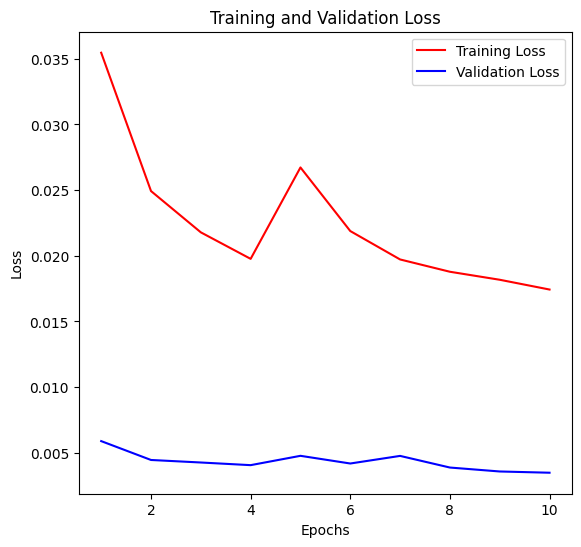

In [22]:
plot_loss_accuracy(training_loss, val_losses)

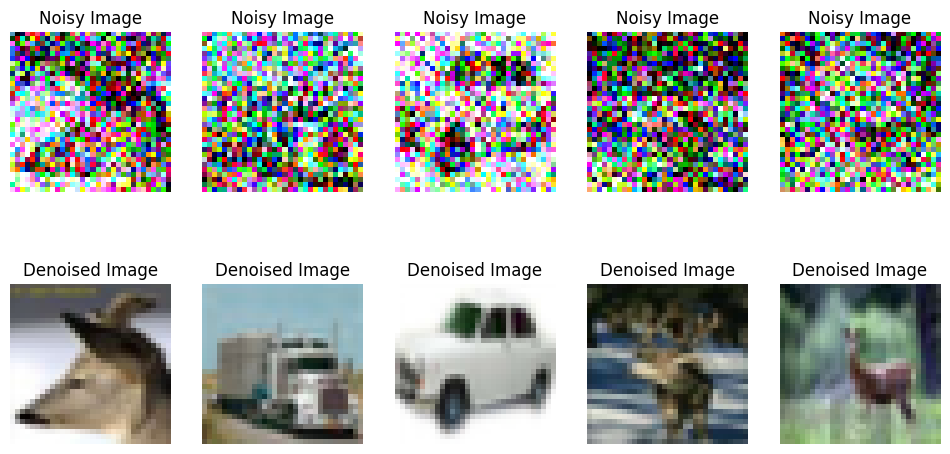

In [23]:
import matplotlib.pyplot as plt
import torch


def plot_noisy_and_denoised_images(model, dataloader, device='cuda'):
    model.eval()  

    for batch_idx, (noisy_imgs, clean_imgs) in enumerate(training_loader):
      noisy_imgs = noisy_imgs.cpu()
      clean_imgs = clean_imgs.cpu()


    num_images = 5

    plt.figure(figsize=(12, 6))

    for i in range(num_images):

        plt.subplot(2, num_images, i+1)
        plt.imshow(noisy_imgs[i].permute(1, 2, 0))  
        plt.title("Noisy Image")
        plt.axis('off')

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(clean_imgs[i].permute(1, 2, 0)) 
        plt.title("Denoised Image")
        plt.axis('off')

    plt.show()


plot_noisy_and_denoised_images(model_152,value_loader, device='cuda')
